In [26]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


In [2]:
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")

# EDA

In [3]:
data_train.head(3)

model  year motor_type       running wheel    color   type  \
0         toyota  2022     petrol      3000  km  left  skyblue  sedan   
1  mercedes-benz  2014     petrol    132000  km  left    black  sedan   
2            kia  2018     petrol  95000  miles  left    other  sedan   

      status  motor_volume  price  
0  excellent           2.0  24500  
1  excellent           2.0  25500  
2  excellent           2.0  11700

In [4]:
data_test.head(3)

Id    model  year motor_type       running wheel  color   type     status  \
0   0      kia  2020     petrol     24000  km  left  black  sedan  excellent   
1   1   nissan  2017     petrol  85000  miles  left  white    suv  excellent   
2   2  hyundai  2021     petrol  30000  miles  left  white  sedan  excellent   

   motor_volume  
0           2.0  
1           2.0  
2           2.0

### No hay nulos

In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642 entries, 0 to 1641
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         1642 non-null   object 
 1   year          1642 non-null   int64  
 2   motor_type    1642 non-null   object 
 3   running       1642 non-null   object 
 4   wheel         1642 non-null   object 
 5   color         1642 non-null   object 
 6   type          1642 non-null   object 
 7   status        1642 non-null   object 
 8   motor_volume  1642 non-null   float64
 9   price         1642 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 128.4+ KB


In [6]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411 entries, 0 to 410
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            411 non-null    int64  
 1   model         411 non-null    object 
 2   year          411 non-null    int64  
 3   motor_type    411 non-null    object 
 4   running       411 non-null    object 
 5   wheel         411 non-null    object 
 6   color         411 non-null    object 
 7   type          411 non-null    object 
 8   status        411 non-null    object 
 9   motor_volume  411 non-null    float64
dtypes: float64(1), int64(2), object(7)
memory usage: 32.2+ KB


Notas:
1. Running: Convertir todo a km y dejarlo como numero
2. Wheel in train solo esta como right, pero en test sale como left y right
3. Convertir año a Categoria

In [7]:
for i in data_train.select_dtypes(include='object').columns.tolist():
    print("Unique Values of " + i)
    print(data_train[i].unique())

Unique Values of model
['toyota' 'mercedes-benz' 'kia' 'nissan' 'hyundai']
Unique Values of motor_type
['petrol' 'gas' 'petrol and gas' 'diesel' 'hybrid']
Unique Values of running
['3000  km' '132000  km' '95000  miles' '137000  miles' '130000  km'
 '286293  km' '49000  miles' '70000  miles' '85000  km' '58000  miles'
 '50000  miles' '135800  km' '191000  km' '220000  km' '38100  miles'
 '102000  miles' '126000  km' '98000  km' '60000  miles' '99000  km'
 '230000  km' '33000  miles' '630000  miles' '7000  miles' '194000  miles'
 '92000  miles' '65000  miles' '143  miles' '238371  km' '45000  km'
 '64000  miles' '80000  miles' '44000  miles' '78900  miles' '185000  km'
 '76000  miles' '18000  km' '210000  km' '144000  km' '105000  km'
 '74000  km' '68000  miles' '107000  km' '30000  miles' '57000  miles'
 '20000  miles' '200000  km' '250  km' '260000  km' '38000  km'
 '30500  km' '80000  km' '13000  miles' '143000  miles' '34000  miles'
 '700  miles' '15000  miles' '85000  miles' '82000

In [8]:
for i in data_test.select_dtypes(include='object').columns.tolist():
    print("Unique Values of " + i)
    print(data_test[i].unique())

Unique Values of model
['kia' 'nissan' 'hyundai' 'mercedes-benz' 'toyota']
Unique Values of motor_type
['petrol' 'gas' 'petrol and gas']
Unique Values of running
['24000  km' '85000  miles' '30000  miles' '53000  miles' '230000  km'
 '16000  miles' '226000  km' '135000  km' '164807  km' '63000  miles'
 '75000  miles' '400000  km' '84000  km' '83000  miles' '108000  miles'
 '140500  miles' '75000  km' '57000  miles' '73000  miles' '98000  miles'
 '295000  km' '172000  km' '20000  miles' '55000  km' '33300  km'
 '24000  miles' '60000  miles' '40000  km' '33000  miles' '25311  miles'
 '92000  miles' '65000  miles' '250000  km' '12000  km' '57000  km'
 '280000  km' '48000  miles' '45  miles' '80000  miles' '25000  km'
 '86000  miles' '49000  miles' '58000  miles' '36000  miles'
 '55000  miles' '63000  km' '155000  km' '13500  km' '298000  km'
 '44000  miles' '33700  miles' '80500  miles' '34000  km' '137600  km'
 '149000  miles' '240000  km' '77000  miles' '70000  miles' '48000  km'
 '1600

### Data Cleaning

In [9]:
### Correct data types

data_train["year"] = data_train["year"].astype(str)
data_test["year"] = data_test["year"].astype(str)

data_train["motor_type"] = data_train["motor_type"].astype(str)
data_test["motor_type"] = data_test["motor_type"].astype(str)

data_train["motor_volume"] = data_train["motor_volume"].astype(str)
data_test["motor_volume"] = data_test["motor_volume"].astype(str)


In [10]:
### Clean Running

data_train["running_unit"] = data_train['running'].str.extract(r'([a-zA-Z]+)')
data_train["running_value"] = data_train['running'].str.extract(r'(\d+\.?\d*)')
data_train["running_value"] = pd.to_numeric(data_train["running_value"])
data_train["running_value_km"] = data_train.apply(lambda row: row['running_value'] if row['running_unit'] == "km" else row['running_value'] * 1.60934, axis=1)


data_test["running_unit"] = data_test['running'].str.extract(r'([a-zA-Z]+)')
data_test["running_value"] = data_test['running'].str.extract(r'(\d+\.?\d*)')
data_test["running_value"] = pd.to_numeric(data_test["running_value"])
data_test["running_value_km"] = data_test.apply(lambda row: row['running_value'] if row['running_unit'] == "km" else row['running_value'] * 1.60934, axis=1)


In [11]:
data_train.drop(columns = ["running_unit", "running_value", "running"], inplace = True)
data_test.drop(columns = ["running_unit", "running_value", "running"], inplace = True)

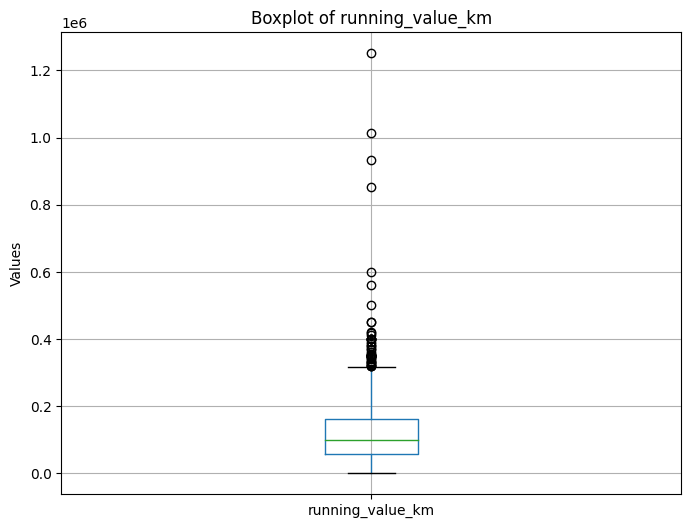

In [12]:
### Check Outliers

for col in data_train.select_dtypes(include='float64').columns.tolist():
    plt.figure(figsize=(8, 6))
    data_train.boxplot(column=col)
    plt.title(f'Boxplot of {col}')
    plt.ylabel('Values')
    plt.show()

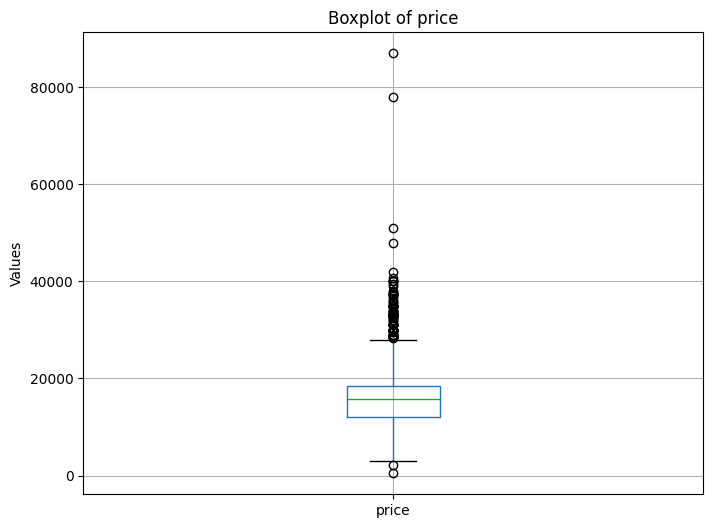

In [13]:
for col in data_train.select_dtypes(include='int64').columns.tolist():
    plt.figure(figsize=(8, 6))
    data_train.boxplot(column=col)
    plt.title(f'Boxplot of {col}')
    plt.ylabel('Values')
    plt.show()

In [14]:
# Remove outliers in Running Value
print(data_train.shape)

for i in ["running_value_km", "price"]:
    Q1 = np.percentile(data_train[i], 25)
    Q3 = np.percentile(data_train[i], 75)
    IQR = Q3 - Q1
    data_train = data_train[(data_train[i] >= Q1 - 1.5*IQR) & (data_train[i] <= Q3 + 1.5*IQR)]
    
print(data_train.shape)

(1642, 10)
(1505, 10)


### Remove duplicates


In [15]:
print(data_train.shape)
data_train.drop_duplicates()
print(data_train.shape)

(1505, 10)
(1505, 10)


### Discretizar Volumen del Motor (Done For Second Iteration)

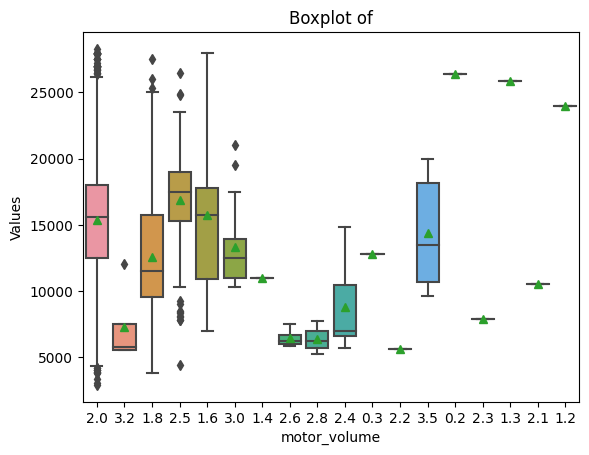

In [16]:
sns.boxplot(
    x = "motor_volume",  
    y = "price",      
    showmeans=True,
    data= data_train)
    
plt.title(f'Boxplot of')
plt.ylabel('Values')
plt.show()

In [17]:
#conditions = [
#    (data_train['motor_volume'] >= 0) & (data_train['motor_volume'] <= 1.5),
#    (data_train['motor_volume'] > 1.5) & (data_train['motor_volume'] <= 2),
#    (data_train['motor_volume'] > 2) & (data_train['motor_volume'] <= 2.5),
#    (data_train['motor_volume'] > 2.5) & (data_train['motor_volume'] <= 3),
#    (data_train['motor_volume'] > 3)
#]

#choices = ['xs', 's', 'm', 'l', 'xl'] 

#data_train['motor_volume'] = np.select(conditions, choices, default='Other')

In [18]:
#conditions = [
#    (data_test['motor_volume'] >= 0) & (data_test['motor_volume'] <= 1.5),
#    (data_test['motor_volume'] > 1.5) & (data_test['motor_volume'] <= 2),
#    (data_test['motor_volume'] > 2) & (data_test['motor_volume'] <= 2.5),
#    (data_test['motor_volume'] > 2.5) & (data_test['motor_volume'] <= 3),
#    (data_test['motor_volume'] > 3)
#]

#choices = ['xs', 's', 'm', 'l', 'xl'] 

#data_test['motor_volume'] = np.select(conditions, choices, default='Other')

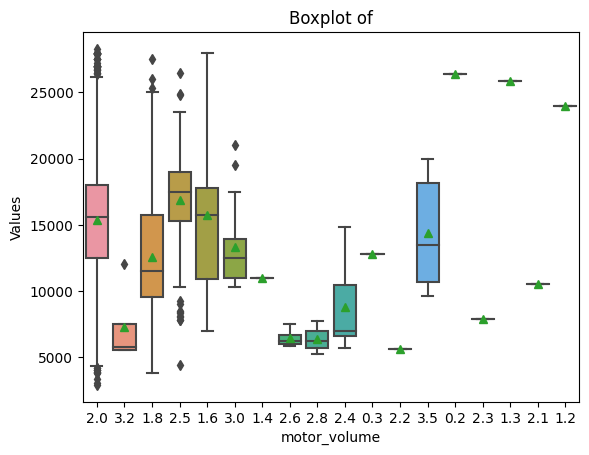

In [19]:
sns.boxplot(
    x = "motor_volume",  
    y = "price",      
    showmeans=True,
    data= data_train)
    
plt.title(f'Boxplot of')
plt.ylabel('Values')
plt.show()

# Modelaje

In [20]:
# Separar data
X_train = data_train.drop(columns = ["price"])
y_train = data_train["price"]

X_test = data_test

In [21]:
# Normalizar columnas numericas
# Dudas: Deberia normalizar la variable de respuesta?
# Esta bien siempre normalizar?

columnas_a_normalizar = ["running_value_km"]

X_train_normalizar = X_train[columnas_a_normalizar].copy()

# Normalizar
mms = MinMaxScaler()
X_train_normalizar = mms.fit_transform(X_train_normalizar)

# Guardar normalizacion
X_train[columnas_a_normalizar] = X_train_normalizar

# Normalizar en test
X_test[columnas_a_normalizar] = mms.transform(X_test[columnas_a_normalizar])

In [22]:
# Separate categorical and numerical columns

categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
numerical_cols = X_train.select_dtypes(include='float64').columns.tolist() + X_train.select_dtypes(include='int64').columns.tolist()

# Initialize OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')

# Fit and transform on categorical columns
encoded_train = encoder.fit_transform(X_train[categorical_cols])
encoded_test = encoder.transform(X_test[categorical_cols])

# Convert to DataFrame
print(encoded_train.shape) 
encoded_train = pd.DataFrame(encoded_train.toarray(), columns = encoder.get_feature_names_out(categorical_cols))
encoded_test = pd.DataFrame(encoded_test.toarray(), columns = encoder.get_feature_names_out(categorical_cols))



(1505, 89)


In [23]:
# Combine encoded categorical DataFrame with original numerical DataFrame
X_train = pd.concat([X_train[numerical_cols].reset_index(drop=True), encoded_train], axis=1)
X_test = pd.concat([X_test[["Id"] + numerical_cols].reset_index(drop=True), encoded_test], axis=1)

print(X_train.shape)

(1505, 90)


In [24]:
X_train

running_value_km  model_hyundai  model_kia  model_mercedes-benz  \
0             0.009432            0.0        0.0                  0.0   
1             0.416385            0.0        0.0                  1.0   
2             0.482278            0.0        1.0                  0.0   
3             0.695510            0.0        0.0                  1.0   
4             0.410076            0.0        0.0                  1.0   
...                ...            ...        ...                  ...   
1500          0.217641            0.0        0.0                  1.0   
1501          0.609202            1.0        0.0                  0.0   
1502          0.536263            0.0        0.0                  0.0   
1503          0.349770            0.0        0.0                  0.0   
1504          0.157354            0.0        0.0                  0.0   

      model_nissan  model_toyota  year_1987  year_1994  year_1995  year_1996  \
0              0.0           1.0        0.0        0.0        0.0        0.0   
1              0.0           0.0        0.0        0.0        0.0        0.0   
2              0.0           0.0        0.0        0.0        0.0        0.0   
3              0.0           0.0        0.0        0.0        0.0        0.0   
4              0.0           0.0        0.0        0.0        0.0        0.0   
...            ...           ...        ...        ...        ...        ...   
1500           0.0           0.0        0.0        0.0        0.0        0.0   
1501           0.0           0.0        0.0        0.0        0.0        0.0   
1502           0.0           1.0        0.0        0.0        0.0        0.0   
1503           1.0           0.0        0.0        0.0        0.0        0.0   
1504           1.0           0.0        0.0        0.0        0.0        0.0   

      ...  motor_volume_2.1  motor_volume_2.2  motor_volume_2.3  \
0     ...               0.0               0.0               0.0   
1     ...               0.0               0.0               0.0   
2     ...               0.0               0.0               0.0   
3     ...               0.0               0.0               0.0   
4     ...               0.0               0.0               0.0   
...   ...               ...               ...               ...   
1500  ...               0.0               0.0               0.0   
1501  ...               0.0               0.0               0.0   
1502  ...               0.0               0.0               0.0   
1503  ...               0.0               0.0               0.0   
1504  ...               0.0               0.0               0.0   

      motor_volume_2.4  motor_volume_2.5  motor_volume_2.6  motor_volume_2.8  \
0                  0.0               0.0               0.0               0.0   
1                  0.0               0.0               0.0               0.0   
2                  0.0               0.0               0.0               0.0   
3                  0.0               0.0               0.0               0.0   
4                  0.0               0.0               0.0               0.0   
...                ...               ...               ...               ...   
1500               0.0               0.0               0.0               0.0   
1501               0.0               0.0               0.0               0.0   
1502               0.0               0.0               0.0               0.0   
1503               0.0               0.0               0.0               0.0   
1504               0.0               0.0               0.0               0.0   

      motor_volume_3.0  motor_volume_3.2  motor_volume_3.5  
0                  0.0               0.0               0.0  
1                  0.0               0.0               0.0  
2                  0.0               0.0               0.0  
3                  0.0               1.0               0.0  
4                  0.0               0.0               0.0  
...                ...              

In [51]:
# Crear modelo

#gbr = GradientBoostingRegressor(random_state=0)

# Crear Grid Search
#n_estimators_list = [250, 500,1000]
#learning_rate_list = [0.1,0.05]
#max_depth_list = [5, 10, 15]

#param_grid = {'n_estimators': n_estimators_list,
#              'learning_rate':learning_rate_list,
#              'max_depth': max_depth_list}

#gbr_grid_search = GridSearchCV(gbr, 
#                    param_grid = param_grid, 
#                    cv = 5,
                    #scoring = "neg_mean_squared_error",
#                    n_jobs = -1) # Usar todos los procesadores

#gbr_grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=0),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05], 'max_depth': [5, 10, 15],
                         'n_estimators': [250, 500, 1000]})

In [29]:
# Crear modelo

catboost_model = CatBoostRegressor(random_state = 42)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]
}

catboost_model_grid_search = GridSearchCV(catboost_model, 
                    param_grid = param_grid, 
                    cv = 5,
                    scoring = "neg_mean_squared_error")

catboost_model_grid_search.fit(X_train, y_train)


0:	learn: 5129.0480369	total: 167ms	remaining: 2m 46s
1:	learn: 5110.7384771	total: 170ms	remaining: 1m 24s
2:	learn: 5093.6224180	total: 171ms	remaining: 56.8s
3:	learn: 5075.5123758	total: 172ms	remaining: 42.9s
4:	learn: 5059.9861254	total: 173ms	remaining: 34.5s
5:	learn: 5041.4137381	total: 174ms	remaining: 28.9s
6:	learn: 5024.4280971	total: 175ms	remaining: 24.9s
7:	learn: 5007.3618916	total: 176ms	remaining: 21.9s
8:	learn: 4990.2287285	total: 177ms	remaining: 19.5s
9:	learn: 4971.2622801	total: 178ms	remaining: 17.7s
10:	learn: 4954.2718905	total: 179ms	remaining: 16.1s
11:	learn: 4938.1304085	total: 181ms	remaining: 14.9s
12:	learn: 4920.3657182	total: 182ms	remaining: 13.8s
13:	learn: 4903.0249991	total: 183ms	remaining: 12.9s
14:	learn: 4887.8445296	total: 184ms	remaining: 12.1s
15:	learn: 4872.5850785	total: 185ms	remaining: 11.4s
16:	learn: 4857.0187771	total: 186ms	remaining: 10.8s
17:	learn: 4840.6560490	total: 188ms	remaining: 10.2s
18:	learn: 4825.9433355	total: 189ms

166:	learn: 3703.0400487	total: 356ms	remaining: 1.77s
167:	learn: 3698.8299761	total: 357ms	remaining: 1.77s
168:	learn: 3694.3826642	total: 359ms	remaining: 1.76s
169:	learn: 3690.3625385	total: 360ms	remaining: 1.76s
170:	learn: 3686.2685967	total: 361ms	remaining: 1.75s
171:	learn: 3682.8616292	total: 363ms	remaining: 1.75s
172:	learn: 3679.3949559	total: 364ms	remaining: 1.74s
173:	learn: 3676.6842771	total: 365ms	remaining: 1.73s
174:	learn: 3672.8910234	total: 366ms	remaining: 1.73s
175:	learn: 3669.7698320	total: 368ms	remaining: 1.72s
176:	learn: 3667.2891990	total: 369ms	remaining: 1.72s
177:	learn: 3663.4978946	total: 370ms	remaining: 1.71s
178:	learn: 3659.6674154	total: 371ms	remaining: 1.7s
179:	learn: 3656.3650745	total: 373ms	remaining: 1.7s
180:	learn: 3653.7213980	total: 374ms	remaining: 1.69s
181:	learn: 3651.0117933	total: 375ms	remaining: 1.69s
182:	learn: 3648.9120244	total: 377ms	remaining: 1.68s
183:	learn: 3647.0161635	total: 378ms	remaining: 1.68s
184:	learn: 

327:	learn: 3342.2704960	total: 542ms	remaining: 1.11s
328:	learn: 3339.9815737	total: 543ms	remaining: 1.11s
329:	learn: 3338.9934707	total: 544ms	remaining: 1.1s
330:	learn: 3337.4577033	total: 545ms	remaining: 1.1s
331:	learn: 3335.0562013	total: 546ms	remaining: 1.1s
332:	learn: 3333.8511280	total: 547ms	remaining: 1.1s
333:	learn: 3332.3544127	total: 548ms	remaining: 1.09s
334:	learn: 3331.0313997	total: 549ms	remaining: 1.09s
335:	learn: 3328.7216548	total: 550ms	remaining: 1.09s
336:	learn: 3327.8394835	total: 551ms	remaining: 1.08s
337:	learn: 3326.4799861	total: 553ms	remaining: 1.08s
338:	learn: 3324.6779447	total: 554ms	remaining: 1.08s
339:	learn: 3323.0309214	total: 555ms	remaining: 1.08s
340:	learn: 3321.6871404	total: 556ms	remaining: 1.07s
341:	learn: 3320.2132631	total: 557ms	remaining: 1.07s
342:	learn: 3318.4001159	total: 558ms	remaining: 1.07s
343:	learn: 3317.1020467	total: 559ms	remaining: 1.07s
344:	learn: 3314.9740152	total: 560ms	remaining: 1.06s
345:	learn: 33

487:	learn: 3142.8052129	total: 725ms	remaining: 761ms
488:	learn: 3141.7602082	total: 727ms	remaining: 759ms
489:	learn: 3141.0987544	total: 728ms	remaining: 757ms
490:	learn: 3140.0525659	total: 729ms	remaining: 756ms
491:	learn: 3139.2472022	total: 730ms	remaining: 754ms
492:	learn: 3138.2474617	total: 731ms	remaining: 752ms
493:	learn: 3137.5659954	total: 733ms	remaining: 751ms
494:	learn: 3136.6178374	total: 734ms	remaining: 749ms
495:	learn: 3136.0445606	total: 735ms	remaining: 747ms
496:	learn: 3134.9400409	total: 736ms	remaining: 745ms
497:	learn: 3133.7219212	total: 738ms	remaining: 744ms
498:	learn: 3132.9216563	total: 739ms	remaining: 742ms
499:	learn: 3131.9244346	total: 740ms	remaining: 740ms
500:	learn: 3131.1173494	total: 742ms	remaining: 739ms
501:	learn: 3130.2199545	total: 743ms	remaining: 737ms
502:	learn: 3129.4817214	total: 744ms	remaining: 735ms
503:	learn: 3128.7276634	total: 745ms	remaining: 733ms
504:	learn: 3128.0209322	total: 746ms	remaining: 731ms
505:	learn

662:	learn: 2974.7087413	total: 913ms	remaining: 464ms
663:	learn: 2974.0348236	total: 914ms	remaining: 462ms
664:	learn: 2973.4840452	total: 915ms	remaining: 461ms
665:	learn: 2972.8199051	total: 916ms	remaining: 460ms
666:	learn: 2972.0351552	total: 918ms	remaining: 458ms
667:	learn: 2968.5400280	total: 919ms	remaining: 457ms
668:	learn: 2967.6683294	total: 921ms	remaining: 455ms
669:	learn: 2966.6945452	total: 922ms	remaining: 454ms
670:	learn: 2966.1449853	total: 923ms	remaining: 453ms
671:	learn: 2965.6188631	total: 924ms	remaining: 451ms
672:	learn: 2964.8815086	total: 926ms	remaining: 450ms
673:	learn: 2964.4184063	total: 927ms	remaining: 448ms
674:	learn: 2964.0150598	total: 928ms	remaining: 447ms
675:	learn: 2963.2794674	total: 930ms	remaining: 446ms
676:	learn: 2962.5749047	total: 931ms	remaining: 444ms
677:	learn: 2962.0834773	total: 932ms	remaining: 443ms
678:	learn: 2961.4083958	total: 933ms	remaining: 441ms
679:	learn: 2956.3372610	total: 934ms	remaining: 440ms
680:	learn

826:	learn: 2820.4752966	total: 1.1s	remaining: 230ms
827:	learn: 2820.0959992	total: 1.1s	remaining: 228ms
828:	learn: 2819.4767158	total: 1.1s	remaining: 227ms
829:	learn: 2817.8736802	total: 1.1s	remaining: 226ms
830:	learn: 2817.2572766	total: 1.1s	remaining: 224ms
831:	learn: 2816.6464966	total: 1.1s	remaining: 223ms
832:	learn: 2816.0080525	total: 1.1s	remaining: 222ms
833:	learn: 2814.7854359	total: 1.11s	remaining: 220ms
834:	learn: 2814.3075262	total: 1.11s	remaining: 219ms
835:	learn: 2813.9041312	total: 1.11s	remaining: 217ms
836:	learn: 2812.9551137	total: 1.11s	remaining: 216ms
837:	learn: 2812.1655704	total: 1.11s	remaining: 215ms
838:	learn: 2811.5124350	total: 1.11s	remaining: 213ms
839:	learn: 2810.7734723	total: 1.11s	remaining: 212ms
840:	learn: 2808.8786669	total: 1.11s	remaining: 211ms
841:	learn: 2808.2612434	total: 1.12s	remaining: 210ms
842:	learn: 2807.5504914	total: 1.12s	remaining: 208ms
843:	learn: 2806.8203651	total: 1.12s	remaining: 207ms
844:	learn: 2806.

80:	learn: 4208.7238797	total: 97.1ms	remaining: 1.1s
81:	learn: 4201.5074212	total: 99.8ms	remaining: 1.12s
82:	learn: 4194.2611012	total: 101ms	remaining: 1.12s
83:	learn: 4185.7925132	total: 102ms	remaining: 1.12s
84:	learn: 4178.6114940	total: 103ms	remaining: 1.11s
85:	learn: 4171.8791369	total: 104ms	remaining: 1.11s
86:	learn: 4164.6895279	total: 105ms	remaining: 1.11s
87:	learn: 4158.4088079	total: 106ms	remaining: 1.1s
88:	learn: 4151.5537449	total: 107ms	remaining: 1.1s
89:	learn: 4143.7791322	total: 108ms	remaining: 1.09s
90:	learn: 4136.8519206	total: 109ms	remaining: 1.09s
91:	learn: 4129.8622426	total: 110ms	remaining: 1.08s
92:	learn: 4122.6034613	total: 111ms	remaining: 1.08s
93:	learn: 4116.4559444	total: 112ms	remaining: 1.08s
94:	learn: 4109.2990040	total: 113ms	remaining: 1.07s
95:	learn: 4103.2972445	total: 114ms	remaining: 1.07s
96:	learn: 4096.7705982	total: 115ms	remaining: 1.07s
97:	learn: 4089.9857192	total: 116ms	remaining: 1.07s
98:	learn: 4083.4767038	total

263:	learn: 3515.8987789	total: 281ms	remaining: 785ms
264:	learn: 3512.9640592	total: 283ms	remaining: 785ms
265:	learn: 3510.7435858	total: 284ms	remaining: 784ms
266:	learn: 3509.1638223	total: 285ms	remaining: 783ms
267:	learn: 3507.3039465	total: 286ms	remaining: 782ms
268:	learn: 3505.1275718	total: 287ms	remaining: 780ms
269:	learn: 3503.1192039	total: 288ms	remaining: 779ms
270:	learn: 3501.5857350	total: 289ms	remaining: 778ms
271:	learn: 3500.0786611	total: 290ms	remaining: 777ms
272:	learn: 3498.2231146	total: 291ms	remaining: 776ms
273:	learn: 3496.2628389	total: 293ms	remaining: 775ms
274:	learn: 3493.6870815	total: 294ms	remaining: 774ms
275:	learn: 3492.0957605	total: 295ms	remaining: 773ms
276:	learn: 3490.1603181	total: 296ms	remaining: 772ms
277:	learn: 3488.3870210	total: 297ms	remaining: 771ms
278:	learn: 3486.0383359	total: 298ms	remaining: 770ms
279:	learn: 3484.4386889	total: 299ms	remaining: 769ms
280:	learn: 3482.3779186	total: 300ms	remaining: 768ms
281:	learn

426:	learn: 3259.8350711	total: 470ms	remaining: 631ms
427:	learn: 3259.1377055	total: 471ms	remaining: 630ms
428:	learn: 3258.1104874	total: 472ms	remaining: 629ms
429:	learn: 3257.1480702	total: 473ms	remaining: 628ms
430:	learn: 3255.6392018	total: 474ms	remaining: 626ms
431:	learn: 3254.4557467	total: 475ms	remaining: 625ms
432:	learn: 3253.6986174	total: 476ms	remaining: 624ms
433:	learn: 3252.5906606	total: 477ms	remaining: 623ms
434:	learn: 3251.4960190	total: 478ms	remaining: 621ms
435:	learn: 3250.2419068	total: 479ms	remaining: 620ms
436:	learn: 3249.1655874	total: 480ms	remaining: 619ms
437:	learn: 3248.0624377	total: 481ms	remaining: 617ms
438:	learn: 3247.1000602	total: 482ms	remaining: 616ms
439:	learn: 3245.9596646	total: 484ms	remaining: 616ms
440:	learn: 3244.4877512	total: 485ms	remaining: 615ms
441:	learn: 3243.1183560	total: 486ms	remaining: 614ms
442:	learn: 3241.9277129	total: 487ms	remaining: 613ms
443:	learn: 3241.0025400	total: 488ms	remaining: 612ms
444:	learn

596:	learn: 3092.6240444	total: 652ms	remaining: 440ms
597:	learn: 3091.9008443	total: 654ms	remaining: 439ms
598:	learn: 3091.1807563	total: 655ms	remaining: 438ms
599:	learn: 3089.2560242	total: 656ms	remaining: 437ms
600:	learn: 3088.7372914	total: 657ms	remaining: 437ms
601:	learn: 3088.1378624	total: 659ms	remaining: 435ms
602:	learn: 3087.7023231	total: 660ms	remaining: 434ms
603:	learn: 3087.1372926	total: 661ms	remaining: 433ms
604:	learn: 3086.3535994	total: 662ms	remaining: 432ms
605:	learn: 3085.3959116	total: 663ms	remaining: 431ms
606:	learn: 3084.2604027	total: 665ms	remaining: 430ms
607:	learn: 3083.2898896	total: 666ms	remaining: 429ms
608:	learn: 3082.6199016	total: 667ms	remaining: 428ms
609:	learn: 3080.5468129	total: 668ms	remaining: 427ms
610:	learn: 3079.8662243	total: 670ms	remaining: 426ms
611:	learn: 3079.0910922	total: 671ms	remaining: 425ms
612:	learn: 3078.6116654	total: 672ms	remaining: 424ms
613:	learn: 3077.8505041	total: 674ms	remaining: 423ms
614:	learn

768:	learn: 2949.1569296	total: 840ms	remaining: 252ms
769:	learn: 2947.2441405	total: 841ms	remaining: 251ms
770:	learn: 2946.5361342	total: 843ms	remaining: 250ms
771:	learn: 2943.8838957	total: 844ms	remaining: 249ms
772:	learn: 2943.3234979	total: 845ms	remaining: 248ms
773:	learn: 2942.9263651	total: 846ms	remaining: 247ms
774:	learn: 2942.4680768	total: 847ms	remaining: 246ms
775:	learn: 2941.6277218	total: 848ms	remaining: 245ms
776:	learn: 2939.9022003	total: 849ms	remaining: 244ms
777:	learn: 2936.9909479	total: 850ms	remaining: 243ms
778:	learn: 2936.0607349	total: 852ms	remaining: 242ms
779:	learn: 2933.8031075	total: 853ms	remaining: 241ms
780:	learn: 2933.3919610	total: 854ms	remaining: 239ms
781:	learn: 2932.7532711	total: 855ms	remaining: 238ms
782:	learn: 2932.3374168	total: 856ms	remaining: 237ms
783:	learn: 2931.6391565	total: 858ms	remaining: 236ms
784:	learn: 2931.0241844	total: 860ms	remaining: 236ms
785:	learn: 2930.4986727	total: 861ms	remaining: 235ms
786:	learn

925:	learn: 2829.4330765	total: 1.02s	remaining: 81.9ms
926:	learn: 2827.1069109	total: 1.03s	remaining: 80.8ms
927:	learn: 2826.0940861	total: 1.03s	remaining: 79.7ms
928:	learn: 2825.5923945	total: 1.03s	remaining: 78.7ms
929:	learn: 2824.9033072	total: 1.03s	remaining: 77.6ms
930:	learn: 2824.5959735	total: 1.03s	remaining: 76.5ms
931:	learn: 2822.1861284	total: 1.03s	remaining: 75.4ms
932:	learn: 2821.6939943	total: 1.03s	remaining: 74.3ms
933:	learn: 2820.9405020	total: 1.03s	remaining: 73.2ms
934:	learn: 2819.4886338	total: 1.04s	remaining: 72ms
935:	learn: 2819.0166787	total: 1.04s	remaining: 70.9ms
936:	learn: 2817.3837463	total: 1.04s	remaining: 69.8ms
937:	learn: 2815.9417732	total: 1.04s	remaining: 68.8ms
938:	learn: 2814.5695103	total: 1.04s	remaining: 67.7ms
939:	learn: 2814.0216990	total: 1.04s	remaining: 66.6ms
940:	learn: 2813.4178012	total: 1.04s	remaining: 65.4ms
941:	learn: 2813.0204543	total: 1.04s	remaining: 64.3ms
942:	learn: 2812.4830838	total: 1.05s	remaining: 6

238:	learn: 3606.9264550	total: 243ms	remaining: 774ms
239:	learn: 3603.8330153	total: 244ms	remaining: 773ms
240:	learn: 3601.9071388	total: 245ms	remaining: 772ms
241:	learn: 3599.8594377	total: 246ms	remaining: 772ms
242:	learn: 3597.6102316	total: 247ms	remaining: 771ms
243:	learn: 3595.6236448	total: 248ms	remaining: 770ms
244:	learn: 3593.4584543	total: 249ms	remaining: 769ms
245:	learn: 3591.1872886	total: 251ms	remaining: 768ms
246:	learn: 3589.4468982	total: 252ms	remaining: 767ms
247:	learn: 3587.6708661	total: 253ms	remaining: 766ms
248:	learn: 3584.8067191	total: 254ms	remaining: 765ms
249:	learn: 3581.9877400	total: 255ms	remaining: 765ms
250:	learn: 3578.8472146	total: 256ms	remaining: 764ms
251:	learn: 3576.4918683	total: 257ms	remaining: 763ms
252:	learn: 3574.2522540	total: 258ms	remaining: 763ms
253:	learn: 3572.4868562	total: 259ms	remaining: 762ms
254:	learn: 3569.9347958	total: 261ms	remaining: 762ms
255:	learn: 3567.8092253	total: 262ms	remaining: 761ms
256:	learn

426:	learn: 3277.9619159	total: 428ms	remaining: 574ms
427:	learn: 3277.5894606	total: 429ms	remaining: 574ms
428:	learn: 3277.2836657	total: 430ms	remaining: 573ms
429:	learn: 3275.6127029	total: 431ms	remaining: 572ms
430:	learn: 3274.2926950	total: 432ms	remaining: 571ms
431:	learn: 3273.2479636	total: 433ms	remaining: 570ms
432:	learn: 3272.2182787	total: 434ms	remaining: 568ms
433:	learn: 3271.4898557	total: 435ms	remaining: 567ms
434:	learn: 3270.5077189	total: 436ms	remaining: 566ms
435:	learn: 3269.3623986	total: 437ms	remaining: 565ms
436:	learn: 3268.6815859	total: 438ms	remaining: 564ms
437:	learn: 3267.3330863	total: 439ms	remaining: 563ms
438:	learn: 3265.7842770	total: 440ms	remaining: 562ms
439:	learn: 3263.2649770	total: 441ms	remaining: 562ms
440:	learn: 3262.4554227	total: 442ms	remaining: 561ms
441:	learn: 3261.0943441	total: 444ms	remaining: 560ms
442:	learn: 3260.2708435	total: 445ms	remaining: 559ms
443:	learn: 3258.8625317	total: 446ms	remaining: 558ms
444:	learn

602:	learn: 3061.7840615	total: 612ms	remaining: 403ms
603:	learn: 3061.0816985	total: 613ms	remaining: 402ms
604:	learn: 3059.7384992	total: 614ms	remaining: 401ms
605:	learn: 3058.7531845	total: 615ms	remaining: 400ms
606:	learn: 3056.0297188	total: 616ms	remaining: 399ms
607:	learn: 3055.4413315	total: 617ms	remaining: 398ms
608:	learn: 3054.9889397	total: 618ms	remaining: 397ms
609:	learn: 3054.3742602	total: 619ms	remaining: 396ms
610:	learn: 3053.4362678	total: 620ms	remaining: 395ms
611:	learn: 3052.2006666	total: 622ms	remaining: 394ms
612:	learn: 3051.2680415	total: 623ms	remaining: 393ms
613:	learn: 3050.5170006	total: 624ms	remaining: 392ms
614:	learn: 3049.6174759	total: 625ms	remaining: 391ms
615:	learn: 3049.1782265	total: 626ms	remaining: 390ms
616:	learn: 3048.4654280	total: 627ms	remaining: 389ms
617:	learn: 3047.6790112	total: 629ms	remaining: 389ms
618:	learn: 3046.8864061	total: 630ms	remaining: 388ms
619:	learn: 3046.3041200	total: 631ms	remaining: 387ms
620:	learn

784:	learn: 2888.2490129	total: 805ms	remaining: 220ms
785:	learn: 2887.7016796	total: 806ms	remaining: 219ms
786:	learn: 2886.9348976	total: 807ms	remaining: 218ms
787:	learn: 2886.1384323	total: 808ms	remaining: 217ms
788:	learn: 2885.4724531	total: 809ms	remaining: 216ms
789:	learn: 2882.4754624	total: 810ms	remaining: 215ms
790:	learn: 2881.3427370	total: 812ms	remaining: 215ms
791:	learn: 2880.7736485	total: 813ms	remaining: 214ms
792:	learn: 2879.9996416	total: 814ms	remaining: 213ms
793:	learn: 2879.4843486	total: 815ms	remaining: 212ms
794:	learn: 2878.4944392	total: 816ms	remaining: 210ms
795:	learn: 2877.6567936	total: 817ms	remaining: 209ms
796:	learn: 2877.1075288	total: 818ms	remaining: 208ms
797:	learn: 2874.1773749	total: 819ms	remaining: 207ms
798:	learn: 2872.5079073	total: 820ms	remaining: 206ms
799:	learn: 2872.1160104	total: 821ms	remaining: 205ms
800:	learn: 2871.6365256	total: 822ms	remaining: 204ms
801:	learn: 2870.0628851	total: 823ms	remaining: 203ms
802:	learn

974:	learn: 2721.7917122	total: 999ms	remaining: 25.6ms
975:	learn: 2721.1222967	total: 1s	remaining: 24.6ms
976:	learn: 2720.7599666	total: 1s	remaining: 23.6ms
977:	learn: 2719.9799085	total: 1s	remaining: 22.6ms
978:	learn: 2718.5524404	total: 1s	remaining: 21.5ms
979:	learn: 2717.9257255	total: 1s	remaining: 20.5ms
980:	learn: 2717.3038011	total: 1.01s	remaining: 19.5ms
981:	learn: 2716.9484967	total: 1.01s	remaining: 18.5ms
982:	learn: 2716.5621453	total: 1.01s	remaining: 17.5ms
983:	learn: 2715.9344931	total: 1.01s	remaining: 16.5ms
984:	learn: 2714.7198576	total: 1.01s	remaining: 15.4ms
985:	learn: 2713.8558344	total: 1.01s	remaining: 14.4ms
986:	learn: 2713.2433804	total: 1.02s	remaining: 13.4ms
987:	learn: 2711.1099561	total: 1.02s	remaining: 12.4ms
988:	learn: 2710.1952218	total: 1.02s	remaining: 11.3ms
989:	learn: 2709.7610141	total: 1.02s	remaining: 10.3ms
990:	learn: 2709.1186803	total: 1.02s	remaining: 9.29ms
991:	learn: 2708.2278866	total: 1.02s	remaining: 8.26ms
992:	le

285:	learn: 3407.6656059	total: 283ms	remaining: 706ms
286:	learn: 3406.4895875	total: 284ms	remaining: 705ms
287:	learn: 3405.2460320	total: 285ms	remaining: 706ms
288:	learn: 3403.8508498	total: 287ms	remaining: 705ms
289:	learn: 3402.1434711	total: 288ms	remaining: 704ms
290:	learn: 3400.3246841	total: 289ms	remaining: 704ms
291:	learn: 3398.5840670	total: 290ms	remaining: 703ms
292:	learn: 3397.0684023	total: 291ms	remaining: 702ms
293:	learn: 3394.8909305	total: 292ms	remaining: 701ms
294:	learn: 3393.4182546	total: 293ms	remaining: 700ms
295:	learn: 3392.0517834	total: 294ms	remaining: 700ms
296:	learn: 3390.6447087	total: 295ms	remaining: 699ms
297:	learn: 3388.7238724	total: 297ms	remaining: 699ms
298:	learn: 3386.9773727	total: 298ms	remaining: 698ms
299:	learn: 3385.6552240	total: 299ms	remaining: 697ms
300:	learn: 3383.9955398	total: 300ms	remaining: 697ms
301:	learn: 3382.7866580	total: 301ms	remaining: 697ms
302:	learn: 3381.6647786	total: 303ms	remaining: 696ms
303:	learn

488:	learn: 3128.3850914	total: 470ms	remaining: 491ms
489:	learn: 3127.5215927	total: 472ms	remaining: 491ms
490:	learn: 3126.6955388	total: 473ms	remaining: 490ms
491:	learn: 3125.9000869	total: 474ms	remaining: 489ms
492:	learn: 3124.8172070	total: 474ms	remaining: 488ms
493:	learn: 3124.0634702	total: 475ms	remaining: 487ms
494:	learn: 3123.0754206	total: 476ms	remaining: 486ms
495:	learn: 3120.4688079	total: 477ms	remaining: 485ms
496:	learn: 3119.7448203	total: 478ms	remaining: 484ms
497:	learn: 3118.6347019	total: 479ms	remaining: 483ms
498:	learn: 3116.4104260	total: 480ms	remaining: 482ms
499:	learn: 3115.2276708	total: 481ms	remaining: 481ms
500:	learn: 3114.1418559	total: 483ms	remaining: 481ms
501:	learn: 3113.5727005	total: 484ms	remaining: 481ms
502:	learn: 3112.8485261	total: 486ms	remaining: 480ms
503:	learn: 3110.3740600	total: 487ms	remaining: 479ms
504:	learn: 3109.4212489	total: 488ms	remaining: 478ms
505:	learn: 3107.0818962	total: 489ms	remaining: 478ms
506:	learn

670:	learn: 2948.4263661	total: 653ms	remaining: 320ms
671:	learn: 2947.8974863	total: 654ms	remaining: 319ms
672:	learn: 2945.8245229	total: 655ms	remaining: 318ms
673:	learn: 2944.9313348	total: 657ms	remaining: 318ms
674:	learn: 2943.1446700	total: 657ms	remaining: 317ms
675:	learn: 2942.7303543	total: 658ms	remaining: 316ms
676:	learn: 2941.9878977	total: 659ms	remaining: 315ms
677:	learn: 2941.2290423	total: 661ms	remaining: 314ms
678:	learn: 2940.3833026	total: 662ms	remaining: 313ms
679:	learn: 2939.8749733	total: 663ms	remaining: 312ms
680:	learn: 2939.2991307	total: 664ms	remaining: 311ms
681:	learn: 2938.4600821	total: 665ms	remaining: 310ms
682:	learn: 2937.8462906	total: 666ms	remaining: 309ms
683:	learn: 2937.3898149	total: 667ms	remaining: 308ms
684:	learn: 2936.6722301	total: 668ms	remaining: 307ms
685:	learn: 2935.7978308	total: 670ms	remaining: 307ms
686:	learn: 2935.0165443	total: 671ms	remaining: 306ms
687:	learn: 2933.8245646	total: 672ms	remaining: 305ms
688:	learn

859:	learn: 2777.4203782	total: 840ms	remaining: 137ms
860:	learn: 2776.8759329	total: 841ms	remaining: 136ms
861:	learn: 2776.1553250	total: 842ms	remaining: 135ms
862:	learn: 2775.3462602	total: 843ms	remaining: 134ms
863:	learn: 2774.8434204	total: 844ms	remaining: 133ms
864:	learn: 2774.3657702	total: 845ms	remaining: 132ms
865:	learn: 2773.6103228	total: 847ms	remaining: 131ms
866:	learn: 2772.9051657	total: 848ms	remaining: 130ms
867:	learn: 2771.2961368	total: 849ms	remaining: 129ms
868:	learn: 2769.7103375	total: 850ms	remaining: 128ms
869:	learn: 2769.1170974	total: 851ms	remaining: 127ms
870:	learn: 2768.7291513	total: 852ms	remaining: 126ms
871:	learn: 2767.1675500	total: 853ms	remaining: 125ms
872:	learn: 2765.6367063	total: 854ms	remaining: 124ms
873:	learn: 2765.1133714	total: 856ms	remaining: 123ms
874:	learn: 2763.4806981	total: 857ms	remaining: 122ms
875:	learn: 2763.1120721	total: 858ms	remaining: 121ms
876:	learn: 2762.5411771	total: 859ms	remaining: 121ms
877:	learn

175:	learn: 3782.0643094	total: 195ms	remaining: 911ms
176:	learn: 3779.2237229	total: 196ms	remaining: 910ms
177:	learn: 3773.7088924	total: 197ms	remaining: 909ms
178:	learn: 3770.5524647	total: 198ms	remaining: 907ms
179:	learn: 3767.5219823	total: 199ms	remaining: 906ms
180:	learn: 3764.5369358	total: 200ms	remaining: 904ms
181:	learn: 3760.3801221	total: 201ms	remaining: 902ms
182:	learn: 3757.8108626	total: 202ms	remaining: 901ms
183:	learn: 3754.6687812	total: 203ms	remaining: 899ms
184:	learn: 3751.2953428	total: 204ms	remaining: 898ms
185:	learn: 3748.3086468	total: 205ms	remaining: 896ms
186:	learn: 3745.6595274	total: 206ms	remaining: 894ms
187:	learn: 3742.6241914	total: 207ms	remaining: 892ms
188:	learn: 3739.7331822	total: 208ms	remaining: 891ms
189:	learn: 3737.1038662	total: 209ms	remaining: 889ms
190:	learn: 3733.4020322	total: 209ms	remaining: 887ms
191:	learn: 3731.1546685	total: 210ms	remaining: 886ms
192:	learn: 3729.2809028	total: 211ms	remaining: 884ms
193:	learn

345:	learn: 3394.7729450	total: 381ms	remaining: 721ms
346:	learn: 3393.8375723	total: 382ms	remaining: 720ms
347:	learn: 3392.7900347	total: 384ms	remaining: 719ms
348:	learn: 3391.9963556	total: 385ms	remaining: 718ms
349:	learn: 3388.6765452	total: 386ms	remaining: 716ms
350:	learn: 3387.4188340	total: 387ms	remaining: 715ms
351:	learn: 3386.3744585	total: 388ms	remaining: 714ms
352:	learn: 3385.4217266	total: 389ms	remaining: 712ms
353:	learn: 3384.4801549	total: 389ms	remaining: 711ms
354:	learn: 3383.3029067	total: 390ms	remaining: 709ms
355:	learn: 3381.9200143	total: 391ms	remaining: 708ms
356:	learn: 3380.4517087	total: 392ms	remaining: 707ms
357:	learn: 3378.8764388	total: 393ms	remaining: 706ms
358:	learn: 3377.8775989	total: 395ms	remaining: 705ms
359:	learn: 3376.1837411	total: 396ms	remaining: 703ms
360:	learn: 3375.0962634	total: 397ms	remaining: 702ms
361:	learn: 3373.3791590	total: 398ms	remaining: 701ms
362:	learn: 3372.5977631	total: 399ms	remaining: 700ms
363:	learn

529:	learn: 3175.4591236	total: 562ms	remaining: 498ms
530:	learn: 3174.8367825	total: 563ms	remaining: 497ms
531:	learn: 3174.2610555	total: 564ms	remaining: 496ms
532:	learn: 3173.2567709	total: 565ms	remaining: 495ms
533:	learn: 3172.1629502	total: 566ms	remaining: 494ms
534:	learn: 3171.5535461	total: 567ms	remaining: 493ms
535:	learn: 3170.7738021	total: 568ms	remaining: 492ms
536:	learn: 3170.0698507	total: 569ms	remaining: 490ms
537:	learn: 3169.3882710	total: 570ms	remaining: 490ms
538:	learn: 3168.7309017	total: 571ms	remaining: 488ms
539:	learn: 3167.9751821	total: 572ms	remaining: 488ms
540:	learn: 3167.4477986	total: 573ms	remaining: 486ms
541:	learn: 3166.5477974	total: 574ms	remaining: 485ms
542:	learn: 3166.0850853	total: 576ms	remaining: 484ms
543:	learn: 3164.8468687	total: 577ms	remaining: 484ms
544:	learn: 3163.5903806	total: 578ms	remaining: 483ms
545:	learn: 3163.1561775	total: 579ms	remaining: 482ms
546:	learn: 3160.3340376	total: 581ms	remaining: 481ms
547:	learn

698:	learn: 3000.9150614	total: 744ms	remaining: 320ms
699:	learn: 2997.3471431	total: 745ms	remaining: 319ms
700:	learn: 2996.4458428	total: 747ms	remaining: 318ms
701:	learn: 2995.8453511	total: 748ms	remaining: 318ms
702:	learn: 2995.0176938	total: 749ms	remaining: 316ms
703:	learn: 2992.9951522	total: 750ms	remaining: 315ms
704:	learn: 2992.3016869	total: 751ms	remaining: 314ms
705:	learn: 2991.2938065	total: 752ms	remaining: 313ms
706:	learn: 2990.8546739	total: 753ms	remaining: 312ms
707:	learn: 2990.0462574	total: 753ms	remaining: 311ms
708:	learn: 2989.6494671	total: 754ms	remaining: 310ms
709:	learn: 2986.3078076	total: 755ms	remaining: 308ms
710:	learn: 2985.7841457	total: 756ms	remaining: 307ms
711:	learn: 2984.9659584	total: 757ms	remaining: 306ms
712:	learn: 2984.1584376	total: 758ms	remaining: 305ms
713:	learn: 2983.5615263	total: 759ms	remaining: 304ms
714:	learn: 2982.3879783	total: 760ms	remaining: 303ms
715:	learn: 2981.8723038	total: 762ms	remaining: 302ms
716:	learn

869:	learn: 2845.7172618	total: 929ms	remaining: 139ms
870:	learn: 2844.9869323	total: 930ms	remaining: 138ms
871:	learn: 2844.2261939	total: 931ms	remaining: 137ms
872:	learn: 2843.5886095	total: 932ms	remaining: 136ms
873:	learn: 2843.1619412	total: 934ms	remaining: 135ms
874:	learn: 2842.6628275	total: 935ms	remaining: 134ms
875:	learn: 2841.8830622	total: 936ms	remaining: 132ms
876:	learn: 2841.4278579	total: 937ms	remaining: 131ms
877:	learn: 2840.6605247	total: 939ms	remaining: 131ms
878:	learn: 2837.8388426	total: 941ms	remaining: 130ms
879:	learn: 2837.0957321	total: 942ms	remaining: 128ms
880:	learn: 2836.6833381	total: 944ms	remaining: 127ms
881:	learn: 2836.1156396	total: 945ms	remaining: 126ms
882:	learn: 2835.6874786	total: 947ms	remaining: 125ms
883:	learn: 2835.0432300	total: 948ms	remaining: 124ms
884:	learn: 2834.1930199	total: 949ms	remaining: 123ms
885:	learn: 2831.4255813	total: 951ms	remaining: 122ms
886:	learn: 2830.2754221	total: 952ms	remaining: 121ms
887:	learn

154:	learn: 2859.6533172	total: 191ms	remaining: 1.04s
155:	learn: 2856.6426022	total: 192ms	remaining: 1.04s
156:	learn: 2853.8576163	total: 193ms	remaining: 1.04s
157:	learn: 2849.9891913	total: 195ms	remaining: 1.04s
158:	learn: 2844.6786175	total: 196ms	remaining: 1.04s
159:	learn: 2841.1096408	total: 198ms	remaining: 1.04s
160:	learn: 2837.3960442	total: 199ms	remaining: 1.04s
161:	learn: 2833.4650679	total: 200ms	remaining: 1.03s
162:	learn: 2825.0545834	total: 201ms	remaining: 1.03s
163:	learn: 2822.0528843	total: 202ms	remaining: 1.03s
164:	learn: 2817.5625010	total: 203ms	remaining: 1.03s
165:	learn: 2814.3142553	total: 205ms	remaining: 1.03s
166:	learn: 2809.9659285	total: 206ms	remaining: 1.02s
167:	learn: 2806.7945614	total: 207ms	remaining: 1.02s
168:	learn: 2804.4724884	total: 208ms	remaining: 1.02s
169:	learn: 2802.3001959	total: 209ms	remaining: 1.02s
170:	learn: 2798.5070208	total: 211ms	remaining: 1.02s
171:	learn: 2795.7168706	total: 213ms	remaining: 1.02s
172:	learn

343:	learn: 2268.6260254	total: 379ms	remaining: 722ms
344:	learn: 2267.1151182	total: 380ms	remaining: 721ms
345:	learn: 2266.4140070	total: 381ms	remaining: 719ms
346:	learn: 2264.6077865	total: 382ms	remaining: 718ms
347:	learn: 2262.7646176	total: 383ms	remaining: 717ms
348:	learn: 2261.4565483	total: 384ms	remaining: 715ms
349:	learn: 2259.9686622	total: 384ms	remaining: 714ms
350:	learn: 2257.3796825	total: 385ms	remaining: 712ms
351:	learn: 2255.4913181	total: 386ms	remaining: 711ms
352:	learn: 2252.8826974	total: 387ms	remaining: 710ms
353:	learn: 2251.1647867	total: 388ms	remaining: 708ms
354:	learn: 2249.4801055	total: 389ms	remaining: 707ms
355:	learn: 2248.1513565	total: 390ms	remaining: 706ms
356:	learn: 2242.5160074	total: 391ms	remaining: 705ms
357:	learn: 2241.6519826	total: 392ms	remaining: 703ms
358:	learn: 2239.6334659	total: 393ms	remaining: 702ms
359:	learn: 2237.2842051	total: 394ms	remaining: 701ms
360:	learn: 2236.3952664	total: 396ms	remaining: 700ms
361:	learn

522:	learn: 1998.6420782	total: 561ms	remaining: 512ms
523:	learn: 1998.1769171	total: 562ms	remaining: 511ms
524:	learn: 1996.9243840	total: 563ms	remaining: 509ms
525:	learn: 1995.8638579	total: 564ms	remaining: 508ms
526:	learn: 1995.1649019	total: 565ms	remaining: 507ms
527:	learn: 1994.3371060	total: 566ms	remaining: 506ms
528:	learn: 1992.0487433	total: 567ms	remaining: 505ms
529:	learn: 1989.6268866	total: 568ms	remaining: 504ms
530:	learn: 1988.6768768	total: 569ms	remaining: 503ms
531:	learn: 1988.3542073	total: 570ms	remaining: 502ms
532:	learn: 1988.0029207	total: 572ms	remaining: 501ms
533:	learn: 1987.3409605	total: 573ms	remaining: 500ms
534:	learn: 1986.8002985	total: 574ms	remaining: 499ms
535:	learn: 1986.3807389	total: 575ms	remaining: 498ms
536:	learn: 1985.8508731	total: 577ms	remaining: 497ms
537:	learn: 1984.4455804	total: 578ms	remaining: 497ms
538:	learn: 1984.1410597	total: 579ms	remaining: 495ms
539:	learn: 1982.8875512	total: 581ms	remaining: 495ms
540:	learn

697:	learn: 1848.1864745	total: 745ms	remaining: 322ms
698:	learn: 1846.6343564	total: 746ms	remaining: 321ms
699:	learn: 1845.3173899	total: 747ms	remaining: 320ms
700:	learn: 1844.7835957	total: 748ms	remaining: 319ms
701:	learn: 1844.3099800	total: 750ms	remaining: 318ms
702:	learn: 1843.5472771	total: 751ms	remaining: 317ms
703:	learn: 1843.0854729	total: 752ms	remaining: 316ms
704:	learn: 1842.8960013	total: 753ms	remaining: 315ms
705:	learn: 1842.2498446	total: 754ms	remaining: 314ms
706:	learn: 1842.1135803	total: 755ms	remaining: 313ms
707:	learn: 1841.5475510	total: 756ms	remaining: 312ms
708:	learn: 1840.9917457	total: 757ms	remaining: 311ms
709:	learn: 1840.4715479	total: 758ms	remaining: 310ms
710:	learn: 1840.1911494	total: 759ms	remaining: 309ms
711:	learn: 1839.6228800	total: 760ms	remaining: 308ms
712:	learn: 1839.1816112	total: 762ms	remaining: 307ms
713:	learn: 1838.7670058	total: 763ms	remaining: 306ms
714:	learn: 1838.3148975	total: 765ms	remaining: 305ms
715:	learn

870:	learn: 1742.4281833	total: 931ms	remaining: 138ms
871:	learn: 1742.0252546	total: 932ms	remaining: 137ms
872:	learn: 1741.7975336	total: 933ms	remaining: 136ms
873:	learn: 1741.2380159	total: 934ms	remaining: 135ms
874:	learn: 1740.1885844	total: 936ms	remaining: 134ms
875:	learn: 1739.4728338	total: 937ms	remaining: 133ms
876:	learn: 1738.0762449	total: 938ms	remaining: 132ms
877:	learn: 1737.6119900	total: 939ms	remaining: 130ms
878:	learn: 1737.4834587	total: 940ms	remaining: 129ms
879:	learn: 1736.1845108	total: 941ms	remaining: 128ms
880:	learn: 1736.0572184	total: 942ms	remaining: 127ms
881:	learn: 1734.9561353	total: 944ms	remaining: 126ms
882:	learn: 1734.6093501	total: 945ms	remaining: 125ms
883:	learn: 1734.2507947	total: 946ms	remaining: 124ms
884:	learn: 1733.5958326	total: 947ms	remaining: 123ms
885:	learn: 1733.3225293	total: 949ms	remaining: 122ms
886:	learn: 1732.1096934	total: 950ms	remaining: 121ms
887:	learn: 1731.8811968	total: 952ms	remaining: 120ms
888:	learn

189:	learn: 2778.1485651	total: 196ms	remaining: 837ms
190:	learn: 2771.2711314	total: 197ms	remaining: 836ms
191:	learn: 2766.6372880	total: 199ms	remaining: 836ms
192:	learn: 2765.0481899	total: 200ms	remaining: 835ms
193:	learn: 2763.2868447	total: 201ms	remaining: 834ms
194:	learn: 2760.5198709	total: 202ms	remaining: 833ms
195:	learn: 2757.6015085	total: 203ms	remaining: 832ms
196:	learn: 2755.6340895	total: 204ms	remaining: 831ms
197:	learn: 2753.4779592	total: 205ms	remaining: 830ms
198:	learn: 2750.7608138	total: 206ms	remaining: 830ms
199:	learn: 2749.1255769	total: 207ms	remaining: 829ms
200:	learn: 2739.6723831	total: 208ms	remaining: 828ms
201:	learn: 2737.1846454	total: 210ms	remaining: 828ms
202:	learn: 2734.4213941	total: 211ms	remaining: 827ms
203:	learn: 2729.6100151	total: 212ms	remaining: 827ms
204:	learn: 2728.0739186	total: 213ms	remaining: 826ms
205:	learn: 2725.4009697	total: 214ms	remaining: 825ms
206:	learn: 2721.8689630	total: 215ms	remaining: 824ms
207:	learn

357:	learn: 2355.3740941	total: 385ms	remaining: 690ms
358:	learn: 2354.1370061	total: 386ms	remaining: 689ms
359:	learn: 2353.1954922	total: 387ms	remaining: 688ms
360:	learn: 2351.8751088	total: 388ms	remaining: 687ms
361:	learn: 2350.0140546	total: 389ms	remaining: 686ms
362:	learn: 2348.0023720	total: 391ms	remaining: 685ms
363:	learn: 2345.4317411	total: 392ms	remaining: 684ms
364:	learn: 2342.2199278	total: 393ms	remaining: 684ms
365:	learn: 2338.8319372	total: 394ms	remaining: 683ms
366:	learn: 2336.8533537	total: 395ms	remaining: 682ms
367:	learn: 2334.9001096	total: 397ms	remaining: 681ms
368:	learn: 2334.0501232	total: 398ms	remaining: 680ms
369:	learn: 2330.5301036	total: 399ms	remaining: 679ms
370:	learn: 2329.1234068	total: 400ms	remaining: 678ms
371:	learn: 2328.5204797	total: 402ms	remaining: 678ms
372:	learn: 2326.1902102	total: 403ms	remaining: 677ms
373:	learn: 2323.7671743	total: 404ms	remaining: 676ms
374:	learn: 2322.3889438	total: 405ms	remaining: 675ms
375:	learn

538:	learn: 2093.3156002	total: 569ms	remaining: 487ms
539:	learn: 2092.3555576	total: 570ms	remaining: 486ms
540:	learn: 2091.4910517	total: 572ms	remaining: 485ms
541:	learn: 2090.6504203	total: 573ms	remaining: 484ms
542:	learn: 2089.3124102	total: 574ms	remaining: 483ms
543:	learn: 2087.1747835	total: 575ms	remaining: 482ms
544:	learn: 2086.4637925	total: 576ms	remaining: 481ms
545:	learn: 2084.2510240	total: 578ms	remaining: 480ms
546:	learn: 2082.2861855	total: 579ms	remaining: 479ms
547:	learn: 2081.1513989	total: 580ms	remaining: 478ms
548:	learn: 2080.2345946	total: 581ms	remaining: 478ms
549:	learn: 2077.4000597	total: 582ms	remaining: 477ms
550:	learn: 2076.1819286	total: 584ms	remaining: 476ms
551:	learn: 2075.3466336	total: 585ms	remaining: 475ms
552:	learn: 2075.0316118	total: 586ms	remaining: 474ms
553:	learn: 2074.3713363	total: 588ms	remaining: 473ms
554:	learn: 2072.3949553	total: 589ms	remaining: 473ms
555:	learn: 2070.4452652	total: 590ms	remaining: 471ms
556:	learn

713:	learn: 1932.0859126	total: 751ms	remaining: 301ms
714:	learn: 1931.9504885	total: 752ms	remaining: 300ms
715:	learn: 1931.7041274	total: 753ms	remaining: 299ms
716:	learn: 1930.9742757	total: 754ms	remaining: 298ms
717:	learn: 1929.9014364	total: 755ms	remaining: 297ms
718:	learn: 1929.2802501	total: 756ms	remaining: 296ms
719:	learn: 1929.1695930	total: 757ms	remaining: 295ms
720:	learn: 1928.1103151	total: 758ms	remaining: 293ms
721:	learn: 1927.8864274	total: 759ms	remaining: 292ms
722:	learn: 1927.2431915	total: 760ms	remaining: 291ms
723:	learn: 1926.7457253	total: 761ms	remaining: 290ms
724:	learn: 1926.1128722	total: 762ms	remaining: 289ms
725:	learn: 1925.4286498	total: 763ms	remaining: 288ms
726:	learn: 1924.4966148	total: 765ms	remaining: 287ms
727:	learn: 1924.1004478	total: 766ms	remaining: 286ms
728:	learn: 1922.9106960	total: 767ms	remaining: 285ms
729:	learn: 1921.9159330	total: 768ms	remaining: 284ms
730:	learn: 1921.2902122	total: 769ms	remaining: 283ms
731:	learn

866:	learn: 1822.3636703	total: 934ms	remaining: 143ms
867:	learn: 1821.9179938	total: 935ms	remaining: 142ms
868:	learn: 1820.5822590	total: 936ms	remaining: 141ms
869:	learn: 1820.3311160	total: 938ms	remaining: 140ms
870:	learn: 1820.0968995	total: 939ms	remaining: 139ms
871:	learn: 1819.6626504	total: 940ms	remaining: 138ms
872:	learn: 1818.3101517	total: 941ms	remaining: 137ms
873:	learn: 1817.5802676	total: 942ms	remaining: 136ms
874:	learn: 1816.9238451	total: 942ms	remaining: 135ms
875:	learn: 1816.2768162	total: 943ms	remaining: 134ms
876:	learn: 1815.4849351	total: 945ms	remaining: 132ms
877:	learn: 1814.7288173	total: 946ms	remaining: 131ms
878:	learn: 1813.8928719	total: 947ms	remaining: 130ms
879:	learn: 1812.9614535	total: 948ms	remaining: 129ms
880:	learn: 1812.3840839	total: 949ms	remaining: 128ms
881:	learn: 1811.9018323	total: 950ms	remaining: 127ms
882:	learn: 1810.8222024	total: 951ms	remaining: 126ms
883:	learn: 1809.8652535	total: 952ms	remaining: 125ms
884:	learn

21:	learn: 4093.2351047	total: 24.4ms	remaining: 1.08s
22:	learn: 4052.3995710	total: 25.9ms	remaining: 1.1s
23:	learn: 4022.5974021	total: 27.3ms	remaining: 1.11s
24:	learn: 3996.7016932	total: 28.6ms	remaining: 1.12s
25:	learn: 3972.3534592	total: 29.7ms	remaining: 1.11s
26:	learn: 3946.7289270	total: 30.8ms	remaining: 1.11s
27:	learn: 3931.2071639	total: 32ms	remaining: 1.11s
28:	learn: 3912.7196390	total: 33.2ms	remaining: 1.11s
29:	learn: 3895.0130377	total: 34.4ms	remaining: 1.11s
30:	learn: 3869.4048831	total: 35.8ms	remaining: 1.12s
31:	learn: 3850.0134085	total: 37.1ms	remaining: 1.12s
32:	learn: 3832.4369854	total: 38.5ms	remaining: 1.13s
33:	learn: 3815.4249752	total: 39.8ms	remaining: 1.13s
34:	learn: 3799.4399944	total: 40.9ms	remaining: 1.13s
35:	learn: 3782.6305108	total: 53.2ms	remaining: 1.42s
36:	learn: 3767.3849975	total: 54.5ms	remaining: 1.42s
37:	learn: 3748.8541774	total: 56ms	remaining: 1.42s
38:	learn: 3725.2559918	total: 57.4ms	remaining: 1.42s
39:	learn: 3712

185:	learn: 2779.3605007	total: 210ms	remaining: 919ms
186:	learn: 2776.9012100	total: 211ms	remaining: 918ms
187:	learn: 2774.3664520	total: 212ms	remaining: 917ms
188:	learn: 2772.2407561	total: 213ms	remaining: 916ms
189:	learn: 2767.4943927	total: 214ms	remaining: 914ms
190:	learn: 2764.6656771	total: 215ms	remaining: 912ms
191:	learn: 2761.5887855	total: 216ms	remaining: 911ms
192:	learn: 2757.3835078	total: 217ms	remaining: 909ms
193:	learn: 2754.8186175	total: 218ms	remaining: 907ms
194:	learn: 2746.7880905	total: 219ms	remaining: 906ms
195:	learn: 2743.8824535	total: 220ms	remaining: 904ms
196:	learn: 2739.4886341	total: 221ms	remaining: 903ms
197:	learn: 2736.7862869	total: 222ms	remaining: 901ms
198:	learn: 2734.6744175	total: 223ms	remaining: 899ms
199:	learn: 2730.2896985	total: 224ms	remaining: 897ms
200:	learn: 2727.2214399	total: 225ms	remaining: 896ms
201:	learn: 2725.3392283	total: 226ms	remaining: 895ms
202:	learn: 2722.4579442	total: 228ms	remaining: 893ms
203:	learn

367:	learn: 2247.8255812	total: 397ms	remaining: 682ms
368:	learn: 2247.2792110	total: 398ms	remaining: 680ms
369:	learn: 2243.6977411	total: 399ms	remaining: 679ms
370:	learn: 2242.3835737	total: 400ms	remaining: 678ms
371:	learn: 2240.6451730	total: 401ms	remaining: 677ms
372:	learn: 2238.6142193	total: 402ms	remaining: 675ms
373:	learn: 2236.7438811	total: 402ms	remaining: 674ms
374:	learn: 2235.0815606	total: 403ms	remaining: 672ms
375:	learn: 2233.5034514	total: 404ms	remaining: 671ms
376:	learn: 2231.7929957	total: 405ms	remaining: 670ms
377:	learn: 2230.6341749	total: 406ms	remaining: 668ms
378:	learn: 2228.8563838	total: 407ms	remaining: 667ms
379:	learn: 2227.2193979	total: 408ms	remaining: 666ms
380:	learn: 2225.7276592	total: 409ms	remaining: 665ms
381:	learn: 2223.5242116	total: 410ms	remaining: 663ms
382:	learn: 2220.7487217	total: 411ms	remaining: 662ms
383:	learn: 2218.3067750	total: 412ms	remaining: 661ms
384:	learn: 2215.0815024	total: 413ms	remaining: 661ms
385:	learn

571:	learn: 1950.4565694	total: 583ms	remaining: 436ms
572:	learn: 1948.8449549	total: 584ms	remaining: 435ms
573:	learn: 1948.1490735	total: 585ms	remaining: 434ms
574:	learn: 1946.9050344	total: 586ms	remaining: 433ms
575:	learn: 1946.6774183	total: 587ms	remaining: 432ms
576:	learn: 1946.4743028	total: 588ms	remaining: 431ms
577:	learn: 1945.1175717	total: 589ms	remaining: 430ms
578:	learn: 1944.4075433	total: 590ms	remaining: 429ms
579:	learn: 1942.7861318	total: 591ms	remaining: 428ms
580:	learn: 1941.1091169	total: 592ms	remaining: 427ms
581:	learn: 1939.9509765	total: 593ms	remaining: 426ms
582:	learn: 1938.8875209	total: 594ms	remaining: 425ms
583:	learn: 1937.9454471	total: 595ms	remaining: 424ms
584:	learn: 1937.0496017	total: 596ms	remaining: 423ms
585:	learn: 1935.9523315	total: 597ms	remaining: 422ms
586:	learn: 1934.5445142	total: 598ms	remaining: 421ms
587:	learn: 1933.5613019	total: 599ms	remaining: 420ms
588:	learn: 1933.2747926	total: 600ms	remaining: 419ms
589:	learn

752:	learn: 1788.3233449	total: 769ms	remaining: 252ms
753:	learn: 1787.2433514	total: 770ms	remaining: 251ms
754:	learn: 1786.6996724	total: 771ms	remaining: 250ms
755:	learn: 1785.8490743	total: 773ms	remaining: 249ms
756:	learn: 1784.6895433	total: 774ms	remaining: 248ms
757:	learn: 1784.1712411	total: 775ms	remaining: 247ms
758:	learn: 1783.2862997	total: 776ms	remaining: 246ms
759:	learn: 1782.5438503	total: 777ms	remaining: 245ms
760:	learn: 1781.2475240	total: 778ms	remaining: 244ms
761:	learn: 1780.6202686	total: 780ms	remaining: 244ms
762:	learn: 1780.1169190	total: 781ms	remaining: 243ms
763:	learn: 1779.4363413	total: 783ms	remaining: 242ms
764:	learn: 1778.4273861	total: 784ms	remaining: 241ms
765:	learn: 1777.4508605	total: 785ms	remaining: 240ms
766:	learn: 1776.7685900	total: 787ms	remaining: 239ms
767:	learn: 1775.0349075	total: 789ms	remaining: 238ms
768:	learn: 1774.2431660	total: 790ms	remaining: 237ms
769:	learn: 1773.4756605	total: 791ms	remaining: 236ms
770:	learn

909:	learn: 1676.8235951	total: 947ms	remaining: 93.6ms
910:	learn: 1676.4026859	total: 948ms	remaining: 92.6ms
911:	learn: 1675.7896780	total: 949ms	remaining: 91.5ms
912:	learn: 1675.1257489	total: 950ms	remaining: 90.5ms
913:	learn: 1674.5199258	total: 951ms	remaining: 89.5ms
914:	learn: 1673.9594142	total: 952ms	remaining: 88.4ms
915:	learn: 1673.5012487	total: 953ms	remaining: 87.4ms
916:	learn: 1672.1666303	total: 954ms	remaining: 86.4ms
917:	learn: 1671.5634777	total: 955ms	remaining: 85.3ms
918:	learn: 1670.9821716	total: 956ms	remaining: 84.3ms
919:	learn: 1670.3551388	total: 957ms	remaining: 83.3ms
920:	learn: 1669.8222419	total: 959ms	remaining: 82.2ms
921:	learn: 1669.2559259	total: 960ms	remaining: 81.2ms
922:	learn: 1668.7832893	total: 961ms	remaining: 80.2ms
923:	learn: 1668.1821310	total: 962ms	remaining: 79.1ms
924:	learn: 1667.5567879	total: 963ms	remaining: 78.1ms
925:	learn: 1667.4533249	total: 965ms	remaining: 77.1ms
926:	learn: 1667.0862505	total: 966ms	remaining:

199:	learn: 2650.4681623	total: 241ms	remaining: 963ms
200:	learn: 2644.9940172	total: 242ms	remaining: 962ms
201:	learn: 2642.2719944	total: 243ms	remaining: 962ms
202:	learn: 2639.9811228	total: 244ms	remaining: 960ms
203:	learn: 2636.5674558	total: 245ms	remaining: 957ms
204:	learn: 2632.9250820	total: 246ms	remaining: 955ms
205:	learn: 2629.1274030	total: 247ms	remaining: 953ms
206:	learn: 2625.4709388	total: 248ms	remaining: 951ms
207:	learn: 2622.2372258	total: 249ms	remaining: 949ms
208:	learn: 2618.8836413	total: 251ms	remaining: 948ms
209:	learn: 2616.1974456	total: 252ms	remaining: 948ms
210:	learn: 2613.4344773	total: 254ms	remaining: 949ms
211:	learn: 2610.5872528	total: 255ms	remaining: 948ms
212:	learn: 2607.1148692	total: 256ms	remaining: 947ms
213:	learn: 2598.6452480	total: 257ms	remaining: 946ms
214:	learn: 2590.1644630	total: 259ms	remaining: 944ms
215:	learn: 2588.8287249	total: 260ms	remaining: 943ms
216:	learn: 2583.7986517	total: 261ms	remaining: 941ms
217:	learn

378:	learn: 2193.1075210	total: 421ms	remaining: 690ms
379:	learn: 2191.3531394	total: 423ms	remaining: 690ms
380:	learn: 2188.5850897	total: 424ms	remaining: 689ms
381:	learn: 2186.4706374	total: 425ms	remaining: 688ms
382:	learn: 2185.9537807	total: 426ms	remaining: 686ms
383:	learn: 2184.4793527	total: 427ms	remaining: 685ms
384:	learn: 2181.2700162	total: 428ms	remaining: 684ms
385:	learn: 2179.6521054	total: 429ms	remaining: 683ms
386:	learn: 2179.2640284	total: 430ms	remaining: 682ms
387:	learn: 2177.9354847	total: 431ms	remaining: 680ms
388:	learn: 2174.5116362	total: 432ms	remaining: 679ms
389:	learn: 2172.8429465	total: 434ms	remaining: 678ms
390:	learn: 2171.3846093	total: 435ms	remaining: 677ms
391:	learn: 2170.5492834	total: 436ms	remaining: 676ms
392:	learn: 2168.2738241	total: 437ms	remaining: 675ms
393:	learn: 2167.4570770	total: 438ms	remaining: 674ms
394:	learn: 2166.6353398	total: 439ms	remaining: 673ms
395:	learn: 2166.2211341	total: 440ms	remaining: 671ms
396:	learn

527:	learn: 1989.1400608	total: 592ms	remaining: 529ms
528:	learn: 1988.1592831	total: 593ms	remaining: 528ms
529:	learn: 1987.6734347	total: 594ms	remaining: 526ms
530:	learn: 1987.0144579	total: 595ms	remaining: 525ms
531:	learn: 1985.4522245	total: 596ms	remaining: 524ms
532:	learn: 1983.9880741	total: 597ms	remaining: 523ms
533:	learn: 1982.5018580	total: 598ms	remaining: 522ms
534:	learn: 1981.9490414	total: 599ms	remaining: 520ms
535:	learn: 1980.4538205	total: 599ms	remaining: 519ms
536:	learn: 1979.0933142	total: 601ms	remaining: 518ms
537:	learn: 1977.9495258	total: 602ms	remaining: 517ms
538:	learn: 1977.0139002	total: 602ms	remaining: 515ms
539:	learn: 1975.2575900	total: 603ms	remaining: 514ms
540:	learn: 1973.6372557	total: 604ms	remaining: 513ms
541:	learn: 1972.4323491	total: 605ms	remaining: 512ms
542:	learn: 1971.8858099	total: 607ms	remaining: 510ms
543:	learn: 1971.2790996	total: 607ms	remaining: 509ms
544:	learn: 1970.3744088	total: 609ms	remaining: 508ms
545:	learn

687:	learn: 1829.2920921	total: 776ms	remaining: 352ms
688:	learn: 1828.6648463	total: 777ms	remaining: 351ms
689:	learn: 1827.8178726	total: 778ms	remaining: 350ms
690:	learn: 1826.7842882	total: 779ms	remaining: 349ms
691:	learn: 1825.2827702	total: 781ms	remaining: 347ms
692:	learn: 1823.5582597	total: 782ms	remaining: 346ms
693:	learn: 1822.6479007	total: 783ms	remaining: 345ms
694:	learn: 1821.3065225	total: 785ms	remaining: 344ms
695:	learn: 1820.3379857	total: 786ms	remaining: 343ms
696:	learn: 1819.8036175	total: 787ms	remaining: 342ms
697:	learn: 1819.2800322	total: 789ms	remaining: 341ms
698:	learn: 1817.2994756	total: 790ms	remaining: 340ms
699:	learn: 1816.8064566	total: 791ms	remaining: 339ms
700:	learn: 1815.6248672	total: 792ms	remaining: 338ms
701:	learn: 1814.7310126	total: 794ms	remaining: 337ms
702:	learn: 1813.9680183	total: 795ms	remaining: 336ms
703:	learn: 1813.2884587	total: 796ms	remaining: 335ms
704:	learn: 1812.1587372	total: 798ms	remaining: 334ms
705:	learn

844:	learn: 1715.5263991	total: 959ms	remaining: 176ms
845:	learn: 1714.9459490	total: 960ms	remaining: 175ms
846:	learn: 1714.6300699	total: 961ms	remaining: 174ms
847:	learn: 1713.8831257	total: 962ms	remaining: 173ms
848:	learn: 1713.6522343	total: 964ms	remaining: 171ms
849:	learn: 1713.5277217	total: 965ms	remaining: 170ms
850:	learn: 1713.2058472	total: 967ms	remaining: 169ms
851:	learn: 1712.6527110	total: 968ms	remaining: 168ms
852:	learn: 1712.0629577	total: 969ms	remaining: 167ms
853:	learn: 1711.6344059	total: 970ms	remaining: 166ms
854:	learn: 1711.1310808	total: 971ms	remaining: 165ms
855:	learn: 1710.1828039	total: 972ms	remaining: 164ms
856:	learn: 1709.4702957	total: 974ms	remaining: 162ms
857:	learn: 1708.9132409	total: 975ms	remaining: 161ms
858:	learn: 1708.4738440	total: 976ms	remaining: 160ms
859:	learn: 1707.9836907	total: 977ms	remaining: 159ms
860:	learn: 1707.8102032	total: 978ms	remaining: 158ms
861:	learn: 1706.9629705	total: 979ms	remaining: 157ms
862:	learn

0:	learn: 5167.6069721	total: 1.55ms	remaining: 1.55s
1:	learn: 5074.6961779	total: 3.71ms	remaining: 1.85s
2:	learn: 4981.4446419	total: 4.97ms	remaining: 1.65s
3:	learn: 4901.7269081	total: 6.02ms	remaining: 1.5s
4:	learn: 4821.3625360	total: 7ms	remaining: 1.39s
5:	learn: 4756.8576766	total: 7.96ms	remaining: 1.32s
6:	learn: 4687.7280378	total: 9.07ms	remaining: 1.29s
7:	learn: 4623.7599219	total: 10.1ms	remaining: 1.25s
8:	learn: 4576.0910680	total: 11.1ms	remaining: 1.23s
9:	learn: 4517.5128668	total: 12.2ms	remaining: 1.21s
10:	learn: 4473.1225985	total: 13.2ms	remaining: 1.18s
11:	learn: 4428.9135125	total: 14.3ms	remaining: 1.17s
12:	learn: 4373.6992072	total: 15.6ms	remaining: 1.18s
13:	learn: 4337.9243818	total: 17.4ms	remaining: 1.23s
14:	learn: 4299.2951991	total: 18.9ms	remaining: 1.24s
15:	learn: 4258.0837458	total: 20.3ms	remaining: 1.25s
16:	learn: 4224.5956983	total: 21.5ms	remaining: 1.24s
17:	learn: 4179.6023423	total: 22.5ms	remaining: 1.23s
18:	learn: 4145.4074938	

290:	learn: 2468.0961629	total: 364ms	remaining: 886ms
291:	learn: 2466.5542678	total: 365ms	remaining: 885ms
292:	learn: 2465.6714828	total: 366ms	remaining: 883ms
293:	learn: 2464.9043933	total: 367ms	remaining: 881ms
294:	learn: 2462.7735777	total: 368ms	remaining: 879ms
295:	learn: 2460.9755745	total: 369ms	remaining: 878ms
296:	learn: 2459.1105611	total: 370ms	remaining: 876ms
297:	learn: 2457.9352709	total: 371ms	remaining: 874ms
298:	learn: 2455.3849671	total: 372ms	remaining: 873ms
299:	learn: 2453.8408027	total: 373ms	remaining: 871ms
300:	learn: 2451.3503316	total: 375ms	remaining: 870ms
301:	learn: 2448.7313723	total: 376ms	remaining: 868ms
302:	learn: 2446.2565476	total: 377ms	remaining: 867ms
303:	learn: 2445.5374650	total: 378ms	remaining: 866ms
304:	learn: 2443.5610668	total: 379ms	remaining: 864ms
305:	learn: 2440.6507569	total: 381ms	remaining: 863ms
306:	learn: 2438.2603337	total: 382ms	remaining: 862ms
307:	learn: 2435.6181339	total: 383ms	remaining: 860ms
308:	learn

580:	learn: 1998.0925298	total: 731ms	remaining: 527ms
581:	learn: 1997.1259727	total: 732ms	remaining: 526ms
582:	learn: 1995.8346050	total: 734ms	remaining: 525ms
583:	learn: 1994.9282386	total: 735ms	remaining: 523ms
584:	learn: 1993.6266223	total: 735ms	remaining: 522ms
585:	learn: 1992.8384025	total: 736ms	remaining: 520ms
586:	learn: 1991.5934603	total: 738ms	remaining: 519ms
587:	learn: 1991.1920111	total: 739ms	remaining: 518ms
588:	learn: 1989.9188864	total: 741ms	remaining: 517ms
589:	learn: 1988.3596576	total: 742ms	remaining: 516ms
590:	learn: 1987.2068299	total: 743ms	remaining: 514ms
591:	learn: 1985.6483414	total: 744ms	remaining: 513ms
592:	learn: 1984.9267500	total: 745ms	remaining: 511ms
593:	learn: 1983.7834136	total: 746ms	remaining: 510ms
594:	learn: 1983.5092836	total: 747ms	remaining: 509ms
595:	learn: 1982.5063763	total: 748ms	remaining: 507ms
596:	learn: 1981.5284920	total: 749ms	remaining: 506ms
597:	learn: 1979.8788986	total: 750ms	remaining: 504ms
598:	learn

774:	learn: 1829.2595363	total: 913ms	remaining: 265ms
775:	learn: 1827.6389890	total: 914ms	remaining: 264ms
776:	learn: 1827.1570766	total: 915ms	remaining: 263ms
777:	learn: 1826.8691488	total: 916ms	remaining: 261ms
778:	learn: 1825.6729377	total: 917ms	remaining: 260ms
779:	learn: 1825.5140041	total: 918ms	remaining: 259ms
780:	learn: 1824.6979882	total: 919ms	remaining: 258ms
781:	learn: 1824.3626227	total: 919ms	remaining: 256ms
782:	learn: 1823.5126580	total: 920ms	remaining: 255ms
783:	learn: 1823.3694456	total: 921ms	remaining: 254ms
784:	learn: 1822.8858126	total: 922ms	remaining: 253ms
785:	learn: 1821.4143114	total: 923ms	remaining: 251ms
786:	learn: 1820.6361961	total: 924ms	remaining: 250ms
787:	learn: 1819.5374638	total: 924ms	remaining: 249ms
788:	learn: 1819.0520916	total: 925ms	remaining: 247ms
789:	learn: 1818.5898549	total: 926ms	remaining: 246ms
790:	learn: 1817.7438262	total: 927ms	remaining: 245ms
791:	learn: 1817.1657186	total: 928ms	remaining: 244ms
792:	learn

954:	learn: 1716.6695329	total: 1.09s	remaining: 51.6ms
955:	learn: 1715.7384275	total: 1.09s	remaining: 50.4ms
956:	learn: 1715.5373321	total: 1.1s	remaining: 49.3ms
957:	learn: 1715.1902631	total: 1.1s	remaining: 48.1ms
958:	learn: 1714.4607592	total: 1.1s	remaining: 47ms
959:	learn: 1714.0644627	total: 1.1s	remaining: 45.9ms
960:	learn: 1713.5883809	total: 1.1s	remaining: 44.7ms
961:	learn: 1711.6327364	total: 1.1s	remaining: 43.5ms
962:	learn: 1711.3223116	total: 1.1s	remaining: 42.4ms
963:	learn: 1710.6853334	total: 1.1s	remaining: 41.2ms
964:	learn: 1710.4668853	total: 1.1s	remaining: 40.1ms
965:	learn: 1709.3883674	total: 1.11s	remaining: 38.9ms
966:	learn: 1708.6269694	total: 1.11s	remaining: 37.8ms
967:	learn: 1707.7775785	total: 1.11s	remaining: 36.7ms
968:	learn: 1707.0775912	total: 1.11s	remaining: 35.5ms
969:	learn: 1706.3966062	total: 1.11s	remaining: 34.4ms
970:	learn: 1705.4356308	total: 1.11s	remaining: 33.2ms
971:	learn: 1704.9649164	total: 1.11s	remaining: 32.1ms
972

273:	learn: 1962.5893763	total: 273ms	remaining: 724ms
274:	learn: 1960.6335700	total: 274ms	remaining: 723ms
275:	learn: 1957.4081560	total: 275ms	remaining: 722ms
276:	learn: 1953.1676104	total: 277ms	remaining: 722ms
277:	learn: 1951.5847879	total: 278ms	remaining: 721ms
278:	learn: 1949.8967110	total: 279ms	remaining: 720ms
279:	learn: 1948.4270578	total: 280ms	remaining: 719ms
280:	learn: 1947.1114967	total: 281ms	remaining: 718ms
281:	learn: 1944.8694029	total: 282ms	remaining: 718ms
282:	learn: 1943.1841085	total: 283ms	remaining: 717ms
283:	learn: 1942.5601394	total: 284ms	remaining: 716ms
284:	learn: 1940.5846504	total: 285ms	remaining: 715ms
285:	learn: 1939.2738764	total: 286ms	remaining: 714ms
286:	learn: 1937.9444351	total: 287ms	remaining: 713ms
287:	learn: 1937.0221300	total: 288ms	remaining: 712ms
288:	learn: 1936.3200735	total: 289ms	remaining: 712ms
289:	learn: 1935.7546281	total: 291ms	remaining: 711ms
290:	learn: 1932.7621548	total: 292ms	remaining: 710ms
291:	learn

470:	learn: 1678.1077991	total: 461ms	remaining: 517ms
471:	learn: 1677.1437789	total: 462ms	remaining: 517ms
472:	learn: 1676.1950456	total: 463ms	remaining: 516ms
473:	learn: 1675.9972555	total: 464ms	remaining: 515ms
474:	learn: 1675.8125154	total: 465ms	remaining: 514ms
475:	learn: 1675.3147490	total: 466ms	remaining: 513ms
476:	learn: 1674.2035028	total: 468ms	remaining: 513ms
477:	learn: 1672.7070394	total: 469ms	remaining: 512ms
478:	learn: 1672.5463670	total: 470ms	remaining: 511ms
479:	learn: 1670.8564014	total: 471ms	remaining: 510ms
480:	learn: 1667.7492339	total: 472ms	remaining: 510ms
481:	learn: 1666.3905628	total: 473ms	remaining: 509ms
482:	learn: 1665.7230223	total: 475ms	remaining: 508ms
483:	learn: 1664.2085927	total: 476ms	remaining: 507ms
484:	learn: 1663.6373717	total: 477ms	remaining: 507ms
485:	learn: 1661.4461391	total: 478ms	remaining: 506ms
486:	learn: 1660.4458325	total: 480ms	remaining: 505ms
487:	learn: 1660.2065007	total: 481ms	remaining: 504ms
488:	learn

641:	learn: 1521.3906966	total: 647ms	remaining: 361ms
642:	learn: 1520.1377563	total: 648ms	remaining: 360ms
643:	learn: 1518.6381198	total: 649ms	remaining: 359ms
644:	learn: 1517.8348802	total: 650ms	remaining: 358ms
645:	learn: 1516.5911993	total: 651ms	remaining: 357ms
646:	learn: 1516.1085000	total: 652ms	remaining: 356ms
647:	learn: 1513.9275158	total: 653ms	remaining: 355ms
648:	learn: 1513.3364395	total: 654ms	remaining: 354ms
649:	learn: 1513.1226328	total: 655ms	remaining: 353ms
650:	learn: 1511.2276435	total: 656ms	remaining: 352ms
651:	learn: 1509.2647609	total: 657ms	remaining: 351ms
652:	learn: 1509.1662829	total: 659ms	remaining: 350ms
653:	learn: 1508.3136251	total: 660ms	remaining: 349ms
654:	learn: 1508.1850606	total: 661ms	remaining: 348ms
655:	learn: 1506.6644697	total: 662ms	remaining: 347ms
656:	learn: 1504.8392829	total: 663ms	remaining: 346ms
657:	learn: 1503.8579377	total: 665ms	remaining: 345ms
658:	learn: 1502.0565173	total: 666ms	remaining: 345ms
659:	learn

822:	learn: 1410.1448902	total: 833ms	remaining: 179ms
823:	learn: 1408.2715555	total: 834ms	remaining: 178ms
824:	learn: 1407.4525186	total: 836ms	remaining: 177ms
825:	learn: 1406.9606235	total: 837ms	remaining: 176ms
826:	learn: 1406.0385489	total: 838ms	remaining: 175ms
827:	learn: 1405.5094620	total: 839ms	remaining: 174ms
828:	learn: 1405.3040614	total: 841ms	remaining: 173ms
829:	learn: 1404.9631905	total: 842ms	remaining: 172ms
830:	learn: 1404.6329090	total: 843ms	remaining: 171ms
831:	learn: 1404.4637045	total: 844ms	remaining: 170ms
832:	learn: 1404.1825929	total: 845ms	remaining: 169ms
833:	learn: 1404.1050831	total: 846ms	remaining: 168ms
834:	learn: 1403.5355001	total: 848ms	remaining: 168ms
835:	learn: 1402.5849566	total: 849ms	remaining: 167ms
836:	learn: 1402.4813574	total: 850ms	remaining: 166ms
837:	learn: 1402.2621132	total: 852ms	remaining: 165ms
838:	learn: 1400.9569969	total: 853ms	remaining: 164ms
839:	learn: 1399.5662856	total: 855ms	remaining: 163ms
840:	learn

995:	learn: 1325.7378693	total: 1.02s	remaining: 4.08ms
996:	learn: 1325.3281773	total: 1.02s	remaining: 3.06ms
997:	learn: 1325.2036890	total: 1.02s	remaining: 2.04ms
998:	learn: 1324.8104352	total: 1.02s	remaining: 1.02ms
999:	learn: 1324.6814978	total: 1.02s	remaining: 0us
0:	learn: 5045.7332589	total: 1.07ms	remaining: 1.07s
1:	learn: 4875.6919309	total: 2.01ms	remaining: 1s
2:	learn: 4725.0527311	total: 2.98ms	remaining: 992ms
3:	learn: 4592.7771397	total: 3.93ms	remaining: 979ms
4:	learn: 4477.6831654	total: 4.9ms	remaining: 975ms
5:	learn: 4365.4856660	total: 5.9ms	remaining: 978ms
6:	learn: 4269.2663264	total: 6.83ms	remaining: 969ms
7:	learn: 4184.8579098	total: 7.79ms	remaining: 966ms
8:	learn: 4108.7593678	total: 8.9ms	remaining: 980ms
9:	learn: 4037.3436275	total: 10ms	remaining: 991ms
10:	learn: 3960.5664020	total: 11ms	remaining: 992ms
11:	learn: 3904.8121504	total: 12.1ms	remaining: 992ms
12:	learn: 3862.4383281	total: 13ms	remaining: 989ms
13:	learn: 3815.9101137	total:

309:	learn: 2009.9097032	total: 326ms	remaining: 726ms
310:	learn: 2009.5593960	total: 327ms	remaining: 725ms
311:	learn: 2007.3651482	total: 328ms	remaining: 724ms
312:	learn: 2005.8216186	total: 329ms	remaining: 723ms
313:	learn: 2005.5699461	total: 330ms	remaining: 721ms
314:	learn: 2002.3336475	total: 331ms	remaining: 720ms
315:	learn: 2001.8990164	total: 332ms	remaining: 718ms
316:	learn: 1999.9591934	total: 333ms	remaining: 717ms
317:	learn: 1998.2836458	total: 334ms	remaining: 715ms
318:	learn: 1997.2395170	total: 334ms	remaining: 714ms
319:	learn: 1996.8799420	total: 335ms	remaining: 712ms
320:	learn: 1993.5711575	total: 336ms	remaining: 711ms
321:	learn: 1992.2123912	total: 337ms	remaining: 709ms
322:	learn: 1989.0710449	total: 338ms	remaining: 708ms
323:	learn: 1985.1611525	total: 339ms	remaining: 706ms
324:	learn: 1983.2430489	total: 339ms	remaining: 705ms
325:	learn: 1981.2814073	total: 340ms	remaining: 704ms
326:	learn: 1978.2283352	total: 341ms	remaining: 702ms
327:	learn

504:	learn: 1740.8965879	total: 513ms	remaining: 503ms
505:	learn: 1739.1235083	total: 515ms	remaining: 503ms
506:	learn: 1738.6281384	total: 516ms	remaining: 502ms
507:	learn: 1738.0156200	total: 517ms	remaining: 501ms
508:	learn: 1737.8410850	total: 519ms	remaining: 500ms
509:	learn: 1736.5963661	total: 520ms	remaining: 499ms
510:	learn: 1734.8691767	total: 521ms	remaining: 499ms
511:	learn: 1733.7125980	total: 522ms	remaining: 498ms
512:	learn: 1733.2448021	total: 523ms	remaining: 497ms
513:	learn: 1732.6138819	total: 525ms	remaining: 496ms
514:	learn: 1731.9602285	total: 526ms	remaining: 495ms
515:	learn: 1730.1534873	total: 527ms	remaining: 495ms
516:	learn: 1728.4409123	total: 529ms	remaining: 494ms
517:	learn: 1727.4730104	total: 530ms	remaining: 493ms
518:	learn: 1725.8373921	total: 531ms	remaining: 492ms
519:	learn: 1724.8247078	total: 533ms	remaining: 492ms
520:	learn: 1723.4882976	total: 534ms	remaining: 491ms
521:	learn: 1721.7269886	total: 536ms	remaining: 491ms
522:	learn

671:	learn: 1581.8888276	total: 699ms	remaining: 341ms
672:	learn: 1581.0105400	total: 700ms	remaining: 340ms
673:	learn: 1579.4453760	total: 701ms	remaining: 339ms
674:	learn: 1579.2146806	total: 702ms	remaining: 338ms
675:	learn: 1578.0742210	total: 703ms	remaining: 337ms
676:	learn: 1576.8211565	total: 704ms	remaining: 336ms
677:	learn: 1576.7377624	total: 706ms	remaining: 335ms
678:	learn: 1574.8446042	total: 707ms	remaining: 334ms
679:	learn: 1572.1264020	total: 708ms	remaining: 333ms
680:	learn: 1571.7189090	total: 709ms	remaining: 332ms
681:	learn: 1571.4727132	total: 710ms	remaining: 331ms
682:	learn: 1571.0861713	total: 712ms	remaining: 330ms
683:	learn: 1570.5969271	total: 713ms	remaining: 329ms
684:	learn: 1569.9064557	total: 714ms	remaining: 328ms
685:	learn: 1569.7815914	total: 715ms	remaining: 327ms
686:	learn: 1569.4387571	total: 716ms	remaining: 326ms
687:	learn: 1568.5149134	total: 718ms	remaining: 326ms
688:	learn: 1568.1971670	total: 720ms	remaining: 325ms
689:	learn

832:	learn: 1482.2675015	total: 884ms	remaining: 177ms
833:	learn: 1482.0157621	total: 885ms	remaining: 176ms
834:	learn: 1481.7888307	total: 887ms	remaining: 175ms
835:	learn: 1481.1763710	total: 888ms	remaining: 174ms
836:	learn: 1480.9307480	total: 889ms	remaining: 173ms
837:	learn: 1479.1431294	total: 891ms	remaining: 172ms
838:	learn: 1478.6961686	total: 892ms	remaining: 171ms
839:	learn: 1478.4626584	total: 893ms	remaining: 170ms
840:	learn: 1478.3266993	total: 894ms	remaining: 169ms
841:	learn: 1478.0510435	total: 895ms	remaining: 168ms
842:	learn: 1477.9108162	total: 897ms	remaining: 167ms
843:	learn: 1476.0071097	total: 898ms	remaining: 166ms
844:	learn: 1475.5162610	total: 899ms	remaining: 165ms
845:	learn: 1474.3634140	total: 900ms	remaining: 164ms
846:	learn: 1474.0010864	total: 901ms	remaining: 163ms
847:	learn: 1472.9170363	total: 902ms	remaining: 162ms
848:	learn: 1471.3998539	total: 904ms	remaining: 161ms
849:	learn: 1470.5212712	total: 905ms	remaining: 160ms
850:	learn

0:	learn: 5118.9211284	total: 1.44ms	remaining: 1.43s
1:	learn: 4938.9878737	total: 2.66ms	remaining: 1.33s
2:	learn: 4783.5927183	total: 3.8ms	remaining: 1.26s
3:	learn: 4652.4078269	total: 5.15ms	remaining: 1.28s
4:	learn: 4530.1685119	total: 6.46ms	remaining: 1.28s
5:	learn: 4415.6478471	total: 7.64ms	remaining: 1.27s
6:	learn: 4334.8921302	total: 8.91ms	remaining: 1.26s
7:	learn: 4268.0521722	total: 10ms	remaining: 1.25s
8:	learn: 4196.5600726	total: 11.1ms	remaining: 1.23s
9:	learn: 4137.2040909	total: 12.3ms	remaining: 1.21s
10:	learn: 4084.3572151	total: 13.4ms	remaining: 1.2s
11:	learn: 4019.1667132	total: 14.4ms	remaining: 1.19s
12:	learn: 3983.7297167	total: 15.6ms	remaining: 1.18s
13:	learn: 3929.1976767	total: 16.6ms	remaining: 1.17s
14:	learn: 3891.1639729	total: 17.6ms	remaining: 1.16s
15:	learn: 3853.5739726	total: 18.7ms	remaining: 1.15s
16:	learn: 3819.7806283	total: 19.9ms	remaining: 1.15s
17:	learn: 3777.6041196	total: 21ms	remaining: 1.14s
18:	learn: 3749.1766400	to

166:	learn: 2318.1872901	total: 189ms	remaining: 942ms
167:	learn: 2315.2191115	total: 190ms	remaining: 941ms
168:	learn: 2310.7640745	total: 191ms	remaining: 941ms
169:	learn: 2309.6864981	total: 193ms	remaining: 940ms
170:	learn: 2307.0536232	total: 194ms	remaining: 940ms
171:	learn: 2299.5186423	total: 195ms	remaining: 939ms
172:	learn: 2291.7602295	total: 196ms	remaining: 939ms
173:	learn: 2286.7045281	total: 198ms	remaining: 938ms
174:	learn: 2282.3887636	total: 199ms	remaining: 938ms
175:	learn: 2279.7563119	total: 200ms	remaining: 937ms
176:	learn: 2277.3680520	total: 201ms	remaining: 937ms
177:	learn: 2273.4751396	total: 203ms	remaining: 936ms
178:	learn: 2271.4147053	total: 204ms	remaining: 935ms
179:	learn: 2268.5931560	total: 205ms	remaining: 934ms
180:	learn: 2262.4982447	total: 206ms	remaining: 934ms
181:	learn: 2258.7109365	total: 207ms	remaining: 933ms
182:	learn: 2254.2155355	total: 209ms	remaining: 931ms
183:	learn: 2252.9970727	total: 210ms	remaining: 931ms
184:	learn

341:	learn: 1865.2383208	total: 374ms	remaining: 719ms
342:	learn: 1862.8856462	total: 374ms	remaining: 717ms
343:	learn: 1859.8405247	total: 376ms	remaining: 717ms
344:	learn: 1858.8550681	total: 377ms	remaining: 716ms
345:	learn: 1858.4254732	total: 378ms	remaining: 714ms
346:	learn: 1857.0437141	total: 379ms	remaining: 713ms
347:	learn: 1856.0142675	total: 380ms	remaining: 712ms
348:	learn: 1852.9674300	total: 381ms	remaining: 711ms
349:	learn: 1851.6184712	total: 382ms	remaining: 710ms
350:	learn: 1850.5877859	total: 384ms	remaining: 709ms
351:	learn: 1848.8231562	total: 385ms	remaining: 708ms
352:	learn: 1845.9393958	total: 386ms	remaining: 707ms
353:	learn: 1845.1393694	total: 387ms	remaining: 706ms
354:	learn: 1842.5939661	total: 388ms	remaining: 705ms
355:	learn: 1840.1468554	total: 389ms	remaining: 704ms
356:	learn: 1838.7878045	total: 390ms	remaining: 703ms
357:	learn: 1837.7709479	total: 392ms	remaining: 703ms
358:	learn: 1836.5002585	total: 393ms	remaining: 702ms
359:	learn

509:	learn: 1631.5124533	total: 555ms	remaining: 533ms
510:	learn: 1630.9063639	total: 557ms	remaining: 533ms
511:	learn: 1629.1870944	total: 558ms	remaining: 532ms
512:	learn: 1628.3109893	total: 560ms	remaining: 531ms
513:	learn: 1628.0070818	total: 561ms	remaining: 530ms
514:	learn: 1627.2652551	total: 562ms	remaining: 529ms
515:	learn: 1626.2898092	total: 563ms	remaining: 528ms
516:	learn: 1624.9946122	total: 564ms	remaining: 527ms
517:	learn: 1624.3189096	total: 566ms	remaining: 526ms
518:	learn: 1623.0156883	total: 567ms	remaining: 525ms
519:	learn: 1621.7818242	total: 568ms	remaining: 524ms
520:	learn: 1620.7258355	total: 569ms	remaining: 523ms
521:	learn: 1618.7811631	total: 571ms	remaining: 522ms
522:	learn: 1618.0950034	total: 572ms	remaining: 522ms
523:	learn: 1616.7209209	total: 573ms	remaining: 521ms
524:	learn: 1615.3600352	total: 574ms	remaining: 519ms
525:	learn: 1613.7721280	total: 575ms	remaining: 518ms
526:	learn: 1613.0065949	total: 576ms	remaining: 517ms
527:	learn

829:	learn: 1397.2539327	total: 925ms	remaining: 189ms
830:	learn: 1396.9156011	total: 926ms	remaining: 188ms
831:	learn: 1396.1345261	total: 927ms	remaining: 187ms
832:	learn: 1395.5783999	total: 928ms	remaining: 186ms
833:	learn: 1394.9844124	total: 929ms	remaining: 185ms
834:	learn: 1394.3377916	total: 930ms	remaining: 184ms
835:	learn: 1393.3854937	total: 931ms	remaining: 183ms
836:	learn: 1393.1379947	total: 932ms	remaining: 181ms
837:	learn: 1392.7294045	total: 933ms	remaining: 180ms
838:	learn: 1392.1054737	total: 934ms	remaining: 179ms
839:	learn: 1391.7980725	total: 935ms	remaining: 178ms
840:	learn: 1391.5419685	total: 936ms	remaining: 177ms
841:	learn: 1391.0441673	total: 937ms	remaining: 176ms
842:	learn: 1390.4671564	total: 938ms	remaining: 175ms
843:	learn: 1390.1941912	total: 939ms	remaining: 174ms
844:	learn: 1390.1697382	total: 940ms	remaining: 172ms
845:	learn: 1389.9199033	total: 941ms	remaining: 171ms
846:	learn: 1387.9483288	total: 942ms	remaining: 170ms
847:	learn

988:	learn: 1322.9706215	total: 1.11s	remaining: 12.3ms
989:	learn: 1322.9220499	total: 1.11s	remaining: 11.2ms
990:	learn: 1321.2776286	total: 1.11s	remaining: 10.1ms
991:	learn: 1321.1544945	total: 1.11s	remaining: 8.96ms
992:	learn: 1321.1118958	total: 1.11s	remaining: 7.84ms
993:	learn: 1320.9575424	total: 1.11s	remaining: 6.72ms
994:	learn: 1320.3154915	total: 1.11s	remaining: 5.6ms
995:	learn: 1319.9077767	total: 1.11s	remaining: 4.48ms
996:	learn: 1319.7674337	total: 1.12s	remaining: 3.36ms
997:	learn: 1319.7169389	total: 1.12s	remaining: 2.24ms
998:	learn: 1319.7015159	total: 1.12s	remaining: 1.12ms
999:	learn: 1319.0152053	total: 1.12s	remaining: 0us
0:	learn: 5018.0397708	total: 1.24ms	remaining: 1.24s
1:	learn: 4830.9322351	total: 2.27ms	remaining: 1.13s
2:	learn: 4671.1764809	total: 3.23ms	remaining: 1.07s
3:	learn: 4530.7184449	total: 4.25ms	remaining: 1.06s
4:	learn: 4416.4389832	total: 5.27ms	remaining: 1.05s
5:	learn: 4308.7859321	total: 6.23ms	remaining: 1.03s
6:	learn

284:	learn: 1931.2841831	total: 318ms	remaining: 798ms
285:	learn: 1928.5533908	total: 319ms	remaining: 797ms
286:	learn: 1927.6041681	total: 320ms	remaining: 796ms
287:	learn: 1925.5518372	total: 321ms	remaining: 795ms
288:	learn: 1922.8524904	total: 322ms	remaining: 793ms
289:	learn: 1919.1488169	total: 323ms	remaining: 792ms
290:	learn: 1918.2196349	total: 324ms	remaining: 790ms
291:	learn: 1916.2817708	total: 326ms	remaining: 790ms
292:	learn: 1913.6305500	total: 327ms	remaining: 788ms
293:	learn: 1911.1010827	total: 328ms	remaining: 787ms
294:	learn: 1908.9556094	total: 329ms	remaining: 787ms
295:	learn: 1905.4074254	total: 330ms	remaining: 786ms
296:	learn: 1904.4438015	total: 331ms	remaining: 784ms
297:	learn: 1901.6453917	total: 332ms	remaining: 783ms
298:	learn: 1901.1880925	total: 334ms	remaining: 782ms
299:	learn: 1898.4409057	total: 335ms	remaining: 781ms
300:	learn: 1897.0766836	total: 336ms	remaining: 780ms
301:	learn: 1893.6973220	total: 337ms	remaining: 779ms
302:	learn

462:	learn: 1657.7760910	total: 500ms	remaining: 580ms
463:	learn: 1656.9731868	total: 502ms	remaining: 579ms
464:	learn: 1655.9661670	total: 503ms	remaining: 578ms
465:	learn: 1655.7773855	total: 504ms	remaining: 577ms
466:	learn: 1653.9830318	total: 505ms	remaining: 576ms
467:	learn: 1651.9162873	total: 506ms	remaining: 575ms
468:	learn: 1651.0058522	total: 507ms	remaining: 574ms
469:	learn: 1650.5970982	total: 508ms	remaining: 573ms
470:	learn: 1648.8572741	total: 509ms	remaining: 572ms
471:	learn: 1648.5629822	total: 511ms	remaining: 571ms
472:	learn: 1648.0608982	total: 512ms	remaining: 570ms
473:	learn: 1646.1758697	total: 513ms	remaining: 569ms
474:	learn: 1644.8768900	total: 514ms	remaining: 568ms
475:	learn: 1644.0887474	total: 515ms	remaining: 567ms
476:	learn: 1643.4283222	total: 516ms	remaining: 566ms
477:	learn: 1642.9604728	total: 518ms	remaining: 565ms
478:	learn: 1642.3025679	total: 519ms	remaining: 564ms
479:	learn: 1641.3667142	total: 520ms	remaining: 564ms
480:	learn

648:	learn: 1489.5126651	total: 687ms	remaining: 372ms
649:	learn: 1489.2716579	total: 688ms	remaining: 370ms
650:	learn: 1488.6116073	total: 689ms	remaining: 369ms
651:	learn: 1488.5070234	total: 690ms	remaining: 368ms
652:	learn: 1487.4778679	total: 691ms	remaining: 367ms
653:	learn: 1485.9329865	total: 692ms	remaining: 366ms
654:	learn: 1484.7313467	total: 693ms	remaining: 365ms
655:	learn: 1483.1610647	total: 695ms	remaining: 364ms
656:	learn: 1482.9416116	total: 696ms	remaining: 363ms
657:	learn: 1482.6607069	total: 697ms	remaining: 362ms
658:	learn: 1482.2668984	total: 698ms	remaining: 361ms
659:	learn: 1481.9067451	total: 699ms	remaining: 360ms
660:	learn: 1480.8390362	total: 701ms	remaining: 359ms
661:	learn: 1479.9675878	total: 702ms	remaining: 358ms
662:	learn: 1479.5034284	total: 703ms	remaining: 357ms
663:	learn: 1478.9729836	total: 704ms	remaining: 356ms
664:	learn: 1478.2392154	total: 705ms	remaining: 355ms
665:	learn: 1477.2280295	total: 707ms	remaining: 354ms
666:	learn

827:	learn: 1366.0017347	total: 873ms	remaining: 181ms
828:	learn: 1365.5256160	total: 874ms	remaining: 180ms
829:	learn: 1365.0903371	total: 875ms	remaining: 179ms
830:	learn: 1364.3990191	total: 876ms	remaining: 178ms
831:	learn: 1363.7973663	total: 878ms	remaining: 177ms
832:	learn: 1363.4610934	total: 879ms	remaining: 176ms
833:	learn: 1362.4530338	total: 881ms	remaining: 175ms
834:	learn: 1361.8208904	total: 882ms	remaining: 174ms
835:	learn: 1361.5044668	total: 884ms	remaining: 173ms
836:	learn: 1360.9531011	total: 885ms	remaining: 172ms
837:	learn: 1360.8348057	total: 887ms	remaining: 171ms
838:	learn: 1360.4183996	total: 888ms	remaining: 170ms
839:	learn: 1357.7398561	total: 890ms	remaining: 169ms
840:	learn: 1357.5092876	total: 891ms	remaining: 168ms
841:	learn: 1357.4642302	total: 893ms	remaining: 168ms
842:	learn: 1357.3001196	total: 894ms	remaining: 167ms
843:	learn: 1357.2209169	total: 896ms	remaining: 166ms
844:	learn: 1356.3314891	total: 897ms	remaining: 165ms
845:	learn

85:	learn: 2881.6929873	total: 87.5ms	remaining: 930ms
86:	learn: 2872.6004462	total: 88.7ms	remaining: 931ms
87:	learn: 2862.9639392	total: 89.8ms	remaining: 930ms
88:	learn: 2858.3729732	total: 90.8ms	remaining: 929ms
89:	learn: 2854.9682799	total: 91.8ms	remaining: 928ms
90:	learn: 2836.7863246	total: 92.8ms	remaining: 927ms
91:	learn: 2829.6592830	total: 93.8ms	remaining: 926ms
92:	learn: 2825.3808778	total: 94.8ms	remaining: 924ms
93:	learn: 2815.9582435	total: 95.9ms	remaining: 924ms
94:	learn: 2808.7319793	total: 96.9ms	remaining: 923ms
95:	learn: 2804.6350050	total: 97.8ms	remaining: 921ms
96:	learn: 2795.6520287	total: 98.8ms	remaining: 920ms
97:	learn: 2787.9674745	total: 99.8ms	remaining: 918ms
98:	learn: 2782.8037378	total: 101ms	remaining: 918ms
99:	learn: 2769.0806966	total: 102ms	remaining: 918ms
100:	learn: 2743.9232132	total: 103ms	remaining: 918ms
101:	learn: 2738.4221289	total: 104ms	remaining: 919ms
102:	learn: 2732.7181422	total: 105ms	remaining: 918ms
103:	learn: 

260:	learn: 2064.1554371	total: 272ms	remaining: 770ms
261:	learn: 2062.1371987	total: 273ms	remaining: 769ms
262:	learn: 2060.7618901	total: 274ms	remaining: 768ms
263:	learn: 2055.7107915	total: 275ms	remaining: 767ms
264:	learn: 2053.6573407	total: 276ms	remaining: 765ms
265:	learn: 2051.7230398	total: 277ms	remaining: 764ms
266:	learn: 2048.5377881	total: 278ms	remaining: 763ms
267:	learn: 2045.9433140	total: 279ms	remaining: 762ms
268:	learn: 2041.4616374	total: 280ms	remaining: 761ms
269:	learn: 2040.4321284	total: 281ms	remaining: 760ms
270:	learn: 2038.8628574	total: 282ms	remaining: 759ms
271:	learn: 2034.6104994	total: 283ms	remaining: 758ms
272:	learn: 2032.2661387	total: 285ms	remaining: 758ms
273:	learn: 2030.5385807	total: 286ms	remaining: 757ms
274:	learn: 2029.0579880	total: 287ms	remaining: 756ms
275:	learn: 2028.6876947	total: 288ms	remaining: 755ms
276:	learn: 2027.5999909	total: 289ms	remaining: 754ms
277:	learn: 2022.7683569	total: 290ms	remaining: 753ms
278:	learn

443:	learn: 1737.0132548	total: 454ms	remaining: 569ms
444:	learn: 1734.9712621	total: 456ms	remaining: 568ms
445:	learn: 1734.2320895	total: 457ms	remaining: 567ms
446:	learn: 1732.9807842	total: 458ms	remaining: 567ms
447:	learn: 1730.9489893	total: 460ms	remaining: 566ms
448:	learn: 1730.3801720	total: 461ms	remaining: 565ms
449:	learn: 1728.7707970	total: 462ms	remaining: 565ms
450:	learn: 1727.9655411	total: 463ms	remaining: 564ms
451:	learn: 1726.3392319	total: 464ms	remaining: 563ms
452:	learn: 1726.1279983	total: 465ms	remaining: 562ms
453:	learn: 1724.0661500	total: 467ms	remaining: 561ms
454:	learn: 1722.0250356	total: 468ms	remaining: 560ms
455:	learn: 1720.7013783	total: 469ms	remaining: 559ms
456:	learn: 1719.1402578	total: 470ms	remaining: 558ms
457:	learn: 1718.8799075	total: 471ms	remaining: 557ms
458:	learn: 1718.2869855	total: 472ms	remaining: 557ms
459:	learn: 1717.1672875	total: 473ms	remaining: 556ms
460:	learn: 1715.7721335	total: 475ms	remaining: 555ms
461:	learn

622:	learn: 1562.6621145	total: 642ms	remaining: 388ms
623:	learn: 1561.6767697	total: 643ms	remaining: 387ms
624:	learn: 1560.9945706	total: 644ms	remaining: 386ms
625:	learn: 1560.4337408	total: 645ms	remaining: 385ms
626:	learn: 1559.9676763	total: 646ms	remaining: 385ms
627:	learn: 1559.0649156	total: 648ms	remaining: 384ms
628:	learn: 1558.8768740	total: 649ms	remaining: 383ms
629:	learn: 1558.1531814	total: 650ms	remaining: 382ms
630:	learn: 1557.7359293	total: 652ms	remaining: 381ms
631:	learn: 1557.1228487	total: 653ms	remaining: 380ms
632:	learn: 1556.2265078	total: 654ms	remaining: 379ms
633:	learn: 1555.0204563	total: 656ms	remaining: 378ms
634:	learn: 1554.3071389	total: 657ms	remaining: 378ms
635:	learn: 1554.1802709	total: 658ms	remaining: 377ms
636:	learn: 1553.7375468	total: 659ms	remaining: 376ms
637:	learn: 1553.1602725	total: 660ms	remaining: 375ms
638:	learn: 1552.3598901	total: 662ms	remaining: 374ms
639:	learn: 1551.9554823	total: 663ms	remaining: 373ms
640:	learn

788:	learn: 1469.7574984	total: 825ms	remaining: 221ms
789:	learn: 1469.6890501	total: 827ms	remaining: 220ms
790:	learn: 1469.5238816	total: 828ms	remaining: 219ms
791:	learn: 1468.7013937	total: 830ms	remaining: 218ms
792:	learn: 1468.6226600	total: 831ms	remaining: 217ms
793:	learn: 1465.9907531	total: 832ms	remaining: 216ms
794:	learn: 1464.8840847	total: 834ms	remaining: 215ms
795:	learn: 1464.1765462	total: 835ms	remaining: 214ms
796:	learn: 1463.9655668	total: 837ms	remaining: 213ms
797:	learn: 1463.2793836	total: 839ms	remaining: 212ms
798:	learn: 1463.0004888	total: 840ms	remaining: 211ms
799:	learn: 1462.6729075	total: 842ms	remaining: 210ms
800:	learn: 1462.1917490	total: 843ms	remaining: 209ms
801:	learn: 1461.9416862	total: 845ms	remaining: 209ms
802:	learn: 1460.7665302	total: 846ms	remaining: 208ms
803:	learn: 1460.1101906	total: 848ms	remaining: 207ms
804:	learn: 1459.2181838	total: 850ms	remaining: 206ms
805:	learn: 1459.1531537	total: 852ms	remaining: 205ms
806:	learn

68:	learn: 4265.9064543	total: 70.9ms	remaining: 957ms
69:	learn: 4258.3276835	total: 72ms	remaining: 957ms
70:	learn: 4250.3132847	total: 73.2ms	remaining: 958ms
71:	learn: 4242.8781482	total: 74.4ms	remaining: 959ms
72:	learn: 4234.1767026	total: 75.4ms	remaining: 958ms
73:	learn: 4225.7793449	total: 76.6ms	remaining: 959ms
74:	learn: 4216.1069021	total: 77.8ms	remaining: 960ms
75:	learn: 4208.0214109	total: 79ms	remaining: 960ms
76:	learn: 4200.4899629	total: 80.1ms	remaining: 960ms
77:	learn: 4192.5418284	total: 81.1ms	remaining: 959ms
78:	learn: 4185.4523477	total: 82.3ms	remaining: 960ms
79:	learn: 4178.7650848	total: 83.7ms	remaining: 962ms
80:	learn: 4171.4286103	total: 84.8ms	remaining: 962ms
81:	learn: 4164.1731514	total: 86.1ms	remaining: 964ms
82:	learn: 4159.3745383	total: 87.2ms	remaining: 963ms
83:	learn: 4152.0864729	total: 88.5ms	remaining: 965ms
84:	learn: 4144.9008559	total: 89.8ms	remaining: 967ms
85:	learn: 4138.6943228	total: 91ms	remaining: 967ms
86:	learn: 4132.

360:	learn: 3334.3997998	total: 438ms	remaining: 776ms
361:	learn: 3332.9983218	total: 439ms	remaining: 775ms
362:	learn: 3332.0259574	total: 441ms	remaining: 773ms
363:	learn: 3330.7447074	total: 442ms	remaining: 771ms
364:	learn: 3329.3527211	total: 443ms	remaining: 770ms
365:	learn: 3327.7961936	total: 444ms	remaining: 768ms
366:	learn: 3326.7988781	total: 444ms	remaining: 767ms
367:	learn: 3325.8429655	total: 445ms	remaining: 765ms
368:	learn: 3325.0732716	total: 446ms	remaining: 763ms
369:	learn: 3323.6835018	total: 447ms	remaining: 762ms
370:	learn: 3322.8682583	total: 448ms	remaining: 760ms
371:	learn: 3321.5640503	total: 449ms	remaining: 759ms
372:	learn: 3320.2204277	total: 450ms	remaining: 757ms
373:	learn: 3319.7521912	total: 451ms	remaining: 755ms
374:	learn: 3318.1750805	total: 452ms	remaining: 753ms
375:	learn: 3317.4898918	total: 453ms	remaining: 752ms
376:	learn: 3315.9894232	total: 454ms	remaining: 750ms
377:	learn: 3314.7932263	total: 455ms	remaining: 748ms
378:	learn

529:	learn: 3136.6167398	total: 623ms	remaining: 552ms
530:	learn: 3135.8666745	total: 624ms	remaining: 551ms
531:	learn: 3134.8432899	total: 625ms	remaining: 550ms
532:	learn: 3134.3639479	total: 626ms	remaining: 549ms
533:	learn: 3133.7536099	total: 627ms	remaining: 547ms
534:	learn: 3132.4542386	total: 628ms	remaining: 546ms
535:	learn: 3128.7919345	total: 629ms	remaining: 545ms
536:	learn: 3127.9370443	total: 630ms	remaining: 544ms
537:	learn: 3126.4188029	total: 632ms	remaining: 542ms
538:	learn: 3125.7216563	total: 633ms	remaining: 541ms
539:	learn: 3124.3664186	total: 634ms	remaining: 540ms
540:	learn: 3123.2490663	total: 635ms	remaining: 539ms
541:	learn: 3119.8615562	total: 637ms	remaining: 538ms
542:	learn: 3118.6663058	total: 638ms	remaining: 537ms
543:	learn: 3118.2863591	total: 639ms	remaining: 535ms
544:	learn: 3117.5045646	total: 640ms	remaining: 534ms
545:	learn: 3116.4851458	total: 641ms	remaining: 533ms
546:	learn: 3115.8625835	total: 642ms	remaining: 532ms
547:	learn

687:	learn: 3004.2217704	total: 805ms	remaining: 365ms
688:	learn: 3002.3847586	total: 807ms	remaining: 364ms
689:	learn: 3001.8278521	total: 808ms	remaining: 363ms
690:	learn: 3000.7760404	total: 809ms	remaining: 362ms
691:	learn: 2998.7848406	total: 810ms	remaining: 360ms
692:	learn: 2998.0958984	total: 811ms	remaining: 359ms
693:	learn: 2997.3241775	total: 812ms	remaining: 358ms
694:	learn: 2996.9156636	total: 813ms	remaining: 357ms
695:	learn: 2996.0115961	total: 814ms	remaining: 355ms
696:	learn: 2995.5197849	total: 815ms	remaining: 354ms
697:	learn: 2994.9295543	total: 816ms	remaining: 353ms
698:	learn: 2993.0637394	total: 817ms	remaining: 352ms
699:	learn: 2992.5367146	total: 818ms	remaining: 350ms
700:	learn: 2991.8307626	total: 819ms	remaining: 349ms
701:	learn: 2990.9613708	total: 820ms	remaining: 348ms
702:	learn: 2990.1237202	total: 821ms	remaining: 347ms
703:	learn: 2989.6164726	total: 822ms	remaining: 346ms
704:	learn: 2988.6448158	total: 823ms	remaining: 344ms
705:	learn

854:	learn: 2871.2934839	total: 988ms	remaining: 168ms
855:	learn: 2870.8187452	total: 989ms	remaining: 166ms
856:	learn: 2869.9682607	total: 991ms	remaining: 165ms
857:	learn: 2869.4940499	total: 992ms	remaining: 164ms
858:	learn: 2869.0132048	total: 993ms	remaining: 163ms
859:	learn: 2868.5473857	total: 995ms	remaining: 162ms
860:	learn: 2868.0621340	total: 996ms	remaining: 161ms
861:	learn: 2867.4756270	total: 998ms	remaining: 160ms
862:	learn: 2866.5005957	total: 999ms	remaining: 159ms
863:	learn: 2866.0289191	total: 1s	remaining: 157ms
864:	learn: 2865.5691399	total: 1s	remaining: 156ms
865:	learn: 2865.0990976	total: 1s	remaining: 155ms
866:	learn: 2863.9857370	total: 1s	remaining: 154ms
867:	learn: 2862.7288703	total: 1.01s	remaining: 153ms
868:	learn: 2862.0203113	total: 1.01s	remaining: 152ms
869:	learn: 2861.5896461	total: 1.01s	remaining: 151ms
870:	learn: 2860.9640374	total: 1.01s	remaining: 150ms
871:	learn: 2860.3780398	total: 1.01s	remaining: 149ms
872:	learn: 2859.91722

116:	learn: 4011.3552770	total: 125ms	remaining: 946ms
117:	learn: 4005.6711458	total: 127ms	remaining: 946ms
118:	learn: 4000.2033866	total: 128ms	remaining: 946ms
119:	learn: 3995.2918522	total: 129ms	remaining: 945ms
120:	learn: 3991.5734828	total: 130ms	remaining: 943ms
121:	learn: 3986.8861638	total: 131ms	remaining: 942ms
122:	learn: 3981.8053907	total: 132ms	remaining: 942ms
123:	learn: 3977.3336881	total: 133ms	remaining: 942ms
124:	learn: 3973.3104674	total: 135ms	remaining: 942ms
125:	learn: 3968.9541089	total: 136ms	remaining: 941ms
126:	learn: 3963.2680361	total: 137ms	remaining: 940ms
127:	learn: 3958.5376438	total: 138ms	remaining: 938ms
128:	learn: 3954.9456651	total: 139ms	remaining: 936ms
129:	learn: 3949.7203235	total: 140ms	remaining: 936ms
130:	learn: 3944.0275170	total: 141ms	remaining: 935ms
131:	learn: 3939.1563107	total: 142ms	remaining: 933ms
132:	learn: 3934.7983658	total: 143ms	remaining: 931ms
133:	learn: 3929.9090354	total: 144ms	remaining: 930ms
134:	learn

290:	learn: 3501.5358143	total: 311ms	remaining: 758ms
291:	learn: 3499.9938245	total: 312ms	remaining: 757ms
292:	learn: 3498.3700405	total: 313ms	remaining: 756ms
293:	learn: 3496.1302737	total: 315ms	remaining: 755ms
294:	learn: 3495.0693877	total: 316ms	remaining: 754ms
295:	learn: 3493.6522808	total: 317ms	remaining: 753ms
296:	learn: 3491.7679720	total: 318ms	remaining: 752ms
297:	learn: 3490.5243162	total: 319ms	remaining: 751ms
298:	learn: 3488.6850982	total: 320ms	remaining: 750ms
299:	learn: 3487.0467611	total: 321ms	remaining: 748ms
300:	learn: 3485.6486050	total: 322ms	remaining: 747ms
301:	learn: 3484.4986697	total: 323ms	remaining: 746ms
302:	learn: 3483.4087561	total: 324ms	remaining: 744ms
303:	learn: 3482.3848654	total: 325ms	remaining: 744ms
304:	learn: 3481.0355141	total: 326ms	remaining: 743ms
305:	learn: 3478.8134806	total: 327ms	remaining: 742ms
306:	learn: 3477.5652174	total: 328ms	remaining: 741ms
307:	learn: 3474.9207271	total: 329ms	remaining: 740ms
308:	learn

453:	learn: 3295.7014578	total: 497ms	remaining: 598ms
454:	learn: 3295.0072155	total: 498ms	remaining: 597ms
455:	learn: 3293.7888395	total: 499ms	remaining: 596ms
456:	learn: 3293.0527390	total: 501ms	remaining: 595ms
457:	learn: 3291.0521103	total: 502ms	remaining: 594ms
458:	learn: 3290.4169848	total: 503ms	remaining: 593ms
459:	learn: 3289.4409960	total: 504ms	remaining: 592ms
460:	learn: 3288.8417313	total: 505ms	remaining: 591ms
461:	learn: 3288.0502501	total: 506ms	remaining: 590ms
462:	learn: 3287.0034689	total: 508ms	remaining: 589ms
463:	learn: 3286.4272595	total: 509ms	remaining: 588ms
464:	learn: 3285.3390923	total: 510ms	remaining: 587ms
465:	learn: 3284.6796224	total: 511ms	remaining: 586ms
466:	learn: 3283.7663258	total: 512ms	remaining: 585ms
467:	learn: 3282.6159671	total: 513ms	remaining: 584ms
468:	learn: 3281.4824929	total: 514ms	remaining: 582ms
469:	learn: 3280.6454640	total: 516ms	remaining: 582ms
470:	learn: 3279.2602333	total: 517ms	remaining: 580ms
471:	learn

781:	learn: 3011.9466617	total: 871ms	remaining: 243ms
782:	learn: 3011.2923095	total: 872ms	remaining: 242ms
783:	learn: 3009.4198949	total: 873ms	remaining: 240ms
784:	learn: 3008.7675644	total: 874ms	remaining: 239ms
785:	learn: 3008.2467724	total: 875ms	remaining: 238ms
786:	learn: 3007.9043711	total: 876ms	remaining: 237ms
787:	learn: 3007.3487657	total: 877ms	remaining: 236ms
788:	learn: 3006.7155643	total: 878ms	remaining: 235ms
789:	learn: 3006.2696081	total: 879ms	remaining: 234ms
790:	learn: 3004.9130020	total: 880ms	remaining: 232ms
791:	learn: 3004.5120583	total: 881ms	remaining: 231ms
792:	learn: 3003.7085931	total: 882ms	remaining: 230ms
793:	learn: 3003.0075601	total: 883ms	remaining: 229ms
794:	learn: 3002.4740143	total: 884ms	remaining: 228ms
795:	learn: 2999.9689218	total: 885ms	remaining: 227ms
796:	learn: 2999.6219145	total: 886ms	remaining: 226ms
797:	learn: 2999.2455199	total: 887ms	remaining: 224ms
798:	learn: 2998.6900245	total: 888ms	remaining: 223ms
799:	learn

948:	learn: 2892.9777806	total: 1.05s	remaining: 56.7ms
949:	learn: 2892.5971730	total: 1.06s	remaining: 55.6ms
950:	learn: 2892.3458255	total: 1.06s	remaining: 54.5ms
951:	learn: 2891.8148548	total: 1.06s	remaining: 53.4ms
952:	learn: 2891.3108570	total: 1.06s	remaining: 52.3ms
953:	learn: 2890.8264581	total: 1.06s	remaining: 51.1ms
954:	learn: 2890.2697929	total: 1.06s	remaining: 50ms
955:	learn: 2890.0006685	total: 1.06s	remaining: 48.9ms
956:	learn: 2889.2608939	total: 1.06s	remaining: 47.8ms
957:	learn: 2888.8678654	total: 1.06s	remaining: 46.7ms
958:	learn: 2887.6500841	total: 1.07s	remaining: 45.6ms
959:	learn: 2887.4188665	total: 1.07s	remaining: 44.5ms
960:	learn: 2886.2178831	total: 1.07s	remaining: 43.4ms
961:	learn: 2885.9420355	total: 1.07s	remaining: 42.3ms
962:	learn: 2885.4590075	total: 1.07s	remaining: 41.2ms
963:	learn: 2884.8579299	total: 1.07s	remaining: 40.1ms
964:	learn: 2884.2908418	total: 1.07s	remaining: 38.9ms
965:	learn: 2883.6479104	total: 1.07s	remaining: 3

231:	learn: 3657.6883537	total: 259ms	remaining: 856ms
232:	learn: 3655.7181220	total: 260ms	remaining: 857ms
233:	learn: 3652.7563481	total: 262ms	remaining: 858ms
234:	learn: 3650.4819809	total: 264ms	remaining: 858ms
235:	learn: 3648.6600881	total: 265ms	remaining: 858ms
236:	learn: 3647.0527110	total: 266ms	remaining: 857ms
237:	learn: 3644.2123949	total: 267ms	remaining: 856ms
238:	learn: 3640.8108460	total: 268ms	remaining: 855ms
239:	learn: 3638.5170353	total: 270ms	remaining: 854ms
240:	learn: 3635.5824818	total: 271ms	remaining: 853ms
241:	learn: 3633.7952529	total: 272ms	remaining: 853ms
242:	learn: 3631.7982444	total: 274ms	remaining: 853ms
243:	learn: 3629.2315501	total: 276ms	remaining: 855ms
244:	learn: 3626.2802174	total: 278ms	remaining: 855ms
245:	learn: 3623.8638401	total: 279ms	remaining: 854ms
246:	learn: 3622.1604373	total: 280ms	remaining: 853ms
247:	learn: 3619.8552078	total: 281ms	remaining: 852ms
248:	learn: 3617.0635591	total: 282ms	remaining: 851ms
249:	learn

540:	learn: 3210.3785114	total: 626ms	remaining: 531ms
541:	learn: 3209.6850921	total: 627ms	remaining: 530ms
542:	learn: 3208.3310294	total: 629ms	remaining: 529ms
543:	learn: 3207.7113826	total: 630ms	remaining: 528ms
544:	learn: 3203.8364000	total: 631ms	remaining: 527ms
545:	learn: 3203.3611748	total: 632ms	remaining: 526ms
546:	learn: 3202.8830779	total: 633ms	remaining: 524ms
547:	learn: 3202.4402285	total: 634ms	remaining: 523ms
548:	learn: 3201.9303944	total: 636ms	remaining: 522ms
549:	learn: 3201.3648206	total: 637ms	remaining: 521ms
550:	learn: 3200.8932519	total: 638ms	remaining: 520ms
551:	learn: 3200.2644739	total: 639ms	remaining: 519ms
552:	learn: 3199.5708183	total: 640ms	remaining: 518ms
553:	learn: 3198.6071419	total: 642ms	remaining: 517ms
554:	learn: 3197.5946716	total: 643ms	remaining: 516ms
555:	learn: 3196.4635202	total: 645ms	remaining: 515ms
556:	learn: 3195.7518773	total: 646ms	remaining: 514ms
557:	learn: 3195.4614366	total: 647ms	remaining: 513ms
558:	learn

834:	learn: 2935.3012828	total: 996ms	remaining: 197ms
835:	learn: 2934.6741560	total: 997ms	remaining: 196ms
836:	learn: 2934.1514239	total: 999ms	remaining: 195ms
837:	learn: 2933.3249596	total: 1s	remaining: 193ms
838:	learn: 2932.6543653	total: 1s	remaining: 192ms
839:	learn: 2931.8615653	total: 1s	remaining: 191ms
840:	learn: 2931.2888922	total: 1s	remaining: 190ms
841:	learn: 2930.7842849	total: 1s	remaining: 189ms
842:	learn: 2930.1962091	total: 1.01s	remaining: 187ms
843:	learn: 2929.7514311	total: 1.01s	remaining: 186ms
844:	learn: 2929.6122395	total: 1.01s	remaining: 185ms
845:	learn: 2928.2428615	total: 1.01s	remaining: 184ms
846:	learn: 2927.7341696	total: 1.01s	remaining: 183ms
847:	learn: 2926.1785474	total: 1.01s	remaining: 181ms
848:	learn: 2925.3438256	total: 1.01s	remaining: 180ms
849:	learn: 2923.8480217	total: 1.01s	remaining: 179ms
850:	learn: 2923.1047943	total: 1.02s	remaining: 178ms
851:	learn: 2922.3225265	total: 1.02s	remaining: 177ms
852:	learn: 2921.6817511	

100:	learn: 4037.1410482	total: 120ms	remaining: 1.06s
101:	learn: 4030.4613571	total: 121ms	remaining: 1.06s
102:	learn: 4023.2940459	total: 122ms	remaining: 1.06s
103:	learn: 4017.0111309	total: 123ms	remaining: 1.06s
104:	learn: 4011.8595351	total: 124ms	remaining: 1.06s
105:	learn: 4005.0319596	total: 126ms	remaining: 1.06s
106:	learn: 3999.1756516	total: 127ms	remaining: 1.06s
107:	learn: 3994.4207095	total: 128ms	remaining: 1.05s
108:	learn: 3988.3053899	total: 129ms	remaining: 1.05s
109:	learn: 3983.7687875	total: 130ms	remaining: 1.05s
110:	learn: 3978.5020624	total: 131ms	remaining: 1.05s
111:	learn: 3973.2164793	total: 132ms	remaining: 1.05s
112:	learn: 3968.1915177	total: 133ms	remaining: 1.05s
113:	learn: 3962.9441053	total: 135ms	remaining: 1.04s
114:	learn: 3957.0264007	total: 136ms	remaining: 1.04s
115:	learn: 3952.0727001	total: 137ms	remaining: 1.04s
116:	learn: 3946.6865871	total: 138ms	remaining: 1.04s
117:	learn: 3941.0276800	total: 139ms	remaining: 1.04s
118:	learn

277:	learn: 3457.8481637	total: 307ms	remaining: 797ms
278:	learn: 3456.1356989	total: 308ms	remaining: 796ms
279:	learn: 3454.8356855	total: 309ms	remaining: 795ms
280:	learn: 3453.4347819	total: 310ms	remaining: 794ms
281:	learn: 3451.9688971	total: 311ms	remaining: 792ms
282:	learn: 3447.2835840	total: 312ms	remaining: 791ms
283:	learn: 3443.0889151	total: 313ms	remaining: 790ms
284:	learn: 3441.5654692	total: 314ms	remaining: 788ms
285:	learn: 3439.9226666	total: 315ms	remaining: 787ms
286:	learn: 3438.9461013	total: 316ms	remaining: 785ms
287:	learn: 3437.9672254	total: 317ms	remaining: 784ms
288:	learn: 3436.6215300	total: 318ms	remaining: 783ms
289:	learn: 3434.9809733	total: 319ms	remaining: 782ms
290:	learn: 3433.1789906	total: 321ms	remaining: 781ms
291:	learn: 3431.4266759	total: 322ms	remaining: 780ms
292:	learn: 3429.4761795	total: 323ms	remaining: 779ms
293:	learn: 3427.3509821	total: 324ms	remaining: 779ms
294:	learn: 3425.9618575	total: 326ms	remaining: 778ms
295:	learn

456:	learn: 3218.9535832	total: 491ms	remaining: 583ms
457:	learn: 3215.5297919	total: 492ms	remaining: 582ms
458:	learn: 3214.7436294	total: 493ms	remaining: 581ms
459:	learn: 3213.7492192	total: 494ms	remaining: 580ms
460:	learn: 3213.0211206	total: 495ms	remaining: 579ms
461:	learn: 3212.2061376	total: 496ms	remaining: 578ms
462:	learn: 3211.0534934	total: 497ms	remaining: 576ms
463:	learn: 3210.0438535	total: 498ms	remaining: 575ms
464:	learn: 3209.0298880	total: 499ms	remaining: 574ms
465:	learn: 3208.0643173	total: 500ms	remaining: 572ms
466:	learn: 3206.6122617	total: 500ms	remaining: 571ms
467:	learn: 3206.0317092	total: 501ms	remaining: 570ms
468:	learn: 3205.1106561	total: 502ms	remaining: 569ms
469:	learn: 3203.6847495	total: 503ms	remaining: 567ms
470:	learn: 3203.2347546	total: 504ms	remaining: 566ms
471:	learn: 3202.1373262	total: 505ms	remaining: 565ms
472:	learn: 3201.3851563	total: 506ms	remaining: 563ms
473:	learn: 3200.1334401	total: 507ms	remaining: 562ms
474:	learn

658:	learn: 3027.7281953	total: 678ms	remaining: 351ms
659:	learn: 3027.1876604	total: 679ms	remaining: 350ms
660:	learn: 3025.9926303	total: 680ms	remaining: 349ms
661:	learn: 3024.2187384	total: 681ms	remaining: 348ms
662:	learn: 3023.6566823	total: 682ms	remaining: 347ms
663:	learn: 3023.2245100	total: 683ms	remaining: 346ms
664:	learn: 3022.7882830	total: 684ms	remaining: 345ms
665:	learn: 3022.0880803	total: 685ms	remaining: 344ms
666:	learn: 3021.5338551	total: 686ms	remaining: 342ms
667:	learn: 3021.2900961	total: 687ms	remaining: 341ms
668:	learn: 3020.6015270	total: 688ms	remaining: 340ms
669:	learn: 3020.0992269	total: 689ms	remaining: 339ms
670:	learn: 3019.5320151	total: 689ms	remaining: 338ms
671:	learn: 3016.4554078	total: 690ms	remaining: 337ms
672:	learn: 3015.9555964	total: 691ms	remaining: 336ms
673:	learn: 3015.1961894	total: 692ms	remaining: 335ms
674:	learn: 3014.8622591	total: 693ms	remaining: 334ms
675:	learn: 3014.5267260	total: 694ms	remaining: 333ms
676:	learn

845:	learn: 2871.9466265	total: 849ms	remaining: 155ms
846:	learn: 2871.4214862	total: 851ms	remaining: 154ms
847:	learn: 2870.5765673	total: 852ms	remaining: 153ms
848:	learn: 2869.1352000	total: 853ms	remaining: 152ms
849:	learn: 2868.6689594	total: 854ms	remaining: 151ms
850:	learn: 2868.1831498	total: 855ms	remaining: 150ms
851:	learn: 2866.7642157	total: 856ms	remaining: 149ms
852:	learn: 2866.3521745	total: 857ms	remaining: 148ms
853:	learn: 2865.7541965	total: 858ms	remaining: 147ms
854:	learn: 2864.6455685	total: 859ms	remaining: 146ms
855:	learn: 2863.1614689	total: 860ms	remaining: 145ms
856:	learn: 2862.7819542	total: 861ms	remaining: 144ms
857:	learn: 2862.1725150	total: 862ms	remaining: 143ms
858:	learn: 2861.4056709	total: 863ms	remaining: 142ms
859:	learn: 2861.0885259	total: 864ms	remaining: 141ms
860:	learn: 2860.5481731	total: 865ms	remaining: 140ms
861:	learn: 2859.1698062	total: 866ms	remaining: 139ms
862:	learn: 2858.3551827	total: 867ms	remaining: 138ms
863:	learn

0:	learn: 5252.0924550	total: 1.43ms	remaining: 1.43s
1:	learn: 5232.5029753	total: 2.83ms	remaining: 1.41s
2:	learn: 5212.2153919	total: 4.05ms	remaining: 1.35s
3:	learn: 5193.8692636	total: 5.23ms	remaining: 1.3s
4:	learn: 5174.9727296	total: 6.52ms	remaining: 1.3s
5:	learn: 5158.6527416	total: 7.68ms	remaining: 1.27s
6:	learn: 5139.5819144	total: 8.75ms	remaining: 1.24s
7:	learn: 5121.0501426	total: 9.85ms	remaining: 1.22s
8:	learn: 5105.3744446	total: 11ms	remaining: 1.21s
9:	learn: 5088.3135334	total: 12.3ms	remaining: 1.22s
10:	learn: 5073.1131301	total: 13.5ms	remaining: 1.21s
11:	learn: 5057.4892197	total: 14.6ms	remaining: 1.21s
12:	learn: 5041.9923888	total: 15.8ms	remaining: 1.2s
13:	learn: 5027.3395931	total: 16.9ms	remaining: 1.19s
14:	learn: 5011.9263340	total: 18.1ms	remaining: 1.19s
15:	learn: 4996.5459357	total: 19.2ms	remaining: 1.18s
16:	learn: 4981.3914532	total: 20.3ms	remaining: 1.17s
17:	learn: 4963.8167350	total: 21.5ms	remaining: 1.17s
18:	learn: 4948.2892435	t

157:	learn: 3874.4924319	total: 189ms	remaining: 1s
158:	learn: 3871.0352017	total: 190ms	remaining: 1s
159:	learn: 3866.9782578	total: 191ms	remaining: 1s
160:	learn: 3863.4776047	total: 193ms	remaining: 1s
161:	learn: 3860.2254525	total: 194ms	remaining: 1s
162:	learn: 3856.8161209	total: 195ms	remaining: 1s
163:	learn: 3853.8218342	total: 196ms	remaining: 999ms
164:	learn: 3851.5869213	total: 197ms	remaining: 997ms
165:	learn: 3847.2071108	total: 198ms	remaining: 995ms
166:	learn: 3842.8938673	total: 199ms	remaining: 992ms
167:	learn: 3838.8516030	total: 200ms	remaining: 990ms
168:	learn: 3835.3585541	total: 201ms	remaining: 988ms
169:	learn: 3831.3315302	total: 202ms	remaining: 986ms
170:	learn: 3827.7856104	total: 203ms	remaining: 984ms
171:	learn: 3824.5962798	total: 204ms	remaining: 982ms
172:	learn: 3821.4294512	total: 205ms	remaining: 980ms
173:	learn: 3818.2151196	total: 206ms	remaining: 978ms
174:	learn: 3815.1677321	total: 207ms	remaining: 976ms
175:	learn: 3812.1591714	tot

328:	learn: 3468.1771456	total: 374ms	remaining: 763ms
329:	learn: 3467.1989920	total: 375ms	remaining: 762ms
330:	learn: 3465.5386704	total: 376ms	remaining: 761ms
331:	learn: 3462.6544283	total: 378ms	remaining: 760ms
332:	learn: 3457.4707277	total: 379ms	remaining: 758ms
333:	learn: 3456.1448370	total: 380ms	remaining: 757ms
334:	learn: 3455.1834487	total: 380ms	remaining: 755ms
335:	learn: 3453.3920001	total: 381ms	remaining: 754ms
336:	learn: 3451.5213336	total: 382ms	remaining: 752ms
337:	learn: 3448.8917062	total: 383ms	remaining: 751ms
338:	learn: 3447.8048232	total: 384ms	remaining: 749ms
339:	learn: 3446.7594959	total: 385ms	remaining: 748ms
340:	learn: 3445.1726434	total: 386ms	remaining: 746ms
341:	learn: 3443.3585215	total: 387ms	remaining: 745ms
342:	learn: 3441.7181829	total: 388ms	remaining: 744ms
343:	learn: 3440.2450066	total: 389ms	remaining: 742ms
344:	learn: 3438.7964180	total: 390ms	remaining: 741ms
345:	learn: 3437.5798004	total: 391ms	remaining: 740ms
346:	learn

504:	learn: 3255.8590886	total: 554ms	remaining: 543ms
505:	learn: 3253.1385156	total: 555ms	remaining: 542ms
506:	learn: 3251.7936396	total: 557ms	remaining: 541ms
507:	learn: 3250.5176988	total: 558ms	remaining: 540ms
508:	learn: 3249.8236687	total: 559ms	remaining: 539ms
509:	learn: 3248.6635037	total: 560ms	remaining: 538ms
510:	learn: 3248.0656470	total: 561ms	remaining: 537ms
511:	learn: 3247.1757429	total: 562ms	remaining: 536ms
512:	learn: 3246.1908017	total: 563ms	remaining: 535ms
513:	learn: 3245.5696426	total: 564ms	remaining: 534ms
514:	learn: 3244.8702404	total: 565ms	remaining: 532ms
515:	learn: 3244.4011277	total: 566ms	remaining: 531ms
516:	learn: 3243.4186736	total: 567ms	remaining: 530ms
517:	learn: 3242.9192780	total: 568ms	remaining: 529ms
518:	learn: 3242.0339697	total: 569ms	remaining: 528ms
519:	learn: 3241.3243875	total: 570ms	remaining: 526ms
520:	learn: 3240.5292668	total: 571ms	remaining: 525ms
521:	learn: 3239.7295749	total: 572ms	remaining: 524ms
522:	learn

693:	learn: 3083.5833623	total: 740ms	remaining: 326ms
694:	learn: 3081.6141461	total: 742ms	remaining: 325ms
695:	learn: 3081.1258470	total: 743ms	remaining: 324ms
696:	learn: 3080.2566071	total: 744ms	remaining: 323ms
697:	learn: 3077.8015626	total: 745ms	remaining: 322ms
698:	learn: 3075.6626535	total: 746ms	remaining: 321ms
699:	learn: 3075.1282915	total: 747ms	remaining: 320ms
700:	learn: 3074.5423845	total: 748ms	remaining: 319ms
701:	learn: 3072.5364836	total: 749ms	remaining: 318ms
702:	learn: 3071.7694514	total: 750ms	remaining: 317ms
703:	learn: 3070.8270758	total: 751ms	remaining: 316ms
704:	learn: 3070.1213048	total: 752ms	remaining: 314ms
705:	learn: 3069.7559733	total: 752ms	remaining: 313ms
706:	learn: 3069.2477592	total: 753ms	remaining: 312ms
707:	learn: 3068.6542473	total: 754ms	remaining: 311ms
708:	learn: 3067.1309916	total: 755ms	remaining: 310ms
709:	learn: 3066.2880255	total: 756ms	remaining: 309ms
710:	learn: 3064.8439332	total: 757ms	remaining: 308ms
711:	learn

879:	learn: 2933.3683363	total: 926ms	remaining: 126ms
880:	learn: 2932.9364158	total: 927ms	remaining: 125ms
881:	learn: 2932.1128162	total: 928ms	remaining: 124ms
882:	learn: 2931.5545376	total: 930ms	remaining: 123ms
883:	learn: 2929.8559121	total: 931ms	remaining: 122ms
884:	learn: 2929.4866399	total: 932ms	remaining: 121ms
885:	learn: 2928.9331729	total: 932ms	remaining: 120ms
886:	learn: 2928.2971962	total: 933ms	remaining: 119ms
887:	learn: 2927.9352034	total: 934ms	remaining: 118ms
888:	learn: 2927.3799862	total: 935ms	remaining: 117ms
889:	learn: 2926.9552957	total: 936ms	remaining: 116ms
890:	learn: 2926.4066836	total: 937ms	remaining: 115ms
891:	learn: 2925.4396637	total: 938ms	remaining: 114ms
892:	learn: 2925.1031467	total: 939ms	remaining: 113ms
893:	learn: 2924.6409519	total: 940ms	remaining: 111ms
894:	learn: 2924.3292402	total: 941ms	remaining: 110ms
895:	learn: 2923.7155056	total: 942ms	remaining: 109ms
896:	learn: 2920.7677629	total: 943ms	remaining: 108ms
897:	learn

170:	learn: 2865.1731380	total: 208ms	remaining: 1.01s
171:	learn: 2861.8560628	total: 210ms	remaining: 1.01s
172:	learn: 2858.8652528	total: 211ms	remaining: 1.01s
173:	learn: 2851.1867392	total: 212ms	remaining: 1.01s
174:	learn: 2848.4729398	total: 213ms	remaining: 1s
175:	learn: 2844.1934518	total: 214ms	remaining: 1s
176:	learn: 2839.5169108	total: 216ms	remaining: 1s
177:	learn: 2837.9238539	total: 217ms	remaining: 1s
178:	learn: 2834.7945479	total: 218ms	remaining: 999ms
179:	learn: 2832.4199582	total: 219ms	remaining: 997ms
180:	learn: 2827.0080236	total: 220ms	remaining: 995ms
181:	learn: 2822.9693591	total: 221ms	remaining: 992ms
182:	learn: 2821.0479246	total: 222ms	remaining: 991ms
183:	learn: 2819.0776794	total: 223ms	remaining: 989ms
184:	learn: 2811.2980579	total: 224ms	remaining: 986ms
185:	learn: 2808.3101503	total: 225ms	remaining: 985ms
186:	learn: 2805.4284517	total: 226ms	remaining: 983ms
187:	learn: 2801.4249451	total: 227ms	remaining: 981ms
188:	learn: 2794.75392

320:	learn: 2459.9119516	total: 396ms	remaining: 837ms
321:	learn: 2457.0705105	total: 397ms	remaining: 837ms
322:	learn: 2456.1696558	total: 399ms	remaining: 836ms
323:	learn: 2448.8275742	total: 401ms	remaining: 836ms
324:	learn: 2447.3912056	total: 402ms	remaining: 835ms
325:	learn: 2446.2747248	total: 403ms	remaining: 834ms
326:	learn: 2444.0489670	total: 405ms	remaining: 833ms
327:	learn: 2442.1872811	total: 406ms	remaining: 831ms
328:	learn: 2438.6987169	total: 407ms	remaining: 830ms
329:	learn: 2436.7985450	total: 408ms	remaining: 829ms
330:	learn: 2434.9400873	total: 410ms	remaining: 828ms
331:	learn: 2432.9026461	total: 411ms	remaining: 826ms
332:	learn: 2432.5581307	total: 412ms	remaining: 825ms
333:	learn: 2430.7322671	total: 413ms	remaining: 823ms
334:	learn: 2429.5470914	total: 414ms	remaining: 821ms
335:	learn: 2429.2132691	total: 415ms	remaining: 819ms
336:	learn: 2428.2475409	total: 416ms	remaining: 818ms
337:	learn: 2426.5574808	total: 417ms	remaining: 817ms
338:	learn

481:	learn: 2222.4257590	total: 580ms	remaining: 623ms
482:	learn: 2221.6994651	total: 581ms	remaining: 622ms
483:	learn: 2220.4226420	total: 582ms	remaining: 621ms
484:	learn: 2220.2158110	total: 583ms	remaining: 619ms
485:	learn: 2218.4541353	total: 584ms	remaining: 618ms
486:	learn: 2218.1712443	total: 585ms	remaining: 617ms
487:	learn: 2217.8006757	total: 586ms	remaining: 615ms
488:	learn: 2213.5385887	total: 588ms	remaining: 614ms
489:	learn: 2212.4842983	total: 589ms	remaining: 614ms
490:	learn: 2211.2156989	total: 591ms	remaining: 613ms
491:	learn: 2208.5486551	total: 592ms	remaining: 611ms
492:	learn: 2205.1984425	total: 593ms	remaining: 610ms
493:	learn: 2204.3002823	total: 594ms	remaining: 609ms
494:	learn: 2203.7488667	total: 595ms	remaining: 607ms
495:	learn: 2202.6277294	total: 596ms	remaining: 606ms
496:	learn: 2202.3408865	total: 597ms	remaining: 604ms
497:	learn: 2201.9755203	total: 598ms	remaining: 603ms
498:	learn: 2201.5653137	total: 599ms	remaining: 601ms
499:	learn

636:	learn: 2046.7948922	total: 763ms	remaining: 435ms
637:	learn: 2046.6350078	total: 765ms	remaining: 434ms
638:	learn: 2045.4165809	total: 766ms	remaining: 433ms
639:	learn: 2044.5334133	total: 768ms	remaining: 432ms
640:	learn: 2043.8962832	total: 770ms	remaining: 431ms
641:	learn: 2043.2957643	total: 771ms	remaining: 430ms
642:	learn: 2042.4447635	total: 772ms	remaining: 429ms
643:	learn: 2042.0092096	total: 773ms	remaining: 427ms
644:	learn: 2040.8368753	total: 774ms	remaining: 426ms
645:	learn: 2039.5053875	total: 775ms	remaining: 425ms
646:	learn: 2038.6520302	total: 776ms	remaining: 424ms
647:	learn: 2038.0803312	total: 778ms	remaining: 423ms
648:	learn: 2037.5255550	total: 779ms	remaining: 422ms
649:	learn: 2035.8794969	total: 781ms	remaining: 420ms
650:	learn: 2035.7199031	total: 782ms	remaining: 419ms
651:	learn: 2035.0344905	total: 783ms	remaining: 418ms
652:	learn: 2033.8962670	total: 784ms	remaining: 417ms
653:	learn: 2032.5694291	total: 785ms	remaining: 415ms
654:	learn

923:	learn: 1860.0027820	total: 1.13s	remaining: 93.2ms
924:	learn: 1858.8153009	total: 1.13s	remaining: 92ms
925:	learn: 1858.3575901	total: 1.14s	remaining: 90.8ms
926:	learn: 1857.5454298	total: 1.14s	remaining: 89.6ms
927:	learn: 1857.3752587	total: 1.14s	remaining: 88.4ms
928:	learn: 1857.2868886	total: 1.14s	remaining: 87.4ms
929:	learn: 1856.5655938	total: 1.15s	remaining: 86.2ms
930:	learn: 1855.6655618	total: 1.15s	remaining: 85ms
931:	learn: 1855.4753862	total: 1.15s	remaining: 83.8ms
932:	learn: 1854.4502959	total: 1.15s	remaining: 82.7ms
933:	learn: 1853.6726891	total: 1.15s	remaining: 81.5ms
934:	learn: 1853.1887473	total: 1.15s	remaining: 80.3ms
935:	learn: 1852.0111931	total: 1.16s	remaining: 79ms
936:	learn: 1851.7346530	total: 1.16s	remaining: 77.8ms
937:	learn: 1851.4349053	total: 1.16s	remaining: 76.6ms
938:	learn: 1850.9446108	total: 1.16s	remaining: 75.4ms
939:	learn: 1850.8148752	total: 1.16s	remaining: 74.2ms
940:	learn: 1850.2829979	total: 1.16s	remaining: 73ms


181:	learn: 2892.3439987	total: 225ms	remaining: 1.01s
182:	learn: 2890.6127346	total: 226ms	remaining: 1.01s
183:	learn: 2887.0098522	total: 227ms	remaining: 1.01s
184:	learn: 2884.6324629	total: 229ms	remaining: 1.01s
185:	learn: 2880.8100073	total: 230ms	remaining: 1.01s
186:	learn: 2878.6701769	total: 232ms	remaining: 1.01s
187:	learn: 2874.4918685	total: 233ms	remaining: 1.01s
188:	learn: 2868.5519972	total: 235ms	remaining: 1.01s
189:	learn: 2866.1896422	total: 236ms	remaining: 1s
190:	learn: 2862.9753924	total: 237ms	remaining: 1s
191:	learn: 2857.2182686	total: 239ms	remaining: 1s
192:	learn: 2855.5060448	total: 240ms	remaining: 1s
193:	learn: 2853.8908112	total: 241ms	remaining: 1s
194:	learn: 2852.5137099	total: 243ms	remaining: 1s
195:	learn: 2849.2294695	total: 245ms	remaining: 1s
196:	learn: 2847.8457084	total: 246ms	remaining: 1s
197:	learn: 2845.5835079	total: 248ms	remaining: 1s
198:	learn: 2842.6808800	total: 249ms	remaining: 1s
199:	learn: 2841.2660852	total: 250ms	re

349:	learn: 2500.0605980	total: 411ms	remaining: 763ms
350:	learn: 2496.1656509	total: 412ms	remaining: 763ms
351:	learn: 2495.3122139	total: 414ms	remaining: 761ms
352:	learn: 2494.8898777	total: 415ms	remaining: 761ms
353:	learn: 2493.9056831	total: 416ms	remaining: 759ms
354:	learn: 2493.5189689	total: 417ms	remaining: 758ms
355:	learn: 2492.3189274	total: 418ms	remaining: 757ms
356:	learn: 2490.2037386	total: 420ms	remaining: 756ms
357:	learn: 2489.7923014	total: 421ms	remaining: 754ms
358:	learn: 2489.1728423	total: 422ms	remaining: 753ms
359:	learn: 2485.6602278	total: 423ms	remaining: 752ms
360:	learn: 2483.9578169	total: 424ms	remaining: 751ms
361:	learn: 2482.4496704	total: 425ms	remaining: 749ms
362:	learn: 2479.8116097	total: 426ms	remaining: 748ms
363:	learn: 2479.1988603	total: 428ms	remaining: 748ms
364:	learn: 2477.9716985	total: 429ms	remaining: 747ms
365:	learn: 2477.1669847	total: 431ms	remaining: 746ms
366:	learn: 2476.7831137	total: 432ms	remaining: 745ms
367:	learn

509:	learn: 2275.1648630	total: 593ms	remaining: 569ms
510:	learn: 2274.6588253	total: 594ms	remaining: 568ms
511:	learn: 2273.6255695	total: 596ms	remaining: 568ms
512:	learn: 2273.0345044	total: 597ms	remaining: 567ms
513:	learn: 2270.3360267	total: 599ms	remaining: 566ms
514:	learn: 2269.7719514	total: 600ms	remaining: 565ms
515:	learn: 2268.1789446	total: 602ms	remaining: 565ms
516:	learn: 2265.6333937	total: 604ms	remaining: 564ms
517:	learn: 2265.0133271	total: 605ms	remaining: 563ms
518:	learn: 2264.0903406	total: 607ms	remaining: 563ms
519:	learn: 2262.6957859	total: 609ms	remaining: 562ms
520:	learn: 2261.1948416	total: 611ms	remaining: 562ms
521:	learn: 2260.0468273	total: 612ms	remaining: 561ms
522:	learn: 2258.8292120	total: 614ms	remaining: 560ms
523:	learn: 2256.3193511	total: 616ms	remaining: 559ms
524:	learn: 2254.0039263	total: 617ms	remaining: 559ms
525:	learn: 2253.2778151	total: 619ms	remaining: 558ms
526:	learn: 2252.0945118	total: 621ms	remaining: 557ms
527:	learn

821:	learn: 2008.3455280	total: 966ms	remaining: 209ms
822:	learn: 2008.0514402	total: 967ms	remaining: 208ms
823:	learn: 2006.9974267	total: 968ms	remaining: 207ms
824:	learn: 2006.2927444	total: 969ms	remaining: 206ms
825:	learn: 2005.7203033	total: 970ms	remaining: 204ms
826:	learn: 2005.2507691	total: 972ms	remaining: 203ms
827:	learn: 2004.7607434	total: 973ms	remaining: 202ms
828:	learn: 2004.6535977	total: 974ms	remaining: 201ms
829:	learn: 2003.9559830	total: 975ms	remaining: 200ms
830:	learn: 2003.4301947	total: 976ms	remaining: 199ms
831:	learn: 2002.4369909	total: 977ms	remaining: 197ms
832:	learn: 2001.8437254	total: 978ms	remaining: 196ms
833:	learn: 2001.1999042	total: 980ms	remaining: 195ms
834:	learn: 1999.9687203	total: 981ms	remaining: 194ms
835:	learn: 1999.5417256	total: 983ms	remaining: 193ms
836:	learn: 1998.1635724	total: 984ms	remaining: 192ms
837:	learn: 1998.0680091	total: 986ms	remaining: 191ms
838:	learn: 1996.7284568	total: 987ms	remaining: 189ms
839:	learn

979:	learn: 1915.4255238	total: 1.15s	remaining: 23.5ms
980:	learn: 1914.7329008	total: 1.15s	remaining: 22.3ms
981:	learn: 1914.0578028	total: 1.15s	remaining: 21.1ms
982:	learn: 1913.8296329	total: 1.15s	remaining: 20ms
983:	learn: 1912.6329803	total: 1.16s	remaining: 18.8ms
984:	learn: 1911.8786090	total: 1.16s	remaining: 17.6ms
985:	learn: 1911.8087492	total: 1.16s	remaining: 16.4ms
986:	learn: 1911.6124961	total: 1.16s	remaining: 15.3ms
987:	learn: 1911.0032280	total: 1.16s	remaining: 14.1ms
988:	learn: 1910.3247303	total: 1.16s	remaining: 12.9ms
989:	learn: 1909.6497374	total: 1.16s	remaining: 11.8ms
990:	learn: 1908.2401414	total: 1.17s	remaining: 10.6ms
991:	learn: 1908.1629757	total: 1.17s	remaining: 9.41ms
992:	learn: 1907.7776075	total: 1.17s	remaining: 8.23ms
993:	learn: 1907.1852997	total: 1.17s	remaining: 7.05ms
994:	learn: 1906.0615320	total: 1.17s	remaining: 5.88ms
995:	learn: 1905.3687456	total: 1.17s	remaining: 4.7ms
996:	learn: 1904.9287119	total: 1.17s	remaining: 3.

247:	learn: 2670.7314865	total: 303ms	remaining: 920ms
248:	learn: 2670.0491891	total: 304ms	remaining: 918ms
249:	learn: 2669.4392680	total: 306ms	remaining: 917ms
250:	learn: 2666.1331843	total: 307ms	remaining: 916ms
251:	learn: 2665.7244974	total: 308ms	remaining: 915ms
252:	learn: 2663.5059828	total: 309ms	remaining: 913ms
253:	learn: 2661.1842090	total: 310ms	remaining: 911ms
254:	learn: 2660.1871196	total: 311ms	remaining: 909ms
255:	learn: 2659.7911298	total: 312ms	remaining: 907ms
256:	learn: 2656.0048481	total: 313ms	remaining: 905ms
257:	learn: 2655.3665385	total: 314ms	remaining: 904ms
258:	learn: 2653.7572914	total: 315ms	remaining: 902ms
259:	learn: 2652.8699555	total: 316ms	remaining: 900ms
260:	learn: 2647.9750047	total: 318ms	remaining: 899ms
261:	learn: 2645.2812437	total: 319ms	remaining: 898ms
262:	learn: 2644.8970451	total: 320ms	remaining: 896ms
263:	learn: 2640.0778159	total: 321ms	remaining: 895ms
264:	learn: 2634.4076481	total: 322ms	remaining: 893ms
265:	learn

396:	learn: 2344.2814134	total: 485ms	remaining: 736ms
397:	learn: 2341.4927971	total: 486ms	remaining: 735ms
398:	learn: 2339.6784232	total: 487ms	remaining: 734ms
399:	learn: 2338.0301287	total: 489ms	remaining: 733ms
400:	learn: 2337.1326658	total: 490ms	remaining: 731ms
401:	learn: 2336.7169603	total: 491ms	remaining: 730ms
402:	learn: 2334.9938929	total: 492ms	remaining: 729ms
403:	learn: 2332.5174209	total: 493ms	remaining: 727ms
404:	learn: 2330.6491959	total: 494ms	remaining: 726ms
405:	learn: 2330.1044240	total: 495ms	remaining: 725ms
406:	learn: 2328.3344196	total: 496ms	remaining: 723ms
407:	learn: 2328.0788263	total: 497ms	remaining: 722ms
408:	learn: 2326.9480101	total: 498ms	remaining: 720ms
409:	learn: 2325.5329145	total: 500ms	remaining: 719ms
410:	learn: 2325.2302487	total: 501ms	remaining: 718ms
411:	learn: 2323.1716235	total: 502ms	remaining: 717ms
412:	learn: 2319.9319583	total: 503ms	remaining: 715ms
413:	learn: 2318.1412339	total: 505ms	remaining: 714ms
414:	learn

593:	learn: 2097.7324699	total: 672ms	remaining: 459ms
594:	learn: 2096.9911663	total: 673ms	remaining: 458ms
595:	learn: 2095.7403809	total: 674ms	remaining: 457ms
596:	learn: 2095.1109660	total: 676ms	remaining: 456ms
597:	learn: 2094.2485641	total: 677ms	remaining: 455ms
598:	learn: 2092.9146597	total: 678ms	remaining: 454ms
599:	learn: 2092.5524679	total: 679ms	remaining: 453ms
600:	learn: 2092.4145051	total: 680ms	remaining: 451ms
601:	learn: 2091.4012674	total: 681ms	remaining: 450ms
602:	learn: 2090.5847573	total: 682ms	remaining: 449ms
603:	learn: 2089.4691480	total: 683ms	remaining: 448ms
604:	learn: 2087.4795093	total: 684ms	remaining: 447ms
605:	learn: 2086.7391101	total: 685ms	remaining: 446ms
606:	learn: 2085.7516093	total: 687ms	remaining: 445ms
607:	learn: 2085.0053359	total: 688ms	remaining: 444ms
608:	learn: 2083.8913373	total: 689ms	remaining: 443ms
609:	learn: 2083.7491644	total: 691ms	remaining: 441ms
610:	learn: 2082.9759198	total: 692ms	remaining: 440ms
611:	learn

787:	learn: 1934.8892386	total: 857ms	remaining: 231ms
788:	learn: 1934.7858009	total: 858ms	remaining: 229ms
789:	learn: 1934.5533358	total: 859ms	remaining: 228ms
790:	learn: 1933.7386595	total: 861ms	remaining: 228ms
791:	learn: 1932.4731726	total: 862ms	remaining: 227ms
792:	learn: 1931.9717895	total: 864ms	remaining: 225ms
793:	learn: 1930.6699439	total: 865ms	remaining: 224ms
794:	learn: 1929.4732976	total: 866ms	remaining: 223ms
795:	learn: 1929.3001667	total: 868ms	remaining: 222ms
796:	learn: 1928.5213172	total: 869ms	remaining: 221ms
797:	learn: 1927.6567324	total: 871ms	remaining: 220ms
798:	learn: 1927.2570958	total: 872ms	remaining: 219ms
799:	learn: 1926.3762087	total: 873ms	remaining: 218ms
800:	learn: 1925.6434447	total: 875ms	remaining: 217ms
801:	learn: 1923.9179445	total: 876ms	remaining: 216ms
802:	learn: 1922.7550046	total: 877ms	remaining: 215ms
803:	learn: 1921.8869261	total: 879ms	remaining: 214ms
804:	learn: 1921.5832413	total: 880ms	remaining: 213ms
805:	learn

956:	learn: 1818.0065045	total: 1.04s	remaining: 46.8ms
957:	learn: 1817.7952909	total: 1.04s	remaining: 45.7ms
958:	learn: 1817.7205870	total: 1.04s	remaining: 44.6ms
959:	learn: 1817.1622406	total: 1.04s	remaining: 43.5ms
960:	learn: 1816.2084462	total: 1.04s	remaining: 42.4ms
961:	learn: 1815.3625388	total: 1.05s	remaining: 41.3ms
962:	learn: 1814.7004704	total: 1.05s	remaining: 40.2ms
963:	learn: 1814.6125384	total: 1.05s	remaining: 39.2ms
964:	learn: 1814.1161825	total: 1.05s	remaining: 38.1ms
965:	learn: 1813.6019478	total: 1.05s	remaining: 37ms
966:	learn: 1812.9747122	total: 1.05s	remaining: 35.9ms
967:	learn: 1812.0779946	total: 1.05s	remaining: 34.8ms
968:	learn: 1811.4774282	total: 1.05s	remaining: 33.7ms
969:	learn: 1811.4079653	total: 1.05s	remaining: 32.6ms
970:	learn: 1811.3413739	total: 1.05s	remaining: 31.5ms
971:	learn: 1810.2343118	total: 1.06s	remaining: 30.4ms
972:	learn: 1810.0639265	total: 1.06s	remaining: 29.4ms
973:	learn: 1809.6957033	total: 1.06s	remaining: 2

247:	learn: 2619.8806766	total: 276ms	remaining: 838ms
248:	learn: 2619.4453833	total: 277ms	remaining: 837ms
249:	learn: 2618.9494548	total: 278ms	remaining: 835ms
250:	learn: 2615.9162354	total: 280ms	remaining: 834ms
251:	learn: 2612.6831511	total: 281ms	remaining: 833ms
252:	learn: 2610.8587346	total: 282ms	remaining: 832ms
253:	learn: 2608.2995634	total: 283ms	remaining: 831ms
254:	learn: 2605.6615255	total: 284ms	remaining: 831ms
255:	learn: 2602.6653635	total: 286ms	remaining: 830ms
256:	learn: 2596.4108291	total: 287ms	remaining: 829ms
257:	learn: 2594.7194670	total: 288ms	remaining: 829ms
258:	learn: 2588.5574078	total: 290ms	remaining: 828ms
259:	learn: 2584.2368147	total: 291ms	remaining: 828ms
260:	learn: 2581.2220388	total: 292ms	remaining: 827ms
261:	learn: 2579.1109162	total: 293ms	remaining: 826ms
262:	learn: 2577.7975544	total: 294ms	remaining: 825ms
263:	learn: 2569.7906103	total: 296ms	remaining: 824ms
264:	learn: 2566.5864343	total: 297ms	remaining: 823ms
265:	learn

403:	learn: 2302.1759777	total: 461ms	remaining: 679ms
404:	learn: 2300.4772164	total: 462ms	remaining: 679ms
405:	learn: 2299.8658195	total: 463ms	remaining: 678ms
406:	learn: 2296.5723028	total: 465ms	remaining: 677ms
407:	learn: 2295.1624365	total: 466ms	remaining: 676ms
408:	learn: 2293.4873196	total: 467ms	remaining: 675ms
409:	learn: 2292.0521160	total: 468ms	remaining: 674ms
410:	learn: 2291.4792950	total: 470ms	remaining: 673ms
411:	learn: 2291.2034691	total: 471ms	remaining: 672ms
412:	learn: 2290.0524517	total: 472ms	remaining: 671ms
413:	learn: 2288.3778443	total: 473ms	remaining: 670ms
414:	learn: 2287.1030144	total: 475ms	remaining: 669ms
415:	learn: 2285.5675389	total: 476ms	remaining: 668ms
416:	learn: 2284.7116247	total: 477ms	remaining: 667ms
417:	learn: 2282.8826273	total: 478ms	remaining: 666ms
418:	learn: 2281.4874693	total: 480ms	remaining: 665ms
419:	learn: 2280.4235716	total: 481ms	remaining: 664ms
420:	learn: 2278.7424311	total: 482ms	remaining: 663ms
421:	learn

570:	learn: 2098.4636235	total: 645ms	remaining: 485ms
571:	learn: 2097.4353089	total: 647ms	remaining: 484ms
572:	learn: 2096.8263472	total: 648ms	remaining: 483ms
573:	learn: 2095.5122902	total: 649ms	remaining: 482ms
574:	learn: 2094.4194519	total: 651ms	remaining: 481ms
575:	learn: 2094.1566824	total: 652ms	remaining: 480ms
576:	learn: 2092.8390991	total: 653ms	remaining: 479ms
577:	learn: 2091.2071893	total: 655ms	remaining: 478ms
578:	learn: 2090.2194212	total: 656ms	remaining: 477ms
579:	learn: 2088.8289703	total: 657ms	remaining: 476ms
580:	learn: 2087.8148250	total: 658ms	remaining: 475ms
581:	learn: 2087.0943290	total: 660ms	remaining: 474ms
582:	learn: 2086.9373139	total: 662ms	remaining: 473ms
583:	learn: 2085.7898798	total: 663ms	remaining: 472ms
584:	learn: 2085.1865755	total: 664ms	remaining: 471ms
585:	learn: 2083.7480628	total: 666ms	remaining: 470ms
586:	learn: 2083.4143973	total: 667ms	remaining: 469ms
587:	learn: 2082.4695286	total: 668ms	remaining: 468ms
588:	learn

858:	learn: 1882.3420913	total: 1.02s	remaining: 168ms
859:	learn: 1881.9234855	total: 1.02s	remaining: 166ms
860:	learn: 1880.9644792	total: 1.02s	remaining: 165ms
861:	learn: 1880.0302568	total: 1.02s	remaining: 164ms
862:	learn: 1879.6210297	total: 1.03s	remaining: 163ms
863:	learn: 1878.5805748	total: 1.03s	remaining: 162ms
864:	learn: 1878.5212401	total: 1.03s	remaining: 161ms
865:	learn: 1878.1941209	total: 1.03s	remaining: 159ms
866:	learn: 1876.7946189	total: 1.03s	remaining: 158ms
867:	learn: 1876.4062385	total: 1.03s	remaining: 157ms
868:	learn: 1876.0203122	total: 1.03s	remaining: 156ms
869:	learn: 1874.8532048	total: 1.03s	remaining: 155ms
870:	learn: 1873.6958246	total: 1.04s	remaining: 154ms
871:	learn: 1873.1461796	total: 1.04s	remaining: 152ms
872:	learn: 1873.0851110	total: 1.04s	remaining: 151ms
873:	learn: 1872.2808335	total: 1.04s	remaining: 150ms
874:	learn: 1871.0760828	total: 1.04s	remaining: 149ms
875:	learn: 1870.4667294	total: 1.04s	remaining: 148ms
876:	learn

148:	learn: 3061.8220733	total: 187ms	remaining: 1.07s
149:	learn: 3043.6687924	total: 188ms	remaining: 1.07s
150:	learn: 3040.2981894	total: 189ms	remaining: 1.06s
151:	learn: 3038.2592176	total: 190ms	remaining: 1.06s
152:	learn: 3029.4070933	total: 191ms	remaining: 1.06s
153:	learn: 3019.2734412	total: 192ms	remaining: 1.06s
154:	learn: 3014.7812447	total: 193ms	remaining: 1.05s
155:	learn: 3009.9218917	total: 195ms	remaining: 1.05s
156:	learn: 3006.1215336	total: 196ms	remaining: 1.05s
157:	learn: 3003.5906132	total: 197ms	remaining: 1.05s
158:	learn: 2999.0573970	total: 198ms	remaining: 1.05s
159:	learn: 2994.7893422	total: 199ms	remaining: 1.04s
160:	learn: 2992.8404753	total: 200ms	remaining: 1.04s
161:	learn: 2989.5981483	total: 201ms	remaining: 1.04s
162:	learn: 2987.3762724	total: 202ms	remaining: 1.04s
163:	learn: 2984.8720751	total: 203ms	remaining: 1.03s
164:	learn: 2982.9126768	total: 204ms	remaining: 1.03s
165:	learn: 2979.4662883	total: 205ms	remaining: 1.03s
166:	learn

335:	learn: 2510.9237312	total: 373ms	remaining: 737ms
336:	learn: 2507.1105759	total: 374ms	remaining: 737ms
337:	learn: 2506.4364351	total: 375ms	remaining: 735ms
338:	learn: 2504.4726626	total: 377ms	remaining: 734ms
339:	learn: 2500.4871274	total: 378ms	remaining: 733ms
340:	learn: 2499.5318174	total: 379ms	remaining: 732ms
341:	learn: 2497.1228242	total: 380ms	remaining: 731ms
342:	learn: 2494.9881697	total: 381ms	remaining: 730ms
343:	learn: 2492.6110941	total: 382ms	remaining: 729ms
344:	learn: 2492.2718986	total: 383ms	remaining: 728ms
345:	learn: 2489.9619823	total: 385ms	remaining: 727ms
346:	learn: 2489.6316690	total: 386ms	remaining: 726ms
347:	learn: 2488.2027282	total: 387ms	remaining: 725ms
348:	learn: 2486.6909659	total: 388ms	remaining: 724ms
349:	learn: 2483.9792616	total: 389ms	remaining: 722ms
350:	learn: 2481.6241365	total: 390ms	remaining: 721ms
351:	learn: 2479.4508545	total: 391ms	remaining: 720ms
352:	learn: 2477.7221179	total: 392ms	remaining: 719ms
353:	learn

520:	learn: 2241.5708201	total: 558ms	remaining: 513ms
521:	learn: 2240.3019943	total: 560ms	remaining: 512ms
522:	learn: 2238.7009211	total: 561ms	remaining: 511ms
523:	learn: 2238.5265607	total: 562ms	remaining: 511ms
524:	learn: 2237.7293482	total: 563ms	remaining: 510ms
525:	learn: 2236.5247133	total: 565ms	remaining: 509ms
526:	learn: 2236.3676116	total: 566ms	remaining: 508ms
527:	learn: 2233.8331853	total: 567ms	remaining: 507ms
528:	learn: 2232.2478211	total: 569ms	remaining: 506ms
529:	learn: 2230.5795003	total: 570ms	remaining: 506ms
530:	learn: 2229.5208093	total: 572ms	remaining: 505ms
531:	learn: 2227.3729078	total: 573ms	remaining: 504ms
532:	learn: 2226.2589934	total: 574ms	remaining: 503ms
533:	learn: 2225.6661996	total: 576ms	remaining: 503ms
534:	learn: 2224.9048631	total: 577ms	remaining: 502ms
535:	learn: 2224.2686559	total: 579ms	remaining: 501ms
536:	learn: 2224.0984002	total: 580ms	remaining: 500ms
537:	learn: 2223.9524455	total: 582ms	remaining: 500ms
538:	learn

827:	learn: 1969.3615898	total: 932ms	remaining: 194ms
828:	learn: 1967.4725055	total: 933ms	remaining: 192ms
829:	learn: 1966.7669651	total: 934ms	remaining: 191ms
830:	learn: 1966.1962883	total: 935ms	remaining: 190ms
831:	learn: 1965.6302298	total: 937ms	remaining: 189ms
832:	learn: 1964.8076645	total: 938ms	remaining: 188ms
833:	learn: 1964.7366125	total: 939ms	remaining: 187ms
834:	learn: 1964.0541265	total: 940ms	remaining: 186ms
835:	learn: 1963.3209139	total: 941ms	remaining: 185ms
836:	learn: 1962.7971515	total: 942ms	remaining: 183ms
837:	learn: 1961.3078817	total: 943ms	remaining: 182ms
838:	learn: 1960.6774790	total: 945ms	remaining: 181ms
839:	learn: 1960.2150072	total: 946ms	remaining: 180ms
840:	learn: 1959.2333411	total: 947ms	remaining: 179ms
841:	learn: 1957.9256125	total: 948ms	remaining: 178ms
842:	learn: 1957.2639998	total: 949ms	remaining: 177ms
843:	learn: 1956.2270916	total: 950ms	remaining: 176ms
844:	learn: 1955.8955029	total: 952ms	remaining: 175ms
845:	learn

0:	learn: 4959.3914189	total: 1.04ms	remaining: 1.03s
1:	learn: 4790.9301412	total: 2.05ms	remaining: 1.02s
2:	learn: 4663.9562352	total: 3.04ms	remaining: 1.01s
3:	learn: 4540.0071744	total: 4.08ms	remaining: 1.01s
4:	learn: 4436.5846266	total: 5.24ms	remaining: 1.04s
5:	learn: 4340.9460868	total: 6.26ms	remaining: 1.04s
6:	learn: 4248.2575816	total: 7.34ms	remaining: 1.04s
7:	learn: 4175.9563624	total: 8.51ms	remaining: 1.05s
8:	learn: 4113.6495430	total: 9.7ms	remaining: 1.07s
9:	learn: 4046.8222149	total: 11ms	remaining: 1.08s
10:	learn: 3992.7388509	total: 12.4ms	remaining: 1.11s
11:	learn: 3933.7546317	total: 13.7ms	remaining: 1.12s
12:	learn: 3879.7034707	total: 15.1ms	remaining: 1.15s
13:	learn: 3829.7344014	total: 16.3ms	remaining: 1.15s
14:	learn: 3797.3269099	total: 17.6ms	remaining: 1.16s
15:	learn: 3769.9673180	total: 19ms	remaining: 1.17s
16:	learn: 3729.3619459	total: 20.2ms	remaining: 1.17s
17:	learn: 3686.2630507	total: 21.5ms	remaining: 1.17s
18:	learn: 3656.0015083	t

181:	learn: 2377.0316433	total: 188ms	remaining: 845ms
182:	learn: 2375.3314599	total: 189ms	remaining: 844ms
183:	learn: 2372.0820533	total: 190ms	remaining: 844ms
184:	learn: 2364.7360873	total: 192ms	remaining: 845ms
185:	learn: 2361.3404433	total: 193ms	remaining: 844ms
186:	learn: 2360.3489115	total: 194ms	remaining: 843ms
187:	learn: 2357.1385544	total: 195ms	remaining: 843ms
188:	learn: 2353.1991159	total: 196ms	remaining: 842ms
189:	learn: 2345.1313582	total: 197ms	remaining: 842ms
190:	learn: 2343.5828340	total: 199ms	remaining: 841ms
191:	learn: 2341.0002826	total: 200ms	remaining: 841ms
192:	learn: 2329.2891634	total: 201ms	remaining: 840ms
193:	learn: 2326.4219161	total: 202ms	remaining: 840ms
194:	learn: 2323.4119787	total: 203ms	remaining: 839ms
195:	learn: 2322.8405156	total: 204ms	remaining: 838ms
196:	learn: 2320.1153940	total: 206ms	remaining: 838ms
197:	learn: 2316.6112676	total: 207ms	remaining: 838ms
198:	learn: 2313.6381073	total: 208ms	remaining: 838ms
199:	learn

350:	learn: 1983.4252788	total: 373ms	remaining: 691ms
351:	learn: 1983.1274041	total: 375ms	remaining: 690ms
352:	learn: 1980.2988977	total: 376ms	remaining: 689ms
353:	learn: 1979.1477646	total: 377ms	remaining: 688ms
354:	learn: 1978.2230272	total: 378ms	remaining: 687ms
355:	learn: 1977.0782968	total: 379ms	remaining: 686ms
356:	learn: 1976.7887128	total: 380ms	remaining: 685ms
357:	learn: 1975.6796737	total: 381ms	remaining: 684ms
358:	learn: 1973.5961297	total: 383ms	remaining: 683ms
359:	learn: 1973.3206607	total: 384ms	remaining: 682ms
360:	learn: 1971.6733055	total: 385ms	remaining: 681ms
361:	learn: 1970.9891632	total: 386ms	remaining: 681ms
362:	learn: 1968.6387366	total: 388ms	remaining: 680ms
363:	learn: 1966.4059386	total: 389ms	remaining: 679ms
364:	learn: 1964.5660629	total: 390ms	remaining: 679ms
365:	learn: 1963.4968849	total: 391ms	remaining: 678ms
366:	learn: 1962.2022981	total: 393ms	remaining: 678ms
367:	learn: 1960.1153984	total: 394ms	remaining: 677ms
368:	learn

518:	learn: 1790.6073111	total: 558ms	remaining: 517ms
519:	learn: 1790.4518675	total: 559ms	remaining: 516ms
520:	learn: 1790.0951936	total: 560ms	remaining: 515ms
521:	learn: 1789.9588418	total: 561ms	remaining: 514ms
522:	learn: 1789.2725136	total: 563ms	remaining: 513ms
523:	learn: 1787.9652903	total: 564ms	remaining: 512ms
524:	learn: 1786.8926469	total: 565ms	remaining: 511ms
525:	learn: 1786.7484262	total: 566ms	remaining: 510ms
526:	learn: 1786.1771823	total: 568ms	remaining: 509ms
527:	learn: 1784.6419695	total: 569ms	remaining: 508ms
528:	learn: 1782.4504743	total: 570ms	remaining: 507ms
529:	learn: 1781.9585600	total: 571ms	remaining: 506ms
530:	learn: 1781.1309560	total: 572ms	remaining: 506ms
531:	learn: 1780.7990625	total: 573ms	remaining: 504ms
532:	learn: 1779.2454746	total: 575ms	remaining: 504ms
533:	learn: 1777.4635873	total: 576ms	remaining: 503ms
534:	learn: 1776.9992871	total: 577ms	remaining: 502ms
535:	learn: 1776.8690264	total: 578ms	remaining: 501ms
536:	learn

678:	learn: 1657.9773699	total: 738ms	remaining: 349ms
679:	learn: 1657.7567161	total: 739ms	remaining: 348ms
680:	learn: 1656.7248474	total: 740ms	remaining: 347ms
681:	learn: 1655.6033735	total: 742ms	remaining: 346ms
682:	learn: 1655.5035202	total: 743ms	remaining: 345ms
683:	learn: 1654.9924069	total: 744ms	remaining: 344ms
684:	learn: 1654.7619857	total: 745ms	remaining: 343ms
685:	learn: 1654.3621573	total: 746ms	remaining: 341ms
686:	learn: 1653.4996798	total: 747ms	remaining: 340ms
687:	learn: 1652.3445754	total: 749ms	remaining: 340ms
688:	learn: 1652.1593818	total: 750ms	remaining: 339ms
689:	learn: 1651.4441329	total: 752ms	remaining: 338ms
690:	learn: 1651.1225945	total: 753ms	remaining: 337ms
691:	learn: 1650.6141191	total: 754ms	remaining: 336ms
692:	learn: 1650.2308586	total: 755ms	remaining: 334ms
693:	learn: 1649.2724023	total: 756ms	remaining: 333ms
694:	learn: 1647.6133040	total: 757ms	remaining: 332ms
695:	learn: 1646.9842288	total: 759ms	remaining: 331ms
696:	learn

836:	learn: 1561.7359625	total: 922ms	remaining: 180ms
837:	learn: 1560.4882213	total: 923ms	remaining: 179ms
838:	learn: 1559.5149024	total: 925ms	remaining: 178ms
839:	learn: 1558.6543515	total: 927ms	remaining: 177ms
840:	learn: 1558.1116317	total: 928ms	remaining: 175ms
841:	learn: 1557.0787129	total: 929ms	remaining: 174ms
842:	learn: 1555.2927010	total: 930ms	remaining: 173ms
843:	learn: 1554.7179531	total: 931ms	remaining: 172ms
844:	learn: 1554.3574703	total: 932ms	remaining: 171ms
845:	learn: 1554.0492833	total: 933ms	remaining: 170ms
846:	learn: 1553.8300386	total: 934ms	remaining: 169ms
847:	learn: 1553.5392832	total: 935ms	remaining: 168ms
848:	learn: 1553.4169659	total: 936ms	remaining: 167ms
849:	learn: 1553.3502602	total: 937ms	remaining: 165ms
850:	learn: 1553.2864230	total: 938ms	remaining: 164ms
851:	learn: 1552.4508082	total: 940ms	remaining: 163ms
852:	learn: 1552.0587093	total: 942ms	remaining: 162ms
853:	learn: 1551.7315110	total: 943ms	remaining: 161ms
854:	learn

998:	learn: 1477.7420703	total: 1.1s	remaining: 1.11ms
999:	learn: 1477.5175259	total: 1.11s	remaining: 0us
0:	learn: 5054.5790208	total: 1.35ms	remaining: 1.35s
1:	learn: 4887.9879308	total: 2.52ms	remaining: 1.26s
2:	learn: 4739.3760837	total: 3.75ms	remaining: 1.25s
3:	learn: 4608.8188300	total: 4.88ms	remaining: 1.21s
4:	learn: 4494.7905180	total: 5.97ms	remaining: 1.19s
5:	learn: 4386.1579115	total: 7.01ms	remaining: 1.16s
6:	learn: 4292.0102209	total: 8.05ms	remaining: 1.14s
7:	learn: 4209.8773886	total: 9.06ms	remaining: 1.12s
8:	learn: 4133.9845068	total: 10.1ms	remaining: 1.11s
9:	learn: 4071.1219681	total: 11.5ms	remaining: 1.14s
10:	learn: 4030.6841087	total: 13.1ms	remaining: 1.18s
11:	learn: 3974.6960147	total: 14.5ms	remaining: 1.2s
12:	learn: 3924.6751321	total: 15.8ms	remaining: 1.2s
13:	learn: 3882.2728227	total: 16.9ms	remaining: 1.19s
14:	learn: 3845.0935042	total: 18.1ms	remaining: 1.19s
15:	learn: 3800.6002606	total: 19.2ms	remaining: 1.18s
16:	learn: 3770.6231811	

266:	learn: 2269.4953430	total: 320ms	remaining: 878ms
267:	learn: 2266.5178172	total: 321ms	remaining: 876ms
268:	learn: 2263.9073023	total: 322ms	remaining: 874ms
269:	learn: 2260.5118312	total: 323ms	remaining: 874ms
270:	learn: 2257.8764982	total: 325ms	remaining: 875ms
271:	learn: 2254.9597552	total: 326ms	remaining: 873ms
272:	learn: 2253.1365892	total: 327ms	remaining: 871ms
273:	learn: 2252.8252112	total: 328ms	remaining: 869ms
274:	learn: 2251.5745397	total: 329ms	remaining: 867ms
275:	learn: 2249.5965796	total: 330ms	remaining: 866ms
276:	learn: 2246.5572062	total: 331ms	remaining: 864ms
277:	learn: 2244.9304802	total: 332ms	remaining: 862ms
278:	learn: 2244.0441745	total: 333ms	remaining: 860ms
279:	learn: 2241.6393052	total: 334ms	remaining: 859ms
280:	learn: 2238.5212244	total: 335ms	remaining: 858ms
281:	learn: 2235.9668410	total: 336ms	remaining: 856ms
282:	learn: 2234.1545168	total: 338ms	remaining: 856ms
283:	learn: 2229.4833656	total: 340ms	remaining: 857ms
284:	learn

445:	learn: 1972.2690947	total: 503ms	remaining: 624ms
446:	learn: 1971.4894906	total: 504ms	remaining: 623ms
447:	learn: 1970.5877392	total: 505ms	remaining: 622ms
448:	learn: 1969.0947126	total: 506ms	remaining: 621ms
449:	learn: 1968.0245319	total: 507ms	remaining: 620ms
450:	learn: 1965.2918513	total: 508ms	remaining: 618ms
451:	learn: 1962.7391935	total: 509ms	remaining: 617ms
452:	learn: 1961.3886401	total: 510ms	remaining: 616ms
453:	learn: 1959.6863854	total: 511ms	remaining: 614ms
454:	learn: 1958.9005493	total: 512ms	remaining: 613ms
455:	learn: 1956.0749152	total: 513ms	remaining: 612ms
456:	learn: 1955.6021130	total: 514ms	remaining: 610ms
457:	learn: 1955.1320552	total: 515ms	remaining: 609ms
458:	learn: 1953.4483103	total: 516ms	remaining: 608ms
459:	learn: 1951.5910373	total: 517ms	remaining: 607ms
460:	learn: 1951.4225411	total: 519ms	remaining: 606ms
461:	learn: 1951.2488866	total: 520ms	remaining: 605ms
462:	learn: 1950.0042785	total: 521ms	remaining: 604ms
463:	learn

618:	learn: 1797.8170860	total: 689ms	remaining: 424ms
619:	learn: 1796.0196935	total: 690ms	remaining: 423ms
620:	learn: 1795.2698572	total: 691ms	remaining: 422ms
621:	learn: 1794.0911787	total: 692ms	remaining: 421ms
622:	learn: 1792.3328391	total: 693ms	remaining: 420ms
623:	learn: 1790.7529184	total: 694ms	remaining: 418ms
624:	learn: 1789.3648830	total: 696ms	remaining: 417ms
625:	learn: 1788.0338553	total: 697ms	remaining: 416ms
626:	learn: 1785.8144512	total: 698ms	remaining: 415ms
627:	learn: 1785.3392949	total: 699ms	remaining: 414ms
628:	learn: 1782.5665589	total: 700ms	remaining: 413ms
629:	learn: 1781.9349604	total: 701ms	remaining: 412ms
630:	learn: 1781.6261263	total: 703ms	remaining: 411ms
631:	learn: 1780.0478598	total: 704ms	remaining: 410ms
632:	learn: 1779.7976245	total: 705ms	remaining: 409ms
633:	learn: 1778.6885067	total: 706ms	remaining: 408ms
634:	learn: 1778.3282955	total: 708ms	remaining: 407ms
635:	learn: 1777.5724900	total: 709ms	remaining: 406ms
636:	learn

788:	learn: 1669.2941731	total: 873ms	remaining: 234ms
789:	learn: 1668.7373344	total: 875ms	remaining: 233ms
790:	learn: 1668.4825653	total: 876ms	remaining: 231ms
791:	learn: 1667.0852533	total: 877ms	remaining: 230ms
792:	learn: 1666.4048776	total: 878ms	remaining: 229ms
793:	learn: 1666.1803776	total: 879ms	remaining: 228ms
794:	learn: 1665.5108156	total: 880ms	remaining: 227ms
795:	learn: 1664.1394718	total: 881ms	remaining: 226ms
796:	learn: 1663.7933456	total: 882ms	remaining: 225ms
797:	learn: 1662.8538840	total: 882ms	remaining: 223ms
798:	learn: 1662.4186383	total: 883ms	remaining: 222ms
799:	learn: 1661.2880400	total: 884ms	remaining: 221ms
800:	learn: 1661.1004790	total: 885ms	remaining: 220ms
801:	learn: 1660.8350689	total: 886ms	remaining: 219ms
802:	learn: 1660.2678983	total: 888ms	remaining: 218ms
803:	learn: 1659.9940174	total: 889ms	remaining: 217ms
804:	learn: 1659.5953682	total: 891ms	remaining: 216ms
805:	learn: 1659.5072181	total: 892ms	remaining: 215ms
806:	learn

940:	learn: 1584.4111059	total: 1.06s	remaining: 66.3ms
941:	learn: 1583.5449105	total: 1.06s	remaining: 65.1ms
942:	learn: 1583.1278674	total: 1.06s	remaining: 64ms
943:	learn: 1583.0867780	total: 1.06s	remaining: 62.9ms
944:	learn: 1582.5445426	total: 1.06s	remaining: 61.8ms
945:	learn: 1581.7774560	total: 1.06s	remaining: 60.7ms
946:	learn: 1581.0110121	total: 1.06s	remaining: 59.6ms
947:	learn: 1580.6942807	total: 1.06s	remaining: 58.5ms
948:	learn: 1580.6611955	total: 1.07s	remaining: 57.3ms
949:	learn: 1580.3399825	total: 1.07s	remaining: 56.2ms
950:	learn: 1580.3088762	total: 1.07s	remaining: 55.1ms
951:	learn: 1579.6368137	total: 1.07s	remaining: 54ms
952:	learn: 1579.2022449	total: 1.07s	remaining: 52.9ms
953:	learn: 1578.1077082	total: 1.07s	remaining: 51.8ms
954:	learn: 1577.8818247	total: 1.07s	remaining: 50.6ms
955:	learn: 1577.8490166	total: 1.08s	remaining: 49.5ms
956:	learn: 1577.0743346	total: 1.08s	remaining: 48.4ms
957:	learn: 1576.8753440	total: 1.08s	remaining: 47.

216:	learn: 2287.7452580	total: 247ms	remaining: 890ms
217:	learn: 2284.9240697	total: 248ms	remaining: 890ms
218:	learn: 2282.3179616	total: 249ms	remaining: 889ms
219:	learn: 2275.5326577	total: 251ms	remaining: 888ms
220:	learn: 2272.3156886	total: 252ms	remaining: 887ms
221:	learn: 2270.2967617	total: 253ms	remaining: 885ms
222:	learn: 2267.9713992	total: 254ms	remaining: 883ms
223:	learn: 2267.3884635	total: 254ms	remaining: 882ms
224:	learn: 2265.1298950	total: 256ms	remaining: 880ms
225:	learn: 2261.0342841	total: 257ms	remaining: 879ms
226:	learn: 2260.5884011	total: 258ms	remaining: 878ms
227:	learn: 2256.6936602	total: 259ms	remaining: 878ms
228:	learn: 2252.2893531	total: 261ms	remaining: 879ms
229:	learn: 2248.8815891	total: 263ms	remaining: 879ms
230:	learn: 2245.1825504	total: 264ms	remaining: 878ms
231:	learn: 2241.9671787	total: 265ms	remaining: 877ms
232:	learn: 2237.7956211	total: 266ms	remaining: 876ms
233:	learn: 2235.0635432	total: 267ms	remaining: 875ms
234:	learn

490:	learn: 1813.3681513	total: 611ms	remaining: 633ms
491:	learn: 1811.3331604	total: 612ms	remaining: 632ms
492:	learn: 1809.5933401	total: 614ms	remaining: 631ms
493:	learn: 1808.0181082	total: 615ms	remaining: 630ms
494:	learn: 1806.2488555	total: 616ms	remaining: 629ms
495:	learn: 1805.2330945	total: 617ms	remaining: 627ms
496:	learn: 1803.6050109	total: 618ms	remaining: 626ms
497:	learn: 1801.8744029	total: 619ms	remaining: 624ms
498:	learn: 1801.1276973	total: 620ms	remaining: 623ms
499:	learn: 1799.2293919	total: 621ms	remaining: 621ms
500:	learn: 1798.0213348	total: 622ms	remaining: 620ms
501:	learn: 1797.4746362	total: 623ms	remaining: 618ms
502:	learn: 1795.7955285	total: 624ms	remaining: 617ms
503:	learn: 1795.0903338	total: 625ms	remaining: 616ms
504:	learn: 1794.4855922	total: 626ms	remaining: 614ms
505:	learn: 1793.7672968	total: 628ms	remaining: 613ms
506:	learn: 1793.6651426	total: 629ms	remaining: 612ms
507:	learn: 1792.0213314	total: 631ms	remaining: 611ms
508:	learn

653:	learn: 1657.2676986	total: 794ms	remaining: 420ms
654:	learn: 1657.1700221	total: 796ms	remaining: 419ms
655:	learn: 1656.5658170	total: 797ms	remaining: 418ms
656:	learn: 1656.0484459	total: 798ms	remaining: 417ms
657:	learn: 1655.6358659	total: 799ms	remaining: 415ms
658:	learn: 1655.1419324	total: 800ms	remaining: 414ms
659:	learn: 1654.0250390	total: 801ms	remaining: 413ms
660:	learn: 1653.8169861	total: 802ms	remaining: 411ms
661:	learn: 1653.4836007	total: 803ms	remaining: 410ms
662:	learn: 1652.7850985	total: 804ms	remaining: 409ms
663:	learn: 1652.3521198	total: 805ms	remaining: 407ms
664:	learn: 1652.1542911	total: 806ms	remaining: 406ms
665:	learn: 1651.4314843	total: 808ms	remaining: 405ms
666:	learn: 1650.3725422	total: 809ms	remaining: 404ms
667:	learn: 1648.0856442	total: 811ms	remaining: 403ms
668:	learn: 1646.6691821	total: 812ms	remaining: 402ms
669:	learn: 1646.3033482	total: 813ms	remaining: 401ms
670:	learn: 1645.9342997	total: 814ms	remaining: 399ms
671:	learn

822:	learn: 1545.1702866	total: 977ms	remaining: 210ms
823:	learn: 1545.0304355	total: 979ms	remaining: 209ms
824:	learn: 1543.9152660	total: 980ms	remaining: 208ms
825:	learn: 1543.5565853	total: 981ms	remaining: 207ms
826:	learn: 1542.5992676	total: 982ms	remaining: 206ms
827:	learn: 1542.2843829	total: 984ms	remaining: 204ms
828:	learn: 1542.2402454	total: 985ms	remaining: 203ms
829:	learn: 1539.8501431	total: 986ms	remaining: 202ms
830:	learn: 1538.6000722	total: 987ms	remaining: 201ms
831:	learn: 1538.5076553	total: 988ms	remaining: 200ms
832:	learn: 1538.4728266	total: 989ms	remaining: 198ms
833:	learn: 1537.6269035	total: 991ms	remaining: 197ms
834:	learn: 1536.7702758	total: 992ms	remaining: 196ms
835:	learn: 1536.4002394	total: 993ms	remaining: 195ms
836:	learn: 1535.9448968	total: 995ms	remaining: 194ms
837:	learn: 1535.4620214	total: 996ms	remaining: 193ms
838:	learn: 1534.3136672	total: 997ms	remaining: 191ms
839:	learn: 1533.8484074	total: 998ms	remaining: 190ms
840:	learn

976:	learn: 1471.6775468	total: 1.16s	remaining: 27.3ms
977:	learn: 1471.1446169	total: 1.16s	remaining: 26.1ms
978:	learn: 1471.0529168	total: 1.16s	remaining: 24.9ms
979:	learn: 1470.9928171	total: 1.16s	remaining: 23.7ms
980:	learn: 1470.3122737	total: 1.16s	remaining: 22.6ms
981:	learn: 1469.1654527	total: 1.17s	remaining: 21.4ms
982:	learn: 1469.0744235	total: 1.17s	remaining: 20.2ms
983:	learn: 1468.8670523	total: 1.17s	remaining: 19ms
984:	learn: 1467.2696385	total: 1.17s	remaining: 17.8ms
985:	learn: 1467.1008310	total: 1.17s	remaining: 16.6ms
986:	learn: 1466.1510308	total: 1.17s	remaining: 15.4ms
987:	learn: 1464.7152815	total: 1.17s	remaining: 14.2ms
988:	learn: 1463.8344058	total: 1.17s	remaining: 13ms
989:	learn: 1463.4064248	total: 1.17s	remaining: 11.9ms
990:	learn: 1462.2850101	total: 1.18s	remaining: 10.7ms
991:	learn: 1462.0294271	total: 1.18s	remaining: 9.49ms
992:	learn: 1461.5654102	total: 1.18s	remaining: 8.3ms
993:	learn: 1460.8817330	total: 1.18s	remaining: 7.12

274:	learn: 2112.3391577	total: 306ms	remaining: 808ms
275:	learn: 2112.0414935	total: 307ms	remaining: 806ms
276:	learn: 2111.7148800	total: 308ms	remaining: 805ms
277:	learn: 2109.1450735	total: 310ms	remaining: 804ms
278:	learn: 2108.3894414	total: 311ms	remaining: 803ms
279:	learn: 2104.6989872	total: 312ms	remaining: 802ms
280:	learn: 2103.0895686	total: 313ms	remaining: 802ms
281:	learn: 2099.4755881	total: 315ms	remaining: 802ms
282:	learn: 2097.7377258	total: 317ms	remaining: 802ms
283:	learn: 2095.1941938	total: 318ms	remaining: 801ms
284:	learn: 2091.9748533	total: 319ms	remaining: 801ms
285:	learn: 2089.9428144	total: 320ms	remaining: 800ms
286:	learn: 2089.6412832	total: 322ms	remaining: 799ms
287:	learn: 2086.6397058	total: 323ms	remaining: 798ms
288:	learn: 2085.0602687	total: 324ms	remaining: 797ms
289:	learn: 2083.0241330	total: 325ms	remaining: 795ms
290:	learn: 2082.6894589	total: 326ms	remaining: 794ms
291:	learn: 2082.4448288	total: 327ms	remaining: 793ms
292:	learn

562:	learn: 1728.3796322	total: 673ms	remaining: 523ms
563:	learn: 1728.2964512	total: 675ms	remaining: 522ms
564:	learn: 1726.4407833	total: 676ms	remaining: 520ms
565:	learn: 1724.9852954	total: 677ms	remaining: 519ms
566:	learn: 1724.3580029	total: 678ms	remaining: 518ms
567:	learn: 1723.5243374	total: 679ms	remaining: 517ms
568:	learn: 1723.2498022	total: 680ms	remaining: 515ms
569:	learn: 1722.0572493	total: 681ms	remaining: 514ms
570:	learn: 1721.5178973	total: 682ms	remaining: 513ms
571:	learn: 1719.8518771	total: 684ms	remaining: 512ms
572:	learn: 1719.1042734	total: 685ms	remaining: 510ms
573:	learn: 1718.4416973	total: 686ms	remaining: 509ms
574:	learn: 1717.7363196	total: 687ms	remaining: 508ms
575:	learn: 1716.8247181	total: 689ms	remaining: 507ms
576:	learn: 1716.2061595	total: 690ms	remaining: 506ms
577:	learn: 1715.5223981	total: 691ms	remaining: 504ms
578:	learn: 1715.1790022	total: 692ms	remaining: 503ms
579:	learn: 1714.5744451	total: 693ms	remaining: 502ms
580:	learn

725:	learn: 1597.2387920	total: 857ms	remaining: 323ms
726:	learn: 1596.1706473	total: 858ms	remaining: 322ms
727:	learn: 1595.9504387	total: 859ms	remaining: 321ms
728:	learn: 1594.8529407	total: 860ms	remaining: 320ms
729:	learn: 1594.8010524	total: 862ms	remaining: 319ms
730:	learn: 1593.4972222	total: 864ms	remaining: 318ms
731:	learn: 1592.9242558	total: 866ms	remaining: 317ms
732:	learn: 1592.6834040	total: 867ms	remaining: 316ms
733:	learn: 1592.6319206	total: 868ms	remaining: 314ms
734:	learn: 1591.5228993	total: 869ms	remaining: 313ms
735:	learn: 1591.2692985	total: 870ms	remaining: 312ms
736:	learn: 1591.0285744	total: 871ms	remaining: 311ms
737:	learn: 1589.9810795	total: 873ms	remaining: 310ms
738:	learn: 1589.8117998	total: 874ms	remaining: 309ms
739:	learn: 1589.7623760	total: 875ms	remaining: 307ms
740:	learn: 1589.1547914	total: 877ms	remaining: 306ms
741:	learn: 1588.8587557	total: 878ms	remaining: 305ms
742:	learn: 1588.1809026	total: 880ms	remaining: 304ms
743:	learn

886:	learn: 1511.5310523	total: 1.04s	remaining: 132ms
887:	learn: 1511.1314236	total: 1.04s	remaining: 131ms
888:	learn: 1510.7634562	total: 1.04s	remaining: 130ms
889:	learn: 1510.5652371	total: 1.04s	remaining: 129ms
890:	learn: 1509.7611731	total: 1.04s	remaining: 128ms
891:	learn: 1509.1284962	total: 1.04s	remaining: 126ms
892:	learn: 1508.3274904	total: 1.04s	remaining: 125ms
893:	learn: 1508.1473893	total: 1.05s	remaining: 124ms
894:	learn: 1507.5734091	total: 1.05s	remaining: 123ms
895:	learn: 1507.4448557	total: 1.05s	remaining: 122ms
896:	learn: 1506.4255800	total: 1.05s	remaining: 121ms
897:	learn: 1506.0886185	total: 1.05s	remaining: 119ms
898:	learn: 1504.6649946	total: 1.05s	remaining: 118ms
899:	learn: 1504.4316188	total: 1.05s	remaining: 117ms
900:	learn: 1504.1615430	total: 1.05s	remaining: 116ms
901:	learn: 1503.9360616	total: 1.05s	remaining: 115ms
902:	learn: 1501.9671980	total: 1.06s	remaining: 114ms
903:	learn: 1501.3320155	total: 1.06s	remaining: 112ms
904:	learn

146:	learn: 2567.6347539	total: 197ms	remaining: 1.15s
147:	learn: 2565.4774521	total: 199ms	remaining: 1.15s
148:	learn: 2562.1990210	total: 200ms	remaining: 1.14s
149:	learn: 2561.4512754	total: 201ms	remaining: 1.14s
150:	learn: 2548.5865729	total: 203ms	remaining: 1.14s
151:	learn: 2545.0843600	total: 204ms	remaining: 1.14s
152:	learn: 2541.8249821	total: 205ms	remaining: 1.14s
153:	learn: 2531.1240670	total: 207ms	remaining: 1.14s
154:	learn: 2525.6942695	total: 208ms	remaining: 1.13s
155:	learn: 2518.6881757	total: 209ms	remaining: 1.13s
156:	learn: 2513.6013215	total: 210ms	remaining: 1.13s
157:	learn: 2511.7039073	total: 212ms	remaining: 1.13s
158:	learn: 2510.8541140	total: 213ms	remaining: 1.12s
159:	learn: 2506.6968265	total: 214ms	remaining: 1.12s
160:	learn: 2500.6698559	total: 215ms	remaining: 1.12s
161:	learn: 2499.1034787	total: 217ms	remaining: 1.12s
162:	learn: 2493.9021044	total: 218ms	remaining: 1.12s
163:	learn: 2489.1845500	total: 219ms	remaining: 1.12s
164:	learn

297:	learn: 2141.0262389	total: 382ms	remaining: 900ms
298:	learn: 2138.5096577	total: 383ms	remaining: 898ms
299:	learn: 2134.7282251	total: 385ms	remaining: 897ms
300:	learn: 2134.4793017	total: 386ms	remaining: 896ms
301:	learn: 2134.2393064	total: 387ms	remaining: 894ms
302:	learn: 2131.6337885	total: 388ms	remaining: 892ms
303:	learn: 2130.0930554	total: 389ms	remaining: 891ms
304:	learn: 2127.5989459	total: 390ms	remaining: 889ms
305:	learn: 2126.2790189	total: 391ms	remaining: 887ms
306:	learn: 2123.0475582	total: 392ms	remaining: 885ms
307:	learn: 2120.5924597	total: 393ms	remaining: 883ms
308:	learn: 2118.4195943	total: 394ms	remaining: 882ms
309:	learn: 2117.0780634	total: 395ms	remaining: 880ms
310:	learn: 2115.8262011	total: 397ms	remaining: 878ms
311:	learn: 2113.6895886	total: 398ms	remaining: 877ms
312:	learn: 2111.0023044	total: 399ms	remaining: 875ms
313:	learn: 2108.2427633	total: 400ms	remaining: 873ms
314:	learn: 2106.4942955	total: 401ms	remaining: 872ms
315:	learn

457:	learn: 1911.1239754	total: 565ms	remaining: 668ms
458:	learn: 1910.1584268	total: 566ms	remaining: 667ms
459:	learn: 1910.0455331	total: 567ms	remaining: 666ms
460:	learn: 1908.9240709	total: 569ms	remaining: 665ms
461:	learn: 1906.7416657	total: 571ms	remaining: 664ms
462:	learn: 1905.2110133	total: 572ms	remaining: 663ms
463:	learn: 1905.1023933	total: 573ms	remaining: 662ms
464:	learn: 1904.1740774	total: 575ms	remaining: 661ms
465:	learn: 1902.6507001	total: 576ms	remaining: 661ms
466:	learn: 1900.5391895	total: 578ms	remaining: 660ms
467:	learn: 1900.4220571	total: 580ms	remaining: 659ms
468:	learn: 1899.3620617	total: 581ms	remaining: 658ms
469:	learn: 1897.3087628	total: 583ms	remaining: 657ms
470:	learn: 1896.3181409	total: 585ms	remaining: 657ms
471:	learn: 1894.8203776	total: 586ms	remaining: 656ms
472:	learn: 1893.8931712	total: 588ms	remaining: 655ms
473:	learn: 1893.2953677	total: 589ms	remaining: 654ms
474:	learn: 1890.7616199	total: 591ms	remaining: 653ms
475:	learn

719:	learn: 1677.7797287	total: 938ms	remaining: 365ms
720:	learn: 1676.9899612	total: 939ms	remaining: 363ms
721:	learn: 1676.8066825	total: 940ms	remaining: 362ms
722:	learn: 1676.7348111	total: 941ms	remaining: 361ms
723:	learn: 1676.3084942	total: 942ms	remaining: 359ms
724:	learn: 1675.4743252	total: 943ms	remaining: 358ms
725:	learn: 1674.9556119	total: 944ms	remaining: 356ms
726:	learn: 1673.5996437	total: 945ms	remaining: 355ms
727:	learn: 1672.2904228	total: 946ms	remaining: 353ms
728:	learn: 1672.1738218	total: 947ms	remaining: 352ms
729:	learn: 1671.1067200	total: 948ms	remaining: 351ms
730:	learn: 1669.7612314	total: 949ms	remaining: 349ms
731:	learn: 1668.7128192	total: 950ms	remaining: 348ms
732:	learn: 1668.5908939	total: 951ms	remaining: 346ms
733:	learn: 1668.2100209	total: 952ms	remaining: 345ms
734:	learn: 1667.6825017	total: 953ms	remaining: 344ms
735:	learn: 1667.1711981	total: 955ms	remaining: 342ms
736:	learn: 1665.7646845	total: 956ms	remaining: 341ms
737:	learn

877:	learn: 1583.6472751	total: 1.12s	remaining: 156ms
878:	learn: 1583.4040780	total: 1.12s	remaining: 155ms
879:	learn: 1582.9994735	total: 1.13s	remaining: 153ms
880:	learn: 1582.6925960	total: 1.13s	remaining: 152ms
881:	learn: 1582.4059000	total: 1.13s	remaining: 151ms
882:	learn: 1582.2897936	total: 1.13s	remaining: 150ms
883:	learn: 1582.1657520	total: 1.13s	remaining: 148ms
884:	learn: 1582.0011302	total: 1.13s	remaining: 147ms
885:	learn: 1581.7030692	total: 1.13s	remaining: 146ms
886:	learn: 1580.8468207	total: 1.13s	remaining: 144ms
887:	learn: 1580.8002010	total: 1.13s	remaining: 143ms
888:	learn: 1580.4839337	total: 1.14s	remaining: 142ms
889:	learn: 1580.3190578	total: 1.14s	remaining: 140ms
890:	learn: 1579.5231222	total: 1.14s	remaining: 139ms
891:	learn: 1579.4005571	total: 1.14s	remaining: 138ms
892:	learn: 1578.6913286	total: 1.14s	remaining: 137ms
893:	learn: 1577.3324491	total: 1.14s	remaining: 135ms
894:	learn: 1576.5153916	total: 1.14s	remaining: 134ms
895:	learn

139:	learn: 3859.0095926	total: 191ms	remaining: 1.17s
140:	learn: 3854.2232311	total: 192ms	remaining: 1.17s
141:	learn: 3849.6360507	total: 193ms	remaining: 1.17s
142:	learn: 3845.1618765	total: 195ms	remaining: 1.17s
143:	learn: 3840.4991091	total: 196ms	remaining: 1.17s
144:	learn: 3836.7748325	total: 198ms	remaining: 1.17s
145:	learn: 3832.6581290	total: 199ms	remaining: 1.16s
146:	learn: 3828.1513705	total: 200ms	remaining: 1.16s
147:	learn: 3824.6870356	total: 202ms	remaining: 1.16s
148:	learn: 3820.1968331	total: 203ms	remaining: 1.16s
149:	learn: 3817.3852510	total: 205ms	remaining: 1.16s
150:	learn: 3814.0623878	total: 206ms	remaining: 1.16s
151:	learn: 3810.1048994	total: 207ms	remaining: 1.16s
152:	learn: 3805.7864713	total: 209ms	remaining: 1.15s
153:	learn: 3802.1349997	total: 210ms	remaining: 1.15s
154:	learn: 3798.4883232	total: 211ms	remaining: 1.15s
155:	learn: 3794.8180548	total: 212ms	remaining: 1.15s
156:	learn: 3791.3596208	total: 214ms	remaining: 1.15s
157:	learn

392:	learn: 3316.0161019	total: 555ms	remaining: 857ms
393:	learn: 3315.1639989	total: 556ms	remaining: 855ms
394:	learn: 3314.0147950	total: 557ms	remaining: 854ms
395:	learn: 3312.7192838	total: 558ms	remaining: 852ms
396:	learn: 3311.5513893	total: 560ms	remaining: 850ms
397:	learn: 3310.8286903	total: 561ms	remaining: 848ms
398:	learn: 3309.9820338	total: 562ms	remaining: 846ms
399:	learn: 3309.0416590	total: 563ms	remaining: 845ms
400:	learn: 3307.7839774	total: 565ms	remaining: 843ms
401:	learn: 3306.7043203	total: 566ms	remaining: 842ms
402:	learn: 3305.8064258	total: 567ms	remaining: 840ms
403:	learn: 3304.1716940	total: 569ms	remaining: 839ms
404:	learn: 3303.5226020	total: 570ms	remaining: 837ms
405:	learn: 3302.1942729	total: 571ms	remaining: 836ms
406:	learn: 3301.2877349	total: 572ms	remaining: 834ms
407:	learn: 3299.9929498	total: 573ms	remaining: 832ms
408:	learn: 3298.9849280	total: 575ms	remaining: 831ms
409:	learn: 3297.9023049	total: 576ms	remaining: 829ms
410:	learn

708:	learn: 3029.0865123	total: 925ms	remaining: 380ms
709:	learn: 3028.2700820	total: 927ms	remaining: 379ms
710:	learn: 3027.5648629	total: 928ms	remaining: 377ms
711:	learn: 3026.9558326	total: 929ms	remaining: 376ms
712:	learn: 3026.5666868	total: 930ms	remaining: 374ms
713:	learn: 3025.8107156	total: 931ms	remaining: 373ms
714:	learn: 3024.9638109	total: 932ms	remaining: 372ms
715:	learn: 3023.9895654	total: 934ms	remaining: 370ms
716:	learn: 3023.2957028	total: 935ms	remaining: 369ms
717:	learn: 3022.8861649	total: 936ms	remaining: 368ms
718:	learn: 3022.3731571	total: 937ms	remaining: 366ms
719:	learn: 3022.0151118	total: 938ms	remaining: 365ms
720:	learn: 3021.6115350	total: 939ms	remaining: 363ms
721:	learn: 3020.9267626	total: 941ms	remaining: 362ms
722:	learn: 3020.3014662	total: 942ms	remaining: 361ms
723:	learn: 3019.7488440	total: 943ms	remaining: 359ms
724:	learn: 3019.3392527	total: 944ms	remaining: 358ms
725:	learn: 3018.8184454	total: 945ms	remaining: 357ms
726:	learn

887:	learn: 2900.9490731	total: 1.11s	remaining: 140ms
888:	learn: 2900.1336990	total: 1.11s	remaining: 139ms
889:	learn: 2899.6395942	total: 1.11s	remaining: 138ms
890:	learn: 2898.1357443	total: 1.12s	remaining: 137ms
891:	learn: 2897.6955281	total: 1.12s	remaining: 135ms
892:	learn: 2897.1791924	total: 1.12s	remaining: 134ms
893:	learn: 2896.2973643	total: 1.12s	remaining: 133ms
894:	learn: 2895.5808930	total: 1.12s	remaining: 131ms
895:	learn: 2895.1090622	total: 1.12s	remaining: 130ms
896:	learn: 2894.7104949	total: 1.12s	remaining: 129ms
897:	learn: 2893.8042120	total: 1.12s	remaining: 128ms
898:	learn: 2893.3726725	total: 1.12s	remaining: 126ms
899:	learn: 2892.7985204	total: 1.13s	remaining: 125ms
900:	learn: 2891.3874910	total: 1.13s	remaining: 124ms
901:	learn: 2890.8023681	total: 1.13s	remaining: 122ms
902:	learn: 2889.5849154	total: 1.13s	remaining: 121ms
903:	learn: 2888.9275852	total: 1.13s	remaining: 120ms
904:	learn: 2888.4630456	total: 1.13s	remaining: 119ms
905:	learn

193:	learn: 3738.5448717	total: 205ms	remaining: 853ms
194:	learn: 3734.7399746	total: 207ms	remaining: 854ms
195:	learn: 3732.5262448	total: 208ms	remaining: 855ms
196:	learn: 3729.4801824	total: 210ms	remaining: 855ms
197:	learn: 3726.0411296	total: 211ms	remaining: 855ms
198:	learn: 3723.1226086	total: 212ms	remaining: 854ms
199:	learn: 3720.4163832	total: 213ms	remaining: 853ms
200:	learn: 3718.0715924	total: 214ms	remaining: 852ms
201:	learn: 3715.7898793	total: 216ms	remaining: 851ms
202:	learn: 3713.8333839	total: 217ms	remaining: 851ms
203:	learn: 3710.1341718	total: 218ms	remaining: 850ms
204:	learn: 3707.7049684	total: 219ms	remaining: 849ms
205:	learn: 3706.0084131	total: 220ms	remaining: 848ms
206:	learn: 3702.3586624	total: 221ms	remaining: 847ms
207:	learn: 3700.1428591	total: 222ms	remaining: 846ms
208:	learn: 3697.0992009	total: 223ms	remaining: 846ms
209:	learn: 3693.0407566	total: 225ms	remaining: 845ms
210:	learn: 3689.3833656	total: 226ms	remaining: 844ms
211:	learn

349:	learn: 3445.2186170	total: 377ms	remaining: 700ms
350:	learn: 3443.4458266	total: 378ms	remaining: 700ms
351:	learn: 3439.9739585	total: 380ms	remaining: 699ms
352:	learn: 3438.4347855	total: 381ms	remaining: 699ms
353:	learn: 3437.0400168	total: 382ms	remaining: 698ms
354:	learn: 3435.8448568	total: 384ms	remaining: 698ms
355:	learn: 3434.8834088	total: 385ms	remaining: 697ms
356:	learn: 3433.3845697	total: 387ms	remaining: 697ms
357:	learn: 3432.1010480	total: 388ms	remaining: 696ms
358:	learn: 3430.5561558	total: 389ms	remaining: 695ms
359:	learn: 3429.9802865	total: 391ms	remaining: 695ms
360:	learn: 3429.2268280	total: 392ms	remaining: 695ms
361:	learn: 3427.9248441	total: 394ms	remaining: 694ms
362:	learn: 3426.7201105	total: 395ms	remaining: 694ms
363:	learn: 3425.4209116	total: 397ms	remaining: 693ms
364:	learn: 3424.0390647	total: 398ms	remaining: 693ms
365:	learn: 3423.2288677	total: 400ms	remaining: 693ms
366:	learn: 3422.3144566	total: 402ms	remaining: 693ms
367:	learn

634:	learn: 3163.1643926	total: 748ms	remaining: 430ms
635:	learn: 3162.2674882	total: 749ms	remaining: 429ms
636:	learn: 3161.7872764	total: 750ms	remaining: 427ms
637:	learn: 3161.4817488	total: 751ms	remaining: 426ms
638:	learn: 3161.1118417	total: 752ms	remaining: 425ms
639:	learn: 3159.6204019	total: 753ms	remaining: 424ms
640:	learn: 3159.3668138	total: 754ms	remaining: 422ms
641:	learn: 3158.9833719	total: 755ms	remaining: 421ms
642:	learn: 3158.4698131	total: 756ms	remaining: 420ms
643:	learn: 3158.2219847	total: 757ms	remaining: 419ms
644:	learn: 3157.7725893	total: 758ms	remaining: 417ms
645:	learn: 3157.3109679	total: 759ms	remaining: 416ms
646:	learn: 3154.3747228	total: 760ms	remaining: 415ms
647:	learn: 3153.6245890	total: 761ms	remaining: 413ms
648:	learn: 3153.2071880	total: 762ms	remaining: 412ms
649:	learn: 3151.8379616	total: 763ms	remaining: 411ms
650:	learn: 3150.1276857	total: 764ms	remaining: 410ms
651:	learn: 3149.4784043	total: 766ms	remaining: 409ms
652:	learn

804:	learn: 3041.6127306	total: 934ms	remaining: 226ms
805:	learn: 3041.3299897	total: 935ms	remaining: 225ms
806:	learn: 3040.5999270	total: 936ms	remaining: 224ms
807:	learn: 3040.0072591	total: 937ms	remaining: 223ms
808:	learn: 3038.8125890	total: 938ms	remaining: 222ms
809:	learn: 3038.3889427	total: 939ms	remaining: 220ms
810:	learn: 3037.9667704	total: 940ms	remaining: 219ms
811:	learn: 3037.5102690	total: 941ms	remaining: 218ms
812:	learn: 3035.9759234	total: 942ms	remaining: 217ms
813:	learn: 3035.6196672	total: 943ms	remaining: 215ms
814:	learn: 3035.3550754	total: 944ms	remaining: 214ms
815:	learn: 3034.5773899	total: 945ms	remaining: 213ms
816:	learn: 3034.3304537	total: 947ms	remaining: 212ms
817:	learn: 3034.0522223	total: 948ms	remaining: 211ms
818:	learn: 3033.1258550	total: 949ms	remaining: 210ms
819:	learn: 3032.3646415	total: 950ms	remaining: 209ms
820:	learn: 3032.1036271	total: 951ms	remaining: 207ms
821:	learn: 3031.8444754	total: 952ms	remaining: 206ms
822:	learn

967:	learn: 2936.1367136	total: 1.11s	remaining: 36.9ms
968:	learn: 2935.6221839	total: 1.12s	remaining: 35.7ms
969:	learn: 2935.1883574	total: 1.12s	remaining: 34.6ms
970:	learn: 2934.6277949	total: 1.12s	remaining: 33.4ms
971:	learn: 2933.6666547	total: 1.12s	remaining: 32.3ms
972:	learn: 2933.3603951	total: 1.12s	remaining: 31.1ms
973:	learn: 2933.0777337	total: 1.12s	remaining: 29.9ms
974:	learn: 2932.8823960	total: 1.12s	remaining: 28.8ms
975:	learn: 2931.7580771	total: 1.12s	remaining: 27.6ms
976:	learn: 2931.4986951	total: 1.13s	remaining: 26.5ms
977:	learn: 2931.2131598	total: 1.13s	remaining: 25.3ms
978:	learn: 2930.1020641	total: 1.13s	remaining: 24.2ms
979:	learn: 2929.8269047	total: 1.13s	remaining: 23ms
980:	learn: 2929.1410539	total: 1.13s	remaining: 21.9ms
981:	learn: 2928.9417518	total: 1.13s	remaining: 20.7ms
982:	learn: 2927.8469809	total: 1.13s	remaining: 19.6ms
983:	learn: 2927.6266458	total: 1.13s	remaining: 18.4ms
984:	learn: 2927.0583783	total: 1.13s	remaining: 1

237:	learn: 3667.7313823	total: 284ms	remaining: 908ms
238:	learn: 3664.4447194	total: 285ms	remaining: 906ms
239:	learn: 3662.2120924	total: 286ms	remaining: 904ms
240:	learn: 3659.3570589	total: 287ms	remaining: 903ms
241:	learn: 3657.6735982	total: 288ms	remaining: 901ms
242:	learn: 3655.7328215	total: 289ms	remaining: 899ms
243:	learn: 3653.2990192	total: 290ms	remaining: 897ms
244:	learn: 3650.4396432	total: 291ms	remaining: 896ms
245:	learn: 3648.0342090	total: 292ms	remaining: 894ms
246:	learn: 3646.3628761	total: 293ms	remaining: 892ms
247:	learn: 3644.1788850	total: 294ms	remaining: 890ms
248:	learn: 3641.4077241	total: 295ms	remaining: 889ms
249:	learn: 3639.1835869	total: 296ms	remaining: 888ms
250:	learn: 3636.3338718	total: 297ms	remaining: 886ms
251:	learn: 3634.6618398	total: 298ms	remaining: 885ms
252:	learn: 3631.8267600	total: 299ms	remaining: 884ms
253:	learn: 3630.2734686	total: 300ms	remaining: 882ms
254:	learn: 3627.8975288	total: 302ms	remaining: 881ms
255:	learn

396:	learn: 3408.9843766	total: 470ms	remaining: 714ms
397:	learn: 3407.6649092	total: 471ms	remaining: 713ms
398:	learn: 3407.4651409	total: 472ms	remaining: 711ms
399:	learn: 3406.5343916	total: 474ms	remaining: 710ms
400:	learn: 3405.7736469	total: 475ms	remaining: 709ms
401:	learn: 3404.5494984	total: 475ms	remaining: 707ms
402:	learn: 3403.8240734	total: 476ms	remaining: 706ms
403:	learn: 3402.4801818	total: 477ms	remaining: 704ms
404:	learn: 3401.6794886	total: 478ms	remaining: 703ms
405:	learn: 3400.5601483	total: 479ms	remaining: 701ms
406:	learn: 3399.5591270	total: 481ms	remaining: 700ms
407:	learn: 3398.3483107	total: 482ms	remaining: 699ms
408:	learn: 3396.8252751	total: 483ms	remaining: 697ms
409:	learn: 3394.9363862	total: 484ms	remaining: 696ms
410:	learn: 3394.2833463	total: 485ms	remaining: 695ms
411:	learn: 3393.4760521	total: 486ms	remaining: 693ms
412:	learn: 3391.9115936	total: 487ms	remaining: 692ms
413:	learn: 3390.8379248	total: 488ms	remaining: 691ms
414:	learn

596:	learn: 3205.5057712	total: 658ms	remaining: 444ms
597:	learn: 3205.3921065	total: 659ms	remaining: 443ms
598:	learn: 3204.4875970	total: 661ms	remaining: 442ms
599:	learn: 3203.6688068	total: 662ms	remaining: 441ms
600:	learn: 3203.1432765	total: 663ms	remaining: 440ms
601:	learn: 3201.6497639	total: 664ms	remaining: 439ms
602:	learn: 3201.1495801	total: 665ms	remaining: 438ms
603:	learn: 3200.7020484	total: 666ms	remaining: 437ms
604:	learn: 3200.2977286	total: 667ms	remaining: 435ms
605:	learn: 3199.3582110	total: 668ms	remaining: 434ms
606:	learn: 3198.7203696	total: 669ms	remaining: 433ms
607:	learn: 3198.3845659	total: 670ms	remaining: 432ms
608:	learn: 3197.8773944	total: 671ms	remaining: 431ms
609:	learn: 3196.9565376	total: 672ms	remaining: 430ms
610:	learn: 3196.3647533	total: 673ms	remaining: 429ms
611:	learn: 3195.9425044	total: 674ms	remaining: 428ms
612:	learn: 3195.1638479	total: 675ms	remaining: 426ms
613:	learn: 3194.7928772	total: 677ms	remaining: 425ms
614:	learn

771:	learn: 3046.7971028	total: 841ms	remaining: 248ms
772:	learn: 3046.4654572	total: 842ms	remaining: 247ms
773:	learn: 3045.8369058	total: 843ms	remaining: 246ms
774:	learn: 3045.3708256	total: 844ms	remaining: 245ms
775:	learn: 3044.7987484	total: 845ms	remaining: 244ms
776:	learn: 3044.3486841	total: 846ms	remaining: 243ms
777:	learn: 3043.5474113	total: 847ms	remaining: 242ms
778:	learn: 3041.8382469	total: 848ms	remaining: 241ms
779:	learn: 3041.4138767	total: 849ms	remaining: 239ms
780:	learn: 3040.9816653	total: 850ms	remaining: 238ms
781:	learn: 3040.4327046	total: 851ms	remaining: 237ms
782:	learn: 3039.7229821	total: 852ms	remaining: 236ms
783:	learn: 3039.4227800	total: 853ms	remaining: 235ms
784:	learn: 3038.5452070	total: 854ms	remaining: 234ms
785:	learn: 3037.8600566	total: 855ms	remaining: 233ms
786:	learn: 3037.4750680	total: 856ms	remaining: 232ms
787:	learn: 3035.9188920	total: 858ms	remaining: 231ms
788:	learn: 3035.8553118	total: 859ms	remaining: 230ms
789:	learn

948:	learn: 2925.7929368	total: 1.02s	remaining: 55.1ms
949:	learn: 2925.4895498	total: 1.03s	remaining: 54ms
950:	learn: 2924.7288935	total: 1.03s	remaining: 53ms
951:	learn: 2924.4367041	total: 1.03s	remaining: 51.9ms
952:	learn: 2923.5371646	total: 1.03s	remaining: 50.8ms
953:	learn: 2922.4478316	total: 1.03s	remaining: 49.7ms
954:	learn: 2922.1576560	total: 1.03s	remaining: 48.7ms
955:	learn: 2921.7856602	total: 1.03s	remaining: 47.6ms
956:	learn: 2921.6852871	total: 1.03s	remaining: 46.5ms
957:	learn: 2921.2119481	total: 1.04s	remaining: 45.4ms
958:	learn: 2920.7077087	total: 1.04s	remaining: 44.3ms
959:	learn: 2919.9776576	total: 1.04s	remaining: 43.3ms
960:	learn: 2917.6506488	total: 1.04s	remaining: 42.2ms
961:	learn: 2916.7107500	total: 1.04s	remaining: 41.1ms
962:	learn: 2915.8918245	total: 1.04s	remaining: 40ms
963:	learn: 2915.1809598	total: 1.04s	remaining: 39ms
964:	learn: 2914.3198024	total: 1.04s	remaining: 37.9ms
965:	learn: 2913.4524188	total: 1.05s	remaining: 36.8ms


252:	learn: 3534.0066925	total: 264ms	remaining: 779ms
253:	learn: 3531.3323863	total: 265ms	remaining: 779ms
254:	learn: 3527.3648973	total: 266ms	remaining: 778ms
255:	learn: 3525.7380569	total: 267ms	remaining: 777ms
256:	learn: 3524.3069094	total: 268ms	remaining: 776ms
257:	learn: 3521.7841260	total: 270ms	remaining: 775ms
258:	learn: 3519.5441324	total: 271ms	remaining: 774ms
259:	learn: 3517.6945577	total: 272ms	remaining: 773ms
260:	learn: 3515.3897024	total: 273ms	remaining: 772ms
261:	learn: 3513.5260691	total: 274ms	remaining: 772ms
262:	learn: 3511.3774977	total: 275ms	remaining: 771ms
263:	learn: 3508.5479330	total: 276ms	remaining: 770ms
264:	learn: 3507.5856085	total: 277ms	remaining: 769ms
265:	learn: 3506.4001071	total: 278ms	remaining: 768ms
266:	learn: 3504.9831155	total: 280ms	remaining: 768ms
267:	learn: 3503.2099281	total: 281ms	remaining: 767ms
268:	learn: 3501.4969564	total: 282ms	remaining: 766ms
269:	learn: 3499.6177351	total: 283ms	remaining: 766ms
270:	learn

423:	learn: 3290.6766084	total: 447ms	remaining: 608ms
424:	learn: 3289.9953682	total: 449ms	remaining: 607ms
425:	learn: 3289.2297592	total: 450ms	remaining: 607ms
426:	learn: 3288.0383473	total: 451ms	remaining: 606ms
427:	learn: 3286.9396550	total: 453ms	remaining: 605ms
428:	learn: 3286.1648030	total: 454ms	remaining: 604ms
429:	learn: 3285.3059361	total: 455ms	remaining: 604ms
430:	learn: 3283.1582916	total: 457ms	remaining: 603ms
431:	learn: 3281.9647377	total: 458ms	remaining: 602ms
432:	learn: 3280.7050086	total: 459ms	remaining: 601ms
433:	learn: 3279.9184019	total: 460ms	remaining: 600ms
434:	learn: 3278.9091011	total: 461ms	remaining: 599ms
435:	learn: 3277.3484555	total: 462ms	remaining: 598ms
436:	learn: 3274.2618733	total: 464ms	remaining: 597ms
437:	learn: 3273.3029463	total: 465ms	remaining: 596ms
438:	learn: 3271.8486069	total: 466ms	remaining: 595ms
439:	learn: 3271.1481547	total: 467ms	remaining: 594ms
440:	learn: 3268.7152488	total: 468ms	remaining: 594ms
441:	learn

590:	learn: 3124.9254165	total: 633ms	remaining: 438ms
591:	learn: 3124.2767689	total: 635ms	remaining: 437ms
592:	learn: 3123.7306534	total: 636ms	remaining: 436ms
593:	learn: 3123.0582438	total: 637ms	remaining: 435ms
594:	learn: 3122.4548475	total: 638ms	remaining: 434ms
595:	learn: 3120.9413871	total: 639ms	remaining: 433ms
596:	learn: 3120.8599949	total: 640ms	remaining: 432ms
597:	learn: 3119.2699154	total: 641ms	remaining: 431ms
598:	learn: 3118.8734244	total: 642ms	remaining: 430ms
599:	learn: 3117.8036564	total: 643ms	remaining: 429ms
600:	learn: 3117.2492743	total: 644ms	remaining: 428ms
601:	learn: 3116.7750090	total: 645ms	remaining: 427ms
602:	learn: 3116.0400618	total: 647ms	remaining: 426ms
603:	learn: 3114.4127134	total: 648ms	remaining: 425ms
604:	learn: 3113.6341098	total: 649ms	remaining: 424ms
605:	learn: 3112.6709109	total: 650ms	remaining: 423ms
606:	learn: 3111.8728637	total: 651ms	remaining: 422ms
607:	learn: 3111.4826553	total: 652ms	remaining: 421ms
608:	learn

777:	learn: 2986.3686928	total: 823ms	remaining: 235ms
778:	learn: 2984.9228654	total: 824ms	remaining: 234ms
779:	learn: 2984.3949802	total: 825ms	remaining: 233ms
780:	learn: 2984.1227289	total: 826ms	remaining: 232ms
781:	learn: 2981.5467382	total: 828ms	remaining: 231ms
782:	learn: 2981.2141296	total: 829ms	remaining: 230ms
783:	learn: 2979.9712483	total: 830ms	remaining: 229ms
784:	learn: 2978.9525351	total: 831ms	remaining: 228ms
785:	learn: 2978.6613299	total: 833ms	remaining: 227ms
786:	learn: 2977.8202133	total: 834ms	remaining: 226ms
787:	learn: 2975.2824840	total: 835ms	remaining: 225ms
788:	learn: 2974.9232423	total: 836ms	remaining: 224ms
789:	learn: 2974.5410238	total: 837ms	remaining: 223ms
790:	learn: 2973.1020890	total: 839ms	remaining: 222ms
791:	learn: 2972.6813496	total: 840ms	remaining: 221ms
792:	learn: 2972.4103375	total: 841ms	remaining: 220ms
793:	learn: 2971.8333872	total: 842ms	remaining: 218ms
794:	learn: 2971.4663765	total: 843ms	remaining: 217ms
795:	learn

941:	learn: 2861.2002841	total: 1s	remaining: 61.9ms
942:	learn: 2860.9158756	total: 1.01s	remaining: 60.8ms
943:	learn: 2860.3980624	total: 1.01s	remaining: 59.8ms
944:	learn: 2859.5307170	total: 1.01s	remaining: 58.7ms
945:	learn: 2859.2758845	total: 1.01s	remaining: 57.7ms
946:	learn: 2858.8950703	total: 1.01s	remaining: 56.6ms
947:	learn: 2856.7257920	total: 1.01s	remaining: 55.5ms
948:	learn: 2856.4929107	total: 1.01s	remaining: 54.5ms
949:	learn: 2856.0248717	total: 1.01s	remaining: 53.4ms
950:	learn: 2855.7748124	total: 1.01s	remaining: 52.3ms
951:	learn: 2855.4273517	total: 1.02s	remaining: 51.3ms
952:	learn: 2854.9030508	total: 1.02s	remaining: 50.2ms
953:	learn: 2854.5588863	total: 1.02s	remaining: 49.1ms
954:	learn: 2854.3688136	total: 1.02s	remaining: 48.1ms
955:	learn: 2853.5166939	total: 1.02s	remaining: 47ms
956:	learn: 2852.7849198	total: 1.02s	remaining: 46ms
957:	learn: 2852.4892841	total: 1.02s	remaining: 44.9ms
958:	learn: 2851.9538493	total: 1.02s	remaining: 43.8ms

205:	learn: 3748.8762145	total: 249ms	remaining: 961ms
206:	learn: 3745.6531196	total: 251ms	remaining: 962ms
207:	learn: 3743.4031362	total: 252ms	remaining: 961ms
208:	learn: 3741.0277208	total: 254ms	remaining: 960ms
209:	learn: 3738.4923115	total: 255ms	remaining: 959ms
210:	learn: 3736.8553903	total: 256ms	remaining: 958ms
211:	learn: 3734.6537638	total: 257ms	remaining: 957ms
212:	learn: 3732.4785756	total: 259ms	remaining: 957ms
213:	learn: 3729.3541140	total: 260ms	remaining: 956ms
214:	learn: 3726.7375649	total: 262ms	remaining: 956ms
215:	learn: 3724.0710750	total: 263ms	remaining: 954ms
216:	learn: 3720.7791993	total: 264ms	remaining: 953ms
217:	learn: 3718.7078267	total: 265ms	remaining: 952ms
218:	learn: 3716.7393159	total: 267ms	remaining: 951ms
219:	learn: 3714.5115339	total: 268ms	remaining: 950ms
220:	learn: 3711.8335572	total: 269ms	remaining: 949ms
221:	learn: 3709.7920327	total: 270ms	remaining: 948ms
222:	learn: 3707.2353828	total: 272ms	remaining: 947ms
223:	learn

354:	learn: 3468.5483381	total: 433ms	remaining: 787ms
355:	learn: 3467.1948061	total: 434ms	remaining: 785ms
356:	learn: 3465.8476260	total: 435ms	remaining: 784ms
357:	learn: 3464.2939836	total: 437ms	remaining: 783ms
358:	learn: 3463.1269588	total: 438ms	remaining: 783ms
359:	learn: 3461.2474204	total: 440ms	remaining: 782ms
360:	learn: 3460.1868106	total: 442ms	remaining: 782ms
361:	learn: 3458.4957987	total: 443ms	remaining: 781ms
362:	learn: 3457.3159428	total: 445ms	remaining: 781ms
363:	learn: 3456.4345992	total: 446ms	remaining: 780ms
364:	learn: 3455.0476381	total: 448ms	remaining: 780ms
365:	learn: 3454.1413707	total: 450ms	remaining: 779ms
366:	learn: 3453.2670315	total: 452ms	remaining: 779ms
367:	learn: 3452.2181204	total: 453ms	remaining: 778ms
368:	learn: 3450.3730134	total: 455ms	remaining: 777ms
369:	learn: 3445.7314533	total: 456ms	remaining: 777ms
370:	learn: 3445.2094696	total: 458ms	remaining: 776ms
371:	learn: 3444.2492670	total: 459ms	remaining: 775ms
372:	learn

653:	learn: 3171.9509412	total: 808ms	remaining: 427ms
654:	learn: 3171.2729494	total: 809ms	remaining: 426ms
655:	learn: 3170.8283186	total: 810ms	remaining: 425ms
656:	learn: 3170.3656553	total: 811ms	remaining: 424ms
657:	learn: 3169.7409352	total: 813ms	remaining: 422ms
658:	learn: 3168.8897058	total: 814ms	remaining: 421ms
659:	learn: 3168.3328657	total: 815ms	remaining: 420ms
660:	learn: 3167.7288641	total: 816ms	remaining: 418ms
661:	learn: 3167.3217344	total: 817ms	remaining: 417ms
662:	learn: 3166.5674322	total: 818ms	remaining: 416ms
663:	learn: 3165.6513739	total: 819ms	remaining: 415ms
664:	learn: 3165.1224771	total: 820ms	remaining: 413ms
665:	learn: 3164.0620867	total: 821ms	remaining: 412ms
666:	learn: 3162.0169719	total: 823ms	remaining: 411ms
667:	learn: 3161.4728746	total: 824ms	remaining: 409ms
668:	learn: 3160.8402340	total: 825ms	remaining: 408ms
669:	learn: 3160.3275714	total: 826ms	remaining: 407ms
670:	learn: 3159.7147970	total: 827ms	remaining: 405ms
671:	learn

820:	learn: 3039.9879722	total: 991ms	remaining: 216ms
821:	learn: 3039.6857060	total: 992ms	remaining: 215ms
822:	learn: 3039.2746848	total: 994ms	remaining: 214ms
823:	learn: 3037.6880275	total: 995ms	remaining: 212ms
824:	learn: 3036.7403554	total: 996ms	remaining: 211ms
825:	learn: 3035.9127429	total: 997ms	remaining: 210ms
826:	learn: 3035.5467797	total: 998ms	remaining: 209ms
827:	learn: 3035.1015853	total: 999ms	remaining: 207ms
828:	learn: 3034.8081572	total: 1000ms	remaining: 206ms
829:	learn: 3034.0376780	total: 1s	remaining: 205ms
830:	learn: 3033.5495778	total: 1s	remaining: 204ms
831:	learn: 3032.7910958	total: 1s	remaining: 203ms
832:	learn: 3032.3851302	total: 1s	remaining: 201ms
833:	learn: 3031.9382167	total: 1s	remaining: 200ms
834:	learn: 3031.4616528	total: 1.01s	remaining: 199ms
835:	learn: 3030.7168517	total: 1.01s	remaining: 198ms
836:	learn: 3030.0729614	total: 1.01s	remaining: 196ms
837:	learn: 3029.5188939	total: 1.01s	remaining: 195ms
838:	learn: 3029.1366265

0:	learn: 5055.1981237	total: 1.17ms	remaining: 1.17s
1:	learn: 4964.7404582	total: 2.31ms	remaining: 1.15s
2:	learn: 4890.3114475	total: 3.47ms	remaining: 1.15s
3:	learn: 4816.2152164	total: 4.76ms	remaining: 1.19s
4:	learn: 4756.4240987	total: 6.08ms	remaining: 1.21s
5:	learn: 4686.4760610	total: 7.3ms	remaining: 1.21s
6:	learn: 4625.2541497	total: 8.44ms	remaining: 1.2s
7:	learn: 4568.0010482	total: 9.79ms	remaining: 1.21s
8:	learn: 4515.4331683	total: 11ms	remaining: 1.21s
9:	learn: 4462.6130273	total: 12.3ms	remaining: 1.22s
10:	learn: 4414.1178523	total: 13.5ms	remaining: 1.22s
11:	learn: 4370.5891420	total: 14.8ms	remaining: 1.22s
12:	learn: 4321.4847493	total: 16ms	remaining: 1.21s
13:	learn: 4278.6352812	total: 17.2ms	remaining: 1.21s
14:	learn: 4239.9759243	total: 18.6ms	remaining: 1.22s
15:	learn: 4206.9240553	total: 19.8ms	remaining: 1.22s
16:	learn: 4167.1832660	total: 21.1ms	remaining: 1.22s
17:	learn: 4127.1000587	total: 22.3ms	remaining: 1.21s
18:	learn: 4097.1713245	to

153:	learn: 2989.1926626	total: 183ms	remaining: 1s
154:	learn: 2986.6600255	total: 184ms	remaining: 1s
155:	learn: 2982.4135869	total: 185ms	remaining: 1s
156:	learn: 2979.8153844	total: 187ms	remaining: 1s
157:	learn: 2975.8417432	total: 188ms	remaining: 1s
158:	learn: 2973.4877355	total: 189ms	remaining: 999ms
159:	learn: 2971.7059202	total: 190ms	remaining: 997ms
160:	learn: 2968.4559196	total: 191ms	remaining: 995ms
161:	learn: 2966.2681364	total: 192ms	remaining: 994ms
162:	learn: 2959.0837791	total: 193ms	remaining: 992ms
163:	learn: 2955.2486204	total: 194ms	remaining: 991ms
164:	learn: 2952.9306397	total: 195ms	remaining: 989ms
165:	learn: 2949.9952551	total: 196ms	remaining: 987ms
166:	learn: 2945.5909716	total: 198ms	remaining: 986ms
167:	learn: 2942.5479496	total: 199ms	remaining: 985ms
168:	learn: 2939.8833784	total: 200ms	remaining: 984ms
169:	learn: 2937.8125158	total: 201ms	remaining: 983ms
170:	learn: 2935.2457387	total: 202ms	remaining: 982ms
171:	learn: 2933.2129008	

333:	learn: 2543.2024350	total: 370ms	remaining: 738ms
334:	learn: 2540.2440727	total: 371ms	remaining: 737ms
335:	learn: 2538.3385093	total: 373ms	remaining: 736ms
336:	learn: 2537.2956424	total: 374ms	remaining: 736ms
337:	learn: 2536.4475063	total: 375ms	remaining: 735ms
338:	learn: 2535.6609897	total: 376ms	remaining: 734ms
339:	learn: 2534.2514102	total: 377ms	remaining: 732ms
340:	learn: 2533.2149268	total: 378ms	remaining: 731ms
341:	learn: 2531.1369503	total: 380ms	remaining: 731ms
342:	learn: 2529.3511227	total: 381ms	remaining: 730ms
343:	learn: 2527.2775096	total: 382ms	remaining: 729ms
344:	learn: 2525.6993280	total: 383ms	remaining: 728ms
345:	learn: 2524.7985901	total: 384ms	remaining: 727ms
346:	learn: 2522.9025714	total: 386ms	remaining: 726ms
347:	learn: 2521.6040993	total: 387ms	remaining: 725ms
348:	learn: 2517.2831444	total: 388ms	remaining: 724ms
349:	learn: 2516.4349830	total: 389ms	remaining: 722ms
350:	learn: 2515.4441325	total: 390ms	remaining: 721ms
351:	learn

499:	learn: 2285.3942845	total: 556ms	remaining: 556ms
500:	learn: 2284.0596154	total: 557ms	remaining: 555ms
501:	learn: 2282.9284262	total: 558ms	remaining: 554ms
502:	learn: 2282.2524522	total: 560ms	remaining: 553ms
503:	learn: 2280.3722277	total: 561ms	remaining: 552ms
504:	learn: 2279.1290977	total: 562ms	remaining: 551ms
505:	learn: 2278.6698112	total: 563ms	remaining: 550ms
506:	learn: 2278.5015705	total: 564ms	remaining: 548ms
507:	learn: 2277.9899251	total: 565ms	remaining: 547ms
508:	learn: 2277.6967049	total: 566ms	remaining: 546ms
509:	learn: 2276.1501771	total: 568ms	remaining: 545ms
510:	learn: 2272.6448514	total: 569ms	remaining: 544ms
511:	learn: 2272.2361076	total: 570ms	remaining: 543ms
512:	learn: 2271.0560922	total: 571ms	remaining: 542ms
513:	learn: 2269.8987258	total: 572ms	remaining: 541ms
514:	learn: 2269.4133305	total: 573ms	remaining: 540ms
515:	learn: 2267.7182730	total: 575ms	remaining: 539ms
516:	learn: 2266.7030710	total: 576ms	remaining: 538ms
517:	learn

653:	learn: 2137.6106668	total: 740ms	remaining: 392ms
654:	learn: 2136.9264283	total: 742ms	remaining: 391ms
655:	learn: 2136.5889616	total: 743ms	remaining: 390ms
656:	learn: 2135.3179646	total: 744ms	remaining: 389ms
657:	learn: 2135.0809806	total: 746ms	remaining: 388ms
658:	learn: 2133.9734565	total: 747ms	remaining: 387ms
659:	learn: 2133.3289052	total: 748ms	remaining: 386ms
660:	learn: 2132.9251251	total: 750ms	remaining: 384ms
661:	learn: 2132.1594866	total: 751ms	remaining: 383ms
662:	learn: 2131.7487438	total: 752ms	remaining: 382ms
663:	learn: 2131.6467308	total: 753ms	remaining: 381ms
664:	learn: 2129.0665632	total: 755ms	remaining: 380ms
665:	learn: 2126.6557957	total: 756ms	remaining: 379ms
666:	learn: 2125.7668329	total: 757ms	remaining: 378ms
667:	learn: 2125.1623223	total: 759ms	remaining: 377ms
668:	learn: 2122.8891693	total: 760ms	remaining: 376ms
669:	learn: 2122.2211774	total: 761ms	remaining: 375ms
670:	learn: 2121.3175438	total: 763ms	remaining: 374ms
671:	learn

950:	learn: 1945.1613030	total: 1.11s	remaining: 57.3ms
951:	learn: 1944.6247049	total: 1.11s	remaining: 56.1ms
952:	learn: 1943.7367146	total: 1.11s	remaining: 55ms
953:	learn: 1943.6651677	total: 1.11s	remaining: 53.8ms
954:	learn: 1943.4944364	total: 1.12s	remaining: 52.6ms
955:	learn: 1943.2808143	total: 1.12s	remaining: 51.5ms
956:	learn: 1942.7428202	total: 1.12s	remaining: 50.3ms
957:	learn: 1942.3330921	total: 1.12s	remaining: 49.1ms
958:	learn: 1942.2551336	total: 1.12s	remaining: 48ms
959:	learn: 1942.1869204	total: 1.12s	remaining: 46.8ms
960:	learn: 1941.5420149	total: 1.12s	remaining: 45.6ms
961:	learn: 1940.9734915	total: 1.13s	remaining: 44.5ms
962:	learn: 1940.1878126	total: 1.13s	remaining: 43.3ms
963:	learn: 1939.7642081	total: 1.13s	remaining: 42.1ms
964:	learn: 1938.9029594	total: 1.13s	remaining: 41ms
965:	learn: 1938.2506534	total: 1.13s	remaining: 39.8ms
966:	learn: 1937.4496695	total: 1.13s	remaining: 38.6ms
967:	learn: 1937.3718829	total: 1.13s	remaining: 37.5m

225:	learn: 2835.0816778	total: 267ms	remaining: 915ms
226:	learn: 2832.5073203	total: 269ms	remaining: 914ms
227:	learn: 2831.1307098	total: 270ms	remaining: 913ms
228:	learn: 2830.7881067	total: 271ms	remaining: 912ms
229:	learn: 2828.5848800	total: 272ms	remaining: 910ms
230:	learn: 2822.6044183	total: 273ms	remaining: 909ms
231:	learn: 2821.6321304	total: 274ms	remaining: 908ms
232:	learn: 2820.5645701	total: 275ms	remaining: 906ms
233:	learn: 2819.2602962	total: 276ms	remaining: 904ms
234:	learn: 2818.7956458	total: 277ms	remaining: 903ms
235:	learn: 2818.3372345	total: 278ms	remaining: 901ms
236:	learn: 2817.2852151	total: 279ms	remaining: 900ms
237:	learn: 2814.9879548	total: 280ms	remaining: 898ms
238:	learn: 2812.4135334	total: 282ms	remaining: 897ms
239:	learn: 2806.7108646	total: 283ms	remaining: 896ms
240:	learn: 2804.2759217	total: 284ms	remaining: 895ms
241:	learn: 2803.1573425	total: 285ms	remaining: 894ms
242:	learn: 2800.8914006	total: 286ms	remaining: 892ms
243:	learn

384:	learn: 2542.4735261	total: 452ms	remaining: 723ms
385:	learn: 2542.2069603	total: 454ms	remaining: 721ms
386:	learn: 2540.6254089	total: 455ms	remaining: 721ms
387:	learn: 2540.2901860	total: 456ms	remaining: 720ms
388:	learn: 2540.0681533	total: 457ms	remaining: 719ms
389:	learn: 2537.8326075	total: 459ms	remaining: 717ms
390:	learn: 2537.1248467	total: 460ms	remaining: 716ms
391:	learn: 2536.9276307	total: 461ms	remaining: 715ms
392:	learn: 2534.6099584	total: 462ms	remaining: 714ms
393:	learn: 2533.2438366	total: 463ms	remaining: 713ms
394:	learn: 2532.6610603	total: 465ms	remaining: 712ms
395:	learn: 2528.6064615	total: 466ms	remaining: 711ms
396:	learn: 2526.6539826	total: 467ms	remaining: 710ms
397:	learn: 2526.3885357	total: 468ms	remaining: 708ms
398:	learn: 2526.1705480	total: 470ms	remaining: 707ms
399:	learn: 2525.0422563	total: 471ms	remaining: 706ms
400:	learn: 2522.4636689	total: 472ms	remaining: 705ms
401:	learn: 2520.3912655	total: 474ms	remaining: 704ms
402:	learn

688:	learn: 2231.8559419	total: 819ms	remaining: 370ms
689:	learn: 2230.8647707	total: 820ms	remaining: 368ms
690:	learn: 2229.6407423	total: 821ms	remaining: 367ms
691:	learn: 2228.2698070	total: 823ms	remaining: 366ms
692:	learn: 2228.1335784	total: 824ms	remaining: 365ms
693:	learn: 2227.2967774	total: 825ms	remaining: 364ms
694:	learn: 2226.1381097	total: 826ms	remaining: 362ms
695:	learn: 2226.0073858	total: 827ms	remaining: 361ms
696:	learn: 2225.6067634	total: 828ms	remaining: 360ms
697:	learn: 2223.8745395	total: 829ms	remaining: 359ms
698:	learn: 2223.0651828	total: 830ms	remaining: 357ms
699:	learn: 2222.7958339	total: 831ms	remaining: 356ms
700:	learn: 2221.0751644	total: 833ms	remaining: 355ms
701:	learn: 2219.4567771	total: 834ms	remaining: 354ms
702:	learn: 2218.4508936	total: 835ms	remaining: 353ms
703:	learn: 2217.2794600	total: 836ms	remaining: 352ms
704:	learn: 2216.9269217	total: 838ms	remaining: 350ms
705:	learn: 2215.8185870	total: 839ms	remaining: 349ms
706:	learn

850:	learn: 2115.3300923	total: 1s	remaining: 176ms
851:	learn: 2115.2415353	total: 1s	remaining: 174ms
852:	learn: 2114.6468168	total: 1s	remaining: 173ms
853:	learn: 2114.5596562	total: 1.01s	remaining: 172ms
854:	learn: 2114.0991871	total: 1.01s	remaining: 171ms
855:	learn: 2113.7383692	total: 1.01s	remaining: 170ms
856:	learn: 2113.0900737	total: 1.01s	remaining: 169ms
857:	learn: 2113.0039562	total: 1.01s	remaining: 167ms
858:	learn: 2112.9183615	total: 1.01s	remaining: 166ms
859:	learn: 2112.1649995	total: 1.01s	remaining: 165ms
860:	learn: 2112.0808897	total: 1.01s	remaining: 164ms
861:	learn: 2111.9985350	total: 1.02s	remaining: 163ms
862:	learn: 2111.9167823	total: 1.02s	remaining: 162ms
863:	learn: 2111.0057764	total: 1.02s	remaining: 160ms
864:	learn: 2110.3269922	total: 1.02s	remaining: 159ms
865:	learn: 2109.3019885	total: 1.02s	remaining: 158ms
866:	learn: 2109.2299682	total: 1.02s	remaining: 157ms
867:	learn: 2108.0171365	total: 1.02s	remaining: 156ms
868:	learn: 2107.57

110:	learn: 3257.3679091	total: 130ms	remaining: 1.04s
111:	learn: 3254.4944608	total: 131ms	remaining: 1.04s
112:	learn: 3249.3585712	total: 132ms	remaining: 1.04s
113:	learn: 3239.1512905	total: 133ms	remaining: 1.04s
114:	learn: 3238.1297551	total: 135ms	remaining: 1.03s
115:	learn: 3234.6601623	total: 136ms	remaining: 1.03s
116:	learn: 3230.9280851	total: 137ms	remaining: 1.03s
117:	learn: 3228.3639410	total: 138ms	remaining: 1.03s
118:	learn: 3216.2775782	total: 139ms	remaining: 1.03s
119:	learn: 3211.2158429	total: 141ms	remaining: 1.03s
120:	learn: 3207.0302888	total: 142ms	remaining: 1.03s
121:	learn: 3203.9460672	total: 143ms	remaining: 1.03s
122:	learn: 3200.6206411	total: 144ms	remaining: 1.03s
123:	learn: 3197.2938207	total: 145ms	remaining: 1.03s
124:	learn: 3185.3061955	total: 146ms	remaining: 1.02s
125:	learn: 3180.1510141	total: 148ms	remaining: 1.02s
126:	learn: 3174.3259768	total: 149ms	remaining: 1.02s
127:	learn: 3171.6096460	total: 150ms	remaining: 1.02s
128:	learn

277:	learn: 2672.2720704	total: 314ms	remaining: 815ms
278:	learn: 2666.8274948	total: 315ms	remaining: 815ms
279:	learn: 2666.3565575	total: 316ms	remaining: 814ms
280:	learn: 2663.0680748	total: 318ms	remaining: 813ms
281:	learn: 2659.7294333	total: 319ms	remaining: 811ms
282:	learn: 2659.3744984	total: 320ms	remaining: 810ms
283:	learn: 2656.8337645	total: 321ms	remaining: 809ms
284:	learn: 2656.3859924	total: 322ms	remaining: 808ms
285:	learn: 2656.0468159	total: 324ms	remaining: 808ms
286:	learn: 2654.2839665	total: 325ms	remaining: 807ms
287:	learn: 2651.4030280	total: 326ms	remaining: 807ms
288:	learn: 2648.3270894	total: 328ms	remaining: 806ms
289:	learn: 2643.8047532	total: 329ms	remaining: 805ms
290:	learn: 2643.0907282	total: 330ms	remaining: 804ms
291:	learn: 2641.6263643	total: 331ms	remaining: 803ms
292:	learn: 2640.3174911	total: 332ms	remaining: 802ms
293:	learn: 2636.8508341	total: 334ms	remaining: 801ms
294:	learn: 2634.8408663	total: 335ms	remaining: 800ms
295:	learn

581:	learn: 2221.2039898	total: 684ms	remaining: 491ms
582:	learn: 2219.8198707	total: 685ms	remaining: 490ms
583:	learn: 2219.0301781	total: 686ms	remaining: 488ms
584:	learn: 2218.9066214	total: 687ms	remaining: 487ms
585:	learn: 2217.4502277	total: 688ms	remaining: 486ms
586:	learn: 2216.2119698	total: 689ms	remaining: 485ms
587:	learn: 2215.7467758	total: 690ms	remaining: 483ms
588:	learn: 2214.1635280	total: 691ms	remaining: 482ms
589:	learn: 2214.0420622	total: 692ms	remaining: 481ms
590:	learn: 2213.0007430	total: 693ms	remaining: 480ms
591:	learn: 2209.8334433	total: 694ms	remaining: 479ms
592:	learn: 2208.2646714	total: 696ms	remaining: 478ms
593:	learn: 2207.0832494	total: 698ms	remaining: 477ms
594:	learn: 2205.5004603	total: 699ms	remaining: 476ms
595:	learn: 2201.8104390	total: 700ms	remaining: 475ms
596:	learn: 2198.6830235	total: 701ms	remaining: 473ms
597:	learn: 2197.7510039	total: 702ms	remaining: 472ms
598:	learn: 2197.1450922	total: 704ms	remaining: 471ms
599:	learn

875:	learn: 1966.0821314	total: 1.05s	remaining: 148ms
876:	learn: 1965.8489761	total: 1.05s	remaining: 147ms
877:	learn: 1965.3446023	total: 1.05s	remaining: 146ms
878:	learn: 1964.0506887	total: 1.05s	remaining: 145ms
879:	learn: 1963.4185382	total: 1.05s	remaining: 144ms
880:	learn: 1963.0738462	total: 1.05s	remaining: 142ms
881:	learn: 1962.6169430	total: 1.05s	remaining: 141ms
882:	learn: 1962.1149272	total: 1.06s	remaining: 140ms
883:	learn: 1961.8889136	total: 1.06s	remaining: 139ms
884:	learn: 1961.8088353	total: 1.06s	remaining: 137ms
885:	learn: 1961.0235662	total: 1.06s	remaining: 136ms
886:	learn: 1960.4005383	total: 1.06s	remaining: 135ms
887:	learn: 1960.0588252	total: 1.06s	remaining: 134ms
888:	learn: 1959.7877058	total: 1.06s	remaining: 133ms
889:	learn: 1959.5092976	total: 1.06s	remaining: 131ms
890:	learn: 1958.0125357	total: 1.06s	remaining: 130ms
891:	learn: 1956.9005202	total: 1.07s	remaining: 129ms
892:	learn: 1955.4404008	total: 1.07s	remaining: 128ms
893:	learn

139:	learn: 3042.1532194	total: 185ms	remaining: 1.14s
140:	learn: 3040.4043618	total: 186ms	remaining: 1.14s
141:	learn: 3038.9063956	total: 187ms	remaining: 1.13s
142:	learn: 3034.4650849	total: 189ms	remaining: 1.13s
143:	learn: 3030.1863662	total: 190ms	remaining: 1.13s
144:	learn: 3027.6109448	total: 191ms	remaining: 1.13s
145:	learn: 3025.4156084	total: 193ms	remaining: 1.13s
146:	learn: 3020.4428198	total: 194ms	remaining: 1.12s
147:	learn: 3019.0549991	total: 195ms	remaining: 1.12s
148:	learn: 3012.4201093	total: 196ms	remaining: 1.12s
149:	learn: 3009.2106754	total: 198ms	remaining: 1.12s
150:	learn: 3005.0825455	total: 199ms	remaining: 1.12s
151:	learn: 3002.1187749	total: 200ms	remaining: 1.12s
152:	learn: 2999.7014793	total: 201ms	remaining: 1.11s
153:	learn: 2997.5765801	total: 203ms	remaining: 1.11s
154:	learn: 2995.8612527	total: 204ms	remaining: 1.11s
155:	learn: 2993.2758921	total: 205ms	remaining: 1.11s
156:	learn: 2989.2184156	total: 206ms	remaining: 1.11s
157:	learn

418:	learn: 2370.9730517	total: 554ms	remaining: 768ms
419:	learn: 2369.2671743	total: 556ms	remaining: 767ms
420:	learn: 2367.6745985	total: 557ms	remaining: 766ms
421:	learn: 2366.0369126	total: 558ms	remaining: 765ms
422:	learn: 2365.7781372	total: 560ms	remaining: 763ms
423:	learn: 2363.3541271	total: 561ms	remaining: 762ms
424:	learn: 2359.0062910	total: 562ms	remaining: 761ms
425:	learn: 2356.9558931	total: 563ms	remaining: 759ms
426:	learn: 2356.6886484	total: 565ms	remaining: 758ms
427:	learn: 2353.7817947	total: 566ms	remaining: 756ms
428:	learn: 2353.5360575	total: 567ms	remaining: 755ms
429:	learn: 2352.0013243	total: 568ms	remaining: 753ms
430:	learn: 2350.8017418	total: 570ms	remaining: 752ms
431:	learn: 2349.2492327	total: 571ms	remaining: 751ms
432:	learn: 2348.8736622	total: 572ms	remaining: 749ms
433:	learn: 2346.0987434	total: 574ms	remaining: 748ms
434:	learn: 2344.9162672	total: 575ms	remaining: 747ms
435:	learn: 2343.0689523	total: 577ms	remaining: 746ms
436:	learn

720:	learn: 2077.9944298	total: 921ms	remaining: 356ms
721:	learn: 2077.9143860	total: 922ms	remaining: 355ms
722:	learn: 2077.2759182	total: 923ms	remaining: 354ms
723:	learn: 2076.7925718	total: 925ms	remaining: 352ms
724:	learn: 2074.9260468	total: 926ms	remaining: 351ms
725:	learn: 2074.7209803	total: 927ms	remaining: 350ms
726:	learn: 2073.6611468	total: 928ms	remaining: 349ms
727:	learn: 2072.9155775	total: 929ms	remaining: 347ms
728:	learn: 2072.3403706	total: 930ms	remaining: 346ms
729:	learn: 2072.1048028	total: 932ms	remaining: 345ms
730:	learn: 2069.5791637	total: 933ms	remaining: 343ms
731:	learn: 2069.3740872	total: 934ms	remaining: 342ms
732:	learn: 2069.3028530	total: 936ms	remaining: 341ms
733:	learn: 2068.0791761	total: 937ms	remaining: 340ms
734:	learn: 2067.9456295	total: 938ms	remaining: 338ms
735:	learn: 2067.0768433	total: 939ms	remaining: 337ms
736:	learn: 2065.9010940	total: 940ms	remaining: 336ms
737:	learn: 2065.8209135	total: 942ms	remaining: 334ms
738:	learn

886:	learn: 1963.0322504	total: 1.12s	remaining: 142ms
887:	learn: 1961.5255724	total: 1.12s	remaining: 141ms
888:	learn: 1960.9097276	total: 1.12s	remaining: 140ms
889:	learn: 1959.3646069	total: 1.12s	remaining: 139ms
890:	learn: 1958.3723198	total: 1.12s	remaining: 137ms
891:	learn: 1957.4906669	total: 1.12s	remaining: 136ms
892:	learn: 1956.8613060	total: 1.12s	remaining: 135ms
893:	learn: 1955.4811259	total: 1.13s	remaining: 134ms
894:	learn: 1954.0236739	total: 1.13s	remaining: 132ms
895:	learn: 1953.6043579	total: 1.13s	remaining: 131ms
896:	learn: 1952.7666089	total: 1.13s	remaining: 130ms
897:	learn: 1952.2748247	total: 1.13s	remaining: 128ms
898:	learn: 1951.2276965	total: 1.13s	remaining: 127ms
899:	learn: 1950.3588777	total: 1.13s	remaining: 126ms
900:	learn: 1949.6794639	total: 1.13s	remaining: 125ms
901:	learn: 1948.9351975	total: 1.14s	remaining: 123ms
902:	learn: 1948.7640370	total: 1.14s	remaining: 122ms
903:	learn: 1948.2013467	total: 1.14s	remaining: 121ms
904:	learn

151:	learn: 3079.4172249	total: 191ms	remaining: 1.07s
152:	learn: 3070.5565571	total: 192ms	remaining: 1.06s
153:	learn: 3068.2093205	total: 194ms	remaining: 1.06s
154:	learn: 3066.0491777	total: 195ms	remaining: 1.06s
155:	learn: 3062.8759129	total: 196ms	remaining: 1.06s
156:	learn: 3058.3608979	total: 197ms	remaining: 1.06s
157:	learn: 3055.6171372	total: 198ms	remaining: 1.05s
158:	learn: 3052.5595756	total: 199ms	remaining: 1.05s
159:	learn: 3048.0279558	total: 200ms	remaining: 1.05s
160:	learn: 3045.6058290	total: 201ms	remaining: 1.05s
161:	learn: 3036.2981009	total: 202ms	remaining: 1.05s
162:	learn: 3034.8150365	total: 203ms	remaining: 1.04s
163:	learn: 3032.4859054	total: 205ms	remaining: 1.04s
164:	learn: 3030.1136472	total: 206ms	remaining: 1.04s
165:	learn: 3027.5530024	total: 207ms	remaining: 1.04s
166:	learn: 3024.7632741	total: 208ms	remaining: 1.04s
167:	learn: 3015.7312122	total: 209ms	remaining: 1.03s
168:	learn: 3011.9035852	total: 210ms	remaining: 1.03s
169:	learn

440:	learn: 2441.0219189	total: 557ms	remaining: 706ms
441:	learn: 2440.4404670	total: 559ms	remaining: 706ms
442:	learn: 2438.6628691	total: 560ms	remaining: 704ms
443:	learn: 2437.5801069	total: 562ms	remaining: 703ms
444:	learn: 2434.4997472	total: 563ms	remaining: 702ms
445:	learn: 2432.8217934	total: 564ms	remaining: 701ms
446:	learn: 2430.5554104	total: 566ms	remaining: 700ms
447:	learn: 2430.3272696	total: 567ms	remaining: 699ms
448:	learn: 2430.0934085	total: 569ms	remaining: 698ms
449:	learn: 2425.2644701	total: 570ms	remaining: 697ms
450:	learn: 2422.4725384	total: 571ms	remaining: 695ms
451:	learn: 2420.1282316	total: 572ms	remaining: 694ms
452:	learn: 2418.7427175	total: 574ms	remaining: 693ms
453:	learn: 2417.1663757	total: 575ms	remaining: 691ms
454:	learn: 2415.2922361	total: 576ms	remaining: 690ms
455:	learn: 2413.3924192	total: 577ms	remaining: 689ms
456:	learn: 2412.2274799	total: 578ms	remaining: 687ms
457:	learn: 2412.0561605	total: 580ms	remaining: 686ms
458:	learn

723:	learn: 2145.2395951	total: 922ms	remaining: 352ms
724:	learn: 2144.2581343	total: 924ms	remaining: 350ms
725:	learn: 2143.7762411	total: 925ms	remaining: 349ms
726:	learn: 2143.2552712	total: 926ms	remaining: 348ms
727:	learn: 2142.1175609	total: 927ms	remaining: 346ms
728:	learn: 2142.0332693	total: 929ms	remaining: 345ms
729:	learn: 2141.7327216	total: 930ms	remaining: 344ms
730:	learn: 2140.3762404	total: 931ms	remaining: 343ms
731:	learn: 2140.1415385	total: 932ms	remaining: 341ms
732:	learn: 2139.4265989	total: 934ms	remaining: 340ms
733:	learn: 2138.5365753	total: 935ms	remaining: 339ms
734:	learn: 2138.1812345	total: 936ms	remaining: 337ms
735:	learn: 2136.9628546	total: 937ms	remaining: 336ms
736:	learn: 2136.4980224	total: 938ms	remaining: 335ms
737:	learn: 2135.6576391	total: 940ms	remaining: 334ms
738:	learn: 2135.5606205	total: 941ms	remaining: 332ms
739:	learn: 2135.0067246	total: 942ms	remaining: 331ms
740:	learn: 2134.6585028	total: 943ms	remaining: 330ms
741:	learn

885:	learn: 2042.8328985	total: 1.11s	remaining: 142ms
886:	learn: 2042.4228228	total: 1.11s	remaining: 141ms
887:	learn: 2042.0374521	total: 1.11s	remaining: 140ms
888:	learn: 2041.9745045	total: 1.11s	remaining: 139ms
889:	learn: 2041.7676794	total: 1.11s	remaining: 137ms
890:	learn: 2041.2611268	total: 1.11s	remaining: 136ms
891:	learn: 2040.9960733	total: 1.11s	remaining: 135ms
892:	learn: 2040.1485973	total: 1.11s	remaining: 133ms
893:	learn: 2039.7057261	total: 1.11s	remaining: 132ms
894:	learn: 2038.7420522	total: 1.11s	remaining: 131ms
895:	learn: 2038.2788050	total: 1.12s	remaining: 130ms
896:	learn: 2037.7595470	total: 1.12s	remaining: 128ms
897:	learn: 2037.2663589	total: 1.12s	remaining: 127ms
898:	learn: 2036.8298251	total: 1.12s	remaining: 126ms
899:	learn: 2035.8370796	total: 1.12s	remaining: 125ms
900:	learn: 2035.3497182	total: 1.12s	remaining: 123ms
901:	learn: 2033.6878778	total: 1.12s	remaining: 122ms
902:	learn: 2032.9475566	total: 1.12s	remaining: 121ms
903:	learn

174:	learn: 2501.1666986	total: 210ms	remaining: 990ms
175:	learn: 2495.9718178	total: 212ms	remaining: 991ms
176:	learn: 2490.3117780	total: 213ms	remaining: 990ms
177:	learn: 2482.8469905	total: 214ms	remaining: 989ms
178:	learn: 2479.7675687	total: 215ms	remaining: 987ms
179:	learn: 2477.2715345	total: 216ms	remaining: 986ms
180:	learn: 2473.6220505	total: 218ms	remaining: 984ms
181:	learn: 2470.7639277	total: 219ms	remaining: 982ms
182:	learn: 2464.0867929	total: 220ms	remaining: 981ms
183:	learn: 2457.9016702	total: 221ms	remaining: 981ms
184:	learn: 2457.4245487	total: 222ms	remaining: 979ms
185:	learn: 2449.6676816	total: 223ms	remaining: 977ms
186:	learn: 2446.1049447	total: 224ms	remaining: 975ms
187:	learn: 2443.1504802	total: 225ms	remaining: 974ms
188:	learn: 2438.9163654	total: 227ms	remaining: 972ms
189:	learn: 2436.3995193	total: 228ms	remaining: 972ms
190:	learn: 2434.0554237	total: 229ms	remaining: 970ms
191:	learn: 2432.2044992	total: 230ms	remaining: 968ms
192:	learn

341:	learn: 2088.9650945	total: 395ms	remaining: 759ms
342:	learn: 2088.7239543	total: 396ms	remaining: 758ms
343:	learn: 2088.4111869	total: 397ms	remaining: 757ms
344:	learn: 2086.5854377	total: 398ms	remaining: 757ms
345:	learn: 2082.7090829	total: 400ms	remaining: 756ms
346:	learn: 2081.9039877	total: 401ms	remaining: 755ms
347:	learn: 2081.6657350	total: 402ms	remaining: 753ms
348:	learn: 2079.2159145	total: 403ms	remaining: 752ms
349:	learn: 2077.9462505	total: 404ms	remaining: 750ms
350:	learn: 2075.7336756	total: 405ms	remaining: 749ms
351:	learn: 2073.8495869	total: 406ms	remaining: 748ms
352:	learn: 2072.6248056	total: 407ms	remaining: 747ms
353:	learn: 2070.3322848	total: 409ms	remaining: 746ms
354:	learn: 2068.1004510	total: 410ms	remaining: 745ms
355:	learn: 2067.6667441	total: 411ms	remaining: 744ms
356:	learn: 2066.8552915	total: 412ms	remaining: 743ms
357:	learn: 2063.1963495	total: 413ms	remaining: 741ms
358:	learn: 2061.6716759	total: 415ms	remaining: 740ms
359:	learn

502:	learn: 1895.4636557	total: 580ms	remaining: 573ms
503:	learn: 1894.5913354	total: 581ms	remaining: 572ms
504:	learn: 1893.3121830	total: 583ms	remaining: 571ms
505:	learn: 1891.2758938	total: 584ms	remaining: 570ms
506:	learn: 1889.3900280	total: 585ms	remaining: 569ms
507:	learn: 1889.2466232	total: 586ms	remaining: 568ms
508:	learn: 1885.2923959	total: 587ms	remaining: 567ms
509:	learn: 1884.9834430	total: 589ms	remaining: 565ms
510:	learn: 1884.0929976	total: 590ms	remaining: 564ms
511:	learn: 1883.9775527	total: 591ms	remaining: 563ms
512:	learn: 1883.2242151	total: 592ms	remaining: 562ms
513:	learn: 1882.3977011	total: 594ms	remaining: 561ms
514:	learn: 1880.7687774	total: 595ms	remaining: 560ms
515:	learn: 1879.9335258	total: 597ms	remaining: 560ms
516:	learn: 1878.8845451	total: 598ms	remaining: 559ms
517:	learn: 1876.8981982	total: 599ms	remaining: 557ms
518:	learn: 1876.3885238	total: 600ms	remaining: 556ms
519:	learn: 1876.2590577	total: 601ms	remaining: 555ms
520:	learn

790:	learn: 1681.8914712	total: 944ms	remaining: 249ms
791:	learn: 1681.5813589	total: 945ms	remaining: 248ms
792:	learn: 1680.9805871	total: 946ms	remaining: 247ms
793:	learn: 1679.6516963	total: 948ms	remaining: 246ms
794:	learn: 1679.0455337	total: 949ms	remaining: 245ms
795:	learn: 1678.1765656	total: 950ms	remaining: 243ms
796:	learn: 1676.7428753	total: 951ms	remaining: 242ms
797:	learn: 1676.4277339	total: 952ms	remaining: 241ms
798:	learn: 1675.1354605	total: 953ms	remaining: 240ms
799:	learn: 1675.0609730	total: 954ms	remaining: 239ms
800:	learn: 1674.6474502	total: 955ms	remaining: 237ms
801:	learn: 1674.2158960	total: 956ms	remaining: 236ms
802:	learn: 1673.1057939	total: 957ms	remaining: 235ms
803:	learn: 1672.1469817	total: 959ms	remaining: 234ms
804:	learn: 1671.9617641	total: 960ms	remaining: 233ms
805:	learn: 1671.3101664	total: 961ms	remaining: 231ms
806:	learn: 1670.3252809	total: 963ms	remaining: 230ms
807:	learn: 1669.7617987	total: 964ms	remaining: 229ms
808:	learn

957:	learn: 1603.2208580	total: 1.13s	remaining: 49.6ms
958:	learn: 1602.7595623	total: 1.13s	remaining: 48.5ms
959:	learn: 1602.5320385	total: 1.13s	remaining: 47.3ms
960:	learn: 1602.1086783	total: 1.14s	remaining: 46.1ms
961:	learn: 1601.7606687	total: 1.14s	remaining: 44.9ms
962:	learn: 1600.9567450	total: 1.14s	remaining: 43.7ms
963:	learn: 1600.5029742	total: 1.14s	remaining: 42.6ms
964:	learn: 1600.2548197	total: 1.14s	remaining: 41.4ms
965:	learn: 1599.7748470	total: 1.14s	remaining: 40.2ms
966:	learn: 1599.0542412	total: 1.14s	remaining: 39ms
967:	learn: 1597.7037721	total: 1.14s	remaining: 37.8ms
968:	learn: 1595.8703249	total: 1.15s	remaining: 36.6ms
969:	learn: 1595.3298957	total: 1.15s	remaining: 35.5ms
970:	learn: 1595.2751500	total: 1.15s	remaining: 34.3ms
971:	learn: 1594.1496696	total: 1.15s	remaining: 33.1ms
972:	learn: 1593.7229332	total: 1.15s	remaining: 31.9ms
973:	learn: 1593.6770364	total: 1.15s	remaining: 30.7ms
974:	learn: 1593.2890001	total: 1.15s	remaining: 2

221:	learn: 2499.4223585	total: 284ms	remaining: 995ms
222:	learn: 2496.3749185	total: 285ms	remaining: 993ms
223:	learn: 2494.9830074	total: 286ms	remaining: 992ms
224:	learn: 2489.2122989	total: 288ms	remaining: 991ms
225:	learn: 2488.2659881	total: 289ms	remaining: 990ms
226:	learn: 2486.1761403	total: 290ms	remaining: 988ms
227:	learn: 2484.3209844	total: 292ms	remaining: 987ms
228:	learn: 2483.3393456	total: 293ms	remaining: 986ms
229:	learn: 2478.1880383	total: 294ms	remaining: 985ms
230:	learn: 2476.6093200	total: 295ms	remaining: 983ms
231:	learn: 2472.5924355	total: 297ms	remaining: 982ms
232:	learn: 2464.4312057	total: 298ms	remaining: 981ms
233:	learn: 2462.8709511	total: 299ms	remaining: 979ms
234:	learn: 2462.3864151	total: 300ms	remaining: 978ms
235:	learn: 2459.9466620	total: 302ms	remaining: 976ms
236:	learn: 2455.0583342	total: 303ms	remaining: 975ms
237:	learn: 2452.2881022	total: 304ms	remaining: 973ms
238:	learn: 2451.3366781	total: 305ms	remaining: 972ms
239:	learn

381:	learn: 2167.7167777	total: 471ms	remaining: 761ms
382:	learn: 2166.5178202	total: 472ms	remaining: 760ms
383:	learn: 2165.4831455	total: 473ms	remaining: 759ms
384:	learn: 2165.1380010	total: 474ms	remaining: 757ms
385:	learn: 2164.5614306	total: 475ms	remaining: 756ms
386:	learn: 2163.7381331	total: 476ms	remaining: 755ms
387:	learn: 2162.8194938	total: 477ms	remaining: 753ms
388:	learn: 2160.9753026	total: 479ms	remaining: 752ms
389:	learn: 2160.4413993	total: 480ms	remaining: 750ms
390:	learn: 2160.2074151	total: 481ms	remaining: 749ms
391:	learn: 2156.9964126	total: 482ms	remaining: 748ms
392:	learn: 2155.0328013	total: 483ms	remaining: 746ms
393:	learn: 2154.8611209	total: 484ms	remaining: 745ms
394:	learn: 2154.4177846	total: 485ms	remaining: 743ms
395:	learn: 2154.1885434	total: 486ms	remaining: 742ms
396:	learn: 2153.9816482	total: 488ms	remaining: 740ms
397:	learn: 2153.7691155	total: 489ms	remaining: 739ms
398:	learn: 2153.5051225	total: 490ms	remaining: 738ms
399:	learn

546:	learn: 1980.2588181	total: 655ms	remaining: 543ms
547:	learn: 1980.1315371	total: 657ms	remaining: 542ms
548:	learn: 1979.4887348	total: 658ms	remaining: 541ms
549:	learn: 1978.9865459	total: 660ms	remaining: 540ms
550:	learn: 1978.0972361	total: 661ms	remaining: 539ms
551:	learn: 1976.8928779	total: 662ms	remaining: 538ms
552:	learn: 1976.7743933	total: 664ms	remaining: 536ms
553:	learn: 1976.4427060	total: 665ms	remaining: 535ms
554:	learn: 1974.0587378	total: 666ms	remaining: 534ms
555:	learn: 1973.0120817	total: 668ms	remaining: 533ms
556:	learn: 1972.4786422	total: 669ms	remaining: 532ms
557:	learn: 1971.2518174	total: 670ms	remaining: 531ms
558:	learn: 1969.4122626	total: 672ms	remaining: 530ms
559:	learn: 1969.2755259	total: 673ms	remaining: 529ms
560:	learn: 1969.1561293	total: 674ms	remaining: 527ms
561:	learn: 1968.8244405	total: 675ms	remaining: 526ms
562:	learn: 1968.6992154	total: 676ms	remaining: 525ms
563:	learn: 1968.1122950	total: 677ms	remaining: 524ms
564:	learn

840:	learn: 1761.1507625	total: 1.02s	remaining: 194ms
841:	learn: 1760.7204976	total: 1.02s	remaining: 192ms
842:	learn: 1760.1644892	total: 1.03s	remaining: 191ms
843:	learn: 1759.0501257	total: 1.03s	remaining: 190ms
844:	learn: 1758.8402231	total: 1.03s	remaining: 189ms
845:	learn: 1757.3327221	total: 1.03s	remaining: 187ms
846:	learn: 1757.1303555	total: 1.03s	remaining: 186ms
847:	learn: 1757.0714659	total: 1.03s	remaining: 185ms
848:	learn: 1756.7037065	total: 1.03s	remaining: 184ms
849:	learn: 1756.2342556	total: 1.03s	remaining: 182ms
850:	learn: 1755.0201997	total: 1.03s	remaining: 181ms
851:	learn: 1754.9542684	total: 1.03s	remaining: 180ms
852:	learn: 1754.4889673	total: 1.04s	remaining: 179ms
853:	learn: 1754.1204011	total: 1.04s	remaining: 177ms
854:	learn: 1753.4542290	total: 1.04s	remaining: 176ms
855:	learn: 1752.3616172	total: 1.04s	remaining: 175ms
856:	learn: 1751.9885277	total: 1.04s	remaining: 174ms
857:	learn: 1751.5611808	total: 1.04s	remaining: 173ms
858:	learn

0:	learn: 5129.1842058	total: 1.31ms	remaining: 1.31s
1:	learn: 4956.7170251	total: 2.54ms	remaining: 1.27s
2:	learn: 4808.8307113	total: 3.66ms	remaining: 1.22s
3:	learn: 4680.6234867	total: 4.85ms	remaining: 1.21s
4:	learn: 4561.1562066	total: 6.11ms	remaining: 1.22s
5:	learn: 4448.8242074	total: 7.28ms	remaining: 1.21s
6:	learn: 4368.9049259	total: 8.5ms	remaining: 1.21s
7:	learn: 4273.2196401	total: 9.66ms	remaining: 1.2s
8:	learn: 4197.4957902	total: 10.9ms	remaining: 1.2s
9:	learn: 4140.0567034	total: 12ms	remaining: 1.19s
10:	learn: 4087.9837447	total: 13.2ms	remaining: 1.19s
11:	learn: 4038.0037594	total: 14.6ms	remaining: 1.2s
12:	learn: 4005.8041312	total: 15.9ms	remaining: 1.2s
13:	learn: 3958.5666309	total: 17.2ms	remaining: 1.21s
14:	learn: 3917.3263593	total: 18.4ms	remaining: 1.21s
15:	learn: 3884.8271462	total: 19.7ms	remaining: 1.21s
16:	learn: 3855.5392694	total: 20.9ms	remaining: 1.21s
17:	learn: 3818.2558056	total: 22.3ms	remaining: 1.21s
18:	learn: 3787.1022936	tot

304:	learn: 2177.2278328	total: 371ms	remaining: 846ms
305:	learn: 2174.5044210	total: 372ms	remaining: 844ms
306:	learn: 2173.8366936	total: 374ms	remaining: 843ms
307:	learn: 2171.0014490	total: 375ms	remaining: 842ms
308:	learn: 2168.8404789	total: 376ms	remaining: 841ms
309:	learn: 2167.8868871	total: 377ms	remaining: 839ms
310:	learn: 2167.6223662	total: 378ms	remaining: 837ms
311:	learn: 2167.3903101	total: 379ms	remaining: 836ms
312:	learn: 2164.5502374	total: 380ms	remaining: 834ms
313:	learn: 2162.8086934	total: 381ms	remaining: 833ms
314:	learn: 2161.9264756	total: 382ms	remaining: 831ms
315:	learn: 2161.4257509	total: 383ms	remaining: 830ms
316:	learn: 2161.1993362	total: 385ms	remaining: 829ms
317:	learn: 2160.7770421	total: 386ms	remaining: 827ms
318:	learn: 2159.2049555	total: 387ms	remaining: 825ms
319:	learn: 2158.7045274	total: 388ms	remaining: 824ms
320:	learn: 2156.6304115	total: 389ms	remaining: 822ms
321:	learn: 2152.8533341	total: 390ms	remaining: 821ms
322:	learn

462:	learn: 1944.0654297	total: 556ms	remaining: 645ms
463:	learn: 1943.1347512	total: 557ms	remaining: 644ms
464:	learn: 1942.9701973	total: 559ms	remaining: 643ms
465:	learn: 1942.7749175	total: 560ms	remaining: 642ms
466:	learn: 1942.2068843	total: 561ms	remaining: 641ms
467:	learn: 1939.6980457	total: 563ms	remaining: 640ms
468:	learn: 1937.7082801	total: 564ms	remaining: 639ms
469:	learn: 1936.5484332	total: 565ms	remaining: 638ms
470:	learn: 1934.9403149	total: 567ms	remaining: 636ms
471:	learn: 1932.7815447	total: 568ms	remaining: 635ms
472:	learn: 1931.7808751	total: 569ms	remaining: 634ms
473:	learn: 1930.0194425	total: 571ms	remaining: 633ms
474:	learn: 1928.8454446	total: 572ms	remaining: 632ms
475:	learn: 1928.6216637	total: 573ms	remaining: 631ms
476:	learn: 1928.4663648	total: 574ms	remaining: 630ms
477:	learn: 1927.7846113	total: 576ms	remaining: 629ms
478:	learn: 1926.2260331	total: 577ms	remaining: 628ms
479:	learn: 1926.0420825	total: 578ms	remaining: 626ms
480:	learn

759:	learn: 1691.8999365	total: 924ms	remaining: 292ms
760:	learn: 1690.7869450	total: 925ms	remaining: 290ms
761:	learn: 1689.5738193	total: 926ms	remaining: 289ms
762:	learn: 1688.3382941	total: 928ms	remaining: 288ms
763:	learn: 1687.8219504	total: 929ms	remaining: 287ms
764:	learn: 1687.7766563	total: 930ms	remaining: 286ms
765:	learn: 1687.3447534	total: 931ms	remaining: 284ms
766:	learn: 1687.2951939	total: 932ms	remaining: 283ms
767:	learn: 1686.4388513	total: 933ms	remaining: 282ms
768:	learn: 1685.9829323	total: 934ms	remaining: 281ms
769:	learn: 1685.3537853	total: 936ms	remaining: 279ms
770:	learn: 1684.8257975	total: 937ms	remaining: 278ms
771:	learn: 1684.7182020	total: 938ms	remaining: 277ms
772:	learn: 1684.6443206	total: 939ms	remaining: 276ms
773:	learn: 1684.1814487	total: 940ms	remaining: 275ms
774:	learn: 1683.6901557	total: 941ms	remaining: 273ms
775:	learn: 1683.6487994	total: 942ms	remaining: 272ms
776:	learn: 1682.8222849	total: 944ms	remaining: 271ms
777:	learn

918:	learn: 1596.2035311	total: 1.11s	remaining: 97.8ms
919:	learn: 1595.0696331	total: 1.11s	remaining: 96.6ms
920:	learn: 1594.1218719	total: 1.11s	remaining: 95.4ms
921:	learn: 1593.6260527	total: 1.11s	remaining: 94.2ms
922:	learn: 1593.5821117	total: 1.11s	remaining: 93ms
923:	learn: 1592.9050627	total: 1.11s	remaining: 91.8ms
924:	learn: 1592.6260686	total: 1.12s	remaining: 90.6ms
925:	learn: 1592.4459424	total: 1.12s	remaining: 89.4ms
926:	learn: 1591.9674801	total: 1.12s	remaining: 88.1ms
927:	learn: 1591.9038243	total: 1.12s	remaining: 86.9ms
928:	learn: 1591.8198359	total: 1.12s	remaining: 85.7ms
929:	learn: 1591.2123417	total: 1.12s	remaining: 84.5ms
930:	learn: 1589.7180629	total: 1.12s	remaining: 83.3ms
931:	learn: 1589.0616339	total: 1.13s	remaining: 82.1ms
932:	learn: 1588.5995898	total: 1.13s	remaining: 80.9ms
933:	learn: 1588.1237896	total: 1.13s	remaining: 79.7ms
934:	learn: 1587.7049870	total: 1.13s	remaining: 78.5ms
935:	learn: 1586.8700466	total: 1.13s	remaining: 7

182:	learn: 2452.6083407	total: 229ms	remaining: 1.02s
183:	learn: 2449.9149080	total: 230ms	remaining: 1.02s
184:	learn: 2445.1909346	total: 231ms	remaining: 1.02s
185:	learn: 2442.3352966	total: 232ms	remaining: 1.01s
186:	learn: 2434.8793878	total: 233ms	remaining: 1.01s
187:	learn: 2431.0930976	total: 234ms	remaining: 1.01s
188:	learn: 2430.1872145	total: 235ms	remaining: 1.01s
189:	learn: 2429.6809687	total: 236ms	remaining: 1.01s
190:	learn: 2422.8099220	total: 237ms	remaining: 1s
191:	learn: 2419.4437038	total: 238ms	remaining: 1s
192:	learn: 2417.5183078	total: 239ms	remaining: 1s
193:	learn: 2415.1861710	total: 240ms	remaining: 999ms
194:	learn: 2412.4484946	total: 242ms	remaining: 997ms
195:	learn: 2411.5086963	total: 243ms	remaining: 995ms
196:	learn: 2411.0395446	total: 244ms	remaining: 993ms
197:	learn: 2408.6121420	total: 245ms	remaining: 991ms
198:	learn: 2407.5506093	total: 246ms	remaining: 989ms
199:	learn: 2404.8651294	total: 247ms	remaining: 988ms
200:	learn: 2401.33

350:	learn: 2085.7495896	total: 413ms	remaining: 763ms
351:	learn: 2084.3400049	total: 414ms	remaining: 762ms
352:	learn: 2083.8834068	total: 415ms	remaining: 760ms
353:	learn: 2083.7068956	total: 416ms	remaining: 759ms
354:	learn: 2083.5400470	total: 417ms	remaining: 758ms
355:	learn: 2081.9129245	total: 418ms	remaining: 756ms
356:	learn: 2078.3908031	total: 419ms	remaining: 755ms
357:	learn: 2078.2008575	total: 420ms	remaining: 753ms
358:	learn: 2076.5657872	total: 421ms	remaining: 752ms
359:	learn: 2076.4118669	total: 422ms	remaining: 751ms
360:	learn: 2076.2647179	total: 423ms	remaining: 749ms
361:	learn: 2075.8052856	total: 424ms	remaining: 748ms
362:	learn: 2074.1636839	total: 425ms	remaining: 746ms
363:	learn: 2072.7232535	total: 426ms	remaining: 745ms
364:	learn: 2072.2003533	total: 427ms	remaining: 744ms
365:	learn: 2069.4787118	total: 429ms	remaining: 743ms
366:	learn: 2068.1430214	total: 430ms	remaining: 741ms
367:	learn: 2066.1955142	total: 431ms	remaining: 740ms
368:	learn

517:	learn: 1889.9271344	total: 598ms	remaining: 557ms
518:	learn: 1886.8996226	total: 600ms	remaining: 556ms
519:	learn: 1885.9217776	total: 601ms	remaining: 555ms
520:	learn: 1884.6011960	total: 602ms	remaining: 553ms
521:	learn: 1884.5131621	total: 603ms	remaining: 552ms
522:	learn: 1884.3021857	total: 604ms	remaining: 551ms
523:	learn: 1884.2295710	total: 605ms	remaining: 550ms
524:	learn: 1883.2481851	total: 606ms	remaining: 548ms
525:	learn: 1882.9223625	total: 607ms	remaining: 547ms
526:	learn: 1881.8021378	total: 608ms	remaining: 546ms
527:	learn: 1881.1075810	total: 609ms	remaining: 545ms
528:	learn: 1880.2295043	total: 610ms	remaining: 543ms
529:	learn: 1878.2609808	total: 611ms	remaining: 542ms
530:	learn: 1877.5655597	total: 612ms	remaining: 541ms
531:	learn: 1876.8365040	total: 614ms	remaining: 540ms
532:	learn: 1875.3342505	total: 615ms	remaining: 538ms
533:	learn: 1874.5236886	total: 616ms	remaining: 537ms
534:	learn: 1873.9451670	total: 617ms	remaining: 536ms
535:	learn

681:	learn: 1751.2564857	total: 778ms	remaining: 363ms
682:	learn: 1751.0940000	total: 779ms	remaining: 362ms
683:	learn: 1749.9094576	total: 780ms	remaining: 361ms
684:	learn: 1749.7649478	total: 782ms	remaining: 359ms
685:	learn: 1749.3764707	total: 783ms	remaining: 358ms
686:	learn: 1748.8110229	total: 784ms	remaining: 357ms
687:	learn: 1747.6282821	total: 785ms	remaining: 356ms
688:	learn: 1745.9702320	total: 786ms	remaining: 355ms
689:	learn: 1744.6384629	total: 787ms	remaining: 354ms
690:	learn: 1742.8702623	total: 788ms	remaining: 352ms
691:	learn: 1742.2064676	total: 789ms	remaining: 351ms
692:	learn: 1741.7060387	total: 790ms	remaining: 350ms
693:	learn: 1741.1035592	total: 792ms	remaining: 349ms
694:	learn: 1740.4445698	total: 793ms	remaining: 348ms
695:	learn: 1740.3764107	total: 794ms	remaining: 347ms
696:	learn: 1739.7657605	total: 795ms	remaining: 346ms
697:	learn: 1738.2274606	total: 796ms	remaining: 344ms
698:	learn: 1737.6761903	total: 797ms	remaining: 343ms
699:	learn

849:	learn: 1635.7677562	total: 963ms	remaining: 170ms
850:	learn: 1634.5475295	total: 964ms	remaining: 169ms
851:	learn: 1634.4990038	total: 965ms	remaining: 168ms
852:	learn: 1633.4265884	total: 967ms	remaining: 167ms
853:	learn: 1632.6416346	total: 968ms	remaining: 165ms
854:	learn: 1632.2258417	total: 969ms	remaining: 164ms
855:	learn: 1632.2002391	total: 970ms	remaining: 163ms
856:	learn: 1631.7018357	total: 971ms	remaining: 162ms
857:	learn: 1630.9920243	total: 972ms	remaining: 161ms
858:	learn: 1630.5767973	total: 973ms	remaining: 160ms
859:	learn: 1628.4968985	total: 974ms	remaining: 159ms
860:	learn: 1628.1310833	total: 976ms	remaining: 157ms
861:	learn: 1627.2527629	total: 977ms	remaining: 156ms
862:	learn: 1627.0150251	total: 978ms	remaining: 155ms
863:	learn: 1626.6119863	total: 979ms	remaining: 154ms
864:	learn: 1626.3807445	total: 980ms	remaining: 153ms
865:	learn: 1626.1585099	total: 981ms	remaining: 152ms
866:	learn: 1625.0586129	total: 982ms	remaining: 151ms
867:	learn

0:	learn: 5074.9738411	total: 1.21ms	remaining: 1.2s
1:	learn: 4912.5333054	total: 2.32ms	remaining: 1.16s
2:	learn: 4758.7179128	total: 3.36ms	remaining: 1.12s
3:	learn: 4638.0943954	total: 4.47ms	remaining: 1.11s
4:	learn: 4521.8533634	total: 5.55ms	remaining: 1.1s
5:	learn: 4435.0526571	total: 6.57ms	remaining: 1.09s
6:	learn: 4350.1113334	total: 7.57ms	remaining: 1.07s
7:	learn: 4261.9185058	total: 8.6ms	remaining: 1.06s
8:	learn: 4210.6981876	total: 9.63ms	remaining: 1.06s
9:	learn: 4143.2790053	total: 10.7ms	remaining: 1.05s
10:	learn: 4106.6223566	total: 11.7ms	remaining: 1.05s
11:	learn: 4060.3349410	total: 12.7ms	remaining: 1.05s
12:	learn: 4009.2423701	total: 13.8ms	remaining: 1.04s
13:	learn: 3963.4849693	total: 14.8ms	remaining: 1.04s
14:	learn: 3919.4921600	total: 15.8ms	remaining: 1.04s
15:	learn: 3875.4940512	total: 16.8ms	remaining: 1.03s
16:	learn: 3849.2026161	total: 17.9ms	remaining: 1.03s
17:	learn: 3816.3875336	total: 18.9ms	remaining: 1.03s
18:	learn: 3784.7866820

179:	learn: 2532.5089268	total: 186ms	remaining: 846ms
180:	learn: 2529.3051962	total: 187ms	remaining: 846ms
181:	learn: 2521.6177283	total: 188ms	remaining: 845ms
182:	learn: 2518.9374273	total: 189ms	remaining: 845ms
183:	learn: 2518.0556966	total: 190ms	remaining: 844ms
184:	learn: 2516.4340703	total: 191ms	remaining: 843ms
185:	learn: 2515.8094419	total: 192ms	remaining: 842ms
186:	learn: 2515.2152717	total: 193ms	remaining: 840ms
187:	learn: 2510.3247942	total: 194ms	remaining: 840ms
188:	learn: 2504.2621527	total: 196ms	remaining: 839ms
189:	learn: 2501.4647836	total: 197ms	remaining: 838ms
190:	learn: 2497.0240666	total: 198ms	remaining: 837ms
191:	learn: 2493.1266757	total: 199ms	remaining: 836ms
192:	learn: 2490.1304281	total: 200ms	remaining: 835ms
193:	learn: 2489.5487615	total: 201ms	remaining: 834ms
194:	learn: 2489.1121045	total: 202ms	remaining: 833ms
195:	learn: 2481.9065427	total: 203ms	remaining: 833ms
196:	learn: 2478.9491792	total: 204ms	remaining: 833ms
197:	learn

351:	learn: 2171.4036490	total: 371ms	remaining: 684ms
352:	learn: 2170.1511101	total: 373ms	remaining: 683ms
353:	learn: 2167.7811750	total: 374ms	remaining: 683ms
354:	learn: 2166.1913549	total: 375ms	remaining: 682ms
355:	learn: 2165.3577585	total: 376ms	remaining: 681ms
356:	learn: 2163.6026845	total: 378ms	remaining: 680ms
357:	learn: 2162.5111234	total: 379ms	remaining: 679ms
358:	learn: 2159.2895550	total: 380ms	remaining: 678ms
359:	learn: 2158.0891824	total: 381ms	remaining: 677ms
360:	learn: 2157.2546653	total: 382ms	remaining: 676ms
361:	learn: 2154.5853511	total: 383ms	remaining: 675ms
362:	learn: 2150.9848537	total: 384ms	remaining: 674ms
363:	learn: 2147.1277513	total: 385ms	remaining: 673ms
364:	learn: 2143.7527872	total: 386ms	remaining: 672ms
365:	learn: 2142.5887246	total: 387ms	remaining: 671ms
366:	learn: 2142.0325850	total: 388ms	remaining: 670ms
367:	learn: 2140.8203779	total: 390ms	remaining: 669ms
368:	learn: 2139.3455155	total: 391ms	remaining: 668ms
369:	learn

510:	learn: 1960.6362024	total: 559ms	remaining: 535ms
511:	learn: 1959.4469504	total: 560ms	remaining: 534ms
512:	learn: 1957.5102335	total: 562ms	remaining: 533ms
513:	learn: 1955.5189892	total: 563ms	remaining: 532ms
514:	learn: 1955.1001963	total: 564ms	remaining: 531ms
515:	learn: 1954.5773414	total: 565ms	remaining: 530ms
516:	learn: 1953.1025036	total: 567ms	remaining: 529ms
517:	learn: 1952.2681031	total: 568ms	remaining: 528ms
518:	learn: 1951.2398114	total: 569ms	remaining: 527ms
519:	learn: 1950.4726449	total: 570ms	remaining: 526ms
520:	learn: 1950.3699855	total: 571ms	remaining: 525ms
521:	learn: 1948.7878515	total: 573ms	remaining: 525ms
522:	learn: 1946.8630057	total: 574ms	remaining: 524ms
523:	learn: 1946.3590839	total: 576ms	remaining: 523ms
524:	learn: 1945.6507217	total: 577ms	remaining: 522ms
525:	learn: 1944.9317064	total: 578ms	remaining: 521ms
526:	learn: 1943.2928730	total: 579ms	remaining: 520ms
527:	learn: 1942.2161511	total: 580ms	remaining: 519ms
528:	learn

660:	learn: 1818.1087849	total: 747ms	remaining: 383ms
661:	learn: 1816.2761208	total: 748ms	remaining: 382ms
662:	learn: 1815.2517944	total: 749ms	remaining: 381ms
663:	learn: 1814.7533240	total: 750ms	remaining: 380ms
664:	learn: 1814.6761118	total: 751ms	remaining: 379ms
665:	learn: 1813.1448986	total: 753ms	remaining: 378ms
666:	learn: 1811.8733603	total: 754ms	remaining: 377ms
667:	learn: 1811.3877206	total: 755ms	remaining: 375ms
668:	learn: 1810.2238479	total: 757ms	remaining: 374ms
669:	learn: 1809.9582364	total: 758ms	remaining: 373ms
670:	learn: 1808.9583203	total: 759ms	remaining: 372ms
671:	learn: 1808.3455132	total: 760ms	remaining: 371ms
672:	learn: 1807.7628946	total: 762ms	remaining: 370ms
673:	learn: 1806.8846840	total: 763ms	remaining: 369ms
674:	learn: 1806.1740224	total: 764ms	remaining: 368ms
675:	learn: 1804.4864752	total: 765ms	remaining: 367ms
676:	learn: 1803.9829597	total: 766ms	remaining: 366ms
677:	learn: 1803.1077073	total: 768ms	remaining: 365ms
678:	learn

818:	learn: 1709.3257036	total: 932ms	remaining: 206ms
819:	learn: 1708.3834284	total: 933ms	remaining: 205ms
820:	learn: 1708.0698700	total: 934ms	remaining: 204ms
821:	learn: 1707.2910150	total: 935ms	remaining: 203ms
822:	learn: 1706.8857291	total: 937ms	remaining: 201ms
823:	learn: 1705.7010051	total: 938ms	remaining: 200ms
824:	learn: 1703.4547450	total: 939ms	remaining: 199ms
825:	learn: 1703.0151567	total: 940ms	remaining: 198ms
826:	learn: 1702.8872984	total: 941ms	remaining: 197ms
827:	learn: 1701.9371731	total: 942ms	remaining: 196ms
828:	learn: 1701.4629642	total: 943ms	remaining: 195ms
829:	learn: 1701.0768283	total: 944ms	remaining: 193ms
830:	learn: 1700.7886312	total: 945ms	remaining: 192ms
831:	learn: 1700.6315805	total: 946ms	remaining: 191ms
832:	learn: 1698.7642404	total: 948ms	remaining: 190ms
833:	learn: 1698.7016549	total: 949ms	remaining: 189ms
834:	learn: 1698.1833963	total: 950ms	remaining: 188ms
835:	learn: 1697.4293511	total: 951ms	remaining: 187ms
836:	learn

984:	learn: 1621.6858704	total: 1.11s	remaining: 17ms
985:	learn: 1621.6339689	total: 1.12s	remaining: 15.9ms
986:	learn: 1621.2330686	total: 1.12s	remaining: 14.7ms
987:	learn: 1620.9671532	total: 1.12s	remaining: 13.6ms
988:	learn: 1620.3560155	total: 1.12s	remaining: 12.5ms
989:	learn: 1619.5908903	total: 1.12s	remaining: 11.3ms
990:	learn: 1618.8899722	total: 1.12s	remaining: 10.2ms
991:	learn: 1618.6091523	total: 1.12s	remaining: 9.06ms
992:	learn: 1617.9799110	total: 1.12s	remaining: 7.93ms
993:	learn: 1617.3840532	total: 1.13s	remaining: 6.79ms
994:	learn: 1616.9973077	total: 1.13s	remaining: 5.66ms
995:	learn: 1616.5788582	total: 1.13s	remaining: 4.53ms
996:	learn: 1616.2821436	total: 1.13s	remaining: 3.4ms
997:	learn: 1616.0591206	total: 1.13s	remaining: 2.27ms
998:	learn: 1615.4988004	total: 1.13s	remaining: 1.13ms
999:	learn: 1614.8431677	total: 1.13s	remaining: 0us
0:	learn: 5127.6703351	total: 1.94ms	remaining: 1.94s
1:	learn: 5104.4420894	total: 3.78ms	remaining: 1.89s
2:

173:	learn: 3469.0372306	total: 325ms	remaining: 1.54s
174:	learn: 3465.4260555	total: 327ms	remaining: 1.54s
175:	learn: 3462.4334882	total: 330ms	remaining: 1.54s
176:	learn: 3455.5652390	total: 333ms	remaining: 1.55s
177:	learn: 3453.1230464	total: 335ms	remaining: 1.55s
178:	learn: 3450.1284501	total: 339ms	remaining: 1.55s
179:	learn: 3446.8508463	total: 341ms	remaining: 1.55s
180:	learn: 3442.9481659	total: 344ms	remaining: 1.55s
181:	learn: 3439.2917467	total: 346ms	remaining: 1.56s
182:	learn: 3436.3317679	total: 349ms	remaining: 1.56s
183:	learn: 3432.4167647	total: 351ms	remaining: 1.56s
184:	learn: 3429.2045409	total: 354ms	remaining: 1.56s
185:	learn: 3425.6897536	total: 357ms	remaining: 1.56s
186:	learn: 3420.8399170	total: 359ms	remaining: 1.56s
187:	learn: 3417.8306358	total: 362ms	remaining: 1.56s
188:	learn: 3413.8251431	total: 364ms	remaining: 1.56s
189:	learn: 3410.4547089	total: 366ms	remaining: 1.56s
190:	learn: 3407.3900847	total: 369ms	remaining: 1.56s
191:	learn

342:	learn: 3032.8072469	total: 708ms	remaining: 1.35s
343:	learn: 3031.1311614	total: 710ms	remaining: 1.35s
344:	learn: 3029.4494505	total: 712ms	remaining: 1.35s
345:	learn: 3028.4529745	total: 714ms	remaining: 1.35s
346:	learn: 3026.5866939	total: 717ms	remaining: 1.35s
347:	learn: 3025.2199757	total: 719ms	remaining: 1.35s
348:	learn: 3023.8795678	total: 721ms	remaining: 1.34s
349:	learn: 3022.2242501	total: 723ms	remaining: 1.34s
350:	learn: 3020.8551463	total: 726ms	remaining: 1.34s
351:	learn: 3017.2645803	total: 728ms	remaining: 1.34s
352:	learn: 3015.8694091	total: 730ms	remaining: 1.34s
353:	learn: 3014.8133246	total: 732ms	remaining: 1.33s
354:	learn: 3013.7508504	total: 734ms	remaining: 1.33s
355:	learn: 3012.4874441	total: 736ms	remaining: 1.33s
356:	learn: 3010.9316481	total: 738ms	remaining: 1.33s
357:	learn: 3010.0203171	total: 739ms	remaining: 1.32s
358:	learn: 3008.0309132	total: 742ms	remaining: 1.32s
359:	learn: 3006.9126404	total: 743ms	remaining: 1.32s
360:	learn

532:	learn: 2776.1598835	total: 1.09s	remaining: 955ms
533:	learn: 2775.2646480	total: 1.09s	remaining: 953ms
534:	learn: 2774.5551464	total: 1.09s	remaining: 951ms
535:	learn: 2771.5344734	total: 1.09s	remaining: 949ms
536:	learn: 2769.0567105	total: 1.1s	remaining: 946ms
537:	learn: 2768.0795135	total: 1.1s	remaining: 944ms
538:	learn: 2767.2014022	total: 1.1s	remaining: 942ms
539:	learn: 2765.4043865	total: 1.1s	remaining: 939ms
540:	learn: 2764.2914058	total: 1.1s	remaining: 937ms
541:	learn: 2762.4934460	total: 1.11s	remaining: 935ms
542:	learn: 2761.7778876	total: 1.11s	remaining: 933ms
543:	learn: 2760.5023364	total: 1.11s	remaining: 930ms
544:	learn: 2759.9283415	total: 1.11s	remaining: 928ms
545:	learn: 2759.0526016	total: 1.11s	remaining: 926ms
546:	learn: 2758.3276621	total: 1.11s	remaining: 924ms
547:	learn: 2757.5862038	total: 1.12s	remaining: 921ms
548:	learn: 2755.7626147	total: 1.12s	remaining: 919ms
549:	learn: 2754.8901637	total: 1.12s	remaining: 917ms
550:	learn: 275

743:	learn: 2547.6488566	total: 1.47s	remaining: 507ms
744:	learn: 2546.5471342	total: 1.48s	remaining: 505ms
745:	learn: 2545.3248582	total: 1.48s	remaining: 503ms
746:	learn: 2544.1653320	total: 1.48s	remaining: 501ms
747:	learn: 2543.6029477	total: 1.48s	remaining: 499ms
748:	learn: 2542.9614255	total: 1.48s	remaining: 497ms
749:	learn: 2542.1012953	total: 1.48s	remaining: 495ms
750:	learn: 2541.1253463	total: 1.49s	remaining: 493ms
751:	learn: 2540.5450721	total: 1.49s	remaining: 491ms
752:	learn: 2539.8844970	total: 1.49s	remaining: 489ms
753:	learn: 2539.3557618	total: 1.49s	remaining: 486ms
754:	learn: 2538.4924646	total: 1.49s	remaining: 484ms
755:	learn: 2537.5722158	total: 1.49s	remaining: 482ms
756:	learn: 2535.6884749	total: 1.5s	remaining: 480ms
757:	learn: 2534.2457032	total: 1.5s	remaining: 478ms
758:	learn: 2533.4721569	total: 1.5s	remaining: 476ms
759:	learn: 2531.5750151	total: 1.5s	remaining: 474ms
760:	learn: 2530.5981423	total: 1.5s	remaining: 472ms
761:	learn: 252

956:	learn: 2331.9588270	total: 1.86s	remaining: 83.5ms
957:	learn: 2330.2655968	total: 1.86s	remaining: 81.6ms
958:	learn: 2329.7714616	total: 1.86s	remaining: 79.7ms
959:	learn: 2328.5966841	total: 1.86s	remaining: 77.7ms
960:	learn: 2327.9595608	total: 1.87s	remaining: 75.8ms
961:	learn: 2326.4539655	total: 1.87s	remaining: 73.8ms
962:	learn: 2326.0035014	total: 1.87s	remaining: 71.9ms
963:	learn: 2324.8461301	total: 1.87s	remaining: 69.9ms
964:	learn: 2324.1365316	total: 1.87s	remaining: 68ms
965:	learn: 2323.6520959	total: 1.88s	remaining: 66ms
966:	learn: 2322.8904037	total: 1.88s	remaining: 64.1ms
967:	learn: 2321.5662007	total: 1.88s	remaining: 62.1ms
968:	learn: 2320.8592305	total: 1.88s	remaining: 60.2ms
969:	learn: 2320.2485798	total: 1.88s	remaining: 58.2ms
970:	learn: 2319.4235419	total: 1.89s	remaining: 56.3ms
971:	learn: 2318.8079448	total: 1.89s	remaining: 54.4ms
972:	learn: 2318.1402735	total: 1.89s	remaining: 52.4ms
973:	learn: 2317.6504082	total: 1.89s	remaining: 50.

125:	learn: 3777.1648053	total: 254ms	remaining: 1.76s
126:	learn: 3771.7072833	total: 256ms	remaining: 1.76s
127:	learn: 3765.0039652	total: 258ms	remaining: 1.75s
128:	learn: 3759.3181379	total: 259ms	remaining: 1.75s
129:	learn: 3753.0826178	total: 261ms	remaining: 1.75s
130:	learn: 3748.5631852	total: 263ms	remaining: 1.74s
131:	learn: 3743.3736604	total: 264ms	remaining: 1.74s
132:	learn: 3737.1254332	total: 266ms	remaining: 1.73s
133:	learn: 3732.7162342	total: 268ms	remaining: 1.74s
134:	learn: 3727.1758510	total: 270ms	remaining: 1.73s
135:	learn: 3722.3572602	total: 272ms	remaining: 1.73s
136:	learn: 3718.4793122	total: 274ms	remaining: 1.72s
137:	learn: 3711.1546260	total: 276ms	remaining: 1.72s
138:	learn: 3706.4934139	total: 278ms	remaining: 1.72s
139:	learn: 3703.3264730	total: 280ms	remaining: 1.72s
140:	learn: 3697.3330138	total: 282ms	remaining: 1.72s
141:	learn: 3691.9009546	total: 284ms	remaining: 1.72s
142:	learn: 3685.8904817	total: 286ms	remaining: 1.71s
143:	learn

341:	learn: 3126.8577525	total: 636ms	remaining: 1.22s
342:	learn: 3123.2473104	total: 638ms	remaining: 1.22s
343:	learn: 3120.7340775	total: 640ms	remaining: 1.22s
344:	learn: 3119.9026470	total: 642ms	remaining: 1.22s
345:	learn: 3117.8564248	total: 643ms	remaining: 1.22s
346:	learn: 3115.5682913	total: 645ms	remaining: 1.21s
347:	learn: 3114.5748073	total: 647ms	remaining: 1.21s
348:	learn: 3113.3497541	total: 649ms	remaining: 1.21s
349:	learn: 3111.5261904	total: 650ms	remaining: 1.21s
350:	learn: 3110.2701393	total: 652ms	remaining: 1.21s
351:	learn: 3109.3322437	total: 654ms	remaining: 1.2s
352:	learn: 3105.5478199	total: 656ms	remaining: 1.2s
353:	learn: 3104.9325955	total: 657ms	remaining: 1.2s
354:	learn: 3101.3670878	total: 659ms	remaining: 1.2s
355:	learn: 3100.0169219	total: 661ms	remaining: 1.2s
356:	learn: 3096.1900693	total: 663ms	remaining: 1.19s
357:	learn: 3094.2147988	total: 664ms	remaining: 1.19s
358:	learn: 3092.5368270	total: 666ms	remaining: 1.19s
359:	learn: 308

536:	learn: 2834.0614422	total: 1.02s	remaining: 882ms
537:	learn: 2833.4633983	total: 1.02s	remaining: 881ms
538:	learn: 2832.4791125	total: 1.03s	remaining: 879ms
539:	learn: 2831.7407689	total: 1.03s	remaining: 877ms
540:	learn: 2831.1480774	total: 1.03s	remaining: 876ms
541:	learn: 2830.0631017	total: 1.03s	remaining: 874ms
542:	learn: 2829.3048584	total: 1.04s	remaining: 872ms
543:	learn: 2827.7467517	total: 1.04s	remaining: 871ms
544:	learn: 2825.3207669	total: 1.04s	remaining: 870ms
545:	learn: 2824.6271722	total: 1.04s	remaining: 868ms
546:	learn: 2823.8775271	total: 1.05s	remaining: 867ms
547:	learn: 2822.8030290	total: 1.05s	remaining: 865ms
548:	learn: 2822.0831208	total: 1.05s	remaining: 863ms
549:	learn: 2820.6890406	total: 1.05s	remaining: 862ms
550:	learn: 2819.9160714	total: 1.05s	remaining: 860ms
551:	learn: 2819.8352070	total: 1.06s	remaining: 858ms
552:	learn: 2819.0236752	total: 1.06s	remaining: 856ms
553:	learn: 2818.2221769	total: 1.06s	remaining: 855ms
554:	learn

731:	learn: 2626.5158011	total: 1.41s	remaining: 516ms
732:	learn: 2625.3173679	total: 1.41s	remaining: 514ms
733:	learn: 2624.7502625	total: 1.41s	remaining: 512ms
734:	learn: 2622.8987572	total: 1.41s	remaining: 510ms
735:	learn: 2622.4206803	total: 1.42s	remaining: 508ms
736:	learn: 2622.0267230	total: 1.42s	remaining: 506ms
737:	learn: 2620.5494646	total: 1.42s	remaining: 504ms
738:	learn: 2619.1624025	total: 1.42s	remaining: 502ms
739:	learn: 2618.7439155	total: 1.42s	remaining: 500ms
740:	learn: 2617.7622756	total: 1.43s	remaining: 498ms
741:	learn: 2616.9210677	total: 1.43s	remaining: 496ms
742:	learn: 2616.4268856	total: 1.43s	remaining: 494ms
743:	learn: 2615.7982010	total: 1.43s	remaining: 492ms
744:	learn: 2613.3048445	total: 1.43s	remaining: 491ms
745:	learn: 2611.3559857	total: 1.44s	remaining: 489ms
746:	learn: 2610.5177393	total: 1.44s	remaining: 487ms
747:	learn: 2609.7861811	total: 1.44s	remaining: 485ms
748:	learn: 2609.1873878	total: 1.44s	remaining: 483ms
749:	learn

944:	learn: 2433.9583960	total: 1.79s	remaining: 104ms
945:	learn: 2433.3454522	total: 1.79s	remaining: 102ms
946:	learn: 2432.1417896	total: 1.79s	remaining: 100ms
947:	learn: 2431.3097596	total: 1.79s	remaining: 98.5ms
948:	learn: 2430.4836627	total: 1.8s	remaining: 96.6ms
949:	learn: 2429.2807244	total: 1.8s	remaining: 94.7ms
950:	learn: 2427.8673610	total: 1.8s	remaining: 92.8ms
951:	learn: 2427.3641310	total: 1.8s	remaining: 90.9ms
952:	learn: 2426.2730130	total: 1.8s	remaining: 88.9ms
953:	learn: 2425.6825482	total: 1.8s	remaining: 87ms
954:	learn: 2424.7371729	total: 1.81s	remaining: 85.1ms
955:	learn: 2424.3011136	total: 1.81s	remaining: 83.2ms
956:	learn: 2423.3889677	total: 1.81s	remaining: 81.3ms
957:	learn: 2422.7074610	total: 1.81s	remaining: 79.4ms
958:	learn: 2421.9389609	total: 1.81s	remaining: 77.5ms
959:	learn: 2421.5217867	total: 1.81s	remaining: 75.6ms
960:	learn: 2420.4047822	total: 1.82s	remaining: 73.7ms
961:	learn: 2419.8179890	total: 1.82s	remaining: 71.8ms
962

119:	learn: 3838.9074526	total: 234ms	remaining: 1.72s
120:	learn: 3831.8035068	total: 236ms	remaining: 1.72s
121:	learn: 3827.1019793	total: 238ms	remaining: 1.71s
122:	learn: 3818.0007171	total: 240ms	remaining: 1.71s
123:	learn: 3812.3829489	total: 242ms	remaining: 1.71s
124:	learn: 3806.2591472	total: 244ms	remaining: 1.71s
125:	learn: 3801.0256685	total: 246ms	remaining: 1.7s
126:	learn: 3796.7371695	total: 248ms	remaining: 1.7s
127:	learn: 3790.5154930	total: 250ms	remaining: 1.7s
128:	learn: 3782.8331370	total: 252ms	remaining: 1.7s
129:	learn: 3776.5213848	total: 253ms	remaining: 1.7s
130:	learn: 3769.6620994	total: 255ms	remaining: 1.69s
131:	learn: 3763.3550483	total: 257ms	remaining: 1.69s
132:	learn: 3757.6577343	total: 259ms	remaining: 1.69s
133:	learn: 3751.7313007	total: 261ms	remaining: 1.69s
134:	learn: 3745.3989922	total: 263ms	remaining: 1.69s
135:	learn: 3739.8110312	total: 265ms	remaining: 1.68s
136:	learn: 3735.6893493	total: 267ms	remaining: 1.68s
137:	learn: 373

302:	learn: 3169.3309632	total: 824ms	remaining: 1.9s
303:	learn: 3168.0781965	total: 827ms	remaining: 1.89s
304:	learn: 3167.0880193	total: 829ms	remaining: 1.89s
305:	learn: 3165.4586484	total: 831ms	remaining: 1.88s
306:	learn: 3163.9684457	total: 833ms	remaining: 1.88s
307:	learn: 3161.2790183	total: 836ms	remaining: 1.88s
308:	learn: 3158.5223678	total: 838ms	remaining: 1.87s
309:	learn: 3156.6165026	total: 841ms	remaining: 1.87s
310:	learn: 3154.7105392	total: 843ms	remaining: 1.87s
311:	learn: 3152.1123836	total: 845ms	remaining: 1.86s
312:	learn: 3150.7802626	total: 848ms	remaining: 1.86s
313:	learn: 3148.2917308	total: 850ms	remaining: 1.86s
314:	learn: 3147.0514004	total: 853ms	remaining: 1.85s
315:	learn: 3145.4802676	total: 856ms	remaining: 1.85s
316:	learn: 3143.3763878	total: 858ms	remaining: 1.85s
317:	learn: 3141.4066919	total: 861ms	remaining: 1.84s
318:	learn: 3139.8834415	total: 863ms	remaining: 1.84s
319:	learn: 3138.1048175	total: 865ms	remaining: 1.84s
320:	learn:

454:	learn: 2899.3472996	total: 1.2s	remaining: 1.44s
455:	learn: 2898.1292259	total: 1.21s	remaining: 1.44s
456:	learn: 2897.3469318	total: 1.21s	remaining: 1.44s
457:	learn: 2896.0425162	total: 1.21s	remaining: 1.44s
458:	learn: 2893.7667094	total: 1.22s	remaining: 1.43s
459:	learn: 2891.3817208	total: 1.22s	remaining: 1.43s
460:	learn: 2890.3810435	total: 1.22s	remaining: 1.43s
461:	learn: 2889.8819491	total: 1.22s	remaining: 1.42s
462:	learn: 2889.1690710	total: 1.23s	remaining: 1.42s
463:	learn: 2888.1996755	total: 1.23s	remaining: 1.42s
464:	learn: 2887.6173537	total: 1.23s	remaining: 1.42s
465:	learn: 2886.8359810	total: 1.23s	remaining: 1.41s
466:	learn: 2883.4475785	total: 1.24s	remaining: 1.41s
467:	learn: 2882.5575888	total: 1.24s	remaining: 1.41s
468:	learn: 2881.5299376	total: 1.24s	remaining: 1.41s
469:	learn: 2880.0717659	total: 1.24s	remaining: 1.4s
470:	learn: 2879.3419479	total: 1.25s	remaining: 1.4s
471:	learn: 2875.1520163	total: 1.25s	remaining: 1.4s
472:	learn: 28

668:	learn: 2619.6582844	total: 1.77s	remaining: 876ms
669:	learn: 2618.8397256	total: 1.77s	remaining: 874ms
670:	learn: 2617.7015277	total: 1.78s	remaining: 871ms
671:	learn: 2615.1411141	total: 1.78s	remaining: 869ms
672:	learn: 2614.6217798	total: 1.78s	remaining: 866ms
673:	learn: 2613.9096475	total: 1.78s	remaining: 863ms
674:	learn: 2613.1203191	total: 1.79s	remaining: 860ms
675:	learn: 2612.3373894	total: 1.79s	remaining: 858ms
676:	learn: 2611.7064199	total: 1.79s	remaining: 855ms
677:	learn: 2611.3557588	total: 1.79s	remaining: 853ms
678:	learn: 2610.3551074	total: 1.8s	remaining: 850ms
679:	learn: 2609.2434208	total: 1.8s	remaining: 847ms
680:	learn: 2608.6270435	total: 1.8s	remaining: 844ms
681:	learn: 2608.1929956	total: 1.8s	remaining: 841ms
682:	learn: 2606.9899861	total: 1.81s	remaining: 839ms
683:	learn: 2606.2320824	total: 1.81s	remaining: 836ms
684:	learn: 2605.9707810	total: 1.81s	remaining: 833ms
685:	learn: 2605.4390253	total: 1.81s	remaining: 830ms
686:	learn: 26

888:	learn: 2400.0992796	total: 2.34s	remaining: 292ms
889:	learn: 2398.9580941	total: 2.34s	remaining: 289ms
890:	learn: 2398.0098791	total: 2.34s	remaining: 287ms
891:	learn: 2397.3683259	total: 2.35s	remaining: 284ms
892:	learn: 2396.4884864	total: 2.35s	remaining: 281ms
893:	learn: 2396.2846054	total: 2.35s	remaining: 279ms
894:	learn: 2395.3975099	total: 2.35s	remaining: 276ms
895:	learn: 2394.9972670	total: 2.35s	remaining: 273ms
896:	learn: 2394.3373567	total: 2.36s	remaining: 271ms
897:	learn: 2393.4969626	total: 2.36s	remaining: 268ms
898:	learn: 2392.1591577	total: 2.36s	remaining: 265ms
899:	learn: 2391.3929085	total: 2.36s	remaining: 263ms
900:	learn: 2390.7513022	total: 2.37s	remaining: 260ms
901:	learn: 2390.5327787	total: 2.37s	remaining: 257ms
902:	learn: 2389.7959649	total: 2.37s	remaining: 255ms
903:	learn: 2389.0041820	total: 2.37s	remaining: 252ms
904:	learn: 2388.3428099	total: 2.38s	remaining: 249ms
905:	learn: 2387.3834091	total: 2.38s	remaining: 247ms
906:	learn

95:	learn: 3896.8203686	total: 224ms	remaining: 2.11s
96:	learn: 3890.9638916	total: 226ms	remaining: 2.11s
97:	learn: 3883.7749771	total: 228ms	remaining: 2.1s
98:	learn: 3876.7115577	total: 230ms	remaining: 2.1s
99:	learn: 3870.2100971	total: 232ms	remaining: 2.09s
100:	learn: 3861.0288720	total: 235ms	remaining: 2.09s
101:	learn: 3854.8189956	total: 237ms	remaining: 2.09s
102:	learn: 3845.5232699	total: 239ms	remaining: 2.08s
103:	learn: 3837.7886162	total: 242ms	remaining: 2.08s
104:	learn: 3830.8937371	total: 244ms	remaining: 2.08s
105:	learn: 3824.0732584	total: 246ms	remaining: 2.08s
106:	learn: 3818.8540679	total: 248ms	remaining: 2.07s
107:	learn: 3813.2271164	total: 250ms	remaining: 2.07s
108:	learn: 3807.8265680	total: 252ms	remaining: 2.06s
109:	learn: 3800.1025572	total: 255ms	remaining: 2.06s
110:	learn: 3792.9334844	total: 257ms	remaining: 2.06s
111:	learn: 3787.5325531	total: 259ms	remaining: 2.06s
112:	learn: 3781.4129918	total: 262ms	remaining: 2.05s
113:	learn: 3775.

257:	learn: 3209.2267659	total: 603ms	remaining: 1.73s
258:	learn: 3206.6578182	total: 605ms	remaining: 1.73s
259:	learn: 3204.8916849	total: 607ms	remaining: 1.73s
260:	learn: 3203.1916066	total: 609ms	remaining: 1.72s
261:	learn: 3201.2517916	total: 611ms	remaining: 1.72s
262:	learn: 3198.7238357	total: 612ms	remaining: 1.72s
263:	learn: 3193.8248376	total: 614ms	remaining: 1.71s
264:	learn: 3192.2357597	total: 616ms	remaining: 1.71s
265:	learn: 3189.8609983	total: 618ms	remaining: 1.71s
266:	learn: 3183.1047401	total: 621ms	remaining: 1.7s
267:	learn: 3180.0880924	total: 623ms	remaining: 1.7s
268:	learn: 3178.5362068	total: 625ms	remaining: 1.7s
269:	learn: 3175.6825775	total: 627ms	remaining: 1.69s
270:	learn: 3173.8312571	total: 629ms	remaining: 1.69s
271:	learn: 3171.3301246	total: 631ms	remaining: 1.69s
272:	learn: 3169.7965616	total: 633ms	remaining: 1.69s
273:	learn: 3168.2075011	total: 635ms	remaining: 1.68s
274:	learn: 3166.4875368	total: 637ms	remaining: 1.68s
275:	learn: 3

429:	learn: 2893.8426237	total: 980ms	remaining: 1.3s
430:	learn: 2892.6219314	total: 982ms	remaining: 1.3s
431:	learn: 2891.3953429	total: 985ms	remaining: 1.29s
432:	learn: 2887.7722387	total: 987ms	remaining: 1.29s
433:	learn: 2886.5179762	total: 989ms	remaining: 1.29s
434:	learn: 2884.6179463	total: 992ms	remaining: 1.29s
435:	learn: 2883.8827194	total: 994ms	remaining: 1.29s
436:	learn: 2882.4130499	total: 997ms	remaining: 1.28s
437:	learn: 2880.6640944	total: 999ms	remaining: 1.28s
438:	learn: 2880.0698939	total: 1s	remaining: 1.28s
439:	learn: 2878.8722791	total: 1s	remaining: 1.28s
440:	learn: 2877.5764235	total: 1s	remaining: 1.27s
441:	learn: 2872.9973553	total: 1.01s	remaining: 1.27s
442:	learn: 2871.9697147	total: 1.01s	remaining: 1.27s
443:	learn: 2870.6774948	total: 1.01s	remaining: 1.27s
444:	learn: 2867.1436433	total: 1.01s	remaining: 1.27s
445:	learn: 2866.0022981	total: 1.02s	remaining: 1.26s
446:	learn: 2862.9776866	total: 1.02s	remaining: 1.26s
447:	learn: 2861.5176

592:	learn: 2668.5120579	total: 1.36s	remaining: 934ms
593:	learn: 2666.9566727	total: 1.36s	remaining: 932ms
594:	learn: 2665.1578916	total: 1.37s	remaining: 930ms
595:	learn: 2663.2519861	total: 1.37s	remaining: 928ms
596:	learn: 2662.5644862	total: 1.37s	remaining: 926ms
597:	learn: 2662.2379681	total: 1.37s	remaining: 923ms
598:	learn: 2660.8143063	total: 1.38s	remaining: 921ms
599:	learn: 2660.3362641	total: 1.38s	remaining: 918ms
600:	learn: 2659.6899966	total: 1.38s	remaining: 916ms
601:	learn: 2658.8227306	total: 1.38s	remaining: 914ms
602:	learn: 2657.5777659	total: 1.38s	remaining: 911ms
603:	learn: 2656.9570875	total: 1.39s	remaining: 909ms
604:	learn: 2654.2492492	total: 1.39s	remaining: 907ms
605:	learn: 2653.7752868	total: 1.39s	remaining: 905ms
606:	learn: 2653.2202990	total: 1.39s	remaining: 903ms
607:	learn: 2652.4580956	total: 1.4s	remaining: 900ms
608:	learn: 2649.9767796	total: 1.4s	remaining: 898ms
609:	learn: 2648.9363767	total: 1.4s	remaining: 896ms
610:	learn: 2

750:	learn: 2500.6498024	total: 1.74s	remaining: 576ms
751:	learn: 2499.9210165	total: 1.74s	remaining: 574ms
752:	learn: 2498.5541366	total: 1.74s	remaining: 572ms
753:	learn: 2497.9065733	total: 1.75s	remaining: 569ms
754:	learn: 2497.2906640	total: 1.75s	remaining: 567ms
755:	learn: 2495.3974535	total: 1.75s	remaining: 565ms
756:	learn: 2494.8304818	total: 1.75s	remaining: 562ms
757:	learn: 2493.5161366	total: 1.75s	remaining: 560ms
758:	learn: 2492.7647333	total: 1.76s	remaining: 558ms
759:	learn: 2492.1536350	total: 1.76s	remaining: 556ms
760:	learn: 2490.8922155	total: 1.76s	remaining: 553ms
761:	learn: 2489.9296216	total: 1.76s	remaining: 551ms
762:	learn: 2489.1419835	total: 1.77s	remaining: 549ms
763:	learn: 2488.2041113	total: 1.77s	remaining: 546ms
764:	learn: 2487.4308638	total: 1.77s	remaining: 544ms
765:	learn: 2486.6370335	total: 1.77s	remaining: 542ms
766:	learn: 2486.0913213	total: 1.77s	remaining: 539ms
767:	learn: 2485.4041544	total: 1.78s	remaining: 537ms
768:	learn

929:	learn: 2333.7943076	total: 2.12s	remaining: 159ms
930:	learn: 2333.3095452	total: 2.12s	remaining: 157ms
931:	learn: 2332.3326209	total: 2.12s	remaining: 155ms
932:	learn: 2331.4759334	total: 2.12s	remaining: 152ms
933:	learn: 2330.4792470	total: 2.12s	remaining: 150ms
934:	learn: 2329.7269715	total: 2.13s	remaining: 148ms
935:	learn: 2328.7288154	total: 2.13s	remaining: 146ms
936:	learn: 2327.9067437	total: 2.13s	remaining: 143ms
937:	learn: 2327.4493876	total: 2.13s	remaining: 141ms
938:	learn: 2326.5174802	total: 2.14s	remaining: 139ms
939:	learn: 2325.6694008	total: 2.14s	remaining: 137ms
940:	learn: 2324.6080053	total: 2.14s	remaining: 134ms
941:	learn: 2324.1468604	total: 2.14s	remaining: 132ms
942:	learn: 2323.2195455	total: 2.15s	remaining: 130ms
943:	learn: 2322.6993940	total: 2.15s	remaining: 127ms
944:	learn: 2321.9392978	total: 2.15s	remaining: 125ms
945:	learn: 2321.2330720	total: 2.15s	remaining: 123ms
946:	learn: 2320.4411779	total: 2.15s	remaining: 121ms
947:	learn

98:	learn: 3974.5087207	total: 192ms	remaining: 1.75s
99:	learn: 3966.2190497	total: 194ms	remaining: 1.75s
100:	learn: 3959.3607719	total: 196ms	remaining: 1.74s
101:	learn: 3952.4525723	total: 198ms	remaining: 1.74s
102:	learn: 3944.9909943	total: 199ms	remaining: 1.74s
103:	learn: 3938.7097524	total: 201ms	remaining: 1.73s
104:	learn: 3930.5774363	total: 203ms	remaining: 1.73s
105:	learn: 3923.7982576	total: 205ms	remaining: 1.73s
106:	learn: 3918.2683048	total: 207ms	remaining: 1.72s
107:	learn: 3911.1364179	total: 208ms	remaining: 1.72s
108:	learn: 3903.0501085	total: 210ms	remaining: 1.72s
109:	learn: 3896.9250850	total: 212ms	remaining: 1.72s
110:	learn: 3887.9115597	total: 214ms	remaining: 1.71s
111:	learn: 3881.8466279	total: 216ms	remaining: 1.71s
112:	learn: 3876.3289917	total: 217ms	remaining: 1.71s
113:	learn: 3869.2623379	total: 219ms	remaining: 1.7s
114:	learn: 3863.4055144	total: 221ms	remaining: 1.7s
115:	learn: 3852.0403659	total: 224ms	remaining: 1.7s
116:	learn: 384

309:	learn: 3176.6768281	total: 575ms	remaining: 1.28s
310:	learn: 3175.2161135	total: 576ms	remaining: 1.28s
311:	learn: 3173.6710556	total: 578ms	remaining: 1.27s
312:	learn: 3171.9032155	total: 580ms	remaining: 1.27s
313:	learn: 3169.7629078	total: 582ms	remaining: 1.27s
314:	learn: 3168.6369069	total: 584ms	remaining: 1.27s
315:	learn: 3165.7036794	total: 585ms	remaining: 1.27s
316:	learn: 3164.0025127	total: 587ms	remaining: 1.26s
317:	learn: 3161.8808464	total: 589ms	remaining: 1.26s
318:	learn: 3159.8034402	total: 591ms	remaining: 1.26s
319:	learn: 3158.2491885	total: 592ms	remaining: 1.26s
320:	learn: 3156.4999478	total: 594ms	remaining: 1.26s
321:	learn: 3154.4368842	total: 596ms	remaining: 1.25s
322:	learn: 3150.9495617	total: 597ms	remaining: 1.25s
323:	learn: 3149.2824168	total: 599ms	remaining: 1.25s
324:	learn: 3148.2647897	total: 601ms	remaining: 1.25s
325:	learn: 3145.5959249	total: 603ms	remaining: 1.25s
326:	learn: 3142.7707352	total: 604ms	remaining: 1.24s
327:	learn

512:	learn: 2852.2002995	total: 955ms	remaining: 906ms
513:	learn: 2851.1770994	total: 957ms	remaining: 905ms
514:	learn: 2848.1230128	total: 959ms	remaining: 904ms
515:	learn: 2846.9667787	total: 961ms	remaining: 902ms
516:	learn: 2846.4330753	total: 963ms	remaining: 900ms
517:	learn: 2846.0830296	total: 964ms	remaining: 897ms
518:	learn: 2843.7388184	total: 966ms	remaining: 896ms
519:	learn: 2842.7112827	total: 969ms	remaining: 894ms
520:	learn: 2841.8253477	total: 971ms	remaining: 892ms
521:	learn: 2840.8694026	total: 973ms	remaining: 891ms
522:	learn: 2840.0343422	total: 975ms	remaining: 889ms
523:	learn: 2838.8143325	total: 977ms	remaining: 887ms
524:	learn: 2836.6184524	total: 979ms	remaining: 886ms
525:	learn: 2833.7406174	total: 981ms	remaining: 884ms
526:	learn: 2833.0986704	total: 983ms	remaining: 882ms
527:	learn: 2830.6956458	total: 985ms	remaining: 881ms
528:	learn: 2829.9909070	total: 987ms	remaining: 879ms
529:	learn: 2829.2684403	total: 989ms	remaining: 877ms
530:	learn

700:	learn: 2635.3536214	total: 1.34s	remaining: 571ms
701:	learn: 2634.6942373	total: 1.34s	remaining: 569ms
702:	learn: 2634.2244376	total: 1.34s	remaining: 568ms
703:	learn: 2632.8200648	total: 1.34s	remaining: 566ms
704:	learn: 2632.2654559	total: 1.35s	remaining: 564ms
705:	learn: 2631.5052098	total: 1.35s	remaining: 562ms
706:	learn: 2630.6977291	total: 1.35s	remaining: 560ms
707:	learn: 2628.8898090	total: 1.35s	remaining: 558ms
708:	learn: 2627.4725355	total: 1.36s	remaining: 557ms
709:	learn: 2625.5114121	total: 1.36s	remaining: 555ms
710:	learn: 2625.0215051	total: 1.36s	remaining: 553ms
711:	learn: 2624.3248535	total: 1.36s	remaining: 551ms
712:	learn: 2623.5896716	total: 1.36s	remaining: 549ms
713:	learn: 2622.7878671	total: 1.37s	remaining: 547ms
714:	learn: 2621.2203369	total: 1.37s	remaining: 546ms
715:	learn: 2620.3679936	total: 1.37s	remaining: 544ms
716:	learn: 2619.2148792	total: 1.37s	remaining: 542ms
717:	learn: 2618.6684396	total: 1.38s	remaining: 540ms
718:	learn

863:	learn: 2470.5870563	total: 1.71s	remaining: 270ms
864:	learn: 2469.8008594	total: 1.72s	remaining: 268ms
865:	learn: 2468.9847382	total: 1.72s	remaining: 266ms
866:	learn: 2467.9211459	total: 1.72s	remaining: 264ms
867:	learn: 2467.5810619	total: 1.72s	remaining: 262ms
868:	learn: 2466.7601367	total: 1.73s	remaining: 260ms
869:	learn: 2465.8810794	total: 1.73s	remaining: 258ms
870:	learn: 2464.9283715	total: 1.73s	remaining: 256ms
871:	learn: 2463.8828650	total: 1.73s	remaining: 255ms
872:	learn: 2463.1944504	total: 1.74s	remaining: 253ms
873:	learn: 2462.3119123	total: 1.74s	remaining: 251ms
874:	learn: 2460.1529187	total: 1.74s	remaining: 249ms
875:	learn: 2459.4339405	total: 1.75s	remaining: 247ms
876:	learn: 2458.7248046	total: 1.75s	remaining: 245ms
877:	learn: 2457.9002899	total: 1.75s	remaining: 243ms
878:	learn: 2457.3353450	total: 1.75s	remaining: 241ms
879:	learn: 2456.1227379	total: 1.76s	remaining: 240ms
880:	learn: 2455.4278315	total: 1.76s	remaining: 238ms
881:	learn

44:	learn: 3291.9107761	total: 108ms	remaining: 2.3s
45:	learn: 3264.9658119	total: 111ms	remaining: 2.29s
46:	learn: 3256.9236685	total: 113ms	remaining: 2.28s
47:	learn: 3238.3032262	total: 115ms	remaining: 2.28s
48:	learn: 3229.7551888	total: 117ms	remaining: 2.27s
49:	learn: 3214.4534372	total: 119ms	remaining: 2.26s
50:	learn: 3205.1871766	total: 121ms	remaining: 2.26s
51:	learn: 3190.8216859	total: 124ms	remaining: 2.25s
52:	learn: 3180.6449809	total: 126ms	remaining: 2.25s
53:	learn: 3170.0095594	total: 129ms	remaining: 2.25s
54:	learn: 3160.6185965	total: 131ms	remaining: 2.25s
55:	learn: 3152.3053862	total: 133ms	remaining: 2.24s
56:	learn: 3144.8248729	total: 135ms	remaining: 2.24s
57:	learn: 3137.5401470	total: 138ms	remaining: 2.23s
58:	learn: 3131.4978808	total: 140ms	remaining: 2.23s
59:	learn: 3122.1775256	total: 142ms	remaining: 2.23s
60:	learn: 3111.2519341	total: 144ms	remaining: 2.22s
61:	learn: 3098.3200977	total: 147ms	remaining: 2.22s
62:	learn: 3089.8876959	total

206:	learn: 2250.8428964	total: 487ms	remaining: 1.87s
207:	learn: 2246.9173550	total: 490ms	remaining: 1.86s
208:	learn: 2243.8400815	total: 492ms	remaining: 1.86s
209:	learn: 2240.7216481	total: 495ms	remaining: 1.86s
210:	learn: 2237.4666223	total: 497ms	remaining: 1.86s
211:	learn: 2234.1703171	total: 499ms	remaining: 1.86s
212:	learn: 2229.7725945	total: 502ms	remaining: 1.85s
213:	learn: 2226.7087556	total: 505ms	remaining: 1.85s
214:	learn: 2223.0920064	total: 507ms	remaining: 1.85s
215:	learn: 2219.0150867	total: 509ms	remaining: 1.85s
216:	learn: 2214.2386142	total: 511ms	remaining: 1.84s
217:	learn: 2211.6273556	total: 514ms	remaining: 1.84s
218:	learn: 2205.7042244	total: 516ms	remaining: 1.84s
219:	learn: 2202.2396558	total: 518ms	remaining: 1.84s
220:	learn: 2199.3106026	total: 520ms	remaining: 1.83s
221:	learn: 2196.4997282	total: 523ms	remaining: 1.83s
222:	learn: 2192.2544059	total: 525ms	remaining: 1.83s
223:	learn: 2189.5647195	total: 527ms	remaining: 1.83s
224:	learn

417:	learn: 1759.0397902	total: 1.05s	remaining: 1.46s
418:	learn: 1756.2027253	total: 1.05s	remaining: 1.46s
419:	learn: 1754.9291308	total: 1.05s	remaining: 1.46s
420:	learn: 1754.5944329	total: 1.06s	remaining: 1.45s
421:	learn: 1753.4835065	total: 1.06s	remaining: 1.45s
422:	learn: 1753.1834795	total: 1.06s	remaining: 1.45s
423:	learn: 1750.0971721	total: 1.06s	remaining: 1.45s
424:	learn: 1749.0994283	total: 1.07s	remaining: 1.44s
425:	learn: 1747.5213506	total: 1.07s	remaining: 1.44s
426:	learn: 1745.2811848	total: 1.07s	remaining: 1.44s
427:	learn: 1744.2168131	total: 1.07s	remaining: 1.43s
428:	learn: 1742.7333704	total: 1.07s	remaining: 1.43s
429:	learn: 1740.7570972	total: 1.08s	remaining: 1.43s
430:	learn: 1739.7652288	total: 1.08s	remaining: 1.43s
431:	learn: 1738.2011353	total: 1.08s	remaining: 1.42s
432:	learn: 1736.9719818	total: 1.08s	remaining: 1.42s
433:	learn: 1736.4174314	total: 1.09s	remaining: 1.42s
434:	learn: 1734.9262654	total: 1.09s	remaining: 1.41s
435:	learn

573:	learn: 1567.7457394	total: 1.43s	remaining: 1.06s
574:	learn: 1566.9237495	total: 1.43s	remaining: 1.06s
575:	learn: 1566.5123787	total: 1.44s	remaining: 1.06s
576:	learn: 1566.3361477	total: 1.44s	remaining: 1.05s
577:	learn: 1565.6081885	total: 1.44s	remaining: 1.05s
578:	learn: 1565.0272941	total: 1.44s	remaining: 1.05s
579:	learn: 1563.6815439	total: 1.44s	remaining: 1.05s
580:	learn: 1563.0985006	total: 1.45s	remaining: 1.04s
581:	learn: 1562.3690195	total: 1.45s	remaining: 1.04s
582:	learn: 1560.9625671	total: 1.45s	remaining: 1.04s
583:	learn: 1559.7574085	total: 1.45s	remaining: 1.03s
584:	learn: 1559.0389413	total: 1.46s	remaining: 1.03s
585:	learn: 1558.4650044	total: 1.46s	remaining: 1.03s
586:	learn: 1557.7655853	total: 1.46s	remaining: 1.03s
587:	learn: 1557.1197771	total: 1.46s	remaining: 1.02s
588:	learn: 1556.9385051	total: 1.47s	remaining: 1.02s
589:	learn: 1556.3301371	total: 1.47s	remaining: 1.02s
590:	learn: 1554.9289219	total: 1.47s	remaining: 1.02s
591:	learn

798:	learn: 1384.5606296	total: 2.01s	remaining: 506ms
799:	learn: 1383.9755475	total: 2.01s	remaining: 503ms
800:	learn: 1383.7233734	total: 2.02s	remaining: 501ms
801:	learn: 1383.2941927	total: 2.02s	remaining: 498ms
802:	learn: 1382.6131697	total: 2.02s	remaining: 496ms
803:	learn: 1382.0919323	total: 2.02s	remaining: 493ms
804:	learn: 1381.3089928	total: 2.02s	remaining: 491ms
805:	learn: 1380.1182146	total: 2.03s	remaining: 488ms
806:	learn: 1379.7531410	total: 2.03s	remaining: 485ms
807:	learn: 1379.5270608	total: 2.03s	remaining: 483ms
808:	learn: 1378.4346466	total: 2.03s	remaining: 480ms
809:	learn: 1377.8705286	total: 2.04s	remaining: 478ms
810:	learn: 1377.1585563	total: 2.04s	remaining: 475ms
811:	learn: 1376.9639509	total: 2.04s	remaining: 473ms
812:	learn: 1375.9531639	total: 2.04s	remaining: 470ms
813:	learn: 1375.8679141	total: 2.05s	remaining: 468ms
814:	learn: 1375.0900436	total: 2.05s	remaining: 465ms
815:	learn: 1373.7726030	total: 2.05s	remaining: 462ms
816:	learn

955:	learn: 1290.8943401	total: 2.39s	remaining: 110ms
956:	learn: 1290.6253520	total: 2.39s	remaining: 107ms
957:	learn: 1290.2008256	total: 2.39s	remaining: 105ms
958:	learn: 1289.9625394	total: 2.39s	remaining: 102ms
959:	learn: 1289.8963819	total: 2.4s	remaining: 99.8ms
960:	learn: 1289.5838308	total: 2.4s	remaining: 97.3ms
961:	learn: 1287.5559321	total: 2.4s	remaining: 94.8ms
962:	learn: 1286.7621773	total: 2.4s	remaining: 92.3ms
963:	learn: 1286.4134902	total: 2.4s	remaining: 89.8ms
964:	learn: 1285.6711745	total: 2.41s	remaining: 87.3ms
965:	learn: 1284.3144938	total: 2.41s	remaining: 84.8ms
966:	learn: 1283.3639839	total: 2.41s	remaining: 82.3ms
967:	learn: 1282.9150207	total: 2.41s	remaining: 79.8ms
968:	learn: 1282.1660965	total: 2.42s	remaining: 77.3ms
969:	learn: 1282.0447613	total: 2.42s	remaining: 74.8ms
970:	learn: 1281.7006872	total: 2.42s	remaining: 72.3ms
971:	learn: 1281.3193543	total: 2.42s	remaining: 69.8ms
972:	learn: 1280.7637877	total: 2.42s	remaining: 67.3ms
9

173:	learn: 2503.9794083	total: 390ms	remaining: 1.85s
174:	learn: 2497.1761501	total: 392ms	remaining: 1.85s
175:	learn: 2493.9109803	total: 394ms	remaining: 1.84s
176:	learn: 2486.1278813	total: 396ms	remaining: 1.84s
177:	learn: 2481.9336204	total: 398ms	remaining: 1.84s
178:	learn: 2474.8490362	total: 401ms	remaining: 1.84s
179:	learn: 2472.0850824	total: 403ms	remaining: 1.83s
180:	learn: 2468.7308126	total: 405ms	remaining: 1.83s
181:	learn: 2464.7996161	total: 408ms	remaining: 1.83s
182:	learn: 2458.7833042	total: 410ms	remaining: 1.83s
183:	learn: 2455.8468390	total: 412ms	remaining: 1.83s
184:	learn: 2449.9229063	total: 414ms	remaining: 1.82s
185:	learn: 2448.1585389	total: 416ms	remaining: 1.82s
186:	learn: 2444.4681156	total: 418ms	remaining: 1.82s
187:	learn: 2439.8738608	total: 421ms	remaining: 1.82s
188:	learn: 2437.2896813	total: 423ms	remaining: 1.81s
189:	learn: 2431.7806599	total: 425ms	remaining: 1.81s
190:	learn: 2425.1036842	total: 427ms	remaining: 1.81s
191:	learn

336:	learn: 2011.2163346	total: 768ms	remaining: 1.51s
337:	learn: 2008.9294461	total: 771ms	remaining: 1.51s
338:	learn: 2005.1401809	total: 774ms	remaining: 1.51s
339:	learn: 2001.3220555	total: 776ms	remaining: 1.51s
340:	learn: 1999.5612422	total: 778ms	remaining: 1.5s
341:	learn: 1997.9218994	total: 781ms	remaining: 1.5s
342:	learn: 1997.3435729	total: 783ms	remaining: 1.5s
343:	learn: 1993.7116082	total: 786ms	remaining: 1.5s
344:	learn: 1989.6536295	total: 789ms	remaining: 1.5s
345:	learn: 1988.7453955	total: 791ms	remaining: 1.5s
346:	learn: 1987.4977384	total: 793ms	remaining: 1.49s
347:	learn: 1985.0951466	total: 796ms	remaining: 1.49s
348:	learn: 1980.8142784	total: 799ms	remaining: 1.49s
349:	learn: 1978.8923244	total: 801ms	remaining: 1.49s
350:	learn: 1977.2497466	total: 803ms	remaining: 1.49s
351:	learn: 1975.9757527	total: 805ms	remaining: 1.48s
352:	learn: 1974.2854015	total: 808ms	remaining: 1.48s
353:	learn: 1972.3220866	total: 810ms	remaining: 1.48s
354:	learn: 1971

490:	learn: 1753.8798644	total: 1.15s	remaining: 1.19s
491:	learn: 1752.2991608	total: 1.15s	remaining: 1.19s
492:	learn: 1750.0746677	total: 1.16s	remaining: 1.19s
493:	learn: 1749.1045889	total: 1.16s	remaining: 1.19s
494:	learn: 1748.0875753	total: 1.16s	remaining: 1.18s
495:	learn: 1747.4572865	total: 1.16s	remaining: 1.18s
496:	learn: 1746.3336167	total: 1.17s	remaining: 1.18s
497:	learn: 1744.1185887	total: 1.17s	remaining: 1.18s
498:	learn: 1742.7510368	total: 1.17s	remaining: 1.18s
499:	learn: 1740.2608481	total: 1.17s	remaining: 1.17s
500:	learn: 1737.9086643	total: 1.18s	remaining: 1.17s
501:	learn: 1737.4892065	total: 1.18s	remaining: 1.17s
502:	learn: 1735.9547887	total: 1.18s	remaining: 1.17s
503:	learn: 1735.3263025	total: 1.18s	remaining: 1.17s
504:	learn: 1734.1824593	total: 1.19s	remaining: 1.16s
505:	learn: 1733.1848877	total: 1.19s	remaining: 1.16s
506:	learn: 1730.5851316	total: 1.19s	remaining: 1.16s
507:	learn: 1728.1172415	total: 1.2s	remaining: 1.16s
508:	learn:

695:	learn: 1519.9847898	total: 1.71s	remaining: 748ms
696:	learn: 1518.8403215	total: 1.71s	remaining: 745ms
697:	learn: 1518.4017167	total: 1.72s	remaining: 743ms
698:	learn: 1517.4922504	total: 1.72s	remaining: 740ms
699:	learn: 1516.6383392	total: 1.72s	remaining: 738ms
700:	learn: 1516.2184513	total: 1.72s	remaining: 736ms
701:	learn: 1515.3912591	total: 1.73s	remaining: 733ms
702:	learn: 1514.9456631	total: 1.73s	remaining: 731ms
703:	learn: 1514.0413381	total: 1.73s	remaining: 728ms
704:	learn: 1512.7521974	total: 1.73s	remaining: 726ms
705:	learn: 1512.6330386	total: 1.74s	remaining: 723ms
706:	learn: 1511.2499077	total: 1.74s	remaining: 721ms
707:	learn: 1510.6635386	total: 1.74s	remaining: 718ms
708:	learn: 1510.1400000	total: 1.74s	remaining: 716ms
709:	learn: 1509.7039987	total: 1.75s	remaining: 713ms
710:	learn: 1508.3293658	total: 1.75s	remaining: 711ms
711:	learn: 1506.9569086	total: 1.75s	remaining: 708ms
712:	learn: 1506.6013795	total: 1.75s	remaining: 706ms
713:	learn

852:	learn: 1389.7568173	total: 2.3s	remaining: 397ms
853:	learn: 1388.5684826	total: 2.3s	remaining: 394ms
854:	learn: 1387.6125270	total: 2.31s	remaining: 391ms
855:	learn: 1387.1091046	total: 2.31s	remaining: 389ms
856:	learn: 1385.9781036	total: 2.31s	remaining: 386ms
857:	learn: 1385.2971559	total: 2.32s	remaining: 383ms
858:	learn: 1384.3148950	total: 2.32s	remaining: 381ms
859:	learn: 1383.5755912	total: 2.32s	remaining: 378ms
860:	learn: 1382.3963132	total: 2.33s	remaining: 375ms
861:	learn: 1381.6743434	total: 2.33s	remaining: 373ms
862:	learn: 1381.4789374	total: 2.33s	remaining: 370ms
863:	learn: 1380.2735182	total: 2.33s	remaining: 367ms
864:	learn: 1379.9006413	total: 2.34s	remaining: 365ms
865:	learn: 1379.1291962	total: 2.34s	remaining: 362ms
866:	learn: 1378.7792158	total: 2.34s	remaining: 359ms
867:	learn: 1377.4718868	total: 2.35s	remaining: 357ms
868:	learn: 1376.9745062	total: 2.35s	remaining: 354ms
869:	learn: 1376.4459773	total: 2.35s	remaining: 351ms
870:	learn: 

56:	learn: 3210.4335426	total: 118ms	remaining: 1.96s
57:	learn: 3202.0276409	total: 120ms	remaining: 1.96s
58:	learn: 3192.9485839	total: 122ms	remaining: 1.95s
59:	learn: 3184.8795466	total: 124ms	remaining: 1.95s
60:	learn: 3172.3914864	total: 126ms	remaining: 1.94s
61:	learn: 3140.7871998	total: 128ms	remaining: 1.94s
62:	learn: 3128.7317627	total: 130ms	remaining: 1.93s
63:	learn: 3119.0799808	total: 131ms	remaining: 1.92s
64:	learn: 3104.5123631	total: 133ms	remaining: 1.92s
65:	learn: 3098.0595712	total: 135ms	remaining: 1.92s
66:	learn: 3091.4390136	total: 137ms	remaining: 1.91s
67:	learn: 3074.1135629	total: 139ms	remaining: 1.91s
68:	learn: 3068.5357741	total: 141ms	remaining: 1.91s
69:	learn: 3062.6257858	total: 143ms	remaining: 1.9s
70:	learn: 3054.2034657	total: 145ms	remaining: 1.9s
71:	learn: 3046.0557674	total: 147ms	remaining: 1.89s
72:	learn: 3039.1925071	total: 149ms	remaining: 1.89s
73:	learn: 3026.4896285	total: 151ms	remaining: 1.89s
74:	learn: 3012.1869921	total:

259:	learn: 2090.7091682	total: 503ms	remaining: 1.43s
260:	learn: 2086.9552185	total: 505ms	remaining: 1.43s
261:	learn: 2082.6991718	total: 507ms	remaining: 1.43s
262:	learn: 2080.2568475	total: 509ms	remaining: 1.43s
263:	learn: 2077.5889868	total: 512ms	remaining: 1.43s
264:	learn: 2075.0746563	total: 514ms	remaining: 1.43s
265:	learn: 2069.8297764	total: 517ms	remaining: 1.43s
266:	learn: 2066.0038774	total: 519ms	remaining: 1.42s
267:	learn: 2062.6229523	total: 521ms	remaining: 1.42s
268:	learn: 2061.9859096	total: 524ms	remaining: 1.42s
269:	learn: 2058.8784517	total: 526ms	remaining: 1.42s
270:	learn: 2055.6029348	total: 529ms	remaining: 1.42s
271:	learn: 2052.3382493	total: 531ms	remaining: 1.42s
272:	learn: 2048.6400889	total: 533ms	remaining: 1.42s
273:	learn: 2045.2514909	total: 536ms	remaining: 1.42s
274:	learn: 2040.8843227	total: 538ms	remaining: 1.42s
275:	learn: 2040.1952266	total: 540ms	remaining: 1.42s
276:	learn: 2037.6598732	total: 542ms	remaining: 1.42s
277:	learn

417:	learn: 1744.5785332	total: 893ms	remaining: 1.24s
418:	learn: 1743.1476163	total: 895ms	remaining: 1.24s
419:	learn: 1741.8751593	total: 898ms	remaining: 1.24s
420:	learn: 1739.3809728	total: 900ms	remaining: 1.24s
421:	learn: 1736.5514980	total: 902ms	remaining: 1.24s
422:	learn: 1735.9613232	total: 905ms	remaining: 1.23s
423:	learn: 1734.5385697	total: 907ms	remaining: 1.23s
424:	learn: 1733.7022637	total: 910ms	remaining: 1.23s
425:	learn: 1732.4526402	total: 912ms	remaining: 1.23s
426:	learn: 1730.9936320	total: 914ms	remaining: 1.23s
427:	learn: 1728.3593820	total: 916ms	remaining: 1.22s
428:	learn: 1725.9612289	total: 919ms	remaining: 1.22s
429:	learn: 1725.2983246	total: 921ms	remaining: 1.22s
430:	learn: 1724.0011771	total: 924ms	remaining: 1.22s
431:	learn: 1722.5116464	total: 926ms	remaining: 1.22s
432:	learn: 1721.0959480	total: 928ms	remaining: 1.22s
433:	learn: 1720.1951098	total: 930ms	remaining: 1.21s
434:	learn: 1719.8023040	total: 933ms	remaining: 1.21s
435:	learn

575:	learn: 1532.1204507	total: 1.27s	remaining: 936ms
576:	learn: 1529.8792206	total: 1.27s	remaining: 934ms
577:	learn: 1529.1389507	total: 1.27s	remaining: 931ms
578:	learn: 1528.0868116	total: 1.28s	remaining: 929ms
579:	learn: 1527.3706107	total: 1.28s	remaining: 926ms
580:	learn: 1526.5439261	total: 1.28s	remaining: 924ms
581:	learn: 1524.8061283	total: 1.28s	remaining: 922ms
582:	learn: 1524.0243613	total: 1.28s	remaining: 919ms
583:	learn: 1522.4193363	total: 1.29s	remaining: 917ms
584:	learn: 1521.7663903	total: 1.29s	remaining: 914ms
585:	learn: 1521.4125416	total: 1.29s	remaining: 912ms
586:	learn: 1519.7762828	total: 1.29s	remaining: 910ms
587:	learn: 1519.5686567	total: 1.29s	remaining: 907ms
588:	learn: 1518.8076178	total: 1.3s	remaining: 905ms
589:	learn: 1518.0263446	total: 1.3s	remaining: 902ms
590:	learn: 1517.8807885	total: 1.3s	remaining: 900ms
591:	learn: 1517.5918329	total: 1.3s	remaining: 898ms
592:	learn: 1517.1838135	total: 1.3s	remaining: 895ms
593:	learn: 151

764:	learn: 1369.8135749	total: 1.65s	remaining: 508ms
765:	learn: 1368.9205466	total: 1.65s	remaining: 505ms
766:	learn: 1367.7442204	total: 1.66s	remaining: 503ms
767:	learn: 1367.4234971	total: 1.66s	remaining: 501ms
768:	learn: 1365.7318418	total: 1.66s	remaining: 499ms
769:	learn: 1365.1552000	total: 1.66s	remaining: 497ms
770:	learn: 1364.9488167	total: 1.67s	remaining: 495ms
771:	learn: 1364.1033406	total: 1.67s	remaining: 492ms
772:	learn: 1363.2088418	total: 1.67s	remaining: 490ms
773:	learn: 1362.7673476	total: 1.67s	remaining: 488ms
774:	learn: 1361.6761452	total: 1.67s	remaining: 486ms
775:	learn: 1360.9538906	total: 1.68s	remaining: 484ms
776:	learn: 1359.9919315	total: 1.68s	remaining: 482ms
777:	learn: 1359.6452604	total: 1.68s	remaining: 479ms
778:	learn: 1358.9431663	total: 1.68s	remaining: 477ms
779:	learn: 1358.8319694	total: 1.68s	remaining: 475ms
780:	learn: 1358.0368709	total: 1.69s	remaining: 473ms
781:	learn: 1357.9568867	total: 1.69s	remaining: 471ms
782:	learn

940:	learn: 1256.8108215	total: 2.22s	remaining: 139ms
941:	learn: 1256.5493125	total: 2.22s	remaining: 137ms
942:	learn: 1256.5069960	total: 2.23s	remaining: 135ms
943:	learn: 1255.1495138	total: 2.23s	remaining: 132ms
944:	learn: 1254.4153227	total: 2.23s	remaining: 130ms
945:	learn: 1253.9834183	total: 2.24s	remaining: 128ms
946:	learn: 1253.1209572	total: 2.24s	remaining: 125ms
947:	learn: 1251.9963188	total: 2.24s	remaining: 123ms
948:	learn: 1251.1335346	total: 2.25s	remaining: 121ms
949:	learn: 1250.6827615	total: 2.25s	remaining: 119ms
950:	learn: 1249.5354834	total: 2.26s	remaining: 116ms
951:	learn: 1249.2639833	total: 2.26s	remaining: 114ms
952:	learn: 1248.9157066	total: 2.27s	remaining: 112ms
953:	learn: 1248.8691618	total: 2.27s	remaining: 110ms
954:	learn: 1248.4147377	total: 2.27s	remaining: 107ms
955:	learn: 1247.6232933	total: 2.28s	remaining: 105ms
956:	learn: 1246.6550753	total: 2.28s	remaining: 103ms
957:	learn: 1245.7012592	total: 2.29s	remaining: 100ms
958:	learn

155:	learn: 2472.3350070	total: 440ms	remaining: 2.38s
156:	learn: 2468.9991893	total: 443ms	remaining: 2.38s
157:	learn: 2465.1931751	total: 445ms	remaining: 2.37s
158:	learn: 2461.2351767	total: 447ms	remaining: 2.36s
159:	learn: 2454.2135678	total: 449ms	remaining: 2.36s
160:	learn: 2452.5138176	total: 451ms	remaining: 2.35s
161:	learn: 2445.7343604	total: 454ms	remaining: 2.35s
162:	learn: 2442.0042796	total: 456ms	remaining: 2.34s
163:	learn: 2439.6217648	total: 458ms	remaining: 2.33s
164:	learn: 2431.9409429	total: 460ms	remaining: 2.33s
165:	learn: 2429.0876816	total: 463ms	remaining: 2.33s
166:	learn: 2419.4935153	total: 466ms	remaining: 2.32s
167:	learn: 2412.4854538	total: 468ms	remaining: 2.32s
168:	learn: 2408.6158892	total: 470ms	remaining: 2.31s
169:	learn: 2406.1280987	total: 472ms	remaining: 2.31s
170:	learn: 2398.6986029	total: 475ms	remaining: 2.3s
171:	learn: 2393.9513352	total: 477ms	remaining: 2.3s
172:	learn: 2389.0683231	total: 479ms	remaining: 2.29s
173:	learn: 

369:	learn: 1819.8262621	total: 992ms	remaining: 1.69s
370:	learn: 1817.9721148	total: 994ms	remaining: 1.68s
371:	learn: 1816.6581322	total: 997ms	remaining: 1.68s
372:	learn: 1815.4821758	total: 999ms	remaining: 1.68s
373:	learn: 1814.6711447	total: 1s	remaining: 1.68s
374:	learn: 1813.2364855	total: 1s	remaining: 1.67s
375:	learn: 1812.5055506	total: 1s	remaining: 1.67s
376:	learn: 1810.4314091	total: 1.01s	remaining: 1.68s
377:	learn: 1809.3407420	total: 1.02s	remaining: 1.68s
378:	learn: 1806.9443408	total: 1.02s	remaining: 1.68s
379:	learn: 1806.5240705	total: 1.03s	remaining: 1.68s
380:	learn: 1805.4956443	total: 1.03s	remaining: 1.68s
381:	learn: 1804.0050717	total: 1.04s	remaining: 1.68s
382:	learn: 1800.9703156	total: 1.04s	remaining: 1.67s
383:	learn: 1797.5931306	total: 1.04s	remaining: 1.67s
384:	learn: 1794.5749175	total: 1.04s	remaining: 1.67s
385:	learn: 1793.7638092	total: 1.05s	remaining: 1.66s
386:	learn: 1790.4685997	total: 1.05s	remaining: 1.66s
387:	learn: 1788.47

523:	learn: 1590.8985439	total: 1.37s	remaining: 1.25s
524:	learn: 1590.2589374	total: 1.37s	remaining: 1.24s
525:	learn: 1589.6943318	total: 1.38s	remaining: 1.24s
526:	learn: 1588.8900870	total: 1.38s	remaining: 1.24s
527:	learn: 1588.6372288	total: 1.38s	remaining: 1.23s
528:	learn: 1587.5378336	total: 1.38s	remaining: 1.23s
529:	learn: 1586.7853267	total: 1.39s	remaining: 1.23s
530:	learn: 1585.4267564	total: 1.39s	remaining: 1.23s
531:	learn: 1583.9065746	total: 1.39s	remaining: 1.22s
532:	learn: 1583.1039912	total: 1.39s	remaining: 1.22s
533:	learn: 1581.7246576	total: 1.39s	remaining: 1.22s
534:	learn: 1581.1035006	total: 1.4s	remaining: 1.21s
535:	learn: 1579.9577864	total: 1.4s	remaining: 1.21s
536:	learn: 1578.8867164	total: 1.4s	remaining: 1.21s
537:	learn: 1577.7024838	total: 1.4s	remaining: 1.21s
538:	learn: 1576.7324672	total: 1.41s	remaining: 1.2s
539:	learn: 1576.4417238	total: 1.41s	remaining: 1.2s
540:	learn: 1575.7534820	total: 1.41s	remaining: 1.2s
541:	learn: 1573.

682:	learn: 1437.9164742	total: 1.75s	remaining: 811ms
683:	learn: 1436.7771348	total: 1.75s	remaining: 808ms
684:	learn: 1435.7410871	total: 1.75s	remaining: 806ms
685:	learn: 1435.3311290	total: 1.75s	remaining: 803ms
686:	learn: 1434.5557743	total: 1.76s	remaining: 801ms
687:	learn: 1433.9337128	total: 1.76s	remaining: 798ms
688:	learn: 1433.1188931	total: 1.76s	remaining: 795ms
689:	learn: 1432.2147128	total: 1.76s	remaining: 793ms
690:	learn: 1431.1281473	total: 1.77s	remaining: 790ms
691:	learn: 1430.3196885	total: 1.77s	remaining: 788ms
692:	learn: 1430.1820820	total: 1.77s	remaining: 785ms
693:	learn: 1428.8566604	total: 1.77s	remaining: 782ms
694:	learn: 1427.7949572	total: 1.78s	remaining: 780ms
695:	learn: 1426.9930588	total: 1.78s	remaining: 777ms
696:	learn: 1426.4601448	total: 1.78s	remaining: 774ms
697:	learn: 1425.3468985	total: 1.78s	remaining: 772ms
698:	learn: 1424.1042480	total: 1.78s	remaining: 769ms
699:	learn: 1423.5730639	total: 1.79s	remaining: 766ms
700:	learn

853:	learn: 1317.5789778	total: 2.13s	remaining: 363ms
854:	learn: 1316.6098027	total: 2.13s	remaining: 361ms
855:	learn: 1315.8256187	total: 2.13s	remaining: 358ms
856:	learn: 1315.2134407	total: 2.13s	remaining: 356ms
857:	learn: 1314.8446363	total: 2.13s	remaining: 353ms
858:	learn: 1314.2936485	total: 2.13s	remaining: 351ms
859:	learn: 1313.4253786	total: 2.14s	remaining: 348ms
860:	learn: 1312.7930352	total: 2.14s	remaining: 345ms
861:	learn: 1312.5973438	total: 2.14s	remaining: 343ms
862:	learn: 1312.3176979	total: 2.14s	remaining: 340ms
863:	learn: 1312.0125798	total: 2.14s	remaining: 338ms
864:	learn: 1311.0705382	total: 2.15s	remaining: 335ms
865:	learn: 1310.9506055	total: 2.15s	remaining: 332ms
866:	learn: 1310.0059313	total: 2.15s	remaining: 330ms
867:	learn: 1309.1262808	total: 2.15s	remaining: 327ms
868:	learn: 1308.7838588	total: 2.15s	remaining: 325ms
869:	learn: 1308.5907039	total: 2.16s	remaining: 322ms
870:	learn: 1308.3128057	total: 2.16s	remaining: 320ms
871:	learn

96:	learn: 2901.3035405	total: 196ms	remaining: 1.83s
97:	learn: 2897.2425448	total: 198ms	remaining: 1.82s
98:	learn: 2890.4416169	total: 200ms	remaining: 1.82s
99:	learn: 2882.6069185	total: 202ms	remaining: 1.82s
100:	learn: 2874.0407606	total: 204ms	remaining: 1.82s
101:	learn: 2859.4687485	total: 206ms	remaining: 1.82s
102:	learn: 2855.9656841	total: 208ms	remaining: 1.81s
103:	learn: 2852.4912070	total: 210ms	remaining: 1.81s
104:	learn: 2836.4527549	total: 212ms	remaining: 1.81s
105:	learn: 2832.1927386	total: 214ms	remaining: 1.8s
106:	learn: 2825.0748103	total: 216ms	remaining: 1.8s
107:	learn: 2820.0914765	total: 218ms	remaining: 1.8s
108:	learn: 2816.8469357	total: 220ms	remaining: 1.8s
109:	learn: 2812.8369466	total: 222ms	remaining: 1.79s
110:	learn: 2806.3989518	total: 224ms	remaining: 1.79s
111:	learn: 2803.0921078	total: 226ms	remaining: 1.79s
112:	learn: 2797.7414803	total: 227ms	remaining: 1.78s
113:	learn: 2783.1287599	total: 229ms	remaining: 1.78s
114:	learn: 2779.4

284:	learn: 2068.3314844	total: 574ms	remaining: 1.44s
285:	learn: 2065.1907237	total: 576ms	remaining: 1.44s
286:	learn: 2062.7137533	total: 578ms	remaining: 1.44s
287:	learn: 2058.0353256	total: 580ms	remaining: 1.43s
288:	learn: 2054.6757912	total: 582ms	remaining: 1.43s
289:	learn: 2053.4315727	total: 584ms	remaining: 1.43s
290:	learn: 2052.6682936	total: 586ms	remaining: 1.43s
291:	learn: 2052.0002951	total: 589ms	remaining: 1.43s
292:	learn: 2048.9956479	total: 591ms	remaining: 1.43s
293:	learn: 2046.6337100	total: 593ms	remaining: 1.42s
294:	learn: 2044.3338925	total: 595ms	remaining: 1.42s
295:	learn: 2041.2740265	total: 597ms	remaining: 1.42s
296:	learn: 2039.2641616	total: 598ms	remaining: 1.42s
297:	learn: 2037.8969541	total: 600ms	remaining: 1.41s
298:	learn: 2035.8554362	total: 603ms	remaining: 1.41s
299:	learn: 2033.3085208	total: 605ms	remaining: 1.41s
300:	learn: 2028.4551191	total: 606ms	remaining: 1.41s
301:	learn: 2026.7988658	total: 608ms	remaining: 1.41s
302:	learn

446:	learn: 1741.8296391	total: 957ms	remaining: 1.18s
447:	learn: 1740.6094484	total: 960ms	remaining: 1.18s
448:	learn: 1738.4371769	total: 961ms	remaining: 1.18s
449:	learn: 1735.7589568	total: 963ms	remaining: 1.18s
450:	learn: 1734.7812953	total: 965ms	remaining: 1.17s
451:	learn: 1733.8442198	total: 967ms	remaining: 1.17s
452:	learn: 1733.2939098	total: 969ms	remaining: 1.17s
453:	learn: 1732.0771544	total: 971ms	remaining: 1.17s
454:	learn: 1731.1800449	total: 973ms	remaining: 1.17s
455:	learn: 1728.3122913	total: 975ms	remaining: 1.16s
456:	learn: 1725.8857581	total: 977ms	remaining: 1.16s
457:	learn: 1723.6283412	total: 979ms	remaining: 1.16s
458:	learn: 1722.0356831	total: 981ms	remaining: 1.16s
459:	learn: 1720.9392234	total: 983ms	remaining: 1.15s
460:	learn: 1719.2099289	total: 985ms	remaining: 1.15s
461:	learn: 1718.4476795	total: 987ms	remaining: 1.15s
462:	learn: 1717.8669896	total: 989ms	remaining: 1.15s
463:	learn: 1716.2051588	total: 990ms	remaining: 1.14s
464:	learn

644:	learn: 1516.7463701	total: 1.34s	remaining: 737ms
645:	learn: 1516.1534675	total: 1.34s	remaining: 735ms
646:	learn: 1515.5457888	total: 1.34s	remaining: 732ms
647:	learn: 1515.2953094	total: 1.34s	remaining: 730ms
648:	learn: 1514.5760162	total: 1.34s	remaining: 728ms
649:	learn: 1513.7758664	total: 1.35s	remaining: 726ms
650:	learn: 1512.9560459	total: 1.35s	remaining: 723ms
651:	learn: 1512.2807469	total: 1.35s	remaining: 721ms
652:	learn: 1510.7840884	total: 1.35s	remaining: 719ms
653:	learn: 1510.3810278	total: 1.35s	remaining: 717ms
654:	learn: 1509.9174280	total: 1.36s	remaining: 715ms
655:	learn: 1509.5084620	total: 1.36s	remaining: 712ms
656:	learn: 1508.5213411	total: 1.36s	remaining: 710ms
657:	learn: 1508.4045318	total: 1.36s	remaining: 708ms
658:	learn: 1508.0249125	total: 1.36s	remaining: 706ms
659:	learn: 1507.2011812	total: 1.36s	remaining: 704ms
660:	learn: 1506.4329476	total: 1.37s	remaining: 702ms
661:	learn: 1506.3117907	total: 1.37s	remaining: 700ms
662:	learn

818:	learn: 1385.0124464	total: 1.72s	remaining: 379ms
819:	learn: 1384.6443109	total: 1.72s	remaining: 377ms
820:	learn: 1383.5747405	total: 1.72s	remaining: 375ms
821:	learn: 1383.3871481	total: 1.72s	remaining: 373ms
822:	learn: 1382.8274465	total: 1.73s	remaining: 371ms
823:	learn: 1382.0966756	total: 1.73s	remaining: 369ms
824:	learn: 1381.5148278	total: 1.73s	remaining: 367ms
825:	learn: 1381.0146356	total: 1.73s	remaining: 365ms
826:	learn: 1380.6371070	total: 1.74s	remaining: 363ms
827:	learn: 1380.1378934	total: 1.74s	remaining: 361ms
828:	learn: 1379.2835490	total: 1.74s	remaining: 359ms
829:	learn: 1378.1287935	total: 1.75s	remaining: 357ms
830:	learn: 1377.8056813	total: 1.75s	remaining: 355ms
831:	learn: 1376.7014757	total: 1.75s	remaining: 353ms
832:	learn: 1375.6704947	total: 1.75s	remaining: 351ms
833:	learn: 1374.3770324	total: 1.75s	remaining: 349ms
834:	learn: 1372.7441783	total: 1.76s	remaining: 347ms
835:	learn: 1371.8076101	total: 1.76s	remaining: 345ms
836:	learn

977:	learn: 1286.7839289	total: 2.11s	remaining: 47.4ms
978:	learn: 1286.6377760	total: 2.11s	remaining: 45.3ms
979:	learn: 1285.9888953	total: 2.11s	remaining: 43.1ms
980:	learn: 1285.7704782	total: 2.12s	remaining: 41ms
981:	learn: 1284.9402746	total: 2.12s	remaining: 38.8ms
982:	learn: 1283.8791876	total: 2.12s	remaining: 36.7ms
983:	learn: 1283.4058524	total: 2.12s	remaining: 34.5ms
984:	learn: 1282.8685159	total: 2.13s	remaining: 32.4ms
985:	learn: 1282.5825556	total: 2.13s	remaining: 30.2ms
986:	learn: 1282.0251050	total: 2.13s	remaining: 28.1ms
987:	learn: 1281.7525418	total: 2.13s	remaining: 25.9ms
988:	learn: 1280.9033629	total: 2.13s	remaining: 23.7ms
989:	learn: 1280.5710457	total: 2.14s	remaining: 21.6ms
990:	learn: 1280.3415272	total: 2.14s	remaining: 19.4ms
991:	learn: 1280.1108173	total: 2.14s	remaining: 17.3ms
992:	learn: 1279.8005694	total: 2.14s	remaining: 15.1ms
993:	learn: 1279.6514263	total: 2.15s	remaining: 13ms
994:	learn: 1279.4742773	total: 2.15s	remaining: 10.

194:	learn: 1810.5157560	total: 459ms	remaining: 1.9s
195:	learn: 1807.0230509	total: 462ms	remaining: 1.89s
196:	learn: 1802.1205583	total: 467ms	remaining: 1.9s
197:	learn: 1801.5264826	total: 468ms	remaining: 1.9s
198:	learn: 1800.4601679	total: 470ms	remaining: 1.89s
199:	learn: 1794.4784736	total: 473ms	remaining: 1.89s
200:	learn: 1792.4585818	total: 474ms	remaining: 1.89s
201:	learn: 1788.1422510	total: 477ms	remaining: 1.88s
202:	learn: 1782.6724193	total: 479ms	remaining: 1.88s
203:	learn: 1776.0332842	total: 481ms	remaining: 1.88s
204:	learn: 1772.2089331	total: 483ms	remaining: 1.87s
205:	learn: 1769.8037329	total: 486ms	remaining: 1.87s
206:	learn: 1768.2455652	total: 488ms	remaining: 1.87s
207:	learn: 1765.1075513	total: 490ms	remaining: 1.86s
208:	learn: 1762.4554404	total: 492ms	remaining: 1.86s
209:	learn: 1757.5453501	total: 494ms	remaining: 1.86s
210:	learn: 1754.3239738	total: 496ms	remaining: 1.86s
211:	learn: 1753.7602195	total: 499ms	remaining: 1.85s
212:	learn: 1

364:	learn: 1447.6937157	total: 846ms	remaining: 1.47s
365:	learn: 1447.5024681	total: 848ms	remaining: 1.47s
366:	learn: 1446.9257979	total: 850ms	remaining: 1.47s
367:	learn: 1445.4902932	total: 852ms	remaining: 1.46s
368:	learn: 1444.3388540	total: 855ms	remaining: 1.46s
369:	learn: 1443.8295434	total: 857ms	remaining: 1.46s
370:	learn: 1441.3266762	total: 859ms	remaining: 1.46s
371:	learn: 1440.3782960	total: 861ms	remaining: 1.45s
372:	learn: 1436.6203375	total: 863ms	remaining: 1.45s
373:	learn: 1435.1483499	total: 866ms	remaining: 1.45s
374:	learn: 1433.4646983	total: 868ms	remaining: 1.45s
375:	learn: 1432.9484453	total: 870ms	remaining: 1.44s
376:	learn: 1430.3783892	total: 873ms	remaining: 1.44s
377:	learn: 1427.4752152	total: 876ms	remaining: 1.44s
378:	learn: 1424.8417179	total: 878ms	remaining: 1.44s
379:	learn: 1423.9938202	total: 881ms	remaining: 1.44s
380:	learn: 1421.9347344	total: 884ms	remaining: 1.44s
381:	learn: 1420.9703767	total: 886ms	remaining: 1.43s
382:	learn

517:	learn: 1253.5294797	total: 1.23s	remaining: 1.14s
518:	learn: 1252.1180736	total: 1.23s	remaining: 1.14s
519:	learn: 1251.0338151	total: 1.23s	remaining: 1.14s
520:	learn: 1249.8925896	total: 1.23s	remaining: 1.13s
521:	learn: 1249.6418032	total: 1.23s	remaining: 1.13s
522:	learn: 1248.9445812	total: 1.24s	remaining: 1.13s
523:	learn: 1248.0255041	total: 1.24s	remaining: 1.13s
524:	learn: 1245.3007056	total: 1.24s	remaining: 1.12s
525:	learn: 1243.9083957	total: 1.24s	remaining: 1.12s
526:	learn: 1243.5106462	total: 1.25s	remaining: 1.12s
527:	learn: 1242.1727585	total: 1.25s	remaining: 1.11s
528:	learn: 1241.7250223	total: 1.25s	remaining: 1.11s
529:	learn: 1240.5544646	total: 1.25s	remaining: 1.11s
530:	learn: 1239.7534820	total: 1.25s	remaining: 1.11s
531:	learn: 1238.2258803	total: 1.26s	remaining: 1.11s
532:	learn: 1237.7830262	total: 1.26s	remaining: 1.1s
533:	learn: 1236.7149117	total: 1.26s	remaining: 1.1s
534:	learn: 1236.5866454	total: 1.26s	remaining: 1.1s
535:	learn: 1

676:	learn: 1106.2381203	total: 1.6s	remaining: 765ms
677:	learn: 1105.9163429	total: 1.61s	remaining: 763ms
678:	learn: 1104.4317626	total: 1.61s	remaining: 762ms
679:	learn: 1104.3843704	total: 1.61s	remaining: 760ms
680:	learn: 1104.0980855	total: 1.62s	remaining: 757ms
681:	learn: 1103.8923635	total: 1.62s	remaining: 755ms
682:	learn: 1103.1311985	total: 1.62s	remaining: 752ms
683:	learn: 1102.0047638	total: 1.62s	remaining: 750ms
684:	learn: 1101.0557538	total: 1.63s	remaining: 748ms
685:	learn: 1100.4038193	total: 1.63s	remaining: 746ms
686:	learn: 1099.9141457	total: 1.63s	remaining: 743ms
687:	learn: 1099.1594275	total: 1.63s	remaining: 741ms
688:	learn: 1098.7147793	total: 1.64s	remaining: 739ms
689:	learn: 1098.6578386	total: 1.64s	remaining: 737ms
690:	learn: 1098.6134977	total: 1.64s	remaining: 735ms
691:	learn: 1097.6407084	total: 1.65s	remaining: 733ms
692:	learn: 1096.9507872	total: 1.65s	remaining: 731ms
693:	learn: 1095.8974733	total: 1.65s	remaining: 729ms
694:	learn:

890:	learn: 966.8133156	total: 2.17s	remaining: 265ms
891:	learn: 966.3384044	total: 2.17s	remaining: 263ms
892:	learn: 965.9658199	total: 2.17s	remaining: 261ms
893:	learn: 965.5041632	total: 2.18s	remaining: 258ms
894:	learn: 964.8689648	total: 2.18s	remaining: 256ms
895:	learn: 964.5633085	total: 2.18s	remaining: 253ms
896:	learn: 963.8781166	total: 2.18s	remaining: 251ms
897:	learn: 963.1936154	total: 2.19s	remaining: 248ms
898:	learn: 962.5527787	total: 2.19s	remaining: 246ms
899:	learn: 962.5220965	total: 2.19s	remaining: 243ms
900:	learn: 962.1643179	total: 2.19s	remaining: 241ms
901:	learn: 961.7000524	total: 2.19s	remaining: 238ms
902:	learn: 960.0453130	total: 2.2s	remaining: 236ms
903:	learn: 959.7447165	total: 2.2s	remaining: 234ms
904:	learn: 959.0445067	total: 2.2s	remaining: 231ms
905:	learn: 958.9416018	total: 2.21s	remaining: 229ms
906:	learn: 957.5924620	total: 2.21s	remaining: 226ms
907:	learn: 957.2753000	total: 2.21s	remaining: 224ms
908:	learn: 957.2548261	total: 

109:	learn: 2310.2541284	total: 244ms	remaining: 1.98s
110:	learn: 2297.3969984	total: 247ms	remaining: 1.97s
111:	learn: 2291.2461531	total: 249ms	remaining: 1.97s
112:	learn: 2284.5732262	total: 251ms	remaining: 1.97s
113:	learn: 2282.7566626	total: 253ms	remaining: 1.97s
114:	learn: 2276.1186693	total: 255ms	remaining: 1.96s
115:	learn: 2269.9480838	total: 257ms	remaining: 1.96s
116:	learn: 2264.5165220	total: 259ms	remaining: 1.96s
117:	learn: 2260.6340248	total: 261ms	remaining: 1.95s
118:	learn: 2255.2605169	total: 263ms	remaining: 1.95s
119:	learn: 2249.4836896	total: 266ms	remaining: 1.95s
120:	learn: 2247.5514442	total: 268ms	remaining: 1.94s
121:	learn: 2242.2434579	total: 270ms	remaining: 1.94s
122:	learn: 2235.9435011	total: 272ms	remaining: 1.94s
123:	learn: 2229.1449369	total: 275ms	remaining: 1.94s
124:	learn: 2227.6491756	total: 277ms	remaining: 1.94s
125:	learn: 2217.7698531	total: 279ms	remaining: 1.93s
126:	learn: 2207.8475696	total: 282ms	remaining: 1.94s
127:	learn

286:	learn: 1644.7723135	total: 621ms	remaining: 1.54s
287:	learn: 1642.5634341	total: 624ms	remaining: 1.54s
288:	learn: 1641.8845059	total: 626ms	remaining: 1.54s
289:	learn: 1639.7609253	total: 628ms	remaining: 1.54s
290:	learn: 1638.5660497	total: 631ms	remaining: 1.54s
291:	learn: 1636.8717618	total: 633ms	remaining: 1.53s
292:	learn: 1634.3909502	total: 635ms	remaining: 1.53s
293:	learn: 1632.9756770	total: 637ms	remaining: 1.53s
294:	learn: 1630.7010718	total: 639ms	remaining: 1.53s
295:	learn: 1625.8739158	total: 641ms	remaining: 1.52s
296:	learn: 1623.6901246	total: 643ms	remaining: 1.52s
297:	learn: 1621.2387997	total: 644ms	remaining: 1.52s
298:	learn: 1619.5660222	total: 646ms	remaining: 1.51s
299:	learn: 1618.7447289	total: 648ms	remaining: 1.51s
300:	learn: 1616.1561182	total: 650ms	remaining: 1.51s
301:	learn: 1615.7726131	total: 653ms	remaining: 1.51s
302:	learn: 1614.0015448	total: 655ms	remaining: 1.5s
303:	learn: 1612.1000374	total: 657ms	remaining: 1.5s
304:	learn: 

454:	learn: 1375.3731610	total: 1s	remaining: 1.2s
455:	learn: 1374.3807989	total: 1s	remaining: 1.2s
456:	learn: 1374.1476480	total: 1s	remaining: 1.19s
457:	learn: 1371.7327926	total: 1.01s	remaining: 1.19s
458:	learn: 1371.2990873	total: 1.01s	remaining: 1.19s
459:	learn: 1369.3434065	total: 1.01s	remaining: 1.19s
460:	learn: 1367.6592540	total: 1.01s	remaining: 1.19s
461:	learn: 1365.2854258	total: 1.02s	remaining: 1.19s
462:	learn: 1364.4828223	total: 1.02s	remaining: 1.18s
463:	learn: 1363.5609338	total: 1.02s	remaining: 1.18s
464:	learn: 1360.9990747	total: 1.02s	remaining: 1.18s
465:	learn: 1359.5505507	total: 1.03s	remaining: 1.18s
466:	learn: 1357.5164330	total: 1.03s	remaining: 1.17s
467:	learn: 1357.0003477	total: 1.03s	remaining: 1.17s
468:	learn: 1355.1192507	total: 1.03s	remaining: 1.17s
469:	learn: 1354.5037722	total: 1.03s	remaining: 1.17s
470:	learn: 1352.9268152	total: 1.04s	remaining: 1.17s
471:	learn: 1352.4689322	total: 1.04s	remaining: 1.16s
472:	learn: 1350.0647

614:	learn: 1202.5206357	total: 1.37s	remaining: 859ms
615:	learn: 1200.6304960	total: 1.38s	remaining: 857ms
616:	learn: 1200.1908090	total: 1.38s	remaining: 855ms
617:	learn: 1199.2764651	total: 1.38s	remaining: 853ms
618:	learn: 1199.0567368	total: 1.38s	remaining: 850ms
619:	learn: 1197.7543719	total: 1.38s	remaining: 848ms
620:	learn: 1197.0672698	total: 1.39s	remaining: 845ms
621:	learn: 1196.5422213	total: 1.39s	remaining: 843ms
622:	learn: 1195.5031201	total: 1.39s	remaining: 841ms
623:	learn: 1194.6806220	total: 1.39s	remaining: 838ms
624:	learn: 1193.0588241	total: 1.39s	remaining: 836ms
625:	learn: 1192.4276999	total: 1.4s	remaining: 834ms
626:	learn: 1191.9530691	total: 1.4s	remaining: 831ms
627:	learn: 1191.2648616	total: 1.4s	remaining: 829ms
628:	learn: 1189.3260786	total: 1.4s	remaining: 827ms
629:	learn: 1188.5996556	total: 1.4s	remaining: 825ms
630:	learn: 1187.4880529	total: 1.41s	remaining: 823ms
631:	learn: 1186.3564579	total: 1.41s	remaining: 820ms
632:	learn: 118

781:	learn: 1069.5662131	total: 1.75s	remaining: 488ms
782:	learn: 1069.0209669	total: 1.75s	remaining: 486ms
783:	learn: 1068.7777773	total: 1.75s	remaining: 484ms
784:	learn: 1068.7374172	total: 1.76s	remaining: 481ms
785:	learn: 1067.9540006	total: 1.76s	remaining: 479ms
786:	learn: 1067.8364297	total: 1.76s	remaining: 477ms
787:	learn: 1067.7484086	total: 1.76s	remaining: 474ms
788:	learn: 1067.5015168	total: 1.76s	remaining: 472ms
789:	learn: 1067.4090235	total: 1.77s	remaining: 470ms
790:	learn: 1066.5403948	total: 1.77s	remaining: 468ms
791:	learn: 1066.4337351	total: 1.77s	remaining: 465ms
792:	learn: 1065.7226983	total: 1.77s	remaining: 463ms
793:	learn: 1065.3283325	total: 1.77s	remaining: 461ms
794:	learn: 1065.0651245	total: 1.78s	remaining: 458ms
795:	learn: 1064.8964490	total: 1.78s	remaining: 456ms
796:	learn: 1063.3511622	total: 1.78s	remaining: 454ms
797:	learn: 1062.5065929	total: 1.78s	remaining: 451ms
798:	learn: 1061.4496989	total: 1.78s	remaining: 449ms
799:	learn

968:	learn: 943.3830297	total: 2.13s	remaining: 68.3ms
969:	learn: 942.8828659	total: 2.14s	remaining: 66.1ms
970:	learn: 941.5849887	total: 2.14s	remaining: 63.9ms
971:	learn: 941.1559714	total: 2.14s	remaining: 61.6ms
972:	learn: 940.6397855	total: 2.14s	remaining: 59.4ms
973:	learn: 939.7625225	total: 2.14s	remaining: 57.2ms
974:	learn: 939.5222646	total: 2.15s	remaining: 55ms
975:	learn: 939.3179725	total: 2.15s	remaining: 52.8ms
976:	learn: 939.1982119	total: 2.15s	remaining: 50.6ms
977:	learn: 938.8969066	total: 2.15s	remaining: 48.4ms
978:	learn: 938.1256972	total: 2.15s	remaining: 46.2ms
979:	learn: 938.1000586	total: 2.16s	remaining: 44ms
980:	learn: 938.0189731	total: 2.16s	remaining: 41.8ms
981:	learn: 937.1227302	total: 2.16s	remaining: 39.6ms
982:	learn: 936.9918794	total: 2.16s	remaining: 37.4ms
983:	learn: 935.7440840	total: 2.17s	remaining: 35.2ms
984:	learn: 935.3092513	total: 2.17s	remaining: 33ms
985:	learn: 935.0705166	total: 2.17s	remaining: 30.8ms
986:	learn: 932.

183:	learn: 1842.4166882	total: 407ms	remaining: 1.8s
184:	learn: 1835.2607075	total: 409ms	remaining: 1.8s
185:	learn: 1832.9463436	total: 411ms	remaining: 1.8s
186:	learn: 1826.0238063	total: 413ms	remaining: 1.8s
187:	learn: 1822.0260821	total: 416ms	remaining: 1.79s
188:	learn: 1814.5705366	total: 419ms	remaining: 1.8s
189:	learn: 1811.0793037	total: 422ms	remaining: 1.8s
190:	learn: 1807.5660154	total: 424ms	remaining: 1.79s
191:	learn: 1802.7976127	total: 426ms	remaining: 1.79s
192:	learn: 1799.2078811	total: 428ms	remaining: 1.79s
193:	learn: 1796.0039078	total: 431ms	remaining: 1.79s
194:	learn: 1792.9597750	total: 433ms	remaining: 1.79s
195:	learn: 1788.7645687	total: 436ms	remaining: 1.79s
196:	learn: 1785.4060325	total: 440ms	remaining: 1.79s
197:	learn: 1781.7382545	total: 444ms	remaining: 1.8s
198:	learn: 1778.3567506	total: 446ms	remaining: 1.79s
199:	learn: 1773.4099129	total: 449ms	remaining: 1.79s
200:	learn: 1771.0200701	total: 451ms	remaining: 1.79s
201:	learn: 1767.

335:	learn: 1421.1063987	total: 766ms	remaining: 1.51s
336:	learn: 1419.2179286	total: 769ms	remaining: 1.51s
337:	learn: 1417.0868368	total: 771ms	remaining: 1.51s
338:	learn: 1414.3899200	total: 773ms	remaining: 1.51s
339:	learn: 1412.8978991	total: 776ms	remaining: 1.5s
340:	learn: 1411.8245949	total: 778ms	remaining: 1.5s
341:	learn: 1410.4759930	total: 780ms	remaining: 1.5s
342:	learn: 1409.3720756	total: 783ms	remaining: 1.5s
343:	learn: 1408.3043221	total: 785ms	remaining: 1.5s
344:	learn: 1407.5930564	total: 787ms	remaining: 1.49s
345:	learn: 1406.1505163	total: 790ms	remaining: 1.49s
346:	learn: 1404.6815089	total: 792ms	remaining: 1.49s
347:	learn: 1402.0814962	total: 794ms	remaining: 1.49s
348:	learn: 1401.1970618	total: 796ms	remaining: 1.48s
349:	learn: 1399.3033330	total: 798ms	remaining: 1.48s
350:	learn: 1397.3507575	total: 800ms	remaining: 1.48s
351:	learn: 1394.7256625	total: 802ms	remaining: 1.48s
352:	learn: 1392.0697505	total: 804ms	remaining: 1.47s
353:	learn: 139

505:	learn: 1192.0144668	total: 1.14s	remaining: 1.11s
506:	learn: 1190.7554080	total: 1.14s	remaining: 1.11s
507:	learn: 1190.4931992	total: 1.15s	remaining: 1.11s
508:	learn: 1189.5921353	total: 1.15s	remaining: 1.11s
509:	learn: 1188.9677738	total: 1.15s	remaining: 1.1s
510:	learn: 1188.3257935	total: 1.15s	remaining: 1.1s
511:	learn: 1187.6904566	total: 1.15s	remaining: 1.1s
512:	learn: 1186.3827041	total: 1.16s	remaining: 1.1s
513:	learn: 1185.2881119	total: 1.16s	remaining: 1.09s
514:	learn: 1185.1748873	total: 1.16s	remaining: 1.09s
515:	learn: 1184.6488990	total: 1.16s	remaining: 1.09s
516:	learn: 1183.6056922	total: 1.16s	remaining: 1.09s
517:	learn: 1182.4789549	total: 1.17s	remaining: 1.08s
518:	learn: 1182.1823614	total: 1.17s	remaining: 1.08s
519:	learn: 1181.5528144	total: 1.17s	remaining: 1.08s
520:	learn: 1180.9552955	total: 1.17s	remaining: 1.08s
521:	learn: 1180.7144339	total: 1.18s	remaining: 1.08s
522:	learn: 1179.2474107	total: 1.18s	remaining: 1.07s
523:	learn: 11

688:	learn: 1041.0456908	total: 1.52s	remaining: 685ms
689:	learn: 1040.8591548	total: 1.52s	remaining: 683ms
690:	learn: 1040.5579267	total: 1.52s	remaining: 681ms
691:	learn: 1038.4447326	total: 1.52s	remaining: 679ms
692:	learn: 1037.6100503	total: 1.53s	remaining: 677ms
693:	learn: 1037.0804614	total: 1.53s	remaining: 675ms
694:	learn: 1036.6454539	total: 1.53s	remaining: 673ms
695:	learn: 1036.1194096	total: 1.53s	remaining: 671ms
696:	learn: 1035.2675186	total: 1.54s	remaining: 668ms
697:	learn: 1034.8193497	total: 1.54s	remaining: 666ms
698:	learn: 1034.5472132	total: 1.54s	remaining: 664ms
699:	learn: 1033.1248014	total: 1.54s	remaining: 661ms
700:	learn: 1032.4943942	total: 1.54s	remaining: 659ms
701:	learn: 1032.2429647	total: 1.55s	remaining: 657ms
702:	learn: 1031.0261461	total: 1.55s	remaining: 655ms
703:	learn: 1030.9880073	total: 1.55s	remaining: 653ms
704:	learn: 1029.3033997	total: 1.55s	remaining: 651ms
705:	learn: 1028.7453909	total: 1.56s	remaining: 648ms
706:	learn

846:	learn: 948.8468145	total: 1.9s	remaining: 343ms
847:	learn: 948.3255897	total: 1.9s	remaining: 341ms
848:	learn: 947.3715203	total: 1.9s	remaining: 339ms
849:	learn: 947.3357365	total: 1.91s	remaining: 336ms
850:	learn: 946.8905643	total: 1.91s	remaining: 334ms
851:	learn: 945.2064571	total: 1.91s	remaining: 332ms
852:	learn: 945.1876561	total: 1.91s	remaining: 330ms
853:	learn: 944.5007979	total: 1.91s	remaining: 327ms
854:	learn: 944.4044131	total: 1.92s	remaining: 325ms
855:	learn: 944.0596194	total: 1.92s	remaining: 323ms
856:	learn: 943.1423541	total: 1.92s	remaining: 321ms
857:	learn: 942.5189147	total: 1.93s	remaining: 319ms
858:	learn: 941.3407960	total: 1.93s	remaining: 316ms
859:	learn: 941.0282642	total: 1.93s	remaining: 314ms
860:	learn: 939.7649610	total: 1.93s	remaining: 312ms
861:	learn: 939.7388604	total: 1.93s	remaining: 310ms
862:	learn: 939.2940242	total: 1.94s	remaining: 308ms
863:	learn: 939.2338243	total: 1.94s	remaining: 305ms
864:	learn: 939.0997857	total: 

0:	learn: 5011.1404889	total: 2.21ms	remaining: 2.21s
1:	learn: 4822.6520760	total: 4.13ms	remaining: 2.06s
2:	learn: 4646.3457958	total: 6.44ms	remaining: 2.14s
3:	learn: 4503.7977248	total: 8.74ms	remaining: 2.17s
4:	learn: 4379.5952316	total: 11.1ms	remaining: 2.2s
5:	learn: 4263.6850362	total: 13.6ms	remaining: 2.25s
6:	learn: 4164.3830749	total: 16ms	remaining: 2.27s
7:	learn: 4072.2696642	total: 18.6ms	remaining: 2.3s
8:	learn: 3983.9177640	total: 21.3ms	remaining: 2.35s
9:	learn: 3894.3086091	total: 24.1ms	remaining: 2.39s
10:	learn: 3814.0920451	total: 26.5ms	remaining: 2.38s
11:	learn: 3745.5127334	total: 29ms	remaining: 2.39s
12:	learn: 3671.3999877	total: 31.3ms	remaining: 2.37s
13:	learn: 3626.7961823	total: 33.8ms	remaining: 2.38s
14:	learn: 3597.0688925	total: 35.9ms	remaining: 2.36s
15:	learn: 3549.4092776	total: 37.9ms	remaining: 2.33s
16:	learn: 3513.7435926	total: 40.2ms	remaining: 2.33s
17:	learn: 3475.8090421	total: 43ms	remaining: 2.34s
18:	learn: 3439.0185049	tota

158:	learn: 1934.8055471	total: 383ms	remaining: 2.02s
159:	learn: 1932.8832393	total: 386ms	remaining: 2.03s
160:	learn: 1929.5091493	total: 388ms	remaining: 2.02s
161:	learn: 1926.1198173	total: 391ms	remaining: 2.02s
162:	learn: 1922.9822988	total: 393ms	remaining: 2.02s
163:	learn: 1919.0705712	total: 395ms	remaining: 2.01s
164:	learn: 1912.5243606	total: 397ms	remaining: 2.01s
165:	learn: 1906.5841236	total: 400ms	remaining: 2.01s
166:	learn: 1897.7766427	total: 402ms	remaining: 2s
167:	learn: 1895.2904015	total: 404ms	remaining: 2s
168:	learn: 1889.6714441	total: 407ms	remaining: 2s
169:	learn: 1888.7345547	total: 409ms	remaining: 2s
170:	learn: 1883.8426533	total: 412ms	remaining: 2s
171:	learn: 1879.3186135	total: 415ms	remaining: 2s
172:	learn: 1876.2073446	total: 417ms	remaining: 2s
173:	learn: 1873.1812224	total: 420ms	remaining: 2s
174:	learn: 1869.2892894	total: 422ms	remaining: 1.99s
175:	learn: 1867.6216202	total: 424ms	remaining: 1.99s
176:	learn: 1864.5546026	total: 42

312:	learn: 1499.1017141	total: 759ms	remaining: 1.67s
313:	learn: 1497.7897784	total: 762ms	remaining: 1.66s
314:	learn: 1496.2985530	total: 764ms	remaining: 1.66s
315:	learn: 1494.1719910	total: 767ms	remaining: 1.66s
316:	learn: 1493.5153405	total: 769ms	remaining: 1.66s
317:	learn: 1491.4665958	total: 772ms	remaining: 1.66s
318:	learn: 1488.4239399	total: 775ms	remaining: 1.65s
319:	learn: 1486.9885209	total: 778ms	remaining: 1.65s
320:	learn: 1484.9217182	total: 780ms	remaining: 1.65s
321:	learn: 1482.9239226	total: 783ms	remaining: 1.65s
322:	learn: 1480.9119072	total: 786ms	remaining: 1.65s
323:	learn: 1479.8346966	total: 788ms	remaining: 1.65s
324:	learn: 1477.1130141	total: 791ms	remaining: 1.64s
325:	learn: 1475.9359594	total: 794ms	remaining: 1.64s
326:	learn: 1473.8657291	total: 796ms	remaining: 1.64s
327:	learn: 1472.4434915	total: 798ms	remaining: 1.64s
328:	learn: 1472.1064001	total: 801ms	remaining: 1.63s
329:	learn: 1471.4533726	total: 803ms	remaining: 1.63s
330:	learn

485:	learn: 1247.7793295	total: 1.14s	remaining: 1.21s
486:	learn: 1246.3691134	total: 1.14s	remaining: 1.2s
487:	learn: 1245.7359329	total: 1.14s	remaining: 1.2s
488:	learn: 1242.2149968	total: 1.15s	remaining: 1.2s
489:	learn: 1241.4872089	total: 1.15s	remaining: 1.2s
490:	learn: 1240.6018706	total: 1.15s	remaining: 1.19s
491:	learn: 1239.5175053	total: 1.15s	remaining: 1.19s
492:	learn: 1238.9439035	total: 1.16s	remaining: 1.19s
493:	learn: 1237.4565588	total: 1.16s	remaining: 1.19s
494:	learn: 1236.7484605	total: 1.16s	remaining: 1.18s
495:	learn: 1233.2301558	total: 1.16s	remaining: 1.18s
496:	learn: 1231.8606223	total: 1.16s	remaining: 1.18s
497:	learn: 1231.4088282	total: 1.17s	remaining: 1.18s
498:	learn: 1231.2035349	total: 1.17s	remaining: 1.17s
499:	learn: 1231.0186621	total: 1.17s	remaining: 1.17s
500:	learn: 1230.6586228	total: 1.17s	remaining: 1.17s
501:	learn: 1229.1295502	total: 1.17s	remaining: 1.16s
502:	learn: 1227.3595865	total: 1.18s	remaining: 1.16s
503:	learn: 12

670:	learn: 1069.1430150	total: 1.52s	remaining: 747ms
671:	learn: 1067.4323327	total: 1.53s	remaining: 745ms
672:	learn: 1067.1074644	total: 1.53s	remaining: 743ms
673:	learn: 1065.8136751	total: 1.53s	remaining: 740ms
674:	learn: 1064.7614738	total: 1.53s	remaining: 738ms
675:	learn: 1064.0899050	total: 1.53s	remaining: 735ms
676:	learn: 1063.7048508	total: 1.54s	remaining: 733ms
677:	learn: 1062.8751785	total: 1.54s	remaining: 731ms
678:	learn: 1061.9561847	total: 1.54s	remaining: 728ms
679:	learn: 1060.3088934	total: 1.54s	remaining: 726ms
680:	learn: 1059.0080916	total: 1.54s	remaining: 723ms
681:	learn: 1058.6109393	total: 1.55s	remaining: 721ms
682:	learn: 1057.1560427	total: 1.55s	remaining: 719ms
683:	learn: 1056.8781067	total: 1.55s	remaining: 716ms
684:	learn: 1056.4627263	total: 1.55s	remaining: 714ms
685:	learn: 1054.8818190	total: 1.55s	remaining: 711ms
686:	learn: 1053.8065891	total: 1.56s	remaining: 709ms
687:	learn: 1053.2164376	total: 1.56s	remaining: 707ms
688:	learn

874:	learn: 930.7303068	total: 1.91s	remaining: 272ms
875:	learn: 929.4980020	total: 1.91s	remaining: 270ms
876:	learn: 928.8994853	total: 1.91s	remaining: 268ms
877:	learn: 928.6108610	total: 1.91s	remaining: 266ms
878:	learn: 927.4409245	total: 1.91s	remaining: 264ms
879:	learn: 926.9882931	total: 1.92s	remaining: 261ms
880:	learn: 925.6378730	total: 1.92s	remaining: 259ms
881:	learn: 925.4732675	total: 1.92s	remaining: 257ms
882:	learn: 925.3652128	total: 1.92s	remaining: 255ms
883:	learn: 924.9628584	total: 1.92s	remaining: 252ms
884:	learn: 924.5641450	total: 1.93s	remaining: 250ms
885:	learn: 924.3316897	total: 1.93s	remaining: 248ms
886:	learn: 923.1730743	total: 1.93s	remaining: 246ms
887:	learn: 922.9667347	total: 1.93s	remaining: 244ms
888:	learn: 921.9501435	total: 1.93s	remaining: 241ms
889:	learn: 921.7635968	total: 1.93s	remaining: 239ms
890:	learn: 920.7443372	total: 1.94s	remaining: 237ms
891:	learn: 920.4209792	total: 1.94s	remaining: 235ms
892:	learn: 920.1577457	tota

116:	learn: 2225.9753361	total: 240ms	remaining: 1.81s
117:	learn: 2224.3800067	total: 242ms	remaining: 1.81s
118:	learn: 2216.4148789	total: 244ms	remaining: 1.81s
119:	learn: 2204.5296398	total: 246ms	remaining: 1.8s
120:	learn: 2198.4914886	total: 248ms	remaining: 1.8s
121:	learn: 2196.5892588	total: 250ms	remaining: 1.8s
122:	learn: 2187.6358306	total: 252ms	remaining: 1.79s
123:	learn: 2179.9956980	total: 254ms	remaining: 1.79s
124:	learn: 2172.5299316	total: 256ms	remaining: 1.79s
125:	learn: 2164.8600904	total: 258ms	remaining: 1.79s
126:	learn: 2157.7800554	total: 260ms	remaining: 1.78s
127:	learn: 2152.5141558	total: 262ms	remaining: 1.78s
128:	learn: 2145.8681119	total: 263ms	remaining: 1.78s
129:	learn: 2136.7551601	total: 265ms	remaining: 1.77s
130:	learn: 2130.8815602	total: 267ms	remaining: 1.77s
131:	learn: 2126.2925710	total: 269ms	remaining: 1.77s
132:	learn: 2119.9075465	total: 271ms	remaining: 1.77s
133:	learn: 2115.3658025	total: 273ms	remaining: 1.76s
134:	learn: 2

310:	learn: 1534.6990370	total: 620ms	remaining: 1.37s
311:	learn: 1532.6158090	total: 622ms	remaining: 1.37s
312:	learn: 1529.9066453	total: 624ms	remaining: 1.37s
313:	learn: 1527.9060893	total: 625ms	remaining: 1.36s
314:	learn: 1524.8475126	total: 627ms	remaining: 1.36s
315:	learn: 1523.4741376	total: 628ms	remaining: 1.36s
316:	learn: 1522.2879112	total: 630ms	remaining: 1.36s
317:	learn: 1521.3442264	total: 632ms	remaining: 1.35s
318:	learn: 1519.1714931	total: 633ms	remaining: 1.35s
319:	learn: 1517.4665518	total: 635ms	remaining: 1.35s
320:	learn: 1516.5436299	total: 636ms	remaining: 1.34s
321:	learn: 1515.7782977	total: 638ms	remaining: 1.34s
322:	learn: 1514.1920727	total: 639ms	remaining: 1.34s
323:	learn: 1513.4672049	total: 641ms	remaining: 1.34s
324:	learn: 1512.1581433	total: 642ms	remaining: 1.33s
325:	learn: 1508.6806346	total: 644ms	remaining: 1.33s
326:	learn: 1506.9451553	total: 646ms	remaining: 1.33s
327:	learn: 1505.0704494	total: 647ms	remaining: 1.32s
328:	learn

507:	learn: 1269.5858939	total: 1s	remaining: 972ms
508:	learn: 1268.4448971	total: 1s	remaining: 970ms
509:	learn: 1268.1504816	total: 1.01s	remaining: 968ms
510:	learn: 1267.3568618	total: 1.01s	remaining: 966ms
511:	learn: 1266.4535278	total: 1.01s	remaining: 964ms
512:	learn: 1265.0308780	total: 1.01s	remaining: 962ms
513:	learn: 1264.0427798	total: 1.01s	remaining: 960ms
514:	learn: 1263.3697743	total: 1.02s	remaining: 958ms
515:	learn: 1262.3187808	total: 1.02s	remaining: 957ms
516:	learn: 1259.5460681	total: 1.02s	remaining: 955ms
517:	learn: 1258.0554563	total: 1.02s	remaining: 953ms
518:	learn: 1257.3990094	total: 1.03s	remaining: 951ms
519:	learn: 1255.9534543	total: 1.03s	remaining: 949ms
520:	learn: 1255.5545846	total: 1.03s	remaining: 948ms
521:	learn: 1255.2736520	total: 1.03s	remaining: 946ms
522:	learn: 1253.8359120	total: 1.03s	remaining: 944ms
523:	learn: 1253.4254771	total: 1.04s	remaining: 943ms
524:	learn: 1253.3574892	total: 1.04s	remaining: 941ms
525:	learn: 1252

688:	learn: 1098.7150322	total: 1.38s	remaining: 623ms
689:	learn: 1098.1880457	total: 1.38s	remaining: 621ms
690:	learn: 1097.4574746	total: 1.38s	remaining: 619ms
691:	learn: 1097.0278313	total: 1.39s	remaining: 617ms
692:	learn: 1095.5472295	total: 1.39s	remaining: 615ms
693:	learn: 1094.4815194	total: 1.39s	remaining: 613ms
694:	learn: 1094.2574767	total: 1.39s	remaining: 611ms
695:	learn: 1093.4498765	total: 1.39s	remaining: 608ms
696:	learn: 1093.1700572	total: 1.39s	remaining: 606ms
697:	learn: 1092.6164402	total: 1.4s	remaining: 604ms
698:	learn: 1091.8729114	total: 1.4s	remaining: 602ms
699:	learn: 1090.4858076	total: 1.4s	remaining: 600ms
700:	learn: 1089.8107603	total: 1.4s	remaining: 598ms
701:	learn: 1089.7766880	total: 1.4s	remaining: 596ms
702:	learn: 1089.4935337	total: 1.41s	remaining: 594ms
703:	learn: 1088.5227131	total: 1.41s	remaining: 592ms
704:	learn: 1088.3518798	total: 1.41s	remaining: 590ms
705:	learn: 1088.0403760	total: 1.41s	remaining: 588ms
706:	learn: 108

854:	learn: 987.1793967	total: 1.76s	remaining: 298ms
855:	learn: 987.1024247	total: 1.76s	remaining: 296ms
856:	learn: 986.1793214	total: 1.76s	remaining: 294ms
857:	learn: 985.7266632	total: 1.77s	remaining: 292ms
858:	learn: 984.5733805	total: 1.77s	remaining: 290ms
859:	learn: 984.1050717	total: 1.77s	remaining: 288ms
860:	learn: 983.8065325	total: 1.77s	remaining: 286ms
861:	learn: 983.6327390	total: 1.77s	remaining: 284ms
862:	learn: 983.2607961	total: 1.78s	remaining: 282ms
863:	learn: 982.9634484	total: 1.78s	remaining: 280ms
864:	learn: 982.7892433	total: 1.78s	remaining: 278ms
865:	learn: 982.1389210	total: 1.78s	remaining: 276ms
866:	learn: 981.0376545	total: 1.79s	remaining: 274ms
867:	learn: 980.0140005	total: 1.79s	remaining: 272ms
868:	learn: 980.0043782	total: 1.79s	remaining: 270ms
869:	learn: 979.6420375	total: 1.79s	remaining: 268ms
870:	learn: 978.1302066	total: 1.79s	remaining: 266ms
871:	learn: 977.7239564	total: 1.8s	remaining: 264ms
872:	learn: 977.5879068	total

84:	learn: 4030.4706401	total: 199ms	remaining: 2.14s
85:	learn: 4023.3279204	total: 201ms	remaining: 2.14s
86:	learn: 4014.7916311	total: 203ms	remaining: 2.13s
87:	learn: 4006.8924841	total: 205ms	remaining: 2.12s
88:	learn: 3998.8413642	total: 207ms	remaining: 2.12s
89:	learn: 3992.6866177	total: 209ms	remaining: 2.11s
90:	learn: 3985.5299930	total: 211ms	remaining: 2.11s
91:	learn: 3977.4722796	total: 213ms	remaining: 2.1s
92:	learn: 3969.3872663	total: 215ms	remaining: 2.1s
93:	learn: 3961.9384467	total: 217ms	remaining: 2.09s
94:	learn: 3954.5289358	total: 219ms	remaining: 2.09s
95:	learn: 3947.2616930	total: 221ms	remaining: 2.08s
96:	learn: 3939.0642364	total: 224ms	remaining: 2.08s
97:	learn: 3930.5951878	total: 226ms	remaining: 2.08s
98:	learn: 3923.5735433	total: 228ms	remaining: 2.07s
99:	learn: 3917.1149773	total: 230ms	remaining: 2.07s
100:	learn: 3910.2668866	total: 232ms	remaining: 2.07s
101:	learn: 3900.9157210	total: 234ms	remaining: 2.06s
102:	learn: 3889.7137692	tot

262:	learn: 3275.0912854	total: 580ms	remaining: 1.63s
263:	learn: 3273.1319336	total: 583ms	remaining: 1.62s
264:	learn: 3271.0479871	total: 585ms	remaining: 1.62s
265:	learn: 3269.5741035	total: 587ms	remaining: 1.62s
266:	learn: 3265.0417220	total: 589ms	remaining: 1.61s
267:	learn: 3262.1507620	total: 591ms	remaining: 1.61s
268:	learn: 3260.4891613	total: 593ms	remaining: 1.61s
269:	learn: 3258.2691119	total: 594ms	remaining: 1.61s
270:	learn: 3255.9217097	total: 597ms	remaining: 1.6s
271:	learn: 3253.9859427	total: 599ms	remaining: 1.6s
272:	learn: 3252.2729258	total: 601ms	remaining: 1.6s
273:	learn: 3250.2460135	total: 603ms	remaining: 1.6s
274:	learn: 3248.4560825	total: 605ms	remaining: 1.59s
275:	learn: 3246.6848616	total: 607ms	remaining: 1.59s
276:	learn: 3245.2881139	total: 610ms	remaining: 1.59s
277:	learn: 3243.9970213	total: 612ms	remaining: 1.59s
278:	learn: 3239.6302495	total: 614ms	remaining: 1.59s
279:	learn: 3237.7148432	total: 616ms	remaining: 1.58s
280:	learn: 32

455:	learn: 2966.4473662	total: 961ms	remaining: 1.15s
456:	learn: 2965.5828977	total: 964ms	remaining: 1.15s
457:	learn: 2964.8479558	total: 966ms	remaining: 1.14s
458:	learn: 2962.8079677	total: 969ms	remaining: 1.14s
459:	learn: 2961.9828838	total: 971ms	remaining: 1.14s
460:	learn: 2958.3839514	total: 972ms	remaining: 1.14s
461:	learn: 2955.5283996	total: 975ms	remaining: 1.13s
462:	learn: 2954.5533339	total: 977ms	remaining: 1.13s
463:	learn: 2953.4377788	total: 979ms	remaining: 1.13s
464:	learn: 2951.6134488	total: 981ms	remaining: 1.13s
465:	learn: 2949.8097427	total: 983ms	remaining: 1.13s
466:	learn: 2948.8919091	total: 985ms	remaining: 1.12s
467:	learn: 2946.8660173	total: 987ms	remaining: 1.12s
468:	learn: 2946.0909108	total: 989ms	remaining: 1.12s
469:	learn: 2945.2069165	total: 991ms	remaining: 1.12s
470:	learn: 2944.1362612	total: 994ms	remaining: 1.11s
471:	learn: 2941.0276317	total: 996ms	remaining: 1.11s
472:	learn: 2937.8925292	total: 998ms	remaining: 1.11s
473:	learn

649:	learn: 2745.9607166	total: 1.34s	remaining: 723ms
650:	learn: 2745.4324361	total: 1.34s	remaining: 721ms
651:	learn: 2744.8356284	total: 1.35s	remaining: 719ms
652:	learn: 2744.4197914	total: 1.35s	remaining: 717ms
653:	learn: 2743.7372668	total: 1.35s	remaining: 715ms
654:	learn: 2743.2839374	total: 1.35s	remaining: 713ms
655:	learn: 2743.0329142	total: 1.35s	remaining: 710ms
656:	learn: 2742.4205629	total: 1.36s	remaining: 708ms
657:	learn: 2741.8655813	total: 1.36s	remaining: 706ms
658:	learn: 2741.2236213	total: 1.36s	remaining: 704ms
659:	learn: 2740.5966010	total: 1.36s	remaining: 702ms
660:	learn: 2739.9240214	total: 1.36s	remaining: 700ms
661:	learn: 2737.5748865	total: 1.37s	remaining: 698ms
662:	learn: 2736.1862040	total: 1.37s	remaining: 696ms
663:	learn: 2735.6787912	total: 1.37s	remaining: 694ms
664:	learn: 2735.2427134	total: 1.37s	remaining: 692ms
665:	learn: 2734.5865036	total: 1.38s	remaining: 690ms
666:	learn: 2733.5752958	total: 1.38s	remaining: 688ms
667:	learn

839:	learn: 2556.9118778	total: 1.73s	remaining: 329ms
840:	learn: 2555.4438166	total: 1.73s	remaining: 327ms
841:	learn: 2554.5987152	total: 1.73s	remaining: 324ms
842:	learn: 2553.5307379	total: 1.73s	remaining: 322ms
843:	learn: 2552.4089510	total: 1.73s	remaining: 320ms
844:	learn: 2551.0062673	total: 1.73s	remaining: 318ms
845:	learn: 2550.1024320	total: 1.74s	remaining: 316ms
846:	learn: 2549.2356351	total: 1.74s	remaining: 314ms
847:	learn: 2548.3487317	total: 1.74s	remaining: 312ms
848:	learn: 2547.4849637	total: 1.74s	remaining: 310ms
849:	learn: 2546.6223425	total: 1.75s	remaining: 308ms
850:	learn: 2545.2644194	total: 1.75s	remaining: 306ms
851:	learn: 2543.3276142	total: 1.75s	remaining: 304ms
852:	learn: 2542.6665728	total: 1.75s	remaining: 302ms
853:	learn: 2542.5594835	total: 1.75s	remaining: 300ms
854:	learn: 2540.7489987	total: 1.75s	remaining: 298ms
855:	learn: 2539.4539140	total: 1.76s	remaining: 296ms
856:	learn: 2538.2090556	total: 1.76s	remaining: 294ms
857:	learn

3:	learn: 5156.8934501	total: 8.14ms	remaining: 2.02s
4:	learn: 5137.0803857	total: 10.9ms	remaining: 2.16s
5:	learn: 5118.4839836	total: 13.3ms	remaining: 2.19s
6:	learn: 5099.7135887	total: 15.5ms	remaining: 2.19s
7:	learn: 5081.1317018	total: 17.4ms	remaining: 2.15s
8:	learn: 5062.1163262	total: 19.4ms	remaining: 2.13s
9:	learn: 5040.9956101	total: 21.5ms	remaining: 2.13s
10:	learn: 5023.0912264	total: 23.7ms	remaining: 2.13s
11:	learn: 5005.7258387	total: 25.9ms	remaining: 2.13s
12:	learn: 4986.5177149	total: 27.9ms	remaining: 2.12s
13:	learn: 4967.4791817	total: 29.9ms	remaining: 2.11s
14:	learn: 4951.7616232	total: 32.1ms	remaining: 2.11s
15:	learn: 4934.7191719	total: 34.1ms	remaining: 2.1s
16:	learn: 4916.9491985	total: 36.4ms	remaining: 2.1s
17:	learn: 4899.7283661	total: 38.5ms	remaining: 2.1s
18:	learn: 4881.9074705	total: 40.6ms	remaining: 2.1s
19:	learn: 4867.0227309	total: 42.6ms	remaining: 2.08s
20:	learn: 4850.8318166	total: 44.7ms	remaining: 2.08s
21:	learn: 4831.85326

205:	learn: 3485.5164688	total: 391ms	remaining: 1.51s
206:	learn: 3482.8961525	total: 393ms	remaining: 1.51s
207:	learn: 3480.7814862	total: 395ms	remaining: 1.5s
208:	learn: 3477.2263263	total: 397ms	remaining: 1.5s
209:	learn: 3474.8932620	total: 399ms	remaining: 1.5s
210:	learn: 3471.2525571	total: 401ms	remaining: 1.5s
211:	learn: 3468.7647199	total: 402ms	remaining: 1.5s
212:	learn: 3466.3368521	total: 404ms	remaining: 1.49s
213:	learn: 3463.6235036	total: 406ms	remaining: 1.49s
214:	learn: 3460.5039963	total: 408ms	remaining: 1.49s
215:	learn: 3457.8311131	total: 410ms	remaining: 1.49s
216:	learn: 3455.3928287	total: 412ms	remaining: 1.49s
217:	learn: 3453.1249935	total: 414ms	remaining: 1.48s
218:	learn: 3450.8043168	total: 416ms	remaining: 1.48s
219:	learn: 3446.5744763	total: 418ms	remaining: 1.48s
220:	learn: 3443.7308887	total: 420ms	remaining: 1.48s
221:	learn: 3441.0880830	total: 422ms	remaining: 1.48s
222:	learn: 3436.8984339	total: 425ms	remaining: 1.48s
223:	learn: 343

414:	learn: 3089.4703256	total: 772ms	remaining: 1.09s
415:	learn: 3088.0366339	total: 774ms	remaining: 1.09s
416:	learn: 3086.1102210	total: 777ms	remaining: 1.08s
417:	learn: 3084.6887833	total: 779ms	remaining: 1.08s
418:	learn: 3083.5503994	total: 781ms	remaining: 1.08s
419:	learn: 3082.2681605	total: 783ms	remaining: 1.08s
420:	learn: 3081.1181746	total: 785ms	remaining: 1.08s
421:	learn: 3079.7457781	total: 787ms	remaining: 1.08s
422:	learn: 3078.6206769	total: 789ms	remaining: 1.08s
423:	learn: 3077.3235109	total: 792ms	remaining: 1.07s
424:	learn: 3076.4114030	total: 794ms	remaining: 1.07s
425:	learn: 3075.1564841	total: 796ms	remaining: 1.07s
426:	learn: 3074.2732480	total: 798ms	remaining: 1.07s
427:	learn: 3073.8563902	total: 800ms	remaining: 1.07s
428:	learn: 3072.9169054	total: 802ms	remaining: 1.07s
429:	learn: 3070.4098875	total: 804ms	remaining: 1.06s
430:	learn: 3069.5257965	total: 806ms	remaining: 1.06s
431:	learn: 3068.3121522	total: 809ms	remaining: 1.06s
432:	learn

603:	learn: 2869.8880081	total: 1.15s	remaining: 757ms
604:	learn: 2869.3139018	total: 1.16s	remaining: 755ms
605:	learn: 2866.0303208	total: 1.16s	remaining: 753ms
606:	learn: 2864.2322287	total: 1.16s	remaining: 751ms
607:	learn: 2863.7900321	total: 1.16s	remaining: 749ms
608:	learn: 2863.0021393	total: 1.16s	remaining: 747ms
609:	learn: 2861.6125850	total: 1.17s	remaining: 745ms
610:	learn: 2861.0554147	total: 1.17s	remaining: 743ms
611:	learn: 2860.4466777	total: 1.17s	remaining: 742ms
612:	learn: 2860.0731991	total: 1.17s	remaining: 740ms
613:	learn: 2859.2018423	total: 1.17s	remaining: 738ms
614:	learn: 2857.7750476	total: 1.18s	remaining: 736ms
615:	learn: 2856.8541672	total: 1.18s	remaining: 734ms
616:	learn: 2856.1647095	total: 1.18s	remaining: 733ms
617:	learn: 2855.7904846	total: 1.18s	remaining: 731ms
618:	learn: 2855.3036467	total: 1.18s	remaining: 729ms
619:	learn: 2854.1666435	total: 1.19s	remaining: 727ms
620:	learn: 2853.5474537	total: 1.19s	remaining: 726ms
621:	learn

787:	learn: 2690.1406690	total: 1.53s	remaining: 413ms
788:	learn: 2689.6497429	total: 1.54s	remaining: 411ms
789:	learn: 2687.3216699	total: 1.54s	remaining: 409ms
790:	learn: 2686.4134298	total: 1.54s	remaining: 407ms
791:	learn: 2685.7599394	total: 1.54s	remaining: 405ms
792:	learn: 2684.3966594	total: 1.54s	remaining: 403ms
793:	learn: 2683.7116979	total: 1.54s	remaining: 401ms
794:	learn: 2681.4153464	total: 1.55s	remaining: 399ms
795:	learn: 2680.6976290	total: 1.55s	remaining: 397ms
796:	learn: 2679.9316713	total: 1.55s	remaining: 395ms
797:	learn: 2678.3097326	total: 1.55s	remaining: 393ms
798:	learn: 2677.6675164	total: 1.55s	remaining: 391ms
799:	learn: 2677.0380023	total: 1.56s	remaining: 389ms
800:	learn: 2676.1629818	total: 1.56s	remaining: 387ms
801:	learn: 2675.2420512	total: 1.56s	remaining: 385ms
802:	learn: 2674.5170230	total: 1.56s	remaining: 384ms
803:	learn: 2673.3876041	total: 1.56s	remaining: 382ms
804:	learn: 2672.7813476	total: 1.57s	remaining: 380ms
805:	learn

980:	learn: 2549.2561290	total: 1.91s	remaining: 37ms
981:	learn: 2548.5790011	total: 1.91s	remaining: 35.1ms
982:	learn: 2548.4375514	total: 1.92s	remaining: 33.1ms
983:	learn: 2547.3588676	total: 1.92s	remaining: 31.2ms
984:	learn: 2546.6866804	total: 1.92s	remaining: 29.2ms
985:	learn: 2545.5638537	total: 1.92s	remaining: 27.3ms
986:	learn: 2545.2106310	total: 1.92s	remaining: 25.3ms
987:	learn: 2544.5850283	total: 1.93s	remaining: 23.4ms
988:	learn: 2544.4747249	total: 1.93s	remaining: 21.5ms
989:	learn: 2544.0019912	total: 1.93s	remaining: 19.5ms
990:	learn: 2542.6757015	total: 1.93s	remaining: 17.6ms
991:	learn: 2541.7771653	total: 1.94s	remaining: 15.6ms
992:	learn: 2540.5176913	total: 1.94s	remaining: 13.7ms
993:	learn: 2538.9187591	total: 1.94s	remaining: 11.7ms
994:	learn: 2538.3188233	total: 1.94s	remaining: 9.76ms
995:	learn: 2537.8288679	total: 1.94s	remaining: 7.8ms
996:	learn: 2537.4641138	total: 1.95s	remaining: 5.85ms
997:	learn: 2536.8806073	total: 1.95s	remaining: 3.

144:	learn: 3747.7297131	total: 285ms	remaining: 1.68s
145:	learn: 3743.0520730	total: 287ms	remaining: 1.68s
146:	learn: 3733.8798737	total: 289ms	remaining: 1.68s
147:	learn: 3730.1811212	total: 291ms	remaining: 1.68s
148:	learn: 3721.4264201	total: 293ms	remaining: 1.68s
149:	learn: 3717.0925508	total: 295ms	remaining: 1.67s
150:	learn: 3712.5487240	total: 298ms	remaining: 1.67s
151:	learn: 3708.4129945	total: 300ms	remaining: 1.67s
152:	learn: 3703.3314784	total: 302ms	remaining: 1.67s
153:	learn: 3700.4664928	total: 303ms	remaining: 1.67s
154:	learn: 3696.4320147	total: 305ms	remaining: 1.66s
155:	learn: 3691.4668413	total: 307ms	remaining: 1.66s
156:	learn: 3687.8654782	total: 310ms	remaining: 1.66s
157:	learn: 3683.8129844	total: 312ms	remaining: 1.66s
158:	learn: 3680.3411358	total: 313ms	remaining: 1.66s
159:	learn: 3672.9287957	total: 315ms	remaining: 1.66s
160:	learn: 3668.7012362	total: 318ms	remaining: 1.66s
161:	learn: 3664.1705947	total: 320ms	remaining: 1.66s
162:	learn

331:	learn: 3188.1118196	total: 663ms	remaining: 1.33s
332:	learn: 3186.0413931	total: 666ms	remaining: 1.33s
333:	learn: 3184.4540067	total: 668ms	remaining: 1.33s
334:	learn: 3182.9746303	total: 670ms	remaining: 1.33s
335:	learn: 3181.1563912	total: 672ms	remaining: 1.33s
336:	learn: 3179.4504672	total: 673ms	remaining: 1.32s
337:	learn: 3178.0271503	total: 675ms	remaining: 1.32s
338:	learn: 3176.8521443	total: 676ms	remaining: 1.32s
339:	learn: 3175.8579965	total: 678ms	remaining: 1.32s
340:	learn: 3174.8913829	total: 680ms	remaining: 1.31s
341:	learn: 3173.2878564	total: 682ms	remaining: 1.31s
342:	learn: 3171.0812733	total: 683ms	remaining: 1.31s
343:	learn: 3169.8140150	total: 685ms	remaining: 1.31s
344:	learn: 3168.1731759	total: 687ms	remaining: 1.3s
345:	learn: 3167.0491221	total: 688ms	remaining: 1.3s
346:	learn: 3165.6680937	total: 690ms	remaining: 1.3s
347:	learn: 3164.1359320	total: 692ms	remaining: 1.3s
348:	learn: 3160.6379531	total: 694ms	remaining: 1.29s
349:	learn: 31

529:	learn: 2895.9194489	total: 1.05s	remaining: 929ms
530:	learn: 2895.0272166	total: 1.05s	remaining: 927ms
531:	learn: 2894.2870192	total: 1.05s	remaining: 925ms
532:	learn: 2892.8543212	total: 1.05s	remaining: 923ms
533:	learn: 2891.7461355	total: 1.05s	remaining: 921ms
534:	learn: 2890.6133306	total: 1.06s	remaining: 919ms
535:	learn: 2887.3722323	total: 1.06s	remaining: 917ms
536:	learn: 2886.5790504	total: 1.06s	remaining: 915ms
537:	learn: 2885.3335842	total: 1.06s	remaining: 913ms
538:	learn: 2881.7499149	total: 1.06s	remaining: 911ms
539:	learn: 2881.2710853	total: 1.07s	remaining: 909ms
540:	learn: 2880.6178455	total: 1.07s	remaining: 907ms
541:	learn: 2879.8242798	total: 1.07s	remaining: 905ms
542:	learn: 2879.2369306	total: 1.07s	remaining: 903ms
543:	learn: 2878.6237838	total: 1.07s	remaining: 901ms
544:	learn: 2877.9079136	total: 1.08s	remaining: 900ms
545:	learn: 2877.2379467	total: 1.08s	remaining: 898ms
546:	learn: 2876.2791709	total: 1.08s	remaining: 897ms
547:	learn

717:	learn: 2697.0740663	total: 1.43s	remaining: 562ms
718:	learn: 2696.4280584	total: 1.43s	remaining: 560ms
719:	learn: 2695.5494935	total: 1.43s	remaining: 558ms
720:	learn: 2695.0637905	total: 1.44s	remaining: 556ms
721:	learn: 2694.5539419	total: 1.44s	remaining: 554ms
722:	learn: 2693.4722690	total: 1.44s	remaining: 552ms
723:	learn: 2691.9171055	total: 1.44s	remaining: 550ms
724:	learn: 2691.4452001	total: 1.44s	remaining: 548ms
725:	learn: 2690.7144300	total: 1.45s	remaining: 546ms
726:	learn: 2690.3044909	total: 1.45s	remaining: 544ms
727:	learn: 2688.9024308	total: 1.45s	remaining: 542ms
728:	learn: 2687.7162285	total: 1.45s	remaining: 540ms
729:	learn: 2685.8954089	total: 1.45s	remaining: 538ms
730:	learn: 2685.0544062	total: 1.46s	remaining: 536ms
731:	learn: 2684.1403526	total: 1.46s	remaining: 534ms
732:	learn: 2683.2967437	total: 1.46s	remaining: 532ms
733:	learn: 2682.6396308	total: 1.46s	remaining: 530ms
734:	learn: 2681.8755648	total: 1.46s	remaining: 528ms
735:	learn

910:	learn: 2521.5486327	total: 1.81s	remaining: 177ms
911:	learn: 2520.5801418	total: 1.81s	remaining: 175ms
912:	learn: 2518.8629791	total: 1.81s	remaining: 173ms
913:	learn: 2517.9837510	total: 1.82s	remaining: 171ms
914:	learn: 2517.1313025	total: 1.82s	remaining: 169ms
915:	learn: 2516.6709362	total: 1.82s	remaining: 167ms
916:	learn: 2515.4307066	total: 1.82s	remaining: 165ms
917:	learn: 2513.8731927	total: 1.82s	remaining: 163ms
918:	learn: 2513.4269722	total: 1.83s	remaining: 161ms
919:	learn: 2512.0937011	total: 1.83s	remaining: 159ms
920:	learn: 2511.6930763	total: 1.83s	remaining: 157ms
921:	learn: 2510.8480693	total: 1.83s	remaining: 155ms
922:	learn: 2509.9782564	total: 1.83s	remaining: 153ms
923:	learn: 2508.1318117	total: 1.84s	remaining: 151ms
924:	learn: 2507.1583560	total: 1.84s	remaining: 149ms
925:	learn: 2506.4056013	total: 1.84s	remaining: 147ms
926:	learn: 2505.3623678	total: 1.84s	remaining: 145ms
927:	learn: 2504.9243119	total: 1.85s	remaining: 143ms
928:	learn

90:	learn: 3978.7954280	total: 195ms	remaining: 1.95s
91:	learn: 3970.6281747	total: 198ms	remaining: 1.95s
92:	learn: 3961.9933841	total: 200ms	remaining: 1.95s
93:	learn: 3953.9944597	total: 202ms	remaining: 1.95s
94:	learn: 3944.5088692	total: 204ms	remaining: 1.94s
95:	learn: 3935.8677469	total: 206ms	remaining: 1.94s
96:	learn: 3930.0624574	total: 208ms	remaining: 1.94s
97:	learn: 3922.9008998	total: 210ms	remaining: 1.93s
98:	learn: 3915.2466464	total: 213ms	remaining: 1.94s
99:	learn: 3908.9629595	total: 215ms	remaining: 1.94s
100:	learn: 3899.8069479	total: 218ms	remaining: 1.94s
101:	learn: 3893.6333910	total: 220ms	remaining: 1.93s
102:	learn: 3884.9476384	total: 222ms	remaining: 1.93s
103:	learn: 3877.2232702	total: 224ms	remaining: 1.93s
104:	learn: 3870.4473237	total: 227ms	remaining: 1.93s
105:	learn: 3863.9793427	total: 229ms	remaining: 1.93s
106:	learn: 3857.1484638	total: 231ms	remaining: 1.93s
107:	learn: 3851.2138362	total: 233ms	remaining: 1.93s
108:	learn: 3844.193

263:	learn: 3255.8363835	total: 571ms	remaining: 1.59s
264:	learn: 3254.2653900	total: 573ms	remaining: 1.59s
265:	learn: 3253.5437903	total: 574ms	remaining: 1.58s
266:	learn: 3251.0425152	total: 577ms	remaining: 1.58s
267:	learn: 3247.5998586	total: 579ms	remaining: 1.58s
268:	learn: 3244.9526830	total: 581ms	remaining: 1.58s
269:	learn: 3241.8896746	total: 584ms	remaining: 1.58s
270:	learn: 3239.3292555	total: 587ms	remaining: 1.58s
271:	learn: 3237.9625516	total: 589ms	remaining: 1.57s
272:	learn: 3236.8174185	total: 591ms	remaining: 1.57s
273:	learn: 3231.2525279	total: 593ms	remaining: 1.57s
274:	learn: 3229.1445670	total: 596ms	remaining: 1.57s
275:	learn: 3227.4879098	total: 598ms	remaining: 1.57s
276:	learn: 3225.4429435	total: 601ms	remaining: 1.57s
277:	learn: 3222.9011184	total: 603ms	remaining: 1.57s
278:	learn: 3221.7937899	total: 605ms	remaining: 1.56s
279:	learn: 3220.4894040	total: 608ms	remaining: 1.56s
280:	learn: 3218.7394836	total: 610ms	remaining: 1.56s
281:	learn

435:	learn: 2961.1090081	total: 945ms	remaining: 1.22s
436:	learn: 2959.6550349	total: 947ms	remaining: 1.22s
437:	learn: 2958.8149053	total: 950ms	remaining: 1.22s
438:	learn: 2956.1232354	total: 953ms	remaining: 1.22s
439:	learn: 2954.7453800	total: 955ms	remaining: 1.22s
440:	learn: 2953.4264867	total: 958ms	remaining: 1.21s
441:	learn: 2952.6022249	total: 961ms	remaining: 1.21s
442:	learn: 2952.0395087	total: 963ms	remaining: 1.21s
443:	learn: 2951.2837076	total: 966ms	remaining: 1.21s
444:	learn: 2948.2185990	total: 969ms	remaining: 1.21s
445:	learn: 2946.8769704	total: 972ms	remaining: 1.21s
446:	learn: 2945.5722414	total: 975ms	remaining: 1.21s
447:	learn: 2943.9491437	total: 977ms	remaining: 1.2s
448:	learn: 2943.1104674	total: 980ms	remaining: 1.2s
449:	learn: 2942.5145548	total: 982ms	remaining: 1.2s
450:	learn: 2940.4293051	total: 985ms	remaining: 1.2s
451:	learn: 2938.1164556	total: 987ms	remaining: 1.2s
452:	learn: 2937.3611476	total: 990ms	remaining: 1.2s
453:	learn: 2935

612:	learn: 2746.3387275	total: 1.32s	remaining: 837ms
613:	learn: 2745.5308082	total: 1.33s	remaining: 835ms
614:	learn: 2743.2107215	total: 1.33s	remaining: 833ms
615:	learn: 2741.7160886	total: 1.33s	remaining: 830ms
616:	learn: 2741.0956720	total: 1.33s	remaining: 828ms
617:	learn: 2740.5699153	total: 1.33s	remaining: 826ms
618:	learn: 2737.4972969	total: 1.34s	remaining: 823ms
619:	learn: 2736.6121538	total: 1.34s	remaining: 821ms
620:	learn: 2736.1833492	total: 1.34s	remaining: 819ms
621:	learn: 2735.1018547	total: 1.34s	remaining: 817ms
622:	learn: 2734.7558386	total: 1.35s	remaining: 815ms
623:	learn: 2734.0925257	total: 1.35s	remaining: 813ms
624:	learn: 2732.9278895	total: 1.35s	remaining: 811ms
625:	learn: 2732.2474466	total: 1.35s	remaining: 809ms
626:	learn: 2730.4649832	total: 1.35s	remaining: 807ms
627:	learn: 2729.8822202	total: 1.36s	remaining: 804ms
628:	learn: 2728.8442503	total: 1.36s	remaining: 803ms
629:	learn: 2727.9669860	total: 1.36s	remaining: 801ms
630:	learn

798:	learn: 2573.4670215	total: 1.7s	remaining: 429ms
799:	learn: 2573.1714036	total: 1.71s	remaining: 427ms
800:	learn: 2572.1300436	total: 1.71s	remaining: 424ms
801:	learn: 2571.5724371	total: 1.71s	remaining: 422ms
802:	learn: 2570.8011978	total: 1.71s	remaining: 420ms
803:	learn: 2569.6011636	total: 1.71s	remaining: 418ms
804:	learn: 2569.0386541	total: 1.72s	remaining: 416ms
805:	learn: 2567.2080850	total: 1.72s	remaining: 414ms
806:	learn: 2566.6173667	total: 1.72s	remaining: 412ms
807:	learn: 2566.2014039	total: 1.72s	remaining: 410ms
808:	learn: 2565.4360326	total: 1.73s	remaining: 407ms
809:	learn: 2564.7462358	total: 1.73s	remaining: 405ms
810:	learn: 2563.4978727	total: 1.73s	remaining: 403ms
811:	learn: 2562.9811014	total: 1.73s	remaining: 401ms
812:	learn: 2562.1628789	total: 1.73s	remaining: 399ms
813:	learn: 2560.6824375	total: 1.74s	remaining: 397ms
814:	learn: 2560.1471667	total: 1.74s	remaining: 395ms
815:	learn: 2559.5260371	total: 1.74s	remaining: 393ms
816:	learn:

986:	learn: 2425.9020995	total: 2.08s	remaining: 27.5ms
987:	learn: 2425.1422536	total: 2.09s	remaining: 25.3ms
988:	learn: 2424.9958162	total: 2.09s	remaining: 23.2ms
989:	learn: 2424.3759695	total: 2.09s	remaining: 21.1ms
990:	learn: 2423.7539180	total: 2.09s	remaining: 19ms
991:	learn: 2423.1237640	total: 2.09s	remaining: 16.9ms
992:	learn: 2422.9356998	total: 2.1s	remaining: 14.8ms
993:	learn: 2421.1192889	total: 2.1s	remaining: 12.7ms
994:	learn: 2420.9486215	total: 2.1s	remaining: 10.6ms
995:	learn: 2419.2804405	total: 2.1s	remaining: 8.45ms
996:	learn: 2418.6469923	total: 2.1s	remaining: 6.33ms
997:	learn: 2417.2528644	total: 2.11s	remaining: 4.22ms
998:	learn: 2416.4456169	total: 2.11s	remaining: 2.11ms
999:	learn: 2415.6973237	total: 2.11s	remaining: 0us
0:	learn: 5250.9201019	total: 2.1ms	remaining: 2.1s
1:	learn: 5230.8309727	total: 4.07ms	remaining: 2.03s
2:	learn: 5209.4709453	total: 5.91ms	remaining: 1.97s
3:	learn: 5190.0397873	total: 7.84ms	remaining: 1.95s
4:	learn: 51

147:	learn: 3741.2495267	total: 294ms	remaining: 1.69s
148:	learn: 3733.7637218	total: 296ms	remaining: 1.69s
149:	learn: 3727.8243406	total: 298ms	remaining: 1.69s
150:	learn: 3723.8376869	total: 300ms	remaining: 1.69s
151:	learn: 3719.8184912	total: 302ms	remaining: 1.69s
152:	learn: 3714.6735232	total: 304ms	remaining: 1.68s
153:	learn: 3709.5222245	total: 306ms	remaining: 1.68s
154:	learn: 3704.1059672	total: 308ms	remaining: 1.68s
155:	learn: 3700.0463935	total: 310ms	remaining: 1.68s
156:	learn: 3695.7671439	total: 312ms	remaining: 1.68s
157:	learn: 3690.3623998	total: 314ms	remaining: 1.67s
158:	learn: 3685.6759869	total: 317ms	remaining: 1.67s
159:	learn: 3682.8197005	total: 319ms	remaining: 1.67s
160:	learn: 3678.4441520	total: 321ms	remaining: 1.67s
161:	learn: 3673.4060381	total: 323ms	remaining: 1.67s
162:	learn: 3668.4727828	total: 325ms	remaining: 1.67s
163:	learn: 3665.4438515	total: 327ms	remaining: 1.67s
164:	learn: 3656.5039003	total: 329ms	remaining: 1.67s
165:	learn

319:	learn: 3236.2223502	total: 672ms	remaining: 1.43s
320:	learn: 3234.0929710	total: 674ms	remaining: 1.43s
321:	learn: 3232.8501577	total: 676ms	remaining: 1.42s
322:	learn: 3231.3230706	total: 678ms	remaining: 1.42s
323:	learn: 3228.8124320	total: 680ms	remaining: 1.42s
324:	learn: 3227.5269772	total: 683ms	remaining: 1.42s
325:	learn: 3225.4949876	total: 685ms	remaining: 1.42s
326:	learn: 3223.5601380	total: 687ms	remaining: 1.41s
327:	learn: 3221.6671545	total: 690ms	remaining: 1.41s
328:	learn: 3220.1448194	total: 692ms	remaining: 1.41s
329:	learn: 3217.4240669	total: 694ms	remaining: 1.41s
330:	learn: 3215.7887885	total: 697ms	remaining: 1.41s
331:	learn: 3213.2072145	total: 700ms	remaining: 1.41s
332:	learn: 3211.7454119	total: 702ms	remaining: 1.41s
333:	learn: 3209.9667778	total: 704ms	remaining: 1.4s
334:	learn: 3207.3349801	total: 706ms	remaining: 1.4s
335:	learn: 3203.1596225	total: 709ms	remaining: 1.4s
336:	learn: 3199.3732833	total: 711ms	remaining: 1.4s
337:	learn: 31

486:	learn: 2976.2103554	total: 1.05s	remaining: 1.1s
487:	learn: 2974.9750093	total: 1.05s	remaining: 1.1s
488:	learn: 2973.9827698	total: 1.05s	remaining: 1.1s
489:	learn: 2970.9874087	total: 1.05s	remaining: 1.1s
490:	learn: 2970.0165137	total: 1.06s	remaining: 1.09s
491:	learn: 2969.2370654	total: 1.06s	remaining: 1.09s
492:	learn: 2968.5489625	total: 1.06s	remaining: 1.09s
493:	learn: 2967.6305660	total: 1.06s	remaining: 1.09s
494:	learn: 2966.8451823	total: 1.07s	remaining: 1.09s
495:	learn: 2966.2502224	total: 1.07s	remaining: 1.09s
496:	learn: 2965.7458568	total: 1.07s	remaining: 1.08s
497:	learn: 2964.5594116	total: 1.07s	remaining: 1.08s
498:	learn: 2963.9879349	total: 1.08s	remaining: 1.08s
499:	learn: 2962.9559697	total: 1.08s	remaining: 1.08s
500:	learn: 2960.2252475	total: 1.08s	remaining: 1.08s
501:	learn: 2959.6549811	total: 1.08s	remaining: 1.07s
502:	learn: 2959.0630784	total: 1.08s	remaining: 1.07s
503:	learn: 2957.0927633	total: 1.09s	remaining: 1.07s
504:	learn: 29

655:	learn: 2806.7591479	total: 1.43s	remaining: 752ms
656:	learn: 2806.0774353	total: 1.44s	remaining: 750ms
657:	learn: 2805.1954564	total: 1.44s	remaining: 747ms
658:	learn: 2803.8479449	total: 1.44s	remaining: 745ms
659:	learn: 2802.9688427	total: 1.44s	remaining: 743ms
660:	learn: 2802.2156932	total: 1.44s	remaining: 741ms
661:	learn: 2800.2711725	total: 1.45s	remaining: 739ms
662:	learn: 2796.9850396	total: 1.45s	remaining: 737ms
663:	learn: 2796.5716576	total: 1.45s	remaining: 735ms
664:	learn: 2795.1322162	total: 1.45s	remaining: 732ms
665:	learn: 2794.3392640	total: 1.46s	remaining: 730ms
666:	learn: 2793.0834189	total: 1.46s	remaining: 728ms
667:	learn: 2792.5313484	total: 1.46s	remaining: 726ms
668:	learn: 2792.1242881	total: 1.46s	remaining: 724ms
669:	learn: 2791.7898698	total: 1.47s	remaining: 722ms
670:	learn: 2791.3918441	total: 1.47s	remaining: 719ms
671:	learn: 2790.9603639	total: 1.47s	remaining: 717ms
672:	learn: 2790.4066141	total: 1.47s	remaining: 715ms
673:	learn

814:	learn: 2641.2245046	total: 1.81s	remaining: 411ms
815:	learn: 2640.7528267	total: 1.81s	remaining: 409ms
816:	learn: 2640.2205052	total: 1.81s	remaining: 407ms
817:	learn: 2638.9405733	total: 1.82s	remaining: 404ms
818:	learn: 2638.7427843	total: 1.82s	remaining: 402ms
819:	learn: 2638.3102700	total: 1.82s	remaining: 400ms
820:	learn: 2637.8234700	total: 1.82s	remaining: 397ms
821:	learn: 2637.1876369	total: 1.82s	remaining: 395ms
822:	learn: 2636.4746353	total: 1.83s	remaining: 393ms
823:	learn: 2635.5880127	total: 1.83s	remaining: 391ms
824:	learn: 2635.1393270	total: 1.83s	remaining: 389ms
825:	learn: 2634.0916678	total: 1.83s	remaining: 386ms
826:	learn: 2633.8250880	total: 1.84s	remaining: 384ms
827:	learn: 2631.9458409	total: 1.84s	remaining: 382ms
828:	learn: 2631.0520224	total: 1.84s	remaining: 380ms
829:	learn: 2629.8341122	total: 1.84s	remaining: 378ms
830:	learn: 2629.4040547	total: 1.85s	remaining: 375ms
831:	learn: 2628.7219506	total: 1.85s	remaining: 373ms
832:	learn

986:	learn: 2508.1348824	total: 2.19s	remaining: 28.8ms
987:	learn: 2507.3201926	total: 2.19s	remaining: 26.6ms
988:	learn: 2506.5277694	total: 2.19s	remaining: 24.4ms
989:	learn: 2505.4771054	total: 2.19s	remaining: 22.2ms
990:	learn: 2505.2945526	total: 2.2s	remaining: 19.9ms
991:	learn: 2504.3797783	total: 2.2s	remaining: 17.7ms
992:	learn: 2503.8055076	total: 2.2s	remaining: 15.5ms
993:	learn: 2503.0087078	total: 2.2s	remaining: 13.3ms
994:	learn: 2502.1779688	total: 2.2s	remaining: 11.1ms
995:	learn: 2501.6185258	total: 2.21s	remaining: 8.86ms
996:	learn: 2500.1030805	total: 2.21s	remaining: 6.64ms
997:	learn: 2499.0527612	total: 2.21s	remaining: 4.43ms
998:	learn: 2498.3250514	total: 2.21s	remaining: 2.21ms
999:	learn: 2497.6080993	total: 2.21s	remaining: 0us
0:	learn: 5049.6082494	total: 2.23ms	remaining: 2.23s
1:	learn: 4945.2574115	total: 4.04ms	remaining: 2.01s
2:	learn: 4849.9272474	total: 5.84ms	remaining: 1.94s
3:	learn: 4764.4595637	total: 7.7ms	remaining: 1.92s
4:	learn:

219:	learn: 2351.1846195	total: 482ms	remaining: 1.71s
220:	learn: 2350.6290354	total: 484ms	remaining: 1.71s
221:	learn: 2350.1618090	total: 486ms	remaining: 1.7s
222:	learn: 2347.0696380	total: 489ms	remaining: 1.7s
223:	learn: 2344.2968344	total: 491ms	remaining: 1.7s
224:	learn: 2341.9846653	total: 493ms	remaining: 1.7s
225:	learn: 2338.5243992	total: 495ms	remaining: 1.7s
226:	learn: 2336.5627642	total: 497ms	remaining: 1.69s
227:	learn: 2335.1403269	total: 499ms	remaining: 1.69s
228:	learn: 2334.7408966	total: 501ms	remaining: 1.69s
229:	learn: 2331.7967669	total: 504ms	remaining: 1.69s
230:	learn: 2331.4204725	total: 507ms	remaining: 1.69s
231:	learn: 2330.0503203	total: 509ms	remaining: 1.68s
232:	learn: 2326.2191709	total: 511ms	remaining: 1.68s
233:	learn: 2324.1881555	total: 513ms	remaining: 1.68s
234:	learn: 2323.8127084	total: 515ms	remaining: 1.68s
235:	learn: 2321.6959471	total: 517ms	remaining: 1.67s
236:	learn: 2319.5385473	total: 521ms	remaining: 1.68s
237:	learn: 231

380:	learn: 2010.6799016	total: 856ms	remaining: 1.39s
381:	learn: 2008.8244667	total: 858ms	remaining: 1.39s
382:	learn: 2007.3067947	total: 860ms	remaining: 1.39s
383:	learn: 2006.0289151	total: 862ms	remaining: 1.38s
384:	learn: 2003.8012624	total: 864ms	remaining: 1.38s
385:	learn: 2002.5435195	total: 866ms	remaining: 1.38s
386:	learn: 2000.5672868	total: 868ms	remaining: 1.38s
387:	learn: 2000.3374339	total: 871ms	remaining: 1.37s
388:	learn: 1997.4771808	total: 873ms	remaining: 1.37s
389:	learn: 1997.2717310	total: 875ms	remaining: 1.37s
390:	learn: 1996.0417152	total: 877ms	remaining: 1.37s
391:	learn: 1994.7916093	total: 879ms	remaining: 1.36s
392:	learn: 1991.8881239	total: 882ms	remaining: 1.36s
393:	learn: 1990.3603310	total: 884ms	remaining: 1.36s
394:	learn: 1989.2822378	total: 887ms	remaining: 1.36s
395:	learn: 1988.8135885	total: 889ms	remaining: 1.35s
396:	learn: 1988.3276273	total: 891ms	remaining: 1.35s
397:	learn: 1986.5458026	total: 893ms	remaining: 1.35s
398:	learn

561:	learn: 1787.6120476	total: 1.24s	remaining: 964ms
562:	learn: 1786.4865006	total: 1.24s	remaining: 963ms
563:	learn: 1785.7442618	total: 1.24s	remaining: 961ms
564:	learn: 1783.9639598	total: 1.24s	remaining: 958ms
565:	learn: 1782.9318659	total: 1.25s	remaining: 956ms
566:	learn: 1782.7897262	total: 1.25s	remaining: 954ms
567:	learn: 1781.8238473	total: 1.25s	remaining: 952ms
568:	learn: 1780.8768875	total: 1.25s	remaining: 950ms
569:	learn: 1780.7425222	total: 1.26s	remaining: 948ms
570:	learn: 1779.8931274	total: 1.26s	remaining: 946ms
571:	learn: 1779.3713818	total: 1.26s	remaining: 944ms
572:	learn: 1778.3214538	total: 1.26s	remaining: 942ms
573:	learn: 1777.2441556	total: 1.27s	remaining: 940ms
574:	learn: 1776.2627900	total: 1.27s	remaining: 939ms
575:	learn: 1773.2659156	total: 1.27s	remaining: 937ms
576:	learn: 1771.7881740	total: 1.27s	remaining: 935ms
577:	learn: 1771.2647275	total: 1.28s	remaining: 933ms
578:	learn: 1770.1888074	total: 1.28s	remaining: 931ms
579:	learn

722:	learn: 1637.6442748	total: 1.63s	remaining: 623ms
723:	learn: 1637.0174832	total: 1.63s	remaining: 621ms
724:	learn: 1635.7167375	total: 1.63s	remaining: 618ms
725:	learn: 1634.7156451	total: 1.63s	remaining: 616ms
726:	learn: 1633.8398102	total: 1.63s	remaining: 614ms
727:	learn: 1632.7935359	total: 1.64s	remaining: 612ms
728:	learn: 1632.2101589	total: 1.64s	remaining: 610ms
729:	learn: 1631.4072940	total: 1.64s	remaining: 608ms
730:	learn: 1630.9283699	total: 1.64s	remaining: 605ms
731:	learn: 1630.0662758	total: 1.65s	remaining: 603ms
732:	learn: 1628.8450879	total: 1.65s	remaining: 601ms
733:	learn: 1627.7662351	total: 1.65s	remaining: 598ms
734:	learn: 1627.1476957	total: 1.65s	remaining: 596ms
735:	learn: 1626.5950887	total: 1.66s	remaining: 594ms
736:	learn: 1625.9134060	total: 1.66s	remaining: 592ms
737:	learn: 1624.5505364	total: 1.66s	remaining: 590ms
738:	learn: 1624.4517860	total: 1.66s	remaining: 587ms
739:	learn: 1623.8098303	total: 1.67s	remaining: 585ms
740:	learn

899:	learn: 1519.4847213	total: 2.01s	remaining: 223ms
900:	learn: 1519.1670830	total: 2.01s	remaining: 221ms
901:	learn: 1518.6719699	total: 2.01s	remaining: 219ms
902:	learn: 1518.1905472	total: 2.01s	remaining: 216ms
903:	learn: 1517.9802845	total: 2.02s	remaining: 214ms
904:	learn: 1517.4524162	total: 2.02s	remaining: 212ms
905:	learn: 1516.6822693	total: 2.02s	remaining: 209ms
906:	learn: 1515.8346925	total: 2.02s	remaining: 207ms
907:	learn: 1515.4991750	total: 2.02s	remaining: 205ms
908:	learn: 1515.2286246	total: 2.02s	remaining: 203ms
909:	learn: 1515.0211014	total: 2.03s	remaining: 201ms
910:	learn: 1514.0551881	total: 2.03s	remaining: 198ms
911:	learn: 1512.4053140	total: 2.03s	remaining: 196ms
912:	learn: 1511.4166740	total: 2.03s	remaining: 194ms
913:	learn: 1510.7093044	total: 2.04s	remaining: 192ms
914:	learn: 1510.0377047	total: 2.04s	remaining: 189ms
915:	learn: 1509.5411799	total: 2.04s	remaining: 187ms
916:	learn: 1509.3754350	total: 2.04s	remaining: 185ms
917:	learn

127:	learn: 2837.3820922	total: 289ms	remaining: 1.97s
128:	learn: 2832.2706654	total: 292ms	remaining: 1.97s
129:	learn: 2830.9917960	total: 294ms	remaining: 1.97s
130:	learn: 2828.2270686	total: 296ms	remaining: 1.97s
131:	learn: 2825.1200237	total: 298ms	remaining: 1.96s
132:	learn: 2820.7969638	total: 300ms	remaining: 1.96s
133:	learn: 2816.5054704	total: 302ms	remaining: 1.95s
134:	learn: 2811.0905424	total: 304ms	remaining: 1.95s
135:	learn: 2807.3629413	total: 306ms	remaining: 1.95s
136:	learn: 2804.3793765	total: 309ms	remaining: 1.95s
137:	learn: 2800.6724346	total: 311ms	remaining: 1.94s
138:	learn: 2796.7198518	total: 314ms	remaining: 1.94s
139:	learn: 2793.7723033	total: 316ms	remaining: 1.94s
140:	learn: 2789.2431415	total: 318ms	remaining: 1.94s
141:	learn: 2785.8779085	total: 320ms	remaining: 1.93s
142:	learn: 2777.5417780	total: 323ms	remaining: 1.93s
143:	learn: 2765.1689244	total: 325ms	remaining: 1.93s
144:	learn: 2763.3889010	total: 327ms	remaining: 1.93s
145:	learn

301:	learn: 2261.8323156	total: 665ms	remaining: 1.54s
302:	learn: 2260.9868085	total: 667ms	remaining: 1.53s
303:	learn: 2260.1783796	total: 669ms	remaining: 1.53s
304:	learn: 2257.6493286	total: 672ms	remaining: 1.53s
305:	learn: 2256.9152934	total: 674ms	remaining: 1.53s
306:	learn: 2256.2460517	total: 676ms	remaining: 1.53s
307:	learn: 2255.8338817	total: 679ms	remaining: 1.52s
308:	learn: 2252.8418001	total: 681ms	remaining: 1.52s
309:	learn: 2251.1300736	total: 683ms	remaining: 1.52s
310:	learn: 2248.8156346	total: 686ms	remaining: 1.52s
311:	learn: 2248.4284595	total: 688ms	remaining: 1.52s
312:	learn: 2244.3778726	total: 690ms	remaining: 1.51s
313:	learn: 2240.6005807	total: 692ms	remaining: 1.51s
314:	learn: 2238.1816827	total: 694ms	remaining: 1.51s
315:	learn: 2236.1921966	total: 697ms	remaining: 1.51s
316:	learn: 2232.7536643	total: 699ms	remaining: 1.5s
317:	learn: 2230.4187942	total: 701ms	remaining: 1.5s
318:	learn: 2229.1334938	total: 703ms	remaining: 1.5s
319:	learn: 2

472:	learn: 2006.4753893	total: 1.04s	remaining: 1.16s
473:	learn: 2003.8031503	total: 1.05s	remaining: 1.16s
474:	learn: 2001.7974183	total: 1.05s	remaining: 1.16s
475:	learn: 2000.2696954	total: 1.05s	remaining: 1.16s
476:	learn: 1998.1441109	total: 1.05s	remaining: 1.16s
477:	learn: 1995.3265421	total: 1.06s	remaining: 1.15s
478:	learn: 1992.5754550	total: 1.06s	remaining: 1.15s
479:	learn: 1991.9638131	total: 1.06s	remaining: 1.15s
480:	learn: 1991.8222701	total: 1.06s	remaining: 1.15s
481:	learn: 1990.9927889	total: 1.06s	remaining: 1.14s
482:	learn: 1990.2723713	total: 1.07s	remaining: 1.14s
483:	learn: 1990.1011775	total: 1.07s	remaining: 1.14s
484:	learn: 1988.8722929	total: 1.07s	remaining: 1.14s
485:	learn: 1988.7018863	total: 1.07s	remaining: 1.14s
486:	learn: 1987.3256294	total: 1.07s	remaining: 1.13s
487:	learn: 1986.2052365	total: 1.08s	remaining: 1.13s
488:	learn: 1985.1024807	total: 1.08s	remaining: 1.13s
489:	learn: 1982.2960796	total: 1.08s	remaining: 1.13s
490:	learn

648:	learn: 1817.2170741	total: 1.43s	remaining: 772ms
649:	learn: 1815.2538505	total: 1.43s	remaining: 770ms
650:	learn: 1814.5421442	total: 1.43s	remaining: 767ms
651:	learn: 1813.4845531	total: 1.43s	remaining: 765ms
652:	learn: 1813.4091341	total: 1.43s	remaining: 763ms
653:	learn: 1813.3358933	total: 1.44s	remaining: 760ms
654:	learn: 1811.7432591	total: 1.44s	remaining: 758ms
655:	learn: 1810.6947977	total: 1.44s	remaining: 756ms
656:	learn: 1809.3512838	total: 1.44s	remaining: 754ms
657:	learn: 1808.6422565	total: 1.45s	remaining: 751ms
658:	learn: 1808.0072398	total: 1.45s	remaining: 749ms
659:	learn: 1807.3465534	total: 1.45s	remaining: 747ms
660:	learn: 1805.2821899	total: 1.45s	remaining: 745ms
661:	learn: 1804.3573583	total: 1.45s	remaining: 742ms
662:	learn: 1803.6560551	total: 1.46s	remaining: 740ms
663:	learn: 1803.1737130	total: 1.46s	remaining: 738ms
664:	learn: 1802.6383831	total: 1.46s	remaining: 736ms
665:	learn: 1802.5386246	total: 1.46s	remaining: 734ms
666:	learn

842:	learn: 1655.8529461	total: 1.81s	remaining: 337ms
843:	learn: 1655.4135665	total: 1.81s	remaining: 334ms
844:	learn: 1654.1947943	total: 1.81s	remaining: 332ms
845:	learn: 1654.0723740	total: 1.81s	remaining: 330ms
846:	learn: 1653.2787648	total: 1.81s	remaining: 328ms
847:	learn: 1652.3339961	total: 1.82s	remaining: 326ms
848:	learn: 1651.1317068	total: 1.82s	remaining: 323ms
849:	learn: 1650.6687112	total: 1.82s	remaining: 321ms
850:	learn: 1649.6351138	total: 1.82s	remaining: 319ms
851:	learn: 1649.3596103	total: 1.82s	remaining: 317ms
852:	learn: 1649.3007094	total: 1.82s	remaining: 315ms
853:	learn: 1647.9417665	total: 1.83s	remaining: 313ms
854:	learn: 1647.8540059	total: 1.83s	remaining: 310ms
855:	learn: 1647.8025197	total: 1.83s	remaining: 308ms
856:	learn: 1646.4724124	total: 1.83s	remaining: 306ms
857:	learn: 1645.2008654	total: 1.83s	remaining: 304ms
858:	learn: 1644.7423443	total: 1.84s	remaining: 302ms
859:	learn: 1644.0589173	total: 1.84s	remaining: 300ms
860:	learn

0:	learn: 5210.8683523	total: 2.35ms	remaining: 2.35s
1:	learn: 5116.6654281	total: 4.63ms	remaining: 2.31s
2:	learn: 5037.6837973	total: 6.67ms	remaining: 2.22s
3:	learn: 4951.5878928	total: 9.19ms	remaining: 2.29s
4:	learn: 4866.4140663	total: 11.5ms	remaining: 2.28s
5:	learn: 4792.1126514	total: 13.6ms	remaining: 2.26s
6:	learn: 4712.2359120	total: 16ms	remaining: 2.27s
7:	learn: 4647.5410480	total: 18.1ms	remaining: 2.25s
8:	learn: 4584.1396301	total: 20.4ms	remaining: 2.25s
9:	learn: 4513.9788354	total: 22.7ms	remaining: 2.25s
10:	learn: 4449.4309135	total: 24.8ms	remaining: 2.23s
11:	learn: 4393.8732791	total: 26.9ms	remaining: 2.21s
12:	learn: 4336.1951246	total: 29.1ms	remaining: 2.21s
13:	learn: 4294.1938381	total: 31.3ms	remaining: 2.2s
14:	learn: 4249.3746125	total: 33.3ms	remaining: 2.19s
15:	learn: 4204.1551565	total: 36ms	remaining: 2.21s
16:	learn: 4156.8663129	total: 37.9ms	remaining: 2.19s
17:	learn: 4113.7387861	total: 40ms	remaining: 2.18s
18:	learn: 4065.4093909	tot

188:	learn: 2487.2086023	total: 390ms	remaining: 1.67s
189:	learn: 2481.8899878	total: 392ms	remaining: 1.67s
190:	learn: 2480.0893261	total: 393ms	remaining: 1.67s
191:	learn: 2474.9104713	total: 395ms	remaining: 1.66s
192:	learn: 2471.0734083	total: 397ms	remaining: 1.66s
193:	learn: 2468.7338207	total: 399ms	remaining: 1.66s
194:	learn: 2466.2933333	total: 401ms	remaining: 1.66s
195:	learn: 2464.3040617	total: 403ms	remaining: 1.65s
196:	learn: 2460.9308634	total: 405ms	remaining: 1.65s
197:	learn: 2453.1864209	total: 407ms	remaining: 1.65s
198:	learn: 2447.4016292	total: 409ms	remaining: 1.65s
199:	learn: 2442.8057208	total: 411ms	remaining: 1.64s
200:	learn: 2442.0230248	total: 413ms	remaining: 1.64s
201:	learn: 2438.3715963	total: 415ms	remaining: 1.64s
202:	learn: 2435.3299226	total: 417ms	remaining: 1.64s
203:	learn: 2431.0900451	total: 419ms	remaining: 1.64s
204:	learn: 2427.1509920	total: 421ms	remaining: 1.63s
205:	learn: 2426.3045114	total: 423ms	remaining: 1.63s
206:	learn

385:	learn: 2002.6842191	total: 769ms	remaining: 1.22s
386:	learn: 2001.5900212	total: 772ms	remaining: 1.22s
387:	learn: 2001.3545656	total: 774ms	remaining: 1.22s
388:	learn: 2000.0007688	total: 776ms	remaining: 1.22s
389:	learn: 1999.8223618	total: 778ms	remaining: 1.22s
390:	learn: 1998.0695408	total: 781ms	remaining: 1.22s
391:	learn: 1995.7726434	total: 783ms	remaining: 1.21s
392:	learn: 1994.2803832	total: 786ms	remaining: 1.21s
393:	learn: 1994.0637755	total: 788ms	remaining: 1.21s
394:	learn: 1990.1010962	total: 791ms	remaining: 1.21s
395:	learn: 1989.0259630	total: 794ms	remaining: 1.21s
396:	learn: 1987.7805115	total: 796ms	remaining: 1.21s
397:	learn: 1985.6073192	total: 799ms	remaining: 1.21s
398:	learn: 1984.2688197	total: 801ms	remaining: 1.21s
399:	learn: 1982.5924596	total: 804ms	remaining: 1.21s
400:	learn: 1982.3799656	total: 807ms	remaining: 1.21s
401:	learn: 1980.9389093	total: 810ms	remaining: 1.2s
402:	learn: 1979.7219911	total: 813ms	remaining: 1.2s
403:	learn: 

565:	learn: 1749.2425241	total: 1.15s	remaining: 884ms
566:	learn: 1748.5861299	total: 1.16s	remaining: 882ms
567:	learn: 1748.4220662	total: 1.16s	remaining: 880ms
568:	learn: 1747.5235523	total: 1.16s	remaining: 878ms
569:	learn: 1746.8346527	total: 1.16s	remaining: 876ms
570:	learn: 1745.4582270	total: 1.16s	remaining: 875ms
571:	learn: 1744.5302434	total: 1.17s	remaining: 873ms
572:	learn: 1742.8498941	total: 1.17s	remaining: 871ms
573:	learn: 1741.5184542	total: 1.17s	remaining: 869ms
574:	learn: 1741.0696227	total: 1.17s	remaining: 868ms
575:	learn: 1739.7153473	total: 1.18s	remaining: 866ms
576:	learn: 1738.9610254	total: 1.18s	remaining: 865ms
577:	learn: 1737.8305743	total: 1.18s	remaining: 863ms
578:	learn: 1737.3234350	total: 1.18s	remaining: 861ms
579:	learn: 1735.8567133	total: 1.19s	remaining: 859ms
580:	learn: 1735.4600152	total: 1.19s	remaining: 857ms
581:	learn: 1733.7913596	total: 1.19s	remaining: 855ms
582:	learn: 1733.1846640	total: 1.19s	remaining: 853ms
583:	learn

736:	learn: 1581.9019986	total: 1.53s	remaining: 548ms
737:	learn: 1581.0572054	total: 1.54s	remaining: 545ms
738:	learn: 1580.8832036	total: 1.54s	remaining: 543ms
739:	learn: 1580.3230031	total: 1.54s	remaining: 541ms
740:	learn: 1579.6836009	total: 1.54s	remaining: 539ms
741:	learn: 1578.3476823	total: 1.54s	remaining: 537ms
742:	learn: 1578.1897054	total: 1.55s	remaining: 535ms
743:	learn: 1578.0090475	total: 1.55s	remaining: 533ms
744:	learn: 1577.7330194	total: 1.55s	remaining: 531ms
745:	learn: 1575.8696220	total: 1.55s	remaining: 529ms
746:	learn: 1575.7342087	total: 1.55s	remaining: 527ms
747:	learn: 1575.1413427	total: 1.56s	remaining: 525ms
748:	learn: 1574.3718445	total: 1.56s	remaining: 523ms
749:	learn: 1574.2600913	total: 1.56s	remaining: 521ms
750:	learn: 1573.1524553	total: 1.56s	remaining: 518ms
751:	learn: 1572.6173825	total: 1.56s	remaining: 516ms
752:	learn: 1572.2190620	total: 1.57s	remaining: 514ms
753:	learn: 1570.8702377	total: 1.57s	remaining: 512ms
754:	learn

932:	learn: 1449.4068519	total: 1.92s	remaining: 138ms
933:	learn: 1449.0936466	total: 1.92s	remaining: 136ms
934:	learn: 1448.5369649	total: 1.92s	remaining: 134ms
935:	learn: 1448.0679768	total: 1.92s	remaining: 131ms
936:	learn: 1447.9923378	total: 1.92s	remaining: 129ms
937:	learn: 1447.7087669	total: 1.93s	remaining: 127ms
938:	learn: 1446.9610683	total: 1.93s	remaining: 125ms
939:	learn: 1446.8439759	total: 1.93s	remaining: 123ms
940:	learn: 1446.4883124	total: 1.93s	remaining: 121ms
941:	learn: 1445.5639489	total: 1.93s	remaining: 119ms
942:	learn: 1444.8167316	total: 1.94s	remaining: 117ms
943:	learn: 1444.0265760	total: 1.94s	remaining: 115ms
944:	learn: 1443.5389897	total: 1.94s	remaining: 113ms
945:	learn: 1443.2798374	total: 1.94s	remaining: 111ms
946:	learn: 1442.6532461	total: 1.94s	remaining: 109ms
947:	learn: 1442.3264046	total: 1.95s	remaining: 107ms
948:	learn: 1442.2796518	total: 1.95s	remaining: 105ms
949:	learn: 1442.0041729	total: 1.95s	remaining: 103ms
950:	learn

94:	learn: 2890.8297319	total: 192ms	remaining: 1.83s
95:	learn: 2887.5658589	total: 194ms	remaining: 1.82s
96:	learn: 2883.6919258	total: 196ms	remaining: 1.82s
97:	learn: 2879.1318487	total: 198ms	remaining: 1.82s
98:	learn: 2870.7929013	total: 200ms	remaining: 1.82s
99:	learn: 2867.0166246	total: 202ms	remaining: 1.81s
100:	learn: 2862.5982722	total: 203ms	remaining: 1.81s
101:	learn: 2854.8645843	total: 205ms	remaining: 1.81s
102:	learn: 2849.1244657	total: 207ms	remaining: 1.8s
103:	learn: 2836.8276477	total: 209ms	remaining: 1.8s
104:	learn: 2825.1026990	total: 211ms	remaining: 1.8s
105:	learn: 2817.3203315	total: 213ms	remaining: 1.79s
106:	learn: 2813.8075978	total: 215ms	remaining: 1.79s
107:	learn: 2811.4820762	total: 216ms	remaining: 1.79s
108:	learn: 2808.9640958	total: 218ms	remaining: 1.78s
109:	learn: 2803.9007516	total: 220ms	remaining: 1.78s
110:	learn: 2801.9649679	total: 222ms	remaining: 1.78s
111:	learn: 2800.2950287	total: 224ms	remaining: 1.78s
112:	learn: 2796.27

298:	learn: 2139.8476344	total: 575ms	remaining: 1.35s
299:	learn: 2136.0564674	total: 577ms	remaining: 1.35s
300:	learn: 2133.9306004	total: 579ms	remaining: 1.34s
301:	learn: 2130.0967084	total: 581ms	remaining: 1.34s
302:	learn: 2127.3053966	total: 583ms	remaining: 1.34s
303:	learn: 2122.0933721	total: 585ms	remaining: 1.34s
304:	learn: 2121.7135032	total: 587ms	remaining: 1.34s
305:	learn: 2118.7940835	total: 589ms	remaining: 1.33s
306:	learn: 2115.9030296	total: 591ms	remaining: 1.33s
307:	learn: 2114.0950376	total: 592ms	remaining: 1.33s
308:	learn: 2112.0857400	total: 594ms	remaining: 1.33s
309:	learn: 2109.6929751	total: 596ms	remaining: 1.33s
310:	learn: 2109.3482391	total: 598ms	remaining: 1.32s
311:	learn: 2108.8315987	total: 600ms	remaining: 1.32s
312:	learn: 2106.9454364	total: 602ms	remaining: 1.32s
313:	learn: 2105.5113899	total: 604ms	remaining: 1.32s
314:	learn: 2103.2571278	total: 606ms	remaining: 1.32s
315:	learn: 2100.6203034	total: 608ms	remaining: 1.32s
316:	learn

507:	learn: 1816.5474455	total: 960ms	remaining: 930ms
508:	learn: 1814.8652210	total: 962ms	remaining: 928ms
509:	learn: 1812.1551762	total: 965ms	remaining: 927ms
510:	learn: 1811.2786876	total: 967ms	remaining: 925ms
511:	learn: 1809.0935536	total: 968ms	remaining: 923ms
512:	learn: 1808.2536619	total: 971ms	remaining: 922ms
513:	learn: 1808.0031226	total: 973ms	remaining: 920ms
514:	learn: 1807.7583912	total: 975ms	remaining: 918ms
515:	learn: 1806.3184702	total: 977ms	remaining: 916ms
516:	learn: 1804.0752582	total: 979ms	remaining: 915ms
517:	learn: 1802.0488737	total: 981ms	remaining: 913ms
518:	learn: 1801.5110169	total: 983ms	remaining: 911ms
519:	learn: 1800.4750140	total: 985ms	remaining: 909ms
520:	learn: 1800.1444663	total: 987ms	remaining: 908ms
521:	learn: 1800.0370942	total: 989ms	remaining: 906ms
522:	learn: 1798.6500007	total: 991ms	remaining: 904ms
523:	learn: 1798.2844280	total: 993ms	remaining: 902ms
524:	learn: 1796.6410208	total: 995ms	remaining: 901ms
525:	learn

692:	learn: 1627.4243311	total: 1.34s	remaining: 593ms
693:	learn: 1626.7266822	total: 1.34s	remaining: 591ms
694:	learn: 1626.1656102	total: 1.34s	remaining: 589ms
695:	learn: 1625.5619850	total: 1.34s	remaining: 587ms
696:	learn: 1625.0666001	total: 1.34s	remaining: 585ms
697:	learn: 1623.9046298	total: 1.35s	remaining: 583ms
698:	learn: 1623.6084005	total: 1.35s	remaining: 581ms
699:	learn: 1622.5646946	total: 1.35s	remaining: 579ms
700:	learn: 1622.2310919	total: 1.35s	remaining: 577ms
701:	learn: 1620.8693400	total: 1.35s	remaining: 575ms
702:	learn: 1620.3992272	total: 1.35s	remaining: 573ms
703:	learn: 1619.9005624	total: 1.36s	remaining: 571ms
704:	learn: 1619.5353489	total: 1.36s	remaining: 569ms
705:	learn: 1619.2035278	total: 1.36s	remaining: 567ms
706:	learn: 1618.7232666	total: 1.36s	remaining: 565ms
707:	learn: 1618.3362860	total: 1.36s	remaining: 563ms
708:	learn: 1617.8283344	total: 1.37s	remaining: 561ms
709:	learn: 1617.2879778	total: 1.37s	remaining: 559ms
710:	learn

896:	learn: 1491.0327470	total: 1.72s	remaining: 197ms
897:	learn: 1490.7254494	total: 1.72s	remaining: 195ms
898:	learn: 1490.6828074	total: 1.72s	remaining: 193ms
899:	learn: 1489.7361969	total: 1.72s	remaining: 192ms
900:	learn: 1488.9358290	total: 1.73s	remaining: 190ms
901:	learn: 1488.6532184	total: 1.73s	remaining: 188ms
902:	learn: 1487.9988068	total: 1.73s	remaining: 186ms
903:	learn: 1487.0839266	total: 1.73s	remaining: 184ms
904:	learn: 1486.7294801	total: 1.73s	remaining: 182ms
905:	learn: 1486.2903809	total: 1.74s	remaining: 180ms
906:	learn: 1485.9585142	total: 1.74s	remaining: 178ms
907:	learn: 1485.3552689	total: 1.74s	remaining: 176ms
908:	learn: 1484.5200316	total: 1.74s	remaining: 175ms
909:	learn: 1483.1375674	total: 1.75s	remaining: 173ms
910:	learn: 1482.0021119	total: 1.75s	remaining: 171ms
911:	learn: 1481.4009114	total: 1.75s	remaining: 169ms
912:	learn: 1480.6960218	total: 1.75s	remaining: 167ms
913:	learn: 1480.6269535	total: 1.75s	remaining: 165ms
914:	learn

62:	learn: 3259.9319614	total: 118ms	remaining: 1.75s
63:	learn: 3249.6185690	total: 120ms	remaining: 1.75s
64:	learn: 3219.8516701	total: 122ms	remaining: 1.75s
65:	learn: 3205.9501735	total: 124ms	remaining: 1.75s
66:	learn: 3198.0273570	total: 126ms	remaining: 1.75s
67:	learn: 3190.2743540	total: 127ms	remaining: 1.75s
68:	learn: 3183.9461982	total: 129ms	remaining: 1.74s
69:	learn: 3178.6096210	total: 131ms	remaining: 1.75s
70:	learn: 3171.1043495	total: 134ms	remaining: 1.75s
71:	learn: 3162.1514239	total: 136ms	remaining: 1.75s
72:	learn: 3157.0661011	total: 138ms	remaining: 1.75s
73:	learn: 3148.8081385	total: 140ms	remaining: 1.75s
74:	learn: 3130.4149158	total: 142ms	remaining: 1.75s
75:	learn: 3126.3937643	total: 144ms	remaining: 1.75s
76:	learn: 3120.2695066	total: 146ms	remaining: 1.75s
77:	learn: 3109.3117626	total: 148ms	remaining: 1.75s
78:	learn: 3088.9970092	total: 150ms	remaining: 1.75s
79:	learn: 3083.2993014	total: 152ms	remaining: 1.75s
80:	learn: 3073.4964295	tota

250:	learn: 2341.9810549	total: 500ms	remaining: 1.49s
251:	learn: 2338.0283846	total: 503ms	remaining: 1.49s
252:	learn: 2333.9655106	total: 505ms	remaining: 1.49s
253:	learn: 2333.5684460	total: 507ms	remaining: 1.49s
254:	learn: 2329.5101646	total: 509ms	remaining: 1.49s
255:	learn: 2327.2279124	total: 511ms	remaining: 1.49s
256:	learn: 2325.7753117	total: 514ms	remaining: 1.48s
257:	learn: 2323.5250145	total: 517ms	remaining: 1.49s
258:	learn: 2321.1330835	total: 519ms	remaining: 1.49s
259:	learn: 2318.3381850	total: 522ms	remaining: 1.48s
260:	learn: 2314.8445535	total: 524ms	remaining: 1.48s
261:	learn: 2311.0562995	total: 527ms	remaining: 1.48s
262:	learn: 2308.8008069	total: 529ms	remaining: 1.48s
263:	learn: 2306.0245397	total: 533ms	remaining: 1.48s
264:	learn: 2304.0116008	total: 535ms	remaining: 1.48s
265:	learn: 2303.6421591	total: 537ms	remaining: 1.48s
266:	learn: 2301.0462850	total: 540ms	remaining: 1.48s
267:	learn: 2299.3150271	total: 543ms	remaining: 1.48s
268:	learn

410:	learn: 2015.5704546	total: 875ms	remaining: 1.25s
411:	learn: 2011.6206480	total: 877ms	remaining: 1.25s
412:	learn: 2010.3258556	total: 879ms	remaining: 1.25s
413:	learn: 2008.3921839	total: 881ms	remaining: 1.25s
414:	learn: 2007.4038945	total: 883ms	remaining: 1.25s
415:	learn: 2005.3838329	total: 886ms	remaining: 1.24s
416:	learn: 2003.1423920	total: 888ms	remaining: 1.24s
417:	learn: 2002.9579956	total: 891ms	remaining: 1.24s
418:	learn: 1999.9321960	total: 893ms	remaining: 1.24s
419:	learn: 1998.2324439	total: 896ms	remaining: 1.24s
420:	learn: 1997.6457648	total: 898ms	remaining: 1.24s
421:	learn: 1997.1640018	total: 901ms	remaining: 1.23s
422:	learn: 1995.0076388	total: 903ms	remaining: 1.23s
423:	learn: 1992.4309155	total: 906ms	remaining: 1.23s
424:	learn: 1989.7984651	total: 909ms	remaining: 1.23s
425:	learn: 1989.5130202	total: 912ms	remaining: 1.23s
426:	learn: 1988.2124143	total: 914ms	remaining: 1.23s
427:	learn: 1986.7384367	total: 917ms	remaining: 1.22s
428:	learn

565:	learn: 1792.8726819	total: 1.26s	remaining: 966ms
566:	learn: 1791.4712902	total: 1.26s	remaining: 964ms
567:	learn: 1790.4687159	total: 1.26s	remaining: 961ms
568:	learn: 1789.2117212	total: 1.27s	remaining: 959ms
569:	learn: 1788.3987339	total: 1.27s	remaining: 957ms
570:	learn: 1787.6965282	total: 1.27s	remaining: 955ms
571:	learn: 1786.6340513	total: 1.27s	remaining: 952ms
572:	learn: 1785.7988800	total: 1.27s	remaining: 950ms
573:	learn: 1785.2587832	total: 1.28s	remaining: 948ms
574:	learn: 1784.5830376	total: 1.28s	remaining: 946ms
575:	learn: 1782.9096085	total: 1.28s	remaining: 943ms
576:	learn: 1781.4256933	total: 1.28s	remaining: 941ms
577:	learn: 1780.8612518	total: 1.28s	remaining: 939ms
578:	learn: 1780.2503475	total: 1.29s	remaining: 937ms
579:	learn: 1779.8099133	total: 1.29s	remaining: 934ms
580:	learn: 1779.0345964	total: 1.29s	remaining: 932ms
581:	learn: 1777.3881660	total: 1.29s	remaining: 930ms
582:	learn: 1776.9689784	total: 1.3s	remaining: 928ms
583:	learn:

755:	learn: 1637.8447602	total: 1.64s	remaining: 529ms
756:	learn: 1637.4077209	total: 1.64s	remaining: 527ms
757:	learn: 1636.1828663	total: 1.65s	remaining: 525ms
758:	learn: 1635.0120032	total: 1.65s	remaining: 523ms
759:	learn: 1632.8361947	total: 1.65s	remaining: 521ms
760:	learn: 1632.7777171	total: 1.65s	remaining: 519ms
761:	learn: 1631.8013967	total: 1.65s	remaining: 517ms
762:	learn: 1631.0616803	total: 1.66s	remaining: 515ms
763:	learn: 1630.3601300	total: 1.66s	remaining: 513ms
764:	learn: 1629.1843017	total: 1.66s	remaining: 511ms
765:	learn: 1628.0729098	total: 1.66s	remaining: 509ms
766:	learn: 1626.7374563	total: 1.67s	remaining: 506ms
767:	learn: 1625.7958501	total: 1.67s	remaining: 504ms
768:	learn: 1624.7557685	total: 1.67s	remaining: 502ms
769:	learn: 1623.3574593	total: 1.67s	remaining: 500ms
770:	learn: 1622.7996215	total: 1.68s	remaining: 498ms
771:	learn: 1622.4541085	total: 1.68s	remaining: 496ms
772:	learn: 1621.8341185	total: 1.68s	remaining: 494ms
773:	learn

917:	learn: 1531.5791701	total: 2.02s	remaining: 181ms
918:	learn: 1530.4824782	total: 2.03s	remaining: 179ms
919:	learn: 1530.2088943	total: 2.03s	remaining: 176ms
920:	learn: 1528.6886712	total: 2.03s	remaining: 174ms
921:	learn: 1528.4527037	total: 2.03s	remaining: 172ms
922:	learn: 1527.9884095	total: 2.04s	remaining: 170ms
923:	learn: 1526.8786594	total: 2.04s	remaining: 168ms
924:	learn: 1526.1450775	total: 2.04s	remaining: 165ms
925:	learn: 1526.1000705	total: 2.04s	remaining: 163ms
926:	learn: 1525.7931545	total: 2.04s	remaining: 161ms
927:	learn: 1524.3873958	total: 2.04s	remaining: 159ms
928:	learn: 1524.1809965	total: 2.05s	remaining: 157ms
929:	learn: 1523.9365780	total: 2.05s	remaining: 154ms
930:	learn: 1523.6411043	total: 2.05s	remaining: 152ms
931:	learn: 1523.3292717	total: 2.05s	remaining: 150ms
932:	learn: 1523.1588026	total: 2.06s	remaining: 148ms
933:	learn: 1522.4488138	total: 2.06s	remaining: 145ms
934:	learn: 1522.0128043	total: 2.06s	remaining: 143ms
935:	learn

85:	learn: 2543.3667998	total: 167ms	remaining: 1.77s
86:	learn: 2536.5394795	total: 169ms	remaining: 1.78s
87:	learn: 2527.7662495	total: 171ms	remaining: 1.77s
88:	learn: 2517.8805332	total: 173ms	remaining: 1.77s
89:	learn: 2516.8459611	total: 175ms	remaining: 1.77s
90:	learn: 2512.0198270	total: 178ms	remaining: 1.77s
91:	learn: 2506.8325989	total: 180ms	remaining: 1.77s
92:	learn: 2496.7570894	total: 182ms	remaining: 1.77s
93:	learn: 2483.8670811	total: 184ms	remaining: 1.77s
94:	learn: 2476.8353748	total: 186ms	remaining: 1.77s
95:	learn: 2468.7557987	total: 188ms	remaining: 1.77s
96:	learn: 2464.2076669	total: 190ms	remaining: 1.77s
97:	learn: 2449.2595191	total: 192ms	remaining: 1.77s
98:	learn: 2437.9898928	total: 194ms	remaining: 1.77s
99:	learn: 2429.8855213	total: 196ms	remaining: 1.77s
100:	learn: 2421.8145562	total: 198ms	remaining: 1.76s
101:	learn: 2416.0738723	total: 216ms	remaining: 1.9s
102:	learn: 2410.8398896	total: 219ms	remaining: 1.9s
103:	learn: 2404.5388053	to

262:	learn: 1846.3236291	total: 548ms	remaining: 1.54s
263:	learn: 1844.6738622	total: 550ms	remaining: 1.53s
264:	learn: 1842.8256644	total: 552ms	remaining: 1.53s
265:	learn: 1842.2867947	total: 554ms	remaining: 1.53s
266:	learn: 1840.3730357	total: 556ms	remaining: 1.53s
267:	learn: 1836.9336710	total: 558ms	remaining: 1.52s
268:	learn: 1835.9267702	total: 560ms	remaining: 1.52s
269:	learn: 1830.1911261	total: 562ms	remaining: 1.52s
270:	learn: 1829.8969471	total: 564ms	remaining: 1.52s
271:	learn: 1826.1326963	total: 566ms	remaining: 1.52s
272:	learn: 1823.7490670	total: 569ms	remaining: 1.51s
273:	learn: 1820.1475392	total: 571ms	remaining: 1.51s
274:	learn: 1815.9527581	total: 573ms	remaining: 1.51s
275:	learn: 1810.2037390	total: 575ms	remaining: 1.51s
276:	learn: 1807.3893462	total: 577ms	remaining: 1.51s
277:	learn: 1806.1426791	total: 580ms	remaining: 1.5s
278:	learn: 1803.6334020	total: 582ms	remaining: 1.5s
279:	learn: 1802.4723554	total: 584ms	remaining: 1.5s
280:	learn: 1

435:	learn: 1541.4818824	total: 925ms	remaining: 1.2s
436:	learn: 1540.2174525	total: 927ms	remaining: 1.19s
437:	learn: 1539.0402407	total: 929ms	remaining: 1.19s
438:	learn: 1538.0544996	total: 932ms	remaining: 1.19s
439:	learn: 1537.1055534	total: 934ms	remaining: 1.19s
440:	learn: 1536.9576172	total: 936ms	remaining: 1.19s
441:	learn: 1534.0586456	total: 939ms	remaining: 1.18s
442:	learn: 1532.4564640	total: 941ms	remaining: 1.18s
443:	learn: 1532.0861729	total: 943ms	remaining: 1.18s
444:	learn: 1529.8196468	total: 945ms	remaining: 1.18s
445:	learn: 1528.4582410	total: 947ms	remaining: 1.18s
446:	learn: 1527.8950575	total: 949ms	remaining: 1.17s
447:	learn: 1527.2439601	total: 951ms	remaining: 1.17s
448:	learn: 1526.1085955	total: 954ms	remaining: 1.17s
449:	learn: 1525.8707584	total: 956ms	remaining: 1.17s
450:	learn: 1524.1899192	total: 958ms	remaining: 1.17s
451:	learn: 1523.1549529	total: 961ms	remaining: 1.16s
452:	learn: 1521.8161664	total: 963ms	remaining: 1.16s
453:	learn:

620:	learn: 1350.4033383	total: 1.3s	remaining: 796ms
621:	learn: 1348.2904001	total: 1.31s	remaining: 794ms
622:	learn: 1347.6312000	total: 1.31s	remaining: 792ms
623:	learn: 1346.8078965	total: 1.31s	remaining: 790ms
624:	learn: 1344.5683298	total: 1.31s	remaining: 788ms
625:	learn: 1344.1779751	total: 1.31s	remaining: 786ms
626:	learn: 1344.1211041	total: 1.32s	remaining: 783ms
627:	learn: 1344.0338817	total: 1.32s	remaining: 781ms
628:	learn: 1343.9254481	total: 1.32s	remaining: 779ms
629:	learn: 1343.5722994	total: 1.32s	remaining: 777ms
630:	learn: 1342.1808537	total: 1.32s	remaining: 775ms
631:	learn: 1340.2191228	total: 1.33s	remaining: 772ms
632:	learn: 1339.0460597	total: 1.33s	remaining: 770ms
633:	learn: 1338.2088411	total: 1.33s	remaining: 768ms
634:	learn: 1337.3936970	total: 1.33s	remaining: 766ms
635:	learn: 1336.7881148	total: 1.33s	remaining: 764ms
636:	learn: 1336.1868753	total: 1.34s	remaining: 762ms
637:	learn: 1335.3316779	total: 1.34s	remaining: 760ms
638:	learn:

809:	learn: 1207.2183708	total: 1.69s	remaining: 395ms
810:	learn: 1206.6843452	total: 1.69s	remaining: 393ms
811:	learn: 1205.8055444	total: 1.69s	remaining: 391ms
812:	learn: 1205.3099513	total: 1.69s	remaining: 389ms
813:	learn: 1204.6285825	total: 1.69s	remaining: 387ms
814:	learn: 1203.6164616	total: 1.7s	remaining: 385ms
815:	learn: 1203.3077946	total: 1.7s	remaining: 383ms
816:	learn: 1202.9873191	total: 1.7s	remaining: 381ms
817:	learn: 1202.3326558	total: 1.7s	remaining: 379ms
818:	learn: 1202.0947385	total: 1.71s	remaining: 377ms
819:	learn: 1201.1269123	total: 1.71s	remaining: 375ms
820:	learn: 1200.3660047	total: 1.71s	remaining: 373ms
821:	learn: 1200.1551282	total: 1.71s	remaining: 371ms
822:	learn: 1199.7851366	total: 1.72s	remaining: 369ms
823:	learn: 1199.1292087	total: 1.72s	remaining: 367ms
824:	learn: 1197.8905744	total: 1.72s	remaining: 365ms
825:	learn: 1197.7669454	total: 1.72s	remaining: 363ms
826:	learn: 1197.4077929	total: 1.73s	remaining: 361ms
827:	learn: 11

0:	learn: 5037.4768524	total: 1.98ms	remaining: 1.97s
1:	learn: 4858.5513745	total: 4.02ms	remaining: 2.01s
2:	learn: 4698.8174936	total: 5.87ms	remaining: 1.95s
3:	learn: 4558.1906253	total: 7.64ms	remaining: 1.9s
4:	learn: 4423.2881560	total: 9.43ms	remaining: 1.88s
5:	learn: 4323.1562594	total: 11.2ms	remaining: 1.85s
6:	learn: 4226.7861832	total: 13ms	remaining: 1.84s
7:	learn: 4118.6709161	total: 14.8ms	remaining: 1.84s
8:	learn: 4037.4587709	total: 16.6ms	remaining: 1.83s
9:	learn: 3950.2409169	total: 18.5ms	remaining: 1.83s
10:	learn: 3891.8864488	total: 20.5ms	remaining: 1.84s
11:	learn: 3834.1473503	total: 22.3ms	remaining: 1.83s
12:	learn: 3769.7613335	total: 24.1ms	remaining: 1.83s
13:	learn: 3736.3556583	total: 25.9ms	remaining: 1.82s
14:	learn: 3690.3087137	total: 27.6ms	remaining: 1.81s
15:	learn: 3646.4747668	total: 29.5ms	remaining: 1.81s
16:	learn: 3608.8134079	total: 31.3ms	remaining: 1.81s
17:	learn: 3569.4325510	total: 33.1ms	remaining: 1.8s
18:	learn: 3528.0440306	

211:	learn: 2033.0908783	total: 389ms	remaining: 1.45s
212:	learn: 2029.7333443	total: 391ms	remaining: 1.45s
213:	learn: 2029.2747178	total: 393ms	remaining: 1.44s
214:	learn: 2023.3717583	total: 395ms	remaining: 1.44s
215:	learn: 2019.4584845	total: 397ms	remaining: 1.44s
216:	learn: 2019.1123784	total: 398ms	remaining: 1.44s
217:	learn: 2016.5851482	total: 400ms	remaining: 1.44s
218:	learn: 2010.9309454	total: 402ms	remaining: 1.43s
219:	learn: 2008.5189399	total: 404ms	remaining: 1.43s
220:	learn: 2004.6226292	total: 406ms	remaining: 1.43s
221:	learn: 2003.7028153	total: 408ms	remaining: 1.43s
222:	learn: 2000.2076167	total: 409ms	remaining: 1.43s
223:	learn: 1995.9251431	total: 411ms	remaining: 1.42s
224:	learn: 1991.0120952	total: 413ms	remaining: 1.42s
225:	learn: 1988.3619766	total: 415ms	remaining: 1.42s
226:	learn: 1984.6746957	total: 418ms	remaining: 1.42s
227:	learn: 1980.4997499	total: 420ms	remaining: 1.42s
228:	learn: 1978.3945895	total: 422ms	remaining: 1.42s
229:	learn

418:	learn: 1640.7722933	total: 769ms	remaining: 1.07s
419:	learn: 1639.3307589	total: 771ms	remaining: 1.06s
420:	learn: 1638.4462967	total: 773ms	remaining: 1.06s
421:	learn: 1637.9045075	total: 775ms	remaining: 1.06s
422:	learn: 1636.4863458	total: 777ms	remaining: 1.06s
423:	learn: 1635.6169265	total: 779ms	remaining: 1.06s
424:	learn: 1632.6749186	total: 781ms	remaining: 1.06s
425:	learn: 1632.3738643	total: 782ms	remaining: 1.05s
426:	learn: 1632.1055980	total: 784ms	remaining: 1.05s
427:	learn: 1631.5828953	total: 786ms	remaining: 1.05s
428:	learn: 1628.9721045	total: 789ms	remaining: 1.05s
429:	learn: 1627.8386371	total: 791ms	remaining: 1.05s
430:	learn: 1626.1661862	total: 793ms	remaining: 1.05s
431:	learn: 1624.3958527	total: 795ms	remaining: 1.04s
432:	learn: 1622.1800586	total: 798ms	remaining: 1.04s
433:	learn: 1619.9997040	total: 800ms	remaining: 1.04s
434:	learn: 1617.7861334	total: 803ms	remaining: 1.04s
435:	learn: 1617.0712689	total: 805ms	remaining: 1.04s
436:	learn

602:	learn: 1435.0302521	total: 1.15s	remaining: 755ms
603:	learn: 1433.8164452	total: 1.15s	remaining: 753ms
604:	learn: 1433.3881407	total: 1.15s	remaining: 751ms
605:	learn: 1433.3505572	total: 1.15s	remaining: 749ms
606:	learn: 1433.1526689	total: 1.15s	remaining: 748ms
607:	learn: 1432.5539692	total: 1.16s	remaining: 746ms
608:	learn: 1431.8556456	total: 1.16s	remaining: 744ms
609:	learn: 1431.4293091	total: 1.16s	remaining: 742ms
610:	learn: 1430.7634585	total: 1.16s	remaining: 741ms
611:	learn: 1430.1851894	total: 1.17s	remaining: 739ms
612:	learn: 1429.7871452	total: 1.17s	remaining: 737ms
613:	learn: 1428.1342649	total: 1.17s	remaining: 735ms
614:	learn: 1425.5251351	total: 1.17s	remaining: 734ms
615:	learn: 1425.1672658	total: 1.17s	remaining: 732ms
616:	learn: 1423.8292985	total: 1.18s	remaining: 730ms
617:	learn: 1422.8796201	total: 1.18s	remaining: 728ms
618:	learn: 1421.4581380	total: 1.18s	remaining: 727ms
619:	learn: 1421.3351051	total: 1.18s	remaining: 725ms
620:	learn

803:	learn: 1275.1522559	total: 1.53s	remaining: 373ms
804:	learn: 1274.8781731	total: 1.53s	remaining: 371ms
805:	learn: 1274.2450787	total: 1.53s	remaining: 369ms
806:	learn: 1274.1819740	total: 1.53s	remaining: 367ms
807:	learn: 1273.5401963	total: 1.54s	remaining: 365ms
808:	learn: 1272.6301622	total: 1.54s	remaining: 364ms
809:	learn: 1270.7345789	total: 1.54s	remaining: 362ms
810:	learn: 1270.3581241	total: 1.54s	remaining: 360ms
811:	learn: 1270.1491792	total: 1.55s	remaining: 358ms
812:	learn: 1270.1250628	total: 1.55s	remaining: 356ms
813:	learn: 1268.2860160	total: 1.55s	remaining: 354ms
814:	learn: 1267.4581579	total: 1.55s	remaining: 353ms
815:	learn: 1265.9108159	total: 1.55s	remaining: 351ms
816:	learn: 1264.1472187	total: 1.56s	remaining: 349ms
817:	learn: 1262.3165480	total: 1.56s	remaining: 347ms
818:	learn: 1262.2081521	total: 1.56s	remaining: 345ms
819:	learn: 1261.6414593	total: 1.56s	remaining: 343ms
820:	learn: 1261.1586372	total: 1.56s	remaining: 341ms
821:	learn

990:	learn: 1150.1341932	total: 1.91s	remaining: 17.3ms
991:	learn: 1149.8549275	total: 1.91s	remaining: 15.4ms
992:	learn: 1149.2490767	total: 1.91s	remaining: 13.5ms
993:	learn: 1149.2280703	total: 1.92s	remaining: 11.6ms
994:	learn: 1148.8542474	total: 1.92s	remaining: 9.64ms
995:	learn: 1148.6949212	total: 1.92s	remaining: 7.71ms
996:	learn: 1147.7076812	total: 1.92s	remaining: 5.78ms
997:	learn: 1147.3619877	total: 1.92s	remaining: 3.85ms
998:	learn: 1146.6457416	total: 1.93s	remaining: 1.93ms
999:	learn: 1146.2240742	total: 1.93s	remaining: 0us
0:	learn: 5107.0599790	total: 2.1ms	remaining: 2.1s
1:	learn: 4933.5897514	total: 3.98ms	remaining: 1.99s
2:	learn: 4797.6136450	total: 5.81ms	remaining: 1.93s
3:	learn: 4655.0697147	total: 7.67ms	remaining: 1.91s
4:	learn: 4524.6073489	total: 9.55ms	remaining: 1.9s
5:	learn: 4414.7047540	total: 11.3ms	remaining: 1.87s
6:	learn: 4303.1237207	total: 13.2ms	remaining: 1.87s
7:	learn: 4238.4049655	total: 14.2ms	remaining: 1.76s
8:	learn: 4160

167:	learn: 2070.3343532	total: 308ms	remaining: 1.53s
168:	learn: 2064.8488632	total: 310ms	remaining: 1.52s
169:	learn: 2058.2946461	total: 313ms	remaining: 1.52s
170:	learn: 2053.4555752	total: 315ms	remaining: 1.52s
171:	learn: 2052.9547999	total: 317ms	remaining: 1.52s
172:	learn: 2048.5981835	total: 319ms	remaining: 1.53s
173:	learn: 2045.6954928	total: 321ms	remaining: 1.52s
174:	learn: 2045.2411708	total: 324ms	remaining: 1.53s
175:	learn: 2039.2183647	total: 326ms	remaining: 1.53s
176:	learn: 2038.6946502	total: 328ms	remaining: 1.52s
177:	learn: 2034.4094992	total: 330ms	remaining: 1.52s
178:	learn: 2032.3054089	total: 332ms	remaining: 1.52s
179:	learn: 2028.9603925	total: 334ms	remaining: 1.52s
180:	learn: 2025.5250593	total: 336ms	remaining: 1.52s
181:	learn: 2024.9677406	total: 338ms	remaining: 1.52s
182:	learn: 2023.2032102	total: 340ms	remaining: 1.52s
183:	learn: 2022.7393187	total: 342ms	remaining: 1.52s
184:	learn: 2022.3026463	total: 345ms	remaining: 1.52s
185:	learn

365:	learn: 1606.1622836	total: 685ms	remaining: 1.19s
366:	learn: 1605.6293966	total: 687ms	remaining: 1.19s
367:	learn: 1603.0352225	total: 689ms	remaining: 1.18s
368:	learn: 1599.5873995	total: 691ms	remaining: 1.18s
369:	learn: 1598.4188859	total: 693ms	remaining: 1.18s
370:	learn: 1597.5537203	total: 696ms	remaining: 1.18s
371:	learn: 1596.7739185	total: 697ms	remaining: 1.18s
372:	learn: 1594.6013800	total: 699ms	remaining: 1.18s
373:	learn: 1591.0510616	total: 702ms	remaining: 1.18s
374:	learn: 1589.9184875	total: 704ms	remaining: 1.17s
375:	learn: 1588.7113761	total: 706ms	remaining: 1.17s
376:	learn: 1585.7507219	total: 708ms	remaining: 1.17s
377:	learn: 1585.3988853	total: 710ms	remaining: 1.17s
378:	learn: 1584.0608449	total: 712ms	remaining: 1.17s
379:	learn: 1583.1714170	total: 714ms	remaining: 1.16s
380:	learn: 1580.5060122	total: 716ms	remaining: 1.16s
381:	learn: 1578.3087021	total: 718ms	remaining: 1.16s
382:	learn: 1578.1640335	total: 720ms	remaining: 1.16s
383:	learn

564:	learn: 1346.6705659	total: 1.07s	remaining: 823ms
565:	learn: 1345.8657846	total: 1.07s	remaining: 822ms
566:	learn: 1345.8167250	total: 1.07s	remaining: 820ms
567:	learn: 1345.1826737	total: 1.07s	remaining: 818ms
568:	learn: 1343.7419681	total: 1.08s	remaining: 816ms
569:	learn: 1342.2966819	total: 1.08s	remaining: 815ms
570:	learn: 1341.8504321	total: 1.08s	remaining: 813ms
571:	learn: 1341.7862324	total: 1.08s	remaining: 811ms
572:	learn: 1341.3995008	total: 1.09s	remaining: 809ms
573:	learn: 1340.8297466	total: 1.09s	remaining: 808ms
574:	learn: 1340.3183887	total: 1.09s	remaining: 806ms
575:	learn: 1340.0298262	total: 1.09s	remaining: 804ms
576:	learn: 1338.8660616	total: 1.09s	remaining: 802ms
577:	learn: 1338.2851492	total: 1.1s	remaining: 801ms
578:	learn: 1337.8091939	total: 1.1s	remaining: 799ms
579:	learn: 1337.7676055	total: 1.1s	remaining: 797ms
580:	learn: 1336.1964065	total: 1.1s	remaining: 795ms
581:	learn: 1335.7773466	total: 1.1s	remaining: 794ms
582:	learn: 133

758:	learn: 1195.2555491	total: 1.45s	remaining: 462ms
759:	learn: 1193.8871739	total: 1.46s	remaining: 460ms
760:	learn: 1193.7779790	total: 1.46s	remaining: 458ms
761:	learn: 1192.6866575	total: 1.46s	remaining: 456ms
762:	learn: 1191.2203416	total: 1.46s	remaining: 454ms
763:	learn: 1190.6688152	total: 1.46s	remaining: 452ms
764:	learn: 1190.3159825	total: 1.47s	remaining: 450ms
765:	learn: 1189.8384419	total: 1.47s	remaining: 448ms
766:	learn: 1189.5140544	total: 1.47s	remaining: 447ms
767:	learn: 1189.1938290	total: 1.47s	remaining: 445ms
768:	learn: 1188.1924098	total: 1.47s	remaining: 443ms
769:	learn: 1187.7397081	total: 1.48s	remaining: 441ms
770:	learn: 1186.3589250	total: 1.48s	remaining: 439ms
771:	learn: 1185.2921943	total: 1.48s	remaining: 437ms
772:	learn: 1185.1782608	total: 1.48s	remaining: 435ms
773:	learn: 1184.7620667	total: 1.48s	remaining: 433ms
774:	learn: 1183.4315935	total: 1.49s	remaining: 432ms
775:	learn: 1183.1411190	total: 1.49s	remaining: 430ms
776:	learn

916:	learn: 1105.9640952	total: 1.84s	remaining: 166ms
917:	learn: 1105.5288204	total: 1.84s	remaining: 164ms
918:	learn: 1105.2064822	total: 1.84s	remaining: 162ms
919:	learn: 1104.7434956	total: 1.84s	remaining: 160ms
920:	learn: 1104.3840242	total: 1.84s	remaining: 158ms
921:	learn: 1104.0586771	total: 1.85s	remaining: 156ms
922:	learn: 1103.9943519	total: 1.85s	remaining: 155ms
923:	learn: 1103.3621131	total: 1.85s	remaining: 153ms
924:	learn: 1103.1663740	total: 1.86s	remaining: 151ms
925:	learn: 1102.9259170	total: 1.86s	remaining: 149ms
926:	learn: 1101.6279254	total: 1.86s	remaining: 147ms
927:	learn: 1101.6142909	total: 1.86s	remaining: 145ms
928:	learn: 1100.8963349	total: 1.87s	remaining: 143ms
929:	learn: 1100.6555871	total: 1.87s	remaining: 141ms
930:	learn: 1099.9841867	total: 1.87s	remaining: 139ms
931:	learn: 1099.2260158	total: 1.87s	remaining: 137ms
932:	learn: 1098.9898833	total: 1.88s	remaining: 135ms
933:	learn: 1098.9706914	total: 1.88s	remaining: 133ms
934:	learn

97:	learn: 2457.3873742	total: 193ms	remaining: 1.78s
98:	learn: 2452.2915332	total: 195ms	remaining: 1.78s
99:	learn: 2446.7239790	total: 197ms	remaining: 1.77s
100:	learn: 2431.0086781	total: 199ms	remaining: 1.77s
101:	learn: 2428.2640940	total: 201ms	remaining: 1.77s
102:	learn: 2427.1115764	total: 203ms	remaining: 1.77s
103:	learn: 2418.4593717	total: 205ms	remaining: 1.77s
104:	learn: 2408.7400933	total: 208ms	remaining: 1.77s
105:	learn: 2395.9108416	total: 210ms	remaining: 1.77s
106:	learn: 2394.9367066	total: 212ms	remaining: 1.76s
107:	learn: 2385.8132604	total: 214ms	remaining: 1.76s
108:	learn: 2380.4166712	total: 216ms	remaining: 1.76s
109:	learn: 2379.3297277	total: 218ms	remaining: 1.76s
110:	learn: 2378.1653910	total: 220ms	remaining: 1.76s
111:	learn: 2371.0094887	total: 222ms	remaining: 1.76s
112:	learn: 2363.5472466	total: 224ms	remaining: 1.76s
113:	learn: 2359.9512890	total: 226ms	remaining: 1.76s
114:	learn: 2352.4563596	total: 228ms	remaining: 1.76s
115:	learn: 2

279:	learn: 1778.0121226	total: 574ms	remaining: 1.47s
280:	learn: 1774.6152812	total: 576ms	remaining: 1.47s
281:	learn: 1770.6520164	total: 579ms	remaining: 1.47s
282:	learn: 1767.9041684	total: 582ms	remaining: 1.48s
283:	learn: 1766.2153086	total: 585ms	remaining: 1.47s
284:	learn: 1764.5751880	total: 587ms	remaining: 1.47s
285:	learn: 1763.5476866	total: 589ms	remaining: 1.47s
286:	learn: 1761.8809225	total: 591ms	remaining: 1.47s
287:	learn: 1759.4443201	total: 594ms	remaining: 1.47s
288:	learn: 1756.6318842	total: 597ms	remaining: 1.47s
289:	learn: 1756.4013754	total: 599ms	remaining: 1.47s
290:	learn: 1754.6573471	total: 601ms	remaining: 1.46s
291:	learn: 1752.6204745	total: 603ms	remaining: 1.46s
292:	learn: 1749.5961692	total: 605ms	remaining: 1.46s
293:	learn: 1747.1504177	total: 607ms	remaining: 1.46s
294:	learn: 1742.6757592	total: 609ms	remaining: 1.46s
295:	learn: 1738.5636708	total: 612ms	remaining: 1.46s
296:	learn: 1735.8607512	total: 619ms	remaining: 1.46s
297:	learn

440:	learn: 1502.8641951	total: 953ms	remaining: 1.21s
441:	learn: 1501.3687374	total: 955ms	remaining: 1.21s
442:	learn: 1499.3317026	total: 957ms	remaining: 1.2s
443:	learn: 1499.1712274	total: 959ms	remaining: 1.2s
444:	learn: 1498.3095529	total: 961ms	remaining: 1.2s
445:	learn: 1496.5192866	total: 964ms	remaining: 1.2s
446:	learn: 1495.8233012	total: 966ms	remaining: 1.2s
447:	learn: 1495.2687288	total: 968ms	remaining: 1.19s
448:	learn: 1493.6539181	total: 970ms	remaining: 1.19s
449:	learn: 1491.7802544	total: 973ms	remaining: 1.19s
450:	learn: 1491.1490510	total: 975ms	remaining: 1.19s
451:	learn: 1489.1366474	total: 978ms	remaining: 1.19s
452:	learn: 1487.2590412	total: 982ms	remaining: 1.19s
453:	learn: 1486.4263413	total: 984ms	remaining: 1.18s
454:	learn: 1483.5952826	total: 986ms	remaining: 1.18s
455:	learn: 1483.0115861	total: 989ms	remaining: 1.18s
456:	learn: 1481.1782120	total: 992ms	remaining: 1.18s
457:	learn: 1481.0048937	total: 994ms	remaining: 1.18s
458:	learn: 148

627:	learn: 1313.6451805	total: 1.33s	remaining: 790ms
628:	learn: 1313.5331706	total: 1.33s	remaining: 788ms
629:	learn: 1311.7771545	total: 1.34s	remaining: 786ms
630:	learn: 1310.8257020	total: 1.34s	remaining: 783ms
631:	learn: 1310.2507960	total: 1.34s	remaining: 781ms
632:	learn: 1308.4231491	total: 1.34s	remaining: 779ms
633:	learn: 1306.5409195	total: 1.35s	remaining: 777ms
634:	learn: 1305.7863994	total: 1.35s	remaining: 775ms
635:	learn: 1305.3377384	total: 1.35s	remaining: 773ms
636:	learn: 1304.2765525	total: 1.35s	remaining: 771ms
637:	learn: 1303.1509545	total: 1.35s	remaining: 769ms
638:	learn: 1301.9765790	total: 1.36s	remaining: 767ms
639:	learn: 1300.5732093	total: 1.36s	remaining: 764ms
640:	learn: 1299.5981536	total: 1.36s	remaining: 762ms
641:	learn: 1298.6378111	total: 1.36s	remaining: 760ms
642:	learn: 1298.2676334	total: 1.36s	remaining: 758ms
643:	learn: 1297.5036983	total: 1.37s	remaining: 756ms
644:	learn: 1296.3903243	total: 1.37s	remaining: 754ms
645:	learn

802:	learn: 1176.4259804	total: 1.72s	remaining: 421ms
803:	learn: 1176.3989206	total: 1.72s	remaining: 419ms
804:	learn: 1175.6768037	total: 1.72s	remaining: 417ms
805:	learn: 1175.0532026	total: 1.72s	remaining: 415ms
806:	learn: 1174.5845250	total: 1.72s	remaining: 412ms
807:	learn: 1173.2557054	total: 1.73s	remaining: 410ms
808:	learn: 1173.1068756	total: 1.73s	remaining: 408ms
809:	learn: 1173.0735655	total: 1.73s	remaining: 406ms
810:	learn: 1172.7048993	total: 1.73s	remaining: 404ms
811:	learn: 1172.2392648	total: 1.74s	remaining: 402ms
812:	learn: 1171.9034153	total: 1.74s	remaining: 400ms
813:	learn: 1170.7601434	total: 1.74s	remaining: 397ms
814:	learn: 1170.1701128	total: 1.74s	remaining: 395ms
815:	learn: 1168.8838328	total: 1.74s	remaining: 393ms
816:	learn: 1168.6607497	total: 1.75s	remaining: 391ms
817:	learn: 1168.3792215	total: 1.75s	remaining: 389ms
818:	learn: 1168.2582972	total: 1.75s	remaining: 387ms
819:	learn: 1167.9809341	total: 1.75s	remaining: 384ms
820:	learn

965:	learn: 1093.5114093	total: 2.09s	remaining: 73.6ms
966:	learn: 1093.4995367	total: 2.09s	remaining: 71.4ms
967:	learn: 1093.2986116	total: 2.1s	remaining: 69.3ms
968:	learn: 1093.2873560	total: 2.1s	remaining: 67.1ms
969:	learn: 1092.5562644	total: 2.1s	remaining: 65ms
970:	learn: 1092.5440219	total: 2.1s	remaining: 62.8ms
971:	learn: 1091.9484683	total: 2.1s	remaining: 60.6ms
972:	learn: 1090.6595291	total: 2.11s	remaining: 58.5ms
973:	learn: 1088.7975846	total: 2.11s	remaining: 56.3ms
974:	learn: 1088.2941484	total: 2.11s	remaining: 54.1ms
975:	learn: 1087.9292987	total: 2.11s	remaining: 52ms
976:	learn: 1087.5079677	total: 2.12s	remaining: 49.8ms
977:	learn: 1086.3180584	total: 2.12s	remaining: 47.6ms
978:	learn: 1086.1544100	total: 2.12s	remaining: 45.5ms
979:	learn: 1086.1414138	total: 2.12s	remaining: 43.3ms
980:	learn: 1083.9754767	total: 2.13s	remaining: 41.2ms
981:	learn: 1083.9233838	total: 2.13s	remaining: 39ms
982:	learn: 1082.4722398	total: 2.13s	remaining: 36.8ms
983

116:	learn: 2385.1877145	total: 252ms	remaining: 1.9s
117:	learn: 2384.2173020	total: 254ms	remaining: 1.9s
118:	learn: 2381.9534625	total: 257ms	remaining: 1.9s
119:	learn: 2370.7663795	total: 259ms	remaining: 1.9s
120:	learn: 2362.2173789	total: 261ms	remaining: 1.9s
121:	learn: 2354.9079894	total: 263ms	remaining: 1.9s
122:	learn: 2347.8568129	total: 266ms	remaining: 1.9s
123:	learn: 2337.3281446	total: 268ms	remaining: 1.9s
124:	learn: 2336.3280678	total: 271ms	remaining: 1.89s
125:	learn: 2335.2645928	total: 273ms	remaining: 1.89s
126:	learn: 2328.1970814	total: 275ms	remaining: 1.89s
127:	learn: 2319.9065203	total: 277ms	remaining: 1.89s
128:	learn: 2304.0769928	total: 280ms	remaining: 1.89s
129:	learn: 2298.4614281	total: 282ms	remaining: 1.89s
130:	learn: 2291.2059346	total: 285ms	remaining: 1.89s
131:	learn: 2285.0019337	total: 287ms	remaining: 1.89s
132:	learn: 2284.0895327	total: 290ms	remaining: 1.89s
133:	learn: 2283.2328696	total: 293ms	remaining: 1.89s
134:	learn: 2276.7

306:	learn: 1735.0887211	total: 636ms	remaining: 1.44s
307:	learn: 1732.3204220	total: 639ms	remaining: 1.43s
308:	learn: 1730.8712655	total: 640ms	remaining: 1.43s
309:	learn: 1729.3456465	total: 642ms	remaining: 1.43s
310:	learn: 1725.7936568	total: 644ms	remaining: 1.43s
311:	learn: 1724.2019909	total: 646ms	remaining: 1.42s
312:	learn: 1724.0262115	total: 648ms	remaining: 1.42s
313:	learn: 1722.6069731	total: 650ms	remaining: 1.42s
314:	learn: 1719.3924869	total: 653ms	remaining: 1.42s
315:	learn: 1718.5682502	total: 655ms	remaining: 1.42s
316:	learn: 1717.0573912	total: 657ms	remaining: 1.42s
317:	learn: 1715.8283521	total: 659ms	remaining: 1.41s
318:	learn: 1713.5687013	total: 661ms	remaining: 1.41s
319:	learn: 1711.9261973	total: 664ms	remaining: 1.41s
320:	learn: 1710.7311903	total: 666ms	remaining: 1.41s
321:	learn: 1708.9540341	total: 668ms	remaining: 1.41s
322:	learn: 1706.7880269	total: 670ms	remaining: 1.4s
323:	learn: 1704.6779177	total: 672ms	remaining: 1.4s
324:	learn: 

472:	learn: 1501.4082262	total: 1.02s	remaining: 1.13s
473:	learn: 1500.8357938	total: 1.02s	remaining: 1.13s
474:	learn: 1500.3912879	total: 1.02s	remaining: 1.13s
475:	learn: 1499.1335938	total: 1.02s	remaining: 1.13s
476:	learn: 1499.0120605	total: 1.02s	remaining: 1.12s
477:	learn: 1498.1683507	total: 1.03s	remaining: 1.12s
478:	learn: 1495.6793737	total: 1.03s	remaining: 1.12s
479:	learn: 1493.8051710	total: 1.03s	remaining: 1.12s
480:	learn: 1491.7757971	total: 1.03s	remaining: 1.12s
481:	learn: 1490.8543296	total: 1.04s	remaining: 1.11s
482:	learn: 1489.7774545	total: 1.04s	remaining: 1.11s
483:	learn: 1488.5089531	total: 1.04s	remaining: 1.11s
484:	learn: 1486.7613132	total: 1.04s	remaining: 1.11s
485:	learn: 1484.4958705	total: 1.04s	remaining: 1.1s
486:	learn: 1482.2907273	total: 1.05s	remaining: 1.1s
487:	learn: 1481.6996535	total: 1.05s	remaining: 1.1s
488:	learn: 1481.1114686	total: 1.05s	remaining: 1.1s
489:	learn: 1480.6804438	total: 1.05s	remaining: 1.1s
490:	learn: 147

634:	learn: 1342.6832164	total: 1.4s	remaining: 802ms
635:	learn: 1341.0448484	total: 1.4s	remaining: 800ms
636:	learn: 1340.9971248	total: 1.4s	remaining: 797ms
637:	learn: 1339.1646194	total: 1.4s	remaining: 795ms
638:	learn: 1338.4792136	total: 1.4s	remaining: 793ms
639:	learn: 1338.0752335	total: 1.41s	remaining: 790ms
640:	learn: 1337.2447491	total: 1.41s	remaining: 788ms
641:	learn: 1336.2227113	total: 1.41s	remaining: 786ms
642:	learn: 1334.9627161	total: 1.41s	remaining: 784ms
643:	learn: 1334.8831566	total: 1.41s	remaining: 781ms
644:	learn: 1333.5851706	total: 1.42s	remaining: 779ms
645:	learn: 1333.3062121	total: 1.42s	remaining: 777ms
646:	learn: 1332.4978218	total: 1.42s	remaining: 775ms
647:	learn: 1332.0071727	total: 1.42s	remaining: 773ms
648:	learn: 1331.9550823	total: 1.43s	remaining: 771ms
649:	learn: 1330.5766952	total: 1.43s	remaining: 769ms
650:	learn: 1328.7024718	total: 1.43s	remaining: 766ms
651:	learn: 1328.2903191	total: 1.43s	remaining: 764ms
652:	learn: 132

837:	learn: 1213.1861950	total: 1.78s	remaining: 343ms
838:	learn: 1212.9599508	total: 1.78s	remaining: 341ms
839:	learn: 1212.8532650	total: 1.78s	remaining: 339ms
840:	learn: 1210.4604952	total: 1.78s	remaining: 337ms
841:	learn: 1210.0799129	total: 1.78s	remaining: 335ms
842:	learn: 1209.7764092	total: 1.79s	remaining: 333ms
843:	learn: 1209.4211481	total: 1.79s	remaining: 331ms
844:	learn: 1209.3009707	total: 1.79s	remaining: 329ms
845:	learn: 1208.5271832	total: 1.79s	remaining: 327ms
846:	learn: 1207.2236782	total: 1.8s	remaining: 325ms
847:	learn: 1206.6472063	total: 1.8s	remaining: 323ms
848:	learn: 1205.9604493	total: 1.8s	remaining: 320ms
849:	learn: 1205.1044387	total: 1.8s	remaining: 318ms
850:	learn: 1203.8307213	total: 1.81s	remaining: 316ms
851:	learn: 1203.4605883	total: 1.81s	remaining: 314ms
852:	learn: 1203.0655307	total: 1.81s	remaining: 312ms
853:	learn: 1201.1033523	total: 1.81s	remaining: 310ms
854:	learn: 1200.9469022	total: 1.82s	remaining: 308ms
855:	learn: 12

0:	learn: 5130.0416374	total: 2.77ms	remaining: 2.77s
1:	learn: 5109.0256250	total: 5.89ms	remaining: 2.94s
2:	learn: 5089.8383493	total: 8.35ms	remaining: 2.78s
3:	learn: 5071.1115039	total: 11.5ms	remaining: 2.85s
4:	learn: 5054.1429181	total: 13.6ms	remaining: 2.71s
5:	learn: 5035.4575149	total: 16.1ms	remaining: 2.67s
6:	learn: 5020.2041257	total: 17.1ms	remaining: 2.43s
7:	learn: 5002.8144052	total: 20ms	remaining: 2.48s
8:	learn: 4984.6581448	total: 22.7ms	remaining: 2.5s
9:	learn: 4966.7930799	total: 24.8ms	remaining: 2.45s
10:	learn: 4948.3662850	total: 26.9ms	remaining: 2.42s
11:	learn: 4932.0800643	total: 29ms	remaining: 2.39s
12:	learn: 4916.3782037	total: 31ms	remaining: 2.36s
13:	learn: 4898.8303962	total: 33.2ms	remaining: 2.33s
14:	learn: 4880.0771339	total: 36.2ms	remaining: 2.38s
15:	learn: 4863.5516418	total: 38.7ms	remaining: 2.38s
16:	learn: 4846.8391398	total: 40.7ms	remaining: 2.35s
17:	learn: 4831.0981197	total: 42.8ms	remaining: 2.34s
18:	learn: 4815.8631767	tot

160:	learn: 3619.6832961	total: 375ms	remaining: 1.95s
161:	learn: 3614.8411020	total: 377ms	remaining: 1.95s
162:	learn: 3610.1333972	total: 379ms	remaining: 1.95s
163:	learn: 3606.2890910	total: 381ms	remaining: 1.94s
164:	learn: 3603.1118205	total: 383ms	remaining: 1.94s
165:	learn: 3599.6731044	total: 385ms	remaining: 1.93s
166:	learn: 3595.6644250	total: 387ms	remaining: 1.93s
167:	learn: 3591.5459938	total: 389ms	remaining: 1.93s
168:	learn: 3587.5854589	total: 391ms	remaining: 1.92s
169:	learn: 3580.2307121	total: 393ms	remaining: 1.92s
170:	learn: 3577.2367301	total: 395ms	remaining: 1.92s
171:	learn: 3573.3379369	total: 397ms	remaining: 1.91s
172:	learn: 3569.4260975	total: 400ms	remaining: 1.91s
173:	learn: 3565.6513305	total: 402ms	remaining: 1.91s
174:	learn: 3562.7590558	total: 404ms	remaining: 1.9s
175:	learn: 3559.7524578	total: 405ms	remaining: 1.9s
176:	learn: 3554.7502750	total: 408ms	remaining: 1.9s
177:	learn: 3551.3955361	total: 410ms	remaining: 1.89s
178:	learn: 3

358:	learn: 3156.3643160	total: 759ms	remaining: 1.35s
359:	learn: 3155.3692095	total: 761ms	remaining: 1.35s
360:	learn: 3154.4529575	total: 763ms	remaining: 1.35s
361:	learn: 3152.5514180	total: 765ms	remaining: 1.35s
362:	learn: 3150.7493295	total: 767ms	remaining: 1.35s
363:	learn: 3149.3709283	total: 769ms	remaining: 1.34s
364:	learn: 3148.0238628	total: 771ms	remaining: 1.34s
365:	learn: 3147.3811770	total: 773ms	remaining: 1.34s
366:	learn: 3145.8391539	total: 775ms	remaining: 1.34s
367:	learn: 3144.8030622	total: 777ms	remaining: 1.33s
368:	learn: 3143.2954915	total: 779ms	remaining: 1.33s
369:	learn: 3142.3641714	total: 781ms	remaining: 1.33s
370:	learn: 3140.2913759	total: 783ms	remaining: 1.33s
371:	learn: 3139.3008485	total: 785ms	remaining: 1.32s
372:	learn: 3137.3156560	total: 787ms	remaining: 1.32s
373:	learn: 3136.4924534	total: 789ms	remaining: 1.32s
374:	learn: 3135.7947024	total: 791ms	remaining: 1.32s
375:	learn: 3133.8659639	total: 793ms	remaining: 1.32s
376:	learn

526:	learn: 2956.2245504	total: 1.13s	remaining: 1.02s
527:	learn: 2955.7152968	total: 1.14s	remaining: 1.02s
528:	learn: 2955.0471892	total: 1.14s	remaining: 1.01s
529:	learn: 2954.1965769	total: 1.14s	remaining: 1.01s
530:	learn: 2953.4284960	total: 1.15s	remaining: 1.01s
531:	learn: 2953.0221779	total: 1.15s	remaining: 1.01s
532:	learn: 2952.1301217	total: 1.15s	remaining: 1.01s
533:	learn: 2951.4535273	total: 1.15s	remaining: 1.01s
534:	learn: 2950.6018537	total: 1.16s	remaining: 1s
535:	learn: 2949.5580913	total: 1.16s	remaining: 1s
536:	learn: 2949.0313373	total: 1.16s	remaining: 1s
537:	learn: 2948.3318097	total: 1.16s	remaining: 999ms
538:	learn: 2945.5801183	total: 1.17s	remaining: 997ms
539:	learn: 2944.2297748	total: 1.17s	remaining: 995ms
540:	learn: 2943.0816188	total: 1.17s	remaining: 993ms
541:	learn: 2942.3206773	total: 1.17s	remaining: 991ms
542:	learn: 2941.5109086	total: 1.18s	remaining: 989ms
543:	learn: 2940.7816102	total: 1.18s	remaining: 987ms
544:	learn: 2940.35

685:	learn: 2800.3285030	total: 1.51s	remaining: 691ms
686:	learn: 2800.1454464	total: 1.51s	remaining: 689ms
687:	learn: 2799.6319345	total: 1.51s	remaining: 686ms
688:	learn: 2799.0574313	total: 1.51s	remaining: 684ms
689:	learn: 2797.7723323	total: 1.52s	remaining: 682ms
690:	learn: 2797.0194454	total: 1.52s	remaining: 680ms
691:	learn: 2794.8362447	total: 1.52s	remaining: 678ms
692:	learn: 2793.4973911	total: 1.52s	remaining: 676ms
693:	learn: 2792.9192791	total: 1.53s	remaining: 673ms
694:	learn: 2789.5967824	total: 1.53s	remaining: 671ms
695:	learn: 2789.2388602	total: 1.53s	remaining: 669ms
696:	learn: 2788.5581345	total: 1.53s	remaining: 667ms
697:	learn: 2787.9463773	total: 1.54s	remaining: 665ms
698:	learn: 2786.5290190	total: 1.54s	remaining: 663ms
699:	learn: 2785.4966559	total: 1.54s	remaining: 661ms
700:	learn: 2784.7869208	total: 1.54s	remaining: 659ms
701:	learn: 2784.0585753	total: 1.55s	remaining: 657ms
702:	learn: 2782.7283944	total: 1.55s	remaining: 654ms
703:	learn

864:	learn: 2624.7941079	total: 1.89s	remaining: 295ms
865:	learn: 2624.7212090	total: 1.89s	remaining: 293ms
866:	learn: 2624.2783011	total: 1.89s	remaining: 290ms
867:	learn: 2623.3395879	total: 1.9s	remaining: 288ms
868:	learn: 2622.3296287	total: 1.9s	remaining: 286ms
869:	learn: 2621.2429934	total: 1.9s	remaining: 284ms
870:	learn: 2620.7924441	total: 1.9s	remaining: 282ms
871:	learn: 2620.0590758	total: 1.9s	remaining: 279ms
872:	learn: 2618.9632552	total: 1.91s	remaining: 277ms
873:	learn: 2618.3437435	total: 1.91s	remaining: 275ms
874:	learn: 2616.7242000	total: 1.91s	remaining: 273ms
875:	learn: 2615.9001900	total: 1.91s	remaining: 271ms
876:	learn: 2614.8574109	total: 1.91s	remaining: 269ms
877:	learn: 2613.8804483	total: 1.92s	remaining: 266ms
878:	learn: 2613.1533082	total: 1.92s	remaining: 264ms
879:	learn: 2612.3375956	total: 1.92s	remaining: 262ms
880:	learn: 2611.5516167	total: 1.92s	remaining: 260ms
881:	learn: 2609.9698644	total: 1.93s	remaining: 258ms
882:	learn: 260

25:	learn: 4778.3888278	total: 49.2ms	remaining: 1.84s
26:	learn: 4763.1285422	total: 51.5ms	remaining: 1.86s
27:	learn: 4749.3747903	total: 53.7ms	remaining: 1.86s
28:	learn: 4734.6223239	total: 55.8ms	remaining: 1.87s
29:	learn: 4719.5415091	total: 57.8ms	remaining: 1.87s
30:	learn: 4704.9680971	total: 59.9ms	remaining: 1.87s
31:	learn: 4691.7285570	total: 61.9ms	remaining: 1.87s
32:	learn: 4678.6146551	total: 64.1ms	remaining: 1.88s
33:	learn: 4663.4192574	total: 66.7ms	remaining: 1.9s
34:	learn: 4648.5809977	total: 69.1ms	remaining: 1.91s
35:	learn: 4635.9866657	total: 71.2ms	remaining: 1.91s
36:	learn: 4623.2820464	total: 73.4ms	remaining: 1.91s
37:	learn: 4609.5577367	total: 75.3ms	remaining: 1.91s
38:	learn: 4598.3430771	total: 77.3ms	remaining: 1.9s
39:	learn: 4586.5490560	total: 79.1ms	remaining: 1.9s
40:	learn: 4572.6745685	total: 81.1ms	remaining: 1.9s
41:	learn: 4559.6565807	total: 83ms	remaining: 1.89s
42:	learn: 4545.6437644	total: 85.4ms	remaining: 1.9s
43:	learn: 4533.0

226:	learn: 3463.5108473	total: 433ms	remaining: 1.48s
227:	learn: 3461.6916451	total: 435ms	remaining: 1.47s
228:	learn: 3458.9763250	total: 437ms	remaining: 1.47s
229:	learn: 3457.0386436	total: 439ms	remaining: 1.47s
230:	learn: 3455.7291317	total: 441ms	remaining: 1.47s
231:	learn: 3453.7179619	total: 443ms	remaining: 1.47s
232:	learn: 3451.0511837	total: 445ms	remaining: 1.46s
233:	learn: 3448.8607536	total: 447ms	remaining: 1.46s
234:	learn: 3446.5150294	total: 449ms	remaining: 1.46s
235:	learn: 3443.8823048	total: 451ms	remaining: 1.46s
236:	learn: 3441.2688528	total: 453ms	remaining: 1.46s
237:	learn: 3439.0508917	total: 455ms	remaining: 1.46s
238:	learn: 3436.0439995	total: 457ms	remaining: 1.46s
239:	learn: 3433.6438180	total: 459ms	remaining: 1.45s
240:	learn: 3432.0966878	total: 461ms	remaining: 1.45s
241:	learn: 3428.6330316	total: 463ms	remaining: 1.45s
242:	learn: 3427.3101319	total: 465ms	remaining: 1.45s
243:	learn: 3425.5353665	total: 468ms	remaining: 1.45s
244:	learn

383:	learn: 3182.5389268	total: 810ms	remaining: 1.3s
384:	learn: 3181.0115239	total: 813ms	remaining: 1.3s
385:	learn: 3179.9469247	total: 815ms	remaining: 1.3s
386:	learn: 3178.9194696	total: 818ms	remaining: 1.29s
387:	learn: 3177.7997133	total: 819ms	remaining: 1.29s
388:	learn: 3176.4365408	total: 822ms	remaining: 1.29s
389:	learn: 3175.2541383	total: 824ms	remaining: 1.29s
390:	learn: 3174.6377760	total: 827ms	remaining: 1.29s
391:	learn: 3173.7192710	total: 830ms	remaining: 1.29s
392:	learn: 3172.6920941	total: 833ms	remaining: 1.29s
393:	learn: 3171.7648623	total: 835ms	remaining: 1.28s
394:	learn: 3168.6347895	total: 838ms	remaining: 1.28s
395:	learn: 3167.4281785	total: 843ms	remaining: 1.28s
396:	learn: 3165.7925822	total: 845ms	remaining: 1.28s
397:	learn: 3164.8005285	total: 848ms	remaining: 1.28s
398:	learn: 3164.1937505	total: 850ms	remaining: 1.28s
399:	learn: 3162.8323669	total: 852ms	remaining: 1.28s
400:	learn: 3162.1145015	total: 857ms	remaining: 1.28s
401:	learn: 3

538:	learn: 3004.4476877	total: 1.19s	remaining: 1.02s
539:	learn: 3003.7203444	total: 1.19s	remaining: 1.01s
540:	learn: 3002.4405058	total: 1.19s	remaining: 1.01s
541:	learn: 3001.2657140	total: 1.2s	remaining: 1.01s
542:	learn: 2998.8928851	total: 1.2s	remaining: 1.01s
543:	learn: 2998.0779946	total: 1.2s	remaining: 1s
544:	learn: 2997.1999813	total: 1.2s	remaining: 1s
545:	learn: 2996.5510942	total: 1.2s	remaining: 1s
546:	learn: 2995.3297466	total: 1.21s	remaining: 998ms
547:	learn: 2994.5895579	total: 1.21s	remaining: 996ms
548:	learn: 2993.6561684	total: 1.21s	remaining: 994ms
549:	learn: 2993.1680549	total: 1.21s	remaining: 992ms
550:	learn: 2992.1744433	total: 1.21s	remaining: 989ms
551:	learn: 2991.4687170	total: 1.22s	remaining: 987ms
552:	learn: 2990.5887198	total: 1.22s	remaining: 985ms
553:	learn: 2989.9250381	total: 1.22s	remaining: 983ms
554:	learn: 2987.9393024	total: 1.22s	remaining: 980ms
555:	learn: 2986.7034082	total: 1.23s	remaining: 978ms
556:	learn: 2986.2893444

715:	learn: 2842.8622078	total: 1.57s	remaining: 623ms
716:	learn: 2842.2107328	total: 1.57s	remaining: 620ms
717:	learn: 2841.5405777	total: 1.57s	remaining: 618ms
718:	learn: 2840.8247817	total: 1.57s	remaining: 616ms
719:	learn: 2840.4193468	total: 1.58s	remaining: 614ms
720:	learn: 2839.9786510	total: 1.58s	remaining: 611ms
721:	learn: 2839.3697810	total: 1.58s	remaining: 609ms
722:	learn: 2838.5698400	total: 1.58s	remaining: 607ms
723:	learn: 2837.5992215	total: 1.58s	remaining: 604ms
724:	learn: 2836.0425120	total: 1.59s	remaining: 602ms
725:	learn: 2835.6052421	total: 1.59s	remaining: 600ms
726:	learn: 2833.7623687	total: 1.59s	remaining: 598ms
727:	learn: 2833.1616106	total: 1.59s	remaining: 596ms
728:	learn: 2830.5925934	total: 1.6s	remaining: 593ms
729:	learn: 2829.9080351	total: 1.6s	remaining: 591ms
730:	learn: 2828.7204023	total: 1.6s	remaining: 589ms
731:	learn: 2828.2833415	total: 1.6s	remaining: 587ms
732:	learn: 2826.9824765	total: 1.6s	remaining: 585ms
733:	learn: 282

875:	learn: 2704.0148149	total: 1.95s	remaining: 276ms
876:	learn: 2703.3013676	total: 1.95s	remaining: 274ms
877:	learn: 2703.0130226	total: 1.95s	remaining: 272ms
878:	learn: 2702.0414303	total: 1.96s	remaining: 269ms
879:	learn: 2701.6877842	total: 1.96s	remaining: 267ms
880:	learn: 2700.5940875	total: 1.96s	remaining: 265ms
881:	learn: 2700.1363726	total: 1.96s	remaining: 263ms
882:	learn: 2699.5138473	total: 1.96s	remaining: 260ms
883:	learn: 2699.2267580	total: 1.97s	remaining: 258ms
884:	learn: 2698.1914635	total: 1.97s	remaining: 256ms
885:	learn: 2697.7914898	total: 1.97s	remaining: 254ms
886:	learn: 2696.5374572	total: 1.97s	remaining: 251ms
887:	learn: 2695.2844577	total: 1.98s	remaining: 249ms
888:	learn: 2695.1173763	total: 1.98s	remaining: 247ms
889:	learn: 2694.5092228	total: 1.98s	remaining: 245ms
890:	learn: 2694.1019931	total: 1.98s	remaining: 242ms
891:	learn: 2693.6447727	total: 1.98s	remaining: 240ms
892:	learn: 2692.5401431	total: 1.99s	remaining: 238ms
893:	learn

43:	learn: 4584.4080890	total: 87.5ms	remaining: 1.9s
44:	learn: 4571.6327090	total: 89.4ms	remaining: 1.9s
45:	learn: 4560.8137186	total: 91.6ms	remaining: 1.9s
46:	learn: 4549.3086172	total: 93.5ms	remaining: 1.9s
47:	learn: 4537.2628369	total: 95.4ms	remaining: 1.89s
48:	learn: 4523.2394521	total: 97.6ms	remaining: 1.89s
49:	learn: 4510.5350383	total: 99.8ms	remaining: 1.9s
50:	learn: 4498.3708230	total: 102ms	remaining: 1.89s
51:	learn: 4488.1218626	total: 104ms	remaining: 1.89s
52:	learn: 4476.9224803	total: 105ms	remaining: 1.88s
53:	learn: 4465.8783153	total: 107ms	remaining: 1.88s
54:	learn: 4454.6170480	total: 109ms	remaining: 1.87s
55:	learn: 4442.7756559	total: 111ms	remaining: 1.87s
56:	learn: 4431.2878360	total: 113ms	remaining: 1.87s
57:	learn: 4420.5714208	total: 115ms	remaining: 1.87s
58:	learn: 4409.1233057	total: 118ms	remaining: 1.88s
59:	learn: 4398.1903274	total: 120ms	remaining: 1.87s
60:	learn: 4388.7207165	total: 122ms	remaining: 1.87s
61:	learn: 4377.5894419	to

220:	learn: 3497.8069042	total: 468ms	remaining: 1.65s
221:	learn: 3495.3516024	total: 470ms	remaining: 1.65s
222:	learn: 3489.6255958	total: 472ms	remaining: 1.65s
223:	learn: 3487.3380194	total: 474ms	remaining: 1.64s
224:	learn: 3484.6162323	total: 476ms	remaining: 1.64s
225:	learn: 3480.5661079	total: 478ms	remaining: 1.64s
226:	learn: 3476.7807076	total: 480ms	remaining: 1.63s
227:	learn: 3472.8915340	total: 482ms	remaining: 1.63s
228:	learn: 3470.9876332	total: 484ms	remaining: 1.63s
229:	learn: 3467.9961325	total: 486ms	remaining: 1.63s
230:	learn: 3464.9293193	total: 488ms	remaining: 1.62s
231:	learn: 3462.5061391	total: 490ms	remaining: 1.62s
232:	learn: 3457.6667897	total: 492ms	remaining: 1.62s
233:	learn: 3455.3429070	total: 494ms	remaining: 1.62s
234:	learn: 3452.9953392	total: 496ms	remaining: 1.61s
235:	learn: 3449.5650048	total: 498ms	remaining: 1.61s
236:	learn: 3446.5915883	total: 501ms	remaining: 1.61s
237:	learn: 3444.2222089	total: 503ms	remaining: 1.61s
238:	learn

385:	learn: 3164.4684451	total: 840ms	remaining: 1.34s
386:	learn: 3162.2967802	total: 842ms	remaining: 1.33s
387:	learn: 3160.7764962	total: 844ms	remaining: 1.33s
388:	learn: 3159.2188898	total: 846ms	remaining: 1.33s
389:	learn: 3157.6194541	total: 848ms	remaining: 1.33s
390:	learn: 3155.8465880	total: 850ms	remaining: 1.32s
391:	learn: 3154.7770560	total: 853ms	remaining: 1.32s
392:	learn: 3153.3936348	total: 855ms	remaining: 1.32s
393:	learn: 3150.9356340	total: 857ms	remaining: 1.32s
394:	learn: 3149.4253796	total: 859ms	remaining: 1.32s
395:	learn: 3148.3951403	total: 861ms	remaining: 1.31s
396:	learn: 3147.0289695	total: 863ms	remaining: 1.31s
397:	learn: 3142.0888572	total: 865ms	remaining: 1.31s
398:	learn: 3141.2304202	total: 867ms	remaining: 1.3s
399:	learn: 3139.6819345	total: 869ms	remaining: 1.3s
400:	learn: 3137.2523348	total: 871ms	remaining: 1.3s
401:	learn: 3135.9007696	total: 873ms	remaining: 1.3s
402:	learn: 3132.2132694	total: 875ms	remaining: 1.3s
403:	learn: 313

582:	learn: 2899.0415699	total: 1.22s	remaining: 874ms
583:	learn: 2898.3524659	total: 1.22s	remaining: 872ms
584:	learn: 2897.1457137	total: 1.23s	remaining: 870ms
585:	learn: 2896.8928213	total: 1.23s	remaining: 868ms
586:	learn: 2896.0395476	total: 1.23s	remaining: 865ms
587:	learn: 2895.3424100	total: 1.23s	remaining: 863ms
588:	learn: 2893.8898234	total: 1.23s	remaining: 861ms
589:	learn: 2893.1400914	total: 1.24s	remaining: 859ms
590:	learn: 2892.0410844	total: 1.24s	remaining: 857ms
591:	learn: 2890.9438576	total: 1.24s	remaining: 855ms
592:	learn: 2889.3490725	total: 1.24s	remaining: 853ms
593:	learn: 2888.7002212	total: 1.24s	remaining: 850ms
594:	learn: 2887.8662178	total: 1.25s	remaining: 848ms
595:	learn: 2887.5003806	total: 1.25s	remaining: 846ms
596:	learn: 2886.3658816	total: 1.25s	remaining: 844ms
597:	learn: 2886.1075675	total: 1.25s	remaining: 842ms
598:	learn: 2883.9981925	total: 1.25s	remaining: 840ms
599:	learn: 2882.9860860	total: 1.26s	remaining: 838ms
600:	learn

758:	learn: 2728.0097171	total: 1.6s	remaining: 509ms
759:	learn: 2727.5458550	total: 1.61s	remaining: 507ms
760:	learn: 2727.0588738	total: 1.61s	remaining: 505ms
761:	learn: 2726.1914535	total: 1.61s	remaining: 503ms
762:	learn: 2724.2715303	total: 1.61s	remaining: 501ms
763:	learn: 2723.5468939	total: 1.61s	remaining: 499ms
764:	learn: 2722.2924702	total: 1.62s	remaining: 497ms
765:	learn: 2721.7832631	total: 1.62s	remaining: 495ms
766:	learn: 2720.9622415	total: 1.62s	remaining: 493ms
767:	learn: 2720.7112579	total: 1.62s	remaining: 490ms
768:	learn: 2720.2654633	total: 1.63s	remaining: 488ms
769:	learn: 2719.5661277	total: 1.63s	remaining: 486ms
770:	learn: 2718.8887329	total: 1.63s	remaining: 484ms
771:	learn: 2718.4505917	total: 1.63s	remaining: 482ms
772:	learn: 2717.8015335	total: 1.63s	remaining: 480ms
773:	learn: 2717.0428441	total: 1.64s	remaining: 478ms
774:	learn: 2715.3993568	total: 1.64s	remaining: 476ms
775:	learn: 2714.8006018	total: 1.64s	remaining: 474ms
776:	learn:

933:	learn: 2584.2683788	total: 1.98s	remaining: 140ms
934:	learn: 2583.8163535	total: 1.98s	remaining: 138ms
935:	learn: 2583.5551164	total: 1.99s	remaining: 136ms
936:	learn: 2583.1463580	total: 1.99s	remaining: 134ms
937:	learn: 2582.8314486	total: 1.99s	remaining: 132ms
938:	learn: 2582.2738861	total: 1.99s	remaining: 129ms
939:	learn: 2581.1851801	total: 2s	remaining: 127ms
940:	learn: 2580.0201928	total: 2s	remaining: 125ms
941:	learn: 2579.4807077	total: 2s	remaining: 123ms
942:	learn: 2579.3328047	total: 2s	remaining: 121ms
943:	learn: 2578.3636290	total: 2s	remaining: 119ms
944:	learn: 2578.2603023	total: 2.01s	remaining: 117ms
945:	learn: 2576.9430853	total: 2.01s	remaining: 115ms
946:	learn: 2576.1683405	total: 2.01s	remaining: 113ms
947:	learn: 2574.2744466	total: 2.01s	remaining: 110ms
948:	learn: 2573.8523821	total: 2.02s	remaining: 108ms
949:	learn: 2572.9501222	total: 2.02s	remaining: 106ms
950:	learn: 2572.4358688	total: 2.02s	remaining: 104ms
951:	learn: 2571.9778248	

142:	learn: 3684.6426746	total: 406ms	remaining: 2.43s
143:	learn: 3679.7940133	total: 408ms	remaining: 2.43s
144:	learn: 3676.6533959	total: 411ms	remaining: 2.42s
145:	learn: 3672.2193830	total: 413ms	remaining: 2.42s
146:	learn: 3666.6086583	total: 415ms	remaining: 2.41s
147:	learn: 3663.0608398	total: 418ms	remaining: 2.41s
148:	learn: 3657.7067488	total: 421ms	remaining: 2.4s
149:	learn: 3653.4928022	total: 424ms	remaining: 2.4s
150:	learn: 3649.7816081	total: 426ms	remaining: 2.4s
151:	learn: 3645.0282717	total: 428ms	remaining: 2.39s
152:	learn: 3640.5587097	total: 431ms	remaining: 2.39s
153:	learn: 3635.8020987	total: 434ms	remaining: 2.38s
154:	learn: 3631.9534334	total: 437ms	remaining: 2.38s
155:	learn: 3627.6838020	total: 439ms	remaining: 2.38s
156:	learn: 3623.2583179	total: 442ms	remaining: 2.37s
157:	learn: 3619.0043162	total: 444ms	remaining: 2.37s
158:	learn: 3615.4071257	total: 447ms	remaining: 2.36s
159:	learn: 3611.7250451	total: 450ms	remaining: 2.36s
160:	learn: 3

361:	learn: 3125.3960355	total: 975ms	remaining: 1.72s
362:	learn: 3124.5884552	total: 977ms	remaining: 1.71s
363:	learn: 3123.3808139	total: 979ms	remaining: 1.71s
364:	learn: 3122.2451438	total: 982ms	remaining: 1.71s
365:	learn: 3120.0989317	total: 984ms	remaining: 1.7s
366:	learn: 3118.7795076	total: 987ms	remaining: 1.7s
367:	learn: 3118.2760415	total: 989ms	remaining: 1.7s
368:	learn: 3116.5799939	total: 992ms	remaining: 1.7s
369:	learn: 3112.1976022	total: 995ms	remaining: 1.69s
370:	learn: 3109.8475040	total: 997ms	remaining: 1.69s
371:	learn: 3107.4798401	total: 1000ms	remaining: 1.69s
372:	learn: 3104.1714484	total: 1s	remaining: 1.68s
373:	learn: 3102.9003790	total: 1s	remaining: 1.68s
374:	learn: 3101.8976425	total: 1.01s	remaining: 1.68s
375:	learn: 3100.6742309	total: 1.01s	remaining: 1.68s
376:	learn: 3099.2879062	total: 1.01s	remaining: 1.67s
377:	learn: 3097.0295917	total: 1.01s	remaining: 1.67s
378:	learn: 3096.1520396	total: 1.02s	remaining: 1.67s
379:	learn: 3094.80

572:	learn: 2858.8144600	total: 1.54s	remaining: 1.15s
573:	learn: 2858.2459172	total: 1.54s	remaining: 1.15s
574:	learn: 2857.3460228	total: 1.55s	remaining: 1.14s
575:	learn: 2856.4069248	total: 1.55s	remaining: 1.14s
576:	learn: 2855.2883002	total: 1.55s	remaining: 1.14s
577:	learn: 2854.6490107	total: 1.55s	remaining: 1.14s
578:	learn: 2853.5916903	total: 1.56s	remaining: 1.13s
579:	learn: 2852.5252022	total: 1.56s	remaining: 1.13s
580:	learn: 2852.0099431	total: 1.56s	remaining: 1.13s
581:	learn: 2850.6283495	total: 1.56s	remaining: 1.12s
582:	learn: 2849.7302301	total: 1.57s	remaining: 1.12s
583:	learn: 2848.1622455	total: 1.57s	remaining: 1.12s
584:	learn: 2847.8814940	total: 1.57s	remaining: 1.11s
585:	learn: 2846.3093148	total: 1.57s	remaining: 1.11s
586:	learn: 2845.4849956	total: 1.57s	remaining: 1.11s
587:	learn: 2844.2276775	total: 1.58s	remaining: 1.1s
588:	learn: 2840.6367999	total: 1.58s	remaining: 1.1s
589:	learn: 2839.7360264	total: 1.58s	remaining: 1.1s
590:	learn: 2

729:	learn: 2718.4051816	total: 1.92s	remaining: 710ms
730:	learn: 2717.1273115	total: 1.92s	remaining: 707ms
731:	learn: 2716.4662169	total: 1.92s	remaining: 704ms
732:	learn: 2715.8486316	total: 1.93s	remaining: 702ms
733:	learn: 2714.4292409	total: 1.93s	remaining: 699ms
734:	learn: 2713.8241154	total: 1.93s	remaining: 696ms
735:	learn: 2713.1345429	total: 1.93s	remaining: 693ms
736:	learn: 2710.9335974	total: 1.94s	remaining: 691ms
737:	learn: 2710.2030335	total: 1.94s	remaining: 688ms
738:	learn: 2709.7939825	total: 1.94s	remaining: 685ms
739:	learn: 2708.6509262	total: 1.94s	remaining: 682ms
740:	learn: 2707.5761367	total: 1.94s	remaining: 680ms
741:	learn: 2706.3819685	total: 1.95s	remaining: 677ms
742:	learn: 2705.8848726	total: 1.95s	remaining: 674ms
743:	learn: 2705.2249451	total: 1.95s	remaining: 671ms
744:	learn: 2704.1664467	total: 1.95s	remaining: 669ms
745:	learn: 2703.9200425	total: 1.96s	remaining: 666ms
746:	learn: 2703.1978422	total: 1.96s	remaining: 663ms
747:	learn

886:	learn: 2583.9870592	total: 2.3s	remaining: 293ms
887:	learn: 2583.7274834	total: 2.3s	remaining: 290ms
888:	learn: 2582.9059506	total: 2.3s	remaining: 288ms
889:	learn: 2582.7182696	total: 2.31s	remaining: 285ms
890:	learn: 2581.9577988	total: 2.31s	remaining: 282ms
891:	learn: 2581.3468069	total: 2.31s	remaining: 280ms
892:	learn: 2579.1796327	total: 2.31s	remaining: 277ms
893:	learn: 2578.4457629	total: 2.32s	remaining: 275ms
894:	learn: 2578.1123999	total: 2.32s	remaining: 272ms
895:	learn: 2577.6537801	total: 2.32s	remaining: 269ms
896:	learn: 2577.3747832	total: 2.32s	remaining: 267ms
897:	learn: 2576.2980039	total: 2.33s	remaining: 264ms
898:	learn: 2575.7950229	total: 2.33s	remaining: 262ms
899:	learn: 2575.1372232	total: 2.33s	remaining: 259ms
900:	learn: 2574.6951970	total: 2.33s	remaining: 256ms
901:	learn: 2574.5340662	total: 2.33s	remaining: 254ms
902:	learn: 2573.3565299	total: 2.34s	remaining: 251ms
903:	learn: 2572.5965692	total: 2.34s	remaining: 248ms
904:	learn: 2

96:	learn: 4070.1260579	total: 222ms	remaining: 2.07s
97:	learn: 4061.7298579	total: 224ms	remaining: 2.06s
98:	learn: 4055.2438596	total: 226ms	remaining: 2.06s
99:	learn: 4047.3326922	total: 229ms	remaining: 2.06s
100:	learn: 4039.6924123	total: 231ms	remaining: 2.06s
101:	learn: 4033.7692813	total: 236ms	remaining: 2.07s
102:	learn: 4027.4138670	total: 238ms	remaining: 2.07s
103:	learn: 4020.7366085	total: 240ms	remaining: 2.07s
104:	learn: 4013.6893030	total: 243ms	remaining: 2.07s
105:	learn: 4005.9315269	total: 245ms	remaining: 2.06s
106:	learn: 4000.0856687	total: 247ms	remaining: 2.06s
107:	learn: 3994.8640154	total: 253ms	remaining: 2.09s
108:	learn: 3986.8899116	total: 255ms	remaining: 2.09s
109:	learn: 3981.3921638	total: 258ms	remaining: 2.08s
110:	learn: 3975.1638146	total: 260ms	remaining: 2.08s
111:	learn: 3968.2529209	total: 263ms	remaining: 2.08s
112:	learn: 3961.2151668	total: 266ms	remaining: 2.09s
113:	learn: 3955.7993671	total: 269ms	remaining: 2.09s
114:	learn: 39

251:	learn: 3431.6260190	total: 598ms	remaining: 1.77s
252:	learn: 3428.8705101	total: 600ms	remaining: 1.77s
253:	learn: 3427.9953643	total: 602ms	remaining: 1.77s
254:	learn: 3421.9103876	total: 605ms	remaining: 1.77s
255:	learn: 3419.9857977	total: 607ms	remaining: 1.76s
256:	learn: 3417.1379061	total: 609ms	remaining: 1.76s
257:	learn: 3415.9226222	total: 611ms	remaining: 1.75s
258:	learn: 3412.8219815	total: 613ms	remaining: 1.75s
259:	learn: 3411.0858817	total: 615ms	remaining: 1.75s
260:	learn: 3404.9805879	total: 619ms	remaining: 1.75s
261:	learn: 3403.2302118	total: 623ms	remaining: 1.75s
262:	learn: 3401.6771017	total: 627ms	remaining: 1.75s
263:	learn: 3399.7785908	total: 634ms	remaining: 1.77s
264:	learn: 3398.1416457	total: 639ms	remaining: 1.77s
265:	learn: 3395.7491853	total: 642ms	remaining: 1.77s
266:	learn: 3393.8855906	total: 646ms	remaining: 1.77s
267:	learn: 3389.5449775	total: 648ms	remaining: 1.77s
268:	learn: 3388.2835494	total: 650ms	remaining: 1.77s
269:	learn

475:	learn: 3065.1042575	total: 1.17s	remaining: 1.28s
476:	learn: 3060.7376928	total: 1.17s	remaining: 1.28s
477:	learn: 3059.9451358	total: 1.17s	remaining: 1.28s
478:	learn: 3058.8095404	total: 1.17s	remaining: 1.28s
479:	learn: 3057.8804651	total: 1.18s	remaining: 1.27s
480:	learn: 3057.2916909	total: 1.18s	remaining: 1.27s
481:	learn: 3056.1581477	total: 1.18s	remaining: 1.27s
482:	learn: 3055.5008683	total: 1.19s	remaining: 1.27s
483:	learn: 3053.0516495	total: 1.19s	remaining: 1.27s
484:	learn: 3048.8869635	total: 1.19s	remaining: 1.27s
485:	learn: 3048.2810645	total: 1.2s	remaining: 1.26s
486:	learn: 3047.6255941	total: 1.2s	remaining: 1.26s
487:	learn: 3046.6720366	total: 1.2s	remaining: 1.26s
488:	learn: 3045.9037826	total: 1.2s	remaining: 1.26s
489:	learn: 3044.8266391	total: 1.21s	remaining: 1.26s
490:	learn: 3044.2394340	total: 1.21s	remaining: 1.25s
491:	learn: 3043.4032492	total: 1.21s	remaining: 1.25s
492:	learn: 3042.4206619	total: 1.21s	remaining: 1.25s
493:	learn: 30

676:	learn: 2844.5913230	total: 1.74s	remaining: 829ms
677:	learn: 2841.5822444	total: 1.74s	remaining: 826ms
678:	learn: 2840.6225572	total: 1.74s	remaining: 824ms
679:	learn: 2838.4216798	total: 1.75s	remaining: 821ms
680:	learn: 2837.8138370	total: 1.75s	remaining: 819ms
681:	learn: 2837.3276697	total: 1.75s	remaining: 817ms
682:	learn: 2836.7818024	total: 1.75s	remaining: 814ms
683:	learn: 2836.1533797	total: 1.76s	remaining: 812ms
684:	learn: 2833.1631928	total: 1.76s	remaining: 810ms
685:	learn: 2830.1529123	total: 1.76s	remaining: 807ms
686:	learn: 2829.6415669	total: 1.77s	remaining: 805ms
687:	learn: 2829.3981508	total: 1.77s	remaining: 803ms
688:	learn: 2828.9023480	total: 1.77s	remaining: 800ms
689:	learn: 2827.9901596	total: 1.77s	remaining: 798ms
690:	learn: 2827.5553165	total: 1.78s	remaining: 795ms
691:	learn: 2827.1035990	total: 1.78s	remaining: 793ms
692:	learn: 2824.3423195	total: 1.78s	remaining: 791ms
693:	learn: 2823.6622677	total: 1.79s	remaining: 788ms
694:	learn

887:	learn: 2652.4587278	total: 2.29s	remaining: 289ms
888:	learn: 2651.9931265	total: 2.29s	remaining: 286ms
889:	learn: 2651.4467275	total: 2.29s	remaining: 283ms
890:	learn: 2651.1017308	total: 2.29s	remaining: 281ms
891:	learn: 2650.5298231	total: 2.3s	remaining: 278ms
892:	learn: 2649.9149123	total: 2.3s	remaining: 275ms
893:	learn: 2649.1767965	total: 2.3s	remaining: 273ms
894:	learn: 2647.7434194	total: 2.3s	remaining: 270ms
895:	learn: 2647.1833268	total: 2.31s	remaining: 268ms
896:	learn: 2646.8779176	total: 2.31s	remaining: 265ms
897:	learn: 2646.6068940	total: 2.31s	remaining: 262ms
898:	learn: 2645.3098841	total: 2.31s	remaining: 260ms
899:	learn: 2644.7383825	total: 2.31s	remaining: 257ms
900:	learn: 2643.9072765	total: 2.32s	remaining: 255ms
901:	learn: 2642.9142433	total: 2.32s	remaining: 252ms
902:	learn: 2641.5025311	total: 2.32s	remaining: 249ms
903:	learn: 2640.4145246	total: 2.32s	remaining: 247ms
904:	learn: 2640.1594994	total: 2.33s	remaining: 244ms
905:	learn: 26

112:	learn: 2894.5050840	total: 261ms	remaining: 2.05s
113:	learn: 2892.6019793	total: 263ms	remaining: 2.05s
114:	learn: 2875.1438858	total: 266ms	remaining: 2.04s
115:	learn: 2870.6073997	total: 268ms	remaining: 2.04s
116:	learn: 2867.6922750	total: 270ms	remaining: 2.04s
117:	learn: 2864.3240227	total: 272ms	remaining: 2.03s
118:	learn: 2856.8002657	total: 274ms	remaining: 2.02s
119:	learn: 2847.3329973	total: 276ms	remaining: 2.02s
120:	learn: 2845.6290425	total: 278ms	remaining: 2.02s
121:	learn: 2841.3643281	total: 280ms	remaining: 2.01s
122:	learn: 2837.8236569	total: 282ms	remaining: 2.01s
123:	learn: 2835.2362809	total: 284ms	remaining: 2.01s
124:	learn: 2824.2359014	total: 286ms	remaining: 2s
125:	learn: 2820.8758811	total: 288ms	remaining: 2s
126:	learn: 2817.4745984	total: 291ms	remaining: 2s
127:	learn: 2812.4159569	total: 293ms	remaining: 1.99s
128:	learn: 2809.7988508	total: 295ms	remaining: 1.99s
129:	learn: 2805.0754100	total: 297ms	remaining: 1.99s
130:	learn: 2797.28

274:	learn: 2317.2800752	total: 639ms	remaining: 1.68s
275:	learn: 2315.8717116	total: 641ms	remaining: 1.68s
276:	learn: 2312.8499558	total: 643ms	remaining: 1.68s
277:	learn: 2310.8514928	total: 646ms	remaining: 1.68s
278:	learn: 2308.6221602	total: 648ms	remaining: 1.67s
279:	learn: 2308.3888304	total: 650ms	remaining: 1.67s
280:	learn: 2307.0455978	total: 652ms	remaining: 1.67s
281:	learn: 2304.9564253	total: 654ms	remaining: 1.67s
282:	learn: 2303.3560790	total: 657ms	remaining: 1.66s
283:	learn: 2303.1300950	total: 659ms	remaining: 1.66s
284:	learn: 2302.0420808	total: 661ms	remaining: 1.66s
285:	learn: 2301.2877162	total: 663ms	remaining: 1.65s
286:	learn: 2297.4451945	total: 665ms	remaining: 1.65s
287:	learn: 2293.7692721	total: 667ms	remaining: 1.65s
288:	learn: 2291.5063252	total: 670ms	remaining: 1.65s
289:	learn: 2288.2633855	total: 672ms	remaining: 1.64s
290:	learn: 2286.7212019	total: 674ms	remaining: 1.64s
291:	learn: 2284.6139695	total: 676ms	remaining: 1.64s
292:	learn

443:	learn: 2048.7909119	total: 1.02s	remaining: 1.28s
444:	learn: 2048.4054018	total: 1.02s	remaining: 1.28s
445:	learn: 2048.1031705	total: 1.03s	remaining: 1.27s
446:	learn: 2046.5386641	total: 1.03s	remaining: 1.27s
447:	learn: 2044.4552551	total: 1.03s	remaining: 1.27s
448:	learn: 2043.7045876	total: 1.03s	remaining: 1.27s
449:	learn: 2041.0521197	total: 1.03s	remaining: 1.26s
450:	learn: 2040.7602418	total: 1.04s	remaining: 1.26s
451:	learn: 2040.4008657	total: 1.04s	remaining: 1.26s
452:	learn: 2038.9294756	total: 1.04s	remaining: 1.26s
453:	learn: 2036.6399448	total: 1.04s	remaining: 1.25s
454:	learn: 2034.4253658	total: 1.04s	remaining: 1.25s
455:	learn: 2034.1877839	total: 1.05s	remaining: 1.25s
456:	learn: 2032.5892556	total: 1.05s	remaining: 1.25s
457:	learn: 2030.5660220	total: 1.05s	remaining: 1.25s
458:	learn: 2030.1174186	total: 1.05s	remaining: 1.24s
459:	learn: 2028.5231089	total: 1.06s	remaining: 1.24s
460:	learn: 2027.4921402	total: 1.06s	remaining: 1.24s
461:	learn

610:	learn: 1856.2242885	total: 1.4s	remaining: 891ms
611:	learn: 1855.2106384	total: 1.4s	remaining: 889ms
612:	learn: 1854.7511027	total: 1.4s	remaining: 886ms
613:	learn: 1853.7961731	total: 1.41s	remaining: 884ms
614:	learn: 1853.0741797	total: 1.41s	remaining: 882ms
615:	learn: 1852.9638469	total: 1.41s	remaining: 879ms
616:	learn: 1852.6659723	total: 1.41s	remaining: 877ms
617:	learn: 1852.5584252	total: 1.42s	remaining: 875ms
618:	learn: 1851.9089311	total: 1.42s	remaining: 872ms
619:	learn: 1850.3282861	total: 1.42s	remaining: 870ms
620:	learn: 1849.6586114	total: 1.42s	remaining: 868ms
621:	learn: 1848.9472735	total: 1.42s	remaining: 865ms
622:	learn: 1848.6227041	total: 1.43s	remaining: 863ms
623:	learn: 1847.0022426	total: 1.43s	remaining: 861ms
624:	learn: 1845.4263511	total: 1.43s	remaining: 859ms
625:	learn: 1845.3208345	total: 1.43s	remaining: 857ms
626:	learn: 1843.0475095	total: 1.44s	remaining: 854ms
627:	learn: 1842.4827309	total: 1.44s	remaining: 852ms
628:	learn: 1

778:	learn: 1727.1280914	total: 1.97s	remaining: 559ms
779:	learn: 1727.0550688	total: 1.97s	remaining: 557ms
780:	learn: 1726.4675973	total: 1.98s	remaining: 554ms
781:	learn: 1724.6855018	total: 1.98s	remaining: 552ms
782:	learn: 1724.3217214	total: 1.98s	remaining: 549ms
783:	learn: 1723.4397638	total: 1.98s	remaining: 546ms
784:	learn: 1723.0878354	total: 1.99s	remaining: 544ms
785:	learn: 1721.1836729	total: 1.99s	remaining: 541ms
786:	learn: 1720.0554815	total: 1.99s	remaining: 539ms
787:	learn: 1719.9844853	total: 1.99s	remaining: 536ms
788:	learn: 1719.1946047	total: 2s	remaining: 534ms
789:	learn: 1718.8355974	total: 2s	remaining: 531ms
790:	learn: 1717.7719058	total: 2s	remaining: 529ms
791:	learn: 1716.6069599	total: 2s	remaining: 526ms
792:	learn: 1715.3518296	total: 2.01s	remaining: 524ms
793:	learn: 1714.5019122	total: 2.01s	remaining: 521ms
794:	learn: 1713.3874976	total: 2.01s	remaining: 519ms
795:	learn: 1713.3228587	total: 2.01s	remaining: 516ms
796:	learn: 1712.04022

932:	learn: 1635.8635145	total: 2.35s	remaining: 169ms
933:	learn: 1635.8153711	total: 2.35s	remaining: 166ms
934:	learn: 1634.8146966	total: 2.35s	remaining: 164ms
935:	learn: 1634.0986835	total: 2.36s	remaining: 161ms
936:	learn: 1633.8775815	total: 2.36s	remaining: 159ms
937:	learn: 1633.6565488	total: 2.36s	remaining: 156ms
938:	learn: 1633.2978872	total: 2.36s	remaining: 154ms
939:	learn: 1631.8729677	total: 2.37s	remaining: 151ms
940:	learn: 1631.4110327	total: 2.37s	remaining: 148ms
941:	learn: 1630.7263789	total: 2.37s	remaining: 146ms
942:	learn: 1630.5211426	total: 2.37s	remaining: 143ms
943:	learn: 1630.4696313	total: 2.37s	remaining: 141ms
944:	learn: 1630.4185594	total: 2.38s	remaining: 138ms
945:	learn: 1629.1547653	total: 2.38s	remaining: 136ms
946:	learn: 1628.9772772	total: 2.38s	remaining: 133ms
947:	learn: 1628.2534514	total: 2.38s	remaining: 131ms
948:	learn: 1627.3829272	total: 2.39s	remaining: 128ms
949:	learn: 1626.3785843	total: 2.39s	remaining: 126ms
950:	learn

96:	learn: 3075.7881382	total: 199ms	remaining: 1.85s
97:	learn: 3071.5226556	total: 201ms	remaining: 1.85s
98:	learn: 3067.6509779	total: 203ms	remaining: 1.85s
99:	learn: 3064.2300760	total: 205ms	remaining: 1.84s
100:	learn: 3060.8685232	total: 207ms	remaining: 1.84s
101:	learn: 3059.2925482	total: 209ms	remaining: 1.84s
102:	learn: 3049.1316821	total: 211ms	remaining: 1.83s
103:	learn: 3047.2992159	total: 213ms	remaining: 1.83s
104:	learn: 3043.8714052	total: 215ms	remaining: 1.83s
105:	learn: 3035.3668857	total: 217ms	remaining: 1.83s
106:	learn: 3031.5494849	total: 219ms	remaining: 1.82s
107:	learn: 3022.2827343	total: 221ms	remaining: 1.82s
108:	learn: 3013.7141205	total: 223ms	remaining: 1.82s
109:	learn: 3010.9305905	total: 225ms	remaining: 1.82s
110:	learn: 3005.7808955	total: 227ms	remaining: 1.82s
111:	learn: 2988.0302716	total: 230ms	remaining: 1.82s
112:	learn: 2985.9231337	total: 232ms	remaining: 1.82s
113:	learn: 2977.0405174	total: 234ms	remaining: 1.82s
114:	learn: 29

290:	learn: 2417.8189775	total: 582ms	remaining: 1.42s
291:	learn: 2414.8972775	total: 584ms	remaining: 1.42s
292:	learn: 2412.8073057	total: 586ms	remaining: 1.41s
293:	learn: 2410.3825935	total: 588ms	remaining: 1.41s
294:	learn: 2407.0658841	total: 589ms	remaining: 1.41s
295:	learn: 2402.2807461	total: 591ms	remaining: 1.41s
296:	learn: 2400.2900614	total: 593ms	remaining: 1.4s
297:	learn: 2399.2523453	total: 595ms	remaining: 1.4s
298:	learn: 2398.5130050	total: 597ms	remaining: 1.4s
299:	learn: 2394.3927112	total: 600ms	remaining: 1.4s
300:	learn: 2392.0128816	total: 602ms	remaining: 1.4s
301:	learn: 2389.0811480	total: 604ms	remaining: 1.4s
302:	learn: 2386.6468437	total: 606ms	remaining: 1.39s
303:	learn: 2381.5314138	total: 608ms	remaining: 1.39s
304:	learn: 2379.2609379	total: 610ms	remaining: 1.39s
305:	learn: 2374.9712433	total: 612ms	remaining: 1.39s
306:	learn: 2374.6519845	total: 614ms	remaining: 1.39s
307:	learn: 2371.2830032	total: 616ms	remaining: 1.38s
308:	learn: 2370

471:	learn: 2118.9151261	total: 964ms	remaining: 1.08s
472:	learn: 2117.5035842	total: 966ms	remaining: 1.08s
473:	learn: 2115.9513108	total: 968ms	remaining: 1.07s
474:	learn: 2114.9388243	total: 970ms	remaining: 1.07s
475:	learn: 2114.0984926	total: 972ms	remaining: 1.07s
476:	learn: 2113.5292224	total: 973ms	remaining: 1.07s
477:	learn: 2112.5428991	total: 976ms	remaining: 1.06s
478:	learn: 2111.6723955	total: 978ms	remaining: 1.06s
479:	learn: 2110.8164557	total: 980ms	remaining: 1.06s
480:	learn: 2110.6244443	total: 982ms	remaining: 1.06s
481:	learn: 2110.4784483	total: 984ms	remaining: 1.06s
482:	learn: 2109.1599422	total: 986ms	remaining: 1.05s
483:	learn: 2108.3597370	total: 988ms	remaining: 1.05s
484:	learn: 2108.2135988	total: 990ms	remaining: 1.05s
485:	learn: 2108.0410909	total: 992ms	remaining: 1.05s
486:	learn: 2106.4852141	total: 994ms	remaining: 1.05s
487:	learn: 2106.1220621	total: 996ms	remaining: 1.04s
488:	learn: 2105.9766338	total: 998ms	remaining: 1.04s
489:	learn

661:	learn: 1927.4122211	total: 1.34s	remaining: 685ms
662:	learn: 1926.2588150	total: 1.34s	remaining: 683ms
663:	learn: 1926.1786714	total: 1.34s	remaining: 681ms
664:	learn: 1925.2978937	total: 1.35s	remaining: 679ms
665:	learn: 1924.0795769	total: 1.35s	remaining: 677ms
666:	learn: 1923.8221418	total: 1.35s	remaining: 675ms
667:	learn: 1923.5988138	total: 1.35s	remaining: 673ms
668:	learn: 1923.5032082	total: 1.35s	remaining: 671ms
669:	learn: 1922.6580052	total: 1.36s	remaining: 669ms
670:	learn: 1921.1166004	total: 1.36s	remaining: 666ms
671:	learn: 1920.2663821	total: 1.36s	remaining: 664ms
672:	learn: 1919.9744116	total: 1.36s	remaining: 662ms
673:	learn: 1919.8955232	total: 1.36s	remaining: 660ms
674:	learn: 1919.2900612	total: 1.37s	remaining: 658ms
675:	learn: 1919.0962061	total: 1.37s	remaining: 656ms
676:	learn: 1918.9109330	total: 1.37s	remaining: 654ms
677:	learn: 1918.2781582	total: 1.37s	remaining: 652ms
678:	learn: 1917.9532842	total: 1.38s	remaining: 650ms
679:	learn

832:	learn: 1799.1995238	total: 1.72s	remaining: 345ms
833:	learn: 1798.7333648	total: 1.72s	remaining: 343ms
834:	learn: 1797.0798631	total: 1.73s	remaining: 341ms
835:	learn: 1795.7188257	total: 1.73s	remaining: 339ms
836:	learn: 1794.1071665	total: 1.73s	remaining: 337ms
837:	learn: 1792.7784409	total: 1.73s	remaining: 335ms
838:	learn: 1791.4116936	total: 1.73s	remaining: 333ms
839:	learn: 1790.4457903	total: 1.74s	remaining: 331ms
840:	learn: 1789.3040153	total: 1.74s	remaining: 329ms
841:	learn: 1788.1735554	total: 1.74s	remaining: 327ms
842:	learn: 1787.6581740	total: 1.74s	remaining: 325ms
843:	learn: 1787.4460638	total: 1.75s	remaining: 323ms
844:	learn: 1786.7735195	total: 1.75s	remaining: 321ms
845:	learn: 1786.3189870	total: 1.75s	remaining: 319ms
846:	learn: 1786.2593367	total: 1.75s	remaining: 317ms
847:	learn: 1785.0053133	total: 1.75s	remaining: 315ms
848:	learn: 1784.9540360	total: 1.76s	remaining: 313ms
849:	learn: 1784.5064435	total: 1.76s	remaining: 311ms
850:	learn

984:	learn: 1699.8367557	total: 2.1s	remaining: 32ms
985:	learn: 1699.4385811	total: 2.1s	remaining: 29.9ms
986:	learn: 1699.0719646	total: 2.11s	remaining: 27.8ms
987:	learn: 1698.3461780	total: 2.11s	remaining: 25.6ms
988:	learn: 1697.0438419	total: 2.11s	remaining: 23.5ms
989:	learn: 1695.6611221	total: 2.12s	remaining: 21.4ms
990:	learn: 1694.5235256	total: 2.12s	remaining: 19.2ms
991:	learn: 1694.4289427	total: 2.12s	remaining: 17.1ms
992:	learn: 1693.4953050	total: 2.12s	remaining: 15ms
993:	learn: 1692.6287622	total: 2.13s	remaining: 12.8ms
994:	learn: 1692.4720635	total: 2.13s	remaining: 10.7ms
995:	learn: 1692.3949117	total: 2.13s	remaining: 8.55ms
996:	learn: 1692.1286815	total: 2.13s	remaining: 6.42ms
997:	learn: 1692.0125437	total: 2.13s	remaining: 4.28ms
998:	learn: 1691.2941406	total: 2.14s	remaining: 2.14ms
999:	learn: 1691.0261170	total: 2.14s	remaining: 0us
0:	learn: 5214.4219173	total: 2.31ms	remaining: 2.3s
1:	learn: 5124.1454491	total: 4.38ms	remaining: 2.18s
2:	lea

190:	learn: 2579.2569556	total: 459ms	remaining: 1.94s
191:	learn: 2578.5205596	total: 462ms	remaining: 1.94s
192:	learn: 2571.3461642	total: 465ms	remaining: 1.94s
193:	learn: 2565.5290361	total: 468ms	remaining: 1.94s
194:	learn: 2561.9160758	total: 471ms	remaining: 1.95s
195:	learn: 2559.0193419	total: 475ms	remaining: 1.95s
196:	learn: 2555.9316200	total: 478ms	remaining: 1.95s
197:	learn: 2547.6989884	total: 481ms	remaining: 1.95s
198:	learn: 2545.4105437	total: 484ms	remaining: 1.95s
199:	learn: 2540.4218460	total: 488ms	remaining: 1.95s
200:	learn: 2538.2675428	total: 491ms	remaining: 1.95s
201:	learn: 2536.6142071	total: 494ms	remaining: 1.95s
202:	learn: 2531.8158153	total: 497ms	remaining: 1.95s
203:	learn: 2526.5628694	total: 500ms	remaining: 1.95s
204:	learn: 2523.7160774	total: 503ms	remaining: 1.95s
205:	learn: 2522.2644885	total: 506ms	remaining: 1.95s
206:	learn: 2521.7402593	total: 509ms	remaining: 1.95s
207:	learn: 2521.2261357	total: 512ms	remaining: 1.95s
208:	learn

397:	learn: 2111.6484967	total: 1.02s	remaining: 1.54s
398:	learn: 2110.4402061	total: 1.02s	remaining: 1.54s
399:	learn: 2109.5427124	total: 1.02s	remaining: 1.54s
400:	learn: 2107.2898229	total: 1.03s	remaining: 1.53s
401:	learn: 2105.4361761	total: 1.03s	remaining: 1.53s
402:	learn: 2102.4931901	total: 1.03s	remaining: 1.53s
403:	learn: 2102.3235706	total: 1.03s	remaining: 1.52s
404:	learn: 2100.1168028	total: 1.04s	remaining: 1.52s
405:	learn: 2098.9679995	total: 1.04s	remaining: 1.52s
406:	learn: 2096.9200614	total: 1.04s	remaining: 1.52s
407:	learn: 2094.6469091	total: 1.04s	remaining: 1.51s
408:	learn: 2092.6697241	total: 1.04s	remaining: 1.51s
409:	learn: 2092.5129774	total: 1.05s	remaining: 1.51s
410:	learn: 2088.9449499	total: 1.05s	remaining: 1.51s
411:	learn: 2088.2618816	total: 1.05s	remaining: 1.5s
412:	learn: 2087.0505766	total: 1.05s	remaining: 1.5s
413:	learn: 2085.8966855	total: 1.06s	remaining: 1.5s
414:	learn: 2084.5512187	total: 1.06s	remaining: 1.5s
415:	learn: 20

566:	learn: 1904.5802025	total: 1.4s	remaining: 1.07s
567:	learn: 1902.8070845	total: 1.4s	remaining: 1.06s
568:	learn: 1902.7149487	total: 1.4s	remaining: 1.06s
569:	learn: 1901.0761168	total: 1.41s	remaining: 1.06s
570:	learn: 1899.5163290	total: 1.41s	remaining: 1.06s
571:	learn: 1899.4006571	total: 1.41s	remaining: 1.05s
572:	learn: 1898.1540261	total: 1.41s	remaining: 1.05s
573:	learn: 1897.8433136	total: 1.41s	remaining: 1.05s
574:	learn: 1897.0609343	total: 1.42s	remaining: 1.05s
575:	learn: 1896.0125097	total: 1.42s	remaining: 1.04s
576:	learn: 1895.2908901	total: 1.42s	remaining: 1.04s
577:	learn: 1893.3443795	total: 1.42s	remaining: 1.04s
578:	learn: 1891.0634656	total: 1.42s	remaining: 1.03s
579:	learn: 1890.7884162	total: 1.43s	remaining: 1.03s
580:	learn: 1889.2541554	total: 1.43s	remaining: 1.03s
581:	learn: 1889.1398872	total: 1.43s	remaining: 1.03s
582:	learn: 1888.5846619	total: 1.43s	remaining: 1.02s
583:	learn: 1888.4700832	total: 1.44s	remaining: 1.02s
584:	learn: 1

761:	learn: 1716.1429786	total: 1.78s	remaining: 556ms
762:	learn: 1715.0666743	total: 1.78s	remaining: 553ms
763:	learn: 1713.5255154	total: 1.78s	remaining: 551ms
764:	learn: 1712.0587659	total: 1.78s	remaining: 549ms
765:	learn: 1711.5990355	total: 1.79s	remaining: 546ms
766:	learn: 1711.1965251	total: 1.79s	remaining: 544ms
767:	learn: 1710.4975166	total: 1.79s	remaining: 541ms
768:	learn: 1709.9334998	total: 1.79s	remaining: 539ms
769:	learn: 1709.1366204	total: 1.79s	remaining: 536ms
770:	learn: 1708.5844553	total: 1.8s	remaining: 534ms
771:	learn: 1707.5060201	total: 1.8s	remaining: 531ms
772:	learn: 1706.7784888	total: 1.8s	remaining: 529ms
773:	learn: 1705.9324071	total: 1.8s	remaining: 527ms
774:	learn: 1704.3875680	total: 1.8s	remaining: 524ms
775:	learn: 1703.2649546	total: 1.81s	remaining: 522ms
776:	learn: 1702.7211429	total: 1.81s	remaining: 521ms
777:	learn: 1702.1982491	total: 1.81s	remaining: 518ms
778:	learn: 1701.9931448	total: 1.82s	remaining: 516ms
779:	learn: 170

964:	learn: 1583.0956699	total: 2.16s	remaining: 78.4ms
965:	learn: 1582.2681690	total: 2.16s	remaining: 76.1ms
966:	learn: 1581.3681337	total: 2.16s	remaining: 73.9ms
967:	learn: 1580.2697015	total: 2.17s	remaining: 71.6ms
968:	learn: 1579.7323342	total: 2.17s	remaining: 69.4ms
969:	learn: 1578.8182487	total: 2.17s	remaining: 67.1ms
970:	learn: 1577.6135180	total: 2.17s	remaining: 64.9ms
971:	learn: 1577.0656841	total: 2.17s	remaining: 62.6ms
972:	learn: 1575.9656573	total: 2.18s	remaining: 60.4ms
973:	learn: 1574.8844137	total: 2.18s	remaining: 58.2ms
974:	learn: 1574.0244950	total: 2.18s	remaining: 55.9ms
975:	learn: 1573.2996239	total: 2.18s	remaining: 53.7ms
976:	learn: 1572.9536611	total: 2.18s	remaining: 51.4ms
977:	learn: 1572.8767470	total: 2.19s	remaining: 49.2ms
978:	learn: 1572.2881590	total: 2.19s	remaining: 46.9ms
979:	learn: 1571.2230964	total: 2.19s	remaining: 44.7ms
980:	learn: 1570.3057533	total: 2.19s	remaining: 42.5ms
981:	learn: 1569.7642685	total: 2.19s	remaining:

194:	learn: 2522.3297819	total: 384ms	remaining: 1.59s
195:	learn: 2518.2369391	total: 386ms	remaining: 1.58s
196:	learn: 2517.5758287	total: 388ms	remaining: 1.58s
197:	learn: 2513.6198925	total: 390ms	remaining: 1.58s
198:	learn: 2508.0637584	total: 392ms	remaining: 1.58s
199:	learn: 2507.7453026	total: 393ms	remaining: 1.57s
200:	learn: 2505.2854999	total: 395ms	remaining: 1.57s
201:	learn: 2502.2706840	total: 397ms	remaining: 1.57s
202:	learn: 2500.5367713	total: 399ms	remaining: 1.56s
203:	learn: 2496.7238772	total: 401ms	remaining: 1.56s
204:	learn: 2495.8961359	total: 403ms	remaining: 1.56s
205:	learn: 2492.5432341	total: 405ms	remaining: 1.56s
206:	learn: 2488.6865793	total: 407ms	remaining: 1.56s
207:	learn: 2488.3473171	total: 409ms	remaining: 1.56s
208:	learn: 2487.9981670	total: 411ms	remaining: 1.55s
209:	learn: 2487.3007299	total: 413ms	remaining: 1.55s
210:	learn: 2486.6268068	total: 415ms	remaining: 1.55s
211:	learn: 2481.9931646	total: 417ms	remaining: 1.55s
212:	learn

390:	learn: 2081.8236257	total: 766ms	remaining: 1.19s
391:	learn: 2081.5762066	total: 768ms	remaining: 1.19s
392:	learn: 2080.9171177	total: 770ms	remaining: 1.19s
393:	learn: 2078.0834004	total: 772ms	remaining: 1.19s
394:	learn: 2077.7221359	total: 774ms	remaining: 1.18s
395:	learn: 2076.3468344	total: 775ms	remaining: 1.18s
396:	learn: 2074.8254812	total: 777ms	remaining: 1.18s
397:	learn: 2073.6844199	total: 779ms	remaining: 1.18s
398:	learn: 2072.0571215	total: 781ms	remaining: 1.18s
399:	learn: 2070.1788508	total: 783ms	remaining: 1.17s
400:	learn: 2068.4751739	total: 785ms	remaining: 1.17s
401:	learn: 2068.2762604	total: 787ms	remaining: 1.17s
402:	learn: 2066.6831455	total: 789ms	remaining: 1.17s
403:	learn: 2065.2888741	total: 792ms	remaining: 1.17s
404:	learn: 2064.8929852	total: 794ms	remaining: 1.17s
405:	learn: 2062.6033928	total: 796ms	remaining: 1.16s
406:	learn: 2062.2743776	total: 799ms	remaining: 1.16s
407:	learn: 2061.8654623	total: 801ms	remaining: 1.16s
408:	learn

566:	learn: 1862.1542719	total: 1.14s	remaining: 874ms
567:	learn: 1861.3609465	total: 1.15s	remaining: 872ms
568:	learn: 1860.2843655	total: 1.15s	remaining: 870ms
569:	learn: 1859.1958496	total: 1.15s	remaining: 868ms
570:	learn: 1858.6125614	total: 1.15s	remaining: 866ms
571:	learn: 1857.2733163	total: 1.15s	remaining: 864ms
572:	learn: 1855.2887494	total: 1.16s	remaining: 862ms
573:	learn: 1853.6121642	total: 1.16s	remaining: 860ms
574:	learn: 1852.8450371	total: 1.16s	remaining: 858ms
575:	learn: 1851.6739119	total: 1.16s	remaining: 856ms
576:	learn: 1850.7322967	total: 1.16s	remaining: 854ms
577:	learn: 1848.8009131	total: 1.17s	remaining: 852ms
578:	learn: 1847.0858993	total: 1.17s	remaining: 850ms
579:	learn: 1846.2463312	total: 1.17s	remaining: 848ms
580:	learn: 1845.5778388	total: 1.17s	remaining: 846ms
581:	learn: 1844.5369022	total: 1.17s	remaining: 843ms
582:	learn: 1843.4890790	total: 1.18s	remaining: 841ms
583:	learn: 1842.2494995	total: 1.18s	remaining: 839ms
584:	learn

770:	learn: 1696.7001976	total: 1.53s	remaining: 454ms
771:	learn: 1695.6738258	total: 1.53s	remaining: 452ms
772:	learn: 1694.6622531	total: 1.53s	remaining: 450ms
773:	learn: 1693.6725778	total: 1.53s	remaining: 448ms
774:	learn: 1693.4884479	total: 1.54s	remaining: 446ms
775:	learn: 1693.0129127	total: 1.54s	remaining: 444ms
776:	learn: 1692.9456240	total: 1.54s	remaining: 442ms
777:	learn: 1692.5067925	total: 1.54s	remaining: 440ms
778:	learn: 1692.0532592	total: 1.54s	remaining: 438ms
779:	learn: 1690.9219755	total: 1.54s	remaining: 436ms
780:	learn: 1690.4487356	total: 1.55s	remaining: 434ms
781:	learn: 1689.3770136	total: 1.55s	remaining: 432ms
782:	learn: 1688.4055506	total: 1.55s	remaining: 430ms
783:	learn: 1688.2288048	total: 1.55s	remaining: 428ms
784:	learn: 1687.7759187	total: 1.55s	remaining: 426ms
785:	learn: 1686.6142218	total: 1.56s	remaining: 424ms
786:	learn: 1685.4615456	total: 1.56s	remaining: 422ms
787:	learn: 1685.2936478	total: 1.56s	remaining: 420ms
788:	learn

964:	learn: 1587.6712550	total: 1.91s	remaining: 69.4ms
965:	learn: 1587.5202615	total: 1.91s	remaining: 67.4ms
966:	learn: 1586.5025832	total: 1.92s	remaining: 65.4ms
967:	learn: 1584.9445255	total: 1.92s	remaining: 63.4ms
968:	learn: 1584.0418250	total: 1.92s	remaining: 61.4ms
969:	learn: 1583.7824995	total: 1.92s	remaining: 59.5ms
970:	learn: 1583.4855141	total: 1.92s	remaining: 57.5ms
971:	learn: 1583.3022431	total: 1.93s	remaining: 55.5ms
972:	learn: 1583.1542228	total: 1.93s	remaining: 53.5ms
973:	learn: 1582.2316796	total: 1.93s	remaining: 51.5ms
974:	learn: 1581.9287411	total: 1.93s	remaining: 49.5ms
975:	learn: 1581.2959696	total: 1.93s	remaining: 47.6ms
976:	learn: 1581.0391277	total: 1.94s	remaining: 45.6ms
977:	learn: 1580.9952482	total: 1.94s	remaining: 43.6ms
978:	learn: 1580.3116024	total: 1.94s	remaining: 41.6ms
979:	learn: 1579.9901051	total: 1.94s	remaining: 39.6ms
980:	learn: 1579.9520014	total: 1.94s	remaining: 37.7ms
981:	learn: 1579.8497595	total: 1.95s	remaining:

127:	learn: 2903.7764498	total: 250ms	remaining: 1.7s
128:	learn: 2897.6136046	total: 252ms	remaining: 1.7s
129:	learn: 2892.7388470	total: 254ms	remaining: 1.7s
130:	learn: 2890.7695818	total: 256ms	remaining: 1.7s
131:	learn: 2888.0094450	total: 258ms	remaining: 1.69s
132:	learn: 2884.4967476	total: 259ms	remaining: 1.69s
133:	learn: 2881.7045645	total: 261ms	remaining: 1.69s
134:	learn: 2879.0465540	total: 264ms	remaining: 1.69s
135:	learn: 2871.5815576	total: 266ms	remaining: 1.69s
136:	learn: 2870.5721286	total: 267ms	remaining: 1.68s
137:	learn: 2865.0091816	total: 269ms	remaining: 1.68s
138:	learn: 2860.6784741	total: 271ms	remaining: 1.68s
139:	learn: 2855.5397693	total: 273ms	remaining: 1.68s
140:	learn: 2852.7833876	total: 275ms	remaining: 1.68s
141:	learn: 2848.4466330	total: 277ms	remaining: 1.67s
142:	learn: 2839.5352932	total: 279ms	remaining: 1.67s
143:	learn: 2826.3869174	total: 281ms	remaining: 1.67s
144:	learn: 2822.2006368	total: 283ms	remaining: 1.67s
145:	learn: 28

325:	learn: 2277.1350592	total: 631ms	remaining: 1.3s
326:	learn: 2274.1454633	total: 633ms	remaining: 1.3s
327:	learn: 2273.0529113	total: 635ms	remaining: 1.3s
328:	learn: 2271.0991884	total: 637ms	remaining: 1.3s
329:	learn: 2268.7728387	total: 639ms	remaining: 1.3s
330:	learn: 2267.7486843	total: 641ms	remaining: 1.29s
331:	learn: 2263.7535880	total: 643ms	remaining: 1.29s
332:	learn: 2261.1374262	total: 645ms	remaining: 1.29s
333:	learn: 2258.0858806	total: 648ms	remaining: 1.29s
334:	learn: 2255.6963419	total: 650ms	remaining: 1.29s
335:	learn: 2255.3642825	total: 652ms	remaining: 1.29s
336:	learn: 2253.5882046	total: 653ms	remaining: 1.28s
337:	learn: 2252.2962639	total: 656ms	remaining: 1.28s
338:	learn: 2251.2290314	total: 658ms	remaining: 1.28s
339:	learn: 2250.9110152	total: 659ms	remaining: 1.28s
340:	learn: 2249.1914350	total: 662ms	remaining: 1.28s
341:	learn: 2247.9506345	total: 663ms	remaining: 1.28s
342:	learn: 2247.5993735	total: 665ms	remaining: 1.27s
343:	learn: 224

519:	learn: 1994.3733729	total: 1.01s	remaining: 937ms
520:	learn: 1992.8421415	total: 1.02s	remaining: 935ms
521:	learn: 1992.0455820	total: 1.02s	remaining: 933ms
522:	learn: 1991.9020445	total: 1.02s	remaining: 931ms
523:	learn: 1990.6267834	total: 1.02s	remaining: 929ms
524:	learn: 1989.7886178	total: 1.02s	remaining: 927ms
525:	learn: 1988.7197041	total: 1.03s	remaining: 925ms
526:	learn: 1987.4916093	total: 1.03s	remaining: 923ms
527:	learn: 1987.3711660	total: 1.03s	remaining: 921ms
528:	learn: 1986.6640806	total: 1.03s	remaining: 919ms
529:	learn: 1986.5224923	total: 1.03s	remaining: 917ms
530:	learn: 1985.1136006	total: 1.04s	remaining: 915ms
531:	learn: 1982.6339633	total: 1.04s	remaining: 913ms
532:	learn: 1981.6530146	total: 1.04s	remaining: 911ms
533:	learn: 1980.6868431	total: 1.04s	remaining: 910ms
534:	learn: 1979.4505257	total: 1.04s	remaining: 908ms
535:	learn: 1978.6074999	total: 1.05s	remaining: 906ms
536:	learn: 1978.4934356	total: 1.05s	remaining: 904ms
537:	learn

725:	learn: 1818.7877944	total: 1.4s	remaining: 527ms
726:	learn: 1818.3110571	total: 1.4s	remaining: 525ms
727:	learn: 1816.4908292	total: 1.4s	remaining: 523ms
728:	learn: 1815.2327344	total: 1.4s	remaining: 521ms
729:	learn: 1813.5584983	total: 1.4s	remaining: 519ms
730:	learn: 1812.1784451	total: 1.41s	remaining: 517ms
731:	learn: 1812.1316994	total: 1.41s	remaining: 515ms
732:	learn: 1811.5314954	total: 1.41s	remaining: 513ms
733:	learn: 1810.3189917	total: 1.41s	remaining: 511ms
734:	learn: 1809.8323234	total: 1.41s	remaining: 510ms
735:	learn: 1809.7865209	total: 1.42s	remaining: 508ms
736:	learn: 1809.2743063	total: 1.42s	remaining: 506ms
737:	learn: 1808.6220762	total: 1.42s	remaining: 504ms
738:	learn: 1807.1567968	total: 1.42s	remaining: 502ms
739:	learn: 1807.1052295	total: 1.42s	remaining: 500ms
740:	learn: 1806.5036383	total: 1.43s	remaining: 498ms
741:	learn: 1806.1259939	total: 1.43s	remaining: 496ms
742:	learn: 1805.6967355	total: 1.43s	remaining: 494ms
743:	learn: 180

926:	learn: 1684.3073677	total: 1.78s	remaining: 140ms
927:	learn: 1683.7791192	total: 1.78s	remaining: 138ms
928:	learn: 1683.5054547	total: 1.78s	remaining: 136ms
929:	learn: 1682.5916072	total: 1.78s	remaining: 134ms
930:	learn: 1681.4644632	total: 1.79s	remaining: 132ms
931:	learn: 1681.0555171	total: 1.79s	remaining: 131ms
932:	learn: 1680.0111262	total: 1.79s	remaining: 129ms
933:	learn: 1678.8735051	total: 1.79s	remaining: 127ms
934:	learn: 1677.6335031	total: 1.79s	remaining: 125ms
935:	learn: 1676.9456111	total: 1.8s	remaining: 123ms
936:	learn: 1675.9957357	total: 1.8s	remaining: 121ms
937:	learn: 1675.0111924	total: 1.8s	remaining: 119ms
938:	learn: 1674.7082498	total: 1.8s	remaining: 117ms
939:	learn: 1674.3520878	total: 1.8s	remaining: 115ms
940:	learn: 1674.1130678	total: 1.81s	remaining: 113ms
941:	learn: 1672.9926900	total: 1.81s	remaining: 111ms
942:	learn: 1672.7408729	total: 1.81s	remaining: 109ms
943:	learn: 1672.4031797	total: 1.81s	remaining: 108ms
944:	learn: 167

87:	learn: 2596.4570006	total: 196ms	remaining: 2.04s
88:	learn: 2588.3866384	total: 198ms	remaining: 2.03s
89:	learn: 2572.6953072	total: 200ms	remaining: 2.02s
90:	learn: 2562.6731736	total: 202ms	remaining: 2.02s
91:	learn: 2553.1032997	total: 204ms	remaining: 2.02s
92:	learn: 2543.0369212	total: 206ms	remaining: 2.01s
93:	learn: 2537.3685185	total: 208ms	remaining: 2.01s
94:	learn: 2530.6124814	total: 210ms	remaining: 2s
95:	learn: 2524.9002490	total: 212ms	remaining: 2s
96:	learn: 2523.9486743	total: 214ms	remaining: 2s
97:	learn: 2518.2134968	total: 216ms	remaining: 1.99s
98:	learn: 2512.0083788	total: 218ms	remaining: 1.99s
99:	learn: 2501.3903098	total: 220ms	remaining: 1.98s
100:	learn: 2491.8308430	total: 222ms	remaining: 1.98s
101:	learn: 2483.7319508	total: 224ms	remaining: 1.97s
102:	learn: 2475.8275869	total: 226ms	remaining: 1.97s
103:	learn: 2470.0760150	total: 228ms	remaining: 1.96s
104:	learn: 2460.4342747	total: 230ms	remaining: 1.96s
105:	learn: 2456.4811683	total: 

284:	learn: 1898.6170691	total: 578ms	remaining: 1.45s
285:	learn: 1898.3851435	total: 580ms	remaining: 1.45s
286:	learn: 1896.3470888	total: 582ms	remaining: 1.45s
287:	learn: 1893.0848593	total: 584ms	remaining: 1.44s
288:	learn: 1892.8633045	total: 586ms	remaining: 1.44s
289:	learn: 1889.0057462	total: 588ms	remaining: 1.44s
290:	learn: 1888.5094149	total: 590ms	remaining: 1.44s
291:	learn: 1885.8574679	total: 592ms	remaining: 1.43s
292:	learn: 1883.2831079	total: 593ms	remaining: 1.43s
293:	learn: 1881.1047630	total: 595ms	remaining: 1.43s
294:	learn: 1879.3084243	total: 597ms	remaining: 1.43s
295:	learn: 1876.9955984	total: 599ms	remaining: 1.42s
296:	learn: 1874.2046387	total: 601ms	remaining: 1.42s
297:	learn: 1871.8664487	total: 603ms	remaining: 1.42s
298:	learn: 1871.6534287	total: 605ms	remaining: 1.42s
299:	learn: 1869.4459581	total: 607ms	remaining: 1.42s
300:	learn: 1867.2965992	total: 609ms	remaining: 1.41s
301:	learn: 1866.6841429	total: 611ms	remaining: 1.41s
302:	learn

477:	learn: 1611.9195733	total: 963ms	remaining: 1.05s
478:	learn: 1609.8660233	total: 967ms	remaining: 1.05s
479:	learn: 1609.2180649	total: 969ms	remaining: 1.05s
480:	learn: 1608.7135083	total: 972ms	remaining: 1.05s
481:	learn: 1608.4718291	total: 974ms	remaining: 1.05s
482:	learn: 1606.8041333	total: 977ms	remaining: 1.04s
483:	learn: 1604.4661434	total: 979ms	remaining: 1.04s
484:	learn: 1603.3844219	total: 982ms	remaining: 1.04s
485:	learn: 1601.4185280	total: 984ms	remaining: 1.04s
486:	learn: 1601.2608436	total: 986ms	remaining: 1.04s
487:	learn: 1600.5523057	total: 989ms	remaining: 1.04s
488:	learn: 1598.9705048	total: 991ms	remaining: 1.03s
489:	learn: 1597.7801508	total: 993ms	remaining: 1.03s
490:	learn: 1595.2169496	total: 995ms	remaining: 1.03s
491:	learn: 1593.1820131	total: 997ms	remaining: 1.03s
492:	learn: 1591.9325253	total: 1000ms	remaining: 1.03s
493:	learn: 1590.7967658	total: 1s	remaining: 1.03s
494:	learn: 1589.5980918	total: 1s	remaining: 1.02s
495:	learn: 158

666:	learn: 1446.0676253	total: 1.34s	remaining: 669ms
667:	learn: 1445.5915218	total: 1.34s	remaining: 667ms
668:	learn: 1444.7015856	total: 1.34s	remaining: 665ms
669:	learn: 1444.2292715	total: 1.34s	remaining: 663ms
670:	learn: 1443.8043145	total: 1.35s	remaining: 661ms
671:	learn: 1443.7379905	total: 1.35s	remaining: 658ms
672:	learn: 1443.1629825	total: 1.35s	remaining: 656ms
673:	learn: 1441.6508974	total: 1.35s	remaining: 654ms
674:	learn: 1440.6481727	total: 1.35s	remaining: 652ms
675:	learn: 1439.9826134	total: 1.36s	remaining: 650ms
676:	learn: 1438.7314888	total: 1.36s	remaining: 648ms
677:	learn: 1437.9503974	total: 1.36s	remaining: 646ms
678:	learn: 1437.2196576	total: 1.36s	remaining: 644ms
679:	learn: 1436.5254555	total: 1.36s	remaining: 642ms
680:	learn: 1436.0588729	total: 1.37s	remaining: 640ms
681:	learn: 1435.2670105	total: 1.37s	remaining: 638ms
682:	learn: 1435.2008309	total: 1.37s	remaining: 636ms
683:	learn: 1434.2962061	total: 1.37s	remaining: 634ms
684:	learn

868:	learn: 1304.1765181	total: 1.72s	remaining: 260ms
869:	learn: 1303.8473498	total: 1.73s	remaining: 258ms
870:	learn: 1302.8397974	total: 1.73s	remaining: 256ms
871:	learn: 1302.0886689	total: 1.73s	remaining: 254ms
872:	learn: 1301.7781613	total: 1.73s	remaining: 252ms
873:	learn: 1301.3250330	total: 1.73s	remaining: 250ms
874:	learn: 1299.7178800	total: 1.74s	remaining: 248ms
875:	learn: 1299.1460521	total: 1.74s	remaining: 246ms
876:	learn: 1299.0796830	total: 1.74s	remaining: 244ms
877:	learn: 1298.9953667	total: 1.74s	remaining: 242ms
878:	learn: 1297.7114949	total: 1.74s	remaining: 240ms
879:	learn: 1297.2703427	total: 1.75s	remaining: 238ms
880:	learn: 1297.0194621	total: 1.75s	remaining: 236ms
881:	learn: 1296.9448103	total: 1.75s	remaining: 234ms
882:	learn: 1296.7080001	total: 1.75s	remaining: 232ms
883:	learn: 1295.9421466	total: 1.75s	remaining: 230ms
884:	learn: 1294.9128461	total: 1.75s	remaining: 228ms
885:	learn: 1294.5297637	total: 1.76s	remaining: 226ms
886:	learn

27:	learn: 3389.4569903	total: 58.9ms	remaining: 2.04s
28:	learn: 3370.0717883	total: 61.1ms	remaining: 2.04s
29:	learn: 3347.0572345	total: 63.3ms	remaining: 2.04s
30:	learn: 3331.6737300	total: 65.2ms	remaining: 2.04s
31:	learn: 3310.9710784	total: 67.2ms	remaining: 2.03s
32:	learn: 3301.2052862	total: 69.1ms	remaining: 2.02s
33:	learn: 3289.1560473	total: 71.1ms	remaining: 2.02s
34:	learn: 3280.0502658	total: 73.2ms	remaining: 2.02s
35:	learn: 3255.6852967	total: 75.2ms	remaining: 2.01s
36:	learn: 3224.0343210	total: 77.4ms	remaining: 2.01s
37:	learn: 3213.3167756	total: 79.6ms	remaining: 2.02s
38:	learn: 3199.4181218	total: 81.7ms	remaining: 2.01s
39:	learn: 3171.0627435	total: 83.8ms	remaining: 2.01s
40:	learn: 3163.8351800	total: 85.9ms	remaining: 2.01s
41:	learn: 3141.0539450	total: 88.3ms	remaining: 2.01s
42:	learn: 3128.0048478	total: 90.5ms	remaining: 2.01s
43:	learn: 3119.0132654	total: 92.5ms	remaining: 2.01s
44:	learn: 3110.4956157	total: 94.7ms	remaining: 2.01s
45:	learn:

216:	learn: 2184.9484917	total: 440ms	remaining: 1.59s
217:	learn: 2182.9484263	total: 442ms	remaining: 1.58s
218:	learn: 2175.2213829	total: 444ms	remaining: 1.58s
219:	learn: 2169.3052286	total: 446ms	remaining: 1.58s
220:	learn: 2164.4746703	total: 448ms	remaining: 1.58s
221:	learn: 2158.5363955	total: 450ms	remaining: 1.58s
222:	learn: 2155.3105769	total: 452ms	remaining: 1.57s
223:	learn: 2153.2823246	total: 454ms	remaining: 1.57s
224:	learn: 2149.9142888	total: 456ms	remaining: 1.57s
225:	learn: 2144.3422803	total: 458ms	remaining: 1.57s
226:	learn: 2142.4027156	total: 460ms	remaining: 1.57s
227:	learn: 2141.2912988	total: 462ms	remaining: 1.56s
228:	learn: 2140.8859214	total: 464ms	remaining: 1.56s
229:	learn: 2135.7136484	total: 466ms	remaining: 1.56s
230:	learn: 2135.2875276	total: 469ms	remaining: 1.56s
231:	learn: 2131.9339840	total: 471ms	remaining: 1.56s
232:	learn: 2131.1864510	total: 473ms	remaining: 1.56s
233:	learn: 2129.0305490	total: 475ms	remaining: 1.55s
234:	learn

393:	learn: 1823.5803247	total: 818ms	remaining: 1.26s
394:	learn: 1823.4308868	total: 820ms	remaining: 1.26s
395:	learn: 1821.9350452	total: 822ms	remaining: 1.25s
396:	learn: 1821.7363332	total: 824ms	remaining: 1.25s
397:	learn: 1820.2308175	total: 826ms	remaining: 1.25s
398:	learn: 1819.5069357	total: 828ms	remaining: 1.25s
399:	learn: 1817.0700300	total: 830ms	remaining: 1.25s
400:	learn: 1816.9241544	total: 832ms	remaining: 1.24s
401:	learn: 1815.0093163	total: 834ms	remaining: 1.24s
402:	learn: 1814.8819789	total: 836ms	remaining: 1.24s
403:	learn: 1814.7751818	total: 838ms	remaining: 1.24s
404:	learn: 1812.5941868	total: 840ms	remaining: 1.23s
405:	learn: 1812.2718917	total: 842ms	remaining: 1.23s
406:	learn: 1812.1310673	total: 844ms	remaining: 1.23s
407:	learn: 1812.0063085	total: 846ms	remaining: 1.23s
408:	learn: 1811.8867834	total: 848ms	remaining: 1.22s
409:	learn: 1807.9633007	total: 850ms	remaining: 1.22s
410:	learn: 1807.0835371	total: 852ms	remaining: 1.22s
411:	learn

581:	learn: 1613.4537085	total: 1.2s	remaining: 863ms
582:	learn: 1612.6047912	total: 1.2s	remaining: 861ms
583:	learn: 1611.7413764	total: 1.21s	remaining: 859ms
584:	learn: 1609.3157368	total: 1.21s	remaining: 857ms
585:	learn: 1606.2691770	total: 1.21s	remaining: 855ms
586:	learn: 1605.2711103	total: 1.21s	remaining: 853ms
587:	learn: 1605.0393557	total: 1.21s	remaining: 851ms
588:	learn: 1604.3083127	total: 1.22s	remaining: 849ms
589:	learn: 1602.8782003	total: 1.22s	remaining: 847ms
590:	learn: 1601.2751891	total: 1.22s	remaining: 845ms
591:	learn: 1601.1485224	total: 1.22s	remaining: 843ms
592:	learn: 1599.7280181	total: 1.22s	remaining: 841ms
593:	learn: 1597.6700142	total: 1.23s	remaining: 839ms
594:	learn: 1596.2192564	total: 1.23s	remaining: 837ms
595:	learn: 1594.6009620	total: 1.23s	remaining: 835ms
596:	learn: 1593.8734762	total: 1.23s	remaining: 833ms
597:	learn: 1591.4756353	total: 1.24s	remaining: 831ms
598:	learn: 1591.2401924	total: 1.24s	remaining: 829ms
599:	learn: 

763:	learn: 1467.8014267	total: 1.58s	remaining: 488ms
764:	learn: 1467.2305310	total: 1.58s	remaining: 486ms
765:	learn: 1466.2637016	total: 1.58s	remaining: 484ms
766:	learn: 1465.8924022	total: 1.59s	remaining: 482ms
767:	learn: 1464.9862930	total: 1.59s	remaining: 480ms
768:	learn: 1463.4504325	total: 1.59s	remaining: 478ms
769:	learn: 1462.7593788	total: 1.59s	remaining: 475ms
770:	learn: 1461.9601766	total: 1.59s	remaining: 473ms
771:	learn: 1460.6314344	total: 1.59s	remaining: 471ms
772:	learn: 1460.3643258	total: 1.6s	remaining: 469ms
773:	learn: 1460.1916159	total: 1.6s	remaining: 467ms
774:	learn: 1459.9832989	total: 1.6s	remaining: 465ms
775:	learn: 1457.6414200	total: 1.6s	remaining: 463ms
776:	learn: 1457.6058691	total: 1.6s	remaining: 461ms
777:	learn: 1456.2276347	total: 1.61s	remaining: 459ms
778:	learn: 1456.1083036	total: 1.61s	remaining: 456ms
779:	learn: 1456.0159196	total: 1.61s	remaining: 454ms
780:	learn: 1454.9997227	total: 1.61s	remaining: 452ms
781:	learn: 145

949:	learn: 1343.2026906	total: 1.96s	remaining: 103ms
950:	learn: 1342.5879651	total: 1.96s	remaining: 101ms
951:	learn: 1342.3671760	total: 1.96s	remaining: 98.9ms
952:	learn: 1341.7168338	total: 1.96s	remaining: 96.8ms
953:	learn: 1340.1430458	total: 1.97s	remaining: 94.8ms
954:	learn: 1339.5347657	total: 1.97s	remaining: 92.7ms
955:	learn: 1338.9035472	total: 1.97s	remaining: 90.7ms
956:	learn: 1337.6927882	total: 1.97s	remaining: 88.6ms
957:	learn: 1337.4532503	total: 1.97s	remaining: 86.5ms
958:	learn: 1336.6938625	total: 1.98s	remaining: 84.5ms
959:	learn: 1335.6680231	total: 1.98s	remaining: 82.4ms
960:	learn: 1333.9197084	total: 1.98s	remaining: 80.3ms
961:	learn: 1333.1211097	total: 1.98s	remaining: 78.3ms
962:	learn: 1332.8103102	total: 1.98s	remaining: 76.2ms
963:	learn: 1332.6923943	total: 1.99s	remaining: 74.1ms
964:	learn: 1332.0535775	total: 1.99s	remaining: 72.1ms
965:	learn: 1330.5110174	total: 1.99s	remaining: 70ms
966:	learn: 1329.7504770	total: 1.99s	remaining: 67.

115:	learn: 2450.9329868	total: 231ms	remaining: 1.76s
116:	learn: 2439.5872118	total: 233ms	remaining: 1.76s
117:	learn: 2438.4862366	total: 235ms	remaining: 1.76s
118:	learn: 2432.6179142	total: 237ms	remaining: 1.76s
119:	learn: 2431.8576656	total: 239ms	remaining: 1.75s
120:	learn: 2431.0885326	total: 241ms	remaining: 1.75s
121:	learn: 2426.4017086	total: 243ms	remaining: 1.75s
122:	learn: 2420.3162177	total: 245ms	remaining: 1.75s
123:	learn: 2409.2243527	total: 248ms	remaining: 1.75s
124:	learn: 2403.4385937	total: 250ms	remaining: 1.75s
125:	learn: 2399.4822168	total: 252ms	remaining: 1.74s
126:	learn: 2385.5809844	total: 254ms	remaining: 1.74s
127:	learn: 2375.9564563	total: 256ms	remaining: 1.74s
128:	learn: 2366.9458866	total: 258ms	remaining: 1.74s
129:	learn: 2356.5109522	total: 260ms	remaining: 1.74s
130:	learn: 2355.6989757	total: 262ms	remaining: 1.74s
131:	learn: 2355.0698499	total: 264ms	remaining: 1.74s
132:	learn: 2354.0798024	total: 266ms	remaining: 1.74s
133:	learn

307:	learn: 1843.8430613	total: 613ms	remaining: 1.38s
308:	learn: 1842.6529449	total: 615ms	remaining: 1.37s
309:	learn: 1841.3478255	total: 616ms	remaining: 1.37s
310:	learn: 1838.0620257	total: 618ms	remaining: 1.37s
311:	learn: 1836.4402410	total: 620ms	remaining: 1.37s
312:	learn: 1836.1828684	total: 621ms	remaining: 1.36s
313:	learn: 1834.3717636	total: 623ms	remaining: 1.36s
314:	learn: 1832.7677058	total: 625ms	remaining: 1.36s
315:	learn: 1831.3868645	total: 627ms	remaining: 1.36s
316:	learn: 1831.0841057	total: 628ms	remaining: 1.35s
317:	learn: 1830.6688287	total: 630ms	remaining: 1.35s
318:	learn: 1828.2710216	total: 632ms	remaining: 1.35s
319:	learn: 1826.5303974	total: 634ms	remaining: 1.35s
320:	learn: 1825.2238257	total: 636ms	remaining: 1.34s
321:	learn: 1824.6050487	total: 637ms	remaining: 1.34s
322:	learn: 1821.1401654	total: 639ms	remaining: 1.34s
323:	learn: 1819.4795610	total: 641ms	remaining: 1.34s
324:	learn: 1819.2870319	total: 643ms	remaining: 1.33s
325:	learn

519:	learn: 1542.4761747	total: 995ms	remaining: 918ms
520:	learn: 1541.9606295	total: 997ms	remaining: 916ms
521:	learn: 1541.5205735	total: 999ms	remaining: 915ms
522:	learn: 1541.3762860	total: 1s	remaining: 913ms
523:	learn: 1540.1102636	total: 1s	remaining: 911ms
524:	learn: 1538.8358895	total: 1s	remaining: 909ms
525:	learn: 1538.7668601	total: 1.01s	remaining: 907ms
526:	learn: 1538.0233053	total: 1.01s	remaining: 906ms
527:	learn: 1537.9011954	total: 1.01s	remaining: 904ms
528:	learn: 1537.7889159	total: 1.01s	remaining: 902ms
529:	learn: 1536.1951937	total: 1.01s	remaining: 901ms
530:	learn: 1534.4527004	total: 1.02s	remaining: 899ms
531:	learn: 1531.5354811	total: 1.02s	remaining: 897ms
532:	learn: 1531.4710179	total: 1.02s	remaining: 895ms
533:	learn: 1530.9206838	total: 1.02s	remaining: 893ms
534:	learn: 1529.5497429	total: 1.02s	remaining: 892ms
535:	learn: 1528.2857151	total: 1.03s	remaining: 890ms
536:	learn: 1527.3857578	total: 1.03s	remaining: 888ms
537:	learn: 1526.65

704:	learn: 1376.7861960	total: 1.38s	remaining: 576ms
705:	learn: 1375.6929866	total: 1.38s	remaining: 574ms
706:	learn: 1375.1763951	total: 1.38s	remaining: 572ms
707:	learn: 1375.1014430	total: 1.38s	remaining: 570ms
708:	learn: 1374.4789415	total: 1.38s	remaining: 568ms
709:	learn: 1374.1865415	total: 1.39s	remaining: 566ms
710:	learn: 1373.3984511	total: 1.39s	remaining: 564ms
711:	learn: 1372.0553680	total: 1.39s	remaining: 562ms
712:	learn: 1371.7610303	total: 1.39s	remaining: 560ms
713:	learn: 1371.4968299	total: 1.39s	remaining: 558ms
714:	learn: 1369.9940333	total: 1.4s	remaining: 556ms
715:	learn: 1369.1833592	total: 1.4s	remaining: 555ms
716:	learn: 1367.9539156	total: 1.4s	remaining: 553ms
717:	learn: 1366.5496980	total: 1.4s	remaining: 551ms
718:	learn: 1365.4337161	total: 1.4s	remaining: 549ms
719:	learn: 1365.3205261	total: 1.41s	remaining: 547ms
720:	learn: 1363.5703629	total: 1.41s	remaining: 545ms
721:	learn: 1362.7721551	total: 1.41s	remaining: 543ms
722:	learn: 136

906:	learn: 1247.7946180	total: 1.76s	remaining: 180ms
907:	learn: 1247.3537583	total: 1.76s	remaining: 178ms
908:	learn: 1246.6451078	total: 1.76s	remaining: 176ms
909:	learn: 1246.1056938	total: 1.76s	remaining: 174ms
910:	learn: 1245.8754821	total: 1.76s	remaining: 172ms
911:	learn: 1244.8544770	total: 1.77s	remaining: 171ms
912:	learn: 1243.7768417	total: 1.77s	remaining: 169ms
913:	learn: 1243.1460603	total: 1.77s	remaining: 167ms
914:	learn: 1242.5110573	total: 1.77s	remaining: 165ms
915:	learn: 1241.3158936	total: 1.77s	remaining: 163ms
916:	learn: 1240.5568795	total: 1.78s	remaining: 161ms
917:	learn: 1240.1899268	total: 1.78s	remaining: 159ms
918:	learn: 1240.0328826	total: 1.78s	remaining: 157ms
919:	learn: 1239.8809251	total: 1.78s	remaining: 155ms
920:	learn: 1239.2369983	total: 1.79s	remaining: 153ms
921:	learn: 1239.2157534	total: 1.79s	remaining: 151ms
922:	learn: 1238.0633911	total: 1.79s	remaining: 149ms
923:	learn: 1237.7428975	total: 1.79s	remaining: 147ms
924:	learn

105:	learn: 2482.0421107	total: 199ms	remaining: 1.68s
106:	learn: 2468.5974459	total: 201ms	remaining: 1.68s
107:	learn: 2460.7071172	total: 203ms	remaining: 1.68s
108:	learn: 2453.8447963	total: 205ms	remaining: 1.67s
109:	learn: 2452.8526932	total: 206ms	remaining: 1.67s
110:	learn: 2452.2364232	total: 208ms	remaining: 1.67s
111:	learn: 2451.6993172	total: 210ms	remaining: 1.66s
112:	learn: 2437.3439165	total: 211ms	remaining: 1.66s
113:	learn: 2431.7372237	total: 213ms	remaining: 1.66s
114:	learn: 2431.0510674	total: 215ms	remaining: 1.66s
115:	learn: 2429.3248678	total: 217ms	remaining: 1.65s
116:	learn: 2428.3493250	total: 219ms	remaining: 1.65s
117:	learn: 2419.2433624	total: 221ms	remaining: 1.65s
118:	learn: 2410.6870697	total: 223ms	remaining: 1.65s
119:	learn: 2403.5823084	total: 224ms	remaining: 1.65s
120:	learn: 2398.6679531	total: 226ms	remaining: 1.64s
121:	learn: 2393.8301939	total: 228ms	remaining: 1.64s
122:	learn: 2393.2022128	total: 230ms	remaining: 1.64s
123:	learn

312:	learn: 1825.0323175	total: 583ms	remaining: 1.28s
313:	learn: 1821.4750181	total: 585ms	remaining: 1.28s
314:	learn: 1820.7689013	total: 587ms	remaining: 1.27s
315:	learn: 1815.1969211	total: 589ms	remaining: 1.27s
316:	learn: 1813.3611051	total: 591ms	remaining: 1.27s
317:	learn: 1810.6289491	total: 593ms	remaining: 1.27s
318:	learn: 1808.8611767	total: 595ms	remaining: 1.27s
319:	learn: 1805.6431633	total: 597ms	remaining: 1.27s
320:	learn: 1804.0851182	total: 599ms	remaining: 1.27s
321:	learn: 1801.7278573	total: 601ms	remaining: 1.26s
322:	learn: 1801.5063212	total: 603ms	remaining: 1.26s
323:	learn: 1797.4459864	total: 605ms	remaining: 1.26s
324:	learn: 1795.9688545	total: 607ms	remaining: 1.26s
325:	learn: 1791.2657487	total: 609ms	remaining: 1.26s
326:	learn: 1788.1465147	total: 611ms	remaining: 1.26s
327:	learn: 1787.9738890	total: 613ms	remaining: 1.26s
328:	learn: 1786.1422919	total: 616ms	remaining: 1.25s
329:	learn: 1785.9908639	total: 617ms	remaining: 1.25s
330:	learn

515:	learn: 1515.5152334	total: 965ms	remaining: 905ms
516:	learn: 1514.0856491	total: 967ms	remaining: 903ms
517:	learn: 1512.1131248	total: 969ms	remaining: 901ms
518:	learn: 1510.3425112	total: 971ms	remaining: 900ms
519:	learn: 1509.3612092	total: 972ms	remaining: 898ms
520:	learn: 1507.9846510	total: 974ms	remaining: 896ms
521:	learn: 1505.9590951	total: 976ms	remaining: 894ms
522:	learn: 1504.3864804	total: 978ms	remaining: 892ms
523:	learn: 1503.7943977	total: 980ms	remaining: 890ms
524:	learn: 1503.2622888	total: 981ms	remaining: 888ms
525:	learn: 1501.9948545	total: 983ms	remaining: 886ms
526:	learn: 1499.8809274	total: 985ms	remaining: 884ms
527:	learn: 1499.4008133	total: 987ms	remaining: 882ms
528:	learn: 1499.3071525	total: 989ms	remaining: 880ms
529:	learn: 1497.4068865	total: 990ms	remaining: 878ms
530:	learn: 1496.8976434	total: 992ms	remaining: 876ms
531:	learn: 1496.7786114	total: 994ms	remaining: 874ms
532:	learn: 1496.0853906	total: 996ms	remaining: 873ms
533:	learn

713:	learn: 1349.5407165	total: 1.35s	remaining: 539ms
714:	learn: 1349.5023251	total: 1.35s	remaining: 538ms
715:	learn: 1348.1399612	total: 1.35s	remaining: 536ms
716:	learn: 1347.8454197	total: 1.35s	remaining: 534ms
717:	learn: 1347.5576778	total: 1.35s	remaining: 532ms
718:	learn: 1345.7810862	total: 1.36s	remaining: 530ms
719:	learn: 1345.2913139	total: 1.36s	remaining: 528ms
720:	learn: 1344.7029252	total: 1.36s	remaining: 526ms
721:	learn: 1343.7858454	total: 1.36s	remaining: 525ms
722:	learn: 1342.3250250	total: 1.36s	remaining: 523ms
723:	learn: 1340.7237147	total: 1.37s	remaining: 521ms
724:	learn: 1340.3154784	total: 1.37s	remaining: 519ms
725:	learn: 1339.4512305	total: 1.37s	remaining: 518ms
726:	learn: 1337.8458125	total: 1.37s	remaining: 516ms
727:	learn: 1337.4354456	total: 1.38s	remaining: 514ms
728:	learn: 1336.3677342	total: 1.38s	remaining: 512ms
729:	learn: 1335.2601849	total: 1.38s	remaining: 511ms
730:	learn: 1334.0985031	total: 1.38s	remaining: 509ms
731:	learn

891:	learn: 1233.0691354	total: 1.73s	remaining: 209ms
892:	learn: 1231.8512830	total: 1.73s	remaining: 207ms
893:	learn: 1231.4458673	total: 1.73s	remaining: 205ms
894:	learn: 1230.6406228	total: 1.73s	remaining: 203ms
895:	learn: 1230.6017478	total: 1.73s	remaining: 201ms
896:	learn: 1230.3176189	total: 1.74s	remaining: 199ms
897:	learn: 1229.7668994	total: 1.74s	remaining: 197ms
898:	learn: 1229.2856755	total: 1.74s	remaining: 195ms
899:	learn: 1229.0132869	total: 1.74s	remaining: 194ms
900:	learn: 1228.9878406	total: 1.74s	remaining: 192ms
901:	learn: 1228.3654414	total: 1.75s	remaining: 190ms
902:	learn: 1227.9482533	total: 1.75s	remaining: 188ms
903:	learn: 1227.5814048	total: 1.75s	remaining: 186ms
904:	learn: 1227.3055761	total: 1.75s	remaining: 184ms
905:	learn: 1227.0593658	total: 1.75s	remaining: 182ms
906:	learn: 1226.2235994	total: 1.76s	remaining: 180ms
907:	learn: 1225.5201246	total: 1.76s	remaining: 178ms
908:	learn: 1224.7495569	total: 1.76s	remaining: 176ms
909:	learn

55:	learn: 2967.6457097	total: 118ms	remaining: 1.99s
56:	learn: 2963.8561749	total: 120ms	remaining: 1.98s
57:	learn: 2957.1359260	total: 122ms	remaining: 1.98s
58:	learn: 2950.3393600	total: 124ms	remaining: 1.98s
59:	learn: 2939.9700889	total: 126ms	remaining: 1.97s
60:	learn: 2935.2329057	total: 128ms	remaining: 1.97s
61:	learn: 2925.9748826	total: 130ms	remaining: 1.97s
62:	learn: 2909.8937845	total: 132ms	remaining: 1.96s
63:	learn: 2897.6604978	total: 134ms	remaining: 1.96s
64:	learn: 2864.4542967	total: 136ms	remaining: 1.95s
65:	learn: 2860.2402506	total: 137ms	remaining: 1.95s
66:	learn: 2853.8043628	total: 139ms	remaining: 1.94s
67:	learn: 2848.4215696	total: 141ms	remaining: 1.94s
68:	learn: 2844.5870062	total: 143ms	remaining: 1.93s
69:	learn: 2837.2055036	total: 145ms	remaining: 1.93s
70:	learn: 2829.9851567	total: 147ms	remaining: 1.92s
71:	learn: 2815.9713054	total: 149ms	remaining: 1.92s
72:	learn: 2780.2448490	total: 151ms	remaining: 1.92s
73:	learn: 2775.3156713	tota

265:	learn: 1977.6196341	total: 499ms	remaining: 1.38s
266:	learn: 1973.3396748	total: 502ms	remaining: 1.38s
267:	learn: 1971.1768437	total: 505ms	remaining: 1.38s
268:	learn: 1968.5146687	total: 508ms	remaining: 1.38s
269:	learn: 1964.5184792	total: 511ms	remaining: 1.38s
270:	learn: 1960.3250796	total: 513ms	remaining: 1.38s
271:	learn: 1959.5591489	total: 515ms	remaining: 1.38s
272:	learn: 1958.3416514	total: 517ms	remaining: 1.38s
273:	learn: 1957.5635443	total: 519ms	remaining: 1.38s
274:	learn: 1955.9614281	total: 522ms	remaining: 1.38s
275:	learn: 1952.8977714	total: 524ms	remaining: 1.37s
276:	learn: 1950.9974848	total: 526ms	remaining: 1.37s
277:	learn: 1947.3612227	total: 528ms	remaining: 1.37s
278:	learn: 1947.0502182	total: 530ms	remaining: 1.37s
279:	learn: 1945.3328417	total: 532ms	remaining: 1.37s
280:	learn: 1942.8621901	total: 534ms	remaining: 1.37s
281:	learn: 1940.5440941	total: 537ms	remaining: 1.37s
282:	learn: 1937.6796274	total: 539ms	remaining: 1.36s
283:	learn

436:	learn: 1690.9098958	total: 882ms	remaining: 1.14s
437:	learn: 1689.5840958	total: 884ms	remaining: 1.13s
438:	learn: 1688.7257331	total: 886ms	remaining: 1.13s
439:	learn: 1688.5945455	total: 888ms	remaining: 1.13s
440:	learn: 1687.0282913	total: 890ms	remaining: 1.13s
441:	learn: 1686.5111148	total: 892ms	remaining: 1.13s
442:	learn: 1685.4358079	total: 894ms	remaining: 1.12s
443:	learn: 1683.1876679	total: 896ms	remaining: 1.12s
444:	learn: 1682.4058884	total: 899ms	remaining: 1.12s
445:	learn: 1681.7238458	total: 901ms	remaining: 1.12s
446:	learn: 1681.4024206	total: 903ms	remaining: 1.12s
447:	learn: 1679.8302166	total: 905ms	remaining: 1.11s
448:	learn: 1679.0599080	total: 907ms	remaining: 1.11s
449:	learn: 1678.2405017	total: 909ms	remaining: 1.11s
450:	learn: 1675.9415123	total: 911ms	remaining: 1.11s
451:	learn: 1675.6590761	total: 913ms	remaining: 1.11s
452:	learn: 1674.8667588	total: 915ms	remaining: 1.1s
453:	learn: 1674.5553989	total: 918ms	remaining: 1.1s
454:	learn: 

629:	learn: 1482.5772146	total: 1.26s	remaining: 742ms
630:	learn: 1481.7510759	total: 1.26s	remaining: 740ms
631:	learn: 1481.1028713	total: 1.27s	remaining: 738ms
632:	learn: 1480.3725304	total: 1.27s	remaining: 736ms
633:	learn: 1479.9333126	total: 1.27s	remaining: 734ms
634:	learn: 1479.3004545	total: 1.27s	remaining: 732ms
635:	learn: 1478.9778042	total: 1.27s	remaining: 730ms
636:	learn: 1478.8623209	total: 1.28s	remaining: 728ms
637:	learn: 1478.7658967	total: 1.28s	remaining: 726ms
638:	learn: 1477.8274278	total: 1.28s	remaining: 724ms
639:	learn: 1476.4338988	total: 1.28s	remaining: 722ms
640:	learn: 1475.8772564	total: 1.28s	remaining: 720ms
641:	learn: 1475.8148600	total: 1.29s	remaining: 718ms
642:	learn: 1474.4658450	total: 1.29s	remaining: 716ms
643:	learn: 1472.3028218	total: 1.29s	remaining: 714ms
644:	learn: 1471.8648831	total: 1.29s	remaining: 712ms
645:	learn: 1471.6541745	total: 1.29s	remaining: 710ms
646:	learn: 1468.5307968	total: 1.3s	remaining: 708ms
647:	learn:

831:	learn: 1339.1063810	total: 1.65s	remaining: 333ms
832:	learn: 1338.0899723	total: 1.65s	remaining: 331ms
833:	learn: 1337.2330629	total: 1.65s	remaining: 329ms
834:	learn: 1336.9525692	total: 1.65s	remaining: 327ms
835:	learn: 1336.8642627	total: 1.65s	remaining: 325ms
836:	learn: 1335.8424121	total: 1.66s	remaining: 323ms
837:	learn: 1335.6618397	total: 1.66s	remaining: 321ms
838:	learn: 1335.1046730	total: 1.66s	remaining: 319ms
839:	learn: 1334.7042553	total: 1.66s	remaining: 317ms
840:	learn: 1333.5257839	total: 1.66s	remaining: 315ms
841:	learn: 1332.8985607	total: 1.67s	remaining: 313ms
842:	learn: 1332.5619205	total: 1.67s	remaining: 311ms
843:	learn: 1332.2305801	total: 1.67s	remaining: 309ms
844:	learn: 1331.6252203	total: 1.67s	remaining: 307ms
845:	learn: 1331.4070905	total: 1.67s	remaining: 305ms
846:	learn: 1330.6552415	total: 1.68s	remaining: 303ms
847:	learn: 1330.2977365	total: 1.68s	remaining: 301ms
848:	learn: 1329.3322841	total: 1.68s	remaining: 299ms
849:	learn

4:	learn: 5035.4019887	total: 19.3ms	remaining: 3.83s
5:	learn: 5014.4811889	total: 23.7ms	remaining: 3.93s
6:	learn: 4993.5870806	total: 27.5ms	remaining: 3.9s
7:	learn: 4969.6108718	total: 31.3ms	remaining: 3.88s
8:	learn: 4948.0907233	total: 35.2ms	remaining: 3.88s
9:	learn: 4927.3861297	total: 39.1ms	remaining: 3.87s
10:	learn: 4909.1332703	total: 43.1ms	remaining: 3.88s
11:	learn: 4890.0073015	total: 47.2ms	remaining: 3.88s
12:	learn: 4870.3509850	total: 51.3ms	remaining: 3.89s
13:	learn: 4850.4324140	total: 55.2ms	remaining: 3.89s
14:	learn: 4830.6774135	total: 59.3ms	remaining: 3.89s
15:	learn: 4811.0841717	total: 63.6ms	remaining: 3.91s
16:	learn: 4792.9151558	total: 67.3ms	remaining: 3.89s
17:	learn: 4774.8245999	total: 70.8ms	remaining: 3.86s
18:	learn: 4760.1211845	total: 72.2ms	remaining: 3.73s
19:	learn: 4746.1975335	total: 75.8ms	remaining: 3.71s
20:	learn: 4727.8191151	total: 79.5ms	remaining: 3.71s
21:	learn: 4708.0440740	total: 83.3ms	remaining: 3.7s
22:	learn: 4686.81

166:	learn: 3335.6455869	total: 612ms	remaining: 3.05s
167:	learn: 3332.8721483	total: 613ms	remaining: 3.04s
168:	learn: 3329.6724079	total: 617ms	remaining: 3.03s
169:	learn: 3325.9451344	total: 620ms	remaining: 3.03s
170:	learn: 3321.1702219	total: 625ms	remaining: 3.03s
171:	learn: 3317.3432741	total: 629ms	remaining: 3.03s
172:	learn: 3313.9400535	total: 633ms	remaining: 3.02s
173:	learn: 3308.2756073	total: 636ms	remaining: 3.02s
174:	learn: 3304.8765699	total: 640ms	remaining: 3.02s
175:	learn: 3301.8141525	total: 644ms	remaining: 3.02s
176:	learn: 3297.8438273	total: 648ms	remaining: 3.01s
177:	learn: 3293.9418225	total: 652ms	remaining: 3.01s
178:	learn: 3286.2833026	total: 655ms	remaining: 3.01s
179:	learn: 3281.9432290	total: 659ms	remaining: 3s
180:	learn: 3277.9914912	total: 663ms	remaining: 3s
181:	learn: 3273.1218973	total: 666ms	remaining: 3s
182:	learn: 3268.9137310	total: 670ms	remaining: 2.99s
183:	learn: 3265.5869126	total: 674ms	remaining: 2.99s
184:	learn: 3262.54

326:	learn: 2843.1806620	total: 1.2s	remaining: 2.46s
327:	learn: 2841.2638566	total: 1.2s	remaining: 2.46s
328:	learn: 2839.4682636	total: 1.2s	remaining: 2.45s
329:	learn: 2836.9400354	total: 1.21s	remaining: 2.45s
330:	learn: 2835.3751186	total: 1.21s	remaining: 2.44s
331:	learn: 2833.7289777	total: 1.21s	remaining: 2.44s
332:	learn: 2831.6463090	total: 1.22s	remaining: 2.44s
333:	learn: 2830.3983668	total: 1.22s	remaining: 2.43s
334:	learn: 2828.9187766	total: 1.22s	remaining: 2.43s
335:	learn: 2826.1506805	total: 1.23s	remaining: 2.43s
336:	learn: 2823.7824852	total: 1.23s	remaining: 2.42s
337:	learn: 2822.1128203	total: 1.24s	remaining: 2.42s
338:	learn: 2821.0064431	total: 1.24s	remaining: 2.42s
339:	learn: 2819.1465211	total: 1.24s	remaining: 2.41s
340:	learn: 2815.3742781	total: 1.25s	remaining: 2.41s
341:	learn: 2814.0069843	total: 1.25s	remaining: 2.4s
342:	learn: 2812.2300049	total: 1.25s	remaining: 2.4s
343:	learn: 2810.3589791	total: 1.26s	remaining: 2.4s
344:	learn: 2809

497:	learn: 2562.4387150	total: 1.78s	remaining: 1.8s
498:	learn: 2561.0895736	total: 1.79s	remaining: 1.79s
499:	learn: 2560.3532336	total: 1.79s	remaining: 1.79s
500:	learn: 2559.2197944	total: 1.79s	remaining: 1.79s
501:	learn: 2557.8109622	total: 1.8s	remaining: 1.78s
502:	learn: 2556.9709484	total: 1.8s	remaining: 1.78s
503:	learn: 2555.8681667	total: 1.81s	remaining: 1.78s
504:	learn: 2554.9564282	total: 1.81s	remaining: 1.77s
505:	learn: 2554.0091998	total: 1.81s	remaining: 1.77s
506:	learn: 2552.4358589	total: 1.82s	remaining: 1.77s
507:	learn: 2551.6812553	total: 1.82s	remaining: 1.76s
508:	learn: 2549.9752533	total: 1.83s	remaining: 1.76s
509:	learn: 2547.0842357	total: 1.83s	remaining: 1.76s
510:	learn: 2546.1542714	total: 1.83s	remaining: 1.75s
511:	learn: 2544.0513992	total: 1.84s	remaining: 1.75s
512:	learn: 2543.4650804	total: 1.84s	remaining: 1.75s
513:	learn: 2542.3767420	total: 1.84s	remaining: 1.74s
514:	learn: 2541.1823516	total: 1.85s	remaining: 1.74s
515:	learn: 2

697:	learn: 2324.3301226	total: 2.57s	remaining: 1.11s
698:	learn: 2323.3308005	total: 2.57s	remaining: 1.11s
699:	learn: 2322.4573256	total: 2.58s	remaining: 1.1s
700:	learn: 2321.8317487	total: 2.58s	remaining: 1.1s
701:	learn: 2321.4511623	total: 2.58s	remaining: 1.09s
702:	learn: 2319.5140243	total: 2.58s	remaining: 1.09s
703:	learn: 2317.8146873	total: 2.59s	remaining: 1.09s
704:	learn: 2315.5617782	total: 2.59s	remaining: 1.08s
705:	learn: 2313.8288014	total: 2.6s	remaining: 1.08s
706:	learn: 2312.8836588	total: 2.6s	remaining: 1.08s
707:	learn: 2311.4554910	total: 2.6s	remaining: 1.07s
708:	learn: 2310.7415226	total: 2.61s	remaining: 1.07s
709:	learn: 2309.9477766	total: 2.61s	remaining: 1.07s
710:	learn: 2309.0441813	total: 2.62s	remaining: 1.06s
711:	learn: 2306.7078690	total: 2.62s	remaining: 1.06s
712:	learn: 2305.9472214	total: 2.62s	remaining: 1.05s
713:	learn: 2304.9832859	total: 2.63s	remaining: 1.05s
714:	learn: 2304.3772252	total: 2.63s	remaining: 1.05s
715:	learn: 230

856:	learn: 2150.8777402	total: 3.16s	remaining: 527ms
857:	learn: 2149.6737212	total: 3.16s	remaining: 523ms
858:	learn: 2148.6780773	total: 3.17s	remaining: 520ms
859:	learn: 2147.5344987	total: 3.17s	remaining: 516ms
860:	learn: 2146.0868857	total: 3.17s	remaining: 512ms
861:	learn: 2145.0342517	total: 3.18s	remaining: 509ms
862:	learn: 2143.9896406	total: 3.18s	remaining: 505ms
863:	learn: 2143.2714711	total: 3.19s	remaining: 501ms
864:	learn: 2141.9034065	total: 3.19s	remaining: 498ms
865:	learn: 2141.2297400	total: 3.19s	remaining: 494ms
866:	learn: 2140.8402621	total: 3.2s	remaining: 491ms
867:	learn: 2139.8950636	total: 3.2s	remaining: 487ms
868:	learn: 2139.0036111	total: 3.21s	remaining: 483ms
869:	learn: 2137.8681493	total: 3.21s	remaining: 480ms
870:	learn: 2137.2616696	total: 3.21s	remaining: 476ms
871:	learn: 2135.7336183	total: 3.22s	remaining: 472ms
872:	learn: 2134.8434845	total: 3.22s	remaining: 469ms
873:	learn: 2134.0768253	total: 3.22s	remaining: 465ms
874:	learn: 

60:	learn: 4197.4251399	total: 210ms	remaining: 3.23s
61:	learn: 4183.6213118	total: 214ms	remaining: 3.24s
62:	learn: 4171.1298210	total: 218ms	remaining: 3.24s
63:	learn: 4158.4891157	total: 221ms	remaining: 3.24s
64:	learn: 4145.2946307	total: 225ms	remaining: 3.24s
65:	learn: 4135.0076020	total: 230ms	remaining: 3.25s
66:	learn: 4121.8472394	total: 234ms	remaining: 3.26s
67:	learn: 4110.8781695	total: 238ms	remaining: 3.27s
68:	learn: 4099.5844889	total: 243ms	remaining: 3.27s
69:	learn: 4089.2364356	total: 247ms	remaining: 3.28s
70:	learn: 4078.0442945	total: 251ms	remaining: 3.28s
71:	learn: 4068.2876536	total: 255ms	remaining: 3.29s
72:	learn: 4058.0260455	total: 259ms	remaining: 3.29s
73:	learn: 4048.1888216	total: 262ms	remaining: 3.28s
74:	learn: 4035.4979663	total: 266ms	remaining: 3.28s
75:	learn: 4024.4460580	total: 269ms	remaining: 3.27s
76:	learn: 4013.4999611	total: 273ms	remaining: 3.27s
77:	learn: 4002.8341748	total: 276ms	remaining: 3.27s
78:	learn: 3993.7412883	tota

219:	learn: 3200.5757999	total: 800ms	remaining: 2.84s
220:	learn: 3196.8414868	total: 804ms	remaining: 2.83s
221:	learn: 3191.4229692	total: 808ms	remaining: 2.83s
222:	learn: 3188.5879874	total: 812ms	remaining: 2.83s
223:	learn: 3185.9909457	total: 816ms	remaining: 2.83s
224:	learn: 3184.2675172	total: 820ms	remaining: 2.82s
225:	learn: 3182.7592656	total: 821ms	remaining: 2.81s
226:	learn: 3180.0601187	total: 825ms	remaining: 2.81s
227:	learn: 3174.5720604	total: 829ms	remaining: 2.81s
228:	learn: 3171.9794316	total: 833ms	remaining: 2.81s
229:	learn: 3168.8245929	total: 837ms	remaining: 2.8s
230:	learn: 3165.7444152	total: 842ms	remaining: 2.8s
231:	learn: 3162.7374662	total: 845ms	remaining: 2.8s
232:	learn: 3159.2761704	total: 849ms	remaining: 2.79s
233:	learn: 3155.4479973	total: 853ms	remaining: 2.79s
234:	learn: 3152.2530520	total: 856ms	remaining: 2.79s
235:	learn: 3149.4380119	total: 860ms	remaining: 2.78s
236:	learn: 3142.4896855	total: 864ms	remaining: 2.78s
237:	learn: 3

382:	learn: 2820.9352213	total: 1.39s	remaining: 2.24s
383:	learn: 2819.3202782	total: 1.39s	remaining: 2.23s
384:	learn: 2817.6702707	total: 1.4s	remaining: 2.23s
385:	learn: 2816.7650977	total: 1.4s	remaining: 2.23s
386:	learn: 2815.6740149	total: 1.4s	remaining: 2.22s
387:	learn: 2814.3372428	total: 1.41s	remaining: 2.22s
388:	learn: 2812.4217078	total: 1.41s	remaining: 2.22s
389:	learn: 2811.0611219	total: 1.42s	remaining: 2.21s
390:	learn: 2806.5946478	total: 1.42s	remaining: 2.21s
391:	learn: 2805.0578508	total: 1.42s	remaining: 2.21s
392:	learn: 2801.9267102	total: 1.43s	remaining: 2.21s
393:	learn: 2799.1942063	total: 1.43s	remaining: 2.2s
394:	learn: 2797.5882274	total: 1.44s	remaining: 2.2s
395:	learn: 2797.0506224	total: 1.44s	remaining: 2.19s
396:	learn: 2795.9516813	total: 1.44s	remaining: 2.19s
397:	learn: 2795.3441594	total: 1.44s	remaining: 2.18s
398:	learn: 2794.3678582	total: 1.45s	remaining: 2.18s
399:	learn: 2790.6380099	total: 1.45s	remaining: 2.17s
400:	learn: 278

539:	learn: 2586.6878347	total: 1.98s	remaining: 1.68s
540:	learn: 2585.6203794	total: 1.98s	remaining: 1.68s
541:	learn: 2585.0085614	total: 1.98s	remaining: 1.68s
542:	learn: 2584.1080455	total: 1.99s	remaining: 1.67s
543:	learn: 2582.8073541	total: 1.99s	remaining: 1.67s
544:	learn: 2581.8532659	total: 2s	remaining: 1.67s
545:	learn: 2581.3933902	total: 2s	remaining: 1.66s
546:	learn: 2580.9717955	total: 2s	remaining: 1.66s
547:	learn: 2580.0219230	total: 2s	remaining: 1.65s
548:	learn: 2578.8515625	total: 2.01s	remaining: 1.65s
549:	learn: 2576.8830351	total: 2.01s	remaining: 1.65s
550:	learn: 2575.2369373	total: 2.02s	remaining: 1.64s
551:	learn: 2574.2067808	total: 2.02s	remaining: 1.64s
552:	learn: 2573.6749756	total: 2.02s	remaining: 1.63s
553:	learn: 2572.6554506	total: 2.02s	remaining: 1.63s
554:	learn: 2571.3027415	total: 2.03s	remaining: 1.63s
555:	learn: 2570.6415467	total: 2.03s	remaining: 1.62s
556:	learn: 2569.8444089	total: 2.04s	remaining: 1.62s
557:	learn: 2568.90193

706:	learn: 2395.8805333	total: 2.57s	remaining: 1.07s
707:	learn: 2395.2679275	total: 2.58s	remaining: 1.06s
708:	learn: 2394.6111210	total: 2.58s	remaining: 1.06s
709:	learn: 2393.9362555	total: 2.58s	remaining: 1.05s
710:	learn: 2391.7481299	total: 2.59s	remaining: 1.05s
711:	learn: 2391.0159273	total: 2.59s	remaining: 1.05s
712:	learn: 2389.9417606	total: 2.6s	remaining: 1.04s
713:	learn: 2388.3149028	total: 2.6s	remaining: 1.04s
714:	learn: 2387.8204710	total: 2.61s	remaining: 1.04s
715:	learn: 2386.8053787	total: 2.61s	remaining: 1.03s
716:	learn: 2385.9130938	total: 2.62s	remaining: 1.03s
717:	learn: 2385.0629430	total: 2.62s	remaining: 1.03s
718:	learn: 2383.1721328	total: 2.63s	remaining: 1.02s
719:	learn: 2382.3192716	total: 2.63s	remaining: 1.02s
720:	learn: 2380.9982593	total: 2.63s	remaining: 1.02s
721:	learn: 2380.0909686	total: 2.64s	remaining: 1.01s
722:	learn: 2379.3281559	total: 2.64s	remaining: 1.01s
723:	learn: 2378.1916041	total: 2.65s	remaining: 1.01s
724:	learn: 

865:	learn: 2216.2051607	total: 3.16s	remaining: 489ms
866:	learn: 2215.6820699	total: 3.17s	remaining: 486ms
867:	learn: 2214.2521599	total: 3.17s	remaining: 482ms
868:	learn: 2213.8278352	total: 3.17s	remaining: 478ms
869:	learn: 2212.7604012	total: 3.18s	remaining: 475ms
870:	learn: 2211.7004662	total: 3.18s	remaining: 471ms
871:	learn: 2210.5949781	total: 3.19s	remaining: 468ms
872:	learn: 2209.9143584	total: 3.19s	remaining: 464ms
873:	learn: 2209.5438253	total: 3.19s	remaining: 460ms
874:	learn: 2208.9785739	total: 3.2s	remaining: 457ms
875:	learn: 2208.5986207	total: 3.2s	remaining: 453ms
876:	learn: 2207.5640052	total: 3.2s	remaining: 449ms
877:	learn: 2206.6997515	total: 3.21s	remaining: 446ms
878:	learn: 2205.9008986	total: 3.21s	remaining: 442ms
879:	learn: 2205.0477095	total: 3.21s	remaining: 438ms
880:	learn: 2203.5576799	total: 3.22s	remaining: 435ms
881:	learn: 2203.2751914	total: 3.22s	remaining: 431ms
882:	learn: 2202.7664588	total: 3.23s	remaining: 427ms
883:	learn: 2

56:	learn: 4305.1988051	total: 211ms	remaining: 3.48s
57:	learn: 4293.2128672	total: 214ms	remaining: 3.48s
58:	learn: 4283.8540337	total: 215ms	remaining: 3.43s
59:	learn: 4270.4546308	total: 219ms	remaining: 3.43s
60:	learn: 4256.3898850	total: 222ms	remaining: 3.42s
61:	learn: 4242.0082288	total: 226ms	remaining: 3.42s
62:	learn: 4230.0524259	total: 229ms	remaining: 3.41s
63:	learn: 4220.9775803	total: 231ms	remaining: 3.37s
64:	learn: 4208.8630298	total: 234ms	remaining: 3.37s
65:	learn: 4195.1765254	total: 238ms	remaining: 3.36s
66:	learn: 4183.1262773	total: 241ms	remaining: 3.36s
67:	learn: 4171.7890419	total: 245ms	remaining: 3.36s
68:	learn: 4158.5993440	total: 249ms	remaining: 3.36s
69:	learn: 4148.4211485	total: 253ms	remaining: 3.36s
70:	learn: 4139.3107434	total: 256ms	remaining: 3.35s
71:	learn: 4128.7810388	total: 260ms	remaining: 3.35s
72:	learn: 4117.4655715	total: 263ms	remaining: 3.35s
73:	learn: 4107.8615505	total: 267ms	remaining: 3.34s
74:	learn: 4096.9098770	tota

230:	learn: 3159.2176058	total: 811ms	remaining: 2.7s
231:	learn: 3156.6513112	total: 815ms	remaining: 2.7s
232:	learn: 3153.4597648	total: 818ms	remaining: 2.69s
233:	learn: 3151.0905369	total: 822ms	remaining: 2.69s
234:	learn: 3148.0310405	total: 826ms	remaining: 2.69s
235:	learn: 3145.5346476	total: 830ms	remaining: 2.69s
236:	learn: 3139.9967451	total: 834ms	remaining: 2.68s
237:	learn: 3136.3385038	total: 838ms	remaining: 2.68s
238:	learn: 3134.0720334	total: 842ms	remaining: 2.68s
239:	learn: 3127.8466457	total: 846ms	remaining: 2.68s
240:	learn: 3122.2707557	total: 851ms	remaining: 2.68s
241:	learn: 3117.6793966	total: 855ms	remaining: 2.68s
242:	learn: 3115.8683886	total: 858ms	remaining: 2.67s
243:	learn: 3112.5301366	total: 862ms	remaining: 2.67s
244:	learn: 3109.7223022	total: 865ms	remaining: 2.67s
245:	learn: 3107.5866130	total: 869ms	remaining: 2.66s
246:	learn: 3104.5579687	total: 872ms	remaining: 2.66s
247:	learn: 3100.4496754	total: 876ms	remaining: 2.65s
248:	learn: 

387:	learn: 2773.4791873	total: 1.41s	remaining: 2.22s
388:	learn: 2772.3099716	total: 1.41s	remaining: 2.21s
389:	learn: 2771.0668331	total: 1.41s	remaining: 2.21s
390:	learn: 2769.6516195	total: 1.42s	remaining: 2.21s
391:	learn: 2768.8682015	total: 1.42s	remaining: 2.21s
392:	learn: 2765.6520825	total: 1.43s	remaining: 2.21s
393:	learn: 2764.4404690	total: 1.43s	remaining: 2.2s
394:	learn: 2762.1861575	total: 1.44s	remaining: 2.2s
395:	learn: 2760.8968078	total: 1.44s	remaining: 2.2s
396:	learn: 2759.8470256	total: 1.45s	remaining: 2.2s
397:	learn: 2758.7675005	total: 1.45s	remaining: 2.2s
398:	learn: 2757.2851826	total: 1.46s	remaining: 2.2s
399:	learn: 2754.7330318	total: 1.46s	remaining: 2.19s
400:	learn: 2753.0096764	total: 1.47s	remaining: 2.19s
401:	learn: 2749.4234738	total: 1.47s	remaining: 2.19s
402:	learn: 2747.2128275	total: 1.48s	remaining: 2.19s
403:	learn: 2745.8641654	total: 1.48s	remaining: 2.18s
404:	learn: 2744.7409138	total: 1.49s	remaining: 2.18s
405:	learn: 2743

584:	learn: 2483.8193444	total: 2.21s	remaining: 1.56s
585:	learn: 2483.1471425	total: 2.21s	remaining: 1.56s
586:	learn: 2482.1951159	total: 2.22s	remaining: 1.56s
587:	learn: 2480.9801422	total: 2.22s	remaining: 1.56s
588:	learn: 2480.5140105	total: 2.23s	remaining: 1.55s
589:	learn: 2479.4629735	total: 2.23s	remaining: 1.55s
590:	learn: 2478.4149592	total: 2.23s	remaining: 1.55s
591:	learn: 2477.8691552	total: 2.24s	remaining: 1.54s
592:	learn: 2476.7799135	total: 2.25s	remaining: 1.54s
593:	learn: 2474.7554398	total: 2.25s	remaining: 1.54s
594:	learn: 2473.8581567	total: 2.26s	remaining: 1.53s
595:	learn: 2472.1346839	total: 2.26s	remaining: 1.53s
596:	learn: 2471.4893587	total: 2.27s	remaining: 1.53s
597:	learn: 2470.7309975	total: 2.27s	remaining: 1.53s
598:	learn: 2469.5429872	total: 2.28s	remaining: 1.52s
599:	learn: 2468.7969280	total: 2.28s	remaining: 1.52s
600:	learn: 2468.2651147	total: 2.29s	remaining: 1.52s
601:	learn: 2467.2930618	total: 2.29s	remaining: 1.51s
602:	learn

769:	learn: 2266.4610001	total: 3s	remaining: 897ms
770:	learn: 2265.8309922	total: 3.01s	remaining: 893ms
771:	learn: 2264.2871713	total: 3.01s	remaining: 890ms
772:	learn: 2262.4234927	total: 3.02s	remaining: 886ms
773:	learn: 2261.9607777	total: 3.02s	remaining: 882ms
774:	learn: 2261.3128046	total: 3.02s	remaining: 878ms
775:	learn: 2259.8709336	total: 3.03s	remaining: 874ms
776:	learn: 2259.2146617	total: 3.03s	remaining: 871ms
777:	learn: 2258.8293005	total: 3.04s	remaining: 867ms
778:	learn: 2257.8927122	total: 3.04s	remaining: 863ms
779:	learn: 2257.1984017	total: 3.05s	remaining: 860ms
780:	learn: 2255.2072228	total: 3.05s	remaining: 856ms
781:	learn: 2254.2294250	total: 3.06s	remaining: 852ms
782:	learn: 2253.3164967	total: 3.06s	remaining: 848ms
783:	learn: 2252.0146420	total: 3.06s	remaining: 845ms
784:	learn: 2250.2732591	total: 3.07s	remaining: 841ms
785:	learn: 2248.9576208	total: 3.08s	remaining: 837ms
786:	learn: 2246.7930519	total: 3.08s	remaining: 833ms
787:	learn: 2

953:	learn: 2073.0244165	total: 3.79s	remaining: 183ms
954:	learn: 2072.3814517	total: 3.8s	remaining: 179ms
955:	learn: 2071.5232331	total: 3.8s	remaining: 175ms
956:	learn: 2070.4125985	total: 3.81s	remaining: 171ms
957:	learn: 2069.7896951	total: 3.81s	remaining: 167ms
958:	learn: 2068.5071437	total: 3.82s	remaining: 163ms
959:	learn: 2067.4544427	total: 3.82s	remaining: 159ms
960:	learn: 2066.5951265	total: 3.83s	remaining: 155ms
961:	learn: 2065.6788450	total: 3.83s	remaining: 151ms
962:	learn: 2063.9302840	total: 3.83s	remaining: 147ms
963:	learn: 2062.9663478	total: 3.84s	remaining: 143ms
964:	learn: 2061.6845874	total: 3.84s	remaining: 139ms
965:	learn: 2060.5809784	total: 3.85s	remaining: 135ms
966:	learn: 2059.3202276	total: 3.85s	remaining: 131ms
967:	learn: 2058.1526888	total: 3.85s	remaining: 127ms
968:	learn: 2057.3750058	total: 3.86s	remaining: 123ms
969:	learn: 2056.4056437	total: 3.86s	remaining: 120ms
970:	learn: 2055.7611294	total: 3.87s	remaining: 116ms
971:	learn: 

127:	learn: 3529.8176489	total: 499ms	remaining: 3.4s
128:	learn: 3524.5308584	total: 503ms	remaining: 3.4s
129:	learn: 3518.1586628	total: 508ms	remaining: 3.4s
130:	learn: 3511.9104126	total: 512ms	remaining: 3.4s
131:	learn: 3505.3189524	total: 517ms	remaining: 3.4s
132:	learn: 3498.4067525	total: 521ms	remaining: 3.4s
133:	learn: 3492.1736933	total: 525ms	remaining: 3.4s
134:	learn: 3486.2886128	total: 530ms	remaining: 3.4s
135:	learn: 3481.7898337	total: 532ms	remaining: 3.38s
136:	learn: 3475.5220312	total: 536ms	remaining: 3.38s
137:	learn: 3469.1442807	total: 542ms	remaining: 3.38s
138:	learn: 3466.6908951	total: 543ms	remaining: 3.36s
139:	learn: 3461.2439294	total: 547ms	remaining: 3.36s
140:	learn: 3456.9676525	total: 551ms	remaining: 3.35s
141:	learn: 3451.5357953	total: 555ms	remaining: 3.35s
142:	learn: 3446.3047935	total: 559ms	remaining: 3.35s
143:	learn: 3439.3003798	total: 563ms	remaining: 3.35s
144:	learn: 3433.1008375	total: 568ms	remaining: 3.35s
145:	learn: 3427.1

287:	learn: 2916.0567126	total: 1.09s	remaining: 2.69s
288:	learn: 2913.1935784	total: 1.09s	remaining: 2.69s
289:	learn: 2911.1042918	total: 1.1s	remaining: 2.69s
290:	learn: 2909.4578597	total: 1.1s	remaining: 2.68s
291:	learn: 2906.8531923	total: 1.1s	remaining: 2.68s
292:	learn: 2904.7917261	total: 1.11s	remaining: 2.67s
293:	learn: 2901.5487608	total: 1.11s	remaining: 2.67s
294:	learn: 2899.6031052	total: 1.11s	remaining: 2.66s
295:	learn: 2896.8997694	total: 1.12s	remaining: 2.66s
296:	learn: 2895.1271855	total: 1.12s	remaining: 2.66s
297:	learn: 2892.5138176	total: 1.14s	remaining: 2.68s
298:	learn: 2889.9430104	total: 1.14s	remaining: 2.68s
299:	learn: 2888.5673257	total: 1.15s	remaining: 2.68s
300:	learn: 2886.1784110	total: 1.16s	remaining: 2.68s
301:	learn: 2883.8004149	total: 1.16s	remaining: 2.68s
302:	learn: 2881.7988645	total: 1.17s	remaining: 2.68s
303:	learn: 2879.9622087	total: 1.17s	remaining: 2.68s
304:	learn: 2876.6388889	total: 1.17s	remaining: 2.68s
305:	learn: 2

481:	learn: 2563.1666648	total: 1.88s	remaining: 2.02s
482:	learn: 2562.6366485	total: 1.88s	remaining: 2.01s
483:	learn: 2561.5700577	total: 1.88s	remaining: 2.01s
484:	learn: 2560.5950388	total: 1.89s	remaining: 2s
485:	learn: 2558.8711277	total: 1.89s	remaining: 2s
486:	learn: 2557.8210630	total: 1.9s	remaining: 2s
487:	learn: 2555.7949159	total: 1.9s	remaining: 1.99s
488:	learn: 2554.2147007	total: 1.9s	remaining: 1.99s
489:	learn: 2551.9919080	total: 1.91s	remaining: 1.99s
490:	learn: 2550.9681132	total: 1.91s	remaining: 1.98s
491:	learn: 2549.7073306	total: 1.92s	remaining: 1.98s
492:	learn: 2547.4181151	total: 1.92s	remaining: 1.98s
493:	learn: 2546.7323286	total: 1.92s	remaining: 1.97s
494:	learn: 2545.7390247	total: 1.93s	remaining: 1.97s
495:	learn: 2543.8538770	total: 1.93s	remaining: 1.96s
496:	learn: 2542.7947739	total: 1.94s	remaining: 1.96s
497:	learn: 2541.6897897	total: 1.94s	remaining: 1.96s
498:	learn: 2540.6390430	total: 1.94s	remaining: 1.95s
499:	learn: 2540.47540

637:	learn: 2369.0942053	total: 2.47s	remaining: 1.4s
638:	learn: 2368.5847033	total: 2.47s	remaining: 1.4s
639:	learn: 2366.4679734	total: 2.47s	remaining: 1.39s
640:	learn: 2365.6130522	total: 2.48s	remaining: 1.39s
641:	learn: 2364.8006970	total: 2.48s	remaining: 1.38s
642:	learn: 2363.7694075	total: 2.48s	remaining: 1.38s
643:	learn: 2363.1565028	total: 2.49s	remaining: 1.38s
644:	learn: 2361.9947943	total: 2.49s	remaining: 1.37s
645:	learn: 2360.6304633	total: 2.5s	remaining: 1.37s
646:	learn: 2360.0712586	total: 2.5s	remaining: 1.36s
647:	learn: 2359.7327613	total: 2.5s	remaining: 1.36s
648:	learn: 2357.4067332	total: 2.51s	remaining: 1.36s
649:	learn: 2356.4850725	total: 2.51s	remaining: 1.35s
650:	learn: 2355.6826007	total: 2.52s	remaining: 1.35s
651:	learn: 2354.8302998	total: 2.52s	remaining: 1.34s
652:	learn: 2353.8158148	total: 2.52s	remaining: 1.34s
653:	learn: 2353.3515633	total: 2.53s	remaining: 1.34s
654:	learn: 2351.4933621	total: 2.53s	remaining: 1.33s
655:	learn: 234

834:	learn: 2157.5374120	total: 3.25s	remaining: 643ms
835:	learn: 2156.9265012	total: 3.26s	remaining: 639ms
836:	learn: 2156.0424944	total: 3.26s	remaining: 635ms
837:	learn: 2155.1535952	total: 3.27s	remaining: 632ms
838:	learn: 2153.7991112	total: 3.27s	remaining: 628ms
839:	learn: 2152.7681368	total: 3.27s	remaining: 624ms
840:	learn: 2152.0909461	total: 3.28s	remaining: 620ms
841:	learn: 2151.2090597	total: 3.28s	remaining: 616ms
842:	learn: 2150.2485410	total: 3.29s	remaining: 612ms
843:	learn: 2149.1229469	total: 3.29s	remaining: 609ms
844:	learn: 2148.7741877	total: 3.3s	remaining: 605ms
845:	learn: 2147.6983625	total: 3.3s	remaining: 601ms
846:	learn: 2147.4039643	total: 3.3s	remaining: 597ms
847:	learn: 2146.4205022	total: 3.31s	remaining: 593ms
848:	learn: 2145.4211116	total: 3.31s	remaining: 589ms
849:	learn: 2144.0765380	total: 3.31s	remaining: 585ms
850:	learn: 2143.4856075	total: 3.32s	remaining: 581ms
851:	learn: 2142.0927862	total: 3.32s	remaining: 577ms
852:	learn: 2

998:	learn: 1992.9586396	total: 3.86s	remaining: 3.86ms
999:	learn: 1991.9267234	total: 3.86s	remaining: 0us
0:	learn: 5248.9556284	total: 3.8ms	remaining: 3.8s
1:	learn: 5227.3946647	total: 7.34ms	remaining: 3.67s
2:	learn: 5205.5252883	total: 8.96ms	remaining: 2.98s
3:	learn: 5181.7693524	total: 12.4ms	remaining: 3.09s
4:	learn: 5156.9975874	total: 15.9ms	remaining: 3.16s
5:	learn: 5135.6704487	total: 19.2ms	remaining: 3.18s
6:	learn: 5113.0081038	total: 22.4ms	remaining: 3.18s
7:	learn: 5090.6003385	total: 25.8ms	remaining: 3.19s
8:	learn: 5070.2031052	total: 27.3ms	remaining: 3.01s
9:	learn: 5050.4474315	total: 30.7ms	remaining: 3.04s
10:	learn: 5030.5567145	total: 34.1ms	remaining: 3.07s
11:	learn: 5008.5662076	total: 37.5ms	remaining: 3.09s
12:	learn: 4986.5242555	total: 40.8ms	remaining: 3.1s
13:	learn: 4968.6869170	total: 44.1ms	remaining: 3.11s
14:	learn: 4947.3387933	total: 47.5ms	remaining: 3.12s
15:	learn: 4929.5897290	total: 50.8ms	remaining: 3.12s
16:	learn: 4912.2007061	

190:	learn: 3306.5433100	total: 695ms	remaining: 2.94s
191:	learn: 3303.2945838	total: 699ms	remaining: 2.94s
192:	learn: 3299.6251094	total: 703ms	remaining: 2.94s
193:	learn: 3296.7182971	total: 707ms	remaining: 2.94s
194:	learn: 3293.6971124	total: 711ms	remaining: 2.93s
195:	learn: 3288.5919320	total: 715ms	remaining: 2.93s
196:	learn: 3284.6213091	total: 719ms	remaining: 2.93s
197:	learn: 3281.4342179	total: 724ms	remaining: 2.93s
198:	learn: 3277.4192185	total: 728ms	remaining: 2.93s
199:	learn: 3273.0709060	total: 732ms	remaining: 2.93s
200:	learn: 3269.7877976	total: 737ms	remaining: 2.93s
201:	learn: 3265.6474700	total: 741ms	remaining: 2.93s
202:	learn: 3261.6014336	total: 744ms	remaining: 2.92s
203:	learn: 3259.7872788	total: 746ms	remaining: 2.91s
204:	learn: 3254.2015797	total: 749ms	remaining: 2.91s
205:	learn: 3250.8348441	total: 752ms	remaining: 2.9s
206:	learn: 3247.6098172	total: 755ms	remaining: 2.89s
207:	learn: 3243.7477495	total: 759ms	remaining: 2.89s
208:	learn:

358:	learn: 2864.5166594	total: 1.28s	remaining: 2.29s
359:	learn: 2858.9236417	total: 1.29s	remaining: 2.29s
360:	learn: 2856.4201736	total: 1.29s	remaining: 2.29s
361:	learn: 2855.0960384	total: 1.3s	remaining: 2.28s
362:	learn: 2852.9910420	total: 1.3s	remaining: 2.28s
363:	learn: 2851.6497906	total: 1.3s	remaining: 2.28s
364:	learn: 2849.6959561	total: 1.31s	remaining: 2.27s
365:	learn: 2848.3676490	total: 1.31s	remaining: 2.27s
366:	learn: 2843.7039412	total: 1.31s	remaining: 2.27s
367:	learn: 2842.7582970	total: 1.32s	remaining: 2.26s
368:	learn: 2841.5635100	total: 1.32s	remaining: 2.26s
369:	learn: 2838.9536961	total: 1.33s	remaining: 2.26s
370:	learn: 2837.5556588	total: 1.33s	remaining: 2.25s
371:	learn: 2835.8424530	total: 1.33s	remaining: 2.25s
372:	learn: 2834.2869167	total: 1.33s	remaining: 2.25s
373:	learn: 2832.9454528	total: 1.34s	remaining: 2.24s
374:	learn: 2831.7184749	total: 1.34s	remaining: 2.24s
375:	learn: 2830.4238957	total: 1.35s	remaining: 2.23s
376:	learn: 2

516:	learn: 2614.4257118	total: 1.89s	remaining: 1.76s
517:	learn: 2613.4519637	total: 1.89s	remaining: 1.76s
518:	learn: 2611.2087218	total: 1.89s	remaining: 1.75s
519:	learn: 2607.1568472	total: 1.9s	remaining: 1.75s
520:	learn: 2604.4759480	total: 1.9s	remaining: 1.75s
521:	learn: 2603.7913198	total: 1.9s	remaining: 1.74s
522:	learn: 2601.4193966	total: 1.91s	remaining: 1.74s
523:	learn: 2599.8586631	total: 1.91s	remaining: 1.74s
524:	learn: 2598.6998253	total: 1.91s	remaining: 1.73s
525:	learn: 2597.5869492	total: 1.92s	remaining: 1.73s
526:	learn: 2594.1204709	total: 1.92s	remaining: 1.72s
527:	learn: 2593.7737352	total: 1.92s	remaining: 1.72s
528:	learn: 2591.5486301	total: 1.93s	remaining: 1.72s
529:	learn: 2589.9522597	total: 1.93s	remaining: 1.71s
530:	learn: 2588.8658596	total: 1.93s	remaining: 1.71s
531:	learn: 2587.9412509	total: 1.94s	remaining: 1.7s
532:	learn: 2585.8485527	total: 1.94s	remaining: 1.7s
533:	learn: 2584.8887024	total: 1.94s	remaining: 1.7s
534:	learn: 2583

689:	learn: 2390.6470474	total: 2.48s	remaining: 1.11s
690:	learn: 2389.2015299	total: 2.48s	remaining: 1.11s
691:	learn: 2388.6681208	total: 2.48s	remaining: 1.11s
692:	learn: 2388.1231275	total: 2.49s	remaining: 1.1s
693:	learn: 2387.1322088	total: 2.49s	remaining: 1.1s
694:	learn: 2386.4379888	total: 2.5s	remaining: 1.09s
695:	learn: 2385.4175372	total: 2.5s	remaining: 1.09s
696:	learn: 2384.8773242	total: 2.5s	remaining: 1.09s
697:	learn: 2383.4451016	total: 2.51s	remaining: 1.08s
698:	learn: 2382.7377006	total: 2.51s	remaining: 1.08s
699:	learn: 2380.8173720	total: 2.52s	remaining: 1.08s
700:	learn: 2380.1232009	total: 2.52s	remaining: 1.07s
701:	learn: 2378.1129571	total: 2.52s	remaining: 1.07s
702:	learn: 2376.5302988	total: 2.53s	remaining: 1.07s
703:	learn: 2375.8023638	total: 2.53s	remaining: 1.06s
704:	learn: 2374.8828057	total: 2.54s	remaining: 1.06s
705:	learn: 2374.1459080	total: 2.54s	remaining: 1.06s
706:	learn: 2373.7037665	total: 2.54s	remaining: 1.05s
707:	learn: 237

845:	learn: 2225.7728138	total: 3.06s	remaining: 558ms
846:	learn: 2224.3423311	total: 3.07s	remaining: 554ms
847:	learn: 2222.9072635	total: 3.07s	remaining: 551ms
848:	learn: 2222.3757403	total: 3.08s	remaining: 547ms
849:	learn: 2221.4927518	total: 3.08s	remaining: 543ms
850:	learn: 2220.1782139	total: 3.08s	remaining: 540ms
851:	learn: 2217.9192918	total: 3.08s	remaining: 536ms
852:	learn: 2215.6662856	total: 3.09s	remaining: 532ms
853:	learn: 2214.7098989	total: 3.09s	remaining: 529ms
854:	learn: 2213.3311602	total: 3.1s	remaining: 525ms
855:	learn: 2212.5724229	total: 3.1s	remaining: 522ms
856:	learn: 2211.6184890	total: 3.1s	remaining: 518ms
857:	learn: 2210.6528647	total: 3.11s	remaining: 514ms
858:	learn: 2209.8468802	total: 3.11s	remaining: 511ms
859:	learn: 2208.9581668	total: 3.11s	remaining: 507ms
860:	learn: 2207.9881150	total: 3.12s	remaining: 503ms
861:	learn: 2207.3943978	total: 3.12s	remaining: 500ms
862:	learn: 2206.3899000	total: 3.13s	remaining: 496ms
863:	learn: 2

0:	learn: 5043.0072372	total: 2.95ms	remaining: 2.94s
1:	learn: 4922.9020441	total: 7.13ms	remaining: 3.56s
2:	learn: 4831.3178181	total: 11.1ms	remaining: 3.68s
3:	learn: 4738.1576562	total: 15.1ms	remaining: 3.76s
4:	learn: 4641.5627127	total: 19.1ms	remaining: 3.79s
5:	learn: 4561.9295457	total: 22.7ms	remaining: 3.77s
6:	learn: 4485.9579350	total: 26.5ms	remaining: 3.76s
7:	learn: 4402.0178222	total: 30.4ms	remaining: 3.76s
8:	learn: 4330.6583236	total: 34.4ms	remaining: 3.78s
9:	learn: 4269.3589479	total: 38.7ms	remaining: 3.83s
10:	learn: 4216.8391343	total: 42.9ms	remaining: 3.86s
11:	learn: 4159.0534517	total: 47.1ms	remaining: 3.87s
12:	learn: 4098.1194298	total: 51ms	remaining: 3.87s
13:	learn: 4042.5890027	total: 54.9ms	remaining: 3.86s
14:	learn: 3992.4837988	total: 58.5ms	remaining: 3.84s
15:	learn: 3945.0518934	total: 62.1ms	remaining: 3.82s
16:	learn: 3883.8455485	total: 65.7ms	remaining: 3.8s
17:	learn: 3840.0305218	total: 69.5ms	remaining: 3.79s
18:	learn: 3783.0025569

166:	learn: 2169.8174602	total: 604ms	remaining: 3.01s
167:	learn: 2163.4079878	total: 608ms	remaining: 3.01s
168:	learn: 2157.7170076	total: 611ms	remaining: 3.01s
169:	learn: 2153.3697505	total: 615ms	remaining: 3s
170:	learn: 2148.8321371	total: 619ms	remaining: 3s
171:	learn: 2143.1698382	total: 623ms	remaining: 3s
172:	learn: 2139.4263826	total: 627ms	remaining: 3s
173:	learn: 2136.0502614	total: 631ms	remaining: 2.99s
174:	learn: 2130.7155218	total: 635ms	remaining: 2.99s
175:	learn: 2126.9653224	total: 639ms	remaining: 2.99s
176:	learn: 2121.2683307	total: 643ms	remaining: 2.99s
177:	learn: 2114.5839323	total: 646ms	remaining: 2.98s
178:	learn: 2109.6053267	total: 650ms	remaining: 2.98s
179:	learn: 2104.1350758	total: 653ms	remaining: 2.98s
180:	learn: 2102.3423066	total: 657ms	remaining: 2.97s
181:	learn: 2099.7370669	total: 660ms	remaining: 2.97s
182:	learn: 2094.1362275	total: 664ms	remaining: 2.96s
183:	learn: 2087.9850265	total: 667ms	remaining: 2.96s
184:	learn: 2083.31597

325:	learn: 1647.7601595	total: 1.19s	remaining: 2.46s
326:	learn: 1646.5384412	total: 1.19s	remaining: 2.46s
327:	learn: 1644.2659157	total: 1.2s	remaining: 2.46s
328:	learn: 1641.8776936	total: 1.2s	remaining: 2.45s
329:	learn: 1639.3839328	total: 1.21s	remaining: 2.45s
330:	learn: 1636.5317740	total: 1.21s	remaining: 2.45s
331:	learn: 1633.5194265	total: 1.22s	remaining: 2.44s
332:	learn: 1630.7186965	total: 1.22s	remaining: 2.44s
333:	learn: 1628.2584163	total: 1.22s	remaining: 2.44s
334:	learn: 1626.2579163	total: 1.23s	remaining: 2.44s
335:	learn: 1623.0968219	total: 1.23s	remaining: 2.44s
336:	learn: 1621.8777143	total: 1.24s	remaining: 2.43s
337:	learn: 1619.4669407	total: 1.24s	remaining: 2.43s
338:	learn: 1617.5075557	total: 1.24s	remaining: 2.42s
339:	learn: 1616.3238685	total: 1.25s	remaining: 2.42s
340:	learn: 1613.9984701	total: 1.25s	remaining: 2.42s
341:	learn: 1613.6444954	total: 1.25s	remaining: 2.41s
342:	learn: 1613.2139865	total: 1.26s	remaining: 2.41s
343:	learn: 

486:	learn: 1381.3375678	total: 1.78s	remaining: 1.87s
487:	learn: 1379.8739780	total: 1.78s	remaining: 1.87s
488:	learn: 1377.9874305	total: 1.78s	remaining: 1.86s
489:	learn: 1376.5067370	total: 1.79s	remaining: 1.86s
490:	learn: 1375.4205568	total: 1.79s	remaining: 1.86s
491:	learn: 1374.7940414	total: 1.8s	remaining: 1.85s
492:	learn: 1373.8389493	total: 1.8s	remaining: 1.85s
493:	learn: 1372.7619303	total: 1.8s	remaining: 1.85s
494:	learn: 1371.6864619	total: 1.81s	remaining: 1.84s
495:	learn: 1368.9502606	total: 1.81s	remaining: 1.84s
496:	learn: 1368.6463799	total: 1.82s	remaining: 1.84s
497:	learn: 1367.9379538	total: 1.82s	remaining: 1.83s
498:	learn: 1366.0367677	total: 1.82s	remaining: 1.83s
499:	learn: 1365.3100690	total: 1.83s	remaining: 1.83s
500:	learn: 1363.8836337	total: 1.83s	remaining: 1.82s
501:	learn: 1362.5907716	total: 1.83s	remaining: 1.82s
502:	learn: 1362.1021849	total: 1.84s	remaining: 1.82s
503:	learn: 1361.1262644	total: 1.84s	remaining: 1.81s
504:	learn: 1

645:	learn: 1211.7762183	total: 2.37s	remaining: 1.3s
646:	learn: 1209.5130075	total: 2.37s	remaining: 1.29s
647:	learn: 1209.0937790	total: 2.38s	remaining: 1.29s
648:	learn: 1207.8600256	total: 2.38s	remaining: 1.29s
649:	learn: 1207.1112721	total: 2.38s	remaining: 1.28s
650:	learn: 1206.5082173	total: 2.39s	remaining: 1.28s
651:	learn: 1205.7566406	total: 2.39s	remaining: 1.28s
652:	learn: 1205.1699579	total: 2.4s	remaining: 1.27s
653:	learn: 1204.9208376	total: 2.4s	remaining: 1.27s
654:	learn: 1203.9336529	total: 2.4s	remaining: 1.27s
655:	learn: 1202.9095802	total: 2.41s	remaining: 1.26s
656:	learn: 1200.5325327	total: 2.41s	remaining: 1.26s
657:	learn: 1199.4134093	total: 2.42s	remaining: 1.26s
658:	learn: 1199.3370604	total: 2.42s	remaining: 1.25s
659:	learn: 1198.0196111	total: 2.42s	remaining: 1.25s
660:	learn: 1196.3631343	total: 2.43s	remaining: 1.25s
661:	learn: 1194.8861386	total: 2.43s	remaining: 1.24s
662:	learn: 1193.5315480	total: 2.44s	remaining: 1.24s
663:	learn: 11

806:	learn: 1085.7491158	total: 2.96s	remaining: 707ms
807:	learn: 1085.1914374	total: 2.96s	remaining: 704ms
808:	learn: 1083.9067705	total: 2.96s	remaining: 700ms
809:	learn: 1082.8280994	total: 2.97s	remaining: 696ms
810:	learn: 1082.4097638	total: 2.97s	remaining: 693ms
811:	learn: 1081.7851868	total: 2.98s	remaining: 689ms
812:	learn: 1080.8416855	total: 2.98s	remaining: 686ms
813:	learn: 1080.1745912	total: 2.98s	remaining: 682ms
814:	learn: 1078.9513904	total: 2.99s	remaining: 678ms
815:	learn: 1076.8603073	total: 2.99s	remaining: 675ms
816:	learn: 1076.6801446	total: 3s	remaining: 671ms
817:	learn: 1075.6101188	total: 3s	remaining: 668ms
818:	learn: 1073.6720351	total: 3s	remaining: 664ms
819:	learn: 1073.4267931	total: 3.01s	remaining: 660ms
820:	learn: 1072.7421382	total: 3.01s	remaining: 657ms
821:	learn: 1072.0078846	total: 3.01s	remaining: 653ms
822:	learn: 1071.5024411	total: 3.02s	remaining: 649ms
823:	learn: 1070.1871611	total: 3.02s	remaining: 645ms
824:	learn: 1069.82

964:	learn: 979.5683049	total: 3.55s	remaining: 129ms
965:	learn: 979.3720359	total: 3.55s	remaining: 125ms
966:	learn: 977.3888140	total: 3.56s	remaining: 121ms
967:	learn: 976.9747016	total: 3.56s	remaining: 118ms
968:	learn: 976.6459604	total: 3.56s	remaining: 114ms
969:	learn: 976.2375301	total: 3.57s	remaining: 110ms
970:	learn: 975.9082372	total: 3.57s	remaining: 107ms
971:	learn: 975.2109642	total: 3.58s	remaining: 103ms
972:	learn: 974.8040434	total: 3.58s	remaining: 99.3ms
973:	learn: 974.1754993	total: 3.58s	remaining: 95.7ms
974:	learn: 973.1224271	total: 3.59s	remaining: 92ms
975:	learn: 971.3685923	total: 3.59s	remaining: 88.3ms
976:	learn: 970.9209390	total: 3.6s	remaining: 84.7ms
977:	learn: 970.6602615	total: 3.6s	remaining: 81ms
978:	learn: 969.7906943	total: 3.6s	remaining: 77.3ms
979:	learn: 969.0765198	total: 3.61s	remaining: 73.6ms
980:	learn: 967.9665270	total: 3.61s	remaining: 69.9ms
981:	learn: 967.6879137	total: 3.62s	remaining: 66.3ms
982:	learn: 967.6535208	t

121:	learn: 2498.9328227	total: 396ms	remaining: 2.85s
122:	learn: 2494.2124518	total: 400ms	remaining: 2.85s
123:	learn: 2491.0734269	total: 405ms	remaining: 2.86s
124:	learn: 2487.7190056	total: 409ms	remaining: 2.86s
125:	learn: 2474.8454136	total: 413ms	remaining: 2.87s
126:	learn: 2469.4968178	total: 418ms	remaining: 2.87s
127:	learn: 2465.7428531	total: 422ms	remaining: 2.88s
128:	learn: 2454.8729041	total: 427ms	remaining: 2.88s
129:	learn: 2447.5224849	total: 431ms	remaining: 2.88s
130:	learn: 2441.0611186	total: 436ms	remaining: 2.9s
131:	learn: 2436.2669351	total: 440ms	remaining: 2.9s
132:	learn: 2431.7447494	total: 444ms	remaining: 2.9s
133:	learn: 2426.2758085	total: 448ms	remaining: 2.9s
134:	learn: 2416.6101264	total: 452ms	remaining: 2.9s
135:	learn: 2411.6138930	total: 456ms	remaining: 2.9s
136:	learn: 2409.5949947	total: 460ms	remaining: 2.9s
137:	learn: 2406.9681202	total: 464ms	remaining: 2.9s
138:	learn: 2405.4735466	total: 468ms	remaining: 2.9s
139:	learn: 2401.97

271:	learn: 1861.1516879	total: 988ms	remaining: 2.65s
272:	learn: 1857.1570895	total: 992ms	remaining: 2.64s
273:	learn: 1853.1846867	total: 995ms	remaining: 2.64s
274:	learn: 1848.1892178	total: 999ms	remaining: 2.63s
275:	learn: 1846.8118582	total: 1s	remaining: 2.63s
276:	learn: 1845.4482614	total: 1s	remaining: 2.63s
277:	learn: 1841.9251558	total: 1.01s	remaining: 2.62s
278:	learn: 1836.7655459	total: 1.01s	remaining: 2.62s
279:	learn: 1832.6975269	total: 1.02s	remaining: 2.61s
280:	learn: 1831.0570826	total: 1.02s	remaining: 2.61s
281:	learn: 1829.1361433	total: 1.02s	remaining: 2.61s
282:	learn: 1827.7352537	total: 1.03s	remaining: 2.6s
283:	learn: 1825.1254925	total: 1.03s	remaining: 2.6s
284:	learn: 1822.3442425	total: 1.03s	remaining: 2.6s
285:	learn: 1821.3111986	total: 1.04s	remaining: 2.59s
286:	learn: 1819.2618578	total: 1.04s	remaining: 2.59s
287:	learn: 1817.6209987	total: 1.04s	remaining: 2.58s
288:	learn: 1811.3959782	total: 1.05s	remaining: 2.58s
289:	learn: 1807.43

431:	learn: 1523.6962345	total: 1.57s	remaining: 2.07s
432:	learn: 1521.5685863	total: 1.58s	remaining: 2.07s
433:	learn: 1520.4151028	total: 1.58s	remaining: 2.06s
434:	learn: 1520.1830678	total: 1.59s	remaining: 2.06s
435:	learn: 1517.1423760	total: 1.59s	remaining: 2.06s
436:	learn: 1516.1323247	total: 1.59s	remaining: 2.06s
437:	learn: 1514.4739813	total: 1.6s	remaining: 2.05s
438:	learn: 1513.3290517	total: 1.6s	remaining: 2.05s
439:	learn: 1511.1553944	total: 1.61s	remaining: 2.05s
440:	learn: 1509.4589500	total: 1.61s	remaining: 2.04s
441:	learn: 1507.8624980	total: 1.62s	remaining: 2.04s
442:	learn: 1506.1592456	total: 1.62s	remaining: 2.04s
443:	learn: 1504.0574119	total: 1.63s	remaining: 2.03s
444:	learn: 1503.7950306	total: 1.63s	remaining: 2.03s
445:	learn: 1502.6991029	total: 1.63s	remaining: 2.03s
446:	learn: 1500.2761022	total: 1.64s	remaining: 2.02s
447:	learn: 1498.1748307	total: 1.64s	remaining: 2.02s
448:	learn: 1496.9257289	total: 1.65s	remaining: 2.02s
449:	learn: 

626:	learn: 1275.4972190	total: 2.36s	remaining: 1.41s
627:	learn: 1274.6119641	total: 2.37s	remaining: 1.4s
628:	learn: 1273.0331825	total: 2.37s	remaining: 1.4s
629:	learn: 1272.6368059	total: 2.37s	remaining: 1.39s
630:	learn: 1272.2585480	total: 2.38s	remaining: 1.39s
631:	learn: 1271.2934969	total: 2.38s	remaining: 1.39s
632:	learn: 1269.5273921	total: 2.38s	remaining: 1.38s
633:	learn: 1268.8507316	total: 2.39s	remaining: 1.38s
634:	learn: 1268.1034799	total: 2.39s	remaining: 1.38s
635:	learn: 1267.6773351	total: 2.4s	remaining: 1.37s
636:	learn: 1266.4894394	total: 2.4s	remaining: 1.37s
637:	learn: 1265.2251407	total: 2.4s	remaining: 1.36s
638:	learn: 1264.9220934	total: 2.41s	remaining: 1.36s
639:	learn: 1263.5799341	total: 2.41s	remaining: 1.36s
640:	learn: 1263.0353186	total: 2.42s	remaining: 1.35s
641:	learn: 1262.3944975	total: 2.42s	remaining: 1.35s
642:	learn: 1261.3547598	total: 2.42s	remaining: 1.34s
643:	learn: 1260.4967367	total: 2.43s	remaining: 1.34s
644:	learn: 125

789:	learn: 1134.7002123	total: 2.96s	remaining: 787ms
790:	learn: 1134.5064900	total: 2.96s	remaining: 783ms
791:	learn: 1134.1803223	total: 2.97s	remaining: 779ms
792:	learn: 1132.7423878	total: 2.97s	remaining: 776ms
793:	learn: 1131.2790483	total: 2.97s	remaining: 772ms
794:	learn: 1130.9628486	total: 2.98s	remaining: 768ms
795:	learn: 1130.0847550	total: 2.98s	remaining: 764ms
796:	learn: 1129.7592181	total: 2.98s	remaining: 760ms
797:	learn: 1129.6224755	total: 2.99s	remaining: 757ms
798:	learn: 1127.8447590	total: 2.99s	remaining: 753ms
799:	learn: 1126.8744513	total: 3s	remaining: 750ms
800:	learn: 1125.6239336	total: 3s	remaining: 746ms
801:	learn: 1125.0550101	total: 3s	remaining: 742ms
802:	learn: 1124.7989904	total: 3.01s	remaining: 738ms
803:	learn: 1123.6337801	total: 3.01s	remaining: 734ms
804:	learn: 1122.7521597	total: 3.02s	remaining: 731ms
805:	learn: 1122.0154146	total: 3.02s	remaining: 727ms
806:	learn: 1120.7114004	total: 3.02s	remaining: 723ms
807:	learn: 1120.48

939:	learn: 1024.2253756	total: 3.55s	remaining: 226ms
940:	learn: 1023.5893830	total: 3.55s	remaining: 223ms
941:	learn: 1022.6860354	total: 3.55s	remaining: 219ms
942:	learn: 1022.1221459	total: 3.56s	remaining: 215ms
943:	learn: 1020.9960810	total: 3.56s	remaining: 211ms
944:	learn: 1020.0244947	total: 3.57s	remaining: 208ms
945:	learn: 1019.1045405	total: 3.57s	remaining: 204ms
946:	learn: 1017.1017644	total: 3.57s	remaining: 200ms
947:	learn: 1016.2361720	total: 3.58s	remaining: 196ms
948:	learn: 1016.0243940	total: 3.58s	remaining: 193ms
949:	learn: 1015.9535727	total: 3.59s	remaining: 189ms
950:	learn: 1015.5430855	total: 3.59s	remaining: 185ms
951:	learn: 1014.0368989	total: 3.59s	remaining: 181ms
952:	learn: 1013.7639368	total: 3.6s	remaining: 177ms
953:	learn: 1013.4659735	total: 3.6s	remaining: 174ms
954:	learn: 1011.9729088	total: 3.6s	remaining: 170ms
955:	learn: 1011.8404054	total: 3.61s	remaining: 166ms
956:	learn: 1009.7204041	total: 3.61s	remaining: 162ms
957:	learn: 1

116:	learn: 2475.3819184	total: 448ms	remaining: 3.38s
117:	learn: 2468.1039280	total: 452ms	remaining: 3.38s
118:	learn: 2464.3870613	total: 456ms	remaining: 3.37s
119:	learn: 2461.1410238	total: 459ms	remaining: 3.37s
120:	learn: 2452.7266420	total: 463ms	remaining: 3.36s
121:	learn: 2446.5009247	total: 466ms	remaining: 3.35s
122:	learn: 2441.8389446	total: 469ms	remaining: 3.34s
123:	learn: 2437.1907418	total: 472ms	remaining: 3.34s
124:	learn: 2432.9999692	total: 476ms	remaining: 3.33s
125:	learn: 2423.7723158	total: 480ms	remaining: 3.33s
126:	learn: 2413.0205699	total: 484ms	remaining: 3.33s
127:	learn: 2403.1396772	total: 488ms	remaining: 3.33s
128:	learn: 2400.0029335	total: 492ms	remaining: 3.32s
129:	learn: 2396.6663252	total: 496ms	remaining: 3.32s
130:	learn: 2388.4401200	total: 499ms	remaining: 3.31s
131:	learn: 2382.3320050	total: 503ms	remaining: 3.31s
132:	learn: 2379.5602628	total: 506ms	remaining: 3.3s
133:	learn: 2369.0580145	total: 510ms	remaining: 3.29s
134:	learn:

269:	learn: 1779.5915883	total: 1.04s	remaining: 2.81s
270:	learn: 1778.1996019	total: 1.04s	remaining: 2.81s
271:	learn: 1776.1667841	total: 1.05s	remaining: 2.81s
272:	learn: 1774.3194735	total: 1.05s	remaining: 2.81s
273:	learn: 1770.4838576	total: 1.06s	remaining: 2.8s
274:	learn: 1765.9182976	total: 1.06s	remaining: 2.8s
275:	learn: 1763.1250165	total: 1.07s	remaining: 2.8s
276:	learn: 1761.2746355	total: 1.07s	remaining: 2.79s
277:	learn: 1759.7859577	total: 1.07s	remaining: 2.79s
278:	learn: 1754.9677592	total: 1.08s	remaining: 2.79s
279:	learn: 1754.1053234	total: 1.08s	remaining: 2.79s
280:	learn: 1753.5258197	total: 1.09s	remaining: 2.79s
281:	learn: 1751.2779004	total: 1.09s	remaining: 2.78s
282:	learn: 1748.6616027	total: 1.1s	remaining: 2.78s
283:	learn: 1747.2075118	total: 1.1s	remaining: 2.77s
284:	learn: 1746.7296402	total: 1.1s	remaining: 2.77s
285:	learn: 1743.4067409	total: 1.11s	remaining: 2.77s
286:	learn: 1739.9383521	total: 1.11s	remaining: 2.77s
287:	learn: 1735

460:	learn: 1391.0471833	total: 1.82s	remaining: 2.13s
461:	learn: 1389.8441531	total: 1.83s	remaining: 2.13s
462:	learn: 1388.9492339	total: 1.83s	remaining: 2.13s
463:	learn: 1386.2167134	total: 1.84s	remaining: 2.12s
464:	learn: 1384.6778764	total: 1.84s	remaining: 2.12s
465:	learn: 1382.4776766	total: 1.85s	remaining: 2.12s
466:	learn: 1381.7452091	total: 1.85s	remaining: 2.11s
467:	learn: 1379.4549461	total: 1.85s	remaining: 2.11s
468:	learn: 1378.4246157	total: 1.86s	remaining: 2.1s
469:	learn: 1377.3972473	total: 1.86s	remaining: 2.1s
470:	learn: 1375.8572581	total: 1.87s	remaining: 2.1s
471:	learn: 1374.6544413	total: 1.87s	remaining: 2.1s
472:	learn: 1373.6184207	total: 1.88s	remaining: 2.09s
473:	learn: 1372.3610149	total: 1.88s	remaining: 2.09s
474:	learn: 1370.7108200	total: 1.89s	remaining: 2.08s
475:	learn: 1369.7618449	total: 1.89s	remaining: 2.08s
476:	learn: 1367.2194286	total: 1.9s	remaining: 2.08s
477:	learn: 1365.6732000	total: 1.9s	remaining: 2.07s
478:	learn: 1363

656:	learn: 1157.1066338	total: 2.62s	remaining: 1.36s
657:	learn: 1156.7710604	total: 2.62s	remaining: 1.36s
658:	learn: 1155.5563727	total: 2.62s	remaining: 1.36s
659:	learn: 1154.9864874	total: 2.63s	remaining: 1.35s
660:	learn: 1154.3999548	total: 2.63s	remaining: 1.35s
661:	learn: 1153.8602083	total: 2.63s	remaining: 1.34s
662:	learn: 1153.4920976	total: 2.64s	remaining: 1.34s
663:	learn: 1152.3377135	total: 2.64s	remaining: 1.34s
664:	learn: 1151.6026987	total: 2.65s	remaining: 1.33s
665:	learn: 1150.6647189	total: 2.65s	remaining: 1.33s
666:	learn: 1150.2814712	total: 2.65s	remaining: 1.32s
667:	learn: 1147.5958015	total: 2.66s	remaining: 1.32s
668:	learn: 1146.6929888	total: 2.66s	remaining: 1.32s
669:	learn: 1144.9152771	total: 2.67s	remaining: 1.31s
670:	learn: 1144.0459012	total: 2.67s	remaining: 1.31s
671:	learn: 1143.5106667	total: 2.67s	remaining: 1.3s
672:	learn: 1143.1242999	total: 2.68s	remaining: 1.3s
673:	learn: 1142.4997135	total: 2.68s	remaining: 1.3s
674:	learn: 1

811:	learn: 1033.0752995	total: 3.21s	remaining: 743ms
812:	learn: 1032.5656460	total: 3.21s	remaining: 739ms
813:	learn: 1031.1321785	total: 3.22s	remaining: 735ms
814:	learn: 1030.6342067	total: 3.22s	remaining: 731ms
815:	learn: 1029.4382595	total: 3.23s	remaining: 727ms
816:	learn: 1028.3513719	total: 3.23s	remaining: 723ms
817:	learn: 1027.9240892	total: 3.23s	remaining: 719ms
818:	learn: 1026.6349060	total: 3.24s	remaining: 716ms
819:	learn: 1025.6851267	total: 3.24s	remaining: 712ms
820:	learn: 1024.5277333	total: 3.25s	remaining: 708ms
821:	learn: 1023.7370515	total: 3.25s	remaining: 704ms
822:	learn: 1023.4127075	total: 3.25s	remaining: 700ms
823:	learn: 1023.0656506	total: 3.26s	remaining: 696ms
824:	learn: 1022.8978849	total: 3.26s	remaining: 692ms
825:	learn: 1022.5958699	total: 3.27s	remaining: 688ms
826:	learn: 1022.4220279	total: 3.27s	remaining: 684ms
827:	learn: 1022.2110106	total: 3.27s	remaining: 680ms
828:	learn: 1021.9320570	total: 3.28s	remaining: 676ms
829:	learn

964:	learn: 936.1191222	total: 3.8s	remaining: 138ms
965:	learn: 935.8358021	total: 3.8s	remaining: 134ms
966:	learn: 935.5578691	total: 3.81s	remaining: 130ms
967:	learn: 935.4565300	total: 3.81s	remaining: 126ms
968:	learn: 934.5250184	total: 3.81s	remaining: 122ms
969:	learn: 934.1096504	total: 3.82s	remaining: 118ms
970:	learn: 933.4473854	total: 3.82s	remaining: 114ms
971:	learn: 932.3787993	total: 3.83s	remaining: 110ms
972:	learn: 931.6018105	total: 3.83s	remaining: 106ms
973:	learn: 930.7684721	total: 3.83s	remaining: 102ms
974:	learn: 930.5714307	total: 3.84s	remaining: 98.4ms
975:	learn: 930.3470189	total: 3.84s	remaining: 94.5ms
976:	learn: 928.2030909	total: 3.84s	remaining: 90.5ms
977:	learn: 927.8188642	total: 3.85s	remaining: 86.6ms
978:	learn: 927.5762193	total: 3.85s	remaining: 82.6ms
979:	learn: 927.2854054	total: 3.86s	remaining: 78.7ms
980:	learn: 926.3342163	total: 3.86s	remaining: 74.8ms
981:	learn: 926.2491754	total: 3.87s	remaining: 70.9ms
982:	learn: 925.414025

165:	learn: 2181.0892343	total: 599ms	remaining: 3.01s
166:	learn: 2178.6525381	total: 602ms	remaining: 3s
167:	learn: 2172.3997494	total: 606ms	remaining: 3s
168:	learn: 2169.3799805	total: 609ms	remaining: 3s
169:	learn: 2164.8063950	total: 613ms	remaining: 2.99s
170:	learn: 2159.6114018	total: 616ms	remaining: 2.99s
171:	learn: 2154.3022036	total: 620ms	remaining: 2.98s
172:	learn: 2147.7332347	total: 624ms	remaining: 2.98s
173:	learn: 2144.7817937	total: 627ms	remaining: 2.98s
174:	learn: 2140.0317076	total: 631ms	remaining: 2.97s
175:	learn: 2134.0866605	total: 635ms	remaining: 2.97s
176:	learn: 2128.5193460	total: 639ms	remaining: 2.97s
177:	learn: 2120.7799818	total: 643ms	remaining: 2.97s
178:	learn: 2116.5939673	total: 647ms	remaining: 2.97s
179:	learn: 2110.4507734	total: 651ms	remaining: 2.96s
180:	learn: 2109.0644508	total: 654ms	remaining: 2.96s
181:	learn: 2101.2268330	total: 658ms	remaining: 2.96s
182:	learn: 2098.3605082	total: 662ms	remaining: 2.95s
183:	learn: 2095.09

325:	learn: 1622.0331395	total: 1.2s	remaining: 2.48s
326:	learn: 1620.1030562	total: 1.21s	remaining: 2.48s
327:	learn: 1617.9397787	total: 1.21s	remaining: 2.48s
328:	learn: 1616.3815494	total: 1.21s	remaining: 2.48s
329:	learn: 1614.2427826	total: 1.22s	remaining: 2.47s
330:	learn: 1612.6525456	total: 1.22s	remaining: 2.47s
331:	learn: 1610.3735542	total: 1.23s	remaining: 2.47s
332:	learn: 1608.6102789	total: 1.23s	remaining: 2.46s
333:	learn: 1606.4379908	total: 1.23s	remaining: 2.46s
334:	learn: 1602.8787939	total: 1.24s	remaining: 2.46s
335:	learn: 1600.7327967	total: 1.24s	remaining: 2.46s
336:	learn: 1599.3292175	total: 1.25s	remaining: 2.46s
337:	learn: 1597.7101143	total: 1.25s	remaining: 2.45s
338:	learn: 1595.7370134	total: 1.26s	remaining: 2.45s
339:	learn: 1592.8705958	total: 1.26s	remaining: 2.44s
340:	learn: 1591.1016913	total: 1.26s	remaining: 2.44s
341:	learn: 1588.8920275	total: 1.27s	remaining: 2.44s
342:	learn: 1587.4141009	total: 1.27s	remaining: 2.44s
343:	learn:

487:	learn: 1342.6324751	total: 1.79s	remaining: 1.88s
488:	learn: 1340.8323045	total: 1.8s	remaining: 1.88s
489:	learn: 1339.3161480	total: 1.8s	remaining: 1.87s
490:	learn: 1336.7465645	total: 1.8s	remaining: 1.87s
491:	learn: 1334.6794314	total: 1.81s	remaining: 1.87s
492:	learn: 1332.1692863	total: 1.81s	remaining: 1.86s
493:	learn: 1331.6536619	total: 1.81s	remaining: 1.86s
494:	learn: 1329.7083039	total: 1.82s	remaining: 1.85s
495:	learn: 1327.5544994	total: 1.82s	remaining: 1.85s
496:	learn: 1326.6856311	total: 1.83s	remaining: 1.85s
497:	learn: 1325.1500734	total: 1.83s	remaining: 1.84s
498:	learn: 1323.4138939	total: 1.83s	remaining: 1.84s
499:	learn: 1321.9801312	total: 1.84s	remaining: 1.84s
500:	learn: 1320.5793811	total: 1.84s	remaining: 1.83s
501:	learn: 1318.6888678	total: 1.84s	remaining: 1.83s
502:	learn: 1317.7538661	total: 1.85s	remaining: 1.83s
503:	learn: 1316.0123606	total: 1.85s	remaining: 1.82s
504:	learn: 1313.9108213	total: 1.86s	remaining: 1.82s
505:	learn: 1

646:	learn: 1165.7341331	total: 2.38s	remaining: 1.3s
647:	learn: 1164.8607355	total: 2.38s	remaining: 1.3s
648:	learn: 1164.3830614	total: 2.39s	remaining: 1.29s
649:	learn: 1163.2486874	total: 2.39s	remaining: 1.29s
650:	learn: 1161.6761073	total: 2.4s	remaining: 1.28s
651:	learn: 1159.8872903	total: 2.4s	remaining: 1.28s
652:	learn: 1159.0557072	total: 2.41s	remaining: 1.28s
653:	learn: 1158.9509954	total: 2.41s	remaining: 1.27s
654:	learn: 1157.5945872	total: 2.42s	remaining: 1.27s
655:	learn: 1156.2987871	total: 2.42s	remaining: 1.27s
656:	learn: 1155.4628442	total: 2.42s	remaining: 1.27s
657:	learn: 1154.9867946	total: 2.43s	remaining: 1.26s
658:	learn: 1153.9768644	total: 2.43s	remaining: 1.26s
659:	learn: 1153.0501090	total: 2.44s	remaining: 1.25s
660:	learn: 1151.5968975	total: 2.44s	remaining: 1.25s
661:	learn: 1150.6850454	total: 2.44s	remaining: 1.25s
662:	learn: 1149.8043516	total: 2.45s	remaining: 1.25s
663:	learn: 1149.1746687	total: 2.45s	remaining: 1.24s
664:	learn: 11

802:	learn: 1046.9045353	total: 2.97s	remaining: 729ms
803:	learn: 1046.4411013	total: 2.97s	remaining: 725ms
804:	learn: 1045.1719786	total: 2.98s	remaining: 721ms
805:	learn: 1044.5036735	total: 2.98s	remaining: 718ms
806:	learn: 1044.4258797	total: 2.98s	remaining: 714ms
807:	learn: 1043.4966399	total: 2.99s	remaining: 710ms
808:	learn: 1042.2321288	total: 2.99s	remaining: 706ms
809:	learn: 1041.2501268	total: 3s	remaining: 703ms
810:	learn: 1040.3302861	total: 3s	remaining: 699ms
811:	learn: 1039.5237103	total: 3s	remaining: 695ms
812:	learn: 1038.2046139	total: 3.01s	remaining: 692ms
813:	learn: 1037.4639581	total: 3.01s	remaining: 688ms
814:	learn: 1036.9872895	total: 3.02s	remaining: 684ms
815:	learn: 1035.3535058	total: 3.02s	remaining: 681ms
816:	learn: 1034.7199421	total: 3.02s	remaining: 677ms
817:	learn: 1033.8218272	total: 3.02s	remaining: 673ms
818:	learn: 1033.2407478	total: 3.03s	remaining: 669ms
819:	learn: 1032.3400025	total: 3.03s	remaining: 666ms
820:	learn: 1031.28

967:	learn: 934.0422607	total: 3.56s	remaining: 118ms
968:	learn: 933.5451915	total: 3.57s	remaining: 114ms
969:	learn: 932.8479186	total: 3.57s	remaining: 111ms
970:	learn: 932.2194322	total: 3.58s	remaining: 107ms
971:	learn: 931.5877496	total: 3.58s	remaining: 103ms
972:	learn: 931.0700859	total: 3.58s	remaining: 99.5ms
973:	learn: 929.7592453	total: 3.59s	remaining: 95.8ms
974:	learn: 929.6381033	total: 3.59s	remaining: 92.1ms
975:	learn: 928.6176851	total: 3.6s	remaining: 88.4ms
976:	learn: 927.8999666	total: 3.6s	remaining: 84.7ms
977:	learn: 927.5237313	total: 3.6s	remaining: 81.1ms
978:	learn: 926.8462062	total: 3.61s	remaining: 77.4ms
979:	learn: 925.8374651	total: 3.61s	remaining: 73.7ms
980:	learn: 925.4559959	total: 3.62s	remaining: 70ms
981:	learn: 924.2957209	total: 3.62s	remaining: 66.4ms
982:	learn: 923.1486425	total: 3.62s	remaining: 62.7ms
983:	learn: 922.1199177	total: 3.63s	remaining: 59ms
984:	learn: 921.9693906	total: 3.63s	remaining: 55.3ms
985:	learn: 921.684232

161:	learn: 2243.0237529	total: 597ms	remaining: 3.09s
162:	learn: 2237.2763195	total: 600ms	remaining: 3.08s
163:	learn: 2235.2236221	total: 603ms	remaining: 3.08s
164:	learn: 2233.4408049	total: 607ms	remaining: 3.07s
165:	learn: 2223.7760583	total: 610ms	remaining: 3.06s
166:	learn: 2220.2863455	total: 614ms	remaining: 3.06s
167:	learn: 2214.2902977	total: 617ms	remaining: 3.06s
168:	learn: 2208.4607630	total: 620ms	remaining: 3.05s
169:	learn: 2201.9496279	total: 624ms	remaining: 3.05s
170:	learn: 2197.8845037	total: 628ms	remaining: 3.04s
171:	learn: 2192.6640796	total: 632ms	remaining: 3.04s
172:	learn: 2183.4059846	total: 636ms	remaining: 3.04s
173:	learn: 2178.5775815	total: 639ms	remaining: 3.03s
174:	learn: 2171.2793750	total: 643ms	remaining: 3.03s
175:	learn: 2168.1496308	total: 646ms	remaining: 3.02s
176:	learn: 2161.3088731	total: 650ms	remaining: 3.02s
177:	learn: 2155.2078053	total: 653ms	remaining: 3.01s
178:	learn: 2149.0704294	total: 656ms	remaining: 3.01s
179:	learn

314:	learn: 1689.3009300	total: 1.19s	remaining: 2.58s
315:	learn: 1687.6964305	total: 1.19s	remaining: 2.58s
316:	learn: 1685.7817719	total: 1.2s	remaining: 2.58s
317:	learn: 1683.2229443	total: 1.2s	remaining: 2.57s
318:	learn: 1679.5381629	total: 1.2s	remaining: 2.57s
319:	learn: 1677.8725947	total: 1.21s	remaining: 2.56s
320:	learn: 1676.0945297	total: 1.21s	remaining: 2.56s
321:	learn: 1672.4482961	total: 1.21s	remaining: 2.56s
322:	learn: 1670.7493138	total: 1.22s	remaining: 2.55s
323:	learn: 1667.9625291	total: 1.22s	remaining: 2.55s
324:	learn: 1666.3033080	total: 1.23s	remaining: 2.55s
325:	learn: 1663.1250297	total: 1.23s	remaining: 2.54s
326:	learn: 1661.2508355	total: 1.23s	remaining: 2.54s
327:	learn: 1658.4493790	total: 1.24s	remaining: 2.53s
328:	learn: 1654.6693252	total: 1.24s	remaining: 2.53s
329:	learn: 1652.4020054	total: 1.24s	remaining: 2.52s
330:	learn: 1650.4073992	total: 1.25s	remaining: 2.52s
331:	learn: 1646.9707915	total: 1.25s	remaining: 2.52s
332:	learn: 1

472:	learn: 1397.3613748	total: 1.79s	remaining: 2s
473:	learn: 1396.5676814	total: 1.8s	remaining: 1.99s
474:	learn: 1395.9296770	total: 1.8s	remaining: 1.99s
475:	learn: 1394.6474462	total: 1.8s	remaining: 1.99s
476:	learn: 1392.8652418	total: 1.81s	remaining: 1.98s
477:	learn: 1390.3704438	total: 1.81s	remaining: 1.98s
478:	learn: 1388.5100375	total: 1.82s	remaining: 1.98s
479:	learn: 1387.6940696	total: 1.82s	remaining: 1.97s
480:	learn: 1385.9677547	total: 1.82s	remaining: 1.97s
481:	learn: 1385.0769862	total: 1.83s	remaining: 1.96s
482:	learn: 1384.0453728	total: 1.83s	remaining: 1.96s
483:	learn: 1382.2294382	total: 1.84s	remaining: 1.96s
484:	learn: 1379.9944386	total: 1.84s	remaining: 1.96s
485:	learn: 1378.6359429	total: 1.85s	remaining: 1.95s
486:	learn: 1377.5790622	total: 1.85s	remaining: 1.95s
487:	learn: 1376.7744612	total: 1.85s	remaining: 1.95s
488:	learn: 1374.4161800	total: 1.86s	remaining: 1.94s
489:	learn: 1373.5813745	total: 1.86s	remaining: 1.94s
490:	learn: 1373

662:	learn: 1188.9995327	total: 2.58s	remaining: 1.31s
663:	learn: 1187.8449642	total: 2.59s	remaining: 1.31s
664:	learn: 1186.3765030	total: 2.59s	remaining: 1.31s
665:	learn: 1185.4558477	total: 2.6s	remaining: 1.3s
666:	learn: 1184.9250880	total: 2.6s	remaining: 1.3s
667:	learn: 1184.1928525	total: 2.6s	remaining: 1.29s
668:	learn: 1181.6539708	total: 2.61s	remaining: 1.29s
669:	learn: 1181.1409831	total: 2.61s	remaining: 1.29s
670:	learn: 1180.6812366	total: 2.62s	remaining: 1.28s
671:	learn: 1179.8844404	total: 2.62s	remaining: 1.28s
672:	learn: 1179.4567836	total: 2.63s	remaining: 1.28s
673:	learn: 1179.3726257	total: 2.63s	remaining: 1.27s
674:	learn: 1178.5394306	total: 2.63s	remaining: 1.27s
675:	learn: 1177.4692696	total: 2.64s	remaining: 1.26s
676:	learn: 1176.6208996	total: 2.64s	remaining: 1.26s
677:	learn: 1176.2162384	total: 2.65s	remaining: 1.26s
678:	learn: 1175.8584026	total: 2.65s	remaining: 1.25s
679:	learn: 1175.4819033	total: 2.65s	remaining: 1.25s
680:	learn: 117

850:	learn: 1052.3228911	total: 3.37s	remaining: 591ms
851:	learn: 1051.6625539	total: 3.38s	remaining: 587ms
852:	learn: 1050.2769427	total: 3.38s	remaining: 583ms
853:	learn: 1049.1210246	total: 3.39s	remaining: 579ms
854:	learn: 1048.7046345	total: 3.39s	remaining: 575ms
855:	learn: 1048.6066439	total: 3.4s	remaining: 571ms
856:	learn: 1047.2759080	total: 3.4s	remaining: 567ms
857:	learn: 1046.9036386	total: 3.4s	remaining: 563ms
858:	learn: 1046.4478641	total: 3.41s	remaining: 560ms
859:	learn: 1046.3729667	total: 3.41s	remaining: 556ms
860:	learn: 1045.4881207	total: 3.42s	remaining: 552ms
861:	learn: 1043.6818255	total: 3.42s	remaining: 548ms
862:	learn: 1043.0004604	total: 3.43s	remaining: 544ms
863:	learn: 1042.8305066	total: 3.43s	remaining: 540ms
864:	learn: 1042.0264914	total: 3.44s	remaining: 536ms
865:	learn: 1041.0049918	total: 3.44s	remaining: 533ms
866:	learn: 1040.7129973	total: 3.44s	remaining: 529ms
867:	learn: 1039.9856714	total: 3.45s	remaining: 525ms
868:	learn: 1

24:	learn: 3016.5508757	total: 84.8ms	remaining: 3.31s
25:	learn: 2992.2829263	total: 88.6ms	remaining: 3.32s
26:	learn: 2963.3900302	total: 92.2ms	remaining: 3.32s
27:	learn: 2944.3550001	total: 95.8ms	remaining: 3.32s
28:	learn: 2921.7874776	total: 99.5ms	remaining: 3.33s
29:	learn: 2908.8001570	total: 103ms	remaining: 3.33s
30:	learn: 2859.2868379	total: 107ms	remaining: 3.34s
31:	learn: 2846.7151210	total: 111ms	remaining: 3.35s
32:	learn: 2819.8151775	total: 114ms	remaining: 3.35s
33:	learn: 2804.8399427	total: 119ms	remaining: 3.37s
34:	learn: 2780.1414989	total: 123ms	remaining: 3.39s
35:	learn: 2771.0318393	total: 127ms	remaining: 3.41s
36:	learn: 2759.8576367	total: 131ms	remaining: 3.42s
37:	learn: 2750.2688819	total: 135ms	remaining: 3.41s
38:	learn: 2740.5670156	total: 138ms	remaining: 3.4s
39:	learn: 2732.4209003	total: 142ms	remaining: 3.4s
40:	learn: 2718.9763971	total: 145ms	remaining: 3.39s
41:	learn: 2692.9265043	total: 148ms	remaining: 3.38s
42:	learn: 2661.9484467	t

183:	learn: 1586.7835579	total: 680ms	remaining: 3.01s
184:	learn: 1586.0806863	total: 683ms	remaining: 3.01s
185:	learn: 1581.4087239	total: 687ms	remaining: 3.01s
186:	learn: 1579.3283675	total: 691ms	remaining: 3s
187:	learn: 1575.3434154	total: 694ms	remaining: 3s
188:	learn: 1570.8169795	total: 699ms	remaining: 3s
189:	learn: 1566.1150401	total: 703ms	remaining: 3s
190:	learn: 1561.5675771	total: 707ms	remaining: 2.99s
191:	learn: 1560.3189317	total: 710ms	remaining: 2.99s
192:	learn: 1559.5851255	total: 715ms	remaining: 2.99s
193:	learn: 1552.3218000	total: 719ms	remaining: 2.99s
194:	learn: 1548.5646038	total: 723ms	remaining: 2.98s
195:	learn: 1546.1339792	total: 727ms	remaining: 2.98s
196:	learn: 1539.7193072	total: 731ms	remaining: 2.98s
197:	learn: 1535.3866084	total: 736ms	remaining: 2.98s
198:	learn: 1533.8959020	total: 740ms	remaining: 2.98s
199:	learn: 1529.4471066	total: 744ms	remaining: 2.98s
200:	learn: 1525.4336661	total: 748ms	remaining: 2.97s
201:	learn: 1521.71754

334:	learn: 1199.6557936	total: 1.26s	remaining: 2.51s
335:	learn: 1197.2644047	total: 1.27s	remaining: 2.51s
336:	learn: 1196.9866549	total: 1.27s	remaining: 2.51s
337:	learn: 1195.0097762	total: 1.28s	remaining: 2.5s
338:	learn: 1193.0599022	total: 1.28s	remaining: 2.5s
339:	learn: 1192.0467127	total: 1.29s	remaining: 2.5s
340:	learn: 1189.8334257	total: 1.29s	remaining: 2.49s
341:	learn: 1188.2121613	total: 1.29s	remaining: 2.49s
342:	learn: 1187.3530810	total: 1.3s	remaining: 2.49s
343:	learn: 1184.9183181	total: 1.3s	remaining: 2.48s
344:	learn: 1183.7167042	total: 1.31s	remaining: 2.48s
345:	learn: 1181.8629659	total: 1.31s	remaining: 2.48s
346:	learn: 1180.0089062	total: 1.31s	remaining: 2.48s
347:	learn: 1178.8802579	total: 1.32s	remaining: 2.47s
348:	learn: 1178.2679626	total: 1.32s	remaining: 2.47s
349:	learn: 1177.7336944	total: 1.33s	remaining: 2.46s
350:	learn: 1176.8267048	total: 1.33s	remaining: 2.46s
351:	learn: 1173.7658297	total: 1.34s	remaining: 2.46s
352:	learn: 117

491:	learn: 981.4387310	total: 1.85s	remaining: 1.91s
492:	learn: 980.9476229	total: 1.86s	remaining: 1.91s
493:	learn: 980.5004208	total: 1.86s	remaining: 1.91s
494:	learn: 978.9635172	total: 1.86s	remaining: 1.9s
495:	learn: 978.2853519	total: 1.87s	remaining: 1.9s
496:	learn: 975.8033062	total: 1.87s	remaining: 1.9s
497:	learn: 974.5899662	total: 1.88s	remaining: 1.89s
498:	learn: 973.1623001	total: 1.88s	remaining: 1.89s
499:	learn: 971.5878489	total: 1.88s	remaining: 1.88s
500:	learn: 970.8694344	total: 1.89s	remaining: 1.88s
501:	learn: 968.4031231	total: 1.89s	remaining: 1.88s
502:	learn: 966.0022115	total: 1.9s	remaining: 1.87s
503:	learn: 962.7272616	total: 1.9s	remaining: 1.87s
504:	learn: 961.1286182	total: 1.9s	remaining: 1.87s
505:	learn: 959.8203745	total: 1.91s	remaining: 1.86s
506:	learn: 959.7522530	total: 1.91s	remaining: 1.86s
507:	learn: 959.6932209	total: 1.91s	remaining: 1.85s
508:	learn: 959.0302784	total: 1.92s	remaining: 1.85s
509:	learn: 957.3183045	total: 1.9

651:	learn: 813.4423191	total: 2.45s	remaining: 1.31s
652:	learn: 812.7199454	total: 2.45s	remaining: 1.3s
653:	learn: 812.3046859	total: 2.46s	remaining: 1.3s
654:	learn: 811.7688065	total: 2.46s	remaining: 1.29s
655:	learn: 810.8341223	total: 2.46s	remaining: 1.29s
656:	learn: 810.4205898	total: 2.47s	remaining: 1.29s
657:	learn: 809.4505483	total: 2.47s	remaining: 1.28s
658:	learn: 808.4440825	total: 2.48s	remaining: 1.28s
659:	learn: 807.9690034	total: 2.48s	remaining: 1.28s
660:	learn: 807.0452897	total: 2.48s	remaining: 1.27s
661:	learn: 806.9164690	total: 2.49s	remaining: 1.27s
662:	learn: 806.6149057	total: 2.49s	remaining: 1.27s
663:	learn: 805.7057734	total: 2.5s	remaining: 1.26s
664:	learn: 805.6682768	total: 2.5s	remaining: 1.26s
665:	learn: 805.0830757	total: 2.5s	remaining: 1.26s
666:	learn: 804.5251250	total: 2.51s	remaining: 1.25s
667:	learn: 804.2185489	total: 2.51s	remaining: 1.25s
668:	learn: 804.0890163	total: 2.52s	remaining: 1.25s
669:	learn: 803.0667493	total: 2.

812:	learn: 713.6527743	total: 3.04s	remaining: 699ms
813:	learn: 713.2860628	total: 3.04s	remaining: 696ms
814:	learn: 712.8283785	total: 3.05s	remaining: 692ms
815:	learn: 712.5426245	total: 3.05s	remaining: 688ms
816:	learn: 712.2150261	total: 3.06s	remaining: 685ms
817:	learn: 711.8189975	total: 3.06s	remaining: 681ms
818:	learn: 711.7826560	total: 3.06s	remaining: 677ms
819:	learn: 711.5304622	total: 3.07s	remaining: 674ms
820:	learn: 711.2388668	total: 3.07s	remaining: 670ms
821:	learn: 710.9626793	total: 3.08s	remaining: 666ms
822:	learn: 709.3076192	total: 3.08s	remaining: 663ms
823:	learn: 708.3783797	total: 3.09s	remaining: 659ms
824:	learn: 708.2577739	total: 3.09s	remaining: 656ms
825:	learn: 707.3308260	total: 3.09s	remaining: 652ms
826:	learn: 706.3349783	total: 3.1s	remaining: 648ms
827:	learn: 706.3124470	total: 3.1s	remaining: 645ms
828:	learn: 706.2838415	total: 3.11s	remaining: 641ms
829:	learn: 705.3578717	total: 3.11s	remaining: 637ms
830:	learn: 704.9350184	total:

976:	learn: 617.9117756	total: 3.63s	remaining: 85.5ms
977:	learn: 616.7036888	total: 3.64s	remaining: 81.8ms
978:	learn: 616.1635580	total: 3.64s	remaining: 78.1ms
979:	learn: 615.6079272	total: 3.64s	remaining: 74.4ms
980:	learn: 615.3412015	total: 3.65s	remaining: 70.6ms
981:	learn: 615.2684222	total: 3.65s	remaining: 66.9ms
982:	learn: 614.9474745	total: 3.65s	remaining: 63.2ms
983:	learn: 614.0623831	total: 3.66s	remaining: 59.5ms
984:	learn: 613.4335646	total: 3.66s	remaining: 55.8ms
985:	learn: 612.8522901	total: 3.67s	remaining: 52.1ms
986:	learn: 612.5652729	total: 3.67s	remaining: 48.4ms
987:	learn: 611.8903423	total: 3.68s	remaining: 44.7ms
988:	learn: 611.7145543	total: 3.68s	remaining: 40.9ms
989:	learn: 611.2386532	total: 3.69s	remaining: 37.2ms
990:	learn: 611.2028923	total: 3.69s	remaining: 33.5ms
991:	learn: 610.5649806	total: 3.69s	remaining: 29.8ms
992:	learn: 610.2040696	total: 3.7s	remaining: 26.1ms
993:	learn: 609.8377203	total: 3.7s	remaining: 22.3ms
994:	learn: 

173:	learn: 1683.8810959	total: 609ms	remaining: 2.89s
174:	learn: 1676.8205162	total: 613ms	remaining: 2.89s
175:	learn: 1672.4989126	total: 617ms	remaining: 2.89s
176:	learn: 1667.5209754	total: 620ms	remaining: 2.88s
177:	learn: 1666.0676083	total: 624ms	remaining: 2.88s
178:	learn: 1665.4469034	total: 627ms	remaining: 2.88s
179:	learn: 1664.0844386	total: 631ms	remaining: 2.87s
180:	learn: 1661.3581675	total: 635ms	remaining: 2.87s
181:	learn: 1658.5285531	total: 639ms	remaining: 2.87s
182:	learn: 1653.7933580	total: 642ms	remaining: 2.87s
183:	learn: 1652.5693856	total: 646ms	remaining: 2.86s
184:	learn: 1647.4988560	total: 650ms	remaining: 2.87s
185:	learn: 1640.0093633	total: 654ms	remaining: 2.86s
186:	learn: 1635.9538244	total: 657ms	remaining: 2.86s
187:	learn: 1631.6236948	total: 661ms	remaining: 2.85s
188:	learn: 1626.8051796	total: 664ms	remaining: 2.85s
189:	learn: 1622.3134738	total: 668ms	remaining: 2.85s
190:	learn: 1616.5248328	total: 672ms	remaining: 2.85s
191:	learn

337:	learn: 1232.6995261	total: 1.21s	remaining: 2.38s
338:	learn: 1229.7619566	total: 1.22s	remaining: 2.37s
339:	learn: 1226.8357063	total: 1.22s	remaining: 2.37s
340:	learn: 1223.1444095	total: 1.23s	remaining: 2.37s
341:	learn: 1221.9723921	total: 1.23s	remaining: 2.36s
342:	learn: 1220.5735030	total: 1.23s	remaining: 2.36s
343:	learn: 1215.8759612	total: 1.24s	remaining: 2.36s
344:	learn: 1212.6601681	total: 1.24s	remaining: 2.35s
345:	learn: 1212.3270620	total: 1.24s	remaining: 2.35s
346:	learn: 1210.5117857	total: 1.25s	remaining: 2.35s
347:	learn: 1208.8715362	total: 1.25s	remaining: 2.34s
348:	learn: 1208.2253339	total: 1.25s	remaining: 2.34s
349:	learn: 1207.1886410	total: 1.26s	remaining: 2.34s
350:	learn: 1203.6762171	total: 1.26s	remaining: 2.33s
351:	learn: 1201.7547925	total: 1.27s	remaining: 2.33s
352:	learn: 1201.2140554	total: 1.27s	remaining: 2.33s
353:	learn: 1199.2741659	total: 1.27s	remaining: 2.32s
354:	learn: 1198.6394555	total: 1.28s	remaining: 2.32s
355:	learn

502:	learn: 950.5384202	total: 1.8s	remaining: 1.78s
503:	learn: 947.4929511	total: 1.81s	remaining: 1.78s
504:	learn: 945.0885657	total: 1.81s	remaining: 1.78s
505:	learn: 943.5009131	total: 1.81s	remaining: 1.77s
506:	learn: 943.2231175	total: 1.82s	remaining: 1.77s
507:	learn: 942.4784541	total: 1.82s	remaining: 1.76s
508:	learn: 941.9325487	total: 1.83s	remaining: 1.76s
509:	learn: 940.6686473	total: 1.83s	remaining: 1.76s
510:	learn: 940.1248085	total: 1.83s	remaining: 1.75s
511:	learn: 939.4383830	total: 1.84s	remaining: 1.75s
512:	learn: 938.4945464	total: 1.84s	remaining: 1.75s
513:	learn: 938.3497976	total: 1.84s	remaining: 1.74s
514:	learn: 935.9010044	total: 1.85s	remaining: 1.74s
515:	learn: 934.6470648	total: 1.85s	remaining: 1.74s
516:	learn: 932.7142951	total: 1.85s	remaining: 1.73s
517:	learn: 931.1729796	total: 1.86s	remaining: 1.73s
518:	learn: 928.9453654	total: 1.86s	remaining: 1.73s
519:	learn: 926.0697239	total: 1.87s	remaining: 1.72s
520:	learn: 925.1080767	total

667:	learn: 782.4177157	total: 2.4s	remaining: 1.19s
668:	learn: 782.3461556	total: 2.4s	remaining: 1.19s
669:	learn: 782.1008507	total: 2.4s	remaining: 1.18s
670:	learn: 781.7349339	total: 2.41s	remaining: 1.18s
671:	learn: 781.1895449	total: 2.41s	remaining: 1.18s
672:	learn: 779.1735554	total: 2.42s	remaining: 1.17s
673:	learn: 778.6981666	total: 2.42s	remaining: 1.17s
674:	learn: 778.1431600	total: 2.42s	remaining: 1.17s
675:	learn: 777.1865148	total: 2.43s	remaining: 1.16s
676:	learn: 776.9706944	total: 2.43s	remaining: 1.16s
677:	learn: 776.6129361	total: 2.44s	remaining: 1.16s
678:	learn: 775.6144646	total: 2.44s	remaining: 1.15s
679:	learn: 775.2065719	total: 2.44s	remaining: 1.15s
680:	learn: 774.9157609	total: 2.45s	remaining: 1.15s
681:	learn: 774.7094383	total: 2.45s	remaining: 1.14s
682:	learn: 774.5127112	total: 2.45s	remaining: 1.14s
683:	learn: 773.7475445	total: 2.46s	remaining: 1.14s
684:	learn: 771.6717258	total: 2.46s	remaining: 1.13s
685:	learn: 771.0267977	total: 

830:	learn: 666.7912313	total: 2.99s	remaining: 607ms
831:	learn: 665.9948476	total: 2.99s	remaining: 604ms
832:	learn: 665.4347248	total: 2.99s	remaining: 600ms
833:	learn: 664.2486477	total: 3s	remaining: 597ms
834:	learn: 663.4747872	total: 3s	remaining: 593ms
835:	learn: 663.0949077	total: 3s	remaining: 589ms
836:	learn: 661.2932794	total: 3.01s	remaining: 586ms
837:	learn: 661.2071786	total: 3.01s	remaining: 582ms
838:	learn: 660.4916799	total: 3.02s	remaining: 579ms
839:	learn: 659.7219354	total: 3.02s	remaining: 575ms
840:	learn: 659.2948335	total: 3.02s	remaining: 572ms
841:	learn: 659.0764351	total: 3.03s	remaining: 568ms
842:	learn: 658.6459053	total: 3.03s	remaining: 565ms
843:	learn: 658.3701955	total: 3.04s	remaining: 561ms
844:	learn: 657.6864533	total: 3.04s	remaining: 557ms
845:	learn: 656.9475229	total: 3.04s	remaining: 554ms
846:	learn: 656.4556008	total: 3.05s	remaining: 550ms
847:	learn: 654.3492907	total: 3.05s	remaining: 547ms
848:	learn: 653.3011996	total: 3.05s	

990:	learn: 569.9357077	total: 3.58s	remaining: 32.5ms
991:	learn: 569.8217146	total: 3.58s	remaining: 28.9ms
992:	learn: 569.5814468	total: 3.58s	remaining: 25.3ms
993:	learn: 568.7802891	total: 3.59s	remaining: 21.7ms
994:	learn: 568.4527224	total: 3.59s	remaining: 18.1ms
995:	learn: 567.8158248	total: 3.6s	remaining: 14.4ms
996:	learn: 567.6366669	total: 3.6s	remaining: 10.8ms
997:	learn: 567.0664169	total: 3.6s	remaining: 7.22ms
998:	learn: 565.7884448	total: 3.61s	remaining: 3.61ms
999:	learn: 565.7059900	total: 3.61s	remaining: 0us
0:	learn: 5098.5104576	total: 3.75ms	remaining: 3.75s
1:	learn: 4889.7468384	total: 7.07ms	remaining: 3.53s
2:	learn: 4720.8613463	total: 10.3ms	remaining: 3.42s
3:	learn: 4569.6496910	total: 13.8ms	remaining: 3.42s
4:	learn: 4452.6299074	total: 17.1ms	remaining: 3.4s
5:	learn: 4297.5641966	total: 20.5ms	remaining: 3.39s
6:	learn: 4178.7776013	total: 23.8ms	remaining: 3.38s
7:	learn: 4091.6178009	total: 27.1ms	remaining: 3.36s
8:	learn: 4002.7532671	to

191:	learn: 1492.0058650	total: 669ms	remaining: 2.81s
192:	learn: 1487.5885311	total: 673ms	remaining: 2.81s
193:	learn: 1486.1764302	total: 676ms	remaining: 2.81s
194:	learn: 1481.1510962	total: 680ms	remaining: 2.81s
195:	learn: 1476.6915986	total: 683ms	remaining: 2.8s
196:	learn: 1469.7897121	total: 687ms	remaining: 2.8s
197:	learn: 1465.8791329	total: 691ms	remaining: 2.8s
198:	learn: 1463.1210864	total: 695ms	remaining: 2.8s
199:	learn: 1459.5487226	total: 699ms	remaining: 2.79s
200:	learn: 1455.3214235	total: 703ms	remaining: 2.79s
201:	learn: 1449.9991083	total: 706ms	remaining: 2.79s
202:	learn: 1444.9244075	total: 711ms	remaining: 2.79s
203:	learn: 1441.7158977	total: 714ms	remaining: 2.79s
204:	learn: 1437.5938851	total: 718ms	remaining: 2.78s
205:	learn: 1434.9552623	total: 721ms	remaining: 2.78s
206:	learn: 1431.5154975	total: 725ms	remaining: 2.78s
207:	learn: 1428.8555214	total: 728ms	remaining: 2.77s
208:	learn: 1423.6095716	total: 732ms	remaining: 2.77s
209:	learn: 14

344:	learn: 1112.1152726	total: 1.26s	remaining: 2.39s
345:	learn: 1110.1734645	total: 1.26s	remaining: 2.39s
346:	learn: 1109.9936655	total: 1.27s	remaining: 2.38s
347:	learn: 1108.7565130	total: 1.27s	remaining: 2.38s
348:	learn: 1105.6799774	total: 1.27s	remaining: 2.38s
349:	learn: 1102.6907300	total: 1.28s	remaining: 2.37s
350:	learn: 1101.5127352	total: 1.28s	remaining: 2.37s
351:	learn: 1098.9686036	total: 1.28s	remaining: 2.37s
352:	learn: 1097.3235316	total: 1.29s	remaining: 2.36s
353:	learn: 1095.0709305	total: 1.29s	remaining: 2.36s
354:	learn: 1091.5925377	total: 1.3s	remaining: 2.36s
355:	learn: 1089.6379640	total: 1.3s	remaining: 2.35s
356:	learn: 1087.8643884	total: 1.3s	remaining: 2.35s
357:	learn: 1087.2622464	total: 1.31s	remaining: 2.35s
358:	learn: 1087.0676080	total: 1.31s	remaining: 2.34s
359:	learn: 1085.5647544	total: 1.31s	remaining: 2.34s
360:	learn: 1084.1455804	total: 1.32s	remaining: 2.33s
361:	learn: 1083.8834968	total: 1.32s	remaining: 2.33s
362:	learn: 1

511:	learn: 875.2897131	total: 1.85s	remaining: 1.76s
512:	learn: 873.8781870	total: 1.86s	remaining: 1.76s
513:	learn: 873.2106005	total: 1.86s	remaining: 1.76s
514:	learn: 870.5588600	total: 1.86s	remaining: 1.75s
515:	learn: 870.1532600	total: 1.87s	remaining: 1.75s
516:	learn: 869.7284909	total: 1.87s	remaining: 1.75s
517:	learn: 869.6401893	total: 1.87s	remaining: 1.74s
518:	learn: 868.4111694	total: 1.88s	remaining: 1.74s
519:	learn: 867.6384381	total: 1.88s	remaining: 1.74s
520:	learn: 866.9053662	total: 1.89s	remaining: 1.73s
521:	learn: 865.8770908	total: 1.89s	remaining: 1.73s
522:	learn: 864.3552741	total: 1.9s	remaining: 1.73s
523:	learn: 863.1948622	total: 1.9s	remaining: 1.73s
524:	learn: 861.1291137	total: 1.9s	remaining: 1.72s
525:	learn: 860.1525619	total: 1.91s	remaining: 1.72s
526:	learn: 859.8359529	total: 1.91s	remaining: 1.71s
527:	learn: 858.7413768	total: 1.91s	remaining: 1.71s
528:	learn: 857.5957592	total: 1.92s	remaining: 1.71s
529:	learn: 856.5665018	total: 

720:	learn: 690.9602572	total: 2.64s	remaining: 1.02s
721:	learn: 689.8965658	total: 2.64s	remaining: 1.02s
722:	learn: 689.1671866	total: 2.65s	remaining: 1.01s
723:	learn: 687.7446600	total: 2.65s	remaining: 1.01s
724:	learn: 687.6115222	total: 2.65s	remaining: 1.01s
725:	learn: 686.9165679	total: 2.66s	remaining: 1s
726:	learn: 686.4149504	total: 2.66s	remaining: 1s
727:	learn: 686.3884585	total: 2.67s	remaining: 996ms
728:	learn: 686.3625431	total: 2.67s	remaining: 993ms
729:	learn: 686.0210929	total: 2.67s	remaining: 989ms
730:	learn: 685.4471859	total: 2.68s	remaining: 986ms
731:	learn: 684.8176307	total: 2.68s	remaining: 982ms
732:	learn: 684.0671756	total: 2.69s	remaining: 979ms
733:	learn: 682.4705529	total: 2.69s	remaining: 975ms
734:	learn: 682.2225673	total: 2.69s	remaining: 971ms
735:	learn: 681.3762721	total: 2.7s	remaining: 967ms
736:	learn: 680.3529668	total: 2.7s	remaining: 964ms
737:	learn: 680.3289598	total: 2.7s	remaining: 960ms
738:	learn: 679.2177650	total: 2.71s	

887:	learn: 582.6728357	total: 3.24s	remaining: 408ms
888:	learn: 582.3875399	total: 3.24s	remaining: 405ms
889:	learn: 581.5568699	total: 3.24s	remaining: 401ms
890:	learn: 581.2611403	total: 3.25s	remaining: 397ms
891:	learn: 579.8232717	total: 3.25s	remaining: 394ms
892:	learn: 579.7853299	total: 3.26s	remaining: 390ms
893:	learn: 579.7713047	total: 3.26s	remaining: 387ms
894:	learn: 579.1984021	total: 3.26s	remaining: 383ms
895:	learn: 578.7683407	total: 3.27s	remaining: 379ms
896:	learn: 578.5682511	total: 3.27s	remaining: 376ms
897:	learn: 578.3199997	total: 3.28s	remaining: 372ms
898:	learn: 577.4894271	total: 3.28s	remaining: 369ms
899:	learn: 577.1826211	total: 3.28s	remaining: 365ms
900:	learn: 576.8962142	total: 3.29s	remaining: 361ms
901:	learn: 575.8733278	total: 3.29s	remaining: 358ms
902:	learn: 575.7937962	total: 3.29s	remaining: 354ms
903:	learn: 575.2529616	total: 3.3s	remaining: 350ms
904:	learn: 574.8487312	total: 3.3s	remaining: 347ms
905:	learn: 574.0818464	total:

93:	learn: 2060.4042183	total: 307ms	remaining: 2.95s
94:	learn: 2051.7501564	total: 310ms	remaining: 2.96s
95:	learn: 2041.1157920	total: 314ms	remaining: 2.95s
96:	learn: 2032.2671747	total: 317ms	remaining: 2.96s
97:	learn: 2023.9383809	total: 321ms	remaining: 2.96s
98:	learn: 2015.0974507	total: 325ms	remaining: 2.96s
99:	learn: 2006.7820903	total: 328ms	remaining: 2.96s
100:	learn: 1987.3882448	total: 332ms	remaining: 2.96s
101:	learn: 1980.5675027	total: 336ms	remaining: 2.96s
102:	learn: 1974.0094180	total: 339ms	remaining: 2.96s
103:	learn: 1965.8457270	total: 343ms	remaining: 2.96s
104:	learn: 1958.3298811	total: 348ms	remaining: 2.96s
105:	learn: 1946.0206491	total: 351ms	remaining: 2.96s
106:	learn: 1933.3689010	total: 355ms	remaining: 2.96s
107:	learn: 1928.6049660	total: 358ms	remaining: 2.96s
108:	learn: 1923.2361151	total: 361ms	remaining: 2.95s
109:	learn: 1911.4848796	total: 365ms	remaining: 2.95s
110:	learn: 1906.7548388	total: 368ms	remaining: 2.95s
111:	learn: 1898.

251:	learn: 1301.2419900	total: 895ms	remaining: 2.65s
252:	learn: 1299.0262991	total: 899ms	remaining: 2.65s
253:	learn: 1296.5220595	total: 903ms	remaining: 2.65s
254:	learn: 1294.6272507	total: 908ms	remaining: 2.65s
255:	learn: 1294.0068734	total: 912ms	remaining: 2.65s
256:	learn: 1289.2922451	total: 916ms	remaining: 2.65s
257:	learn: 1288.2553537	total: 920ms	remaining: 2.65s
258:	learn: 1286.0539563	total: 924ms	remaining: 2.64s
259:	learn: 1284.3360104	total: 928ms	remaining: 2.64s
260:	learn: 1284.0067233	total: 932ms	remaining: 2.64s
261:	learn: 1282.9720316	total: 936ms	remaining: 2.64s
262:	learn: 1280.1956355	total: 941ms	remaining: 2.64s
263:	learn: 1277.5151540	total: 945ms	remaining: 2.63s
264:	learn: 1274.2953604	total: 948ms	remaining: 2.63s
265:	learn: 1271.7835752	total: 952ms	remaining: 2.63s
266:	learn: 1270.5751041	total: 956ms	remaining: 2.62s
267:	learn: 1267.0347856	total: 960ms	remaining: 2.62s
268:	learn: 1263.7968166	total: 963ms	remaining: 2.62s
269:	learn

413:	learn: 998.9623610	total: 1.49s	remaining: 2.11s
414:	learn: 997.8071479	total: 1.49s	remaining: 2.1s
415:	learn: 997.6106777	total: 1.5s	remaining: 2.1s
416:	learn: 996.3801585	total: 1.5s	remaining: 2.1s
417:	learn: 996.2559619	total: 1.5s	remaining: 2.09s
418:	learn: 993.7235477	total: 1.51s	remaining: 2.09s
419:	learn: 993.5907689	total: 1.51s	remaining: 2.09s
420:	learn: 991.7843872	total: 1.51s	remaining: 2.08s
421:	learn: 988.9640199	total: 1.52s	remaining: 2.08s
422:	learn: 988.7882830	total: 1.52s	remaining: 2.08s
423:	learn: 985.0651368	total: 1.53s	remaining: 2.07s
424:	learn: 984.3350874	total: 1.53s	remaining: 2.07s
425:	learn: 983.7491507	total: 1.53s	remaining: 2.07s
426:	learn: 981.9882712	total: 1.54s	remaining: 2.06s
427:	learn: 980.4781818	total: 1.54s	remaining: 2.06s
428:	learn: 980.0392800	total: 1.55s	remaining: 2.06s
429:	learn: 979.3257453	total: 1.55s	remaining: 2.06s
430:	learn: 978.8316896	total: 1.56s	remaining: 2.05s
431:	learn: 977.9962921	total: 1.5

568:	learn: 818.9399390	total: 2.08s	remaining: 1.57s
569:	learn: 818.0537501	total: 2.08s	remaining: 1.57s
570:	learn: 817.6557217	total: 2.08s	remaining: 1.56s
571:	learn: 817.1342479	total: 2.09s	remaining: 1.56s
572:	learn: 816.7968049	total: 2.09s	remaining: 1.56s
573:	learn: 815.8869641	total: 2.09s	remaining: 1.55s
574:	learn: 815.0866023	total: 2.1s	remaining: 1.55s
575:	learn: 813.9065183	total: 2.1s	remaining: 1.55s
576:	learn: 812.8664496	total: 2.1s	remaining: 1.54s
577:	learn: 812.4776432	total: 2.11s	remaining: 1.54s
578:	learn: 811.9325868	total: 2.11s	remaining: 1.54s
579:	learn: 810.5669521	total: 2.12s	remaining: 1.53s
580:	learn: 809.4307000	total: 2.12s	remaining: 1.53s
581:	learn: 808.8135915	total: 2.12s	remaining: 1.53s
582:	learn: 808.3757313	total: 2.13s	remaining: 1.52s
583:	learn: 808.2122624	total: 2.13s	remaining: 1.52s
584:	learn: 806.4786191	total: 2.13s	remaining: 1.51s
585:	learn: 805.7014168	total: 2.14s	remaining: 1.51s
586:	learn: 804.3811221	total: 

733:	learn: 698.0628599	total: 2.67s	remaining: 968ms
734:	learn: 696.5926115	total: 2.67s	remaining: 965ms
735:	learn: 696.3141125	total: 2.68s	remaining: 961ms
736:	learn: 695.5636789	total: 2.68s	remaining: 958ms
737:	learn: 694.9271580	total: 2.69s	remaining: 954ms
738:	learn: 694.1098917	total: 2.69s	remaining: 951ms
739:	learn: 693.9510620	total: 2.7s	remaining: 947ms
740:	learn: 692.7254226	total: 2.7s	remaining: 944ms
741:	learn: 692.5713586	total: 2.7s	remaining: 940ms
742:	learn: 692.2751088	total: 2.71s	remaining: 937ms
743:	learn: 691.5606811	total: 2.71s	remaining: 933ms
744:	learn: 691.3235784	total: 2.72s	remaining: 930ms
745:	learn: 690.8526982	total: 2.72s	remaining: 927ms
746:	learn: 690.1766029	total: 2.73s	remaining: 923ms
747:	learn: 689.0906600	total: 2.73s	remaining: 920ms
748:	learn: 688.3596688	total: 2.73s	remaining: 916ms
749:	learn: 688.0999239	total: 2.74s	remaining: 913ms
750:	learn: 687.3854274	total: 2.74s	remaining: 909ms
751:	learn: 686.9251909	total: 

892:	learn: 614.6315850	total: 3.26s	remaining: 391ms
893:	learn: 614.3139962	total: 3.27s	remaining: 387ms
894:	learn: 613.7265103	total: 3.27s	remaining: 384ms
895:	learn: 612.9745076	total: 3.27s	remaining: 380ms
896:	learn: 612.6248594	total: 3.28s	remaining: 376ms
897:	learn: 612.1755803	total: 3.28s	remaining: 373ms
898:	learn: 610.6200139	total: 3.29s	remaining: 369ms
899:	learn: 610.3304752	total: 3.29s	remaining: 366ms
900:	learn: 609.6356384	total: 3.29s	remaining: 362ms
901:	learn: 609.5572188	total: 3.3s	remaining: 358ms
902:	learn: 608.7776959	total: 3.3s	remaining: 355ms
903:	learn: 608.5581371	total: 3.31s	remaining: 351ms
904:	learn: 607.1202904	total: 3.31s	remaining: 347ms
905:	learn: 606.1205239	total: 3.31s	remaining: 344ms
906:	learn: 605.5383315	total: 3.32s	remaining: 340ms
907:	learn: 604.7959678	total: 3.32s	remaining: 336ms
908:	learn: 604.7254498	total: 3.32s	remaining: 333ms
909:	learn: 604.6058786	total: 3.33s	remaining: 329ms
910:	learn: 604.3321424	total:

56:	learn: 2549.1487673	total: 207ms	remaining: 3.42s
57:	learn: 2532.2747483	total: 211ms	remaining: 3.42s
58:	learn: 2509.5372722	total: 214ms	remaining: 3.42s
59:	learn: 2502.1184596	total: 218ms	remaining: 3.41s
60:	learn: 2497.7621488	total: 222ms	remaining: 3.41s
61:	learn: 2488.8983698	total: 225ms	remaining: 3.41s
62:	learn: 2478.4671984	total: 229ms	remaining: 3.41s
63:	learn: 2457.3230879	total: 233ms	remaining: 3.41s
64:	learn: 2444.9579049	total: 237ms	remaining: 3.41s
65:	learn: 2435.4423582	total: 241ms	remaining: 3.41s
66:	learn: 2426.0460840	total: 246ms	remaining: 3.42s
67:	learn: 2417.3462531	total: 250ms	remaining: 3.42s
68:	learn: 2408.9891841	total: 253ms	remaining: 3.42s
69:	learn: 2398.9356962	total: 257ms	remaining: 3.41s
70:	learn: 2371.9108974	total: 260ms	remaining: 3.4s
71:	learn: 2348.8382490	total: 264ms	remaining: 3.4s
72:	learn: 2337.4100992	total: 267ms	remaining: 3.39s
73:	learn: 2328.6133336	total: 271ms	remaining: 3.39s
74:	learn: 2322.9694568	total:

222:	learn: 1437.0171372	total: 814ms	remaining: 2.83s
223:	learn: 1432.6204557	total: 817ms	remaining: 2.83s
224:	learn: 1427.8849248	total: 821ms	remaining: 2.83s
225:	learn: 1424.3387625	total: 825ms	remaining: 2.83s
226:	learn: 1420.5120269	total: 830ms	remaining: 2.83s
227:	learn: 1416.7387826	total: 834ms	remaining: 2.82s
228:	learn: 1414.4096651	total: 837ms	remaining: 2.82s
229:	learn: 1411.9910692	total: 841ms	remaining: 2.82s
230:	learn: 1411.4733562	total: 845ms	remaining: 2.81s
231:	learn: 1407.8843863	total: 849ms	remaining: 2.81s
232:	learn: 1405.6822611	total: 855ms	remaining: 2.81s
233:	learn: 1400.1089284	total: 859ms	remaining: 2.81s
234:	learn: 1398.1417019	total: 863ms	remaining: 2.81s
235:	learn: 1395.6684067	total: 867ms	remaining: 2.81s
236:	learn: 1392.8509941	total: 871ms	remaining: 2.8s
237:	learn: 1391.1267978	total: 876ms	remaining: 2.8s
238:	learn: 1387.7014472	total: 880ms	remaining: 2.8s
239:	learn: 1386.2886005	total: 885ms	remaining: 2.8s
240:	learn: 13

372:	learn: 1115.6899360	total: 1.4s	remaining: 2.36s
373:	learn: 1114.7935743	total: 1.41s	remaining: 2.36s
374:	learn: 1112.8242974	total: 1.41s	remaining: 2.35s
375:	learn: 1112.0657180	total: 1.42s	remaining: 2.35s
376:	learn: 1110.6797245	total: 1.42s	remaining: 2.35s
377:	learn: 1110.4136935	total: 1.42s	remaining: 2.34s
378:	learn: 1108.6473294	total: 1.43s	remaining: 2.34s
379:	learn: 1105.0430108	total: 1.43s	remaining: 2.34s
380:	learn: 1102.9095718	total: 1.44s	remaining: 2.33s
381:	learn: 1101.6236397	total: 1.44s	remaining: 2.33s
382:	learn: 1100.1522050	total: 1.45s	remaining: 2.33s
383:	learn: 1099.2459542	total: 1.45s	remaining: 2.32s
384:	learn: 1097.4932226	total: 1.45s	remaining: 2.32s
385:	learn: 1096.8520138	total: 1.46s	remaining: 2.32s
386:	learn: 1096.4948240	total: 1.46s	remaining: 2.31s
387:	learn: 1095.5370708	total: 1.46s	remaining: 2.31s
388:	learn: 1093.2274851	total: 1.47s	remaining: 2.3s
389:	learn: 1092.0448087	total: 1.47s	remaining: 2.3s
390:	learn: 1

575:	learn: 862.6728409	total: 2.19s	remaining: 1.61s
576:	learn: 861.9129126	total: 2.19s	remaining: 1.61s
577:	learn: 860.7603886	total: 2.2s	remaining: 1.6s
578:	learn: 859.8000008	total: 2.2s	remaining: 1.6s
579:	learn: 858.9303877	total: 2.21s	remaining: 1.6s
580:	learn: 857.7078550	total: 2.21s	remaining: 1.59s
581:	learn: 857.4586266	total: 2.21s	remaining: 1.59s
582:	learn: 857.2975984	total: 2.22s	remaining: 1.59s
583:	learn: 856.6877916	total: 2.22s	remaining: 1.58s
584:	learn: 856.1372441	total: 2.23s	remaining: 1.58s
585:	learn: 855.9270901	total: 2.23s	remaining: 1.58s
586:	learn: 855.4456502	total: 2.24s	remaining: 1.57s
587:	learn: 854.0459275	total: 2.24s	remaining: 1.57s
588:	learn: 853.0186630	total: 2.25s	remaining: 1.57s
589:	learn: 852.1603176	total: 2.25s	remaining: 1.56s
590:	learn: 851.3457887	total: 2.25s	remaining: 1.56s
591:	learn: 850.2119500	total: 2.26s	remaining: 1.55s
592:	learn: 849.4280075	total: 2.26s	remaining: 1.55s
593:	learn: 847.5076520	total: 2.

729:	learn: 741.3559944	total: 2.78s	remaining: 1.03s
730:	learn: 740.3919787	total: 2.79s	remaining: 1.02s
731:	learn: 739.9425749	total: 2.79s	remaining: 1.02s
732:	learn: 738.4152009	total: 2.79s	remaining: 1.02s
733:	learn: 737.7554218	total: 2.8s	remaining: 1.01s
734:	learn: 737.2140386	total: 2.8s	remaining: 1.01s
735:	learn: 736.4292742	total: 2.81s	remaining: 1.01s
736:	learn: 735.3591781	total: 2.81s	remaining: 1s
737:	learn: 733.7291388	total: 2.81s	remaining: 999ms
738:	learn: 733.6958728	total: 2.82s	remaining: 995ms
739:	learn: 732.9800975	total: 2.82s	remaining: 992ms
740:	learn: 732.6824531	total: 2.83s	remaining: 988ms
741:	learn: 732.6590383	total: 2.83s	remaining: 984ms
742:	learn: 731.7561422	total: 2.83s	remaining: 980ms
743:	learn: 730.6611651	total: 2.84s	remaining: 977ms
744:	learn: 729.2024250	total: 2.84s	remaining: 973ms
745:	learn: 729.0370097	total: 2.85s	remaining: 969ms
746:	learn: 727.5767667	total: 2.85s	remaining: 965ms
747:	learn: 725.8930814	total: 2.

926:	learn: 595.7114269	total: 3.57s	remaining: 281ms
927:	learn: 595.5429267	total: 3.57s	remaining: 277ms
928:	learn: 595.1846521	total: 3.57s	remaining: 273ms
929:	learn: 594.7527031	total: 3.58s	remaining: 269ms
930:	learn: 594.4197842	total: 3.58s	remaining: 265ms
931:	learn: 593.0224188	total: 3.58s	remaining: 262ms
932:	learn: 590.8854339	total: 3.59s	remaining: 258ms
933:	learn: 589.9331737	total: 3.59s	remaining: 254ms
934:	learn: 589.5397832	total: 3.6s	remaining: 250ms
935:	learn: 589.2044813	total: 3.6s	remaining: 246ms
936:	learn: 588.7982064	total: 3.6s	remaining: 242ms
937:	learn: 588.4588578	total: 3.61s	remaining: 239ms
938:	learn: 586.8650462	total: 3.61s	remaining: 235ms
939:	learn: 586.0630539	total: 3.62s	remaining: 231ms
940:	learn: 585.7505187	total: 3.62s	remaining: 227ms
941:	learn: 584.7701185	total: 3.62s	remaining: 223ms
942:	learn: 584.6305214	total: 3.63s	remaining: 219ms
943:	learn: 583.5908217	total: 3.63s	remaining: 215ms
944:	learn: 582.8973964	total: 

117:	learn: 3680.5222105	total: 424ms	remaining: 3.17s
118:	learn: 3674.2448284	total: 428ms	remaining: 3.17s
119:	learn: 3666.5768922	total: 432ms	remaining: 3.17s
120:	learn: 3659.4909976	total: 435ms	remaining: 3.16s
121:	learn: 3653.5169071	total: 439ms	remaining: 3.16s
122:	learn: 3646.9001193	total: 443ms	remaining: 3.15s
123:	learn: 3641.6933519	total: 446ms	remaining: 3.15s
124:	learn: 3635.0782542	total: 450ms	remaining: 3.15s
125:	learn: 3628.2627453	total: 454ms	remaining: 3.15s
126:	learn: 3622.4871455	total: 458ms	remaining: 3.15s
127:	learn: 3617.6072719	total: 462ms	remaining: 3.15s
128:	learn: 3611.0449753	total: 466ms	remaining: 3.15s
129:	learn: 3605.1915087	total: 470ms	remaining: 3.15s
130:	learn: 3598.4782069	total: 474ms	remaining: 3.14s
131:	learn: 3590.5126915	total: 477ms	remaining: 3.14s
132:	learn: 3586.4573214	total: 481ms	remaining: 3.13s
133:	learn: 3580.2411534	total: 485ms	remaining: 3.13s
134:	learn: 3575.2612516	total: 489ms	remaining: 3.13s
135:	learn

281:	learn: 3044.6163693	total: 1.02s	remaining: 2.6s
282:	learn: 3042.8560610	total: 1.02s	remaining: 2.59s
283:	learn: 3040.8855395	total: 1.03s	remaining: 2.59s
284:	learn: 3039.1377918	total: 1.03s	remaining: 2.59s
285:	learn: 3036.4930779	total: 1.03s	remaining: 2.58s
286:	learn: 3035.2183816	total: 1.04s	remaining: 2.58s
287:	learn: 3034.0079257	total: 1.04s	remaining: 2.57s
288:	learn: 3032.2596227	total: 1.04s	remaining: 2.57s
289:	learn: 3030.0221404	total: 1.05s	remaining: 2.56s
290:	learn: 3026.5113382	total: 1.05s	remaining: 2.56s
291:	learn: 3024.6535131	total: 1.05s	remaining: 2.56s
292:	learn: 3022.6005137	total: 1.06s	remaining: 2.56s
293:	learn: 3021.1217371	total: 1.06s	remaining: 2.55s
294:	learn: 3019.2219217	total: 1.07s	remaining: 2.55s
295:	learn: 3016.2246900	total: 1.07s	remaining: 2.55s
296:	learn: 3012.1923052	total: 1.07s	remaining: 2.54s
297:	learn: 3008.8025015	total: 1.08s	remaining: 2.54s
298:	learn: 3007.3526090	total: 1.08s	remaining: 2.54s
299:	learn:

452:	learn: 2755.5889164	total: 1.61s	remaining: 1.95s
453:	learn: 2754.5444821	total: 1.62s	remaining: 1.95s
454:	learn: 2753.1412651	total: 1.62s	remaining: 1.94s
455:	learn: 2752.2017756	total: 1.62s	remaining: 1.94s
456:	learn: 2751.3334012	total: 1.63s	remaining: 1.93s
457:	learn: 2750.0880653	total: 1.63s	remaining: 1.93s
458:	learn: 2749.1307159	total: 1.64s	remaining: 1.93s
459:	learn: 2747.5490348	total: 1.64s	remaining: 1.92s
460:	learn: 2746.8649539	total: 1.64s	remaining: 1.92s
461:	learn: 2746.0360499	total: 1.65s	remaining: 1.92s
462:	learn: 2745.0021729	total: 1.65s	remaining: 1.91s
463:	learn: 2743.8655083	total: 1.65s	remaining: 1.91s
464:	learn: 2742.5616294	total: 1.66s	remaining: 1.91s
465:	learn: 2741.9140680	total: 1.66s	remaining: 1.9s
466:	learn: 2740.5623544	total: 1.66s	remaining: 1.9s
467:	learn: 2739.6737043	total: 1.67s	remaining: 1.9s
468:	learn: 2738.9850014	total: 1.67s	remaining: 1.89s
469:	learn: 2737.9368153	total: 1.68s	remaining: 1.89s
470:	learn: 2

616:	learn: 2557.4833933	total: 2.2s	remaining: 1.37s
617:	learn: 2555.6179503	total: 2.21s	remaining: 1.36s
618:	learn: 2554.8514810	total: 2.21s	remaining: 1.36s
619:	learn: 2554.3035613	total: 2.21s	remaining: 1.36s
620:	learn: 2553.5981413	total: 2.22s	remaining: 1.35s
621:	learn: 2552.8682667	total: 2.22s	remaining: 1.35s
622:	learn: 2552.2576826	total: 2.23s	remaining: 1.35s
623:	learn: 2550.7802295	total: 2.23s	remaining: 1.34s
624:	learn: 2549.1823884	total: 2.24s	remaining: 1.34s
625:	learn: 2547.6585249	total: 2.24s	remaining: 1.34s
626:	learn: 2547.1853244	total: 2.25s	remaining: 1.34s
627:	learn: 2546.2518031	total: 2.25s	remaining: 1.33s
628:	learn: 2545.3961547	total: 2.26s	remaining: 1.33s
629:	learn: 2544.6853762	total: 2.26s	remaining: 1.33s
630:	learn: 2543.8315157	total: 2.26s	remaining: 1.32s
631:	learn: 2542.8456853	total: 2.27s	remaining: 1.32s
632:	learn: 2542.3816912	total: 2.27s	remaining: 1.32s
633:	learn: 2541.4871835	total: 2.28s	remaining: 1.31s
634:	learn:

777:	learn: 2394.8140241	total: 2.79s	remaining: 797ms
778:	learn: 2393.5342903	total: 2.79s	remaining: 793ms
779:	learn: 2392.6282373	total: 2.8s	remaining: 790ms
780:	learn: 2391.2448343	total: 2.8s	remaining: 786ms
781:	learn: 2389.8479374	total: 2.81s	remaining: 782ms
782:	learn: 2389.3025166	total: 2.81s	remaining: 779ms
783:	learn: 2387.4392744	total: 2.81s	remaining: 775ms
784:	learn: 2386.5292795	total: 2.82s	remaining: 772ms
785:	learn: 2385.9182112	total: 2.82s	remaining: 768ms
786:	learn: 2384.9744996	total: 2.82s	remaining: 764ms
787:	learn: 2384.5385364	total: 2.83s	remaining: 761ms
788:	learn: 2383.5336427	total: 2.83s	remaining: 757ms
789:	learn: 2382.6399011	total: 2.84s	remaining: 754ms
790:	learn: 2381.0071051	total: 2.84s	remaining: 750ms
791:	learn: 2379.6839826	total: 2.84s	remaining: 747ms
792:	learn: 2379.5998606	total: 2.85s	remaining: 743ms
793:	learn: 2378.6834442	total: 2.85s	remaining: 739ms
794:	learn: 2376.8326344	total: 2.85s	remaining: 736ms
795:	learn: 

932:	learn: 2259.4369267	total: 3.38s	remaining: 243ms
933:	learn: 2259.1987608	total: 3.39s	remaining: 239ms
934:	learn: 2257.4176343	total: 3.39s	remaining: 236ms
935:	learn: 2256.7042126	total: 3.4s	remaining: 232ms
936:	learn: 2255.8552589	total: 3.4s	remaining: 229ms
937:	learn: 2255.4287500	total: 3.4s	remaining: 225ms
938:	learn: 2254.5752924	total: 3.41s	remaining: 221ms
939:	learn: 2253.6920295	total: 3.41s	remaining: 218ms
940:	learn: 2253.0273856	total: 3.41s	remaining: 214ms
941:	learn: 2252.7020326	total: 3.42s	remaining: 210ms
942:	learn: 2251.3236286	total: 3.42s	remaining: 207ms
943:	learn: 2250.9792797	total: 3.42s	remaining: 203ms
944:	learn: 2249.9989959	total: 3.43s	remaining: 200ms
945:	learn: 2249.9056647	total: 3.43s	remaining: 196ms
946:	learn: 2249.3481254	total: 3.44s	remaining: 192ms
947:	learn: 2248.6956975	total: 3.44s	remaining: 189ms
948:	learn: 2248.5582098	total: 3.44s	remaining: 185ms
949:	learn: 2247.5684171	total: 3.45s	remaining: 181ms
950:	learn: 2

138:	learn: 3617.4551165	total: 462ms	remaining: 2.86s
139:	learn: 3611.7923641	total: 466ms	remaining: 2.86s
140:	learn: 3607.1442834	total: 471ms	remaining: 2.87s
141:	learn: 3602.3341325	total: 475ms	remaining: 2.87s
142:	learn: 3597.1005694	total: 479ms	remaining: 2.87s
143:	learn: 3591.7530014	total: 483ms	remaining: 2.87s
144:	learn: 3586.8601313	total: 487ms	remaining: 2.87s
145:	learn: 3583.3780637	total: 491ms	remaining: 2.87s
146:	learn: 3578.6958711	total: 496ms	remaining: 2.88s
147:	learn: 3573.7357365	total: 500ms	remaining: 2.88s
148:	learn: 3569.1763352	total: 505ms	remaining: 2.89s
149:	learn: 3563.3672352	total: 510ms	remaining: 2.89s
150:	learn: 3555.2717038	total: 513ms	remaining: 2.88s
151:	learn: 3550.2816645	total: 517ms	remaining: 2.88s
152:	learn: 3545.9488961	total: 521ms	remaining: 2.88s
153:	learn: 3540.1290380	total: 525ms	remaining: 2.88s
154:	learn: 3536.1757570	total: 529ms	remaining: 2.88s
155:	learn: 3530.2872838	total: 533ms	remaining: 2.88s
156:	learn

290:	learn: 3108.8981539	total: 1.05s	remaining: 2.57s
291:	learn: 3106.6961132	total: 1.06s	remaining: 2.57s
292:	learn: 3104.3662745	total: 1.06s	remaining: 2.56s
293:	learn: 3102.8188367	total: 1.07s	remaining: 2.56s
294:	learn: 3101.1043423	total: 1.07s	remaining: 2.56s
295:	learn: 3098.3921372	total: 1.07s	remaining: 2.55s
296:	learn: 3097.1396363	total: 1.08s	remaining: 2.55s
297:	learn: 3095.4871288	total: 1.08s	remaining: 2.55s
298:	learn: 3094.0224690	total: 1.08s	remaining: 2.54s
299:	learn: 3090.6139300	total: 1.09s	remaining: 2.54s
300:	learn: 3089.1182863	total: 1.09s	remaining: 2.54s
301:	learn: 3087.5539172	total: 1.1s	remaining: 2.54s
302:	learn: 3082.6619419	total: 1.1s	remaining: 2.53s
303:	learn: 3081.2324279	total: 1.1s	remaining: 2.53s
304:	learn: 3079.6481604	total: 1.11s	remaining: 2.52s
305:	learn: 3077.7237925	total: 1.11s	remaining: 2.52s
306:	learn: 3076.6283962	total: 1.11s	remaining: 2.52s
307:	learn: 3074.3611771	total: 1.12s	remaining: 2.51s
308:	learn: 3

458:	learn: 2833.0843572	total: 1.64s	remaining: 1.94s
459:	learn: 2832.3648944	total: 1.65s	remaining: 1.93s
460:	learn: 2831.6283333	total: 1.65s	remaining: 1.93s
461:	learn: 2830.6444840	total: 1.66s	remaining: 1.93s
462:	learn: 2829.2016158	total: 1.66s	remaining: 1.92s
463:	learn: 2828.3829945	total: 1.66s	remaining: 1.92s
464:	learn: 2826.7877071	total: 1.67s	remaining: 1.92s
465:	learn: 2825.8425965	total: 1.67s	remaining: 1.91s
466:	learn: 2823.3238087	total: 1.68s	remaining: 1.91s
467:	learn: 2822.3101238	total: 1.68s	remaining: 1.91s
468:	learn: 2820.7648437	total: 1.68s	remaining: 1.91s
469:	learn: 2820.1805050	total: 1.69s	remaining: 1.9s
470:	learn: 2818.9042246	total: 1.69s	remaining: 1.9s
471:	learn: 2817.6267190	total: 1.7s	remaining: 1.9s
472:	learn: 2815.1843041	total: 1.7s	remaining: 1.9s
473:	learn: 2814.5394305	total: 1.71s	remaining: 1.89s
474:	learn: 2813.4009492	total: 1.71s	remaining: 1.89s
475:	learn: 2811.2530259	total: 1.71s	remaining: 1.89s
476:	learn: 2810

608:	learn: 2661.5180760	total: 2.24s	remaining: 1.44s
609:	learn: 2660.7443977	total: 2.25s	remaining: 1.44s
610:	learn: 2659.5531987	total: 2.25s	remaining: 1.43s
611:	learn: 2657.0709233	total: 2.25s	remaining: 1.43s
612:	learn: 2654.1760895	total: 2.26s	remaining: 1.43s
613:	learn: 2652.9856860	total: 2.26s	remaining: 1.42s
614:	learn: 2651.7994129	total: 2.27s	remaining: 1.42s
615:	learn: 2651.0480335	total: 2.27s	remaining: 1.42s
616:	learn: 2647.6931395	total: 2.27s	remaining: 1.41s
617:	learn: 2647.1924532	total: 2.28s	remaining: 1.41s
618:	learn: 2646.5435471	total: 2.28s	remaining: 1.41s
619:	learn: 2645.6024756	total: 2.29s	remaining: 1.4s
620:	learn: 2644.9681363	total: 2.29s	remaining: 1.4s
621:	learn: 2642.9787962	total: 2.29s	remaining: 1.4s
622:	learn: 2641.4914717	total: 2.3s	remaining: 1.39s
623:	learn: 2640.7961042	total: 2.3s	remaining: 1.39s
624:	learn: 2638.9366523	total: 2.31s	remaining: 1.38s
625:	learn: 2637.4630215	total: 2.31s	remaining: 1.38s
626:	learn: 263

763:	learn: 2500.7974865	total: 2.83s	remaining: 876ms
764:	learn: 2500.1206540	total: 2.84s	remaining: 872ms
765:	learn: 2498.9833419	total: 2.84s	remaining: 868ms
766:	learn: 2497.4842258	total: 2.85s	remaining: 865ms
767:	learn: 2497.0774099	total: 2.85s	remaining: 861ms
768:	learn: 2496.3473441	total: 2.85s	remaining: 857ms
769:	learn: 2495.0951482	total: 2.86s	remaining: 854ms
770:	learn: 2493.9722182	total: 2.86s	remaining: 850ms
771:	learn: 2493.2105642	total: 2.87s	remaining: 847ms
772:	learn: 2492.3684485	total: 2.87s	remaining: 843ms
773:	learn: 2490.9365295	total: 2.87s	remaining: 839ms
774:	learn: 2490.5118058	total: 2.88s	remaining: 836ms
775:	learn: 2489.8931628	total: 2.88s	remaining: 832ms
776:	learn: 2487.5359093	total: 2.89s	remaining: 829ms
777:	learn: 2486.6700722	total: 2.89s	remaining: 825ms
778:	learn: 2485.5397788	total: 2.9s	remaining: 822ms
779:	learn: 2483.8142674	total: 2.9s	remaining: 818ms
780:	learn: 2482.8203646	total: 2.9s	remaining: 814ms
781:	learn: 2

919:	learn: 2374.2074025	total: 3.42s	remaining: 298ms
920:	learn: 2373.3050196	total: 3.43s	remaining: 294ms
921:	learn: 2372.6823467	total: 3.43s	remaining: 290ms
922:	learn: 2371.9220332	total: 3.44s	remaining: 287ms
923:	learn: 2371.7698991	total: 3.44s	remaining: 283ms
924:	learn: 2370.5674364	total: 3.44s	remaining: 279ms
925:	learn: 2369.9501008	total: 3.45s	remaining: 276ms
926:	learn: 2369.2534354	total: 3.45s	remaining: 272ms
927:	learn: 2367.6898715	total: 3.46s	remaining: 268ms
928:	learn: 2366.7375565	total: 3.46s	remaining: 265ms
929:	learn: 2365.5484915	total: 3.47s	remaining: 261ms
930:	learn: 2364.7276704	total: 3.47s	remaining: 257ms
931:	learn: 2364.0754398	total: 3.47s	remaining: 254ms
932:	learn: 2362.5536316	total: 3.48s	remaining: 250ms
933:	learn: 2361.9413468	total: 3.48s	remaining: 246ms
934:	learn: 2361.8102285	total: 3.49s	remaining: 242ms
935:	learn: 2360.9318395	total: 3.49s	remaining: 239ms
936:	learn: 2360.0280439	total: 3.49s	remaining: 235ms
937:	learn

111:	learn: 3835.9033048	total: 405ms	remaining: 3.21s
112:	learn: 3826.6103135	total: 409ms	remaining: 3.21s
113:	learn: 3822.0468335	total: 410ms	remaining: 3.18s
114:	learn: 3815.6618152	total: 414ms	remaining: 3.19s
115:	learn: 3806.9987212	total: 418ms	remaining: 3.18s
116:	learn: 3798.8959185	total: 422ms	remaining: 3.18s
117:	learn: 3792.7554485	total: 425ms	remaining: 3.18s
118:	learn: 3785.9539037	total: 429ms	remaining: 3.18s
119:	learn: 3780.3265741	total: 433ms	remaining: 3.17s
120:	learn: 3773.6151638	total: 437ms	remaining: 3.17s
121:	learn: 3763.9002751	total: 441ms	remaining: 3.17s
122:	learn: 3752.9059147	total: 445ms	remaining: 3.17s
123:	learn: 3748.0533760	total: 449ms	remaining: 3.17s
124:	learn: 3740.1552948	total: 453ms	remaining: 3.17s
125:	learn: 3733.5103706	total: 456ms	remaining: 3.17s
126:	learn: 3725.2393386	total: 460ms	remaining: 3.16s
127:	learn: 3717.3272704	total: 464ms	remaining: 3.16s
128:	learn: 3710.3637559	total: 468ms	remaining: 3.16s
129:	learn

271:	learn: 3142.8289343	total: 995ms	remaining: 2.66s
272:	learn: 3140.3994299	total: 999ms	remaining: 2.66s
273:	learn: 3135.4811049	total: 1s	remaining: 2.66s
274:	learn: 3134.3656606	total: 1s	remaining: 2.65s
275:	learn: 3132.7900717	total: 1.01s	remaining: 2.64s
276:	learn: 3126.9137877	total: 1.01s	remaining: 2.64s
277:	learn: 3124.8651919	total: 1.01s	remaining: 2.63s
278:	learn: 3121.8391037	total: 1.02s	remaining: 2.63s
279:	learn: 3118.5071601	total: 1.02s	remaining: 2.63s
280:	learn: 3115.8863430	total: 1.03s	remaining: 2.63s
281:	learn: 3114.0017669	total: 1.03s	remaining: 2.63s
282:	learn: 3111.7217524	total: 1.03s	remaining: 2.62s
283:	learn: 3107.9059976	total: 1.04s	remaining: 2.62s
284:	learn: 3105.7550375	total: 1.04s	remaining: 2.62s
285:	learn: 3103.3976599	total: 1.05s	remaining: 2.62s
286:	learn: 3101.4465191	total: 1.05s	remaining: 2.61s
287:	learn: 3099.0437738	total: 1.05s	remaining: 2.61s
288:	learn: 3097.2970833	total: 1.06s	remaining: 2.6s
289:	learn: 3095.

425:	learn: 2830.2444529	total: 1.58s	remaining: 2.13s
426:	learn: 2828.9234559	total: 1.59s	remaining: 2.13s
427:	learn: 2828.0346823	total: 1.59s	remaining: 2.13s
428:	learn: 2826.5385813	total: 1.59s	remaining: 2.12s
429:	learn: 2825.1850941	total: 1.6s	remaining: 2.12s
430:	learn: 2823.7153626	total: 1.6s	remaining: 2.11s
431:	learn: 2822.3918909	total: 1.6s	remaining: 2.11s
432:	learn: 2820.8803741	total: 1.61s	remaining: 2.11s
433:	learn: 2819.8467685	total: 1.61s	remaining: 2.1s
434:	learn: 2818.0834878	total: 1.62s	remaining: 2.1s
435:	learn: 2817.1238059	total: 1.62s	remaining: 2.1s
436:	learn: 2816.0068711	total: 1.63s	remaining: 2.1s
437:	learn: 2814.9476954	total: 1.63s	remaining: 2.09s
438:	learn: 2814.1172891	total: 1.63s	remaining: 2.09s
439:	learn: 2813.4599294	total: 1.64s	remaining: 2.08s
440:	learn: 2812.1708387	total: 1.64s	remaining: 2.08s
441:	learn: 2811.0340650	total: 1.65s	remaining: 2.08s
442:	learn: 2809.6546130	total: 1.65s	remaining: 2.07s
443:	learn: 2806.

585:	learn: 2616.8316942	total: 2.17s	remaining: 1.53s
586:	learn: 2615.1974058	total: 2.18s	remaining: 1.53s
587:	learn: 2614.6172134	total: 2.18s	remaining: 1.53s
588:	learn: 2613.6958540	total: 2.18s	remaining: 1.52s
589:	learn: 2612.4206590	total: 2.19s	remaining: 1.52s
590:	learn: 2611.7380339	total: 2.19s	remaining: 1.51s
591:	learn: 2610.6481007	total: 2.19s	remaining: 1.51s
592:	learn: 2609.6863895	total: 2.2s	remaining: 1.51s
593:	learn: 2609.0964928	total: 2.2s	remaining: 1.5s
594:	learn: 2608.1405649	total: 2.2s	remaining: 1.5s
595:	learn: 2606.3383188	total: 2.21s	remaining: 1.5s
596:	learn: 2605.4341222	total: 2.21s	remaining: 1.49s
597:	learn: 2604.6993840	total: 2.22s	remaining: 1.49s
598:	learn: 2603.5690557	total: 2.22s	remaining: 1.49s
599:	learn: 2603.1909686	total: 2.23s	remaining: 1.48s
600:	learn: 2602.0636469	total: 2.23s	remaining: 1.48s
601:	learn: 2600.9549672	total: 2.23s	remaining: 1.48s
602:	learn: 2599.9639122	total: 2.24s	remaining: 1.47s
603:	learn: 2599

738:	learn: 2448.3285008	total: 2.76s	remaining: 976ms
739:	learn: 2447.7557962	total: 2.77s	remaining: 972ms
740:	learn: 2446.0896858	total: 2.77s	remaining: 968ms
741:	learn: 2445.2259952	total: 2.77s	remaining: 964ms
742:	learn: 2443.8825935	total: 2.78s	remaining: 961ms
743:	learn: 2442.6941676	total: 2.78s	remaining: 957ms
744:	learn: 2440.5451891	total: 2.78s	remaining: 953ms
745:	learn: 2439.7595163	total: 2.79s	remaining: 949ms
746:	learn: 2438.6593625	total: 2.79s	remaining: 945ms
747:	learn: 2438.4047223	total: 2.79s	remaining: 942ms
748:	learn: 2437.4041213	total: 2.8s	remaining: 938ms
749:	learn: 2436.4558608	total: 2.8s	remaining: 935ms
750:	learn: 2436.3020758	total: 2.81s	remaining: 931ms
751:	learn: 2435.5805934	total: 2.81s	remaining: 927ms
752:	learn: 2435.2425599	total: 2.81s	remaining: 923ms
753:	learn: 2434.5401174	total: 2.82s	remaining: 920ms
754:	learn: 2432.5751275	total: 2.82s	remaining: 916ms
755:	learn: 2431.7729622	total: 2.83s	remaining: 913ms
756:	learn: 

926:	learn: 2274.1921093	total: 3.55s	remaining: 280ms
927:	learn: 2273.5205114	total: 3.56s	remaining: 276ms
928:	learn: 2273.3655698	total: 3.56s	remaining: 272ms
929:	learn: 2272.8225625	total: 3.56s	remaining: 268ms
930:	learn: 2272.3469659	total: 3.57s	remaining: 264ms
931:	learn: 2271.1974865	total: 3.57s	remaining: 261ms
932:	learn: 2270.2556182	total: 3.58s	remaining: 257ms
933:	learn: 2269.1022102	total: 3.58s	remaining: 253ms
934:	learn: 2268.9545626	total: 3.59s	remaining: 249ms
935:	learn: 2268.4126321	total: 3.59s	remaining: 246ms
936:	learn: 2268.2974443	total: 3.6s	remaining: 242ms
937:	learn: 2266.6962600	total: 3.6s	remaining: 238ms
938:	learn: 2266.2626629	total: 3.6s	remaining: 234ms
939:	learn: 2266.1447795	total: 3.61s	remaining: 230ms
940:	learn: 2265.5839804	total: 3.61s	remaining: 227ms
941:	learn: 2265.1262964	total: 3.62s	remaining: 223ms
942:	learn: 2264.1672245	total: 3.62s	remaining: 219ms
943:	learn: 2263.5151654	total: 3.63s	remaining: 215ms
944:	learn: 2

103:	learn: 3779.2185840	total: 396ms	remaining: 3.41s
104:	learn: 3770.9555780	total: 400ms	remaining: 3.41s
105:	learn: 3763.0684844	total: 405ms	remaining: 3.41s
106:	learn: 3756.0118443	total: 409ms	remaining: 3.41s
107:	learn: 3751.3909185	total: 413ms	remaining: 3.41s
108:	learn: 3743.8027899	total: 417ms	remaining: 3.41s
109:	learn: 3736.2856425	total: 421ms	remaining: 3.4s
110:	learn: 3727.9138787	total: 425ms	remaining: 3.4s
111:	learn: 3721.4919165	total: 429ms	remaining: 3.4s
112:	learn: 3712.3480115	total: 433ms	remaining: 3.4s
113:	learn: 3704.9279147	total: 437ms	remaining: 3.4s
114:	learn: 3694.5483089	total: 442ms	remaining: 3.4s
115:	learn: 3687.9992050	total: 446ms	remaining: 3.4s
116:	learn: 3681.2027529	total: 450ms	remaining: 3.39s
117:	learn: 3674.7376288	total: 453ms	remaining: 3.39s
118:	learn: 3668.5453115	total: 457ms	remaining: 3.38s
119:	learn: 3661.1381956	total: 461ms	remaining: 3.38s
120:	learn: 3654.3955814	total: 465ms	remaining: 3.37s
121:	learn: 3648.

299:	learn: 2980.2468386	total: 1.19s	remaining: 2.77s
300:	learn: 2976.1686794	total: 1.19s	remaining: 2.76s
301:	learn: 2974.4932306	total: 1.19s	remaining: 2.76s
302:	learn: 2972.7915052	total: 1.2s	remaining: 2.76s
303:	learn: 2971.7243113	total: 1.2s	remaining: 2.75s
304:	learn: 2969.0938083	total: 1.21s	remaining: 2.75s
305:	learn: 2966.5487914	total: 1.21s	remaining: 2.75s
306:	learn: 2964.9075564	total: 1.22s	remaining: 2.74s
307:	learn: 2963.3905745	total: 1.22s	remaining: 2.74s
308:	learn: 2961.4591251	total: 1.22s	remaining: 2.74s
309:	learn: 2958.9393795	total: 1.23s	remaining: 2.73s
310:	learn: 2956.4591289	total: 1.24s	remaining: 2.74s
311:	learn: 2955.2694440	total: 1.24s	remaining: 2.73s
312:	learn: 2953.8431614	total: 1.24s	remaining: 2.73s
313:	learn: 2952.2286528	total: 1.25s	remaining: 2.72s
314:	learn: 2949.3469430	total: 1.25s	remaining: 2.72s
315:	learn: 2948.0580720	total: 1.25s	remaining: 2.72s
316:	learn: 2947.0085928	total: 1.26s	remaining: 2.71s
317:	learn: 

482:	learn: 2683.8037953	total: 1.97s	remaining: 2.11s
483:	learn: 2682.6090774	total: 1.98s	remaining: 2.11s
484:	learn: 2681.3600401	total: 1.98s	remaining: 2.1s
485:	learn: 2679.5651111	total: 1.98s	remaining: 2.1s
486:	learn: 2678.9188336	total: 1.99s	remaining: 2.09s
487:	learn: 2678.0021985	total: 1.99s	remaining: 2.09s
488:	learn: 2677.5924248	total: 1.99s	remaining: 2.08s
489:	learn: 2675.2663498	total: 2s	remaining: 2.08s
490:	learn: 2674.2623146	total: 2s	remaining: 2.07s
491:	learn: 2672.9664133	total: 2s	remaining: 2.07s
492:	learn: 2672.7055756	total: 2.01s	remaining: 2.06s
493:	learn: 2671.9010446	total: 2.01s	remaining: 2.06s
494:	learn: 2671.1131101	total: 2.02s	remaining: 2.06s
495:	learn: 2670.7073144	total: 2.02s	remaining: 2.05s
496:	learn: 2668.9717614	total: 2.02s	remaining: 2.05s
497:	learn: 2667.3884833	total: 2.03s	remaining: 2.04s
498:	learn: 2666.1104572	total: 2.03s	remaining: 2.04s
499:	learn: 2665.2026454	total: 2.04s	remaining: 2.04s
500:	learn: 2664.1120

635:	learn: 2513.5528750	total: 2.56s	remaining: 1.47s
636:	learn: 2512.5960109	total: 2.57s	remaining: 1.46s
637:	learn: 2511.9952840	total: 2.57s	remaining: 1.46s
638:	learn: 2510.9245059	total: 2.58s	remaining: 1.46s
639:	learn: 2510.2288096	total: 2.58s	remaining: 1.45s
640:	learn: 2509.6207580	total: 2.58s	remaining: 1.45s
641:	learn: 2508.5217063	total: 2.59s	remaining: 1.44s
642:	learn: 2507.9380421	total: 2.59s	remaining: 1.44s
643:	learn: 2506.9051292	total: 2.6s	remaining: 1.44s
644:	learn: 2506.2920071	total: 2.6s	remaining: 1.43s
645:	learn: 2503.7355463	total: 2.61s	remaining: 1.43s
646:	learn: 2503.0178076	total: 2.61s	remaining: 1.42s
647:	learn: 2501.5805454	total: 2.61s	remaining: 1.42s
648:	learn: 2500.6159242	total: 2.62s	remaining: 1.42s
649:	learn: 2499.4861299	total: 2.62s	remaining: 1.41s
650:	learn: 2499.0045574	total: 2.63s	remaining: 1.41s
651:	learn: 2497.4078909	total: 2.63s	remaining: 1.4s
652:	learn: 2496.7098983	total: 2.63s	remaining: 1.4s
653:	learn: 24

830:	learn: 2331.1771296	total: 3.35s	remaining: 682ms
831:	learn: 2330.8692637	total: 3.36s	remaining: 678ms
832:	learn: 2330.3468713	total: 3.36s	remaining: 674ms
833:	learn: 2329.3154266	total: 3.37s	remaining: 670ms
834:	learn: 2328.0390848	total: 3.37s	remaining: 666ms
835:	learn: 2327.0718752	total: 3.38s	remaining: 662ms
836:	learn: 2326.1994271	total: 3.38s	remaining: 658ms
837:	learn: 2324.5266618	total: 3.38s	remaining: 654ms
838:	learn: 2323.6282815	total: 3.39s	remaining: 650ms
839:	learn: 2322.8956049	total: 3.39s	remaining: 646ms
840:	learn: 2321.6141959	total: 3.4s	remaining: 642ms
841:	learn: 2321.0651199	total: 3.4s	remaining: 638ms
842:	learn: 2319.8986947	total: 3.4s	remaining: 634ms
843:	learn: 2319.4652000	total: 3.41s	remaining: 630ms
844:	learn: 2318.9862304	total: 3.41s	remaining: 626ms
845:	learn: 2317.6637083	total: 3.42s	remaining: 622ms
846:	learn: 2317.2666991	total: 3.42s	remaining: 618ms
847:	learn: 2316.5766566	total: 3.42s	remaining: 614ms
848:	learn: 2

1:	learn: 5232.0175590	total: 8.79ms	remaining: 4.38s
2:	learn: 5210.6356155	total: 11.4ms	remaining: 3.78s
3:	learn: 5188.8465999	total: 15.5ms	remaining: 3.87s
4:	learn: 5165.4621299	total: 19.8ms	remaining: 3.94s
5:	learn: 5145.8892361	total: 24.1ms	remaining: 3.99s
6:	learn: 5124.4544579	total: 28.4ms	remaining: 4.03s
7:	learn: 5102.2451400	total: 32.8ms	remaining: 4.06s
8:	learn: 5082.5481963	total: 35.2ms	remaining: 3.87s
9:	learn: 5062.7206070	total: 39.7ms	remaining: 3.93s
10:	learn: 5043.8548813	total: 44.7ms	remaining: 4.02s
11:	learn: 5023.0131302	total: 50.1ms	remaining: 4.12s
12:	learn: 5002.7685358	total: 54.9ms	remaining: 4.17s
13:	learn: 4984.9569516	total: 59.1ms	remaining: 4.16s
14:	learn: 4965.1093891	total: 63.2ms	remaining: 4.15s
15:	learn: 4947.5931056	total: 67.4ms	remaining: 4.15s
16:	learn: 4930.7401958	total: 70.3ms	remaining: 4.06s
17:	learn: 4912.6165224	total: 74.3ms	remaining: 4.06s
18:	learn: 4895.9564741	total: 78.5ms	remaining: 4.05s
19:	learn: 4876.320

202:	learn: 3370.9184587	total: 795ms	remaining: 3.12s
203:	learn: 3369.0602639	total: 797ms	remaining: 3.11s
204:	learn: 3366.8757946	total: 798ms	remaining: 3.1s
205:	learn: 3363.4632271	total: 802ms	remaining: 3.09s
206:	learn: 3359.5750932	total: 806ms	remaining: 3.09s
207:	learn: 3356.8372781	total: 810ms	remaining: 3.09s
208:	learn: 3354.3206731	total: 815ms	remaining: 3.08s
209:	learn: 3352.0901083	total: 819ms	remaining: 3.08s
210:	learn: 3349.4842637	total: 824ms	remaining: 3.08s
211:	learn: 3345.6278220	total: 828ms	remaining: 3.08s
212:	learn: 3342.1411669	total: 832ms	remaining: 3.07s
213:	learn: 3338.6795014	total: 837ms	remaining: 3.07s
214:	learn: 3336.8874488	total: 842ms	remaining: 3.07s
215:	learn: 3333.8230024	total: 846ms	remaining: 3.07s
216:	learn: 3331.2297482	total: 851ms	remaining: 3.07s
217:	learn: 3329.2801291	total: 856ms	remaining: 3.07s
218:	learn: 3326.6778955	total: 860ms	remaining: 3.06s
219:	learn: 3324.7813173	total: 864ms	remaining: 3.06s
220:	learn:

406:	learn: 2906.1794128	total: 1.6s	remaining: 2.33s
407:	learn: 2904.8553032	total: 1.6s	remaining: 2.32s
408:	learn: 2900.9095305	total: 1.6s	remaining: 2.32s
409:	learn: 2899.0611494	total: 1.61s	remaining: 2.31s
410:	learn: 2896.9994694	total: 1.61s	remaining: 2.31s
411:	learn: 2896.4325762	total: 1.61s	remaining: 2.31s
412:	learn: 2895.6687615	total: 1.62s	remaining: 2.3s
413:	learn: 2894.2241606	total: 1.62s	remaining: 2.3s
414:	learn: 2892.8520309	total: 1.63s	remaining: 2.3s
415:	learn: 2891.3360153	total: 1.63s	remaining: 2.29s
416:	learn: 2890.1969860	total: 1.64s	remaining: 2.29s
417:	learn: 2888.8999339	total: 1.64s	remaining: 2.29s
418:	learn: 2887.6432059	total: 1.65s	remaining: 2.28s
419:	learn: 2885.9371082	total: 1.65s	remaining: 2.28s
420:	learn: 2884.8680420	total: 1.66s	remaining: 2.28s
421:	learn: 2883.2426040	total: 1.66s	remaining: 2.27s
422:	learn: 2881.8998105	total: 1.66s	remaining: 2.27s
423:	learn: 2880.7637679	total: 1.67s	remaining: 2.27s
424:	learn: 2879

556:	learn: 2692.6438225	total: 2.19s	remaining: 1.74s
557:	learn: 2692.2141897	total: 2.19s	remaining: 1.74s
558:	learn: 2690.7578426	total: 2.2s	remaining: 1.73s
559:	learn: 2689.8687229	total: 2.2s	remaining: 1.73s
560:	learn: 2686.4978272	total: 2.21s	remaining: 1.73s
561:	learn: 2686.0848586	total: 2.21s	remaining: 1.72s
562:	learn: 2685.2987014	total: 2.21s	remaining: 1.72s
563:	learn: 2684.4191973	total: 2.22s	remaining: 1.71s
564:	learn: 2683.3861267	total: 2.22s	remaining: 1.71s
565:	learn: 2682.5254506	total: 2.23s	remaining: 1.71s
566:	learn: 2679.4721487	total: 2.23s	remaining: 1.7s
567:	learn: 2678.6647629	total: 2.23s	remaining: 1.7s
568:	learn: 2677.4791360	total: 2.24s	remaining: 1.7s
569:	learn: 2676.7505661	total: 2.24s	remaining: 1.69s
570:	learn: 2676.5368402	total: 2.24s	remaining: 1.69s
571:	learn: 2675.9348183	total: 2.25s	remaining: 1.68s
572:	learn: 2675.1791432	total: 2.25s	remaining: 1.68s
573:	learn: 2674.3181772	total: 2.26s	remaining: 1.67s
574:	learn: 267

743:	learn: 2493.2000629	total: 2.98s	remaining: 1.03s
744:	learn: 2492.2757359	total: 2.99s	remaining: 1.02s
745:	learn: 2491.3947945	total: 2.99s	remaining: 1.02s
746:	learn: 2490.2991607	total: 3s	remaining: 1.01s
747:	learn: 2489.4303511	total: 3s	remaining: 1.01s
748:	learn: 2488.7507817	total: 3.01s	remaining: 1.01s
749:	learn: 2485.5832751	total: 3.01s	remaining: 1s
750:	learn: 2484.2507899	total: 3.02s	remaining: 1000ms
751:	learn: 2482.1474961	total: 3.02s	remaining: 996ms
752:	learn: 2480.0893356	total: 3.02s	remaining: 992ms
753:	learn: 2479.7194497	total: 3.03s	remaining: 988ms
754:	learn: 2478.1603425	total: 3.03s	remaining: 984ms
755:	learn: 2477.1764384	total: 3.04s	remaining: 980ms
756:	learn: 2475.6357737	total: 3.04s	remaining: 976ms
757:	learn: 2475.3532236	total: 3.04s	remaining: 972ms
758:	learn: 2474.3621347	total: 3.05s	remaining: 968ms
759:	learn: 2473.6764364	total: 3.05s	remaining: 964ms
760:	learn: 2472.8813272	total: 3.06s	remaining: 960ms
761:	learn: 2472.3

927:	learn: 2318.0327226	total: 3.78s	remaining: 294ms
928:	learn: 2317.0862697	total: 3.79s	remaining: 290ms
929:	learn: 2315.8994709	total: 3.79s	remaining: 286ms
930:	learn: 2315.7170358	total: 3.8s	remaining: 281ms
931:	learn: 2314.1132299	total: 3.8s	remaining: 277ms
932:	learn: 2313.9315908	total: 3.81s	remaining: 273ms
933:	learn: 2313.7230087	total: 3.81s	remaining: 269ms
934:	learn: 2313.5831797	total: 3.81s	remaining: 265ms
935:	learn: 2312.7263437	total: 3.82s	remaining: 261ms
936:	learn: 2310.6555909	total: 3.83s	remaining: 257ms
937:	learn: 2310.3875807	total: 3.83s	remaining: 253ms
938:	learn: 2309.2422922	total: 3.83s	remaining: 249ms
939:	learn: 2308.0444974	total: 3.84s	remaining: 245ms
940:	learn: 2307.6571911	total: 3.84s	remaining: 241ms
941:	learn: 2307.4942748	total: 3.85s	remaining: 237ms
942:	learn: 2306.6159873	total: 3.85s	remaining: 233ms
943:	learn: 2305.6158954	total: 3.86s	remaining: 229ms
944:	learn: 2304.0718837	total: 3.86s	remaining: 225ms
945:	learn: 

113:	learn: 2631.2382440	total: 403ms	remaining: 3.13s
114:	learn: 2623.6011530	total: 407ms	remaining: 3.13s
115:	learn: 2622.0750866	total: 411ms	remaining: 3.13s
116:	learn: 2616.7842653	total: 414ms	remaining: 3.13s
117:	learn: 2612.0247588	total: 418ms	remaining: 3.13s
118:	learn: 2594.2375795	total: 422ms	remaining: 3.13s
119:	learn: 2585.1876224	total: 427ms	remaining: 3.13s
120:	learn: 2583.1982785	total: 428ms	remaining: 3.11s
121:	learn: 2575.8557400	total: 433ms	remaining: 3.11s
122:	learn: 2566.6692806	total: 437ms	remaining: 3.11s
123:	learn: 2561.5532355	total: 441ms	remaining: 3.11s
124:	learn: 2553.1936417	total: 445ms	remaining: 3.11s
125:	learn: 2547.7686629	total: 449ms	remaining: 3.12s
126:	learn: 2545.0904437	total: 454ms	remaining: 3.12s
127:	learn: 2539.7975126	total: 458ms	remaining: 3.12s
128:	learn: 2537.3669215	total: 462ms	remaining: 3.12s
129:	learn: 2536.3661785	total: 464ms	remaining: 3.1s
130:	learn: 2534.6067511	total: 468ms	remaining: 3.1s
131:	learn: 

273:	learn: 1986.0292362	total: 992ms	remaining: 2.63s
274:	learn: 1982.1459166	total: 996ms	remaining: 2.63s
275:	learn: 1979.3398083	total: 1000ms	remaining: 2.62s
276:	learn: 1977.7999546	total: 1s	remaining: 2.62s
277:	learn: 1973.3931110	total: 1.01s	remaining: 2.61s
278:	learn: 1967.8904658	total: 1.01s	remaining: 2.61s
279:	learn: 1964.3074968	total: 1.01s	remaining: 2.61s
280:	learn: 1962.9609645	total: 1.02s	remaining: 2.6s
281:	learn: 1961.4151340	total: 1.02s	remaining: 2.6s
282:	learn: 1961.0533948	total: 1.02s	remaining: 2.6s
283:	learn: 1958.8883297	total: 1.03s	remaining: 2.59s
284:	learn: 1956.4854375	total: 1.03s	remaining: 2.59s
285:	learn: 1954.5761059	total: 1.04s	remaining: 2.59s
286:	learn: 1952.3908640	total: 1.04s	remaining: 2.59s
287:	learn: 1950.3364370	total: 1.04s	remaining: 2.58s
288:	learn: 1946.8840055	total: 1.05s	remaining: 2.58s
289:	learn: 1945.6574686	total: 1.05s	remaining: 2.57s
290:	learn: 1944.2525777	total: 1.05s	remaining: 2.57s
291:	learn: 194

432:	learn: 1695.0856855	total: 1.58s	remaining: 2.07s
433:	learn: 1693.0146478	total: 1.58s	remaining: 2.07s
434:	learn: 1691.4333233	total: 1.59s	remaining: 2.06s
435:	learn: 1689.2349625	total: 1.59s	remaining: 2.06s
436:	learn: 1687.6039158	total: 1.6s	remaining: 2.06s
437:	learn: 1686.9548236	total: 1.6s	remaining: 2.06s
438:	learn: 1685.8818362	total: 1.6s	remaining: 2.05s
439:	learn: 1684.2923389	total: 1.61s	remaining: 2.05s
440:	learn: 1682.9775356	total: 1.61s	remaining: 2.04s
441:	learn: 1682.8234241	total: 1.62s	remaining: 2.04s
442:	learn: 1681.6326591	total: 1.62s	remaining: 2.04s
443:	learn: 1680.0525416	total: 1.63s	remaining: 2.04s
444:	learn: 1678.7407397	total: 1.63s	remaining: 2.03s
445:	learn: 1674.6065416	total: 1.63s	remaining: 2.03s
446:	learn: 1672.2923383	total: 1.64s	remaining: 2.02s
447:	learn: 1670.7186931	total: 1.64s	remaining: 2.02s
448:	learn: 1669.7844679	total: 1.64s	remaining: 2.02s
449:	learn: 1667.2792065	total: 1.65s	remaining: 2.01s
450:	learn: 1

597:	learn: 1495.7453815	total: 2.17s	remaining: 1.46s
598:	learn: 1495.3272280	total: 2.17s	remaining: 1.46s
599:	learn: 1494.4395175	total: 2.18s	remaining: 1.45s
600:	learn: 1493.7355668	total: 2.18s	remaining: 1.45s
601:	learn: 1492.3921558	total: 2.19s	remaining: 1.44s
602:	learn: 1490.6138636	total: 2.19s	remaining: 1.44s
603:	learn: 1488.0827955	total: 2.19s	remaining: 1.44s
604:	learn: 1486.5805512	total: 2.2s	remaining: 1.43s
605:	learn: 1486.3448484	total: 2.2s	remaining: 1.43s
606:	learn: 1484.8210587	total: 2.2s	remaining: 1.43s
607:	learn: 1484.5621569	total: 2.21s	remaining: 1.42s
608:	learn: 1483.2952196	total: 2.21s	remaining: 1.42s
609:	learn: 1481.8576911	total: 2.21s	remaining: 1.42s
610:	learn: 1481.7823080	total: 2.22s	remaining: 1.41s
611:	learn: 1480.6336462	total: 2.22s	remaining: 1.41s
612:	learn: 1479.4232222	total: 2.23s	remaining: 1.41s
613:	learn: 1479.1468742	total: 2.23s	remaining: 1.4s
614:	learn: 1477.6383615	total: 2.23s	remaining: 1.4s
615:	learn: 147

785:	learn: 1335.7294924	total: 2.97s	remaining: 809ms
786:	learn: 1334.7907972	total: 2.98s	remaining: 806ms
787:	learn: 1334.3989830	total: 2.98s	remaining: 802ms
788:	learn: 1333.2327199	total: 2.98s	remaining: 798ms
789:	learn: 1332.8610673	total: 2.99s	remaining: 795ms
790:	learn: 1331.9837907	total: 2.99s	remaining: 791ms
791:	learn: 1331.4132643	total: 3s	remaining: 788ms
792:	learn: 1330.3576995	total: 3s	remaining: 784ms
793:	learn: 1330.1797230	total: 3.01s	remaining: 781ms
794:	learn: 1329.3571071	total: 3.02s	remaining: 778ms
795:	learn: 1328.5124936	total: 3.02s	remaining: 775ms
796:	learn: 1328.2368949	total: 3.03s	remaining: 772ms
797:	learn: 1328.1385327	total: 3.04s	remaining: 769ms
798:	learn: 1326.9095955	total: 3.04s	remaining: 766ms
799:	learn: 1326.1673094	total: 3.05s	remaining: 763ms
800:	learn: 1325.5292317	total: 3.06s	remaining: 759ms
801:	learn: 1325.4717496	total: 3.06s	remaining: 755ms
802:	learn: 1323.2911670	total: 3.06s	remaining: 752ms
803:	learn: 1322

970:	learn: 1211.8672909	total: 3.77s	remaining: 113ms
971:	learn: 1211.5831105	total: 3.78s	remaining: 109ms
972:	learn: 1211.2905025	total: 3.78s	remaining: 105ms
973:	learn: 1210.6825484	total: 3.79s	remaining: 101ms
974:	learn: 1210.6538384	total: 3.79s	remaining: 97.2ms
975:	learn: 1210.1029839	total: 3.79s	remaining: 93.3ms
976:	learn: 1209.6810870	total: 3.8s	remaining: 89.5ms
977:	learn: 1209.1603837	total: 3.8s	remaining: 85.6ms
978:	learn: 1208.7507123	total: 3.81s	remaining: 81.7ms
979:	learn: 1208.1659774	total: 3.81s	remaining: 77.8ms
980:	learn: 1207.9574737	total: 3.82s	remaining: 74ms
981:	learn: 1207.0081102	total: 3.82s	remaining: 70.1ms
982:	learn: 1206.5529754	total: 3.83s	remaining: 66.2ms
983:	learn: 1206.0613507	total: 3.83s	remaining: 62.3ms
984:	learn: 1205.6389870	total: 3.84s	remaining: 58.4ms
985:	learn: 1204.7656238	total: 3.84s	remaining: 54.5ms
986:	learn: 1203.8130726	total: 3.85s	remaining: 50.6ms
987:	learn: 1203.7814196	total: 3.85s	remaining: 46.8ms


170:	learn: 2408.0854311	total: 596ms	remaining: 2.89s
171:	learn: 2407.0491115	total: 600ms	remaining: 2.89s
172:	learn: 2402.0003537	total: 604ms	remaining: 2.89s
173:	learn: 2398.7980985	total: 608ms	remaining: 2.89s
174:	learn: 2392.3164865	total: 612ms	remaining: 2.88s
175:	learn: 2387.5997712	total: 616ms	remaining: 2.88s
176:	learn: 2385.3981234	total: 620ms	remaining: 2.88s
177:	learn: 2383.4007310	total: 624ms	remaining: 2.88s
178:	learn: 2378.2404525	total: 628ms	remaining: 2.88s
179:	learn: 2375.1050481	total: 633ms	remaining: 2.88s
180:	learn: 2373.8093132	total: 637ms	remaining: 2.88s
181:	learn: 2369.8708826	total: 642ms	remaining: 2.89s
182:	learn: 2365.3947920	total: 646ms	remaining: 2.89s
183:	learn: 2364.6956708	total: 650ms	remaining: 2.88s
184:	learn: 2361.9242537	total: 654ms	remaining: 2.88s
185:	learn: 2356.9514213	total: 658ms	remaining: 2.88s
186:	learn: 2351.2381893	total: 662ms	remaining: 2.88s
187:	learn: 2348.5434840	total: 666ms	remaining: 2.88s
188:	learn

329:	learn: 1964.0539678	total: 1.19s	remaining: 2.41s
330:	learn: 1962.0133312	total: 1.19s	remaining: 2.41s
331:	learn: 1959.2295216	total: 1.19s	remaining: 2.4s
332:	learn: 1957.7436020	total: 1.2s	remaining: 2.4s
333:	learn: 1955.0804680	total: 1.2s	remaining: 2.4s
334:	learn: 1953.2343394	total: 1.21s	remaining: 2.39s
335:	learn: 1952.0373387	total: 1.21s	remaining: 2.39s
336:	learn: 1948.4319403	total: 1.21s	remaining: 2.39s
337:	learn: 1947.5407469	total: 1.22s	remaining: 2.38s
338:	learn: 1946.2058165	total: 1.22s	remaining: 2.38s
339:	learn: 1945.2376842	total: 1.22s	remaining: 2.38s
340:	learn: 1942.0646031	total: 1.23s	remaining: 2.38s
341:	learn: 1941.8061378	total: 1.23s	remaining: 2.37s
342:	learn: 1938.9136645	total: 1.24s	remaining: 2.37s
343:	learn: 1937.8717462	total: 1.24s	remaining: 2.36s
344:	learn: 1935.3797756	total: 1.24s	remaining: 2.36s
345:	learn: 1934.5284101	total: 1.25s	remaining: 2.36s
346:	learn: 1933.5926866	total: 1.25s	remaining: 2.35s
347:	learn: 193

482:	learn: 1735.8360942	total: 1.77s	remaining: 1.9s
483:	learn: 1735.7303982	total: 1.78s	remaining: 1.9s
484:	learn: 1734.1307306	total: 1.78s	remaining: 1.89s
485:	learn: 1733.4891827	total: 1.79s	remaining: 1.89s
486:	learn: 1732.9135246	total: 1.79s	remaining: 1.89s
487:	learn: 1730.8224363	total: 1.79s	remaining: 1.88s
488:	learn: 1727.9983416	total: 1.8s	remaining: 1.88s
489:	learn: 1725.7243120	total: 1.8s	remaining: 1.88s
490:	learn: 1724.7682944	total: 1.81s	remaining: 1.87s
491:	learn: 1723.1906597	total: 1.81s	remaining: 1.87s
492:	learn: 1721.1713315	total: 1.82s	remaining: 1.87s
493:	learn: 1720.3492192	total: 1.82s	remaining: 1.86s
494:	learn: 1719.0373801	total: 1.82s	remaining: 1.86s
495:	learn: 1715.9342035	total: 1.83s	remaining: 1.86s
496:	learn: 1715.0439140	total: 1.83s	remaining: 1.85s
497:	learn: 1713.8210202	total: 1.84s	remaining: 1.85s
498:	learn: 1712.8224854	total: 1.84s	remaining: 1.85s
499:	learn: 1712.6817903	total: 1.84s	remaining: 1.84s
500:	learn: 17

639:	learn: 1541.2539179	total: 2.37s	remaining: 1.33s
640:	learn: 1539.1600109	total: 2.37s	remaining: 1.33s
641:	learn: 1538.4775868	total: 2.38s	remaining: 1.32s
642:	learn: 1535.7550629	total: 2.38s	remaining: 1.32s
643:	learn: 1534.5850099	total: 2.38s	remaining: 1.32s
644:	learn: 1534.0068846	total: 2.39s	remaining: 1.31s
645:	learn: 1532.4751169	total: 2.39s	remaining: 1.31s
646:	learn: 1531.7466592	total: 2.39s	remaining: 1.3s
647:	learn: 1530.8374509	total: 2.4s	remaining: 1.3s
648:	learn: 1530.4530445	total: 2.4s	remaining: 1.3s
649:	learn: 1527.9866942	total: 2.4s	remaining: 1.29s
650:	learn: 1526.2490214	total: 2.41s	remaining: 1.29s
651:	learn: 1525.5948062	total: 2.41s	remaining: 1.29s
652:	learn: 1524.5895682	total: 2.42s	remaining: 1.28s
653:	learn: 1523.8517531	total: 2.42s	remaining: 1.28s
654:	learn: 1523.6842304	total: 2.42s	remaining: 1.28s
655:	learn: 1523.0243077	total: 2.43s	remaining: 1.27s
656:	learn: 1522.9281174	total: 2.43s	remaining: 1.27s
657:	learn: 1520

798:	learn: 1391.5193874	total: 2.96s	remaining: 744ms
799:	learn: 1390.6026617	total: 2.96s	remaining: 741ms
800:	learn: 1389.0302730	total: 2.97s	remaining: 737ms
801:	learn: 1388.7503100	total: 2.97s	remaining: 733ms
802:	learn: 1388.5094953	total: 2.97s	remaining: 730ms
803:	learn: 1388.4172155	total: 2.98s	remaining: 726ms
804:	learn: 1387.7987556	total: 2.98s	remaining: 722ms
805:	learn: 1386.4405644	total: 2.98s	remaining: 719ms
806:	learn: 1385.0534738	total: 2.99s	remaining: 715ms
807:	learn: 1384.4955916	total: 2.99s	remaining: 711ms
808:	learn: 1383.7204053	total: 3s	remaining: 708ms
809:	learn: 1383.4249674	total: 3s	remaining: 704ms
810:	learn: 1383.3179992	total: 3s	remaining: 700ms
811:	learn: 1382.9688515	total: 3.01s	remaining: 697ms
812:	learn: 1382.6503751	total: 3.01s	remaining: 693ms
813:	learn: 1382.3702098	total: 3.02s	remaining: 689ms
814:	learn: 1381.8082603	total: 3.02s	remaining: 685ms
815:	learn: 1381.2964130	total: 3.02s	remaining: 682ms
816:	learn: 1381.24

991:	learn: 1256.5766400	total: 3.75s	remaining: 30.2ms
992:	learn: 1255.5517130	total: 3.75s	remaining: 26.4ms
993:	learn: 1254.8018217	total: 3.75s	remaining: 22.7ms
994:	learn: 1253.9214001	total: 3.76s	remaining: 18.9ms
995:	learn: 1253.7205885	total: 3.76s	remaining: 15.1ms
996:	learn: 1252.9636998	total: 3.76s	remaining: 11.3ms
997:	learn: 1252.5214180	total: 3.77s	remaining: 7.55ms
998:	learn: 1252.4745290	total: 3.77s	remaining: 3.77ms
999:	learn: 1252.4380734	total: 3.77s	remaining: 0us
0:	learn: 5211.7595423	total: 4.05ms	remaining: 4.05s
1:	learn: 5103.7868532	total: 7.71ms	remaining: 3.85s
2:	learn: 5011.7693579	total: 11.3ms	remaining: 3.75s
3:	learn: 4919.9363631	total: 15ms	remaining: 3.73s
4:	learn: 4845.2450750	total: 18.7ms	remaining: 3.72s
5:	learn: 4771.9729651	total: 20.2ms	remaining: 3.35s
6:	learn: 4707.3348420	total: 21.6ms	remaining: 3.07s
7:	learn: 4628.8496612	total: 25.5ms	remaining: 3.17s
8:	learn: 4561.9307873	total: 29.4ms	remaining: 3.23s
9:	learn: 4501.

185:	learn: 2282.3401910	total: 671ms	remaining: 2.94s
186:	learn: 2278.0765781	total: 676ms	remaining: 2.94s
187:	learn: 2276.0108364	total: 679ms	remaining: 2.93s
188:	learn: 2272.2646246	total: 683ms	remaining: 2.93s
189:	learn: 2271.6868606	total: 687ms	remaining: 2.93s
190:	learn: 2267.4644118	total: 691ms	remaining: 2.93s
191:	learn: 2266.7746290	total: 695ms	remaining: 2.92s
192:	learn: 2262.7645430	total: 699ms	remaining: 2.92s
193:	learn: 2261.5208996	total: 703ms	remaining: 2.92s
194:	learn: 2255.2151921	total: 707ms	remaining: 2.92s
195:	learn: 2251.4999761	total: 711ms	remaining: 2.92s
196:	learn: 2249.1548925	total: 716ms	remaining: 2.92s
197:	learn: 2245.4490743	total: 719ms	remaining: 2.91s
198:	learn: 2241.8620909	total: 723ms	remaining: 2.91s
199:	learn: 2241.3159442	total: 727ms	remaining: 2.91s
200:	learn: 2235.8040159	total: 730ms	remaining: 2.9s
201:	learn: 2232.7180746	total: 734ms	remaining: 2.9s
202:	learn: 2229.4959559	total: 738ms	remaining: 2.9s
203:	learn: 2

379:	learn: 1755.1921147	total: 1.45s	remaining: 2.37s
380:	learn: 1754.9913509	total: 1.46s	remaining: 2.36s
381:	learn: 1750.6269224	total: 1.46s	remaining: 2.36s
382:	learn: 1750.3575333	total: 1.46s	remaining: 2.36s
383:	learn: 1748.8464684	total: 1.47s	remaining: 2.35s
384:	learn: 1747.2471791	total: 1.47s	remaining: 2.35s
385:	learn: 1745.9217452	total: 1.47s	remaining: 2.34s
386:	learn: 1744.3874272	total: 1.48s	remaining: 2.34s
387:	learn: 1741.5679207	total: 1.48s	remaining: 2.33s
388:	learn: 1739.1133966	total: 1.48s	remaining: 2.33s
389:	learn: 1736.2250393	total: 1.49s	remaining: 2.33s
390:	learn: 1733.3749128	total: 1.49s	remaining: 2.32s
391:	learn: 1731.9568376	total: 1.5s	remaining: 2.32s
392:	learn: 1729.8992041	total: 1.5s	remaining: 2.32s
393:	learn: 1727.5786377	total: 1.5s	remaining: 2.31s
394:	learn: 1726.9090862	total: 1.51s	remaining: 2.31s
395:	learn: 1725.5870578	total: 1.51s	remaining: 2.3s
396:	learn: 1724.0449789	total: 1.51s	remaining: 2.3s
397:	learn: 172

543:	learn: 1505.5602365	total: 2.04s	remaining: 1.71s
544:	learn: 1504.7999820	total: 2.05s	remaining: 1.71s
545:	learn: 1503.9921585	total: 2.05s	remaining: 1.71s
546:	learn: 1503.8271244	total: 2.06s	remaining: 1.7s
547:	learn: 1503.3618033	total: 2.06s	remaining: 1.7s
548:	learn: 1503.2241322	total: 2.06s	remaining: 1.7s
549:	learn: 1503.0504510	total: 2.07s	remaining: 1.69s
550:	learn: 1501.3862196	total: 2.07s	remaining: 1.69s
551:	learn: 1500.8533661	total: 2.08s	remaining: 1.69s
552:	learn: 1500.6951214	total: 2.08s	remaining: 1.68s
553:	learn: 1499.6929945	total: 2.08s	remaining: 1.68s
554:	learn: 1496.7253981	total: 2.09s	remaining: 1.68s
555:	learn: 1496.1267949	total: 2.09s	remaining: 1.67s
556:	learn: 1494.5257768	total: 2.1s	remaining: 1.67s
557:	learn: 1493.8626702	total: 2.1s	remaining: 1.66s
558:	learn: 1492.6392898	total: 2.1s	remaining: 1.66s
559:	learn: 1492.5211954	total: 2.11s	remaining: 1.66s
560:	learn: 1491.6326852	total: 2.11s	remaining: 1.65s
561:	learn: 1488

696:	learn: 1347.4358166	total: 2.64s	remaining: 1.15s
697:	learn: 1346.8806721	total: 2.64s	remaining: 1.14s
698:	learn: 1345.8214968	total: 2.65s	remaining: 1.14s
699:	learn: 1345.1768490	total: 2.65s	remaining: 1.14s
700:	learn: 1344.5811965	total: 2.65s	remaining: 1.13s
701:	learn: 1344.0174359	total: 2.66s	remaining: 1.13s
702:	learn: 1342.8377216	total: 2.66s	remaining: 1.12s
703:	learn: 1342.0604875	total: 2.67s	remaining: 1.12s
704:	learn: 1341.2856371	total: 2.67s	remaining: 1.12s
705:	learn: 1340.7612443	total: 2.68s	remaining: 1.11s
706:	learn: 1340.3064105	total: 2.68s	remaining: 1.11s
707:	learn: 1339.7133218	total: 2.69s	remaining: 1.11s
708:	learn: 1339.1125798	total: 2.69s	remaining: 1.1s
709:	learn: 1337.4883526	total: 2.69s	remaining: 1.1s
710:	learn: 1336.5233508	total: 2.7s	remaining: 1.1s
711:	learn: 1336.0417230	total: 2.7s	remaining: 1.09s
712:	learn: 1335.3839417	total: 2.71s	remaining: 1.09s
713:	learn: 1334.2877340	total: 2.71s	remaining: 1.08s
714:	learn: 133

851:	learn: 1223.8293913	total: 3.23s	remaining: 561ms
852:	learn: 1223.5973874	total: 3.23s	remaining: 557ms
853:	learn: 1222.8407663	total: 3.24s	remaining: 553ms
854:	learn: 1222.0047825	total: 3.24s	remaining: 550ms
855:	learn: 1221.7855453	total: 3.25s	remaining: 546ms
856:	learn: 1221.6511148	total: 3.25s	remaining: 542ms
857:	learn: 1220.5173298	total: 3.25s	remaining: 539ms
858:	learn: 1219.8767989	total: 3.26s	remaining: 535ms
859:	learn: 1219.6720130	total: 3.27s	remaining: 532ms
860:	learn: 1219.2959143	total: 3.27s	remaining: 528ms
861:	learn: 1218.7894884	total: 3.27s	remaining: 524ms
862:	learn: 1217.6771535	total: 3.28s	remaining: 521ms
863:	learn: 1217.1985140	total: 3.28s	remaining: 517ms
864:	learn: 1217.1490828	total: 3.29s	remaining: 513ms
865:	learn: 1216.2014908	total: 3.29s	remaining: 509ms
866:	learn: 1214.9038563	total: 3.3s	remaining: 506ms
867:	learn: 1213.3834237	total: 3.3s	remaining: 502ms
868:	learn: 1212.7505776	total: 3.3s	remaining: 498ms
869:	learn: 1

0:	learn: 5107.2903357	total: 4.07ms	remaining: 4.07s
1:	learn: 5002.1699894	total: 7.92ms	remaining: 3.95s
2:	learn: 4908.2199805	total: 11.6ms	remaining: 3.85s
3:	learn: 4810.9162424	total: 15.2ms	remaining: 3.79s
4:	learn: 4725.4756895	total: 16.6ms	remaining: 3.31s
5:	learn: 4634.2533832	total: 20.2ms	remaining: 3.35s
6:	learn: 4557.4613767	total: 22ms	remaining: 3.13s
7:	learn: 4471.3512486	total: 25.7ms	remaining: 3.18s
8:	learn: 4411.0320534	total: 29.5ms	remaining: 3.24s
9:	learn: 4352.7354171	total: 33.3ms	remaining: 3.29s
10:	learn: 4292.0360870	total: 37.6ms	remaining: 3.38s
11:	learn: 4232.0665778	total: 41.4ms	remaining: 3.41s
12:	learn: 4184.1962878	total: 43.8ms	remaining: 3.33s
13:	learn: 4130.3273940	total: 47.5ms	remaining: 3.35s
14:	learn: 4087.9428799	total: 51.2ms	remaining: 3.36s
15:	learn: 4037.3517947	total: 54.8ms	remaining: 3.37s
16:	learn: 3989.5226019	total: 58.5ms	remaining: 3.38s
17:	learn: 3932.2036520	total: 62.2ms	remaining: 3.39s
18:	learn: 3895.239482

165:	learn: 2332.1056966	total: 597ms	remaining: 3s
166:	learn: 2326.9373350	total: 601ms	remaining: 3s
167:	learn: 2322.4413619	total: 605ms	remaining: 3s
168:	learn: 2314.8549223	total: 609ms	remaining: 2.99s
169:	learn: 2310.7936769	total: 613ms	remaining: 2.99s
170:	learn: 2307.5723992	total: 616ms	remaining: 2.99s
171:	learn: 2306.8886142	total: 620ms	remaining: 2.98s
172:	learn: 2303.4237755	total: 624ms	remaining: 2.98s
173:	learn: 2297.1963005	total: 628ms	remaining: 2.98s
174:	learn: 2292.8883746	total: 632ms	remaining: 2.98s
175:	learn: 2284.0675889	total: 636ms	remaining: 2.98s
176:	learn: 2281.4136486	total: 640ms	remaining: 2.98s
177:	learn: 2278.1039910	total: 645ms	remaining: 2.98s
178:	learn: 2273.2001156	total: 649ms	remaining: 2.98s
179:	learn: 2267.9493108	total: 652ms	remaining: 2.97s
180:	learn: 2265.4629499	total: 656ms	remaining: 2.97s
181:	learn: 2259.6045704	total: 659ms	remaining: 2.96s
182:	learn: 2258.5180640	total: 663ms	remaining: 2.96s
183:	learn: 2253.38

367:	learn: 1754.1851111	total: 1.39s	remaining: 2.38s
368:	learn: 1751.9456446	total: 1.39s	remaining: 2.38s
369:	learn: 1751.1263798	total: 1.39s	remaining: 2.37s
370:	learn: 1749.5967313	total: 1.4s	remaining: 2.37s
371:	learn: 1746.9983863	total: 1.4s	remaining: 2.37s
372:	learn: 1746.8274733	total: 1.41s	remaining: 2.36s
373:	learn: 1746.3445401	total: 1.41s	remaining: 2.36s
374:	learn: 1744.5651918	total: 1.41s	remaining: 2.36s
375:	learn: 1743.1354466	total: 1.42s	remaining: 2.35s
376:	learn: 1742.1272335	total: 1.42s	remaining: 2.35s
377:	learn: 1739.2521128	total: 1.43s	remaining: 2.35s
378:	learn: 1736.4245659	total: 1.43s	remaining: 2.34s
379:	learn: 1733.6272903	total: 1.43s	remaining: 2.34s
380:	learn: 1731.8899908	total: 1.44s	remaining: 2.34s
381:	learn: 1729.7584592	total: 1.44s	remaining: 2.33s
382:	learn: 1728.0981560	total: 1.45s	remaining: 2.33s
383:	learn: 1725.8806800	total: 1.45s	remaining: 2.32s
384:	learn: 1723.5926501	total: 1.45s	remaining: 2.32s
385:	learn: 

521:	learn: 1514.0334604	total: 1.98s	remaining: 1.82s
522:	learn: 1512.5473393	total: 1.99s	remaining: 1.81s
523:	learn: 1511.2349885	total: 1.99s	remaining: 1.81s
524:	learn: 1507.8547759	total: 2s	remaining: 1.81s
525:	learn: 1507.6285799	total: 2s	remaining: 1.8s
526:	learn: 1505.2795512	total: 2s	remaining: 1.8s
527:	learn: 1503.5436695	total: 2.01s	remaining: 1.8s
528:	learn: 1501.3088922	total: 2.01s	remaining: 1.79s
529:	learn: 1499.5895725	total: 2.02s	remaining: 1.79s
530:	learn: 1498.8961384	total: 2.02s	remaining: 1.78s
531:	learn: 1496.9979458	total: 2.02s	remaining: 1.78s
532:	learn: 1496.1261230	total: 2.03s	remaining: 1.78s
533:	learn: 1495.1991911	total: 2.04s	remaining: 1.78s
534:	learn: 1493.4921952	total: 2.04s	remaining: 1.77s
535:	learn: 1492.0002251	total: 2.04s	remaining: 1.77s
536:	learn: 1491.4046111	total: 2.05s	remaining: 1.76s
537:	learn: 1490.5948818	total: 2.05s	remaining: 1.76s
538:	learn: 1489.0163631	total: 2.06s	remaining: 1.76s
539:	learn: 1487.15931

673:	learn: 1346.8703513	total: 2.58s	remaining: 1.25s
674:	learn: 1345.9946630	total: 2.58s	remaining: 1.24s
675:	learn: 1345.2494864	total: 2.58s	remaining: 1.24s
676:	learn: 1343.4593868	total: 2.59s	remaining: 1.23s
677:	learn: 1343.0245642	total: 2.59s	remaining: 1.23s
678:	learn: 1342.6916553	total: 2.6s	remaining: 1.23s
679:	learn: 1341.8167992	total: 2.6s	remaining: 1.22s
680:	learn: 1340.8939507	total: 2.6s	remaining: 1.22s
681:	learn: 1340.3719733	total: 2.61s	remaining: 1.22s
682:	learn: 1339.9125671	total: 2.61s	remaining: 1.21s
683:	learn: 1339.1653431	total: 2.62s	remaining: 1.21s
684:	learn: 1338.3507609	total: 2.62s	remaining: 1.21s
685:	learn: 1337.3929286	total: 2.62s	remaining: 1.2s
686:	learn: 1336.4220294	total: 2.63s	remaining: 1.2s
687:	learn: 1335.5868619	total: 2.63s	remaining: 1.19s
688:	learn: 1333.4228930	total: 2.63s	remaining: 1.19s
689:	learn: 1332.9072644	total: 2.64s	remaining: 1.19s
690:	learn: 1332.1327524	total: 2.64s	remaining: 1.18s
691:	learn: 133

872:	learn: 1205.8924179	total: 3.36s	remaining: 489ms
873:	learn: 1205.4016426	total: 3.37s	remaining: 485ms
874:	learn: 1205.1306200	total: 3.37s	remaining: 482ms
875:	learn: 1204.6531112	total: 3.37s	remaining: 478ms
876:	learn: 1203.7170393	total: 3.38s	remaining: 474ms
877:	learn: 1203.1681095	total: 3.38s	remaining: 470ms
878:	learn: 1202.8193634	total: 3.39s	remaining: 466ms
879:	learn: 1201.5803729	total: 3.39s	remaining: 462ms
880:	learn: 1201.2417340	total: 3.39s	remaining: 459ms
881:	learn: 1200.4030365	total: 3.4s	remaining: 455ms
882:	learn: 1199.9468249	total: 3.4s	remaining: 451ms
883:	learn: 1198.4956781	total: 3.41s	remaining: 447ms
884:	learn: 1198.2670539	total: 3.41s	remaining: 443ms
885:	learn: 1198.0495000	total: 3.42s	remaining: 439ms
886:	learn: 1197.6589033	total: 3.42s	remaining: 436ms
887:	learn: 1196.7816643	total: 3.42s	remaining: 432ms
888:	learn: 1195.3778868	total: 3.43s	remaining: 428ms
889:	learn: 1195.2074222	total: 3.43s	remaining: 424ms
890:	learn: 

62:	learn: 3029.0962643	total: 225ms	remaining: 3.35s
63:	learn: 3018.9571113	total: 230ms	remaining: 3.36s
64:	learn: 3004.9733751	total: 234ms	remaining: 3.36s
65:	learn: 2997.4841100	total: 238ms	remaining: 3.37s
66:	learn: 2987.6050896	total: 242ms	remaining: 3.37s
67:	learn: 2980.7188391	total: 246ms	remaining: 3.37s
68:	learn: 2975.3350508	total: 250ms	remaining: 3.38s
69:	learn: 2967.4087432	total: 254ms	remaining: 3.38s
70:	learn: 2960.1765710	total: 258ms	remaining: 3.38s
71:	learn: 2949.5576567	total: 263ms	remaining: 3.38s
72:	learn: 2935.5403605	total: 267ms	remaining: 3.38s
73:	learn: 2927.1392060	total: 270ms	remaining: 3.38s
74:	learn: 2919.9046776	total: 275ms	remaining: 3.39s
75:	learn: 2910.5413197	total: 279ms	remaining: 3.39s
76:	learn: 2904.2019823	total: 282ms	remaining: 3.38s
77:	learn: 2895.3853327	total: 286ms	remaining: 3.38s
78:	learn: 2889.2157511	total: 289ms	remaining: 3.37s
79:	learn: 2881.4779459	total: 293ms	remaining: 3.37s
80:	learn: 2875.6093382	tota

215:	learn: 2192.8550531	total: 817ms	remaining: 2.96s
216:	learn: 2190.8171241	total: 820ms	remaining: 2.96s
217:	learn: 2184.9928079	total: 824ms	remaining: 2.96s
218:	learn: 2181.5305711	total: 828ms	remaining: 2.95s
219:	learn: 2179.4268660	total: 831ms	remaining: 2.95s
220:	learn: 2174.0364623	total: 835ms	remaining: 2.94s
221:	learn: 2169.2472882	total: 839ms	remaining: 2.94s
222:	learn: 2165.9162236	total: 843ms	remaining: 2.94s
223:	learn: 2165.0822289	total: 846ms	remaining: 2.93s
224:	learn: 2160.9407529	total: 850ms	remaining: 2.93s
225:	learn: 2159.4614650	total: 854ms	remaining: 2.92s
226:	learn: 2157.3014173	total: 858ms	remaining: 2.92s
227:	learn: 2152.9327597	total: 862ms	remaining: 2.92s
228:	learn: 2152.4788467	total: 867ms	remaining: 2.92s
229:	learn: 2151.9620112	total: 870ms	remaining: 2.91s
230:	learn: 2151.3307473	total: 874ms	remaining: 2.91s
231:	learn: 2148.3623682	total: 878ms	remaining: 2.9s
232:	learn: 2143.3510515	total: 881ms	remaining: 2.9s
233:	learn: 

379:	learn: 1787.0276379	total: 1.42s	remaining: 2.32s
380:	learn: 1784.2773970	total: 1.43s	remaining: 2.32s
381:	learn: 1781.8347291	total: 1.43s	remaining: 2.31s
382:	learn: 1778.8394888	total: 1.44s	remaining: 2.31s
383:	learn: 1778.2683626	total: 1.44s	remaining: 2.31s
384:	learn: 1775.5748201	total: 1.44s	remaining: 2.31s
385:	learn: 1773.8810540	total: 1.45s	remaining: 2.3s
386:	learn: 1773.1369474	total: 1.45s	remaining: 2.3s
387:	learn: 1771.2395160	total: 1.46s	remaining: 2.3s
388:	learn: 1770.0152969	total: 1.46s	remaining: 2.29s
389:	learn: 1768.8991892	total: 1.47s	remaining: 2.29s
390:	learn: 1766.8019401	total: 1.47s	remaining: 2.29s
391:	learn: 1766.1094119	total: 1.47s	remaining: 2.28s
392:	learn: 1762.4193398	total: 1.48s	remaining: 2.28s
393:	learn: 1761.2493754	total: 1.48s	remaining: 2.28s
394:	learn: 1758.5631731	total: 1.48s	remaining: 2.27s
395:	learn: 1756.5853355	total: 1.49s	remaining: 2.27s
396:	learn: 1755.5447678	total: 1.49s	remaining: 2.27s
397:	learn: 1

531:	learn: 1566.2266581	total: 2.01s	remaining: 1.77s
532:	learn: 1565.8094487	total: 2.02s	remaining: 1.77s
533:	learn: 1565.1033486	total: 2.02s	remaining: 1.76s
534:	learn: 1563.5743590	total: 2.03s	remaining: 1.76s
535:	learn: 1563.1853139	total: 2.03s	remaining: 1.76s
536:	learn: 1561.2488486	total: 2.03s	remaining: 1.75s
537:	learn: 1560.6112550	total: 2.04s	remaining: 1.75s
538:	learn: 1560.0277165	total: 2.04s	remaining: 1.75s
539:	learn: 1558.0839686	total: 2.05s	remaining: 1.74s
540:	learn: 1557.0298202	total: 2.05s	remaining: 1.74s
541:	learn: 1555.8552297	total: 2.06s	remaining: 1.74s
542:	learn: 1553.3805694	total: 2.06s	remaining: 1.73s
543:	learn: 1551.2363417	total: 2.06s	remaining: 1.73s
544:	learn: 1550.6505635	total: 2.07s	remaining: 1.73s
545:	learn: 1549.7295478	total: 2.07s	remaining: 1.72s
546:	learn: 1547.5357136	total: 2.08s	remaining: 1.72s
547:	learn: 1546.8321747	total: 2.08s	remaining: 1.72s
548:	learn: 1546.7352742	total: 2.08s	remaining: 1.71s
549:	learn

726:	learn: 1359.4573826	total: 2.8s	remaining: 1.05s
727:	learn: 1358.6741560	total: 2.81s	remaining: 1.05s
728:	learn: 1357.8983838	total: 2.81s	remaining: 1.04s
729:	learn: 1357.5635437	total: 2.81s	remaining: 1.04s
730:	learn: 1357.1495894	total: 2.82s	remaining: 1.04s
731:	learn: 1356.6249413	total: 2.82s	remaining: 1.03s
732:	learn: 1355.8195279	total: 2.82s	remaining: 1.03s
733:	learn: 1354.8725112	total: 2.83s	remaining: 1.02s
734:	learn: 1354.6895308	total: 2.83s	remaining: 1.02s
735:	learn: 1353.9451528	total: 2.84s	remaining: 1.02s
736:	learn: 1353.2198982	total: 2.84s	remaining: 1.01s
737:	learn: 1352.1741528	total: 2.85s	remaining: 1.01s
738:	learn: 1350.8570134	total: 2.85s	remaining: 1.01s
739:	learn: 1350.5249186	total: 2.85s	remaining: 1s
740:	learn: 1350.0831454	total: 2.85s	remaining: 998ms
741:	learn: 1348.8944888	total: 2.86s	remaining: 994ms
742:	learn: 1348.3452273	total: 2.86s	remaining: 990ms
743:	learn: 1348.0745133	total: 2.87s	remaining: 986ms
744:	learn: 13

878:	learn: 1245.7671506	total: 3.39s	remaining: 467ms
879:	learn: 1245.4045028	total: 3.4s	remaining: 463ms
880:	learn: 1244.8358662	total: 3.4s	remaining: 459ms
881:	learn: 1244.6739276	total: 3.4s	remaining: 455ms
882:	learn: 1244.5096566	total: 3.41s	remaining: 451ms
883:	learn: 1244.2678826	total: 3.41s	remaining: 448ms
884:	learn: 1243.5166913	total: 3.42s	remaining: 444ms
885:	learn: 1243.0942734	total: 3.42s	remaining: 440ms
886:	learn: 1242.9096467	total: 3.42s	remaining: 436ms
887:	learn: 1242.4257559	total: 3.43s	remaining: 432ms
888:	learn: 1240.1086796	total: 3.43s	remaining: 429ms
889:	learn: 1239.7129273	total: 3.44s	remaining: 425ms
890:	learn: 1239.0204889	total: 3.44s	remaining: 421ms
891:	learn: 1238.9809064	total: 3.44s	remaining: 417ms
892:	learn: 1238.0990107	total: 3.45s	remaining: 413ms
893:	learn: 1237.4073675	total: 3.45s	remaining: 409ms
894:	learn: 1235.7405600	total: 3.46s	remaining: 406ms
895:	learn: 1235.1506263	total: 3.46s	remaining: 402ms
896:	learn: 1

57:	learn: 2560.0876396	total: 223ms	remaining: 3.62s
58:	learn: 2553.8055418	total: 227ms	remaining: 3.62s
59:	learn: 2547.0021312	total: 231ms	remaining: 3.62s
60:	learn: 2541.5258670	total: 235ms	remaining: 3.61s
61:	learn: 2532.5922068	total: 239ms	remaining: 3.61s
62:	learn: 2518.8828771	total: 243ms	remaining: 3.61s
63:	learn: 2512.5357191	total: 246ms	remaining: 3.6s
64:	learn: 2504.3461630	total: 250ms	remaining: 3.6s
65:	learn: 2488.6481669	total: 254ms	remaining: 3.6s
66:	learn: 2482.4111819	total: 259ms	remaining: 3.6s
67:	learn: 2464.2820385	total: 263ms	remaining: 3.6s
68:	learn: 2452.9200518	total: 267ms	remaining: 3.61s
69:	learn: 2447.3161087	total: 271ms	remaining: 3.6s
70:	learn: 2430.9469143	total: 275ms	remaining: 3.6s
71:	learn: 2419.8746209	total: 279ms	remaining: 3.59s
72:	learn: 2414.8210361	total: 282ms	remaining: 3.58s
73:	learn: 2407.7961153	total: 286ms	remaining: 3.58s
74:	learn: 2401.5020650	total: 290ms	remaining: 3.57s
75:	learn: 2396.7536402	total: 293m

213:	learn: 1693.1241102	total: 816ms	remaining: 3s
214:	learn: 1690.1304848	total: 820ms	remaining: 2.99s
215:	learn: 1685.0486561	total: 824ms	remaining: 2.99s
216:	learn: 1681.8567536	total: 828ms	remaining: 2.99s
217:	learn: 1678.5450745	total: 831ms	remaining: 2.98s
218:	learn: 1676.5419432	total: 835ms	remaining: 2.98s
219:	learn: 1675.3016403	total: 839ms	remaining: 2.98s
220:	learn: 1672.3572743	total: 843ms	remaining: 2.97s
221:	learn: 1667.6967790	total: 848ms	remaining: 2.97s
222:	learn: 1664.4513925	total: 852ms	remaining: 2.97s
223:	learn: 1661.4140785	total: 856ms	remaining: 2.96s
224:	learn: 1656.3944875	total: 860ms	remaining: 2.96s
225:	learn: 1654.7968431	total: 864ms	remaining: 2.96s
226:	learn: 1654.5177441	total: 868ms	remaining: 2.96s
227:	learn: 1651.6659575	total: 872ms	remaining: 2.95s
228:	learn: 1649.6607071	total: 877ms	remaining: 2.95s
229:	learn: 1647.1559000	total: 881ms	remaining: 2.95s
230:	learn: 1641.6729575	total: 885ms	remaining: 2.95s
231:	learn: 1

368:	learn: 1367.9015402	total: 1.4s	remaining: 2.4s
369:	learn: 1366.5447548	total: 1.41s	remaining: 2.4s
370:	learn: 1366.0769723	total: 1.41s	remaining: 2.39s
371:	learn: 1364.4394491	total: 1.42s	remaining: 2.39s
372:	learn: 1364.0534165	total: 1.42s	remaining: 2.38s
373:	learn: 1361.3634598	total: 1.42s	remaining: 2.38s
374:	learn: 1359.3757055	total: 1.43s	remaining: 2.38s
375:	learn: 1358.6725679	total: 1.43s	remaining: 2.37s
376:	learn: 1356.8618521	total: 1.43s	remaining: 2.37s
377:	learn: 1354.3407538	total: 1.44s	remaining: 2.37s
378:	learn: 1353.1808374	total: 1.44s	remaining: 2.36s
379:	learn: 1350.4733264	total: 1.45s	remaining: 2.36s
380:	learn: 1348.1395671	total: 1.45s	remaining: 2.35s
381:	learn: 1346.8060262	total: 1.45s	remaining: 2.35s
382:	learn: 1346.6636889	total: 1.46s	remaining: 2.35s
383:	learn: 1342.2134197	total: 1.46s	remaining: 2.35s
384:	learn: 1341.1586056	total: 1.47s	remaining: 2.34s
385:	learn: 1341.0667209	total: 1.47s	remaining: 2.34s
386:	learn: 1

526:	learn: 1161.2969401	total: 2s	remaining: 1.79s
527:	learn: 1159.4034065	total: 2s	remaining: 1.79s
528:	learn: 1157.3312350	total: 2s	remaining: 1.78s
529:	learn: 1157.2719992	total: 2.01s	remaining: 1.78s
530:	learn: 1155.5427304	total: 2.01s	remaining: 1.78s
531:	learn: 1153.9719469	total: 2.01s	remaining: 1.77s
532:	learn: 1153.3906902	total: 2.02s	remaining: 1.77s
533:	learn: 1151.4605262	total: 2.02s	remaining: 1.76s
534:	learn: 1150.9320416	total: 2.02s	remaining: 1.76s
535:	learn: 1149.4212207	total: 2.03s	remaining: 1.75s
536:	learn: 1148.0753791	total: 2.03s	remaining: 1.75s
537:	learn: 1147.5821033	total: 2.04s	remaining: 1.75s
538:	learn: 1147.0496275	total: 2.04s	remaining: 1.74s
539:	learn: 1146.9948183	total: 2.04s	remaining: 1.74s
540:	learn: 1146.2584132	total: 2.05s	remaining: 1.74s
541:	learn: 1144.5095372	total: 2.05s	remaining: 1.73s
542:	learn: 1143.4416249	total: 2.05s	remaining: 1.73s
543:	learn: 1142.6616841	total: 2.06s	remaining: 1.72s
544:	learn: 1142.59

687:	learn: 1017.4054909	total: 2.59s	remaining: 1.17s
688:	learn: 1017.0345957	total: 2.59s	remaining: 1.17s
689:	learn: 1016.9004962	total: 2.6s	remaining: 1.17s
690:	learn: 1015.6844635	total: 2.6s	remaining: 1.16s
691:	learn: 1015.2144422	total: 2.6s	remaining: 1.16s
692:	learn: 1014.9951906	total: 2.61s	remaining: 1.16s
693:	learn: 1014.3103859	total: 2.61s	remaining: 1.15s
694:	learn: 1013.2835560	total: 2.62s	remaining: 1.15s
695:	learn: 1012.9177735	total: 2.62s	remaining: 1.14s
696:	learn: 1012.2618549	total: 2.62s	remaining: 1.14s
697:	learn: 1011.7513815	total: 2.63s	remaining: 1.14s
698:	learn: 1010.6352167	total: 2.63s	remaining: 1.13s
699:	learn: 1010.1560352	total: 2.63s	remaining: 1.13s
700:	learn: 1009.4561936	total: 2.64s	remaining: 1.13s
701:	learn: 1009.4312162	total: 2.64s	remaining: 1.12s
702:	learn: 1008.3825697	total: 2.65s	remaining: 1.12s
703:	learn: 1007.5381086	total: 2.65s	remaining: 1.11s
704:	learn: 1007.0467728	total: 2.65s	remaining: 1.11s
705:	learn: 1

846:	learn: 910.1014337	total: 3.18s	remaining: 574ms
847:	learn: 909.8404491	total: 3.18s	remaining: 570ms
848:	learn: 909.3339925	total: 3.18s	remaining: 566ms
849:	learn: 909.3141801	total: 3.19s	remaining: 563ms
850:	learn: 908.5195634	total: 3.19s	remaining: 559ms
851:	learn: 908.5039740	total: 3.19s	remaining: 555ms
852:	learn: 907.2694066	total: 3.2s	remaining: 551ms
853:	learn: 906.3894779	total: 3.2s	remaining: 548ms
854:	learn: 905.9064119	total: 3.21s	remaining: 544ms
855:	learn: 905.8088535	total: 3.21s	remaining: 540ms
856:	learn: 904.9661927	total: 3.21s	remaining: 537ms
857:	learn: 904.9485019	total: 3.22s	remaining: 533ms
858:	learn: 904.1196880	total: 3.22s	remaining: 529ms
859:	learn: 903.7582137	total: 3.23s	remaining: 525ms
860:	learn: 902.3595468	total: 3.23s	remaining: 522ms
861:	learn: 902.3405636	total: 3.23s	remaining: 518ms
862:	learn: 901.9005476	total: 3.24s	remaining: 514ms
863:	learn: 901.3253093	total: 3.24s	remaining: 510ms
864:	learn: 900.8041589	total:

0:	learn: 5012.2906642	total: 3.98ms	remaining: 3.98s
1:	learn: 4816.9728542	total: 7.62ms	remaining: 3.8s
2:	learn: 4666.7826813	total: 10ms	remaining: 3.33s
3:	learn: 4507.0585603	total: 13.6ms	remaining: 3.38s
4:	learn: 4390.9032063	total: 15.4ms	remaining: 3.06s
5:	learn: 4253.4942982	total: 18.9ms	remaining: 3.13s
6:	learn: 4153.3253621	total: 20.6ms	remaining: 2.92s
7:	learn: 4047.3786285	total: 24.1ms	remaining: 2.99s
8:	learn: 3978.9677830	total: 27.6ms	remaining: 3.04s
9:	learn: 3903.4202039	total: 31.2ms	remaining: 3.09s
10:	learn: 3827.9976989	total: 34.9ms	remaining: 3.14s
11:	learn: 3779.5072093	total: 38.3ms	remaining: 3.16s
12:	learn: 3713.8189188	total: 41.7ms	remaining: 3.17s
13:	learn: 3637.5860642	total: 45.1ms	remaining: 3.18s
14:	learn: 3592.5490588	total: 48.6ms	remaining: 3.19s
15:	learn: 3544.6533282	total: 52.1ms	remaining: 3.2s
16:	learn: 3479.4297432	total: 55.6ms	remaining: 3.21s
17:	learn: 3431.5492360	total: 59.1ms	remaining: 3.22s
18:	learn: 3398.8152507	

157:	learn: 1989.1646262	total: 592ms	remaining: 3.16s
158:	learn: 1981.7516308	total: 596ms	remaining: 3.15s
159:	learn: 1974.8726395	total: 601ms	remaining: 3.15s
160:	learn: 1970.7357298	total: 604ms	remaining: 3.15s
161:	learn: 1970.0399889	total: 608ms	remaining: 3.15s
162:	learn: 1969.0720382	total: 613ms	remaining: 3.15s
163:	learn: 1966.4383662	total: 617ms	remaining: 3.14s
164:	learn: 1963.5606534	total: 621ms	remaining: 3.14s
165:	learn: 1959.6095646	total: 625ms	remaining: 3.14s
166:	learn: 1956.2974956	total: 629ms	remaining: 3.14s
167:	learn: 1951.0681337	total: 634ms	remaining: 3.14s
168:	learn: 1945.4511446	total: 639ms	remaining: 3.14s
169:	learn: 1940.7485196	total: 643ms	remaining: 3.14s
170:	learn: 1935.9151755	total: 647ms	remaining: 3.13s
171:	learn: 1931.4999931	total: 651ms	remaining: 3.13s
172:	learn: 1929.0664107	total: 655ms	remaining: 3.13s
173:	learn: 1921.2843570	total: 659ms	remaining: 3.13s
174:	learn: 1918.6694215	total: 662ms	remaining: 3.12s
175:	learn

307:	learn: 1573.0006717	total: 1.18s	remaining: 2.66s
308:	learn: 1572.7131085	total: 1.19s	remaining: 2.65s
309:	learn: 1568.7763597	total: 1.19s	remaining: 2.65s
310:	learn: 1566.4004124	total: 1.2s	remaining: 2.65s
311:	learn: 1566.2372297	total: 1.2s	remaining: 2.64s
312:	learn: 1563.9629673	total: 1.2s	remaining: 2.64s
313:	learn: 1561.3532937	total: 1.21s	remaining: 2.64s
314:	learn: 1557.7760866	total: 1.21s	remaining: 2.63s
315:	learn: 1554.4411904	total: 1.22s	remaining: 2.63s
316:	learn: 1552.9979379	total: 1.22s	remaining: 2.63s
317:	learn: 1549.8671332	total: 1.22s	remaining: 2.62s
318:	learn: 1549.0184471	total: 1.23s	remaining: 2.62s
319:	learn: 1546.0420161	total: 1.23s	remaining: 2.62s
320:	learn: 1545.4560105	total: 1.24s	remaining: 2.61s
321:	learn: 1544.2267336	total: 1.24s	remaining: 2.61s
322:	learn: 1542.1637446	total: 1.24s	remaining: 2.6s
323:	learn: 1540.2494260	total: 1.25s	remaining: 2.6s
324:	learn: 1539.4076481	total: 1.25s	remaining: 2.6s
325:	learn: 1538

464:	learn: 1292.4840285	total: 1.77s	remaining: 2.04s
465:	learn: 1290.8614928	total: 1.78s	remaining: 2.04s
466:	learn: 1288.7509093	total: 1.78s	remaining: 2.03s
467:	learn: 1286.6099426	total: 1.78s	remaining: 2.03s
468:	learn: 1284.5553258	total: 1.79s	remaining: 2.02s
469:	learn: 1283.7559279	total: 1.79s	remaining: 2.02s
470:	learn: 1283.3103513	total: 1.8s	remaining: 2.02s
471:	learn: 1282.7771240	total: 1.8s	remaining: 2.01s
472:	learn: 1281.7171822	total: 1.8s	remaining: 2.01s
473:	learn: 1279.1757949	total: 1.81s	remaining: 2s
474:	learn: 1276.4752876	total: 1.81s	remaining: 2s
475:	learn: 1275.1777605	total: 1.81s	remaining: 2s
476:	learn: 1272.4590794	total: 1.82s	remaining: 1.99s
477:	learn: 1271.9189387	total: 1.82s	remaining: 1.99s
478:	learn: 1270.1360534	total: 1.82s	remaining: 1.99s
479:	learn: 1268.1861793	total: 1.83s	remaining: 1.98s
480:	learn: 1266.6528839	total: 1.83s	remaining: 1.98s
481:	learn: 1266.3256266	total: 1.84s	remaining: 1.97s
482:	learn: 1264.97387

624:	learn: 1122.6577813	total: 2.37s	remaining: 1.42s
625:	learn: 1121.3037757	total: 2.37s	remaining: 1.42s
626:	learn: 1119.8494943	total: 2.37s	remaining: 1.41s
627:	learn: 1117.4052291	total: 2.38s	remaining: 1.41s
628:	learn: 1116.8242354	total: 2.38s	remaining: 1.41s
629:	learn: 1115.8177315	total: 2.39s	remaining: 1.4s
630:	learn: 1114.1494940	total: 2.39s	remaining: 1.4s
631:	learn: 1113.5236937	total: 2.39s	remaining: 1.39s
632:	learn: 1111.9125422	total: 2.4s	remaining: 1.39s
633:	learn: 1111.8576880	total: 2.4s	remaining: 1.39s
634:	learn: 1110.5932299	total: 2.41s	remaining: 1.38s
635:	learn: 1109.2199241	total: 2.41s	remaining: 1.38s
636:	learn: 1108.2882925	total: 2.42s	remaining: 1.38s
637:	learn: 1106.3405858	total: 2.42s	remaining: 1.37s
638:	learn: 1105.2216056	total: 2.42s	remaining: 1.37s
639:	learn: 1103.8762809	total: 2.43s	remaining: 1.36s
640:	learn: 1103.6241475	total: 2.43s	remaining: 1.36s
641:	learn: 1103.1013892	total: 2.44s	remaining: 1.36s
642:	learn: 11

816:	learn: 953.3604471	total: 3.15s	remaining: 707ms
817:	learn: 952.5422982	total: 3.16s	remaining: 703ms
818:	learn: 950.8560400	total: 3.16s	remaining: 699ms
819:	learn: 949.9713394	total: 3.17s	remaining: 695ms
820:	learn: 949.2793453	total: 3.17s	remaining: 691ms
821:	learn: 948.7780624	total: 3.17s	remaining: 688ms
822:	learn: 948.0251766	total: 3.18s	remaining: 684ms
823:	learn: 946.7311458	total: 3.18s	remaining: 680ms
824:	learn: 945.5826378	total: 3.19s	remaining: 676ms
825:	learn: 945.3415761	total: 3.19s	remaining: 672ms
826:	learn: 944.3643005	total: 3.2s	remaining: 669ms
827:	learn: 943.5809921	total: 3.2s	remaining: 665ms
828:	learn: 943.4464107	total: 3.21s	remaining: 661ms
829:	learn: 943.2290619	total: 3.21s	remaining: 657ms
830:	learn: 941.0164922	total: 3.21s	remaining: 653ms
831:	learn: 940.4183103	total: 3.22s	remaining: 650ms
832:	learn: 939.4757896	total: 3.22s	remaining: 646ms
833:	learn: 938.3998431	total: 3.22s	remaining: 642ms
834:	learn: 937.7651067	total:

975:	learn: 834.4151430	total: 3.76s	remaining: 92.4ms
976:	learn: 833.8061832	total: 3.76s	remaining: 88.5ms
977:	learn: 833.3189593	total: 3.76s	remaining: 84.7ms
978:	learn: 832.5991502	total: 3.77s	remaining: 80.8ms
979:	learn: 831.0426668	total: 3.77s	remaining: 77ms
980:	learn: 830.3455906	total: 3.77s	remaining: 73.1ms
981:	learn: 829.1789661	total: 3.78s	remaining: 69.3ms
982:	learn: 829.1675127	total: 3.78s	remaining: 65.4ms
983:	learn: 828.9042916	total: 3.79s	remaining: 61.6ms
984:	learn: 828.4404753	total: 3.79s	remaining: 57.7ms
985:	learn: 827.8401445	total: 3.79s	remaining: 53.9ms
986:	learn: 826.2506723	total: 3.8s	remaining: 50ms
987:	learn: 825.2054379	total: 3.8s	remaining: 46.2ms
988:	learn: 824.8224179	total: 3.8s	remaining: 42.3ms
989:	learn: 824.3719840	total: 3.81s	remaining: 38.5ms
990:	learn: 823.5662687	total: 3.81s	remaining: 34.6ms
991:	learn: 823.1971877	total: 3.81s	remaining: 30.8ms
992:	learn: 822.3150768	total: 3.82s	remaining: 26.9ms
993:	learn: 820.7

169:	learn: 1794.9551322	total: 615ms	remaining: 3s
170:	learn: 1791.6024335	total: 619ms	remaining: 3s
171:	learn: 1787.8546099	total: 623ms	remaining: 3s
172:	learn: 1786.3346777	total: 627ms	remaining: 3s
173:	learn: 1783.5217623	total: 631ms	remaining: 3s
174:	learn: 1780.3132875	total: 635ms	remaining: 3s
175:	learn: 1777.4688055	total: 640ms	remaining: 2.99s
176:	learn: 1776.5632971	total: 644ms	remaining: 2.99s
177:	learn: 1773.2183861	total: 648ms	remaining: 2.99s
178:	learn: 1767.3423613	total: 653ms	remaining: 2.99s
179:	learn: 1764.6513965	total: 657ms	remaining: 2.99s
180:	learn: 1759.0501809	total: 662ms	remaining: 2.99s
181:	learn: 1758.1399580	total: 665ms	remaining: 2.99s
182:	learn: 1752.3511559	total: 670ms	remaining: 2.99s
183:	learn: 1748.6266131	total: 673ms	remaining: 2.99s
184:	learn: 1744.5400716	total: 677ms	remaining: 2.98s
185:	learn: 1744.0172549	total: 681ms	remaining: 2.98s
186:	learn: 1738.6067056	total: 685ms	remaining: 2.98s
187:	learn: 1734.9781613	tot

319:	learn: 1381.0658366	total: 1.2s	remaining: 2.56s
320:	learn: 1378.9526077	total: 1.21s	remaining: 2.55s
321:	learn: 1377.5970920	total: 1.21s	remaining: 2.55s
322:	learn: 1374.7543269	total: 1.22s	remaining: 2.55s
323:	learn: 1373.3290472	total: 1.22s	remaining: 2.54s
324:	learn: 1371.1990066	total: 1.22s	remaining: 2.54s
325:	learn: 1371.0263691	total: 1.23s	remaining: 2.54s
326:	learn: 1368.6387962	total: 1.23s	remaining: 2.53s
327:	learn: 1368.1702005	total: 1.23s	remaining: 2.53s
328:	learn: 1367.3845412	total: 1.24s	remaining: 2.52s
329:	learn: 1364.2889586	total: 1.24s	remaining: 2.52s
330:	learn: 1363.5104038	total: 1.25s	remaining: 2.52s
331:	learn: 1361.1960538	total: 1.25s	remaining: 2.52s
332:	learn: 1360.1229518	total: 1.25s	remaining: 2.51s
333:	learn: 1358.1054735	total: 1.26s	remaining: 2.51s
334:	learn: 1356.9262382	total: 1.26s	remaining: 2.5s
335:	learn: 1354.7090593	total: 1.26s	remaining: 2.5s
336:	learn: 1353.7679877	total: 1.27s	remaining: 2.5s
337:	learn: 13

482:	learn: 1130.7158695	total: 1.8s	remaining: 1.93s
483:	learn: 1130.1085155	total: 1.8s	remaining: 1.92s
484:	learn: 1128.8468017	total: 1.81s	remaining: 1.92s
485:	learn: 1126.6206331	total: 1.81s	remaining: 1.91s
486:	learn: 1126.1254916	total: 1.81s	remaining: 1.91s
487:	learn: 1125.1721516	total: 1.82s	remaining: 1.91s
488:	learn: 1123.7906901	total: 1.82s	remaining: 1.9s
489:	learn: 1122.2964547	total: 1.82s	remaining: 1.9s
490:	learn: 1120.0460293	total: 1.83s	remaining: 1.9s
491:	learn: 1119.0896913	total: 1.83s	remaining: 1.89s
492:	learn: 1116.4093774	total: 1.84s	remaining: 1.89s
493:	learn: 1115.7824139	total: 1.84s	remaining: 1.89s
494:	learn: 1115.1669712	total: 1.84s	remaining: 1.88s
495:	learn: 1114.0062026	total: 1.85s	remaining: 1.88s
496:	learn: 1113.3013306	total: 1.85s	remaining: 1.87s
497:	learn: 1111.8442605	total: 1.85s	remaining: 1.87s
498:	learn: 1111.1497375	total: 1.86s	remaining: 1.87s
499:	learn: 1110.0903080	total: 1.86s	remaining: 1.86s
500:	learn: 110

639:	learn: 966.8711104	total: 2.38s	remaining: 1.34s
640:	learn: 966.6321636	total: 2.39s	remaining: 1.34s
641:	learn: 964.6618546	total: 2.39s	remaining: 1.33s
642:	learn: 963.6242807	total: 2.4s	remaining: 1.33s
643:	learn: 963.1397953	total: 2.4s	remaining: 1.33s
644:	learn: 963.0733487	total: 2.4s	remaining: 1.32s
645:	learn: 963.0363878	total: 2.41s	remaining: 1.32s
646:	learn: 962.5155478	total: 2.41s	remaining: 1.32s
647:	learn: 961.1713212	total: 2.42s	remaining: 1.31s
648:	learn: 960.8343280	total: 2.42s	remaining: 1.31s
649:	learn: 959.7869147	total: 2.42s	remaining: 1.3s
650:	learn: 958.8987347	total: 2.43s	remaining: 1.3s
651:	learn: 958.8676385	total: 2.43s	remaining: 1.3s
652:	learn: 957.8646273	total: 2.44s	remaining: 1.29s
653:	learn: 957.4752840	total: 2.44s	remaining: 1.29s
654:	learn: 957.3476878	total: 2.44s	remaining: 1.29s
655:	learn: 955.6495953	total: 2.45s	remaining: 1.28s
656:	learn: 955.3792223	total: 2.45s	remaining: 1.28s
657:	learn: 954.1460840	total: 2.4

805:	learn: 847.5667953	total: 2.98s	remaining: 718ms
806:	learn: 847.3830744	total: 2.98s	remaining: 714ms
807:	learn: 846.6796257	total: 2.99s	remaining: 710ms
808:	learn: 846.5231675	total: 2.99s	remaining: 707ms
809:	learn: 846.0998403	total: 3s	remaining: 703ms
810:	learn: 845.0517265	total: 3s	remaining: 699ms
811:	learn: 844.1313099	total: 3s	remaining: 696ms
812:	learn: 843.7544536	total: 3.01s	remaining: 692ms
813:	learn: 843.5596082	total: 3.01s	remaining: 689ms
814:	learn: 842.8841166	total: 3.02s	remaining: 685ms
815:	learn: 841.4140194	total: 3.02s	remaining: 682ms
816:	learn: 841.0514535	total: 3.03s	remaining: 678ms
817:	learn: 840.9189914	total: 3.03s	remaining: 674ms
818:	learn: 840.4828625	total: 3.03s	remaining: 670ms
819:	learn: 840.2036809	total: 3.04s	remaining: 667ms
820:	learn: 838.9814806	total: 3.04s	remaining: 663ms
821:	learn: 838.4003294	total: 3.04s	remaining: 659ms
822:	learn: 838.0548367	total: 3.05s	remaining: 655ms
823:	learn: 836.4195908	total: 3.05s	

971:	learn: 759.1709857	total: 3.58s	remaining: 103ms
972:	learn: 758.6723549	total: 3.59s	remaining: 99.6ms
973:	learn: 757.4387041	total: 3.59s	remaining: 95.9ms
974:	learn: 757.2385984	total: 3.6s	remaining: 92.3ms
975:	learn: 757.2307706	total: 3.6s	remaining: 88.6ms
976:	learn: 757.0849895	total: 3.6s	remaining: 84.9ms
977:	learn: 756.6600164	total: 3.61s	remaining: 81.2ms
978:	learn: 756.4292109	total: 3.61s	remaining: 77.5ms
979:	learn: 755.2240810	total: 3.62s	remaining: 73.8ms
980:	learn: 755.1047540	total: 3.62s	remaining: 70.1ms
981:	learn: 755.0989301	total: 3.62s	remaining: 66.4ms
982:	learn: 754.8642181	total: 3.63s	remaining: 62.7ms
983:	learn: 754.0673409	total: 3.63s	remaining: 59.1ms
984:	learn: 753.7650376	total: 3.64s	remaining: 55.4ms
985:	learn: 753.5866429	total: 3.64s	remaining: 51.7ms
986:	learn: 752.5124415	total: 3.64s	remaining: 48ms
987:	learn: 752.4715864	total: 3.65s	remaining: 44.3ms
988:	learn: 752.0411069	total: 3.65s	remaining: 40.6ms
989:	learn: 751.

170:	learn: 1813.0279195	total: 600ms	remaining: 2.91s
171:	learn: 1811.1109834	total: 604ms	remaining: 2.91s
172:	learn: 1804.0873914	total: 608ms	remaining: 2.9s
173:	learn: 1802.1896763	total: 611ms	remaining: 2.9s
174:	learn: 1800.3579407	total: 615ms	remaining: 2.9s
175:	learn: 1794.8053575	total: 618ms	remaining: 2.9s
176:	learn: 1790.5770719	total: 622ms	remaining: 2.89s
177:	learn: 1784.2207015	total: 626ms	remaining: 2.89s
178:	learn: 1781.4270653	total: 630ms	remaining: 2.89s
179:	learn: 1775.3314351	total: 634ms	remaining: 2.89s
180:	learn: 1772.8214051	total: 638ms	remaining: 2.89s
181:	learn: 1768.0745709	total: 643ms	remaining: 2.89s
182:	learn: 1763.2022824	total: 647ms	remaining: 2.89s
183:	learn: 1760.2904384	total: 650ms	remaining: 2.88s
184:	learn: 1754.8042098	total: 654ms	remaining: 2.88s
185:	learn: 1752.8188477	total: 658ms	remaining: 2.88s
186:	learn: 1747.3162812	total: 662ms	remaining: 2.88s
187:	learn: 1744.0745922	total: 666ms	remaining: 2.88s
188:	learn: 17

322:	learn: 1377.3329598	total: 1.19s	remaining: 2.48s
323:	learn: 1376.6150936	total: 1.19s	remaining: 2.49s
324:	learn: 1375.1314989	total: 1.2s	remaining: 2.48s
325:	learn: 1374.1195990	total: 1.2s	remaining: 2.48s
326:	learn: 1373.6105597	total: 1.2s	remaining: 2.48s
327:	learn: 1372.2560547	total: 1.21s	remaining: 2.47s
328:	learn: 1372.0876566	total: 1.21s	remaining: 2.47s
329:	learn: 1370.0664923	total: 1.22s	remaining: 2.47s
330:	learn: 1368.2165442	total: 1.22s	remaining: 2.46s
331:	learn: 1366.9982109	total: 1.22s	remaining: 2.46s
332:	learn: 1365.9426197	total: 1.23s	remaining: 2.46s
333:	learn: 1364.1761967	total: 1.23s	remaining: 2.46s
334:	learn: 1360.4469688	total: 1.24s	remaining: 2.45s
335:	learn: 1357.8895701	total: 1.24s	remaining: 2.45s
336:	learn: 1355.6669750	total: 1.24s	remaining: 2.44s
337:	learn: 1355.5177478	total: 1.25s	remaining: 2.44s
338:	learn: 1353.4016549	total: 1.25s	remaining: 2.44s
339:	learn: 1352.7979587	total: 1.25s	remaining: 2.43s
340:	learn: 1

481:	learn: 1146.5569607	total: 1.77s	remaining: 1.91s
482:	learn: 1144.9630113	total: 1.78s	remaining: 1.91s
483:	learn: 1144.0435767	total: 1.78s	remaining: 1.9s
484:	learn: 1143.2152500	total: 1.79s	remaining: 1.9s
485:	learn: 1142.0209013	total: 1.79s	remaining: 1.9s
486:	learn: 1140.3224378	total: 1.8s	remaining: 1.89s
487:	learn: 1138.4979135	total: 1.8s	remaining: 1.89s
488:	learn: 1137.0070850	total: 1.8s	remaining: 1.89s
489:	learn: 1134.4188078	total: 1.81s	remaining: 1.88s
490:	learn: 1134.2684563	total: 1.81s	remaining: 1.88s
491:	learn: 1133.6931390	total: 1.82s	remaining: 1.88s
492:	learn: 1132.5166474	total: 1.82s	remaining: 1.87s
493:	learn: 1130.9282468	total: 1.83s	remaining: 1.87s
494:	learn: 1130.5611122	total: 1.83s	remaining: 1.87s
495:	learn: 1130.4961455	total: 1.83s	remaining: 1.86s
496:	learn: 1129.4081934	total: 1.84s	remaining: 1.86s
497:	learn: 1127.6288018	total: 1.84s	remaining: 1.86s
498:	learn: 1125.7737906	total: 1.85s	remaining: 1.85s
499:	learn: 1124

640:	learn: 1001.8328799	total: 2.37s	remaining: 1.32s
641:	learn: 1000.5255009	total: 2.37s	remaining: 1.32s
642:	learn: 999.2914050	total: 2.38s	remaining: 1.32s
643:	learn: 998.7137544	total: 2.38s	remaining: 1.31s
644:	learn: 998.5387940	total: 2.38s	remaining: 1.31s
645:	learn: 998.4181334	total: 2.39s	remaining: 1.31s
646:	learn: 998.0835473	total: 2.39s	remaining: 1.3s
647:	learn: 995.1966249	total: 2.39s	remaining: 1.3s
648:	learn: 993.9302275	total: 2.4s	remaining: 1.3s
649:	learn: 993.5980863	total: 2.4s	remaining: 1.29s
650:	learn: 992.7807995	total: 2.41s	remaining: 1.29s
651:	learn: 992.2357156	total: 2.41s	remaining: 1.29s
652:	learn: 991.8772905	total: 2.41s	remaining: 1.28s
653:	learn: 990.2981106	total: 2.42s	remaining: 1.28s
654:	learn: 990.1588102	total: 2.42s	remaining: 1.27s
655:	learn: 988.2368037	total: 2.42s	remaining: 1.27s
656:	learn: 987.4701244	total: 2.43s	remaining: 1.27s
657:	learn: 986.8693991	total: 2.43s	remaining: 1.26s
658:	learn: 986.5651485	total: 

804:	learn: 879.3079085	total: 2.96s	remaining: 717ms
805:	learn: 878.4677836	total: 2.96s	remaining: 714ms
806:	learn: 877.4929814	total: 2.97s	remaining: 710ms
807:	learn: 876.6677771	total: 2.97s	remaining: 707ms
808:	learn: 875.7723128	total: 2.98s	remaining: 703ms
809:	learn: 875.6379349	total: 2.98s	remaining: 699ms
810:	learn: 875.5142235	total: 2.98s	remaining: 696ms
811:	learn: 875.1543671	total: 2.99s	remaining: 692ms
812:	learn: 874.7718028	total: 2.99s	remaining: 688ms
813:	learn: 874.6649308	total: 3s	remaining: 685ms
814:	learn: 874.2585877	total: 3s	remaining: 681ms
815:	learn: 873.4674148	total: 3s	remaining: 678ms
816:	learn: 872.0711397	total: 3.01s	remaining: 674ms
817:	learn: 871.6890908	total: 3.01s	remaining: 671ms
818:	learn: 871.4939853	total: 3.02s	remaining: 667ms
819:	learn: 870.4622177	total: 3.02s	remaining: 663ms
820:	learn: 870.1781952	total: 3.03s	remaining: 660ms
821:	learn: 869.6761553	total: 3.03s	remaining: 656ms
822:	learn: 869.4432808	total: 3.04s	

0:	learn: 5058.3051853	total: 4.07ms	remaining: 4.06s
1:	learn: 4861.8693259	total: 7.97ms	remaining: 3.98s
2:	learn: 4691.6964656	total: 9.82ms	remaining: 3.26s
3:	learn: 4518.9235036	total: 13.7ms	remaining: 3.42s
4:	learn: 4360.0128013	total: 17.6ms	remaining: 3.5s
5:	learn: 4236.8396246	total: 21.4ms	remaining: 3.54s
6:	learn: 4151.7266706	total: 25.1ms	remaining: 3.56s
7:	learn: 4040.5445317	total: 28.9ms	remaining: 3.58s
8:	learn: 3962.8116790	total: 30.8ms	remaining: 3.39s
9:	learn: 3881.9036431	total: 34.7ms	remaining: 3.44s
10:	learn: 3812.1803051	total: 38.5ms	remaining: 3.46s
11:	learn: 3744.7326674	total: 42.6ms	remaining: 3.51s
12:	learn: 3687.9933498	total: 46.4ms	remaining: 3.52s
13:	learn: 3636.0169224	total: 50.2ms	remaining: 3.53s
14:	learn: 3537.0760885	total: 53.9ms	remaining: 3.54s
15:	learn: 3485.8882519	total: 57.5ms	remaining: 3.53s
16:	learn: 3454.4440436	total: 61.1ms	remaining: 3.53s
17:	learn: 3411.1733906	total: 64.8ms	remaining: 3.54s
18:	learn: 3370.44743

164:	learn: 1885.0140612	total: 603ms	remaining: 3.05s
165:	learn: 1880.7668710	total: 608ms	remaining: 3.05s
166:	learn: 1873.3994278	total: 612ms	remaining: 3.05s
167:	learn: 1868.8274622	total: 615ms	remaining: 3.05s
168:	learn: 1868.4109588	total: 619ms	remaining: 3.04s
169:	learn: 1863.2138913	total: 623ms	remaining: 3.04s
170:	learn: 1855.6711851	total: 627ms	remaining: 3.04s
171:	learn: 1849.5760195	total: 631ms	remaining: 3.04s
172:	learn: 1843.8689610	total: 635ms	remaining: 3.03s
173:	learn: 1837.3839273	total: 638ms	remaining: 3.03s
174:	learn: 1836.6923368	total: 642ms	remaining: 3.03s
175:	learn: 1834.8206116	total: 646ms	remaining: 3.02s
176:	learn: 1830.7481850	total: 650ms	remaining: 3.02s
177:	learn: 1826.0494980	total: 654ms	remaining: 3.02s
178:	learn: 1821.6997764	total: 659ms	remaining: 3.02s
179:	learn: 1817.1875359	total: 663ms	remaining: 3.02s
180:	learn: 1813.1347278	total: 667ms	remaining: 3.02s
181:	learn: 1809.5304148	total: 670ms	remaining: 3.01s
182:	learn

324:	learn: 1432.7610407	total: 1.19s	remaining: 2.48s
325:	learn: 1431.1363168	total: 1.2s	remaining: 2.47s
326:	learn: 1430.3815327	total: 1.2s	remaining: 2.47s
327:	learn: 1429.7462631	total: 1.2s	remaining: 2.47s
328:	learn: 1428.7525448	total: 1.21s	remaining: 2.46s
329:	learn: 1426.4711017	total: 1.21s	remaining: 2.46s
330:	learn: 1425.9304730	total: 1.22s	remaining: 2.46s
331:	learn: 1422.7809888	total: 1.22s	remaining: 2.45s
332:	learn: 1421.4520348	total: 1.22s	remaining: 2.45s
333:	learn: 1420.1303291	total: 1.23s	remaining: 2.45s
334:	learn: 1418.2343124	total: 1.23s	remaining: 2.44s
335:	learn: 1417.3986519	total: 1.24s	remaining: 2.44s
336:	learn: 1416.6979921	total: 1.24s	remaining: 2.44s
337:	learn: 1413.7949145	total: 1.24s	remaining: 2.44s
338:	learn: 1412.2159872	total: 1.25s	remaining: 2.43s
339:	learn: 1411.3966829	total: 1.25s	remaining: 2.43s
340:	learn: 1409.7335300	total: 1.25s	remaining: 2.42s
341:	learn: 1406.7173205	total: 1.26s	remaining: 2.42s
342:	learn: 1

482:	learn: 1208.1670734	total: 1.8s	remaining: 1.92s
483:	learn: 1207.7995224	total: 1.8s	remaining: 1.92s
484:	learn: 1206.1988994	total: 1.8s	remaining: 1.92s
485:	learn: 1205.7979022	total: 1.81s	remaining: 1.91s
486:	learn: 1204.7784910	total: 1.81s	remaining: 1.91s
487:	learn: 1203.0714067	total: 1.82s	remaining: 1.91s
488:	learn: 1202.7021028	total: 1.82s	remaining: 1.9s
489:	learn: 1200.8049014	total: 1.82s	remaining: 1.9s
490:	learn: 1199.6359069	total: 1.83s	remaining: 1.9s
491:	learn: 1198.0026167	total: 1.83s	remaining: 1.89s
492:	learn: 1196.0732280	total: 1.84s	remaining: 1.89s
493:	learn: 1195.2006108	total: 1.84s	remaining: 1.89s
494:	learn: 1194.8808832	total: 1.84s	remaining: 1.88s
495:	learn: 1194.4480809	total: 1.85s	remaining: 1.88s
496:	learn: 1192.6134575	total: 1.85s	remaining: 1.87s
497:	learn: 1192.3718240	total: 1.85s	remaining: 1.87s
498:	learn: 1191.8775811	total: 1.86s	remaining: 1.87s
499:	learn: 1191.2904593	total: 1.86s	remaining: 1.86s
500:	learn: 1190

636:	learn: 1069.7840181	total: 2.39s	remaining: 1.36s
637:	learn: 1069.6429727	total: 2.39s	remaining: 1.36s
638:	learn: 1069.2601377	total: 2.4s	remaining: 1.35s
639:	learn: 1069.0823863	total: 2.4s	remaining: 1.35s
640:	learn: 1067.4706775	total: 2.4s	remaining: 1.35s
641:	learn: 1066.6266620	total: 2.41s	remaining: 1.34s
642:	learn: 1066.1387528	total: 2.41s	remaining: 1.34s
643:	learn: 1065.8615610	total: 2.42s	remaining: 1.34s
644:	learn: 1065.6597504	total: 2.42s	remaining: 1.33s
645:	learn: 1064.5277703	total: 2.42s	remaining: 1.33s
646:	learn: 1064.3685330	total: 2.43s	remaining: 1.32s
647:	learn: 1064.0489910	total: 2.43s	remaining: 1.32s
648:	learn: 1063.7052630	total: 2.44s	remaining: 1.32s
649:	learn: 1062.9944262	total: 2.44s	remaining: 1.31s
650:	learn: 1062.9626918	total: 2.45s	remaining: 1.31s
651:	learn: 1062.6957020	total: 2.45s	remaining: 1.31s
652:	learn: 1060.9476767	total: 2.46s	remaining: 1.3s
653:	learn: 1060.4250651	total: 2.46s	remaining: 1.3s
654:	learn: 105

824:	learn: 916.9361743	total: 3.19s	remaining: 678ms
825:	learn: 916.8612376	total: 3.2s	remaining: 674ms
826:	learn: 916.1816873	total: 3.2s	remaining: 670ms
827:	learn: 916.1616786	total: 3.21s	remaining: 666ms
828:	learn: 915.3702707	total: 3.21s	remaining: 662ms
829:	learn: 914.8598818	total: 3.21s	remaining: 658ms
830:	learn: 914.2905484	total: 3.22s	remaining: 654ms
831:	learn: 914.2519900	total: 3.22s	remaining: 651ms
832:	learn: 913.7091358	total: 3.23s	remaining: 647ms
833:	learn: 911.5250497	total: 3.23s	remaining: 643ms
834:	learn: 910.9684056	total: 3.23s	remaining: 639ms
835:	learn: 910.5046064	total: 3.24s	remaining: 635ms
836:	learn: 909.6951431	total: 3.24s	remaining: 632ms
837:	learn: 909.2446570	total: 3.25s	remaining: 628ms
838:	learn: 909.2291144	total: 3.25s	remaining: 624ms
839:	learn: 908.9443749	total: 3.26s	remaining: 620ms
840:	learn: 908.4274289	total: 3.26s	remaining: 616ms
841:	learn: 907.0974571	total: 3.26s	remaining: 613ms
842:	learn: 906.4280408	total:

0:	learn: 5130.0416374	total: 2.84ms	remaining: 2.83s
1:	learn: 5107.0978727	total: 6.88ms	remaining: 3.44s
2:	learn: 5088.8010527	total: 10.8ms	remaining: 3.58s
3:	learn: 5067.4535752	total: 14.8ms	remaining: 3.69s
4:	learn: 5048.2062559	total: 18.8ms	remaining: 3.75s
5:	learn: 5030.0720740	total: 22.8ms	remaining: 3.78s
6:	learn: 5010.8499236	total: 26.9ms	remaining: 3.81s
7:	learn: 4991.4600980	total: 31.2ms	remaining: 3.86s
8:	learn: 4972.7146211	total: 35.3ms	remaining: 3.88s
9:	learn: 4953.7912669	total: 39.3ms	remaining: 3.89s
10:	learn: 4937.0905019	total: 43.6ms	remaining: 3.92s
11:	learn: 4921.2136016	total: 48.5ms	remaining: 4s
12:	learn: 4903.1547144	total: 52.5ms	remaining: 3.98s
13:	learn: 4886.5432656	total: 56.5ms	remaining: 3.98s
14:	learn: 4868.1946486	total: 60.7ms	remaining: 3.98s
15:	learn: 4850.3055698	total: 64.8ms	remaining: 3.99s
16:	learn: 4833.0885534	total: 68.7ms	remaining: 3.97s
17:	learn: 4816.6776360	total: 72.6ms	remaining: 3.96s
18:	learn: 4802.7936580

161:	learn: 3500.7021351	total: 602ms	remaining: 3.11s
162:	learn: 3496.1258159	total: 606ms	remaining: 3.11s
163:	learn: 3492.0909604	total: 610ms	remaining: 3.11s
164:	learn: 3487.4140764	total: 615ms	remaining: 3.11s
165:	learn: 3481.4611550	total: 619ms	remaining: 3.11s
166:	learn: 3476.2711804	total: 623ms	remaining: 3.11s
167:	learn: 3471.7699823	total: 627ms	remaining: 3.1s
168:	learn: 3467.8009902	total: 631ms	remaining: 3.1s
169:	learn: 3463.3131486	total: 635ms	remaining: 3.1s
170:	learn: 3459.7602131	total: 639ms	remaining: 3.1s
171:	learn: 3456.7899107	total: 644ms	remaining: 3.1s
172:	learn: 3452.4733039	total: 648ms	remaining: 3.1s
173:	learn: 3448.8667514	total: 653ms	remaining: 3.1s
174:	learn: 3445.2187659	total: 656ms	remaining: 3.09s
175:	learn: 3441.6566919	total: 660ms	remaining: 3.09s
176:	learn: 3438.1997210	total: 664ms	remaining: 3.09s
177:	learn: 3433.4789315	total: 668ms	remaining: 3.09s
178:	learn: 3429.9140388	total: 672ms	remaining: 3.08s
179:	learn: 3426.

315:	learn: 3058.3128730	total: 1.19s	remaining: 2.58s
316:	learn: 3057.3586992	total: 1.19s	remaining: 2.57s
317:	learn: 3055.1102048	total: 1.2s	remaining: 2.57s
318:	learn: 3053.0875972	total: 1.2s	remaining: 2.56s
319:	learn: 3051.7241919	total: 1.2s	remaining: 2.56s
320:	learn: 3050.7256645	total: 1.21s	remaining: 2.55s
321:	learn: 3048.7117212	total: 1.21s	remaining: 2.55s
322:	learn: 3047.1915243	total: 1.21s	remaining: 2.54s
323:	learn: 3046.4587311	total: 1.21s	remaining: 2.53s
324:	learn: 3042.3670710	total: 1.22s	remaining: 2.53s
325:	learn: 3040.8999866	total: 1.22s	remaining: 2.53s
326:	learn: 3039.1164998	total: 1.23s	remaining: 2.52s
327:	learn: 3037.7880915	total: 1.23s	remaining: 2.52s
328:	learn: 3036.9982292	total: 1.23s	remaining: 2.51s
329:	learn: 3035.0361627	total: 1.24s	remaining: 2.51s
330:	learn: 3034.2361880	total: 1.24s	remaining: 2.5s
331:	learn: 3032.4134151	total: 1.26s	remaining: 2.53s
332:	learn: 3030.7208986	total: 1.26s	remaining: 2.53s
333:	learn: 30

512:	learn: 2762.3138256	total: 1.97s	remaining: 1.87s
513:	learn: 2759.8635321	total: 1.98s	remaining: 1.87s
514:	learn: 2759.4947443	total: 1.98s	remaining: 1.86s
515:	learn: 2757.5774833	total: 1.98s	remaining: 1.86s
516:	learn: 2756.7547848	total: 1.99s	remaining: 1.86s
517:	learn: 2755.5352031	total: 1.99s	remaining: 1.85s
518:	learn: 2753.2551842	total: 2s	remaining: 1.85s
519:	learn: 2751.9609842	total: 2s	remaining: 1.85s
520:	learn: 2751.2532272	total: 2s	remaining: 1.84s
521:	learn: 2749.6760223	total: 2.01s	remaining: 1.84s
522:	learn: 2747.9114694	total: 2.01s	remaining: 1.83s
523:	learn: 2747.1181221	total: 2.02s	remaining: 1.83s
524:	learn: 2746.5395930	total: 2.02s	remaining: 1.83s
525:	learn: 2745.7371441	total: 2.02s	remaining: 1.82s
526:	learn: 2744.1420934	total: 2.03s	remaining: 1.82s
527:	learn: 2743.4256629	total: 2.03s	remaining: 1.82s
528:	learn: 2742.2662418	total: 2.04s	remaining: 1.81s
529:	learn: 2740.0826085	total: 2.04s	remaining: 1.81s
530:	learn: 2739.40

662:	learn: 2594.9056621	total: 2.56s	remaining: 1.3s
663:	learn: 2593.8974272	total: 2.57s	remaining: 1.3s
664:	learn: 2593.4763914	total: 2.57s	remaining: 1.3s
665:	learn: 2592.3213155	total: 2.58s	remaining: 1.29s
666:	learn: 2591.8204405	total: 2.58s	remaining: 1.29s
667:	learn: 2589.4225609	total: 2.58s	remaining: 1.28s
668:	learn: 2587.8590853	total: 2.59s	remaining: 1.28s
669:	learn: 2587.0915813	total: 2.59s	remaining: 1.28s
670:	learn: 2584.8461432	total: 2.6s	remaining: 1.27s
671:	learn: 2583.9504656	total: 2.6s	remaining: 1.27s
672:	learn: 2583.2929923	total: 2.6s	remaining: 1.26s
673:	learn: 2582.3948466	total: 2.61s	remaining: 1.26s
674:	learn: 2581.8394544	total: 2.61s	remaining: 1.26s
675:	learn: 2581.2574637	total: 2.62s	remaining: 1.25s
676:	learn: 2580.6174334	total: 2.62s	remaining: 1.25s
677:	learn: 2579.0888808	total: 2.63s	remaining: 1.25s
678:	learn: 2578.2171044	total: 2.63s	remaining: 1.24s
679:	learn: 2577.7738125	total: 2.63s	remaining: 1.24s
680:	learn: 2576

816:	learn: 2448.9190420	total: 3.16s	remaining: 707ms
817:	learn: 2448.3323575	total: 3.16s	remaining: 703ms
818:	learn: 2447.5757797	total: 3.17s	remaining: 700ms
819:	learn: 2446.5733794	total: 3.17s	remaining: 696ms
820:	learn: 2445.7301647	total: 3.17s	remaining: 692ms
821:	learn: 2444.4148822	total: 3.18s	remaining: 688ms
822:	learn: 2443.8113855	total: 3.18s	remaining: 684ms
823:	learn: 2442.4444432	total: 3.19s	remaining: 680ms
824:	learn: 2441.0737487	total: 3.19s	remaining: 677ms
825:	learn: 2440.6336298	total: 3.19s	remaining: 673ms
826:	learn: 2439.9791520	total: 3.2s	remaining: 669ms
827:	learn: 2439.3870053	total: 3.2s	remaining: 665ms
828:	learn: 2438.6628861	total: 3.21s	remaining: 661ms
829:	learn: 2438.2507437	total: 3.21s	remaining: 658ms
830:	learn: 2437.4638104	total: 3.21s	remaining: 654ms
831:	learn: 2437.3694971	total: 3.22s	remaining: 650ms
832:	learn: 2435.3516980	total: 3.22s	remaining: 646ms
833:	learn: 2435.1212991	total: 3.23s	remaining: 642ms
834:	learn: 

977:	learn: 2321.7543880	total: 3.76s	remaining: 84.7ms
978:	learn: 2320.8874396	total: 3.77s	remaining: 80.8ms
979:	learn: 2320.1620840	total: 3.77s	remaining: 77ms
980:	learn: 2319.6473158	total: 3.78s	remaining: 73.2ms
981:	learn: 2319.0876498	total: 3.78s	remaining: 69.3ms
982:	learn: 2318.2502410	total: 3.79s	remaining: 65.5ms
983:	learn: 2316.9931479	total: 3.79s	remaining: 61.6ms
984:	learn: 2315.6412300	total: 3.79s	remaining: 57.8ms
985:	learn: 2314.6250733	total: 3.8s	remaining: 53.9ms
986:	learn: 2314.3619728	total: 3.8s	remaining: 50.1ms
987:	learn: 2313.7369376	total: 3.81s	remaining: 46.2ms
988:	learn: 2312.8592441	total: 3.81s	remaining: 42.4ms
989:	learn: 2311.8516014	total: 3.81s	remaining: 38.5ms
990:	learn: 2311.1076240	total: 3.82s	remaining: 34.7ms
991:	learn: 2310.9870036	total: 3.82s	remaining: 30.8ms
992:	learn: 2309.9026208	total: 3.83s	remaining: 27ms
993:	learn: 2309.2391776	total: 3.83s	remaining: 23.1ms
994:	learn: 2309.1793359	total: 3.84s	remaining: 19.3m

171:	learn: 3531.3957264	total: 608ms	remaining: 2.93s
172:	learn: 3527.6896420	total: 612ms	remaining: 2.92s
173:	learn: 3522.1381772	total: 616ms	remaining: 2.92s
174:	learn: 3517.1379929	total: 620ms	remaining: 2.92s
175:	learn: 3512.5222071	total: 624ms	remaining: 2.92s
176:	learn: 3507.5417865	total: 628ms	remaining: 2.92s
177:	learn: 3503.0205239	total: 632ms	remaining: 2.92s
178:	learn: 3499.2836188	total: 636ms	remaining: 2.92s
179:	learn: 3495.4610102	total: 639ms	remaining: 2.91s
180:	learn: 3491.3907634	total: 643ms	remaining: 2.91s
181:	learn: 3487.5056135	total: 647ms	remaining: 2.91s
182:	learn: 3485.2918282	total: 649ms	remaining: 2.9s
183:	learn: 3481.4002411	total: 653ms	remaining: 2.89s
184:	learn: 3477.9358096	total: 658ms	remaining: 2.9s
185:	learn: 3474.5307613	total: 662ms	remaining: 2.9s
186:	learn: 3469.3880750	total: 666ms	remaining: 2.9s
187:	learn: 3464.4345845	total: 670ms	remaining: 2.89s
188:	learn: 3459.4919892	total: 674ms	remaining: 2.89s
189:	learn: 34

328:	learn: 3101.3883230	total: 1.19s	remaining: 2.43s
329:	learn: 3099.9648638	total: 1.2s	remaining: 2.43s
330:	learn: 3097.9759674	total: 1.2s	remaining: 2.42s
331:	learn: 3096.1246723	total: 1.2s	remaining: 2.42s
332:	learn: 3094.7819047	total: 1.21s	remaining: 2.42s
333:	learn: 3092.7164130	total: 1.21s	remaining: 2.42s
334:	learn: 3089.9762124	total: 1.22s	remaining: 2.42s
335:	learn: 3088.8322337	total: 1.22s	remaining: 2.42s
336:	learn: 3087.5204113	total: 1.23s	remaining: 2.41s
337:	learn: 3085.2359088	total: 1.23s	remaining: 2.41s
338:	learn: 3082.6401232	total: 1.24s	remaining: 2.41s
339:	learn: 3081.7297664	total: 1.24s	remaining: 2.41s
340:	learn: 3079.8137716	total: 1.24s	remaining: 2.4s
341:	learn: 3077.1684649	total: 1.25s	remaining: 2.4s
342:	learn: 3074.6245982	total: 1.25s	remaining: 2.4s
343:	learn: 3073.6295405	total: 1.26s	remaining: 2.4s
344:	learn: 3072.5181515	total: 1.26s	remaining: 2.39s
345:	learn: 3071.0831765	total: 1.26s	remaining: 2.39s
346:	learn: 3070.

485:	learn: 2868.5706524	total: 1.78s	remaining: 1.89s
486:	learn: 2867.5250438	total: 1.79s	remaining: 1.88s
487:	learn: 2866.1760744	total: 1.79s	remaining: 1.88s
488:	learn: 2865.0742427	total: 1.79s	remaining: 1.88s
489:	learn: 2863.4240592	total: 1.8s	remaining: 1.87s
490:	learn: 2862.5134072	total: 1.8s	remaining: 1.87s
491:	learn: 2861.8699562	total: 1.81s	remaining: 1.86s
492:	learn: 2861.1060270	total: 1.81s	remaining: 1.86s
493:	learn: 2859.0492015	total: 1.81s	remaining: 1.86s
494:	learn: 2858.2022098	total: 1.82s	remaining: 1.85s
495:	learn: 2857.7075844	total: 1.82s	remaining: 1.85s
496:	learn: 2857.2248363	total: 1.82s	remaining: 1.84s
497:	learn: 2856.2902423	total: 1.83s	remaining: 1.84s
498:	learn: 2855.1461066	total: 1.83s	remaining: 1.84s
499:	learn: 2853.4491162	total: 1.83s	remaining: 1.83s
500:	learn: 2851.9076516	total: 1.84s	remaining: 1.83s
501:	learn: 2851.2998268	total: 1.84s	remaining: 1.83s
502:	learn: 2851.1332216	total: 1.84s	remaining: 1.82s
503:	learn: 

652:	learn: 2702.5708668	total: 2.37s	remaining: 1.26s
653:	learn: 2701.1506537	total: 2.37s	remaining: 1.25s
654:	learn: 2700.5565253	total: 2.38s	remaining: 1.25s
655:	learn: 2699.3150000	total: 2.38s	remaining: 1.25s
656:	learn: 2698.4985358	total: 2.38s	remaining: 1.24s
657:	learn: 2697.4548705	total: 2.39s	remaining: 1.24s
658:	learn: 2696.5623811	total: 2.39s	remaining: 1.24s
659:	learn: 2694.6986775	total: 2.4s	remaining: 1.23s
660:	learn: 2692.7971438	total: 2.4s	remaining: 1.23s
661:	learn: 2691.2402013	total: 2.4s	remaining: 1.23s
662:	learn: 2690.3544368	total: 2.41s	remaining: 1.22s
663:	learn: 2688.8934578	total: 2.41s	remaining: 1.22s
664:	learn: 2688.2605947	total: 2.42s	remaining: 1.22s
665:	learn: 2687.4125806	total: 2.42s	remaining: 1.21s
666:	learn: 2687.0523880	total: 2.42s	remaining: 1.21s
667:	learn: 2685.5439141	total: 2.43s	remaining: 1.21s
668:	learn: 2684.6635020	total: 2.43s	remaining: 1.2s
669:	learn: 2684.0165778	total: 2.44s	remaining: 1.2s
670:	learn: 268

851:	learn: 2517.1096227	total: 3.16s	remaining: 548ms
852:	learn: 2515.3963865	total: 3.16s	remaining: 545ms
853:	learn: 2514.5595786	total: 3.16s	remaining: 541ms
854:	learn: 2513.8548035	total: 3.17s	remaining: 537ms
855:	learn: 2513.1415623	total: 3.17s	remaining: 533ms
856:	learn: 2512.1427766	total: 3.17s	remaining: 530ms
857:	learn: 2511.0884899	total: 3.18s	remaining: 526ms
858:	learn: 2510.8965810	total: 3.18s	remaining: 522ms
859:	learn: 2510.4048122	total: 3.19s	remaining: 519ms
860:	learn: 2509.2766498	total: 3.19s	remaining: 515ms
861:	learn: 2508.5229722	total: 3.19s	remaining: 511ms
862:	learn: 2507.9069691	total: 3.2s	remaining: 508ms
863:	learn: 2507.6879454	total: 3.2s	remaining: 504ms
864:	learn: 2507.3123593	total: 3.21s	remaining: 500ms
865:	learn: 2506.8127195	total: 3.21s	remaining: 497ms
866:	learn: 2506.6966594	total: 3.21s	remaining: 493ms
867:	learn: 2506.2347645	total: 3.22s	remaining: 489ms
868:	learn: 2505.2152304	total: 3.22s	remaining: 486ms
869:	learn: 

0:	learn: 5297.1825412	total: 4.37ms	remaining: 4.36s
1:	learn: 5275.1984076	total: 8.24ms	remaining: 4.11s
2:	learn: 5255.6512230	total: 12ms	remaining: 4s
3:	learn: 5236.0531563	total: 15.8ms	remaining: 3.94s
4:	learn: 5218.3077564	total: 19.7ms	remaining: 3.93s
5:	learn: 5198.9929321	total: 21.1ms	remaining: 3.5s
6:	learn: 5181.1334769	total: 22.5ms	remaining: 3.19s
7:	learn: 5164.3113947	total: 23.6ms	remaining: 2.92s
8:	learn: 5141.4548786	total: 27.4ms	remaining: 3.02s
9:	learn: 5120.9653185	total: 31.7ms	remaining: 3.13s
10:	learn: 5102.7911194	total: 35.9ms	remaining: 3.23s
11:	learn: 5084.6915913	total: 40ms	remaining: 3.29s
12:	learn: 5066.7056640	total: 43.9ms	remaining: 3.33s
13:	learn: 5049.2752544	total: 47.9ms	remaining: 3.37s
14:	learn: 5030.8926960	total: 52.2ms	remaining: 3.43s
15:	learn: 5009.6099629	total: 56.2ms	remaining: 3.46s
16:	learn: 4989.2581080	total: 60.3ms	remaining: 3.49s
17:	learn: 4972.0129353	total: 64.2ms	remaining: 3.5s
18:	learn: 4953.3751582	total

167:	learn: 3555.5461083	total: 600ms	remaining: 2.97s
168:	learn: 3549.9422012	total: 604ms	remaining: 2.97s
169:	learn: 3542.5465491	total: 608ms	remaining: 2.97s
170:	learn: 3536.9081404	total: 611ms	remaining: 2.96s
171:	learn: 3531.9610551	total: 615ms	remaining: 2.96s
172:	learn: 3527.8926903	total: 619ms	remaining: 2.96s
173:	learn: 3524.9618685	total: 621ms	remaining: 2.95s
174:	learn: 3521.4324742	total: 624ms	remaining: 2.94s
175:	learn: 3518.2858966	total: 628ms	remaining: 2.94s
176:	learn: 3512.9566454	total: 632ms	remaining: 2.94s
177:	learn: 3509.1877049	total: 635ms	remaining: 2.93s
178:	learn: 3505.7024237	total: 639ms	remaining: 2.93s
179:	learn: 3502.1739304	total: 644ms	remaining: 2.94s
180:	learn: 3498.9179163	total: 648ms	remaining: 2.93s
181:	learn: 3495.3436578	total: 652ms	remaining: 2.93s
182:	learn: 3489.2610148	total: 656ms	remaining: 2.93s
183:	learn: 3484.7885682	total: 660ms	remaining: 2.93s
184:	learn: 3481.3156452	total: 664ms	remaining: 2.92s
185:	learn

325:	learn: 3087.0193344	total: 1.19s	remaining: 2.46s
326:	learn: 3085.4792823	total: 1.19s	remaining: 2.45s
327:	learn: 3084.4896913	total: 1.19s	remaining: 2.45s
328:	learn: 3082.0494990	total: 1.2s	remaining: 2.44s
329:	learn: 3078.5607337	total: 1.2s	remaining: 2.44s
330:	learn: 3076.6483951	total: 1.21s	remaining: 2.44s
331:	learn: 3073.5385011	total: 1.21s	remaining: 2.43s
332:	learn: 3070.9185422	total: 1.21s	remaining: 2.43s
333:	learn: 3069.3516126	total: 1.22s	remaining: 2.43s
334:	learn: 3067.8822906	total: 1.22s	remaining: 2.42s
335:	learn: 3065.8274829	total: 1.23s	remaining: 2.42s
336:	learn: 3064.1777471	total: 1.23s	remaining: 2.42s
337:	learn: 3061.8853175	total: 1.23s	remaining: 2.42s
338:	learn: 3060.4902180	total: 1.24s	remaining: 2.41s
339:	learn: 3058.8910280	total: 1.24s	remaining: 2.41s
340:	learn: 3056.8216884	total: 1.25s	remaining: 2.41s
341:	learn: 3055.3215511	total: 1.25s	remaining: 2.4s
342:	learn: 3052.8822575	total: 1.25s	remaining: 2.4s
343:	learn: 30

489:	learn: 2822.0178263	total: 1.78s	remaining: 1.85s
490:	learn: 2821.4026103	total: 1.78s	remaining: 1.85s
491:	learn: 2818.8380637	total: 1.79s	remaining: 1.85s
492:	learn: 2818.0761879	total: 1.79s	remaining: 1.84s
493:	learn: 2816.7831738	total: 1.8s	remaining: 1.84s
494:	learn: 2814.9844621	total: 1.8s	remaining: 1.84s
495:	learn: 2812.6735434	total: 1.81s	remaining: 1.83s
496:	learn: 2812.2271512	total: 1.81s	remaining: 1.83s
497:	learn: 2810.4605596	total: 1.81s	remaining: 1.82s
498:	learn: 2808.8254443	total: 1.81s	remaining: 1.82s
499:	learn: 2808.1007130	total: 1.82s	remaining: 1.82s
500:	learn: 2806.7054852	total: 1.82s	remaining: 1.82s
501:	learn: 2805.5101470	total: 1.83s	remaining: 1.81s
502:	learn: 2804.6717987	total: 1.83s	remaining: 1.81s
503:	learn: 2803.7072085	total: 1.84s	remaining: 1.81s
504:	learn: 2801.2174879	total: 1.84s	remaining: 1.8s
505:	learn: 2800.5501469	total: 1.84s	remaining: 1.8s
506:	learn: 2800.1386964	total: 1.85s	remaining: 1.8s
507:	learn: 279

642:	learn: 2648.7072191	total: 2.37s	remaining: 1.32s
643:	learn: 2646.1934028	total: 2.38s	remaining: 1.31s
644:	learn: 2644.2551091	total: 2.38s	remaining: 1.31s
645:	learn: 2643.1061147	total: 2.38s	remaining: 1.31s
646:	learn: 2642.3601045	total: 2.39s	remaining: 1.3s
647:	learn: 2641.7197550	total: 2.39s	remaining: 1.3s
648:	learn: 2640.7914097	total: 2.4s	remaining: 1.3s
649:	learn: 2639.9899260	total: 2.4s	remaining: 1.29s
650:	learn: 2638.4673119	total: 2.4s	remaining: 1.29s
651:	learn: 2637.3757805	total: 2.41s	remaining: 1.28s
652:	learn: 2635.8722133	total: 2.41s	remaining: 1.28s
653:	learn: 2634.4346166	total: 2.42s	remaining: 1.28s
654:	learn: 2633.9098791	total: 2.42s	remaining: 1.28s
655:	learn: 2632.4524598	total: 2.43s	remaining: 1.27s
656:	learn: 2630.3066324	total: 2.43s	remaining: 1.27s
657:	learn: 2628.5715897	total: 2.44s	remaining: 1.27s
658:	learn: 2628.0570854	total: 2.44s	remaining: 1.26s
659:	learn: 2627.3055664	total: 2.44s	remaining: 1.26s
660:	learn: 2626

841:	learn: 2443.1057483	total: 3.16s	remaining: 593ms
842:	learn: 2442.2871643	total: 3.17s	remaining: 590ms
843:	learn: 2441.4924059	total: 3.17s	remaining: 586ms
844:	learn: 2439.4481904	total: 3.17s	remaining: 582ms
845:	learn: 2438.1371065	total: 3.18s	remaining: 578ms
846:	learn: 2438.0242470	total: 3.18s	remaining: 575ms
847:	learn: 2436.7039571	total: 3.18s	remaining: 571ms
848:	learn: 2436.0877714	total: 3.19s	remaining: 567ms
849:	learn: 2435.6976232	total: 3.19s	remaining: 563ms
850:	learn: 2435.2529952	total: 3.2s	remaining: 560ms
851:	learn: 2434.1315808	total: 3.2s	remaining: 556ms
852:	learn: 2433.9024718	total: 3.2s	remaining: 552ms
853:	learn: 2433.7229468	total: 3.21s	remaining: 549ms
854:	learn: 2432.8805761	total: 3.21s	remaining: 545ms
855:	learn: 2432.0858107	total: 3.22s	remaining: 541ms
856:	learn: 2430.9102994	total: 3.22s	remaining: 537ms
857:	learn: 2430.1350539	total: 3.22s	remaining: 533ms
858:	learn: 2429.4955745	total: 3.23s	remaining: 530ms
859:	learn: 2

996:	learn: 2332.6267606	total: 3.75s	remaining: 11.3ms
997:	learn: 2331.6892464	total: 3.75s	remaining: 7.52ms
998:	learn: 2331.5961510	total: 3.76s	remaining: 3.76ms
999:	learn: 2331.4722950	total: 3.76s	remaining: 0us
0:	learn: 5198.3539099	total: 3.8ms	remaining: 3.79s
1:	learn: 5176.5313601	total: 7.21ms	remaining: 3.6s
2:	learn: 5156.8372259	total: 10.6ms	remaining: 3.52s
3:	learn: 5133.9422355	total: 14ms	remaining: 3.49s
4:	learn: 5114.5575248	total: 15.3ms	remaining: 3.04s
5:	learn: 5092.9309633	total: 18.7ms	remaining: 3.1s
6:	learn: 5072.8922915	total: 20.3ms	remaining: 2.88s
7:	learn: 5052.2506343	total: 23.6ms	remaining: 2.93s
8:	learn: 5033.0650624	total: 26.9ms	remaining: 2.96s
9:	learn: 5015.3214120	total: 30.2ms	remaining: 2.99s
10:	learn: 4996.2359237	total: 33.6ms	remaining: 3.02s
11:	learn: 4976.5829252	total: 37.1ms	remaining: 3.06s
12:	learn: 4960.2817783	total: 39.6ms	remaining: 3s
13:	learn: 4941.2648606	total: 43ms	remaining: 3.02s
14:	learn: 4923.5573897	total

187:	learn: 3383.2582810	total: 686ms	remaining: 2.96s
188:	learn: 3379.6589479	total: 690ms	remaining: 2.96s
189:	learn: 3375.8463993	total: 694ms	remaining: 2.96s
190:	learn: 3372.5972129	total: 697ms	remaining: 2.95s
191:	learn: 3368.2464404	total: 701ms	remaining: 2.95s
192:	learn: 3365.1531437	total: 704ms	remaining: 2.94s
193:	learn: 3361.0305003	total: 708ms	remaining: 2.94s
194:	learn: 3357.9577478	total: 711ms	remaining: 2.94s
195:	learn: 3355.1429187	total: 715ms	remaining: 2.93s
196:	learn: 3352.0565932	total: 719ms	remaining: 2.93s
197:	learn: 3349.8494431	total: 723ms	remaining: 2.93s
198:	learn: 3346.8628749	total: 727ms	remaining: 2.93s
199:	learn: 3343.4138940	total: 732ms	remaining: 2.93s
200:	learn: 3340.2822208	total: 736ms	remaining: 2.92s
201:	learn: 3337.3620342	total: 739ms	remaining: 2.92s
202:	learn: 3334.6798503	total: 743ms	remaining: 2.92s
203:	learn: 3331.1106922	total: 746ms	remaining: 2.91s
204:	learn: 3327.8384984	total: 750ms	remaining: 2.91s
205:	learn

344:	learn: 2980.3154025	total: 1.26s	remaining: 2.4s
345:	learn: 2978.0925058	total: 1.27s	remaining: 2.39s
346:	learn: 2976.1775309	total: 1.27s	remaining: 2.39s
347:	learn: 2974.9109131	total: 1.27s	remaining: 2.38s
348:	learn: 2973.0643556	total: 1.28s	remaining: 2.38s
349:	learn: 2971.6462797	total: 1.28s	remaining: 2.38s
350:	learn: 2969.4057254	total: 1.28s	remaining: 2.37s
351:	learn: 2968.0481488	total: 1.29s	remaining: 2.37s
352:	learn: 2966.4523905	total: 1.29s	remaining: 2.37s
353:	learn: 2964.4952268	total: 1.29s	remaining: 2.36s
354:	learn: 2963.4500855	total: 1.3s	remaining: 2.36s
355:	learn: 2961.8666939	total: 1.3s	remaining: 2.35s
356:	learn: 2960.8235656	total: 1.31s	remaining: 2.35s
357:	learn: 2959.4981792	total: 1.31s	remaining: 2.35s
358:	learn: 2958.1245181	total: 1.31s	remaining: 2.34s
359:	learn: 2956.1860903	total: 1.32s	remaining: 2.34s
360:	learn: 2955.2549361	total: 1.32s	remaining: 2.34s
361:	learn: 2953.3670821	total: 1.32s	remaining: 2.33s
362:	learn: 2

499:	learn: 2754.2903290	total: 1.85s	remaining: 1.85s
500:	learn: 2751.4047306	total: 1.86s	remaining: 1.85s
501:	learn: 2750.5678847	total: 1.86s	remaining: 1.85s
502:	learn: 2749.5173880	total: 1.87s	remaining: 1.85s
503:	learn: 2748.3245416	total: 1.88s	remaining: 1.85s
504:	learn: 2747.6158671	total: 1.88s	remaining: 1.85s
505:	learn: 2745.6548459	total: 1.89s	remaining: 1.85s
506:	learn: 2744.7116022	total: 1.9s	remaining: 1.85s
507:	learn: 2743.5624476	total: 1.91s	remaining: 1.85s
508:	learn: 2743.0951386	total: 1.91s	remaining: 1.84s
509:	learn: 2740.2857961	total: 1.92s	remaining: 1.84s
510:	learn: 2738.4406467	total: 1.93s	remaining: 1.84s
511:	learn: 2737.4725261	total: 1.93s	remaining: 1.84s
512:	learn: 2736.0812298	total: 1.94s	remaining: 1.84s
513:	learn: 2733.8239697	total: 1.94s	remaining: 1.84s
514:	learn: 2731.1097024	total: 1.95s	remaining: 1.83s
515:	learn: 2729.9152581	total: 1.95s	remaining: 1.83s
516:	learn: 2728.7736746	total: 1.96s	remaining: 1.83s
517:	learn:

672:	learn: 2571.4628209	total: 2.64s	remaining: 1.28s
673:	learn: 2569.3904003	total: 2.64s	remaining: 1.28s
674:	learn: 2568.7092089	total: 2.65s	remaining: 1.27s
675:	learn: 2566.9244258	total: 2.65s	remaining: 1.27s
676:	learn: 2566.3388681	total: 2.66s	remaining: 1.27s
677:	learn: 2565.4274496	total: 2.66s	remaining: 1.26s
678:	learn: 2565.2290892	total: 2.66s	remaining: 1.26s
679:	learn: 2563.8031819	total: 2.67s	remaining: 1.25s
680:	learn: 2563.3145194	total: 2.67s	remaining: 1.25s
681:	learn: 2562.8235613	total: 2.68s	remaining: 1.25s
682:	learn: 2562.3024589	total: 2.68s	remaining: 1.24s
683:	learn: 2561.4838153	total: 2.69s	remaining: 1.24s
684:	learn: 2561.0225123	total: 2.69s	remaining: 1.24s
685:	learn: 2560.5323646	total: 2.69s	remaining: 1.23s
686:	learn: 2559.8838997	total: 2.7s	remaining: 1.23s
687:	learn: 2559.1000670	total: 2.7s	remaining: 1.23s
688:	learn: 2558.1961282	total: 2.71s	remaining: 1.22s
689:	learn: 2557.1768685	total: 2.71s	remaining: 1.22s
690:	learn: 

823:	learn: 2434.8796649	total: 3.23s	remaining: 690ms
824:	learn: 2433.5327720	total: 3.23s	remaining: 686ms
825:	learn: 2432.9500784	total: 3.24s	remaining: 682ms
826:	learn: 2432.7579020	total: 3.24s	remaining: 678ms
827:	learn: 2432.2446264	total: 3.24s	remaining: 674ms
828:	learn: 2432.0506114	total: 3.25s	remaining: 670ms
829:	learn: 2431.8819905	total: 3.25s	remaining: 666ms
830:	learn: 2431.2062633	total: 3.25s	remaining: 662ms
831:	learn: 2430.3312288	total: 3.26s	remaining: 658ms
832:	learn: 2430.0953160	total: 3.26s	remaining: 654ms
833:	learn: 2429.2909903	total: 3.27s	remaining: 650ms
834:	learn: 2428.5258302	total: 3.27s	remaining: 646ms
835:	learn: 2427.7522002	total: 3.27s	remaining: 642ms
836:	learn: 2427.1889482	total: 3.28s	remaining: 639ms
837:	learn: 2426.5825402	total: 3.28s	remaining: 635ms
838:	learn: 2426.3499481	total: 3.29s	remaining: 631ms
839:	learn: 2426.1044018	total: 3.29s	remaining: 627ms
840:	learn: 2424.3711420	total: 3.29s	remaining: 623ms
841:	learn

984:	learn: 2322.0930214	total: 3.82s	remaining: 58.2ms
985:	learn: 2321.9509680	total: 3.83s	remaining: 54.3ms
986:	learn: 2321.8379542	total: 3.83s	remaining: 50.5ms
987:	learn: 2321.2530724	total: 3.83s	remaining: 46.6ms
988:	learn: 2319.9906016	total: 3.84s	remaining: 42.7ms
989:	learn: 2319.8767410	total: 3.84s	remaining: 38.8ms
990:	learn: 2317.7874661	total: 3.85s	remaining: 34.9ms
991:	learn: 2317.6853036	total: 3.85s	remaining: 31.1ms
992:	learn: 2316.7247992	total: 3.86s	remaining: 27.2ms
993:	learn: 2316.6384649	total: 3.86s	remaining: 23.3ms
994:	learn: 2315.6884897	total: 3.86s	remaining: 19.4ms
995:	learn: 2315.5910314	total: 3.87s	remaining: 15.5ms
996:	learn: 2314.7743622	total: 3.87s	remaining: 11.7ms
997:	learn: 2314.2937644	total: 3.88s	remaining: 7.77ms
998:	learn: 2314.1738250	total: 3.88s	remaining: 3.88ms
999:	learn: 2313.1200155	total: 3.88s	remaining: 0us
0:	learn: 5251.4725702	total: 4.14ms	remaining: 4.14s
1:	learn: 5231.3420785	total: 7.72ms	remaining: 3.85s

179:	learn: 3511.4997957	total: 637ms	remaining: 2.9s
180:	learn: 3507.5135242	total: 641ms	remaining: 2.9s
181:	learn: 3501.7361729	total: 644ms	remaining: 2.89s
182:	learn: 3498.9129823	total: 648ms	remaining: 2.89s
183:	learn: 3494.7769448	total: 651ms	remaining: 2.89s
184:	learn: 3491.2249369	total: 655ms	remaining: 2.88s
185:	learn: 3486.9890694	total: 658ms	remaining: 2.88s
186:	learn: 3483.4067600	total: 662ms	remaining: 2.88s
187:	learn: 3479.5525930	total: 666ms	remaining: 2.87s
188:	learn: 3477.4240465	total: 667ms	remaining: 2.86s
189:	learn: 3474.2036693	total: 671ms	remaining: 2.86s
190:	learn: 3470.8889757	total: 675ms	remaining: 2.86s
191:	learn: 3467.2072552	total: 680ms	remaining: 2.86s
192:	learn: 3463.6871870	total: 684ms	remaining: 2.86s
193:	learn: 3459.9064043	total: 688ms	remaining: 2.86s
194:	learn: 3455.5253861	total: 691ms	remaining: 2.85s
195:	learn: 3451.9501014	total: 695ms	remaining: 2.85s
196:	learn: 3448.1701993	total: 698ms	remaining: 2.85s
197:	learn: 

337:	learn: 3073.9859328	total: 1.23s	remaining: 2.41s
338:	learn: 3071.5938565	total: 1.23s	remaining: 2.41s
339:	learn: 3069.0302834	total: 1.24s	remaining: 2.4s
340:	learn: 3066.9601989	total: 1.24s	remaining: 2.4s
341:	learn: 3065.4514249	total: 1.25s	remaining: 2.4s
342:	learn: 3063.5128949	total: 1.25s	remaining: 2.39s
343:	learn: 3060.9920804	total: 1.25s	remaining: 2.39s
344:	learn: 3060.5762931	total: 1.25s	remaining: 2.38s
345:	learn: 3058.7882874	total: 1.26s	remaining: 2.38s
346:	learn: 3056.8567074	total: 1.26s	remaining: 2.38s
347:	learn: 3055.7777257	total: 1.27s	remaining: 2.37s
348:	learn: 3054.7641138	total: 1.27s	remaining: 2.37s
349:	learn: 3053.3755828	total: 1.28s	remaining: 2.37s
350:	learn: 3051.6960402	total: 1.28s	remaining: 2.37s
351:	learn: 3049.2139271	total: 1.28s	remaining: 2.36s
352:	learn: 3047.4126394	total: 1.29s	remaining: 2.36s
353:	learn: 3046.2169082	total: 1.29s	remaining: 2.36s
354:	learn: 3041.0891508	total: 1.29s	remaining: 2.35s
355:	learn: 3

506:	learn: 2816.0743945	total: 1.82s	remaining: 1.77s
507:	learn: 2815.3095247	total: 1.82s	remaining: 1.77s
508:	learn: 2813.1233061	total: 1.83s	remaining: 1.76s
509:	learn: 2811.4411246	total: 1.83s	remaining: 1.76s
510:	learn: 2810.5364674	total: 1.84s	remaining: 1.76s
511:	learn: 2809.6342687	total: 1.84s	remaining: 1.75s
512:	learn: 2808.7230218	total: 1.84s	remaining: 1.75s
513:	learn: 2807.4875914	total: 1.85s	remaining: 1.75s
514:	learn: 2806.6946278	total: 1.85s	remaining: 1.74s
515:	learn: 2805.3006631	total: 1.85s	remaining: 1.74s
516:	learn: 2804.5507645	total: 1.86s	remaining: 1.74s
517:	learn: 2803.0328883	total: 1.86s	remaining: 1.73s
518:	learn: 2801.6344191	total: 1.87s	remaining: 1.73s
519:	learn: 2800.8433980	total: 1.87s	remaining: 1.73s
520:	learn: 2799.7266112	total: 1.88s	remaining: 1.73s
521:	learn: 2798.9785943	total: 1.88s	remaining: 1.72s
522:	learn: 2797.4553715	total: 1.88s	remaining: 1.72s
523:	learn: 2795.9692221	total: 1.89s	remaining: 1.72s
524:	learn

669:	learn: 2642.3430855	total: 2.41s	remaining: 1.19s
670:	learn: 2641.6457283	total: 2.41s	remaining: 1.18s
671:	learn: 2640.8794549	total: 2.42s	remaining: 1.18s
672:	learn: 2640.3682683	total: 2.42s	remaining: 1.18s
673:	learn: 2639.8349652	total: 2.42s	remaining: 1.17s
674:	learn: 2639.1609047	total: 2.42s	remaining: 1.17s
675:	learn: 2637.2731064	total: 2.43s	remaining: 1.16s
676:	learn: 2635.7302186	total: 2.43s	remaining: 1.16s
677:	learn: 2635.3537367	total: 2.44s	remaining: 1.16s
678:	learn: 2632.9504106	total: 2.44s	remaining: 1.15s
679:	learn: 2632.4660716	total: 2.44s	remaining: 1.15s
680:	learn: 2631.1697760	total: 2.45s	remaining: 1.15s
681:	learn: 2628.8436243	total: 2.45s	remaining: 1.14s
682:	learn: 2628.1911473	total: 2.46s	remaining: 1.14s
683:	learn: 2627.0996458	total: 2.46s	remaining: 1.14s
684:	learn: 2625.6351982	total: 2.46s	remaining: 1.13s
685:	learn: 2624.8128025	total: 2.47s	remaining: 1.13s
686:	learn: 2623.9319058	total: 2.47s	remaining: 1.13s
687:	learn

839:	learn: 2479.7148361	total: 3s	remaining: 572ms
840:	learn: 2478.8588533	total: 3s	remaining: 568ms
841:	learn: 2477.9482847	total: 3.01s	remaining: 565ms
842:	learn: 2477.1126392	total: 3.01s	remaining: 561ms
843:	learn: 2476.0719842	total: 3.02s	remaining: 558ms
844:	learn: 2474.8599836	total: 3.02s	remaining: 554ms
845:	learn: 2474.0109375	total: 3.02s	remaining: 550ms
846:	learn: 2473.4616379	total: 3.03s	remaining: 547ms
847:	learn: 2473.1261426	total: 3.03s	remaining: 543ms
848:	learn: 2472.3534409	total: 3.03s	remaining: 540ms
849:	learn: 2471.9051908	total: 3.04s	remaining: 536ms
850:	learn: 2470.6693246	total: 3.04s	remaining: 533ms
851:	learn: 2468.7577043	total: 3.05s	remaining: 529ms
852:	learn: 2467.7211739	total: 3.05s	remaining: 526ms
853:	learn: 2465.6331982	total: 3.05s	remaining: 522ms
854:	learn: 2464.6382480	total: 3.06s	remaining: 519ms
855:	learn: 2463.5487339	total: 3.06s	remaining: 515ms
856:	learn: 2463.1814017	total: 3.06s	remaining: 511ms
857:	learn: 2463

998:	learn: 2364.5978534	total: 3.59s	remaining: 3.6ms
999:	learn: 2364.5115333	total: 3.6s	remaining: 0us
0:	learn: 5054.6554084	total: 2.94ms	remaining: 2.94s
1:	learn: 4944.8753566	total: 6.74ms	remaining: 3.36s
2:	learn: 4862.3051838	total: 10.3ms	remaining: 3.43s
3:	learn: 4764.2352170	total: 14ms	remaining: 3.5s
4:	learn: 4682.1327410	total: 17.6ms	remaining: 3.49s
5:	learn: 4612.2090252	total: 21.1ms	remaining: 3.49s
6:	learn: 4530.9513545	total: 24.7ms	remaining: 3.5s
7:	learn: 4453.0978370	total: 28.3ms	remaining: 3.51s
8:	learn: 4383.0702987	total: 31.9ms	remaining: 3.51s
9:	learn: 4324.1502548	total: 35.5ms	remaining: 3.52s
10:	learn: 4273.7100043	total: 39.1ms	remaining: 3.52s
11:	learn: 4223.6209523	total: 42.7ms	remaining: 3.52s
12:	learn: 4169.4710429	total: 46.3ms	remaining: 3.52s
13:	learn: 4119.9192914	total: 49.8ms	remaining: 3.51s
14:	learn: 4073.8953035	total: 53.5ms	remaining: 3.51s
15:	learn: 4029.4062723	total: 57.1ms	remaining: 3.51s
16:	learn: 3986.7465055	tot

187:	learn: 2340.6602692	total: 698ms	remaining: 3.01s
188:	learn: 2337.9457645	total: 702ms	remaining: 3.01s
189:	learn: 2335.6237699	total: 706ms	remaining: 3.01s
190:	learn: 2333.2851332	total: 710ms	remaining: 3.01s
191:	learn: 2326.0828999	total: 714ms	remaining: 3.01s
192:	learn: 2323.0608301	total: 719ms	remaining: 3.01s
193:	learn: 2318.6004547	total: 724ms	remaining: 3.01s
194:	learn: 2316.9428091	total: 728ms	remaining: 3.01s
195:	learn: 2313.2966841	total: 733ms	remaining: 3.01s
196:	learn: 2306.5602821	total: 738ms	remaining: 3.01s
197:	learn: 2303.1296247	total: 743ms	remaining: 3.01s
198:	learn: 2295.8568487	total: 748ms	remaining: 3.01s
199:	learn: 2292.5733640	total: 753ms	remaining: 3.01s
200:	learn: 2288.5756750	total: 758ms	remaining: 3.01s
201:	learn: 2282.1659651	total: 762ms	remaining: 3.01s
202:	learn: 2278.2346101	total: 766ms	remaining: 3.01s
203:	learn: 2274.4621292	total: 771ms	remaining: 3.01s
204:	learn: 2272.3295329	total: 775ms	remaining: 3s
205:	learn: 2

385:	learn: 1904.2460160	total: 1.49s	remaining: 2.37s
386:	learn: 1902.6833099	total: 1.49s	remaining: 2.37s
387:	learn: 1899.8682253	total: 1.5s	remaining: 2.36s
388:	learn: 1898.4817690	total: 1.5s	remaining: 2.36s
389:	learn: 1897.9713568	total: 1.5s	remaining: 2.35s
390:	learn: 1896.5980373	total: 1.51s	remaining: 2.35s
391:	learn: 1895.0258094	total: 1.51s	remaining: 2.35s
392:	learn: 1892.7966697	total: 1.52s	remaining: 2.34s
393:	learn: 1892.1820378	total: 1.52s	remaining: 2.34s
394:	learn: 1891.2261984	total: 1.53s	remaining: 2.34s
395:	learn: 1890.6508905	total: 1.53s	remaining: 2.33s
396:	learn: 1888.6057537	total: 1.53s	remaining: 2.33s
397:	learn: 1887.4358156	total: 1.54s	remaining: 2.33s
398:	learn: 1887.0044783	total: 1.54s	remaining: 2.33s
399:	learn: 1884.1412984	total: 1.55s	remaining: 2.32s
400:	learn: 1881.9767013	total: 1.55s	remaining: 2.32s
401:	learn: 1881.4586621	total: 1.55s	remaining: 2.31s
402:	learn: 1881.2883062	total: 1.56s	remaining: 2.31s
403:	learn: 1

579:	learn: 1668.5243712	total: 2.28s	remaining: 1.65s
580:	learn: 1667.2494660	total: 2.28s	remaining: 1.65s
581:	learn: 1665.7854834	total: 2.29s	remaining: 1.64s
582:	learn: 1663.4448712	total: 2.29s	remaining: 1.64s
583:	learn: 1661.6061439	total: 2.29s	remaining: 1.63s
584:	learn: 1660.5546744	total: 2.29s	remaining: 1.63s
585:	learn: 1658.0558378	total: 2.3s	remaining: 1.62s
586:	learn: 1657.4141594	total: 2.3s	remaining: 1.62s
587:	learn: 1655.5230951	total: 2.31s	remaining: 1.62s
588:	learn: 1654.5192390	total: 2.31s	remaining: 1.61s
589:	learn: 1654.4339855	total: 2.31s	remaining: 1.61s
590:	learn: 1653.1113408	total: 2.32s	remaining: 1.6s
591:	learn: 1651.7752606	total: 2.32s	remaining: 1.6s
592:	learn: 1650.6393722	total: 2.33s	remaining: 1.6s
593:	learn: 1647.9841645	total: 2.33s	remaining: 1.59s
594:	learn: 1646.8828907	total: 2.33s	remaining: 1.59s
595:	learn: 1646.4867210	total: 2.34s	remaining: 1.58s
596:	learn: 1644.7356940	total: 2.34s	remaining: 1.58s
597:	learn: 164

741:	learn: 1511.2554214	total: 2.86s	remaining: 996ms
742:	learn: 1511.1773754	total: 2.87s	remaining: 992ms
743:	learn: 1510.0838985	total: 2.87s	remaining: 988ms
744:	learn: 1508.7080224	total: 2.88s	remaining: 984ms
745:	learn: 1507.3833416	total: 2.88s	remaining: 981ms
746:	learn: 1507.3089756	total: 2.88s	remaining: 977ms
747:	learn: 1506.4915054	total: 2.89s	remaining: 973ms
748:	learn: 1506.1387218	total: 2.89s	remaining: 970ms
749:	learn: 1505.8660160	total: 2.9s	remaining: 966ms
750:	learn: 1505.6831403	total: 2.9s	remaining: 962ms
751:	learn: 1503.5170173	total: 2.91s	remaining: 959ms
752:	learn: 1503.2646117	total: 2.91s	remaining: 955ms
753:	learn: 1501.6085588	total: 2.92s	remaining: 951ms
754:	learn: 1500.6540313	total: 2.92s	remaining: 948ms
755:	learn: 1500.4737185	total: 2.92s	remaining: 944ms
756:	learn: 1499.6258637	total: 2.93s	remaining: 940ms
757:	learn: 1499.3926508	total: 2.93s	remaining: 936ms
758:	learn: 1498.6504105	total: 2.94s	remaining: 932ms
759:	learn: 

898:	learn: 1407.1323607	total: 3.46s	remaining: 389ms
899:	learn: 1406.8291320	total: 3.46s	remaining: 385ms
900:	learn: 1405.3125900	total: 3.47s	remaining: 381ms
901:	learn: 1404.1598134	total: 3.47s	remaining: 377ms
902:	learn: 1403.2454048	total: 3.48s	remaining: 374ms
903:	learn: 1402.9451451	total: 3.48s	remaining: 370ms
904:	learn: 1402.7065263	total: 3.48s	remaining: 366ms
905:	learn: 1402.4308323	total: 3.49s	remaining: 362ms
906:	learn: 1402.2203322	total: 3.49s	remaining: 358ms
907:	learn: 1401.7125015	total: 3.5s	remaining: 354ms
908:	learn: 1400.9779275	total: 3.5s	remaining: 351ms
909:	learn: 1399.7940213	total: 3.51s	remaining: 347ms
910:	learn: 1398.8997700	total: 3.51s	remaining: 343ms
911:	learn: 1398.4235821	total: 3.52s	remaining: 339ms
912:	learn: 1397.5982908	total: 3.52s	remaining: 335ms
913:	learn: 1396.3592185	total: 3.52s	remaining: 332ms
914:	learn: 1395.0744763	total: 3.53s	remaining: 328ms
915:	learn: 1395.0312763	total: 3.53s	remaining: 324ms
916:	learn: 

55:	learn: 3212.4717689	total: 205ms	remaining: 3.46s
56:	learn: 3204.7154511	total: 208ms	remaining: 3.44s
57:	learn: 3191.0785679	total: 212ms	remaining: 3.44s
58:	learn: 3178.5098303	total: 216ms	remaining: 3.44s
59:	learn: 3169.0448779	total: 219ms	remaining: 3.44s
60:	learn: 3156.3067025	total: 223ms	remaining: 3.43s
61:	learn: 3145.6058055	total: 227ms	remaining: 3.43s
62:	learn: 3138.9419869	total: 231ms	remaining: 3.44s
63:	learn: 3133.5015152	total: 235ms	remaining: 3.44s
64:	learn: 3123.7761958	total: 239ms	remaining: 3.44s
65:	learn: 3114.6910401	total: 243ms	remaining: 3.44s
66:	learn: 3106.7671489	total: 247ms	remaining: 3.44s
67:	learn: 3101.3712244	total: 252ms	remaining: 3.46s
68:	learn: 3095.9401670	total: 256ms	remaining: 3.46s
69:	learn: 3081.0659954	total: 260ms	remaining: 3.45s
70:	learn: 3069.8075396	total: 264ms	remaining: 3.45s
71:	learn: 3056.0105916	total: 268ms	remaining: 3.45s
72:	learn: 3052.0859376	total: 271ms	remaining: 3.44s
73:	learn: 3046.3289781	tota

218:	learn: 2363.9152323	total: 796ms	remaining: 2.84s
219:	learn: 2362.4731214	total: 799ms	remaining: 2.83s
220:	learn: 2361.9868655	total: 803ms	remaining: 2.83s
221:	learn: 2357.1363935	total: 806ms	remaining: 2.83s
222:	learn: 2356.6235619	total: 810ms	remaining: 2.82s
223:	learn: 2356.2023919	total: 813ms	remaining: 2.82s
224:	learn: 2352.2863922	total: 817ms	remaining: 2.81s
225:	learn: 2347.4350545	total: 821ms	remaining: 2.81s
226:	learn: 2343.3295646	total: 825ms	remaining: 2.81s
227:	learn: 2341.1500375	total: 829ms	remaining: 2.81s
228:	learn: 2340.6878687	total: 833ms	remaining: 2.8s
229:	learn: 2338.3918919	total: 837ms	remaining: 2.8s
230:	learn: 2334.2635754	total: 841ms	remaining: 2.8s
231:	learn: 2332.5591312	total: 845ms	remaining: 2.79s
232:	learn: 2329.4223735	total: 848ms	remaining: 2.79s
233:	learn: 2328.3746156	total: 852ms	remaining: 2.79s
234:	learn: 2323.9094846	total: 855ms	remaining: 2.78s
235:	learn: 2319.3558016	total: 859ms	remaining: 2.78s
236:	learn: 2

376:	learn: 2035.8477295	total: 1.39s	remaining: 2.29s
377:	learn: 2032.8385527	total: 1.39s	remaining: 2.29s
378:	learn: 2028.0597798	total: 1.39s	remaining: 2.28s
379:	learn: 2025.8734401	total: 1.4s	remaining: 2.28s
380:	learn: 2025.3075087	total: 1.4s	remaining: 2.27s
381:	learn: 2023.1344279	total: 1.4s	remaining: 2.27s
382:	learn: 2020.9772236	total: 1.41s	remaining: 2.27s
383:	learn: 2019.8647934	total: 1.41s	remaining: 2.27s
384:	learn: 2017.7307776	total: 1.42s	remaining: 2.26s
385:	learn: 2016.8033374	total: 1.42s	remaining: 2.26s
386:	learn: 2015.1804409	total: 1.43s	remaining: 2.26s
387:	learn: 2014.5297961	total: 1.43s	remaining: 2.26s
388:	learn: 2013.5150742	total: 1.44s	remaining: 2.25s
389:	learn: 2010.4406369	total: 1.44s	remaining: 2.25s
390:	learn: 2009.1070997	total: 1.44s	remaining: 2.25s
391:	learn: 2007.3025751	total: 1.45s	remaining: 2.25s
392:	learn: 2005.7983056	total: 1.45s	remaining: 2.24s
393:	learn: 2005.4166411	total: 1.46s	remaining: 2.24s
394:	learn: 2

575:	learn: 1780.6949413	total: 2.17s	remaining: 1.59s
576:	learn: 1779.3384083	total: 2.17s	remaining: 1.59s
577:	learn: 1778.7636554	total: 2.17s	remaining: 1.59s
578:	learn: 1777.4420809	total: 2.18s	remaining: 1.58s
579:	learn: 1777.3424512	total: 2.18s	remaining: 1.58s
580:	learn: 1774.6522568	total: 2.19s	remaining: 1.58s
581:	learn: 1774.4976230	total: 2.19s	remaining: 1.57s
582:	learn: 1772.8171444	total: 2.19s	remaining: 1.57s
583:	learn: 1772.5528522	total: 2.2s	remaining: 1.57s
584:	learn: 1770.9676964	total: 2.2s	remaining: 1.56s
585:	learn: 1768.5233798	total: 2.21s	remaining: 1.56s
586:	learn: 1767.9024099	total: 2.21s	remaining: 1.55s
587:	learn: 1767.6534885	total: 2.21s	remaining: 1.55s
588:	learn: 1767.5556751	total: 2.22s	remaining: 1.55s
589:	learn: 1766.0250122	total: 2.22s	remaining: 1.54s
590:	learn: 1763.8127699	total: 2.23s	remaining: 1.54s
591:	learn: 1763.1306140	total: 2.23s	remaining: 1.54s
592:	learn: 1760.3406617	total: 2.23s	remaining: 1.53s
593:	learn: 

727:	learn: 1633.9407991	total: 2.76s	remaining: 1.03s
728:	learn: 1633.2678428	total: 2.76s	remaining: 1.03s
729:	learn: 1632.0711643	total: 2.77s	remaining: 1.02s
730:	learn: 1631.4218662	total: 2.77s	remaining: 1.02s
731:	learn: 1630.8396104	total: 2.77s	remaining: 1.01s
732:	learn: 1630.4274353	total: 2.78s	remaining: 1.01s
733:	learn: 1628.5309869	total: 2.78s	remaining: 1.01s
734:	learn: 1627.8908271	total: 2.79s	remaining: 1s
735:	learn: 1626.9227223	total: 2.79s	remaining: 1s
736:	learn: 1626.7258774	total: 2.79s	remaining: 997ms
737:	learn: 1624.9733072	total: 2.8s	remaining: 993ms
738:	learn: 1624.7832593	total: 2.8s	remaining: 990ms
739:	learn: 1624.5458004	total: 2.81s	remaining: 986ms
740:	learn: 1623.3540717	total: 2.81s	remaining: 982ms
741:	learn: 1622.8226117	total: 2.81s	remaining: 978ms
742:	learn: 1622.5710653	total: 2.82s	remaining: 975ms
743:	learn: 1622.0238864	total: 2.82s	remaining: 971ms
744:	learn: 1621.7872474	total: 2.83s	remaining: 968ms
745:	learn: 1621.6

880:	learn: 1513.7702481	total: 3.35s	remaining: 452ms
881:	learn: 1513.1904226	total: 3.35s	remaining: 448ms
882:	learn: 1512.6519009	total: 3.36s	remaining: 445ms
883:	learn: 1512.0568993	total: 3.36s	remaining: 441ms
884:	learn: 1511.7804717	total: 3.37s	remaining: 437ms
885:	learn: 1511.1830712	total: 3.37s	remaining: 434ms
886:	learn: 1510.4095018	total: 3.37s	remaining: 430ms
887:	learn: 1509.9577770	total: 3.38s	remaining: 426ms
888:	learn: 1508.9538747	total: 3.38s	remaining: 422ms
889:	learn: 1507.6828315	total: 3.38s	remaining: 418ms
890:	learn: 1505.8522126	total: 3.39s	remaining: 415ms
891:	learn: 1505.7516675	total: 3.39s	remaining: 411ms
892:	learn: 1504.2107662	total: 3.4s	remaining: 407ms
893:	learn: 1502.4206840	total: 3.4s	remaining: 403ms
894:	learn: 1501.8555856	total: 3.4s	remaining: 400ms
895:	learn: 1501.7982955	total: 3.41s	remaining: 396ms
896:	learn: 1501.5321604	total: 3.41s	remaining: 392ms
897:	learn: 1501.2302674	total: 3.42s	remaining: 388ms
898:	learn: 1

65:	learn: 3135.2176051	total: 228ms	remaining: 3.23s
66:	learn: 3128.7309681	total: 233ms	remaining: 3.24s
67:	learn: 3106.5699175	total: 236ms	remaining: 3.24s
68:	learn: 3099.1307387	total: 240ms	remaining: 3.24s
69:	learn: 3088.1383403	total: 244ms	remaining: 3.24s
70:	learn: 3080.4090872	total: 248ms	remaining: 3.24s
71:	learn: 3066.2966930	total: 252ms	remaining: 3.25s
72:	learn: 3059.2622088	total: 256ms	remaining: 3.25s
73:	learn: 3038.1557938	total: 259ms	remaining: 3.24s
74:	learn: 3031.6655353	total: 263ms	remaining: 3.24s
75:	learn: 3025.6323238	total: 267ms	remaining: 3.25s
76:	learn: 3019.6690374	total: 271ms	remaining: 3.25s
77:	learn: 3002.6686415	total: 275ms	remaining: 3.25s
78:	learn: 2997.1562024	total: 279ms	remaining: 3.25s
79:	learn: 2989.3049233	total: 282ms	remaining: 3.25s
80:	learn: 2986.1383039	total: 286ms	remaining: 3.24s
81:	learn: 2970.4657107	total: 289ms	remaining: 3.24s
82:	learn: 2953.4957843	total: 292ms	remaining: 3.22s
83:	learn: 2946.8352527	tota

221:	learn: 2281.0165731	total: 820ms	remaining: 2.87s
222:	learn: 2277.6013570	total: 824ms	remaining: 2.87s
223:	learn: 2277.0844416	total: 827ms	remaining: 2.87s
224:	learn: 2273.6239045	total: 831ms	remaining: 2.86s
225:	learn: 2272.9883723	total: 834ms	remaining: 2.86s
226:	learn: 2270.2008959	total: 838ms	remaining: 2.85s
227:	learn: 2267.1718932	total: 841ms	remaining: 2.85s
228:	learn: 2265.0141616	total: 845ms	remaining: 2.84s
229:	learn: 2258.9340905	total: 848ms	remaining: 2.84s
230:	learn: 2258.5048662	total: 852ms	remaining: 2.83s
231:	learn: 2258.0890823	total: 856ms	remaining: 2.83s
232:	learn: 2257.7748030	total: 859ms	remaining: 2.83s
233:	learn: 2253.8777297	total: 863ms	remaining: 2.83s
234:	learn: 2250.6033549	total: 869ms	remaining: 2.83s
235:	learn: 2250.2207449	total: 873ms	remaining: 2.83s
236:	learn: 2244.1979726	total: 877ms	remaining: 2.82s
237:	learn: 2242.3634098	total: 881ms	remaining: 2.82s
238:	learn: 2237.6510562	total: 885ms	remaining: 2.82s
239:	learn

378:	learn: 1909.1462953	total: 1.41s	remaining: 2.31s
379:	learn: 1907.4076911	total: 1.41s	remaining: 2.31s
380:	learn: 1904.2327915	total: 1.42s	remaining: 2.31s
381:	learn: 1903.5062582	total: 1.42s	remaining: 2.3s
382:	learn: 1902.6964878	total: 1.43s	remaining: 2.3s
383:	learn: 1900.7586358	total: 1.43s	remaining: 2.29s
384:	learn: 1900.3050482	total: 1.43s	remaining: 2.29s
385:	learn: 1899.0529244	total: 1.44s	remaining: 2.29s
386:	learn: 1896.8637503	total: 1.44s	remaining: 2.29s
387:	learn: 1895.5398419	total: 1.45s	remaining: 2.28s
388:	learn: 1893.5967590	total: 1.45s	remaining: 2.28s
389:	learn: 1890.0555209	total: 1.46s	remaining: 2.28s
390:	learn: 1887.4908868	total: 1.46s	remaining: 2.27s
391:	learn: 1884.6820547	total: 1.46s	remaining: 2.27s
392:	learn: 1882.0752578	total: 1.47s	remaining: 2.27s
393:	learn: 1881.8569702	total: 1.47s	remaining: 2.26s
394:	learn: 1878.8288876	total: 1.48s	remaining: 2.26s
395:	learn: 1876.2781927	total: 1.48s	remaining: 2.26s
396:	learn: 

537:	learn: 1671.6452142	total: 2s	remaining: 1.72s
538:	learn: 1668.9302640	total: 2s	remaining: 1.71s
539:	learn: 1667.3233373	total: 2.01s	remaining: 1.71s
540:	learn: 1665.8698981	total: 2.01s	remaining: 1.71s
541:	learn: 1664.7177254	total: 2.02s	remaining: 1.7s
542:	learn: 1664.5591387	total: 2.02s	remaining: 1.7s
543:	learn: 1662.9039157	total: 2.02s	remaining: 1.7s
544:	learn: 1662.3170984	total: 2.03s	remaining: 1.69s
545:	learn: 1661.5619292	total: 2.03s	remaining: 1.69s
546:	learn: 1661.3065372	total: 2.03s	remaining: 1.69s
547:	learn: 1660.6421193	total: 2.04s	remaining: 1.68s
548:	learn: 1658.7396648	total: 2.04s	remaining: 1.68s
549:	learn: 1658.0984962	total: 2.05s	remaining: 1.68s
550:	learn: 1657.6446351	total: 2.05s	remaining: 1.67s
551:	learn: 1655.9529090	total: 2.05s	remaining: 1.67s
552:	learn: 1653.9032460	total: 2.06s	remaining: 1.66s
553:	learn: 1651.7792475	total: 2.06s	remaining: 1.66s
554:	learn: 1650.9397615	total: 2.06s	remaining: 1.66s
555:	learn: 1649.12

695:	learn: 1503.2736891	total: 2.59s	remaining: 1.13s
696:	learn: 1501.7921704	total: 2.6s	remaining: 1.13s
697:	learn: 1501.2451700	total: 2.6s	remaining: 1.13s
698:	learn: 1501.1273004	total: 2.6s	remaining: 1.12s
699:	learn: 1500.5400860	total: 2.61s	remaining: 1.12s
700:	learn: 1498.7890630	total: 2.61s	remaining: 1.11s
701:	learn: 1496.9591075	total: 2.62s	remaining: 1.11s
702:	learn: 1496.2818242	total: 2.62s	remaining: 1.11s
703:	learn: 1494.8737204	total: 2.62s	remaining: 1.1s
704:	learn: 1492.8830547	total: 2.63s	remaining: 1.1s
705:	learn: 1491.8986707	total: 2.63s	remaining: 1.09s
706:	learn: 1490.4159276	total: 2.63s	remaining: 1.09s
707:	learn: 1489.6618653	total: 2.64s	remaining: 1.09s
708:	learn: 1489.2416309	total: 2.64s	remaining: 1.08s
709:	learn: 1489.1282862	total: 2.65s	remaining: 1.08s
710:	learn: 1488.2110538	total: 2.65s	remaining: 1.08s
711:	learn: 1488.0122690	total: 2.65s	remaining: 1.07s
712:	learn: 1487.3838482	total: 2.65s	remaining: 1.07s
713:	learn: 148

862:	learn: 1381.6126190	total: 3.18s	remaining: 505ms
863:	learn: 1381.2298769	total: 3.19s	remaining: 502ms
864:	learn: 1378.6580068	total: 3.19s	remaining: 498ms
865:	learn: 1377.8101709	total: 3.19s	remaining: 494ms
866:	learn: 1376.6148066	total: 3.2s	remaining: 491ms
867:	learn: 1376.2499532	total: 3.2s	remaining: 487ms
868:	learn: 1375.5211356	total: 3.21s	remaining: 483ms
869:	learn: 1374.2690169	total: 3.21s	remaining: 479ms
870:	learn: 1372.8763819	total: 3.21s	remaining: 476ms
871:	learn: 1371.4456820	total: 3.22s	remaining: 472ms
872:	learn: 1371.1012970	total: 3.22s	remaining: 469ms
873:	learn: 1370.2511779	total: 3.22s	remaining: 465ms
874:	learn: 1369.9550256	total: 3.23s	remaining: 461ms
875:	learn: 1369.0568885	total: 3.23s	remaining: 458ms
876:	learn: 1369.0093791	total: 3.24s	remaining: 454ms
877:	learn: 1367.8386157	total: 3.24s	remaining: 450ms
878:	learn: 1366.6337377	total: 3.25s	remaining: 447ms
879:	learn: 1365.8364717	total: 3.25s	remaining: 443ms
880:	learn: 

60:	learn: 3060.0617026	total: 211ms	remaining: 3.25s
61:	learn: 3046.2300945	total: 215ms	remaining: 3.25s
62:	learn: 3040.3927007	total: 218ms	remaining: 3.25s
63:	learn: 3026.0940436	total: 222ms	remaining: 3.25s
64:	learn: 3019.0124143	total: 226ms	remaining: 3.25s
65:	learn: 3011.0353217	total: 230ms	remaining: 3.25s
66:	learn: 2998.8330374	total: 234ms	remaining: 3.26s
67:	learn: 2982.1247049	total: 238ms	remaining: 3.26s
68:	learn: 2972.4790183	total: 242ms	remaining: 3.26s
69:	learn: 2965.5262801	total: 245ms	remaining: 3.26s
70:	learn: 2959.0685312	total: 249ms	remaining: 3.26s
71:	learn: 2948.2317586	total: 253ms	remaining: 3.26s
72:	learn: 2940.1081140	total: 258ms	remaining: 3.27s
73:	learn: 2932.5341986	total: 261ms	remaining: 3.27s
74:	learn: 2920.3729936	total: 265ms	remaining: 3.26s
75:	learn: 2915.1851620	total: 268ms	remaining: 3.26s
76:	learn: 2907.1428584	total: 272ms	remaining: 3.26s
77:	learn: 2898.1387869	total: 276ms	remaining: 3.26s
78:	learn: 2892.1094827	tota

219:	learn: 2251.2015785	total: 798ms	remaining: 2.83s
220:	learn: 2247.5103808	total: 802ms	remaining: 2.83s
221:	learn: 2241.2008372	total: 805ms	remaining: 2.82s
222:	learn: 2240.5124806	total: 809ms	remaining: 2.82s
223:	learn: 2235.6278831	total: 812ms	remaining: 2.81s
224:	learn: 2228.1451470	total: 816ms	remaining: 2.81s
225:	learn: 2225.0462439	total: 820ms	remaining: 2.81s
226:	learn: 2222.3512971	total: 824ms	remaining: 2.8s
227:	learn: 2221.9226342	total: 827ms	remaining: 2.8s
228:	learn: 2221.4670219	total: 831ms	remaining: 2.8s
229:	learn: 2221.0979686	total: 834ms	remaining: 2.79s
230:	learn: 2215.3383658	total: 838ms	remaining: 2.79s
231:	learn: 2214.7846541	total: 843ms	remaining: 2.79s
232:	learn: 2213.8840040	total: 846ms	remaining: 2.79s
233:	learn: 2211.3390856	total: 850ms	remaining: 2.78s
234:	learn: 2210.9418070	total: 853ms	remaining: 2.78s
235:	learn: 2206.9311247	total: 857ms	remaining: 2.77s
236:	learn: 2206.2029967	total: 860ms	remaining: 2.77s
237:	learn: 2

381:	learn: 1878.5831438	total: 1.39s	remaining: 2.25s
382:	learn: 1877.4278693	total: 1.4s	remaining: 2.25s
383:	learn: 1874.5825027	total: 1.4s	remaining: 2.24s
384:	learn: 1871.8651397	total: 1.4s	remaining: 2.24s
385:	learn: 1869.1902980	total: 1.41s	remaining: 2.24s
386:	learn: 1868.9819492	total: 1.41s	remaining: 2.23s
387:	learn: 1867.9621872	total: 1.41s	remaining: 2.23s
388:	learn: 1867.7277971	total: 1.42s	remaining: 2.23s
389:	learn: 1867.4484113	total: 1.42s	remaining: 2.22s
390:	learn: 1864.9574331	total: 1.42s	remaining: 2.22s
391:	learn: 1863.1161486	total: 1.43s	remaining: 2.21s
392:	learn: 1861.5578415	total: 1.43s	remaining: 2.21s
393:	learn: 1859.2551838	total: 1.44s	remaining: 2.21s
394:	learn: 1856.9280756	total: 1.44s	remaining: 2.21s
395:	learn: 1855.6095112	total: 1.44s	remaining: 2.2s
396:	learn: 1854.1199477	total: 1.45s	remaining: 2.2s
397:	learn: 1853.9979882	total: 1.45s	remaining: 2.19s
398:	learn: 1853.3594161	total: 1.45s	remaining: 2.19s
399:	learn: 185

580:	learn: 1616.8840260	total: 2.18s	remaining: 1.57s
581:	learn: 1614.7840445	total: 2.18s	remaining: 1.57s
582:	learn: 1614.0240891	total: 2.19s	remaining: 1.56s
583:	learn: 1613.0826165	total: 2.19s	remaining: 1.56s
584:	learn: 1611.8472917	total: 2.2s	remaining: 1.56s
585:	learn: 1610.5749615	total: 2.2s	remaining: 1.55s
586:	learn: 1609.1479924	total: 2.21s	remaining: 1.55s
587:	learn: 1606.7674793	total: 2.21s	remaining: 1.55s
588:	learn: 1605.9295284	total: 2.22s	remaining: 1.55s
589:	learn: 1604.7644135	total: 2.22s	remaining: 1.54s
590:	learn: 1603.7284703	total: 2.23s	remaining: 1.54s
591:	learn: 1603.3033482	total: 2.23s	remaining: 1.54s
592:	learn: 1601.5157300	total: 2.24s	remaining: 1.53s
593:	learn: 1599.3741487	total: 2.24s	remaining: 1.53s
594:	learn: 1598.7766615	total: 2.25s	remaining: 1.53s
595:	learn: 1598.5553801	total: 2.25s	remaining: 1.52s
596:	learn: 1597.9734169	total: 2.25s	remaining: 1.52s
597:	learn: 1596.6377440	total: 2.26s	remaining: 1.52s
598:	learn: 

751:	learn: 1460.2888499	total: 2.97s	remaining: 979ms
752:	learn: 1459.4158461	total: 2.98s	remaining: 976ms
753:	learn: 1458.4915776	total: 2.98s	remaining: 972ms
754:	learn: 1457.2551198	total: 2.99s	remaining: 969ms
755:	learn: 1455.7566680	total: 2.99s	remaining: 966ms
756:	learn: 1454.7360755	total: 3s	remaining: 962ms
757:	learn: 1454.6213828	total: 3s	remaining: 959ms
758:	learn: 1454.1067830	total: 3.01s	remaining: 955ms
759:	learn: 1453.2374293	total: 3.01s	remaining: 951ms
760:	learn: 1451.6239756	total: 3.02s	remaining: 948ms
761:	learn: 1450.0526995	total: 3.02s	remaining: 944ms
762:	learn: 1449.8588639	total: 3.03s	remaining: 941ms
763:	learn: 1448.5927142	total: 3.03s	remaining: 937ms
764:	learn: 1447.5483457	total: 3.04s	remaining: 934ms
765:	learn: 1446.6023577	total: 3.04s	remaining: 930ms
766:	learn: 1445.1449933	total: 3.05s	remaining: 926ms
767:	learn: 1443.8387358	total: 3.05s	remaining: 923ms
768:	learn: 1441.9097829	total: 3.06s	remaining: 919ms
769:	learn: 1441

901:	learn: 1347.6602467	total: 3.57s	remaining: 388ms
902:	learn: 1347.0823006	total: 3.58s	remaining: 384ms
903:	learn: 1346.2720639	total: 3.58s	remaining: 380ms
904:	learn: 1346.0573599	total: 3.58s	remaining: 376ms
905:	learn: 1345.7074778	total: 3.59s	remaining: 372ms
906:	learn: 1345.6675284	total: 3.59s	remaining: 368ms
907:	learn: 1344.5088744	total: 3.6s	remaining: 365ms
908:	learn: 1343.4525274	total: 3.6s	remaining: 361ms
909:	learn: 1342.7544423	total: 3.61s	remaining: 357ms
910:	learn: 1342.4682368	total: 3.61s	remaining: 353ms
911:	learn: 1342.3795672	total: 3.62s	remaining: 349ms
912:	learn: 1341.9147110	total: 3.62s	remaining: 345ms
913:	learn: 1341.8772082	total: 3.63s	remaining: 341ms
914:	learn: 1340.7521636	total: 3.63s	remaining: 337ms
915:	learn: 1339.8628628	total: 3.63s	remaining: 333ms
916:	learn: 1338.9164833	total: 3.64s	remaining: 329ms
917:	learn: 1337.7465088	total: 3.64s	remaining: 326ms
918:	learn: 1336.8706765	total: 3.65s	remaining: 322ms
919:	learn: 

87:	learn: 2929.3539475	total: 407ms	remaining: 4.22s
88:	learn: 2924.7780943	total: 412ms	remaining: 4.22s
89:	learn: 2920.4427093	total: 417ms	remaining: 4.22s
90:	learn: 2897.0655151	total: 422ms	remaining: 4.22s
91:	learn: 2892.7958725	total: 427ms	remaining: 4.21s
92:	learn: 2889.6012360	total: 430ms	remaining: 4.19s
93:	learn: 2885.1884023	total: 435ms	remaining: 4.19s
94:	learn: 2877.2845165	total: 440ms	remaining: 4.19s
95:	learn: 2862.6892443	total: 445ms	remaining: 4.19s
96:	learn: 2854.0427409	total: 450ms	remaining: 4.18s
97:	learn: 2848.9866249	total: 454ms	remaining: 4.18s
98:	learn: 2845.3355485	total: 459ms	remaining: 4.18s
99:	learn: 2841.3018064	total: 461ms	remaining: 4.15s
100:	learn: 2836.9473099	total: 467ms	remaining: 4.15s
101:	learn: 2830.0537726	total: 473ms	remaining: 4.17s
102:	learn: 2824.6771249	total: 479ms	remaining: 4.17s
103:	learn: 2818.9606441	total: 484ms	remaining: 4.17s
104:	learn: 2814.9569437	total: 489ms	remaining: 4.17s
105:	learn: 2812.933850

268:	learn: 2170.0484581	total: 1.2s	remaining: 3.25s
269:	learn: 2166.6608830	total: 1.2s	remaining: 3.25s
270:	learn: 2165.0780143	total: 1.2s	remaining: 3.24s
271:	learn: 2162.9021018	total: 1.21s	remaining: 3.23s
272:	learn: 2159.2011720	total: 1.21s	remaining: 3.23s
273:	learn: 2156.7741792	total: 1.22s	remaining: 3.22s
274:	learn: 2154.3011794	total: 1.22s	remaining: 3.22s
275:	learn: 2150.2756645	total: 1.22s	remaining: 3.21s
276:	learn: 2145.0340466	total: 1.23s	remaining: 3.21s
277:	learn: 2141.3171576	total: 1.23s	remaining: 3.2s
278:	learn: 2137.3570704	total: 1.24s	remaining: 3.19s
279:	learn: 2135.2233055	total: 1.24s	remaining: 3.19s
280:	learn: 2134.9516433	total: 1.24s	remaining: 3.18s
281:	learn: 2132.5770586	total: 1.25s	remaining: 3.18s
282:	learn: 2130.4955761	total: 1.25s	remaining: 3.18s
283:	learn: 2127.8682747	total: 1.26s	remaining: 3.17s
284:	learn: 2127.4938832	total: 1.26s	remaining: 3.17s
285:	learn: 2125.8873074	total: 1.27s	remaining: 3.16s
286:	learn: 21

453:	learn: 1848.2069835	total: 1.98s	remaining: 2.38s
454:	learn: 1847.9719224	total: 1.98s	remaining: 2.37s
455:	learn: 1845.3766601	total: 1.98s	remaining: 2.37s
456:	learn: 1843.5705344	total: 1.99s	remaining: 2.36s
457:	learn: 1840.7998468	total: 1.99s	remaining: 2.36s
458:	learn: 1839.7162734	total: 2s	remaining: 2.35s
459:	learn: 1838.7769307	total: 2s	remaining: 2.35s
460:	learn: 1836.8758865	total: 2.01s	remaining: 2.35s
461:	learn: 1836.6553262	total: 2.01s	remaining: 2.34s
462:	learn: 1836.4297186	total: 2.02s	remaining: 2.34s
463:	learn: 1833.5788798	total: 2.02s	remaining: 2.33s
464:	learn: 1832.8649756	total: 2.02s	remaining: 2.33s
465:	learn: 1832.5160564	total: 2.03s	remaining: 2.33s
466:	learn: 1831.5696135	total: 2.04s	remaining: 2.32s
467:	learn: 1829.5858182	total: 2.04s	remaining: 2.32s
468:	learn: 1827.6920874	total: 2.05s	remaining: 2.32s
469:	learn: 1826.7307927	total: 2.05s	remaining: 2.31s
470:	learn: 1825.0504442	total: 2.06s	remaining: 2.31s
471:	learn: 1824

637:	learn: 1638.6648914	total: 2.75s	remaining: 1.56s
638:	learn: 1638.2716505	total: 2.76s	remaining: 1.56s
639:	learn: 1637.9763083	total: 2.76s	remaining: 1.55s
640:	learn: 1636.5076790	total: 2.77s	remaining: 1.55s
641:	learn: 1635.0171044	total: 2.77s	remaining: 1.55s
642:	learn: 1634.5771065	total: 2.78s	remaining: 1.54s
643:	learn: 1632.1051770	total: 2.78s	remaining: 1.54s
644:	learn: 1631.1402636	total: 2.79s	remaining: 1.53s
645:	learn: 1630.6956927	total: 2.79s	remaining: 1.53s
646:	learn: 1629.3708225	total: 2.79s	remaining: 1.52s
647:	learn: 1627.9280559	total: 2.8s	remaining: 1.52s
648:	learn: 1627.1350288	total: 2.8s	remaining: 1.51s
649:	learn: 1626.7335308	total: 2.81s	remaining: 1.51s
650:	learn: 1626.4360273	total: 2.81s	remaining: 1.51s
651:	learn: 1626.1403980	total: 2.81s	remaining: 1.5s
652:	learn: 1625.4997045	total: 2.82s	remaining: 1.5s
653:	learn: 1623.6865558	total: 2.82s	remaining: 1.49s
654:	learn: 1622.1260126	total: 2.83s	remaining: 1.49s
655:	learn: 16

831:	learn: 1467.9921465	total: 3.54s	remaining: 715ms
832:	learn: 1467.6554814	total: 3.54s	remaining: 710ms
833:	learn: 1467.3808220	total: 3.55s	remaining: 706ms
834:	learn: 1466.6564604	total: 3.55s	remaining: 702ms
835:	learn: 1465.4640735	total: 3.56s	remaining: 698ms
836:	learn: 1464.9410094	total: 3.56s	remaining: 693ms
837:	learn: 1463.6033174	total: 3.56s	remaining: 689ms
838:	learn: 1462.0497158	total: 3.57s	remaining: 685ms
839:	learn: 1461.1650094	total: 3.57s	remaining: 681ms
840:	learn: 1460.9962356	total: 3.58s	remaining: 676ms
841:	learn: 1460.9121329	total: 3.58s	remaining: 672ms
842:	learn: 1460.8292012	total: 3.58s	remaining: 668ms
843:	learn: 1460.7128641	total: 3.59s	remaining: 663ms
844:	learn: 1459.6117865	total: 3.59s	remaining: 659ms
845:	learn: 1459.3834299	total: 3.6s	remaining: 655ms
846:	learn: 1458.0784079	total: 3.6s	remaining: 651ms
847:	learn: 1457.4663958	total: 3.6s	remaining: 646ms
848:	learn: 1457.2725196	total: 3.61s	remaining: 642ms
849:	learn: 1

984:	learn: 1367.2629870	total: 4.14s	remaining: 63ms
985:	learn: 1367.1930645	total: 4.14s	remaining: 58.8ms
986:	learn: 1366.9126346	total: 4.14s	remaining: 54.6ms
987:	learn: 1366.7848326	total: 4.15s	remaining: 50.4ms
988:	learn: 1365.2477231	total: 4.15s	remaining: 46.2ms
989:	learn: 1364.5202461	total: 4.16s	remaining: 42ms
990:	learn: 1363.4702419	total: 4.16s	remaining: 37.8ms
991:	learn: 1363.3689805	total: 4.16s	remaining: 33.6ms
992:	learn: 1362.1840738	total: 4.17s	remaining: 29.4ms
993:	learn: 1361.9210206	total: 4.17s	remaining: 25.2ms
994:	learn: 1361.6557520	total: 4.18s	remaining: 21ms
995:	learn: 1360.7587640	total: 4.18s	remaining: 16.8ms
996:	learn: 1359.7330197	total: 4.18s	remaining: 12.6ms
997:	learn: 1358.7785717	total: 4.19s	remaining: 8.39ms
998:	learn: 1357.9704482	total: 4.19s	remaining: 4.2ms
999:	learn: 1356.8895137	total: 4.2s	remaining: 0us
0:	learn: 4962.7443320	total: 2.52ms	remaining: 2.51s
1:	learn: 4748.7891039	total: 6.02ms	remaining: 3s
2:	learn: 

150:	learn: 2024.0100678	total: 645ms	remaining: 3.63s
151:	learn: 2023.4658409	total: 649ms	remaining: 3.62s
152:	learn: 2021.6680051	total: 653ms	remaining: 3.62s
153:	learn: 2016.2668136	total: 658ms	remaining: 3.61s
154:	learn: 2010.1919967	total: 662ms	remaining: 3.61s
155:	learn: 2005.9142875	total: 666ms	remaining: 3.6s
156:	learn: 1999.0148597	total: 670ms	remaining: 3.6s
157:	learn: 1997.5035370	total: 674ms	remaining: 3.59s
158:	learn: 1989.7702512	total: 679ms	remaining: 3.59s
159:	learn: 1986.9303947	total: 683ms	remaining: 3.58s
160:	learn: 1986.2877969	total: 688ms	remaining: 3.58s
161:	learn: 1984.9138440	total: 692ms	remaining: 3.58s
162:	learn: 1981.5247199	total: 697ms	remaining: 3.58s
163:	learn: 1976.8963105	total: 702ms	remaining: 3.58s
164:	learn: 1975.5143793	total: 707ms	remaining: 3.58s
165:	learn: 1974.4458108	total: 711ms	remaining: 3.57s
166:	learn: 1967.8694791	total: 716ms	remaining: 3.57s
167:	learn: 1962.3298450	total: 720ms	remaining: 3.56s
168:	learn: 

343:	learn: 1567.2475116	total: 1.43s	remaining: 2.73s
344:	learn: 1564.9813227	total: 1.43s	remaining: 2.72s
345:	learn: 1563.9652520	total: 1.44s	remaining: 2.71s
346:	learn: 1560.4035610	total: 1.44s	remaining: 2.71s
347:	learn: 1557.6127061	total: 1.44s	remaining: 2.71s
348:	learn: 1555.1751701	total: 1.45s	remaining: 2.7s
349:	learn: 1553.7077441	total: 1.45s	remaining: 2.7s
350:	learn: 1552.1615631	total: 1.46s	remaining: 2.69s
351:	learn: 1550.7181799	total: 1.46s	remaining: 2.69s
352:	learn: 1548.5037133	total: 1.46s	remaining: 2.68s
353:	learn: 1547.4939983	total: 1.47s	remaining: 2.68s
354:	learn: 1546.6343142	total: 1.47s	remaining: 2.67s
355:	learn: 1545.5646208	total: 1.48s	remaining: 2.67s
356:	learn: 1542.0364198	total: 1.48s	remaining: 2.67s
357:	learn: 1541.9171621	total: 1.48s	remaining: 2.66s
358:	learn: 1539.6525245	total: 1.49s	remaining: 2.65s
359:	learn: 1537.2513185	total: 1.49s	remaining: 2.65s
360:	learn: 1535.2732357	total: 1.49s	remaining: 2.65s
361:	learn: 

494:	learn: 1354.7937517	total: 2.02s	remaining: 2.06s
495:	learn: 1354.2880775	total: 2.02s	remaining: 2.06s
496:	learn: 1353.3589210	total: 2.03s	remaining: 2.05s
497:	learn: 1350.9138539	total: 2.03s	remaining: 2.05s
498:	learn: 1350.7026983	total: 2.03s	remaining: 2.04s
499:	learn: 1349.6130453	total: 2.04s	remaining: 2.04s
500:	learn: 1348.6585107	total: 2.04s	remaining: 2.03s
501:	learn: 1347.1725972	total: 2.04s	remaining: 2.03s
502:	learn: 1345.5356878	total: 2.05s	remaining: 2.02s
503:	learn: 1343.0171837	total: 2.05s	remaining: 2.02s
504:	learn: 1342.2834071	total: 2.06s	remaining: 2.02s
505:	learn: 1339.9037799	total: 2.06s	remaining: 2.01s
506:	learn: 1338.2172133	total: 2.07s	remaining: 2.01s
507:	learn: 1337.7776960	total: 2.07s	remaining: 2s
508:	learn: 1336.3655757	total: 2.07s	remaining: 2s
509:	learn: 1335.6481835	total: 2.08s	remaining: 2s
510:	learn: 1335.5692419	total: 2.08s	remaining: 1.99s
511:	learn: 1333.5138892	total: 2.08s	remaining: 1.99s
512:	learn: 1331.71

650:	learn: 1193.3547509	total: 2.63s	remaining: 1.41s
651:	learn: 1193.2553542	total: 2.63s	remaining: 1.4s
652:	learn: 1192.9562037	total: 2.63s	remaining: 1.4s
653:	learn: 1192.2000941	total: 2.64s	remaining: 1.39s
654:	learn: 1191.3118443	total: 2.64s	remaining: 1.39s
655:	learn: 1190.1869313	total: 2.64s	remaining: 1.39s
656:	learn: 1189.3634811	total: 2.65s	remaining: 1.38s
657:	learn: 1188.5142876	total: 2.65s	remaining: 1.38s
658:	learn: 1188.4488028	total: 2.65s	remaining: 1.37s
659:	learn: 1186.8293432	total: 2.66s	remaining: 1.37s
660:	learn: 1186.4986032	total: 2.66s	remaining: 1.37s
661:	learn: 1185.0015996	total: 2.67s	remaining: 1.36s
662:	learn: 1183.8451780	total: 2.67s	remaining: 1.36s
663:	learn: 1182.9058698	total: 2.68s	remaining: 1.35s
664:	learn: 1182.1558256	total: 2.68s	remaining: 1.35s
665:	learn: 1181.6815214	total: 2.68s	remaining: 1.35s
666:	learn: 1181.4684267	total: 2.69s	remaining: 1.34s
667:	learn: 1180.1125003	total: 2.69s	remaining: 1.34s
668:	learn: 

848:	learn: 1046.1462443	total: 3.43s	remaining: 609ms
849:	learn: 1045.6965745	total: 3.43s	remaining: 605ms
850:	learn: 1045.0131225	total: 3.43s	remaining: 601ms
851:	learn: 1044.4767066	total: 3.44s	remaining: 597ms
852:	learn: 1043.7248342	total: 3.44s	remaining: 593ms
853:	learn: 1042.3385188	total: 3.45s	remaining: 590ms
854:	learn: 1041.0563133	total: 3.45s	remaining: 586ms
855:	learn: 1039.7936342	total: 3.46s	remaining: 582ms
856:	learn: 1039.5745044	total: 3.46s	remaining: 578ms
857:	learn: 1039.0951401	total: 3.47s	remaining: 574ms
858:	learn: 1038.6351633	total: 3.47s	remaining: 570ms
859:	learn: 1037.9299683	total: 3.48s	remaining: 566ms
860:	learn: 1037.5471984	total: 3.48s	remaining: 562ms
861:	learn: 1036.9239537	total: 3.48s	remaining: 558ms
862:	learn: 1035.6584382	total: 3.49s	remaining: 554ms
863:	learn: 1035.1874178	total: 3.49s	remaining: 550ms
864:	learn: 1034.4843829	total: 3.5s	remaining: 546ms
865:	learn: 1033.4628213	total: 3.5s	remaining: 542ms
866:	learn: 

7:	learn: 4073.7455785	total: 26.4ms	remaining: 3.27s
8:	learn: 4003.1712598	total: 30.2ms	remaining: 3.33s
9:	learn: 3931.3933463	total: 33.6ms	remaining: 3.33s
10:	learn: 3857.0608850	total: 37ms	remaining: 3.33s
11:	learn: 3779.7604151	total: 40.5ms	remaining: 3.34s
12:	learn: 3730.3251982	total: 44.1ms	remaining: 3.35s
13:	learn: 3670.9807579	total: 47.7ms	remaining: 3.36s
14:	learn: 3627.1836121	total: 51.4ms	remaining: 3.37s
15:	learn: 3574.8833581	total: 55ms	remaining: 3.38s
16:	learn: 3522.2712442	total: 58.9ms	remaining: 3.4s
17:	learn: 3467.8845803	total: 62.5ms	remaining: 3.41s
18:	learn: 3433.9610697	total: 66.4ms	remaining: 3.43s
19:	learn: 3394.0105259	total: 70.3ms	remaining: 3.44s
20:	learn: 3361.6923418	total: 74.5ms	remaining: 3.48s
21:	learn: 3329.9729974	total: 78ms	remaining: 3.47s
22:	learn: 3304.0008925	total: 81.4ms	remaining: 3.46s
23:	learn: 3241.3272110	total: 84.9ms	remaining: 3.45s
24:	learn: 3213.3566940	total: 88.4ms	remaining: 3.45s
25:	learn: 3199.3824

158:	learn: 2143.5850768	total: 617ms	remaining: 3.26s
159:	learn: 2142.3599916	total: 621ms	remaining: 3.26s
160:	learn: 2134.5108483	total: 625ms	remaining: 3.25s
161:	learn: 2130.3790496	total: 628ms	remaining: 3.25s
162:	learn: 2128.8924223	total: 632ms	remaining: 3.25s
163:	learn: 2119.8501586	total: 636ms	remaining: 3.24s
164:	learn: 2113.7531356	total: 640ms	remaining: 3.24s
165:	learn: 2109.6717171	total: 644ms	remaining: 3.23s
166:	learn: 2102.3636477	total: 648ms	remaining: 3.23s
167:	learn: 2095.1276296	total: 652ms	remaining: 3.23s
168:	learn: 2089.3518748	total: 656ms	remaining: 3.23s
169:	learn: 2081.2835582	total: 660ms	remaining: 3.22s
170:	learn: 2074.0848783	total: 664ms	remaining: 3.22s
171:	learn: 2073.5261576	total: 668ms	remaining: 3.22s
172:	learn: 2069.6052041	total: 672ms	remaining: 3.21s
173:	learn: 2066.8144755	total: 676ms	remaining: 3.21s
174:	learn: 2066.4332177	total: 681ms	remaining: 3.21s
175:	learn: 2060.1702650	total: 685ms	remaining: 3.21s
176:	learn

316:	learn: 1695.9037873	total: 1.21s	remaining: 2.61s
317:	learn: 1693.9142622	total: 1.21s	remaining: 2.6s
318:	learn: 1693.2088877	total: 1.22s	remaining: 2.6s
319:	learn: 1692.6589272	total: 1.22s	remaining: 2.6s
320:	learn: 1692.4941892	total: 1.23s	remaining: 2.59s
321:	learn: 1691.2074582	total: 1.23s	remaining: 2.59s
322:	learn: 1690.8991345	total: 1.23s	remaining: 2.59s
323:	learn: 1689.9941148	total: 1.24s	remaining: 2.58s
324:	learn: 1687.3363188	total: 1.24s	remaining: 2.58s
325:	learn: 1686.1647884	total: 1.25s	remaining: 2.58s
326:	learn: 1685.7350971	total: 1.25s	remaining: 2.57s
327:	learn: 1683.3983330	total: 1.25s	remaining: 2.57s
328:	learn: 1682.0824956	total: 1.26s	remaining: 2.57s
329:	learn: 1681.7525093	total: 1.26s	remaining: 2.57s
330:	learn: 1681.5664096	total: 1.27s	remaining: 2.56s
331:	learn: 1681.0493237	total: 1.27s	remaining: 2.56s
332:	learn: 1677.7307641	total: 1.27s	remaining: 2.56s
333:	learn: 1674.3148173	total: 1.28s	remaining: 2.55s
334:	learn: 1

472:	learn: 1452.0478219	total: 1.8s	remaining: 2s
473:	learn: 1450.3542078	total: 1.8s	remaining: 2s
474:	learn: 1449.5990416	total: 1.81s	remaining: 2s
475:	learn: 1449.3271981	total: 1.81s	remaining: 1.99s
476:	learn: 1446.7801420	total: 1.81s	remaining: 1.99s
477:	learn: 1446.6776477	total: 1.82s	remaining: 1.99s
478:	learn: 1444.0745681	total: 1.82s	remaining: 1.98s
479:	learn: 1441.6964164	total: 1.83s	remaining: 1.98s
480:	learn: 1439.2807812	total: 1.83s	remaining: 1.98s
481:	learn: 1439.1294322	total: 1.84s	remaining: 1.97s
482:	learn: 1436.9525809	total: 1.84s	remaining: 1.97s
483:	learn: 1435.9253632	total: 1.84s	remaining: 1.97s
484:	learn: 1435.6648426	total: 1.85s	remaining: 1.96s
485:	learn: 1435.0929283	total: 1.85s	remaining: 1.96s
486:	learn: 1433.5885556	total: 1.85s	remaining: 1.95s
487:	learn: 1433.3546748	total: 1.86s	remaining: 1.95s
488:	learn: 1433.1011440	total: 1.86s	remaining: 1.95s
489:	learn: 1432.9866563	total: 1.87s	remaining: 1.94s
490:	learn: 1432.8445

668:	learn: 1231.5077226	total: 2.59s	remaining: 1.28s
669:	learn: 1231.4243649	total: 2.59s	remaining: 1.28s
670:	learn: 1228.8609410	total: 2.6s	remaining: 1.27s
671:	learn: 1227.9741647	total: 2.6s	remaining: 1.27s
672:	learn: 1226.3951092	total: 2.6s	remaining: 1.26s
673:	learn: 1225.5162565	total: 2.61s	remaining: 1.26s
674:	learn: 1223.6364861	total: 2.61s	remaining: 1.26s
675:	learn: 1223.2109910	total: 2.61s	remaining: 1.25s
676:	learn: 1222.9284582	total: 2.62s	remaining: 1.25s
677:	learn: 1220.8570758	total: 2.62s	remaining: 1.25s
678:	learn: 1220.5879928	total: 2.63s	remaining: 1.24s
679:	learn: 1219.5362022	total: 2.63s	remaining: 1.24s
680:	learn: 1219.4887207	total: 2.63s	remaining: 1.23s
681:	learn: 1219.1718610	total: 2.64s	remaining: 1.23s
682:	learn: 1216.8583747	total: 2.64s	remaining: 1.23s
683:	learn: 1214.9692789	total: 2.65s	remaining: 1.22s
684:	learn: 1214.4174718	total: 2.65s	remaining: 1.22s
685:	learn: 1213.1351706	total: 2.65s	remaining: 1.21s
686:	learn: 1

821:	learn: 1097.9855031	total: 3.18s	remaining: 689ms
822:	learn: 1097.4242947	total: 3.18s	remaining: 685ms
823:	learn: 1096.4424246	total: 3.19s	remaining: 681ms
824:	learn: 1096.3166589	total: 3.19s	remaining: 677ms
825:	learn: 1096.0127710	total: 3.19s	remaining: 673ms
826:	learn: 1095.9890867	total: 3.2s	remaining: 669ms
827:	learn: 1095.7055649	total: 3.2s	remaining: 666ms
828:	learn: 1095.1149743	total: 3.21s	remaining: 662ms
829:	learn: 1094.7790589	total: 3.21s	remaining: 658ms
830:	learn: 1092.8028648	total: 3.22s	remaining: 654ms
831:	learn: 1092.0235381	total: 3.22s	remaining: 650ms
832:	learn: 1091.8248000	total: 3.22s	remaining: 647ms
833:	learn: 1090.1276119	total: 3.23s	remaining: 643ms
834:	learn: 1088.4328643	total: 3.23s	remaining: 639ms
835:	learn: 1087.8556244	total: 3.24s	remaining: 635ms
836:	learn: 1086.9678146	total: 3.24s	remaining: 631ms
837:	learn: 1086.9468826	total: 3.25s	remaining: 627ms
838:	learn: 1085.4509837	total: 3.25s	remaining: 623ms
839:	learn: 

998:	learn: 986.6613076	total: 3.97s	remaining: 3.97ms
999:	learn: 985.0853328	total: 3.97s	remaining: 0us
0:	learn: 5116.8861832	total: 4.72ms	remaining: 4.71s
1:	learn: 4923.0347663	total: 9.03ms	remaining: 4.51s
2:	learn: 4768.8619541	total: 13.3ms	remaining: 4.42s
3:	learn: 4622.6699105	total: 17.9ms	remaining: 4.45s
4:	learn: 4514.4376682	total: 22.9ms	remaining: 4.55s
5:	learn: 4378.7142132	total: 27.6ms	remaining: 4.57s
6:	learn: 4269.2211582	total: 32.2ms	remaining: 4.56s
7:	learn: 4181.1634255	total: 36.7ms	remaining: 4.55s
8:	learn: 4089.9247540	total: 41.4ms	remaining: 4.56s
9:	learn: 3992.4430444	total: 46.3ms	remaining: 4.58s
10:	learn: 3898.1046078	total: 50.9ms	remaining: 4.57s
11:	learn: 3812.9460279	total: 55.7ms	remaining: 4.58s
12:	learn: 3735.1809247	total: 60.4ms	remaining: 4.59s
13:	learn: 3650.2936170	total: 65ms	remaining: 4.58s
14:	learn: 3591.5643826	total: 69.7ms	remaining: 4.58s
15:	learn: 3551.2113133	total: 74.9ms	remaining: 4.6s
16:	learn: 3501.3846977	to

182:	learn: 1922.6783177	total: 868ms	remaining: 3.88s
183:	learn: 1918.4135110	total: 873ms	remaining: 3.87s
184:	learn: 1914.9816717	total: 877ms	remaining: 3.86s
185:	learn: 1909.0464943	total: 882ms	remaining: 3.86s
186:	learn: 1903.4838888	total: 887ms	remaining: 3.85s
187:	learn: 1902.9187197	total: 892ms	remaining: 3.85s
188:	learn: 1899.8180756	total: 896ms	remaining: 3.84s
189:	learn: 1895.5194511	total: 901ms	remaining: 3.84s
190:	learn: 1893.2371362	total: 905ms	remaining: 3.83s
191:	learn: 1892.6933252	total: 909ms	remaining: 3.83s
192:	learn: 1887.8221706	total: 914ms	remaining: 3.82s
193:	learn: 1885.8582490	total: 919ms	remaining: 3.82s
194:	learn: 1883.5603472	total: 923ms	remaining: 3.81s
195:	learn: 1879.4724415	total: 928ms	remaining: 3.81s
196:	learn: 1875.6885244	total: 934ms	remaining: 3.81s
197:	learn: 1875.1411553	total: 938ms	remaining: 3.8s
198:	learn: 1869.0737694	total: 943ms	remaining: 3.79s
199:	learn: 1867.8453236	total: 948ms	remaining: 3.79s
200:	learn:

356:	learn: 1492.0026631	total: 1.65s	remaining: 2.98s
357:	learn: 1489.6240643	total: 1.66s	remaining: 2.97s
358:	learn: 1486.6398443	total: 1.66s	remaining: 2.97s
359:	learn: 1483.7822534	total: 1.67s	remaining: 2.96s
360:	learn: 1482.6695620	total: 1.67s	remaining: 2.96s
361:	learn: 1481.1656863	total: 1.68s	remaining: 2.96s
362:	learn: 1479.7320296	total: 1.68s	remaining: 2.95s
363:	learn: 1479.5769763	total: 1.69s	remaining: 2.95s
364:	learn: 1478.0830537	total: 1.69s	remaining: 2.94s
365:	learn: 1477.8766495	total: 1.7s	remaining: 2.94s
366:	learn: 1477.5034186	total: 1.7s	remaining: 2.94s
367:	learn: 1474.5391521	total: 1.71s	remaining: 2.93s
368:	learn: 1474.2622891	total: 1.71s	remaining: 2.93s
369:	learn: 1473.0638103	total: 1.72s	remaining: 2.93s
370:	learn: 1471.0377137	total: 1.72s	remaining: 2.92s
371:	learn: 1468.2961321	total: 1.73s	remaining: 2.92s
372:	learn: 1465.6675400	total: 1.74s	remaining: 2.92s
373:	learn: 1465.5243713	total: 1.74s	remaining: 2.91s
374:	learn: 

513:	learn: 1275.6515094	total: 2.44s	remaining: 2.31s
514:	learn: 1274.4795663	total: 2.44s	remaining: 2.3s
515:	learn: 1273.6883671	total: 2.45s	remaining: 2.3s
516:	learn: 1272.5585592	total: 2.45s	remaining: 2.29s
517:	learn: 1270.8661673	total: 2.46s	remaining: 2.29s
518:	learn: 1270.4473000	total: 2.46s	remaining: 2.28s
519:	learn: 1269.7794561	total: 2.47s	remaining: 2.28s
520:	learn: 1267.8311613	total: 2.47s	remaining: 2.27s
521:	learn: 1266.7165824	total: 2.48s	remaining: 2.27s
522:	learn: 1266.4138568	total: 2.48s	remaining: 2.26s
523:	learn: 1265.5156026	total: 2.49s	remaining: 2.26s
524:	learn: 1264.8686312	total: 2.49s	remaining: 2.25s
525:	learn: 1264.6749381	total: 2.5s	remaining: 2.25s
526:	learn: 1262.8003140	total: 2.5s	remaining: 2.24s
527:	learn: 1262.7159416	total: 2.5s	remaining: 2.24s
528:	learn: 1260.7990108	total: 2.51s	remaining: 2.23s
529:	learn: 1257.8129878	total: 2.51s	remaining: 2.23s
530:	learn: 1257.2637615	total: 2.52s	remaining: 2.22s
531:	learn: 125

677:	learn: 1117.9696028	total: 3.23s	remaining: 1.53s
678:	learn: 1117.9370057	total: 3.23s	remaining: 1.53s
679:	learn: 1117.6867461	total: 3.24s	remaining: 1.52s
680:	learn: 1116.8519479	total: 3.24s	remaining: 1.52s
681:	learn: 1116.1469210	total: 3.25s	remaining: 1.51s
682:	learn: 1116.1046393	total: 3.25s	remaining: 1.51s
683:	learn: 1115.4070701	total: 3.25s	remaining: 1.5s
684:	learn: 1114.5683040	total: 3.26s	remaining: 1.5s
685:	learn: 1114.5320028	total: 3.27s	remaining: 1.49s
686:	learn: 1113.9778743	total: 3.27s	remaining: 1.49s
687:	learn: 1112.9333891	total: 3.28s	remaining: 1.49s
688:	learn: 1112.2236586	total: 3.28s	remaining: 1.48s
689:	learn: 1111.7331965	total: 3.29s	remaining: 1.48s
690:	learn: 1111.3421471	total: 3.3s	remaining: 1.47s
691:	learn: 1109.8635248	total: 3.3s	remaining: 1.47s
692:	learn: 1109.0962136	total: 3.31s	remaining: 1.47s
693:	learn: 1107.3057269	total: 3.31s	remaining: 1.46s
694:	learn: 1106.9511985	total: 3.32s	remaining: 1.46s
695:	learn: 11

842:	learn: 1003.3852737	total: 4.21s	remaining: 784ms
843:	learn: 1003.3142860	total: 4.22s	remaining: 779ms
844:	learn: 1003.1030334	total: 4.22s	remaining: 775ms
845:	learn: 1002.1849835	total: 4.23s	remaining: 770ms
846:	learn: 1001.6066649	total: 4.24s	remaining: 765ms
847:	learn: 1001.0758186	total: 4.24s	remaining: 760ms
848:	learn: 1000.8915385	total: 4.25s	remaining: 755ms
849:	learn: 1000.4126723	total: 4.25s	remaining: 751ms
850:	learn: 1000.2789902	total: 4.26s	remaining: 746ms
851:	learn: 1000.1747727	total: 4.27s	remaining: 741ms
852:	learn: 999.0147990	total: 4.27s	remaining: 737ms
853:	learn: 998.7023067	total: 4.28s	remaining: 732ms
854:	learn: 998.4556738	total: 4.28s	remaining: 727ms
855:	learn: 998.0678080	total: 4.29s	remaining: 722ms
856:	learn: 997.1623450	total: 4.3s	remaining: 717ms
857:	learn: 996.8537959	total: 4.3s	remaining: 712ms
858:	learn: 996.0520866	total: 4.31s	remaining: 707ms
859:	learn: 995.9285187	total: 4.32s	remaining: 703ms
860:	learn: 995.0835

0:	learn: 5008.6056663	total: 5.33ms	remaining: 5.33s
1:	learn: 4809.5873393	total: 10.1ms	remaining: 5.04s
2:	learn: 4644.2039024	total: 16ms	remaining: 5.31s
3:	learn: 4485.6080999	total: 20.7ms	remaining: 5.14s
4:	learn: 4355.1278034	total: 22.3ms	remaining: 4.44s
5:	learn: 4229.6872140	total: 27.1ms	remaining: 4.49s
6:	learn: 4111.7060675	total: 30.4ms	remaining: 4.31s
7:	learn: 4004.2115833	total: 35.5ms	remaining: 4.4s
8:	learn: 3934.3017238	total: 40.4ms	remaining: 4.45s
9:	learn: 3867.0073658	total: 47.3ms	remaining: 4.68s
10:	learn: 3792.6738380	total: 52.5ms	remaining: 4.72s
11:	learn: 3724.5307779	total: 57.5ms	remaining: 4.73s
12:	learn: 3678.4276720	total: 62.1ms	remaining: 4.71s
13:	learn: 3630.2413110	total: 67ms	remaining: 4.71s
14:	learn: 3568.3960838	total: 72ms	remaining: 4.73s
15:	learn: 3526.9086675	total: 78.6ms	remaining: 4.83s
16:	learn: 3475.5256542	total: 83.5ms	remaining: 4.83s
17:	learn: 3414.3857847	total: 88.5ms	remaining: 4.83s
18:	learn: 3384.8835676	tot

154:	learn: 2012.4413696	total: 789ms	remaining: 4.3s
155:	learn: 2006.5226892	total: 795ms	remaining: 4.3s
156:	learn: 2005.5081738	total: 802ms	remaining: 4.3s
157:	learn: 2001.9002920	total: 807ms	remaining: 4.3s
158:	learn: 1999.2894944	total: 812ms	remaining: 4.29s
159:	learn: 1992.6812569	total: 817ms	remaining: 4.29s
160:	learn: 1986.2621853	total: 824ms	remaining: 4.29s
161:	learn: 1981.6757413	total: 830ms	remaining: 4.29s
162:	learn: 1976.2378779	total: 837ms	remaining: 4.29s
163:	learn: 1970.0563112	total: 844ms	remaining: 4.3s
164:	learn: 1967.3102816	total: 852ms	remaining: 4.31s
165:	learn: 1959.4523752	total: 859ms	remaining: 4.31s
166:	learn: 1952.2855130	total: 866ms	remaining: 4.32s
167:	learn: 1946.0173443	total: 876ms	remaining: 4.34s
168:	learn: 1943.7783112	total: 883ms	remaining: 4.34s
169:	learn: 1942.5099834	total: 889ms	remaining: 4.34s
170:	learn: 1940.3098338	total: 896ms	remaining: 4.34s
171:	learn: 1934.3922175	total: 904ms	remaining: 4.35s
172:	learn: 192

329:	learn: 1523.6604071	total: 1.97s	remaining: 4s
330:	learn: 1522.1347416	total: 1.98s	remaining: 4s
331:	learn: 1521.1827627	total: 1.99s	remaining: 4s
332:	learn: 1518.8602271	total: 2s	remaining: 4.01s
333:	learn: 1517.8651539	total: 2.01s	remaining: 4.01s
334:	learn: 1515.4273250	total: 2.02s	remaining: 4.02s
335:	learn: 1514.5263946	total: 2.03s	remaining: 4.01s
336:	learn: 1510.4794252	total: 2.04s	remaining: 4.01s
337:	learn: 1509.5462315	total: 2.04s	remaining: 4s
338:	learn: 1508.7794504	total: 2.05s	remaining: 3.99s
339:	learn: 1505.8407676	total: 2.06s	remaining: 4s
340:	learn: 1505.6167892	total: 2.07s	remaining: 4s
341:	learn: 1504.8378833	total: 2.08s	remaining: 3.99s
342:	learn: 1503.1764630	total: 2.08s	remaining: 3.99s
343:	learn: 1503.0035154	total: 2.09s	remaining: 3.98s
344:	learn: 1499.8118248	total: 2.1s	remaining: 3.98s
345:	learn: 1495.7094528	total: 2.1s	remaining: 3.97s
346:	learn: 1494.6836276	total: 2.11s	remaining: 3.97s
347:	learn: 1493.7250006	total: 2

508:	learn: 1282.7082452	total: 2.98s	remaining: 2.87s
509:	learn: 1282.0236385	total: 2.98s	remaining: 2.86s
510:	learn: 1281.2890652	total: 2.99s	remaining: 2.86s
511:	learn: 1279.6594064	total: 2.99s	remaining: 2.85s
512:	learn: 1279.1611047	total: 3s	remaining: 2.84s
513:	learn: 1278.6091179	total: 3s	remaining: 2.84s
514:	learn: 1277.8362983	total: 3s	remaining: 2.83s
515:	learn: 1274.2832535	total: 3.01s	remaining: 2.82s
516:	learn: 1274.2327740	total: 3.01s	remaining: 2.81s
517:	learn: 1272.9262820	total: 3.02s	remaining: 2.81s
518:	learn: 1272.3243538	total: 3.02s	remaining: 2.8s
519:	learn: 1270.4068092	total: 3.03s	remaining: 2.79s
520:	learn: 1270.3418307	total: 3.03s	remaining: 2.79s
521:	learn: 1269.3701337	total: 3.04s	remaining: 2.78s
522:	learn: 1268.7177799	total: 3.04s	remaining: 2.77s
523:	learn: 1267.1297171	total: 3.05s	remaining: 2.77s
524:	learn: 1266.6458554	total: 3.05s	remaining: 2.76s
525:	learn: 1264.9192148	total: 3.06s	remaining: 2.76s
526:	learn: 1264.062

676:	learn: 1116.4066642	total: 3.97s	remaining: 1.89s
677:	learn: 1116.2385448	total: 3.98s	remaining: 1.89s
678:	learn: 1116.0365903	total: 3.98s	remaining: 1.88s
679:	learn: 1114.6218961	total: 3.99s	remaining: 1.88s
680:	learn: 1114.4659764	total: 3.99s	remaining: 1.87s
681:	learn: 1114.2576521	total: 4s	remaining: 1.86s
682:	learn: 1113.6486671	total: 4s	remaining: 1.86s
683:	learn: 1113.2199645	total: 4.01s	remaining: 1.85s
684:	learn: 1111.5289230	total: 4.01s	remaining: 1.84s
685:	learn: 1110.6616105	total: 4.02s	remaining: 1.84s
686:	learn: 1110.4587787	total: 4.02s	remaining: 1.83s
687:	learn: 1109.3535966	total: 4.03s	remaining: 1.83s
688:	learn: 1108.8988084	total: 4.03s	remaining: 1.82s
689:	learn: 1108.5948191	total: 4.04s	remaining: 1.81s
690:	learn: 1108.0612591	total: 4.04s	remaining: 1.81s
691:	learn: 1107.9040258	total: 4.05s	remaining: 1.8s
692:	learn: 1106.1926241	total: 4.05s	remaining: 1.79s
693:	learn: 1105.1970394	total: 4.06s	remaining: 1.79s
694:	learn: 1105.

850:	learn: 1003.5786612	total: 4.96s	remaining: 868ms
851:	learn: 1003.1384948	total: 4.96s	remaining: 862ms
852:	learn: 1003.1171361	total: 4.96s	remaining: 855ms
853:	learn: 1002.9014067	total: 4.97s	remaining: 849ms
854:	learn: 1002.0165869	total: 4.97s	remaining: 843ms
855:	learn: 1001.5663678	total: 4.98s	remaining: 837ms
856:	learn: 1000.7360489	total: 4.98s	remaining: 831ms
857:	learn: 999.9657718	total: 4.99s	remaining: 825ms
858:	learn: 999.4332775	total: 4.99s	remaining: 819ms
859:	learn: 999.4129551	total: 5s	remaining: 813ms
860:	learn: 999.0580312	total: 5s	remaining: 807ms
861:	learn: 998.6242183	total: 5.01s	remaining: 802ms
862:	learn: 997.6808633	total: 5.01s	remaining: 796ms
863:	learn: 996.6177765	total: 5.02s	remaining: 790ms
864:	learn: 996.1744268	total: 5.02s	remaining: 784ms
865:	learn: 995.4526827	total: 5.02s	remaining: 778ms
866:	learn: 995.2345531	total: 5.03s	remaining: 771ms
867:	learn: 992.5228179	total: 5.03s	remaining: 765ms
868:	learn: 991.4040570	tot

3:	learn: 4546.8442163	total: 15.2ms	remaining: 3.78s
4:	learn: 4393.5068302	total: 19.6ms	remaining: 3.9s
5:	learn: 4275.8605905	total: 23.8ms	remaining: 3.94s
6:	learn: 4179.7383858	total: 28.6ms	remaining: 4.06s
7:	learn: 4068.0788740	total: 33.3ms	remaining: 4.13s
8:	learn: 3989.6688346	total: 35.3ms	remaining: 3.88s
9:	learn: 3911.3954212	total: 39.4ms	remaining: 3.9s
10:	learn: 3817.7851812	total: 43.9ms	remaining: 3.95s
11:	learn: 3755.9937181	total: 49.1ms	remaining: 4.04s
12:	learn: 3699.0578658	total: 53.8ms	remaining: 4.08s
13:	learn: 3647.7592469	total: 58.6ms	remaining: 4.13s
14:	learn: 3588.5018103	total: 63.4ms	remaining: 4.16s
15:	learn: 3539.6558528	total: 67.9ms	remaining: 4.18s
16:	learn: 3506.9081778	total: 72.2ms	remaining: 4.17s
17:	learn: 3468.1632597	total: 76.7ms	remaining: 4.18s
18:	learn: 3428.5576600	total: 80.9ms	remaining: 4.18s
19:	learn: 3405.7650939	total: 84.8ms	remaining: 4.16s
20:	learn: 3371.4160250	total: 88.7ms	remaining: 4.13s
21:	learn: 3341.301

200:	learn: 1890.7316424	total: 803ms	remaining: 3.19s
201:	learn: 1885.7902990	total: 806ms	remaining: 3.19s
202:	learn: 1882.9303888	total: 810ms	remaining: 3.18s
203:	learn: 1876.9443650	total: 814ms	remaining: 3.17s
204:	learn: 1874.3849373	total: 817ms	remaining: 3.17s
205:	learn: 1868.5520595	total: 821ms	remaining: 3.16s
206:	learn: 1866.2383381	total: 825ms	remaining: 3.16s
207:	learn: 1865.8257828	total: 829ms	remaining: 3.15s
208:	learn: 1862.8988250	total: 832ms	remaining: 3.15s
209:	learn: 1862.2141891	total: 836ms	remaining: 3.14s
210:	learn: 1859.7245563	total: 840ms	remaining: 3.14s
211:	learn: 1857.4947825	total: 843ms	remaining: 3.13s
212:	learn: 1854.0328219	total: 847ms	remaining: 3.13s
213:	learn: 1850.1030256	total: 851ms	remaining: 3.13s
214:	learn: 1845.2427843	total: 855ms	remaining: 3.12s
215:	learn: 1839.9938808	total: 858ms	remaining: 3.12s
216:	learn: 1839.6724820	total: 862ms	remaining: 3.11s
217:	learn: 1836.2135329	total: 866ms	remaining: 3.1s
218:	learn:

350:	learn: 1543.3675271	total: 1.39s	remaining: 2.57s
351:	learn: 1541.5798340	total: 1.4s	remaining: 2.57s
352:	learn: 1539.6749710	total: 1.4s	remaining: 2.57s
353:	learn: 1538.0873342	total: 1.4s	remaining: 2.56s
354:	learn: 1535.4832847	total: 1.41s	remaining: 2.56s
355:	learn: 1533.6218796	total: 1.41s	remaining: 2.56s
356:	learn: 1530.3030673	total: 1.42s	remaining: 2.55s
357:	learn: 1528.7912687	total: 1.42s	remaining: 2.55s
358:	learn: 1528.5339348	total: 1.43s	remaining: 2.54s
359:	learn: 1527.9645691	total: 1.43s	remaining: 2.54s
360:	learn: 1527.3360197	total: 1.43s	remaining: 2.54s
361:	learn: 1527.1227956	total: 1.44s	remaining: 2.53s
362:	learn: 1525.6331086	total: 1.44s	remaining: 2.53s
363:	learn: 1524.6028450	total: 1.45s	remaining: 2.52s
364:	learn: 1524.2737879	total: 1.45s	remaining: 2.52s
365:	learn: 1522.4280288	total: 1.45s	remaining: 2.52s
366:	learn: 1520.5373348	total: 1.46s	remaining: 2.51s
367:	learn: 1520.3831425	total: 1.46s	remaining: 2.51s
368:	learn: 1

500:	learn: 1351.6142630	total: 1.98s	remaining: 1.97s
501:	learn: 1350.9532534	total: 1.99s	remaining: 1.97s
502:	learn: 1349.9865436	total: 1.99s	remaining: 1.97s
503:	learn: 1348.3698137	total: 1.99s	remaining: 1.96s
504:	learn: 1347.9013880	total: 2s	remaining: 1.96s
505:	learn: 1345.4797995	total: 2s	remaining: 1.95s
506:	learn: 1345.3002456	total: 2s	remaining: 1.95s
507:	learn: 1343.4730549	total: 2.01s	remaining: 1.94s
508:	learn: 1342.7530507	total: 2.01s	remaining: 1.94s
509:	learn: 1342.1880671	total: 2.02s	remaining: 1.94s
510:	learn: 1341.5374391	total: 2.02s	remaining: 1.93s
511:	learn: 1340.0916619	total: 2.02s	remaining: 1.93s
512:	learn: 1338.6897369	total: 2.03s	remaining: 1.92s
513:	learn: 1337.3218958	total: 2.03s	remaining: 1.92s
514:	learn: 1336.4086901	total: 2.03s	remaining: 1.92s
515:	learn: 1335.4138337	total: 2.04s	remaining: 1.91s
516:	learn: 1335.2598336	total: 2.04s	remaining: 1.91s
517:	learn: 1332.8264721	total: 2.05s	remaining: 1.9s
518:	learn: 1329.333

655:	learn: 1204.5143308	total: 2.57s	remaining: 1.35s
656:	learn: 1204.4489322	total: 2.58s	remaining: 1.34s
657:	learn: 1203.5121046	total: 2.58s	remaining: 1.34s
658:	learn: 1203.2815143	total: 2.58s	remaining: 1.34s
659:	learn: 1202.9057700	total: 2.59s	remaining: 1.33s
660:	learn: 1202.1791258	total: 2.59s	remaining: 1.33s
661:	learn: 1200.2724852	total: 2.6s	remaining: 1.33s
662:	learn: 1199.9862800	total: 2.6s	remaining: 1.32s
663:	learn: 1199.1770292	total: 2.61s	remaining: 1.32s
664:	learn: 1198.6564608	total: 2.61s	remaining: 1.31s
665:	learn: 1198.3519967	total: 2.62s	remaining: 1.31s
666:	learn: 1197.3016539	total: 2.62s	remaining: 1.31s
667:	learn: 1196.8843296	total: 2.63s	remaining: 1.3s
668:	learn: 1196.4334540	total: 2.63s	remaining: 1.3s
669:	learn: 1195.9932368	total: 2.63s	remaining: 1.3s
670:	learn: 1195.0716104	total: 2.64s	remaining: 1.29s
671:	learn: 1194.8076361	total: 2.64s	remaining: 1.29s
672:	learn: 1194.1084423	total: 2.65s	remaining: 1.28s
673:	learn: 119

809:	learn: 1093.8579230	total: 3.16s	remaining: 741ms
810:	learn: 1093.3304416	total: 3.16s	remaining: 737ms
811:	learn: 1093.0847477	total: 3.17s	remaining: 733ms
812:	learn: 1092.5161975	total: 3.17s	remaining: 729ms
813:	learn: 1092.2799533	total: 3.17s	remaining: 725ms
814:	learn: 1091.7078317	total: 3.18s	remaining: 721ms
815:	learn: 1090.5218831	total: 3.18s	remaining: 717ms
816:	learn: 1090.3222767	total: 3.18s	remaining: 713ms
817:	learn: 1090.2873760	total: 3.19s	remaining: 709ms
818:	learn: 1089.2534695	total: 3.19s	remaining: 705ms
819:	learn: 1088.7628085	total: 3.19s	remaining: 701ms
820:	learn: 1087.5786310	total: 3.2s	remaining: 697ms
821:	learn: 1087.5512111	total: 3.2s	remaining: 693ms
822:	learn: 1086.2681611	total: 3.21s	remaining: 690ms
823:	learn: 1084.8169904	total: 3.21s	remaining: 686ms
824:	learn: 1084.7516107	total: 3.21s	remaining: 682ms
825:	learn: 1084.6572153	total: 3.22s	remaining: 678ms
826:	learn: 1083.9305316	total: 3.22s	remaining: 674ms
827:	learn: 

962:	learn: 998.6023719	total: 3.75s	remaining: 144ms
963:	learn: 998.3576658	total: 3.75s	remaining: 140ms
964:	learn: 996.3425803	total: 3.76s	remaining: 136ms
965:	learn: 995.7583731	total: 3.76s	remaining: 132ms
966:	learn: 995.7344602	total: 3.76s	remaining: 128ms
967:	learn: 994.7068907	total: 3.77s	remaining: 125ms
968:	learn: 994.0354228	total: 3.77s	remaining: 121ms
969:	learn: 993.9014715	total: 3.77s	remaining: 117ms
970:	learn: 992.5792555	total: 3.78s	remaining: 113ms
971:	learn: 992.3733005	total: 3.78s	remaining: 109ms
972:	learn: 992.1239054	total: 3.79s	remaining: 105ms
973:	learn: 991.4593485	total: 3.79s	remaining: 101ms
974:	learn: 990.3199888	total: 3.79s	remaining: 97.3ms
975:	learn: 990.3003234	total: 3.8s	remaining: 93.4ms
976:	learn: 989.7777936	total: 3.8s	remaining: 89.5ms
977:	learn: 987.2483010	total: 3.81s	remaining: 85.6ms
978:	learn: 986.5645676	total: 3.81s	remaining: 81.7ms
979:	learn: 986.5493354	total: 3.81s	remaining: 77.8ms
980:	learn: 985.6910895	

142:	learn: 2581.9751048	total: 593ms	remaining: 3.56s
143:	learn: 2580.9867246	total: 598ms	remaining: 3.55s
144:	learn: 2573.0062290	total: 602ms	remaining: 3.55s
145:	learn: 2570.9449129	total: 606ms	remaining: 3.55s
146:	learn: 2564.1008250	total: 610ms	remaining: 3.54s
147:	learn: 2561.0609322	total: 614ms	remaining: 3.54s
148:	learn: 2549.9439783	total: 620ms	remaining: 3.54s
149:	learn: 2543.5256603	total: 624ms	remaining: 3.54s
150:	learn: 2540.8287196	total: 628ms	remaining: 3.53s
151:	learn: 2534.5862027	total: 633ms	remaining: 3.53s
152:	learn: 2528.1764380	total: 637ms	remaining: 3.53s
153:	learn: 2525.6265250	total: 642ms	remaining: 3.53s
154:	learn: 2522.4763348	total: 647ms	remaining: 3.52s
155:	learn: 2521.4629982	total: 648ms	remaining: 3.5s
156:	learn: 2508.4814173	total: 652ms	remaining: 3.5s
157:	learn: 2504.3999799	total: 657ms	remaining: 3.5s
158:	learn: 2495.7247268	total: 661ms	remaining: 3.49s
159:	learn: 2492.2507409	total: 665ms	remaining: 3.49s
160:	learn: 2

336:	learn: 2027.8069015	total: 1.38s	remaining: 2.71s
337:	learn: 2024.4332158	total: 1.38s	remaining: 2.7s
338:	learn: 2023.1024795	total: 1.38s	remaining: 2.7s
339:	learn: 2022.1849315	total: 1.39s	remaining: 2.69s
340:	learn: 2020.7394893	total: 1.39s	remaining: 2.69s
341:	learn: 2020.1571223	total: 1.39s	remaining: 2.68s
342:	learn: 2019.2712883	total: 1.4s	remaining: 2.68s
343:	learn: 2018.1626975	total: 1.4s	remaining: 2.67s
344:	learn: 2015.3695321	total: 1.41s	remaining: 2.67s
345:	learn: 2014.0844386	total: 1.41s	remaining: 2.67s
346:	learn: 2011.8838858	total: 1.41s	remaining: 2.66s
347:	learn: 2010.0776750	total: 1.42s	remaining: 2.65s
348:	learn: 2007.9454556	total: 1.42s	remaining: 2.65s
349:	learn: 2006.6239268	total: 1.43s	remaining: 2.65s
350:	learn: 2005.8496000	total: 1.43s	remaining: 2.64s
351:	learn: 2004.6138778	total: 1.43s	remaining: 2.64s
352:	learn: 2002.5194923	total: 1.44s	remaining: 2.63s
353:	learn: 2001.9751323	total: 1.44s	remaining: 2.63s
354:	learn: 20

533:	learn: 1781.4223820	total: 2.16s	remaining: 1.89s
534:	learn: 1781.3370788	total: 2.17s	remaining: 1.88s
535:	learn: 1780.5972926	total: 2.17s	remaining: 1.88s
536:	learn: 1778.9377015	total: 2.17s	remaining: 1.88s
537:	learn: 1778.0545013	total: 2.18s	remaining: 1.87s
538:	learn: 1777.8839765	total: 2.18s	remaining: 1.87s
539:	learn: 1777.3808308	total: 2.19s	remaining: 1.86s
540:	learn: 1776.3230787	total: 2.19s	remaining: 1.86s
541:	learn: 1776.2412389	total: 2.19s	remaining: 1.85s
542:	learn: 1776.1643495	total: 2.2s	remaining: 1.85s
543:	learn: 1775.4333747	total: 2.2s	remaining: 1.84s
544:	learn: 1774.4614481	total: 2.2s	remaining: 1.84s
545:	learn: 1772.4457487	total: 2.21s	remaining: 1.84s
546:	learn: 1771.3252973	total: 2.21s	remaining: 1.83s
547:	learn: 1769.7957089	total: 2.21s	remaining: 1.83s
548:	learn: 1768.1541516	total: 2.22s	remaining: 1.82s
549:	learn: 1767.5753683	total: 2.22s	remaining: 1.82s
550:	learn: 1767.3385931	total: 2.23s	remaining: 1.81s
551:	learn: 1

688:	learn: 1644.6711368	total: 2.76s	remaining: 1.24s
689:	learn: 1644.5727618	total: 2.76s	remaining: 1.24s
690:	learn: 1644.4656339	total: 2.77s	remaining: 1.24s
691:	learn: 1644.1779671	total: 2.77s	remaining: 1.23s
692:	learn: 1642.6703528	total: 2.77s	remaining: 1.23s
693:	learn: 1641.3155359	total: 2.78s	remaining: 1.23s
694:	learn: 1640.9415003	total: 2.78s	remaining: 1.22s
695:	learn: 1640.3484784	total: 2.79s	remaining: 1.22s
696:	learn: 1639.3892023	total: 2.79s	remaining: 1.21s
697:	learn: 1639.2747073	total: 2.8s	remaining: 1.21s
698:	learn: 1638.7053614	total: 2.8s	remaining: 1.21s
699:	learn: 1638.1961406	total: 2.81s	remaining: 1.2s
700:	learn: 1637.8349483	total: 2.81s	remaining: 1.2s
701:	learn: 1637.4402634	total: 2.81s	remaining: 1.2s
702:	learn: 1636.9881020	total: 2.82s	remaining: 1.19s
703:	learn: 1636.0151151	total: 2.82s	remaining: 1.19s
704:	learn: 1634.1537303	total: 2.83s	remaining: 1.18s
705:	learn: 1633.0501571	total: 2.83s	remaining: 1.18s
706:	learn: 163

889:	learn: 1507.7106251	total: 3.54s	remaining: 438ms
890:	learn: 1507.3376503	total: 3.55s	remaining: 434ms
891:	learn: 1506.4734405	total: 3.55s	remaining: 430ms
892:	learn: 1505.3806453	total: 3.56s	remaining: 426ms
893:	learn: 1503.8010876	total: 3.56s	remaining: 422ms
894:	learn: 1503.6502248	total: 3.56s	remaining: 418ms
895:	learn: 1503.1437633	total: 3.57s	remaining: 414ms
896:	learn: 1502.8277400	total: 3.57s	remaining: 410ms
897:	learn: 1502.3685924	total: 3.57s	remaining: 406ms
898:	learn: 1501.4335826	total: 3.58s	remaining: 402ms
899:	learn: 1501.1605818	total: 3.58s	remaining: 398ms
900:	learn: 1500.6235916	total: 3.58s	remaining: 394ms
901:	learn: 1500.0041448	total: 3.59s	remaining: 390ms
902:	learn: 1499.3491853	total: 3.59s	remaining: 386ms
903:	learn: 1498.2111735	total: 3.6s	remaining: 382ms
904:	learn: 1496.8994292	total: 3.6s	remaining: 378ms
905:	learn: 1496.7027684	total: 3.6s	remaining: 374ms
906:	learn: 1496.3364213	total: 3.61s	remaining: 370ms
907:	learn: 1

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x0000018EB0F64490>,
             param_grid={'depth': [4, 6, 8], 'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='neg_mean_squared_error')

In [31]:
print("best mean cross-validation score: {:.3f}".format(catboost_model_grid_search.best_score_))
print("best parameters: {}".format(catboost_model_grid_search.best_params_))

best mean cross-validation score: -6574774.671
best parameters: {'depth': 8, 'l2_leaf_reg': 5, 'learning_rate': 0.05}


### Make predictions

In [32]:
y_pred = catboost_model_grid_search.predict(X_test.drop(columns = ["Id"]))

### Create output

In [54]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission

Id  price
0      0     38
1      1  20549
2      2   3927
3      3   5572
4      4  28598
..   ...    ...
406  406   2514
407  407  20307
408  408  27274
409  409  14422
410  410   9376

[411 rows x 2 columns]

In [33]:
output = {
    "Id": X_test["Id"],
    "price":y_pred
}

output = pd.DataFrame(data = output)

output

Id         price
0      0  18255.257681
1      1  16918.878180
2      2  24468.849649
3      3  14873.806446
4      4   8746.725602
..   ...           ...
406  406  18463.184822
407  407  13921.151901
408  408  11707.714042
409  409  15188.305315
410  410  13477.987631

[411 rows x 2 columns]

In [34]:
output.to_csv("car_price_predicition_kaggle_competition_output_6.csv", index=False) 